In [1]:
import numpy as np

In [2]:
from scipy.io import loadmat
from scipy.linalg import expm, logm

In [3]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
data_path = '/Users/linggeli/neuroscience/data/SuperChris/super_chris_extraction_odor2s.mat'
data_odor = loadmat(data_path)

In [6]:
print(data_odor.keys())

['unitEpoch', 'unitIDs', 'trialTimeBins', 'lfpEpoch', '__header__', '__globals__', 'eventTimeBins', 'trialInfo', 'lfpIDs', '__version__']


In [11]:
print(data_odor['unitIDs']) # T13, T23, T15, T22, T14, T19 have the most units

[[array([u'T1-U1'], dtype='<U5') array([u'T1-U2'], dtype='<U5')
  array([u'T1-U3'], dtype='<U5') array([u'T12-U1'], dtype='<U6')
  array([u'T13-U1'], dtype='<U6') array([u'T13-U2'], dtype='<U6')
  array([u'T13-U3'], dtype='<U6') array([u'T13-U4'], dtype='<U6')
  array([u'T13-U5'], dtype='<U6') array([u'T13-U6'], dtype='<U6')
  array([u'T13-U7'], dtype='<U6') array([u'T13-U8'], dtype='<U6')
  array([u'T14-U1'], dtype='<U6') array([u'T14-U2'], dtype='<U6')
  array([u'T14-U3'], dtype='<U6') array([u'T14-U4'], dtype='<U6')
  array([u'T15-U1'], dtype='<U6') array([u'T15-U2'], dtype='<U6')
  array([u'T15-U3'], dtype='<U6') array([u'T15-U4'], dtype='<U6')
  array([u'T15-U5'], dtype='<U6') array([u'T15-U6'], dtype='<U6')
  array([u'T16-U1'], dtype='<U6') array([u'T19-U1'], dtype='<U6')
  array([u'T19-U2'], dtype='<U6') array([u'T19-U3'], dtype='<U6')
  array([u'T19-U4'], dtype='<U6') array([u'T2-U1'], dtype='<U5')
  array([u'T2-U2'], dtype='<U5') array([u'T2-U3'], dtype='<U5')
  array([u'T21-U

In [12]:
print(data_odor['lfpIDs']) # corresponding indices 3, 13, 5, 12, 4, 8

[[array([u'T1_LFP_Raw'], dtype='<U10')
  array([u'T10_LFP_Raw'], dtype='<U11')
  array([u'T12_LFP_Raw'], dtype='<U11')
  array([u'T13_LFP_Raw'], dtype='<U11')
  array([u'T14_LFP_Raw'], dtype='<U11')
  array([u'T15_LFP_Raw'], dtype='<U11')
  array([u'T16_LFP_Raw'], dtype='<U11')
  array([u'T18_LFP_Raw'], dtype='<U11')
  array([u'T19_LFP_Raw'], dtype='<U11')
  array([u'T2_LFP_Raw'], dtype='<U10')
  array([u'T20_LFP_Raw'], dtype='<U11')
  array([u'T21_LFP_Raw'], dtype='<U11')
  array([u'T22_LFP_Raw'], dtype='<U11')
  array([u'T23_LFP_Raw'], dtype='<U11')
  array([u'T3_LFP_Raw'], dtype='<U10')
  array([u'T4_LFP_Raw'], dtype='<U10')
  array([u'T5_LFP_Raw'], dtype='<U10')
  array([u'T6_LFP_Raw'], dtype='<U10')
  array([u'T7_LFP_Raw'], dtype='<U10')
  array([u'T8_LFP_Raw'], dtype='<U10')
  array([u'T9_LFP_Raw'], dtype='<U10')]]


In [20]:
trial_info = data_odor['trialInfo']

In [21]:
# in-sequence correct trials
select_odor_B = (trial_info[:, 0] == 1) & (trial_info[:, 1] == 1) & (trial_info[:, 3] == 1)
select_odor_C = (trial_info[:, 0] == 1) & (trial_info[:, 1] == 1) & (trial_info[:, 3] == 3)

In [29]:
# from odor release to 1s after
lfp_odor_B = data_odor['lfpEpoch'][select_odor_B, 2000:3000, :]
lfp_odor_C = data_odor['lfpEpoch'][select_odor_C, 2000:3000, :]

In [30]:
lfp_odor_B = lfp_odor_B[:, :, [3, 13, 5, 12, 4, 8]]
lfp_odor_C = lfp_odor_C[:, :, [3, 13, 5, 12, 4, 8]]

In [31]:
print(lfp_odor_B.shape)
print(lfp_odor_C.shape)

(58, 1000, 6)
(37, 1000, 6)


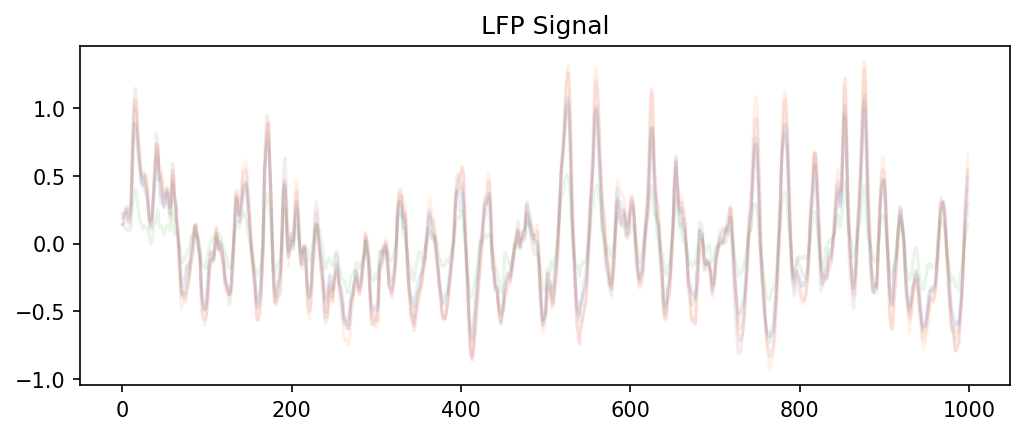

In [50]:
fig = plt.figure(figsize=(8, 3), dpi=150)
for j in range(6):
    plt.plot(lfp_odor_B[1, :, j], alpha=0.1)
plt.title('LFP Signal')
plt.show()

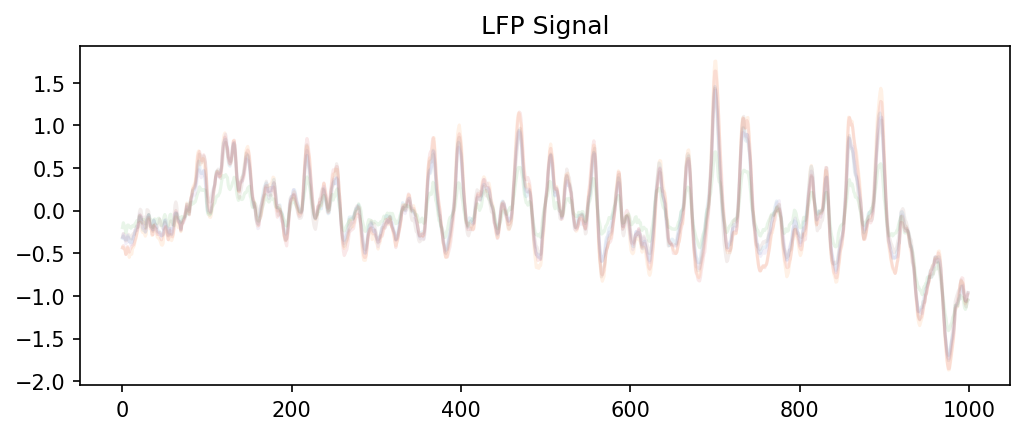

In [139]:
fig = plt.figure(figsize=(8, 3), dpi=150)
for j in range(6):
    plt.plot(lfp_odor_C[1, :, j], alpha=0.1)
plt.title('LFP Signal')
plt.show()

In [60]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [189]:
lfp_odor_B_filtered = lfp_odor_B.copy()
for i in range(lfp_odor_B.shape[0]):
    for j in range(lfp_odor_B.shape[2]):
        lfp_odor_B_filtered[i, :, j] = butter_bandpass_filter(lfp_odor_B[i, :, j], 4, 20, 1000)

In [190]:
lfp_odor_C_filtered = lfp_odor_C.copy()
for i in range(lfp_odor_C.shape[0]):
    for j in range(lfp_odor_C.shape[2]):
        lfp_odor_C_filtered[i, :, j] = butter_bandpass_filter(lfp_odor_C[i, :, j], 4, 20, 1000)

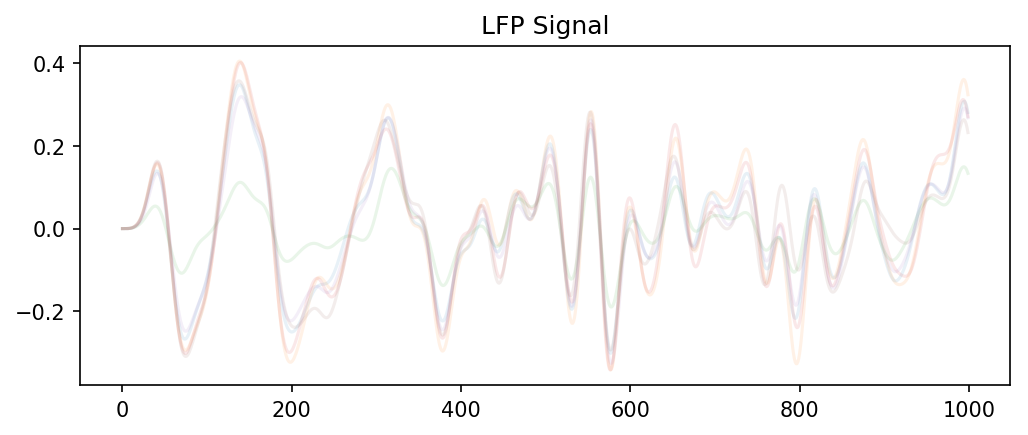

In [191]:
fig = plt.figure(figsize=(8, 3), dpi=150)
for j in range(6):
    plt.plot(lfp_odor_B_filtered[1, :, j], alpha=0.1)
plt.title('LFP Signal')
plt.show()

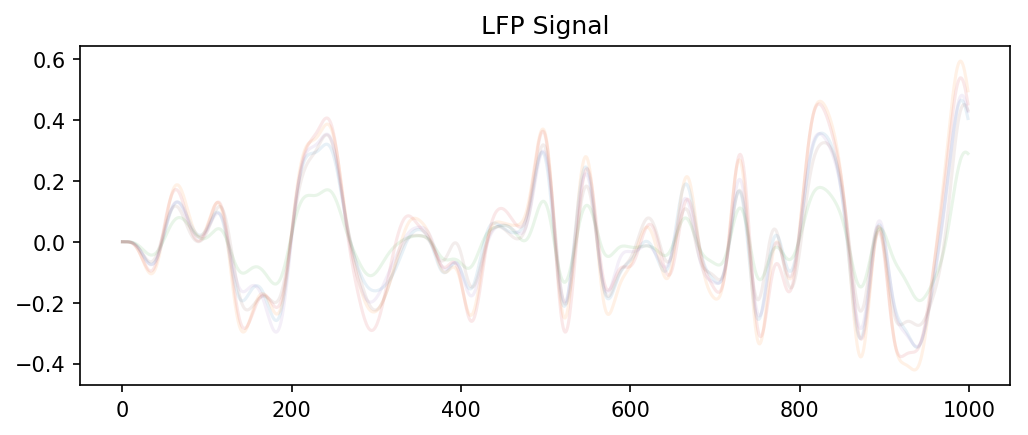

In [192]:
fig = plt.figure(figsize=(8, 3), dpi=150)
for j in range(6):
    plt.plot(lfp_odor_C_filtered[1, :, j], alpha=0.1)
plt.title('LFP Signal')
plt.show()

In [193]:
def sliding_window(time_series, size=50, stride=1):
    """
    Calculate sliding window covariance Log-Euclidean vector time series.

    Args
        time_series: (numpy array) [t, n] t observations in time of n dimensional data
        size: (int) sliding window size
        stride: (int) sliding step size
    """
    t, n = time_series.shape
    log_series = np.zeros((int((t - size) / stride), int(0.5 * n * (n + 1))))
    for i in range(int((t - size) / stride)):
        window = time_series[(i * stride):(i * stride + size), :]
        cov = np.cov(window, rowvar=False)
        log_series[i, :] = logm(cov)[np.triu_indices(n)]
    return log_series

In [245]:
odor_B_list = []
for i in range(20):
    cov_ts = sliding_window(lfp_odor_B[i, :, :], size=100, stride=20)
    odor_B_list.append(cov_ts)

In [246]:
# 95 time points and 15 elements
print(odor_B_list[0].shape)

(45, 21)


In [247]:
odor_C_list = []
for i in range(20):
    cov_ts = sliding_window(lfp_odor_C[i, :, :], size=100, stride=20)
    odor_B_list.append(cov_ts)

In [248]:
all_vector = np.concatenate(odor_B_list + odor_C_list)
Y = all_vector - np.mean(all_vector, axis=0)
print(Y.shape)

(1800, 21)


In [249]:
from sklearn.decomposition import PCA

In [250]:
pca = PCA(n_components=10)
components = pca.fit_transform(Y)

In [251]:
print(pca.explained_variance_ratio_)

[0.26878429 0.14197183 0.08348361 0.06601639 0.05693749 0.04782934
 0.04362661 0.04273183 0.03941531 0.03292057]


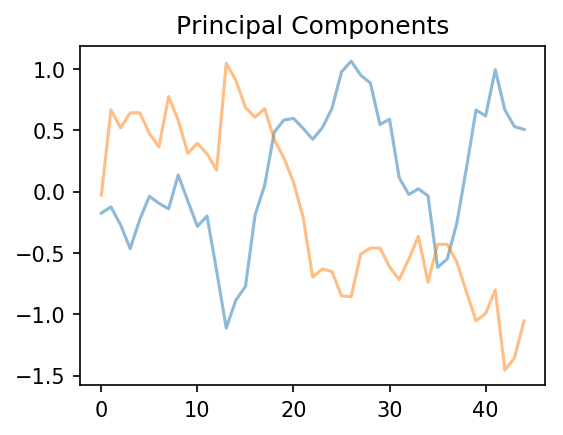

In [252]:
fig = plt.figure(figsize=(4, 3), dpi=150)
for j in range(2):
    plt.plot(components[:45, j], alpha=0.5)
plt.title('Principal Components')
plt.show()

In [255]:
from factorgp import FactorGP
from inference import run_gibbs

In [256]:
dims = [40, 45, 21, 2]  # n, t, q, r
model = FactorGP(dims, gamma=[5, 1])

In [257]:
results = run_gibbs(Y, model, 5000, 10, 0.1, verbose=True)










  0%|          | 0/5000 [00:00<?, ?it/s]








  0%|          | 1/5000 [00:00<1:09:46,  1.19it/s]

Current MSE: 0.0629540780661
Current length scale: [4.73575841 4.7782157 ]











  0%|          | 2/5000 [00:01<1:04:10,  1.30it/s]

Current MSE: 0.0630646751724
Current length scale: [4.7412737  4.70823495]











  0%|          | 3/5000 [00:02<1:01:37,  1.35it/s]

Current MSE: 0.0627417918307
Current length scale: [4.83579963 4.62047443]











  0%|          | 4/5000 [00:02<59:52,  1.39it/s]  

Current MSE: 0.061868142262
Current length scale: [4.91157201 4.58861513]











  0%|          | 5/5000 [00:03<1:01:07,  1.36it/s]

Current MSE: 0.0620224552961
Current length scale: [4.91060612 4.52235974]











  0%|          | 6/5000 [00:04<58:39,  1.42it/s]  

Current MSE: 0.062179548894
Current length scale: [4.91060612 4.51930144]











  0%|          | 7/5000 [00:04<58:44,  1.42it/s]

Current MSE: 0.0624570776295
Current length scale: [4.92573669 4.50913898]











  0%|          | 8/5000 [00:05<56:59,  1.46it/s]

Current MSE: 0.0629010342878
Current length scale: [4.88242189 4.50296513]











  0%|          | 9/5000 [00:06<57:19,  1.45it/s]

Current MSE: 0.062849321316
Current length scale: [4.92679882 4.50149258]











  0%|          | 10/5000 [00:06<57:13,  1.45it/s]

Current MSE: 0.0624409941771
Current length scale: [4.92312916 4.4560196 ]











  0%|          | 11/5000 [00:07<59:01,  1.41it/s]

Current MSE: 0.0617601247756
Current length scale: [4.93439894 4.42305618]











  0%|          | 12/5000 [00:08<1:02:29,  1.33it/s]

Current MSE: 0.0613805646541
Current length scale: [4.94755397 4.41265864]











  0%|          | 13/5000 [00:09<1:01:49,  1.34it/s]

Current MSE: 0.0607047977631
Current length scale: [4.92028034 4.38544621]











  0%|          | 14/5000 [00:10<1:02:28,  1.33it/s]

Current MSE: 0.0597343252902
Current length scale: [4.94397258 4.35663231]











  0%|          | 15/5000 [00:10<1:02:23,  1.33it/s]

Current MSE: 0.0592990934379
Current length scale: [4.9335126  4.32863751]











  0%|          | 16/5000 [00:11<1:06:33,  1.25it/s]

Current MSE: 0.0591117201974
Current length scale: [4.90335838 4.29261195]











  0%|          | 17/5000 [00:12<1:02:54,  1.32it/s]

Current MSE: 0.0589710732565
Current length scale: [4.87528098 4.26523068]











  0%|          | 18/5000 [00:12<59:15,  1.40it/s]  

Current MSE: 0.0594580521267
Current length scale: [4.87528098 4.26523068]











  0%|          | 19/5000 [00:13<57:01,  1.46it/s]

Current MSE: 0.0592530620262
Current length scale: [4.85462022 4.24818803]











  0%|          | 20/5000 [00:14<55:05,  1.51it/s]

Current MSE: 0.0590795042035
Current length scale: [4.86035696 4.24872207]











  0%|          | 21/5000 [00:14<53:54,  1.54it/s]

Current MSE: 0.0593188191354
Current length scale: [4.82715592 4.24872207]











  0%|          | 22/5000 [00:15<52:59,  1.57it/s]

Current MSE: 0.0591432386927
Current length scale: [4.8786185  4.19762306]











  0%|          | 23/5000 [00:16<52:03,  1.59it/s]

Current MSE: 0.0593359406845
Current length scale: [4.90227466 4.1864697 ]











  0%|          | 24/5000 [00:16<51:32,  1.61it/s]

Current MSE: 0.0594998976705
Current length scale: [4.93016686 4.13012458]











  0%|          | 25/5000 [00:17<51:31,  1.61it/s]

Current MSE: 0.0594521196682
Current length scale: [4.93902799 4.11938776]











  1%|          | 26/5000 [00:17<51:07,  1.62it/s]

Current MSE: 0.0594035905492
Current length scale: [4.95153334 4.06957219]











  1%|          | 27/5000 [00:18<50:57,  1.63it/s]

Current MSE: 0.0596781268742
Current length scale: [4.95419964 4.0228472 ]











  1%|          | 28/5000 [00:19<50:53,  1.63it/s]

Current MSE: 0.0595005976172
Current length scale: [4.99938967 4.0074479 ]











  1%|          | 29/5000 [00:19<50:24,  1.64it/s]

Current MSE: 0.0597329533308
Current length scale: [4.97661068 4.02231894]











  1%|          | 30/5000 [00:20<49:59,  1.66it/s]

Current MSE: 0.0596576441971
Current length scale: [4.96151064 3.98541431]











  1%|          | 31/5000 [00:20<50:13,  1.65it/s]

Current MSE: 0.0598833409018
Current length scale: [4.94286729 3.99135078]











  1%|          | 32/5000 [00:21<49:52,  1.66it/s]

Current MSE: 0.0598274217553
Current length scale: [4.90747741 3.99892103]











  1%|          | 33/5000 [00:22<49:50,  1.66it/s]

Current MSE: 0.0596614544076
Current length scale: [4.9274452  3.98298762]











  1%|          | 34/5000 [00:22<49:37,  1.67it/s]

Current MSE: 0.0596858159102
Current length scale: [4.90489263 3.9892576 ]











  1%|          | 35/5000 [00:23<49:59,  1.66it/s]

Current MSE: 0.059691321836
Current length scale: [4.87336233 3.92896919]











  1%|          | 36/5000 [00:23<49:40,  1.67it/s]

Current MSE: 0.0597960874978
Current length scale: [4.8382352  3.90815721]











  1%|          | 37/5000 [00:24<50:12,  1.65it/s]

Current MSE: 0.059765000312
Current length scale: [4.80896192 3.86336618]











  1%|          | 38/5000 [00:25<50:02,  1.65it/s]

Current MSE: 0.0598223679673
Current length scale: [4.78352984 3.83200613]











  1%|          | 39/5000 [00:25<49:59,  1.65it/s]

Current MSE: 0.060055645802
Current length scale: [4.78367354 3.82175333]











  1%|          | 40/5000 [00:26<50:19,  1.64it/s]

Current MSE: 0.0599473744926
Current length scale: [4.78851127 3.80056892]











  1%|          | 41/5000 [00:26<50:28,  1.64it/s]

Current MSE: 0.0597905674776
Current length scale: [4.75711822 3.80746973]











  1%|          | 42/5000 [00:27<50:28,  1.64it/s]

Current MSE: 0.0596381014978
Current length scale: [4.74407965 3.81243993]











  1%|          | 43/5000 [00:28<50:53,  1.62it/s]

Current MSE: 0.0597458169957
Current length scale: [4.7369215  3.80487785]











  1%|          | 44/5000 [00:28<50:51,  1.62it/s]

Current MSE: 0.0593184352875
Current length scale: [4.62430297 3.84812683]











  1%|          | 45/5000 [00:29<50:31,  1.63it/s]

Current MSE: 0.0595800676372
Current length scale: [4.56333512 3.85851411]











  1%|          | 46/5000 [00:30<50:15,  1.64it/s]

Current MSE: 0.0597039939856
Current length scale: [4.56333512 3.90067687]











  1%|          | 47/5000 [00:30<50:01,  1.65it/s]

Current MSE: 0.0597547176298
Current length scale: [4.58950566 3.90067687]











  1%|          | 48/5000 [00:31<50:05,  1.65it/s]

Current MSE: 0.0601766193108
Current length scale: [4.61052477 3.88924648]











  1%|          | 49/5000 [00:31<50:06,  1.65it/s]

Current MSE: 0.0598304464687
Current length scale: [4.57731557 3.83619126]











  1%|          | 50/5000 [00:32<50:01,  1.65it/s]

Current MSE: 0.0596329773248
Current length scale: [4.54187875 3.83162937]











  1%|          | 51/5000 [00:33<51:04,  1.62it/s]

Current MSE: 0.0596360957596
Current length scale: [4.54352636 3.83162937]











  1%|          | 52/5000 [00:33<50:46,  1.62it/s]

Current MSE: 0.0596550599918
Current length scale: [4.49891764 3.79369311]











  1%|          | 53/5000 [00:34<54:11,  1.52it/s]

Current MSE: 0.0596561582395
Current length scale: [4.53203282 3.76926065]











  1%|          | 54/5000 [00:35<59:13,  1.39it/s]

Current MSE: 0.0598155351778
Current length scale: [4.49082546 3.77705304]











  1%|          | 55/5000 [00:36<1:05:22,  1.26it/s]

Current MSE: 0.0597721118441
Current length scale: [4.39563024 3.71613515]











  1%|          | 56/5000 [00:37<1:06:31,  1.24it/s]

Current MSE: 0.0598572287598
Current length scale: [4.33806533 3.72209762]











  1%|          | 57/5000 [00:37<1:05:38,  1.26it/s]

Current MSE: 0.0597461903378
Current length scale: [4.30100561 3.69564778]











  1%|          | 58/5000 [00:38<1:03:19,  1.30it/s]

Current MSE: 0.0597978345701
Current length scale: [4.30347087 3.69564778]











  1%|          | 59/5000 [00:39<59:51,  1.38it/s]  

Current MSE: 0.0600616349017
Current length scale: [4.33007151 3.67338753]











  1%|          | 60/5000 [00:39<58:54,  1.40it/s]

Current MSE: 0.0597090862374
Current length scale: [4.33449066 3.69275215]











  1%|          | 61/5000 [00:40<58:29,  1.41it/s]

Current MSE: 0.0597374871835
Current length scale: [4.32809864 3.67896633]











  1%|          | 62/5000 [00:41<1:01:41,  1.33it/s]

Current MSE: 0.0598182144417
Current length scale: [4.32352342 3.64923733]











  1%|▏         | 63/5000 [00:42<1:01:46,  1.33it/s]

Current MSE: 0.0599245463495
Current length scale: [4.30287568 3.63488048]











  1%|▏         | 64/5000 [00:42<59:30,  1.38it/s]  

Current MSE: 0.060074688507
Current length scale: [4.25195285 3.61316506]











  1%|▏         | 65/5000 [00:43<1:07:16,  1.22it/s]

Current MSE: 0.0598302629492
Current length scale: [4.23582164 3.61316506]











  1%|▏         | 66/5000 [00:44<1:07:09,  1.22it/s]

Current MSE: 0.0597661755249
Current length scale: [4.21944947 3.61316506]











  1%|▏         | 67/5000 [00:45<1:05:48,  1.25it/s]

Current MSE: 0.059605637121
Current length scale: [4.21944947 3.61254541]











  1%|▏         | 68/5000 [00:46<1:10:40,  1.16it/s]

Current MSE: 0.0595663266406
Current length scale: [4.21665983 3.56396565]











  1%|▏         | 69/5000 [00:47<1:09:35,  1.18it/s]

Current MSE: 0.0594359186467
Current length scale: [4.14218224 3.52940743]











  1%|▏         | 70/5000 [00:48<1:12:15,  1.14it/s]

Current MSE: 0.0596515280279
Current length scale: [4.11004479 3.55157026]











  1%|▏         | 71/5000 [00:49<1:09:49,  1.18it/s]

Current MSE: 0.0594688705522
Current length scale: [4.1168973  3.56191936]











  1%|▏         | 72/5000 [00:49<1:06:26,  1.24it/s]

Current MSE: 0.0594177190454
Current length scale: [4.11569545 3.56191936]











  1%|▏         | 73/5000 [00:50<1:06:47,  1.23it/s]

Current MSE: 0.0598883424022
Current length scale: [4.10700205 3.55568858]











  1%|▏         | 74/5000 [00:51<1:05:01,  1.26it/s]

Current MSE: 0.059675550862
Current length scale: [4.09725625 3.54981638]











  2%|▏         | 75/5000 [00:52<1:03:47,  1.29it/s]

Current MSE: 0.0595983736964
Current length scale: [4.06933705 3.56431004]











  2%|▏         | 76/5000 [00:52<1:05:27,  1.25it/s]

Current MSE: 0.0596245226834
Current length scale: [4.00923815 3.54590143]











  2%|▏         | 77/5000 [00:53<1:03:45,  1.29it/s]

Current MSE: 0.0594493070954
Current length scale: [4.05343817 3.5017851 ]











  2%|▏         | 78/5000 [00:54<1:03:26,  1.29it/s]

Current MSE: 0.0595487073088
Current length scale: [4.05719044 3.4953958 ]











  2%|▏         | 79/5000 [00:55<1:03:19,  1.30it/s]

Current MSE: 0.0598675028833
Current length scale: [4.04948529 3.4541002 ]











  2%|▏         | 80/5000 [00:56<1:05:23,  1.25it/s]

Current MSE: 0.0592806825361
Current length scale: [4.11364335 3.43726604]











  2%|▏         | 81/5000 [00:56<1:04:50,  1.26it/s]

Current MSE: 0.059206283586
Current length scale: [4.11364335 3.43726604]











  2%|▏         | 82/5000 [00:57<1:04:52,  1.26it/s]

Current MSE: 0.0592453446384
Current length scale: [4.11364335 3.43946343]











  2%|▏         | 83/5000 [00:58<1:05:58,  1.24it/s]

Current MSE: 0.0594959026909
Current length scale: [4.07742908 3.44272547]











  2%|▏         | 84/5000 [00:59<1:05:02,  1.26it/s]

Current MSE: 0.0595474301747
Current length scale: [4.07274664 3.417416  ]











  2%|▏         | 85/5000 [01:00<1:08:36,  1.19it/s]

Current MSE: 0.0595502079429
Current length scale: [4.06820831 3.43339864]











  2%|▏         | 86/5000 [01:00<1:07:33,  1.21it/s]

Current MSE: 0.0595708160329
Current length scale: [4.06276996 3.42540415]











  2%|▏         | 87/5000 [01:01<1:06:04,  1.24it/s]

Current MSE: 0.0596245999999
Current length scale: [4.04641417 3.37380269]











  2%|▏         | 88/5000 [01:02<1:08:37,  1.19it/s]

Current MSE: 0.0596983109854
Current length scale: [3.99258491 3.35576282]











  2%|▏         | 89/5000 [01:03<1:08:50,  1.19it/s]

Current MSE: 0.059874292083
Current length scale: [4.03476063 3.35355282]











  2%|▏         | 90/5000 [01:04<1:05:58,  1.24it/s]

Current MSE: 0.0599069415524
Current length scale: [4.01873058 3.36242207]











  2%|▏         | 91/5000 [01:04<1:06:09,  1.24it/s]

Current MSE: 0.0597175078443
Current length scale: [4.04734705 3.34495275]











  2%|▏         | 92/5000 [01:05<1:06:33,  1.23it/s]

Current MSE: 0.0599634189468
Current length scale: [4.05341473 3.34495275]











  2%|▏         | 93/5000 [01:06<1:08:28,  1.19it/s]

Current MSE: 0.0602003930553
Current length scale: [4.05341473 3.34495275]











  2%|▏         | 94/5000 [01:07<1:05:40,  1.24it/s]

Current MSE: 0.0596053120863
Current length scale: [4.01936743 3.33636266]











  2%|▏         | 95/5000 [01:08<1:04:21,  1.27it/s]

Current MSE: 0.0599010344729
Current length scale: [4.00955891 3.33636266]











  2%|▏         | 96/5000 [01:08<1:03:13,  1.29it/s]

Current MSE: 0.0598215771314
Current length scale: [4.0299525  3.33590108]











  2%|▏         | 97/5000 [01:09<1:02:11,  1.31it/s]

Current MSE: 0.0598475856141
Current length scale: [4.0299525  3.35134708]











  2%|▏         | 98/5000 [01:10<1:01:52,  1.32it/s]

Current MSE: 0.0599901290402
Current length scale: [3.95745623 3.33038031]











  2%|▏         | 99/5000 [01:11<1:02:20,  1.31it/s]

Current MSE: 0.0599161879145
Current length scale: [3.94876952 3.33164407]











  2%|▏         | 100/5000 [01:11<1:00:53,  1.34it/s]

Current MSE: 0.0597946739529
Current length scale: [3.89275753 3.33164407]











  2%|▏         | 101/5000 [01:12<1:00:07,  1.36it/s]

Current MSE: 0.0598113275567
Current length scale: [3.9168104  3.31934134]











  2%|▏         | 102/5000 [01:13<59:27,  1.37it/s]  

Current MSE: 0.0599967141951
Current length scale: [3.9168104  3.31934134]











  2%|▏         | 103/5000 [01:14<59:32,  1.37it/s]

Current MSE: 0.0600423229375
Current length scale: [3.8813725  3.28763435]











  2%|▏         | 104/5000 [01:14<59:45,  1.37it/s]

Current MSE: 0.0598895041402
Current length scale: [3.82364808 3.28763435]











  2%|▏         | 105/5000 [01:15<59:40,  1.37it/s]

Current MSE: 0.0597811535533
Current length scale: [3.83453425 3.30052281]











  2%|▏         | 106/5000 [01:16<59:58,  1.36it/s]

Current MSE: 0.059256939267
Current length scale: [3.83794095 3.30237597]











  2%|▏         | 107/5000 [01:16<59:53,  1.36it/s]

Current MSE: 0.0595996531838
Current length scale: [3.79409564 3.25635042]











  2%|▏         | 108/5000 [01:17<59:57,  1.36it/s]

Current MSE: 0.0594208268218
Current length scale: [3.75200976 3.2387937 ]











  2%|▏         | 109/5000 [01:18<59:59,  1.36it/s]

Current MSE: 0.0597746169577
Current length scale: [3.75010603 3.20973213]











  2%|▏         | 110/5000 [01:19<59:49,  1.36it/s]

Current MSE: 0.0595325058453
Current length scale: [3.76196247 3.22061496]











  2%|▏         | 111/5000 [01:19<1:00:05,  1.36it/s]

Current MSE: 0.0599311316488
Current length scale: [3.73640571 3.22007561]











  2%|▏         | 112/5000 [01:20<59:20,  1.37it/s]  

Current MSE: 0.0601945177185
Current length scale: [3.7464566  3.22007561]











  2%|▏         | 113/5000 [01:21<59:36,  1.37it/s]

Current MSE: 0.0599966230673
Current length scale: [3.7464566  3.22007561]











  2%|▏         | 114/5000 [01:22<57:35,  1.41it/s]

Current MSE: 0.0599099297241
Current length scale: [3.74240032 3.21362938]











  2%|▏         | 115/5000 [01:22<54:56,  1.48it/s]

Current MSE: 0.0599360050348
Current length scale: [3.73461626 3.2411918 ]











  2%|▏         | 116/5000 [01:23<53:03,  1.53it/s]

Current MSE: 0.0599155061982
Current length scale: [3.7442917 3.2411918]











  2%|▏         | 117/5000 [01:23<51:48,  1.57it/s]

Current MSE: 0.0601112787735
Current length scale: [3.73829406 3.26642044]











  2%|▏         | 118/5000 [01:24<50:48,  1.60it/s]

Current MSE: 0.0601058894727
Current length scale: [3.73829406 3.26642044]











  2%|▏         | 119/5000 [01:25<50:14,  1.62it/s]

Current MSE: 0.0598747249345
Current length scale: [3.66746783 3.26642044]











  2%|▏         | 120/5000 [01:25<49:54,  1.63it/s]

Current MSE: 0.059779588325
Current length scale: [3.71141393 3.2767392 ]











  2%|▏         | 121/5000 [01:26<49:29,  1.64it/s]

Current MSE: 0.0598498034997
Current length scale: [3.67672042 3.25632025]











  2%|▏         | 122/5000 [01:26<49:24,  1.65it/s]

Current MSE: 0.0599661680477
Current length scale: [3.66880219 3.25013435]











  2%|▏         | 123/5000 [01:27<49:16,  1.65it/s]

Current MSE: 0.0603801755157
Current length scale: [3.65624904 3.23228536]











  2%|▏         | 124/5000 [01:28<49:22,  1.65it/s]

Current MSE: 0.060072843163
Current length scale: [3.6106866  3.23228536]











  2%|▎         | 125/5000 [01:28<49:00,  1.66it/s]

Current MSE: 0.0600368138611
Current length scale: [3.59289254 3.21061487]











  3%|▎         | 126/5000 [01:29<48:53,  1.66it/s]

Current MSE: 0.0600411441112
Current length scale: [3.59147291 3.21056236]











  3%|▎         | 127/5000 [01:29<48:42,  1.67it/s]

Current MSE: 0.0598514052893
Current length scale: [3.54240865 3.21415295]











  3%|▎         | 128/5000 [01:30<48:28,  1.68it/s]

Current MSE: 0.0600914097718
Current length scale: [3.55557693 3.21157152]











  3%|▎         | 129/5000 [01:31<48:44,  1.67it/s]

Current MSE: 0.0602929071977
Current length scale: [3.54610764 3.21851624]











  3%|▎         | 130/5000 [01:31<48:48,  1.66it/s]

Current MSE: 0.0598715027896
Current length scale: [3.53129162 3.19228039]











  3%|▎         | 131/5000 [01:32<48:41,  1.67it/s]

Current MSE: 0.0600078185923
Current length scale: [3.5210218  3.14698915]











  3%|▎         | 132/5000 [01:32<49:31,  1.64it/s]

Current MSE: 0.0596404937092
Current length scale: [3.51327063 3.1587367 ]











  3%|▎         | 133/5000 [01:33<49:10,  1.65it/s]

Current MSE: 0.0598299449105
Current length scale: [3.48669975 3.1610744 ]











  3%|▎         | 134/5000 [01:34<48:48,  1.66it/s]

Current MSE: 0.0598065675187
Current length scale: [3.45865656 3.18045236]











  3%|▎         | 135/5000 [01:34<48:27,  1.67it/s]

Current MSE: 0.0598312611152
Current length scale: [3.45191549 3.16285665]











  3%|▎         | 136/5000 [01:35<48:28,  1.67it/s]

Current MSE: 0.0599360368934
Current length scale: [3.45191549 3.13414126]











  3%|▎         | 137/5000 [01:35<48:44,  1.66it/s]

Current MSE: 0.0598073923907
Current length scale: [3.44725078 3.16815923]











  3%|▎         | 138/5000 [01:36<48:28,  1.67it/s]

Current MSE: 0.0600246984833
Current length scale: [3.44662463 3.13316613]











  3%|▎         | 139/5000 [01:37<48:34,  1.67it/s]

Current MSE: 0.0601152176638
Current length scale: [3.48042507 3.15660722]











  3%|▎         | 140/5000 [01:37<48:23,  1.67it/s]

Current MSE: 0.0600452840979
Current length scale: [3.48861934 3.14401692]











  3%|▎         | 141/5000 [01:38<48:23,  1.67it/s]

Current MSE: 0.0602091761363
Current length scale: [3.48861934 3.14401692]











  3%|▎         | 142/5000 [01:38<48:22,  1.67it/s]

Current MSE: 0.0603617832005
Current length scale: [3.482242   3.17046058]











  3%|▎         | 143/5000 [01:39<48:26,  1.67it/s]

Current MSE: 0.0599019591217
Current length scale: [3.46753798 3.16013461]











  3%|▎         | 144/5000 [01:40<48:18,  1.68it/s]

Current MSE: 0.0600841025158
Current length scale: [3.44158311 3.16013461]











  3%|▎         | 145/5000 [01:40<48:42,  1.66it/s]

Current MSE: 0.0600848638031
Current length scale: [3.41582022 3.18747065]











  3%|▎         | 146/5000 [01:41<49:15,  1.64it/s]

Current MSE: 0.0601631808467
Current length scale: [3.39694731 3.20532386]











  3%|▎         | 147/5000 [01:41<48:59,  1.65it/s]

Current MSE: 0.0602027339393
Current length scale: [3.40045077 3.18941297]











  3%|▎         | 148/5000 [01:42<49:06,  1.65it/s]

Current MSE: 0.0600053917903
Current length scale: [3.38282456 3.19736342]











  3%|▎         | 149/5000 [01:43<49:00,  1.65it/s]

Current MSE: 0.0599025179353
Current length scale: [3.40984075 3.16035254]











  3%|▎         | 150/5000 [01:43<49:10,  1.64it/s]

Current MSE: 0.0598464347797
Current length scale: [3.39092324 3.16035254]











  3%|▎         | 151/5000 [01:44<48:59,  1.65it/s]

Current MSE: 0.0598246857851
Current length scale: [3.39092324 3.15524924]











  3%|▎         | 152/5000 [01:44<48:56,  1.65it/s]

Current MSE: 0.059556458857
Current length scale: [3.37884829 3.14981989]











  3%|▎         | 153/5000 [01:45<48:53,  1.65it/s]

Current MSE: 0.0598959143353
Current length scale: [3.38760335 3.18594278]











  3%|▎         | 154/5000 [01:46<48:58,  1.65it/s]

Current MSE: 0.0596986096562
Current length scale: [3.37649584 3.17350306]











  3%|▎         | 155/5000 [01:46<49:24,  1.63it/s]

Current MSE: 0.0599811465846
Current length scale: [3.37408274 3.19207555]











  3%|▎         | 156/5000 [01:47<49:03,  1.65it/s]

Current MSE: 0.0601087388946
Current length scale: [3.38526324 3.19149081]











  3%|▎         | 157/5000 [01:47<48:54,  1.65it/s]

Current MSE: 0.0602757070141
Current length scale: [3.3899529  3.19640598]











  3%|▎         | 158/5000 [01:48<48:41,  1.66it/s]

Current MSE: 0.0601685162649
Current length scale: [3.36781487 3.19640598]











  3%|▎         | 159/5000 [01:49<48:32,  1.66it/s]

Current MSE: 0.0601715943756
Current length scale: [3.36781487 3.17186783]











  3%|▎         | 160/5000 [01:49<48:41,  1.66it/s]

Current MSE: 0.0602186125429
Current length scale: [3.35520554 3.19315978]











  3%|▎         | 161/5000 [01:50<48:21,  1.67it/s]

Current MSE: 0.0602530245168
Current length scale: [3.33689253 3.17354832]











  3%|▎         | 162/5000 [01:50<48:41,  1.66it/s]

Current MSE: 0.0599200137787
Current length scale: [3.31568035 3.17205975]











  3%|▎         | 163/5000 [01:51<48:20,  1.67it/s]

Current MSE: 0.0600483227173
Current length scale: [3.31891968 3.17205975]











  3%|▎         | 164/5000 [01:52<48:30,  1.66it/s]

Current MSE: 0.0598498372259
Current length scale: [3.31891968 3.16640597]











  3%|▎         | 165/5000 [01:52<48:30,  1.66it/s]

Current MSE: 0.0598713889006
Current length scale: [3.31806329 3.16708165]











  3%|▎         | 166/5000 [01:53<48:15,  1.67it/s]

Current MSE: 0.0598809392264
Current length scale: [3.30169563 3.16948107]











  3%|▎         | 167/5000 [01:53<48:13,  1.67it/s]

Current MSE: 0.0598911707075
Current length scale: [3.29548504 3.17370769]











  3%|▎         | 168/5000 [01:54<48:04,  1.68it/s]

Current MSE: 0.0599485150805
Current length scale: [3.29548504 3.17529436]











  3%|▎         | 169/5000 [01:55<48:01,  1.68it/s]

Current MSE: 0.0599632605542
Current length scale: [3.2915915  3.17529436]











  3%|▎         | 170/5000 [01:55<47:58,  1.68it/s]

Current MSE: 0.0599584762644
Current length scale: [3.26617872 3.20069009]











  3%|▎         | 171/5000 [01:56<48:30,  1.66it/s]

Current MSE: 0.0597814831606
Current length scale: [3.25165525 3.2255654 ]











  3%|▎         | 172/5000 [01:56<48:22,  1.66it/s]

Current MSE: 0.0599717742405
Current length scale: [3.25994817 3.2255654 ]











  3%|▎         | 173/5000 [01:57<48:32,  1.66it/s]

Current MSE: 0.0597106042811
Current length scale: [3.27432677 3.2255654 ]











  3%|▎         | 174/5000 [01:58<48:41,  1.65it/s]

Current MSE: 0.0599520630047
Current length scale: [3.2499965 3.2272885]











  4%|▎         | 175/5000 [01:58<48:30,  1.66it/s]

Current MSE: 0.0600890692332
Current length scale: [3.27072285 3.22597464]











  4%|▎         | 176/5000 [01:59<48:43,  1.65it/s]

Current MSE: 0.0601512932893
Current length scale: [3.27710729 3.22597464]











  4%|▎         | 177/5000 [01:59<48:23,  1.66it/s]

Current MSE: 0.0602696652035
Current length scale: [3.29212573 3.22597464]











  4%|▎         | 178/5000 [02:00<48:14,  1.67it/s]

Current MSE: 0.0605228167302
Current length scale: [3.27003239 3.22513911]











  4%|▎         | 179/5000 [02:01<48:07,  1.67it/s]

Current MSE: 0.0602865993203
Current length scale: [3.27654404 3.2131973 ]











  4%|▎         | 180/5000 [02:01<48:09,  1.67it/s]

Current MSE: 0.060157357424
Current length scale: [3.27654404 3.20283926]











  4%|▎         | 181/5000 [02:02<48:04,  1.67it/s]

Current MSE: 0.0600443684645
Current length scale: [3.27654404 3.20004563]











  4%|▎         | 182/5000 [02:02<49:19,  1.63it/s]

Current MSE: 0.0602026111691
Current length scale: [3.26372758 3.20491099]











  4%|▎         | 183/5000 [02:03<48:51,  1.64it/s]

Current MSE: 0.0602844733263
Current length scale: [3.26372758 3.20205282]











  4%|▎         | 184/5000 [02:04<48:31,  1.65it/s]

Current MSE: 0.0600651704062
Current length scale: [3.24709515 3.18532306]











  4%|▎         | 185/5000 [02:04<48:21,  1.66it/s]

Current MSE: 0.0601133619253
Current length scale: [3.25707876 3.20098798]











  4%|▎         | 186/5000 [02:05<48:11,  1.66it/s]

Current MSE: 0.0597189730429
Current length scale: [3.25707876 3.18424258]











  4%|▎         | 187/5000 [02:05<48:12,  1.66it/s]

Current MSE: 0.0596881300677
Current length scale: [3.27677035 3.19379696]











  4%|▍         | 188/5000 [02:06<48:11,  1.66it/s]

Current MSE: 0.059959931607
Current length scale: [3.25918553 3.16059811]











  4%|▍         | 189/5000 [02:07<48:25,  1.66it/s]

Current MSE: 0.0599361831864
Current length scale: [3.25918553 3.16059811]











  4%|▍         | 190/5000 [02:07<48:48,  1.64it/s]

Current MSE: 0.0597504874055
Current length scale: [3.24635008 3.16059811]











  4%|▍         | 191/5000 [02:08<48:30,  1.65it/s]

Current MSE: 0.0597800392055
Current length scale: [3.25578433 3.18609316]











  4%|▍         | 192/5000 [02:09<48:31,  1.65it/s]

Current MSE: 0.0600293781778
Current length scale: [3.22722227 3.18672622]











  4%|▍         | 193/5000 [02:09<48:26,  1.65it/s]

Current MSE: 0.0598791357324
Current length scale: [3.22722227 3.1876559 ]











  4%|▍         | 194/5000 [02:10<48:07,  1.66it/s]

Current MSE: 0.0597972536094
Current length scale: [3.22722227 3.18593981]











  4%|▍         | 195/5000 [02:10<48:05,  1.67it/s]

Current MSE: 0.0597418331117
Current length scale: [3.23252342 3.19001661]











  4%|▍         | 196/5000 [02:11<48:16,  1.66it/s]

Current MSE: 0.0598863492053
Current length scale: [3.23021182 3.17936077]











  4%|▍         | 197/5000 [02:12<49:04,  1.63it/s]

Current MSE: 0.0597706376151
Current length scale: [3.21562266 3.19352028]











  4%|▍         | 198/5000 [02:12<53:17,  1.50it/s]

Current MSE: 0.0599980076629
Current length scale: [3.21562266 3.16385492]











  4%|▍         | 199/5000 [02:13<54:44,  1.46it/s]

Current MSE: 0.0598140053529
Current length scale: [3.2386459  3.19049097]











  4%|▍         | 200/5000 [02:14<53:11,  1.50it/s]

Current MSE: 0.0595367433354
Current length scale: [3.231092   3.19049097]











  4%|▍         | 201/5000 [02:14<51:51,  1.54it/s]

Current MSE: 0.0596558498082
Current length scale: [3.24987023 3.17410761]











  4%|▍         | 202/5000 [02:15<52:12,  1.53it/s]

Current MSE: 0.059962062745
Current length scale: [3.24949979 3.16153235]











  4%|▍         | 203/5000 [02:16<50:49,  1.57it/s]

Current MSE: 0.0598039945477
Current length scale: [3.24949979 3.16951677]











  4%|▍         | 204/5000 [02:16<50:14,  1.59it/s]

Current MSE: 0.0597297448664
Current length scale: [3.2315779  3.16988883]











  4%|▍         | 205/5000 [02:17<49:34,  1.61it/s]

Current MSE: 0.0596064865886
Current length scale: [3.23548292 3.16458687]











  4%|▍         | 206/5000 [02:17<49:29,  1.61it/s]

Current MSE: 0.0597330905965
Current length scale: [3.22963285 3.16458687]











  4%|▍         | 207/5000 [02:18<49:07,  1.63it/s]

Current MSE: 0.0595176862696
Current length scale: [3.22963285 3.18784214]











  4%|▍         | 208/5000 [02:19<48:58,  1.63it/s]

Current MSE: 0.059676290994
Current length scale: [3.20178855 3.19186376]











  4%|▍         | 209/5000 [02:19<48:40,  1.64it/s]

Current MSE: 0.0595160205386
Current length scale: [3.20178855 3.19186376]











  4%|▍         | 210/5000 [02:20<48:32,  1.64it/s]

Current MSE: 0.0597037019242
Current length scale: [3.20178855 3.19186376]











  4%|▍         | 211/5000 [02:20<48:33,  1.64it/s]

Current MSE: 0.0597595131402
Current length scale: [3.19838026 3.18761295]











  4%|▍         | 212/5000 [02:21<48:30,  1.65it/s]

Current MSE: 0.06008340457
Current length scale: [3.19337101 3.19034135]











  4%|▍         | 213/5000 [02:22<48:43,  1.64it/s]

Current MSE: 0.0600184242192
Current length scale: [3.17447247 3.20507232]











  4%|▍         | 214/5000 [02:22<48:55,  1.63it/s]

Current MSE: 0.060028807448
Current length scale: [3.12787257 3.1652935 ]











  4%|▍         | 215/5000 [02:23<49:16,  1.62it/s]

Current MSE: 0.0599856389718
Current length scale: [3.13420458 3.1652935 ]











  4%|▍         | 216/5000 [02:23<49:02,  1.63it/s]

Current MSE: 0.0602641555624
Current length scale: [3.13420458 3.15200136]











  4%|▍         | 217/5000 [02:24<49:01,  1.63it/s]

Current MSE: 0.0599210550926
Current length scale: [3.11413407 3.19554931]











  4%|▍         | 218/5000 [02:25<48:43,  1.64it/s]

Current MSE: 0.0599478346874
Current length scale: [3.11954937 3.19554931]











  4%|▍         | 219/5000 [02:25<48:24,  1.65it/s]

Current MSE: 0.0598978005625
Current length scale: [3.10698493 3.19037239]











  4%|▍         | 220/5000 [02:26<48:27,  1.64it/s]

Current MSE: 0.0599344909992
Current length scale: [3.09623299 3.19037239]











  4%|▍         | 221/5000 [02:27<48:20,  1.65it/s]

Current MSE: 0.06035171661
Current length scale: [3.09623299 3.19037239]











  4%|▍         | 222/5000 [02:27<48:05,  1.66it/s]

Current MSE: 0.0601103541513
Current length scale: [3.09623299 3.21054587]











  4%|▍         | 223/5000 [02:28<47:53,  1.66it/s]

Current MSE: 0.0599515369575
Current length scale: [3.10360061 3.19840893]











  4%|▍         | 224/5000 [02:28<47:36,  1.67it/s]

Current MSE: 0.0603964865552
Current length scale: [3.08893324 3.15028615]











  4%|▍         | 225/5000 [02:29<47:59,  1.66it/s]

Current MSE: 0.0602364395592
Current length scale: [3.10477027 3.15028615]











  5%|▍         | 226/5000 [02:30<48:14,  1.65it/s]

Current MSE: 0.0599846978165
Current length scale: [3.10477027 3.13687291]











  5%|▍         | 227/5000 [02:30<48:12,  1.65it/s]

Current MSE: 0.0599725173097
Current length scale: [3.10477027 3.13687291]











  5%|▍         | 228/5000 [02:31<48:05,  1.65it/s]

Current MSE: 0.0600554809972
Current length scale: [3.10477027 3.13505301]











  5%|▍         | 229/5000 [02:31<48:09,  1.65it/s]

Current MSE: 0.0600340932585
Current length scale: [3.09191162 3.16613566]











  5%|▍         | 230/5000 [02:32<48:10,  1.65it/s]

Current MSE: 0.0599486138576
Current length scale: [3.09191162 3.14605585]











  5%|▍         | 231/5000 [02:33<48:31,  1.64it/s]

Current MSE: 0.0603150919338
Current length scale: [3.08528831 3.12093029]











  5%|▍         | 232/5000 [02:33<48:16,  1.65it/s]

Current MSE: 0.0601943970255
Current length scale: [3.09544713 3.15871695]











  5%|▍         | 233/5000 [02:34<48:19,  1.64it/s]

Current MSE: 0.0602841765504
Current length scale: [3.09544713 3.15871695]











  5%|▍         | 234/5000 [02:34<48:20,  1.64it/s]

Current MSE: 0.0598459404023
Current length scale: [3.07332116 3.14401483]











  5%|▍         | 235/5000 [02:35<48:11,  1.65it/s]

Current MSE: 0.060265678925
Current length scale: [3.04384172 3.13790724]











  5%|▍         | 236/5000 [02:36<47:54,  1.66it/s]

Current MSE: 0.0603302132792
Current length scale: [3.05676755 3.13790724]











  5%|▍         | 237/5000 [02:36<47:52,  1.66it/s]

Current MSE: 0.0601532785277
Current length scale: [3.07866253 3.13262696]











  5%|▍         | 238/5000 [02:37<47:59,  1.65it/s]

Current MSE: 0.0603374821318
Current length scale: [3.07276346 3.13719035]











  5%|▍         | 239/5000 [02:38<50:59,  1.56it/s]

Current MSE: 0.0600555497323
Current length scale: [3.07276346 3.13134252]











  5%|▍         | 240/5000 [02:39<1:15:37,  1.05it/s]

Current MSE: 0.0597368717807
Current length scale: [3.07149113 3.1523753 ]











  5%|▍         | 241/5000 [02:40<1:16:12,  1.04it/s]

Current MSE: 0.0599402087286
Current length scale: [3.06516567 3.1523753 ]











  5%|▍         | 242/5000 [02:41<1:14:16,  1.07it/s]

Current MSE: 0.0601566068467
Current length scale: [3.0403041  3.17295547]











  5%|▍         | 243/5000 [02:42<1:13:22,  1.08it/s]

Current MSE: 0.0600970039734
Current length scale: [3.02564005 3.18156139]











  5%|▍         | 244/5000 [02:43<1:14:37,  1.06it/s]

Current MSE: 0.059909863525
Current length scale: [3.03350685 3.22133764]











  5%|▍         | 245/5000 [02:44<1:13:48,  1.07it/s]

Current MSE: 0.0599927354712
Current length scale: [3.05369053 3.2078071 ]











  5%|▍         | 246/5000 [02:45<1:11:53,  1.10it/s]

Current MSE: 0.0597828494832
Current length scale: [3.0553624 3.2061723]











  5%|▍         | 247/5000 [02:46<1:10:20,  1.13it/s]

Current MSE: 0.059594777511
Current length scale: [3.0382556  3.23227105]











  5%|▍         | 248/5000 [02:46<1:08:27,  1.16it/s]

Current MSE: 0.0599516900809
Current length scale: [3.04497988 3.22623579]











  5%|▍         | 249/5000 [02:47<1:09:44,  1.14it/s]

Current MSE: 0.0595930518965
Current length scale: [3.05021597 3.23913803]











  5%|▌         | 250/5000 [02:48<1:09:23,  1.14it/s]

Current MSE: 0.0597521715197
Current length scale: [3.05131372 3.21334202]











  5%|▌         | 251/5000 [02:49<1:09:44,  1.13it/s]

Current MSE: 0.0597234981547
Current length scale: [3.02751293 3.2123365 ]











  5%|▌         | 252/5000 [02:50<1:10:23,  1.12it/s]

Current MSE: 0.0596683952292
Current length scale: [3.02176168 3.1913875 ]











  5%|▌         | 253/5000 [02:51<1:12:18,  1.09it/s]

Current MSE: 0.0595698037313
Current length scale: [3.04707895 3.19688869]











  5%|▌         | 254/5000 [02:52<1:10:43,  1.12it/s]

Current MSE: 0.0595414105895
Current length scale: [3.06130536 3.18124295]











  5%|▌         | 255/5000 [02:53<1:11:04,  1.11it/s]

Current MSE: 0.05963207648
Current length scale: [3.08081769 3.18892623]











  5%|▌         | 256/5000 [02:54<1:12:35,  1.09it/s]

Current MSE: 0.0594510613844
Current length scale: [3.07039233 3.15429084]











  5%|▌         | 257/5000 [02:55<1:11:31,  1.11it/s]

Current MSE: 0.0598637668909
Current length scale: [3.07039233 3.15507162]











  5%|▌         | 258/5000 [02:55<1:13:03,  1.08it/s]

Current MSE: 0.0599371099336
Current length scale: [3.07485961 3.16071062]











  5%|▌         | 259/5000 [02:56<1:13:09,  1.08it/s]

Current MSE: 0.0600269848781
Current length scale: [3.08890064 3.17438243]











  5%|▌         | 260/5000 [02:57<1:09:25,  1.14it/s]

Current MSE: 0.0598462389997
Current length scale: [3.08890064 3.17438243]











  5%|▌         | 261/5000 [02:58<1:15:41,  1.04it/s]

Current MSE: 0.0597996418491
Current length scale: [3.08890064 3.15081973]











  5%|▌         | 262/5000 [02:59<1:15:57,  1.04it/s]

Current MSE: 0.0597562504879
Current length scale: [3.08890064 3.14341531]











  5%|▌         | 263/5000 [03:00<1:16:17,  1.03it/s]

Current MSE: 0.0597854865927
Current length scale: [3.09294256 3.17770775]











  5%|▌         | 264/5000 [03:01<1:18:16,  1.01it/s]

Current MSE: 0.0598532242994
Current length scale: [3.09294256 3.18298164]











  5%|▌         | 265/5000 [03:02<1:18:33,  1.00it/s]

Current MSE: 0.0599559826141
Current length scale: [3.09254308 3.19246765]











  5%|▌         | 266/5000 [03:03<1:13:15,  1.08it/s]

Current MSE: 0.0600314553872
Current length scale: [3.08973748 3.18491377]











  5%|▌         | 267/5000 [03:04<1:13:34,  1.07it/s]

Current MSE: 0.0597149538158
Current length scale: [3.09191343 3.18491377]











  5%|▌         | 268/5000 [03:05<1:15:49,  1.04it/s]

Current MSE: 0.059817204649
Current length scale: [3.10600527 3.17569928]











  5%|▌         | 269/5000 [03:06<1:11:23,  1.10it/s]

Current MSE: 0.059682006588
Current length scale: [3.08283246 3.17569928]











  5%|▌         | 270/5000 [03:07<1:11:01,  1.11it/s]

Current MSE: 0.059862591182
Current length scale: [3.08283246 3.18032921]











  5%|▌         | 271/5000 [03:07<1:06:05,  1.19it/s]

Current MSE: 0.0598572301156
Current length scale: [3.07450323 3.18032921]











  5%|▌         | 272/5000 [03:08<1:05:14,  1.21it/s]

Current MSE: 0.0598241253276
Current length scale: [3.02457    3.17519211]











  5%|▌         | 273/5000 [03:09<1:03:20,  1.24it/s]

Current MSE: 0.0597101058855
Current length scale: [3.02457    3.16162078]











  5%|▌         | 274/5000 [03:10<1:02:21,  1.26it/s]

Current MSE: 0.0597202877433
Current length scale: [2.98085869 3.16455462]











  6%|▌         | 275/5000 [03:10<1:01:09,  1.29it/s]

Current MSE: 0.0595965087544
Current length scale: [2.9554957  3.19778211]











  6%|▌         | 276/5000 [03:11<1:02:52,  1.25it/s]

Current MSE: 0.0598627048838
Current length scale: [2.9554957  3.19913149]











  6%|▌         | 277/5000 [03:12<1:00:12,  1.31it/s]

Current MSE: 0.0600418656244
Current length scale: [2.9554957  3.18186004]











  6%|▌         | 278/5000 [03:13<1:02:09,  1.27it/s]

Current MSE: 0.0599098013582
Current length scale: [2.9554957  3.19483453]











  6%|▌         | 279/5000 [03:14<1:00:13,  1.31it/s]

Current MSE: 0.0601014865091
Current length scale: [2.9554957  3.20435881]











  6%|▌         | 280/5000 [03:14<1:01:50,  1.27it/s]

Current MSE: 0.0599027388251
Current length scale: [2.9554957  3.20225448]











  6%|▌         | 281/5000 [03:15<59:44,  1.32it/s]  

Current MSE: 0.059652572995
Current length scale: [2.94230872 3.20023142]











  6%|▌         | 282/5000 [03:16<1:00:30,  1.30it/s]

Current MSE: 0.0596614401199
Current length scale: [2.95022384 3.21934246]











  6%|▌         | 283/5000 [03:17<58:53,  1.33it/s]  

Current MSE: 0.0597437265013
Current length scale: [2.96755772 3.21934246]











  6%|▌         | 284/5000 [03:17<59:43,  1.32it/s]

Current MSE: 0.0598824377062
Current length scale: [2.98342918 3.21653238]











  6%|▌         | 285/5000 [03:18<59:42,  1.32it/s]

Current MSE: 0.0597425708884
Current length scale: [2.97011957 3.2105642 ]











  6%|▌         | 286/5000 [03:19<1:00:30,  1.30it/s]

Current MSE: 0.059948192443
Current length scale: [2.97271189 3.2105642 ]











  6%|▌         | 287/5000 [03:20<59:50,  1.31it/s]  

Current MSE: 0.0598452127412
Current length scale: [2.9897423 3.2105642]











  6%|▌         | 288/5000 [03:20<59:10,  1.33it/s]

Current MSE: 0.059926568332
Current length scale: [2.97760893 3.19992534]











  6%|▌         | 289/5000 [03:21<58:18,  1.35it/s]

Current MSE: 0.0597328562338
Current length scale: [2.98800124 3.18652603]











  6%|▌         | 290/5000 [03:22<59:14,  1.32it/s]

Current MSE: 0.0598891901523
Current length scale: [2.9794199 3.2019628]











  6%|▌         | 291/5000 [03:23<55:43,  1.41it/s]

Current MSE: 0.0597552003617
Current length scale: [2.97740661 3.1885858 ]











  6%|▌         | 292/5000 [03:23<53:39,  1.46it/s]

Current MSE: 0.060062088885
Current length scale: [2.97977013 3.19115504]











  6%|▌         | 293/5000 [03:24<52:03,  1.51it/s]

Current MSE: 0.0596416096225
Current length scale: [2.98568891 3.19115504]











  6%|▌         | 294/5000 [03:24<50:49,  1.54it/s]

Current MSE: 0.0599704273832
Current length scale: [2.97671987 3.18773327]











  6%|▌         | 295/5000 [03:25<50:04,  1.57it/s]

Current MSE: 0.0601364826902
Current length scale: [2.97690782 3.16711323]











  6%|▌         | 296/5000 [03:26<49:27,  1.59it/s]

Current MSE: 0.0602154008329
Current length scale: [2.97489858 3.16711323]











  6%|▌         | 297/5000 [03:26<48:54,  1.60it/s]

Current MSE: 0.0604478441934
Current length scale: [2.98317423 3.16711323]











  6%|▌         | 298/5000 [03:27<48:20,  1.62it/s]

Current MSE: 0.0602387623464
Current length scale: [2.96834391 3.1769003 ]











  6%|▌         | 299/5000 [03:27<48:14,  1.62it/s]

Current MSE: 0.0600138470595
Current length scale: [2.95583972 3.18039413]











  6%|▌         | 300/5000 [03:28<49:17,  1.59it/s]

Current MSE: 0.0601223796141
Current length scale: [2.92599987 3.16274933]











  6%|▌         | 301/5000 [03:29<50:27,  1.55it/s]

Current MSE: 0.0602696533597
Current length scale: [2.91627386 3.16044717]











  6%|▌         | 302/5000 [03:29<49:01,  1.60it/s]

Current MSE: 0.0605042509499
Current length scale: [2.93218697 3.16044717]











  6%|▌         | 303/5000 [03:30<48:37,  1.61it/s]

Current MSE: 0.0604352270469
Current length scale: [2.95075252 3.15291378]











  6%|▌         | 304/5000 [03:31<48:21,  1.62it/s]

Current MSE: 0.0602997305553
Current length scale: [2.9592165 3.1466106]











  6%|▌         | 305/5000 [03:31<48:36,  1.61it/s]

Current MSE: 0.0602065768235
Current length scale: [2.94988272 3.12471645]











  6%|▌         | 306/5000 [03:32<48:31,  1.61it/s]

Current MSE: 0.0599952787378
Current length scale: [2.94257159 3.12471645]











  6%|▌         | 307/5000 [03:32<48:43,  1.61it/s]

Current MSE: 0.0599052318843
Current length scale: [2.94705855 3.12604376]











  6%|▌         | 308/5000 [03:33<48:22,  1.62it/s]

Current MSE: 0.0601604086356
Current length scale: [2.94705855 3.12604376]











  6%|▌         | 309/5000 [03:34<48:09,  1.62it/s]

Current MSE: 0.0602117982913
Current length scale: [2.94705855 3.16428808]











  6%|▌         | 310/5000 [03:34<48:04,  1.63it/s]

Current MSE: 0.0602206402655
Current length scale: [2.94655942 3.16106886]











  6%|▌         | 311/5000 [03:35<47:45,  1.64it/s]

Current MSE: 0.0598547598872
Current length scale: [2.93879231 3.16405141]











  6%|▌         | 312/5000 [03:35<47:35,  1.64it/s]

Current MSE: 0.0599101576331
Current length scale: [2.92223408 3.16624816]











  6%|▋         | 313/5000 [03:36<47:42,  1.64it/s]

Current MSE: 0.0600243094073
Current length scale: [2.92038514 3.13104783]











  6%|▋         | 314/5000 [03:37<48:05,  1.62it/s]

Current MSE: 0.0596190108992
Current length scale: [2.91101552 3.12377433]











  6%|▋         | 315/5000 [03:37<47:51,  1.63it/s]

Current MSE: 0.0598914690853
Current length scale: [2.91101552 3.121765  ]











  6%|▋         | 316/5000 [03:38<48:28,  1.61it/s]

Current MSE: 0.0599667614157
Current length scale: [2.91101552 3.121765  ]











  6%|▋         | 317/5000 [03:39<47:56,  1.63it/s]

Current MSE: 0.0601329125408
Current length scale: [2.91101552 3.14205568]











  6%|▋         | 318/5000 [03:39<48:00,  1.63it/s]

Current MSE: 0.0600382421083
Current length scale: [2.91101552 3.16643657]











  6%|▋         | 319/5000 [03:40<47:38,  1.64it/s]

Current MSE: 0.0599586501996
Current length scale: [2.94134522 3.16643657]











  6%|▋         | 320/5000 [03:40<48:13,  1.62it/s]

Current MSE: 0.0598944592908
Current length scale: [2.97790452 3.15836941]











  6%|▋         | 321/5000 [03:41<48:04,  1.62it/s]

Current MSE: 0.0598927451954
Current length scale: [2.97149731 3.16969128]











  6%|▋         | 322/5000 [03:42<47:45,  1.63it/s]

Current MSE: 0.0598312539
Current length scale: [2.95661598 3.16340441]











  6%|▋         | 323/5000 [03:42<47:28,  1.64it/s]

Current MSE: 0.059797750547
Current length scale: [2.96804945 3.16340441]











  6%|▋         | 324/5000 [03:43<47:16,  1.65it/s]

Current MSE: 0.0600457146005
Current length scale: [2.95602082 3.13293476]











  6%|▋         | 325/5000 [03:43<47:15,  1.65it/s]

Current MSE: 0.0598231161344
Current length scale: [2.96224025 3.11843573]











  7%|▋         | 326/5000 [03:44<47:20,  1.65it/s]

Current MSE: 0.0598026085574
Current length scale: [2.94929967 3.11843573]











  7%|▋         | 327/5000 [03:45<47:13,  1.65it/s]

Current MSE: 0.0602679601616
Current length scale: [2.94929967 3.11843573]











  7%|▋         | 328/5000 [03:45<48:23,  1.61it/s]

Current MSE: 0.0597799171604
Current length scale: [2.94244456 3.11235384]











  7%|▋         | 329/5000 [03:46<47:58,  1.62it/s]

Current MSE: 0.0601365275884
Current length scale: [2.95779925 3.11235384]











  7%|▋         | 330/5000 [03:47<47:41,  1.63it/s]

Current MSE: 0.0601281010278
Current length scale: [2.95779925 3.11235384]











  7%|▋         | 331/5000 [03:47<47:35,  1.64it/s]

Current MSE: 0.0597523632357
Current length scale: [2.95923878 3.12371548]











  7%|▋         | 332/5000 [03:48<47:44,  1.63it/s]

Current MSE: 0.0594282689522
Current length scale: [2.96505438 3.11691729]











  7%|▋         | 333/5000 [03:49<1:08:55,  1.13it/s]

Current MSE: 0.0596219914287
Current length scale: [2.98258477 3.12786202]











  7%|▋         | 334/5000 [03:50<1:13:04,  1.06it/s]

Current MSE: 0.0602876141822
Current length scale: [2.99893381 3.1270325 ]











  7%|▋         | 335/5000 [03:51<1:11:45,  1.08it/s]

Current MSE: 0.0601829013556
Current length scale: [3.00220716 3.11255893]











  7%|▋         | 336/5000 [03:52<1:12:19,  1.07it/s]

Current MSE: 0.0600735498457
Current length scale: [2.98467892 3.10528917]











  7%|▋         | 337/5000 [03:53<1:10:01,  1.11it/s]

Current MSE: 0.060052455619
Current length scale: [2.97159868 3.10645391]











  7%|▋         | 338/5000 [03:54<1:10:11,  1.11it/s]

Current MSE: 0.0601639867801
Current length scale: [2.97002083 3.12977721]











  7%|▋         | 339/5000 [03:55<1:10:53,  1.10it/s]

Current MSE: 0.0595892246218
Current length scale: [2.99276559 3.14722535]











  7%|▋         | 340/5000 [03:56<1:07:02,  1.16it/s]

Current MSE: 0.0598020840949
Current length scale: [2.97223121 3.14722535]











  7%|▋         | 341/5000 [03:57<1:10:26,  1.10it/s]

Current MSE: 0.0598643965554
Current length scale: [2.9478037  3.18806662]











  7%|▋         | 342/5000 [03:58<1:11:58,  1.08it/s]

Current MSE: 0.0602623286849
Current length scale: [2.94406558 3.17458969]











  7%|▋         | 343/5000 [03:58<1:07:34,  1.15it/s]

Current MSE: 0.0599121698708
Current length scale: [2.94406558 3.17927837]











  7%|▋         | 344/5000 [03:59<1:09:01,  1.12it/s]

Current MSE: 0.0601069149064
Current length scale: [2.94352791 3.15935211]











  7%|▋         | 345/5000 [04:00<1:04:09,  1.21it/s]

Current MSE: 0.0600853989949
Current length scale: [2.94793273 3.2011729 ]











  7%|▋         | 346/5000 [04:01<1:04:18,  1.21it/s]

Current MSE: 0.0604635450251
Current length scale: [2.94793273 3.21506575]











  7%|▋         | 347/5000 [04:01<1:00:43,  1.28it/s]

Current MSE: 0.060286991024
Current length scale: [2.93686672 3.21506575]











  7%|▋         | 348/5000 [04:02<1:04:00,  1.21it/s]

Current MSE: 0.0597736557564
Current length scale: [2.95075942 3.21301119]











  7%|▋         | 349/5000 [04:03<59:54,  1.29it/s]  

Current MSE: 0.059790437424
Current length scale: [2.95793542 3.19499784]











  7%|▋         | 350/5000 [04:04<1:02:32,  1.24it/s]

Current MSE: 0.0596209827405
Current length scale: [2.92429244 3.18995307]











  7%|▋         | 351/5000 [04:05<58:50,  1.32it/s]  

Current MSE: 0.0597834813991
Current length scale: [2.93610174 3.19746626]











  7%|▋         | 352/5000 [04:05<59:42,  1.30it/s]

Current MSE: 0.059932297544
Current length scale: [2.94158991 3.20974605]











  7%|▋         | 353/5000 [04:06<58:04,  1.33it/s]

Current MSE: 0.0599964898501
Current length scale: [2.95338104 3.20290082]











  7%|▋         | 354/5000 [04:07<58:05,  1.33it/s]

Current MSE: 0.0598312906831
Current length scale: [2.95547371 3.21724152]











  7%|▋         | 355/5000 [04:08<57:56,  1.34it/s]

Current MSE: 0.0600157629968
Current length scale: [2.93521071 3.2267988 ]











  7%|▋         | 356/5000 [04:08<57:28,  1.35it/s]

Current MSE: 0.0600393957607
Current length scale: [2.9564017 3.2267988]











  7%|▋         | 357/5000 [04:09<57:58,  1.33it/s]

Current MSE: 0.0598738490916
Current length scale: [2.98269231 3.23443245]











  7%|▋         | 358/5000 [04:10<57:36,  1.34it/s]

Current MSE: 0.0597798451022
Current length scale: [2.98269231 3.26900849]











  7%|▋         | 359/5000 [04:11<57:21,  1.35it/s]

Current MSE: 0.0598484786739
Current length scale: [2.98763697 3.30283174]











  7%|▋         | 360/5000 [04:11<57:36,  1.34it/s]

Current MSE: 0.0600511254917
Current length scale: [2.98509146 3.30283174]











  7%|▋         | 361/5000 [04:12<57:24,  1.35it/s]

Current MSE: 0.0602511161706
Current length scale: [2.99490161 3.2959925 ]











  7%|▋         | 362/5000 [04:13<57:48,  1.34it/s]

Current MSE: 0.0601311731421
Current length scale: [2.98472203 3.2883837 ]











  7%|▋         | 363/5000 [04:13<56:04,  1.38it/s]

Current MSE: 0.0601244083315
Current length scale: [2.98564636 3.29194459]











  7%|▋         | 364/5000 [04:14<53:16,  1.45it/s]

Current MSE: 0.0602516927285
Current length scale: [2.98249808 3.30076411]











  7%|▋         | 365/5000 [04:15<51:17,  1.51it/s]

Current MSE: 0.0603628891986
Current length scale: [2.97002705 3.30076411]











  7%|▋         | 366/5000 [04:15<50:07,  1.54it/s]

Current MSE: 0.0603655832433
Current length scale: [2.94636032 3.30068166]











  7%|▋         | 367/5000 [04:16<48:58,  1.58it/s]

Current MSE: 0.0604252207573
Current length scale: [2.94636032 3.30705037]











  7%|▋         | 368/5000 [04:16<48:55,  1.58it/s]

Current MSE: 0.0602247669126
Current length scale: [2.93246192 3.29616512]











  7%|▋         | 369/5000 [04:17<48:28,  1.59it/s]

Current MSE: 0.0598493368123
Current length scale: [2.91641787 3.26731758]











  7%|▋         | 370/5000 [04:18<48:02,  1.61it/s]

Current MSE: 0.0597992570477
Current length scale: [2.89271725 3.24637262]











  7%|▋         | 371/5000 [04:18<47:46,  1.61it/s]

Current MSE: 0.0600641068101
Current length scale: [2.89271725 3.24246385]











  7%|▋         | 372/5000 [04:19<47:32,  1.62it/s]

Current MSE: 0.0599438761432
Current length scale: [2.89271725 3.24170938]











  7%|▋         | 373/5000 [04:20<47:14,  1.63it/s]

Current MSE: 0.0600986015608
Current length scale: [2.9076069  3.26317755]











  7%|▋         | 374/5000 [04:20<46:52,  1.64it/s]

Current MSE: 0.0598543417614
Current length scale: [2.9076069  3.25544204]











  8%|▊         | 375/5000 [04:21<47:03,  1.64it/s]

Current MSE: 0.0601472969311
Current length scale: [2.9076069  3.24732738]











  8%|▊         | 376/5000 [04:21<46:55,  1.64it/s]

Current MSE: 0.0602838405441
Current length scale: [2.917216   3.22982034]











  8%|▊         | 377/5000 [04:22<46:48,  1.65it/s]

Current MSE: 0.0602176992926
Current length scale: [2.90726463 3.22812794]











  8%|▊         | 378/5000 [04:23<47:03,  1.64it/s]

Current MSE: 0.0600079041431
Current length scale: [2.90726463 3.20343924]











  8%|▊         | 379/5000 [04:23<46:58,  1.64it/s]

Current MSE: 0.0603821052864
Current length scale: [2.91116169 3.20343924]











  8%|▊         | 380/5000 [04:24<47:05,  1.64it/s]

Current MSE: 0.0602298018798
Current length scale: [2.89919914 3.22086651]











  8%|▊         | 381/5000 [04:24<47:06,  1.63it/s]

Current MSE: 0.0600660836931
Current length scale: [2.89919914 3.21004861]











  8%|▊         | 382/5000 [04:25<47:22,  1.62it/s]

Current MSE: 0.0598761505937
Current length scale: [2.90440259 3.20176051]











  8%|▊         | 383/5000 [04:26<47:26,  1.62it/s]

Current MSE: 0.0596594783693
Current length scale: [2.90440259 3.20719616]











  8%|▊         | 384/5000 [04:26<48:03,  1.60it/s]

Current MSE: 0.0598135216965
Current length scale: [2.89586682 3.20487973]











  8%|▊         | 385/5000 [04:27<47:38,  1.61it/s]

Current MSE: 0.0596380044298
Current length scale: [2.90657224 3.22365425]











  8%|▊         | 386/5000 [04:28<47:37,  1.61it/s]

Current MSE: 0.0599741552016
Current length scale: [2.90657224 3.22324171]











  8%|▊         | 387/5000 [04:28<48:23,  1.59it/s]

Current MSE: 0.0598952711705
Current length scale: [2.92196077 3.22004694]











  8%|▊         | 388/5000 [04:29<49:17,  1.56it/s]

Current MSE: 0.0599945923713
Current length scale: [2.96167314 3.19866078]











  8%|▊         | 389/5000 [04:29<48:12,  1.59it/s]

Current MSE: 0.0599632000183
Current length scale: [2.96167314 3.21662751]











  8%|▊         | 390/5000 [04:30<47:54,  1.60it/s]

Current MSE: 0.0601334252648
Current length scale: [2.97861497 3.21662751]











  8%|▊         | 391/5000 [04:31<47:40,  1.61it/s]

Current MSE: 0.0598170824825
Current length scale: [2.96686102 3.21219254]











  8%|▊         | 392/5000 [04:31<47:16,  1.62it/s]

Current MSE: 0.0601269210976
Current length scale: [2.96686102 3.21219254]











  8%|▊         | 393/5000 [04:32<47:12,  1.63it/s]

Current MSE: 0.0599164152697
Current length scale: [2.98881861 3.21311422]











  8%|▊         | 394/5000 [04:33<47:56,  1.60it/s]

Current MSE: 0.059896671328
Current length scale: [2.98144171 3.21311422]











  8%|▊         | 395/5000 [04:33<47:33,  1.61it/s]

Current MSE: 0.0598526060937
Current length scale: [3.00583634 3.18658836]











  8%|▊         | 396/5000 [04:34<47:31,  1.61it/s]

Current MSE: 0.059935308339
Current length scale: [3.00809609 3.17560742]











  8%|▊         | 397/5000 [04:34<47:14,  1.62it/s]

Current MSE: 0.0600428629125
Current length scale: [3.00809609 3.17560742]











  8%|▊         | 398/5000 [04:35<47:04,  1.63it/s]

Current MSE: 0.0598369508001
Current length scale: [3.02669748 3.17465129]











  8%|▊         | 399/5000 [04:36<46:56,  1.63it/s]

Current MSE: 0.0597643881327
Current length scale: [3.02709024 3.19662091]











  8%|▊         | 400/5000 [04:36<46:54,  1.63it/s]

Current MSE: 0.0599641844477
Current length scale: [3.042894   3.19766805]











  8%|▊         | 401/5000 [04:37<46:52,  1.64it/s]

Current MSE: 0.0601443513917
Current length scale: [3.03912855 3.16586062]











  8%|▊         | 402/5000 [04:37<46:49,  1.64it/s]

Current MSE: 0.0598787020792
Current length scale: [3.00352017 3.17391309]











  8%|▊         | 403/5000 [04:38<46:51,  1.64it/s]

Current MSE: 0.0599926683169
Current length scale: [3.00352017 3.19851037]











  8%|▊         | 404/5000 [04:39<46:42,  1.64it/s]

Current MSE: 0.0599380534554
Current length scale: [2.99967027 3.15287462]











  8%|▊         | 405/5000 [04:39<47:45,  1.60it/s]

Current MSE: 0.0596307246899
Current length scale: [2.98248246 3.16895806]











  8%|▊         | 406/5000 [04:40<48:55,  1.56it/s]

Current MSE: 0.0600181180648
Current length scale: [2.9810832  3.16465497]











  8%|▊         | 407/5000 [04:41<48:58,  1.56it/s]

Current MSE: 0.0600765072868
Current length scale: [2.9810832 3.1863549]











  8%|▊         | 408/5000 [04:41<48:47,  1.57it/s]

Current MSE: 0.0600205812515
Current length scale: [2.9670303  3.19785084]











  8%|▊         | 409/5000 [04:42<48:42,  1.57it/s]

Current MSE: 0.0600466244569
Current length scale: [2.97060969 3.19834941]











  8%|▊         | 410/5000 [04:43<48:54,  1.56it/s]

Current MSE: 0.0601094251303
Current length scale: [2.96977939 3.20700142]











  8%|▊         | 411/5000 [04:43<48:42,  1.57it/s]

Current MSE: 0.060000362518
Current length scale: [2.95653921 3.19388233]











  8%|▊         | 412/5000 [04:44<48:12,  1.59it/s]

Current MSE: 0.060029416273
Current length scale: [2.91657149 3.15967441]











  8%|▊         | 413/5000 [04:44<47:40,  1.60it/s]

Current MSE: 0.0602626944877
Current length scale: [2.94764198 3.13737315]











  8%|▊         | 414/5000 [04:45<47:15,  1.62it/s]

Current MSE: 0.0603924412331
Current length scale: [2.92496695 3.1385304 ]











  8%|▊         | 415/5000 [04:46<47:01,  1.63it/s]

Current MSE: 0.0603002860304
Current length scale: [2.90449998 3.14551314]











  8%|▊         | 416/5000 [04:46<46:43,  1.64it/s]

Current MSE: 0.0600992540927
Current length scale: [2.92494698 3.14181644]











  8%|▊         | 417/5000 [04:47<46:42,  1.64it/s]

Current MSE: 0.0600899671317
Current length scale: [2.92766726 3.13667802]











  8%|▊         | 418/5000 [04:47<46:25,  1.64it/s]

Current MSE: 0.0602689820824
Current length scale: [2.93300159 3.13401893]











  8%|▊         | 419/5000 [04:48<46:02,  1.66it/s]

Current MSE: 0.0604839416143
Current length scale: [2.93300159 3.13346109]











  8%|▊         | 420/5000 [04:49<46:30,  1.64it/s]

Current MSE: 0.0604761642929
Current length scale: [2.91038174 3.11071753]











  8%|▊         | 421/5000 [04:49<46:32,  1.64it/s]

Current MSE: 0.0604735263825
Current length scale: [2.91038174 3.11071753]











  8%|▊         | 422/5000 [04:50<46:25,  1.64it/s]

Current MSE: 0.0601978883438
Current length scale: [2.89751075 3.1498527 ]











  8%|▊         | 423/5000 [04:51<49:09,  1.55it/s]

Current MSE: 0.060181074212
Current length scale: [2.89751075 3.1498527 ]











  8%|▊         | 424/5000 [04:52<1:13:47,  1.03it/s]

Current MSE: 0.0601318259747
Current length scale: [2.93839981 3.1498527 ]











  8%|▊         | 425/5000 [04:53<1:17:46,  1.02s/it]

Current MSE: 0.0603958186884
Current length scale: [2.93839981 3.14314165]











  9%|▊         | 426/5000 [04:54<1:16:41,  1.01s/it]

Current MSE: 0.0601481975017
Current length scale: [2.93728624 3.14314165]











  9%|▊         | 427/5000 [04:56<1:20:07,  1.05s/it]

Current MSE: 0.0597988746056
Current length scale: [2.94818852 3.14839995]











  9%|▊         | 428/5000 [04:56<1:15:35,  1.01it/s]

Current MSE: 0.0595810905703
Current length scale: [2.9413324  3.14789359]











  9%|▊         | 429/5000 [04:57<1:07:54,  1.12it/s]

Current MSE: 0.0598967479781
Current length scale: [2.94019351 3.14789359]











  9%|▊         | 430/5000 [04:58<1:03:53,  1.19it/s]

Current MSE: 0.0602254615603
Current length scale: [2.95461565 3.14159345]











  9%|▊         | 431/5000 [04:58<58:51,  1.29it/s]  

Current MSE: 0.0603596131347
Current length scale: [2.95681759 3.14159345]











  9%|▊         | 432/5000 [04:59<55:03,  1.38it/s]

Current MSE: 0.0601411903838
Current length scale: [2.96585083 3.14159345]











  9%|▊         | 433/5000 [05:00<52:32,  1.45it/s]

Current MSE: 0.0601982852783
Current length scale: [2.95625776 3.14909647]











  9%|▊         | 434/5000 [05:00<50:38,  1.50it/s]

Current MSE: 0.060179639037
Current length scale: [2.95301844 3.13560515]











  9%|▊         | 435/5000 [05:01<49:55,  1.52it/s]

Current MSE: 0.0604366325201
Current length scale: [2.96358824 3.15360752]











  9%|▊         | 436/5000 [05:01<48:52,  1.56it/s]

Current MSE: 0.0604183103161
Current length scale: [2.94261314 3.16250142]











  9%|▊         | 437/5000 [05:02<48:19,  1.57it/s]

Current MSE: 0.0602247940431
Current length scale: [2.94261314 3.16250142]











  9%|▉         | 438/5000 [05:03<48:39,  1.56it/s]

Current MSE: 0.0603535972628
Current length scale: [2.94261314 3.13602881]











  9%|▉         | 439/5000 [05:03<48:00,  1.58it/s]

Current MSE: 0.0603751557721
Current length scale: [2.91911184 3.14290275]











  9%|▉         | 440/5000 [05:04<47:44,  1.59it/s]

Current MSE: 0.060332201174
Current length scale: [2.91839001 3.12278251]











  9%|▉         | 441/5000 [05:05<47:15,  1.61it/s]

Current MSE: 0.0604798550704
Current length scale: [2.92575537 3.13538105]











  9%|▉         | 442/5000 [05:05<47:05,  1.61it/s]

Current MSE: 0.0602508827685
Current length scale: [2.90197331 3.15060966]











  9%|▉         | 443/5000 [05:06<46:59,  1.62it/s]

Current MSE: 0.0606343498729
Current length scale: [2.90197331 3.15736448]











  9%|▉         | 444/5000 [05:06<46:50,  1.62it/s]

Current MSE: 0.0602291635855
Current length scale: [2.90197331 3.16624327]











  9%|▉         | 445/5000 [05:07<46:32,  1.63it/s]

Current MSE: 0.0604438767268
Current length scale: [2.88883672 3.16216991]











  9%|▉         | 446/5000 [05:08<46:32,  1.63it/s]

Current MSE: 0.0603246282085
Current length scale: [2.88742756 3.17498986]











  9%|▉         | 447/5000 [05:08<46:55,  1.62it/s]

Current MSE: 0.060220883546
Current length scale: [2.89800727 3.16635948]











  9%|▉         | 448/5000 [05:09<46:55,  1.62it/s]

Current MSE: 0.0602277622664
Current length scale: [2.89034896 3.16018712]











  9%|▉         | 449/5000 [05:09<46:34,  1.63it/s]

Current MSE: 0.0604232122291
Current length scale: [2.86534925 3.18173593]











  9%|▉         | 450/5000 [05:10<46:35,  1.63it/s]

Current MSE: 0.0601265123806
Current length scale: [2.8506966  3.20410596]











  9%|▉         | 451/5000 [05:11<46:29,  1.63it/s]

Current MSE: 0.0599706787222
Current length scale: [2.85855029 3.16949117]











  9%|▉         | 452/5000 [05:11<46:16,  1.64it/s]

Current MSE: 0.059769676126
Current length scale: [2.87023571 3.17114463]











  9%|▉         | 453/5000 [05:12<46:15,  1.64it/s]

Current MSE: 0.0601162248491
Current length scale: [2.83725368 3.17114463]











  9%|▉         | 454/5000 [05:13<46:05,  1.64it/s]

Current MSE: 0.0602328660363
Current length scale: [2.83725368 3.17117143]











  9%|▉         | 455/5000 [05:13<46:04,  1.64it/s]

Current MSE: 0.0603737834621
Current length scale: [2.83907898 3.17117143]











  9%|▉         | 456/5000 [05:14<45:56,  1.65it/s]

Current MSE: 0.0600679652304
Current length scale: [2.83907898 3.1860781 ]











  9%|▉         | 457/5000 [05:14<46:06,  1.64it/s]

Current MSE: 0.060376485202
Current length scale: [2.86863421 3.19515241]











  9%|▉         | 458/5000 [05:15<46:08,  1.64it/s]

Current MSE: 0.0600853260005
Current length scale: [2.86038837 3.18514599]











  9%|▉         | 459/5000 [05:16<46:06,  1.64it/s]

Current MSE: 0.0601253385345
Current length scale: [2.86038837 3.18019291]











  9%|▉         | 460/5000 [05:16<46:05,  1.64it/s]

Current MSE: 0.0603013152306
Current length scale: [2.86038837 3.1918989 ]











  9%|▉         | 461/5000 [05:17<46:10,  1.64it/s]

Current MSE: 0.0596660778493
Current length scale: [2.845074   3.21367453]











  9%|▉         | 462/5000 [05:17<46:28,  1.63it/s]

Current MSE: 0.0600118542492
Current length scale: [2.87084325 3.20748777]











  9%|▉         | 463/5000 [05:18<47:35,  1.59it/s]

Current MSE: 0.0599191965548
Current length scale: [2.90507448 3.20748777]











  9%|▉         | 464/5000 [05:19<47:11,  1.60it/s]

Current MSE: 0.0603226652319
Current length scale: [2.89205623 3.20748777]











  9%|▉         | 465/5000 [05:19<46:40,  1.62it/s]

Current MSE: 0.060119164258
Current length scale: [2.89656973 3.20748777]











  9%|▉         | 466/5000 [05:20<46:25,  1.63it/s]

Current MSE: 0.0601736873771
Current length scale: [2.90001888 3.20748777]











  9%|▉         | 467/5000 [05:21<46:19,  1.63it/s]

Current MSE: 0.0604573947929
Current length scale: [2.89948918 3.20479915]











  9%|▉         | 468/5000 [05:21<51:09,  1.48it/s]

Current MSE: 0.0602323090854
Current length scale: [2.88440438 3.18093955]











  9%|▉         | 469/5000 [05:22<58:24,  1.29it/s]

Current MSE: 0.0606219077943
Current length scale: [2.88440438 3.17762807]











  9%|▉         | 470/5000 [05:23<59:53,  1.26it/s]

Current MSE: 0.0602310916653
Current length scale: [2.86944899 3.17762807]











  9%|▉         | 471/5000 [05:24<1:08:30,  1.10it/s]

Current MSE: 0.0603390766355
Current length scale: [2.86944899 3.14871131]











  9%|▉         | 472/5000 [05:25<1:12:17,  1.04it/s]

Current MSE: 0.0598065232276
Current length scale: [2.85537936 3.15056074]











  9%|▉         | 473/5000 [05:26<1:07:50,  1.11it/s]

Current MSE: 0.0599074707655
Current length scale: [2.86091814 3.14732417]











  9%|▉         | 474/5000 [05:27<1:05:42,  1.15it/s]

Current MSE: 0.0598098346681
Current length scale: [2.85621742 3.14732417]











 10%|▉         | 475/5000 [05:28<1:09:35,  1.08it/s]

Current MSE: 0.0600240301475
Current length scale: [2.85621742 3.1509608 ]











 10%|▉         | 476/5000 [05:29<1:08:09,  1.11it/s]

Current MSE: 0.0603960195146
Current length scale: [2.85621742 3.1199661 ]











 10%|▉         | 477/5000 [05:30<1:09:30,  1.08it/s]

Current MSE: 0.0602620754447
Current length scale: [2.86693101 3.12211298]











 10%|▉         | 478/5000 [05:31<1:04:10,  1.17it/s]

Current MSE: 0.0602272194089
Current length scale: [2.89059307 3.09451967]











 10%|▉         | 479/5000 [05:32<1:08:50,  1.09it/s]

Current MSE: 0.0602502849987
Current length scale: [2.87339444 3.07050209]











 10%|▉         | 480/5000 [05:32<1:04:59,  1.16it/s]

Current MSE: 0.0600636166276
Current length scale: [2.87339444 3.06466897]











 10%|▉         | 481/5000 [05:33<1:08:03,  1.11it/s]

Current MSE: 0.0598083853506
Current length scale: [2.86922709 3.07009522]











 10%|▉         | 482/5000 [05:34<1:07:17,  1.12it/s]

Current MSE: 0.0602849855309
Current length scale: [2.86922709 3.06749836]











 10%|▉         | 483/5000 [05:35<1:11:35,  1.05it/s]

Current MSE: 0.0600756819222
Current length scale: [2.86922709 3.03242043]











 10%|▉         | 484/5000 [05:36<1:15:53,  1.01s/it]

Current MSE: 0.0597750772506
Current length scale: [2.86175398 3.04751335]











 10%|▉         | 485/5000 [05:38<1:18:22,  1.04s/it]

Current MSE: 0.059928141135
Current length scale: [2.85910131 3.05314546]











 10%|▉         | 486/5000 [05:38<1:14:57,  1.00it/s]

Current MSE: 0.0600625419877
Current length scale: [2.87090376 3.05314546]











 10%|▉         | 487/5000 [05:39<1:14:26,  1.01it/s]

Current MSE: 0.0601288126595
Current length scale: [2.87571858 3.02521049]











 10%|▉         | 488/5000 [05:40<1:07:02,  1.12it/s]

Current MSE: 0.0601770995878
Current length scale: [2.86734526 3.05224179]











 10%|▉         | 489/5000 [05:41<1:06:22,  1.13it/s]

Current MSE: 0.060063535951
Current length scale: [2.8597421  3.02809818]











 10%|▉         | 490/5000 [05:42<1:01:47,  1.22it/s]

Current MSE: 0.0602716350507
Current length scale: [2.85950381 3.02809818]











 10%|▉         | 491/5000 [05:42<1:01:33,  1.22it/s]

Current MSE: 0.0600914963896
Current length scale: [2.8565966  3.02800796]











 10%|▉         | 492/5000 [05:43<59:31,  1.26it/s]  

Current MSE: 0.0604588621974
Current length scale: [2.84329779 3.03169199]











 10%|▉         | 493/5000 [05:44<58:37,  1.28it/s]

Current MSE: 0.0602117053026
Current length scale: [2.84329779 3.03262407]











 10%|▉         | 494/5000 [05:45<56:20,  1.33it/s]

Current MSE: 0.0605792284883
Current length scale: [2.82711589 3.03262407]











 10%|▉         | 495/5000 [05:45<56:48,  1.32it/s]

Current MSE: 0.0600060981515
Current length scale: [2.83355518 3.02510753]











 10%|▉         | 496/5000 [05:46<55:59,  1.34it/s]

Current MSE: 0.0601112857594
Current length scale: [2.83770793 2.99616141]











 10%|▉         | 497/5000 [05:47<54:45,  1.37it/s]

Current MSE: 0.0600882381923
Current length scale: [2.82833078 3.00166268]











 10%|▉         | 498/5000 [05:48<57:14,  1.31it/s]

Current MSE: 0.0597296199471
Current length scale: [2.82833078 3.00166268]











 10%|▉         | 499/5000 [05:48<55:30,  1.35it/s]

Current MSE: 0.0599007289686
Current length scale: [2.83320229 3.00166268]











 10%|█         | 500/5000 [05:49<57:37,  1.30it/s]

Current MSE: 0.0602645321498
Current length scale: [2.796644  3.0071014]











 10%|█         | 501/5000 [05:50<56:18,  1.33it/s]

Current MSE: 0.0601911670176
Current length scale: [2.78612944 3.00450757]











 10%|█         | 502/5000 [05:51<56:08,  1.34it/s]

Current MSE: 0.0601050135161
Current length scale: [2.80200344 3.01636969]











 10%|█         | 503/5000 [05:51<55:17,  1.36it/s]

Current MSE: 0.0600772183626
Current length scale: [2.80200344 3.02693306]











 10%|█         | 504/5000 [05:52<56:00,  1.34it/s]

Current MSE: 0.0596558990401
Current length scale: [2.83011936 3.01582957]











 10%|█         | 505/5000 [05:53<56:00,  1.34it/s]

Current MSE: 0.0597051641732
Current length scale: [2.8522598  3.03649389]











 10%|█         | 506/5000 [05:54<56:05,  1.34it/s]

Current MSE: 0.0598226362729
Current length scale: [2.82224344 3.06441792]











 10%|█         | 507/5000 [05:54<55:28,  1.35it/s]

Current MSE: 0.0598472516891
Current length scale: [2.82974186 3.07053708]











 10%|█         | 508/5000 [05:55<53:39,  1.40it/s]

Current MSE: 0.0598214717353
Current length scale: [2.81696817 3.06546832]











 10%|█         | 509/5000 [05:56<51:32,  1.45it/s]

Current MSE: 0.0596638143336
Current length scale: [2.83335097 3.08101607]











 10%|█         | 510/5000 [05:56<49:59,  1.50it/s]

Current MSE: 0.0596854708037
Current length scale: [2.86039261 3.06817113]











 10%|█         | 511/5000 [05:57<48:43,  1.54it/s]

Current MSE: 0.0600423793973
Current length scale: [2.8704361  3.08036484]











 10%|█         | 512/5000 [05:57<48:08,  1.55it/s]

Current MSE: 0.0598218830013
Current length scale: [2.86728034 3.05158011]











 10%|█         | 513/5000 [05:58<47:38,  1.57it/s]

Current MSE: 0.0600965147767
Current length scale: [2.8496729  3.04693812]











 10%|█         | 514/5000 [05:59<47:24,  1.58it/s]

Current MSE: 0.0597911558614
Current length scale: [2.86613642 3.0097316 ]











 10%|█         | 515/5000 [05:59<47:00,  1.59it/s]

Current MSE: 0.0600056013719
Current length scale: [2.86613642 3.01296426]











 10%|█         | 516/5000 [06:00<46:26,  1.61it/s]

Current MSE: 0.060110853147
Current length scale: [2.85225556 3.01296426]











 10%|█         | 517/5000 [06:01<45:55,  1.63it/s]

Current MSE: 0.0602948734635
Current length scale: [2.85087191 3.00896177]











 10%|█         | 518/5000 [06:01<45:43,  1.63it/s]

Current MSE: 0.0600385558557
Current length scale: [2.85087191 3.00896177]











 10%|█         | 519/5000 [06:02<45:59,  1.62it/s]

Current MSE: 0.0599321881363
Current length scale: [2.85087191 3.00896177]











 10%|█         | 520/5000 [06:02<46:46,  1.60it/s]

Current MSE: 0.0599746380161
Current length scale: [2.84394465 2.96299555]











 10%|█         | 521/5000 [06:03<46:26,  1.61it/s]

Current MSE: 0.0598143878883
Current length scale: [2.84394465 2.95876163]











 10%|█         | 522/5000 [06:04<46:07,  1.62it/s]

Current MSE: 0.0600615129414
Current length scale: [2.86879593 2.96980617]











 10%|█         | 523/5000 [06:04<45:32,  1.64it/s]

Current MSE: 0.0601247296087
Current length scale: [2.86879593 2.96410698]











 10%|█         | 524/5000 [06:05<45:45,  1.63it/s]

Current MSE: 0.0601202905043
Current length scale: [2.86232204 2.95527888]











 10%|█         | 525/5000 [06:05<45:57,  1.62it/s]

Current MSE: 0.0603261477091
Current length scale: [2.87942251 2.91483965]











 11%|█         | 526/5000 [06:06<45:45,  1.63it/s]

Current MSE: 0.0602560468409
Current length scale: [2.87942251 2.91483965]











 11%|█         | 527/5000 [06:07<45:44,  1.63it/s]

Current MSE: 0.0599626997666
Current length scale: [2.87942251 2.94268779]











 11%|█         | 528/5000 [06:07<45:55,  1.62it/s]

Current MSE: 0.0600912790259
Current length scale: [2.87541643 2.95998775]











 11%|█         | 529/5000 [06:08<46:04,  1.62it/s]

Current MSE: 0.0602592238249
Current length scale: [2.86022474 2.95998775]











 11%|█         | 530/5000 [06:09<46:03,  1.62it/s]

Current MSE: 0.0599751447943
Current length scale: [2.86022474 2.97523809]











 11%|█         | 531/5000 [06:09<45:54,  1.62it/s]

Current MSE: 0.0604444010822
Current length scale: [2.83547285 2.99792258]











 11%|█         | 532/5000 [06:10<46:00,  1.62it/s]

Current MSE: 0.0601628435164
Current length scale: [2.83547285 2.9987211 ]











 11%|█         | 533/5000 [06:10<45:50,  1.62it/s]

Current MSE: 0.0603214777006
Current length scale: [2.83547285 2.9987211 ]











 11%|█         | 534/5000 [06:11<45:51,  1.62it/s]

Current MSE: 0.0600830018667
Current length scale: [2.83547285 2.99336926]











 11%|█         | 535/5000 [06:12<45:40,  1.63it/s]

Current MSE: 0.06033182881
Current length scale: [2.83547285 2.98545079]











 11%|█         | 536/5000 [06:12<45:56,  1.62it/s]

Current MSE: 0.0601840551861
Current length scale: [2.8373266  2.98545079]











 11%|█         | 537/5000 [06:13<45:59,  1.62it/s]

Current MSE: 0.060295918004
Current length scale: [2.82354948 3.00747558]











 11%|█         | 538/5000 [06:13<45:47,  1.62it/s]

Current MSE: 0.0600412189368
Current length scale: [2.81581375 3.01122562]











 11%|█         | 539/5000 [06:14<45:56,  1.62it/s]

Current MSE: 0.0601757652093
Current length scale: [2.83511715 3.01122562]











 11%|█         | 540/5000 [06:15<45:52,  1.62it/s]

Current MSE: 0.0599646480683
Current length scale: [2.83511715 3.0082107 ]











 11%|█         | 541/5000 [06:15<45:42,  1.63it/s]

Current MSE: 0.0598592932366
Current length scale: [2.83374515 2.9873165 ]











 11%|█         | 542/5000 [06:16<45:36,  1.63it/s]

Current MSE: 0.0602251221195
Current length scale: [2.83374515 3.0024079 ]











 11%|█         | 543/5000 [06:17<45:33,  1.63it/s]

Current MSE: 0.0600486635646
Current length scale: [2.82578074 2.99522755]











 11%|█         | 544/5000 [06:17<45:52,  1.62it/s]

Current MSE: 0.0601340248982
Current length scale: [2.82481933 2.99490394]











 11%|█         | 545/5000 [06:18<45:39,  1.63it/s]

Current MSE: 0.0600953553066
Current length scale: [2.84010926 2.94874715]











 11%|█         | 546/5000 [06:18<45:38,  1.63it/s]

Current MSE: 0.0604109894665
Current length scale: [2.84010926 2.93308123]











 11%|█         | 547/5000 [06:19<45:28,  1.63it/s]

Current MSE: 0.0598365088837
Current length scale: [2.84483582 2.93008095]











 11%|█         | 548/5000 [06:20<45:31,  1.63it/s]

Current MSE: 0.060123775925
Current length scale: [2.84483582 2.94733001]











 11%|█         | 549/5000 [06:20<45:24,  1.63it/s]

Current MSE: 0.0600721944716
Current length scale: [2.80697091 2.95426234]











 11%|█         | 550/5000 [06:21<45:29,  1.63it/s]

Current MSE: 0.0604917815339
Current length scale: [2.80697091 2.93040201]











 11%|█         | 551/5000 [06:21<45:25,  1.63it/s]

Current MSE: 0.0599541156352
Current length scale: [2.80697091 2.93461709]











 11%|█         | 552/5000 [06:22<45:38,  1.62it/s]

Current MSE: 0.0600160941072
Current length scale: [2.78991274 2.93461709]











 11%|█         | 553/5000 [06:23<45:30,  1.63it/s]

Current MSE: 0.0599034691652
Current length scale: [2.78979746 2.93461709]











 11%|█         | 554/5000 [06:23<45:18,  1.64it/s]

Current MSE: 0.0601636723419
Current length scale: [2.79416649 2.91907686]











 11%|█         | 555/5000 [06:24<45:34,  1.63it/s]

Current MSE: 0.0601262702509
Current length scale: [2.79416649 2.91907686]











 11%|█         | 556/5000 [06:25<45:37,  1.62it/s]

Current MSE: 0.0598684277767
Current length scale: [2.80164393 2.92516221]











 11%|█         | 557/5000 [06:25<45:35,  1.62it/s]

Current MSE: 0.0600240093182
Current length scale: [2.80164393 2.94003943]











 11%|█         | 558/5000 [06:26<45:32,  1.63it/s]

Current MSE: 0.0601610900414
Current length scale: [2.80164393 2.94003943]











 11%|█         | 559/5000 [06:26<45:36,  1.62it/s]

Current MSE: 0.0601158107026
Current length scale: [2.80262488 2.94046814]











 11%|█         | 560/5000 [06:27<45:28,  1.63it/s]

Current MSE: 0.0600238260279
Current length scale: [2.80262488 2.95916513]











 11%|█         | 561/5000 [06:28<45:26,  1.63it/s]

Current MSE: 0.0604142035905
Current length scale: [2.81118664 2.97444098]











 11%|█         | 562/5000 [06:28<45:56,  1.61it/s]

Current MSE: 0.0602732361529
Current length scale: [2.80933978 2.99731282]











 11%|█▏        | 563/5000 [06:29<45:47,  1.62it/s]

Current MSE: 0.0602544340192
Current length scale: [2.80933978 2.99731282]











 11%|█▏        | 564/5000 [06:29<45:56,  1.61it/s]

Current MSE: 0.0601486189948
Current length scale: [2.80933978 2.99731282]











 11%|█▏        | 565/5000 [06:30<45:44,  1.62it/s]

Current MSE: 0.0602655111483
Current length scale: [2.78081058 2.99381553]











 11%|█▏        | 566/5000 [06:31<45:42,  1.62it/s]

Current MSE: 0.0599705011135
Current length scale: [2.77788688 2.99577889]











 11%|█▏        | 567/5000 [06:31<45:33,  1.62it/s]

Current MSE: 0.0603761087401
Current length scale: [2.79140798 2.99577889]











 11%|█▏        | 568/5000 [06:32<45:28,  1.62it/s]

Current MSE: 0.0603108066537
Current length scale: [2.79140798 2.99577889]











 11%|█▏        | 569/5000 [06:33<46:19,  1.59it/s]

Current MSE: 0.0602627038875
Current length scale: [2.80507367 2.98658671]











 11%|█▏        | 570/5000 [06:33<46:05,  1.60it/s]

Current MSE: 0.0602950868738
Current length scale: [2.81347    2.97327042]











 11%|█▏        | 571/5000 [06:34<46:02,  1.60it/s]

Current MSE: 0.060262665737
Current length scale: [2.81347    2.99475946]











 11%|█▏        | 572/5000 [06:34<45:50,  1.61it/s]

Current MSE: 0.0608392624942
Current length scale: [2.82625692 2.99475946]











 11%|█▏        | 573/5000 [06:35<46:40,  1.58it/s]

Current MSE: 0.0604327228338
Current length scale: [2.84257599 2.9997731 ]











 11%|█▏        | 574/5000 [06:36<52:55,  1.39it/s]

Current MSE: 0.0604113957809
Current length scale: [2.82105974 2.99880725]











 12%|█▏        | 575/5000 [06:37<57:17,  1.29it/s]

Current MSE: 0.0603306742978
Current length scale: [2.85128394 2.99880725]











 12%|█▏        | 576/5000 [06:38<54:14,  1.36it/s]

Current MSE: 0.0603451425217
Current length scale: [2.85560526 2.99880725]











 12%|█▏        | 577/5000 [06:38<53:07,  1.39it/s]

Current MSE: 0.0603248475276
Current length scale: [2.86673075 3.01146433]











 12%|█▏        | 578/5000 [06:39<51:51,  1.42it/s]

Current MSE: 0.0603324909412
Current length scale: [2.86965081 3.02278409]











 12%|█▏        | 579/5000 [06:40<52:01,  1.42it/s]

Current MSE: 0.0599887295473
Current length scale: [2.8849416  3.02414147]











 12%|█▏        | 580/5000 [06:40<50:34,  1.46it/s]

Current MSE: 0.0602271147216
Current length scale: [2.8849416  3.01304066]











 12%|█▏        | 581/5000 [06:41<51:01,  1.44it/s]

Current MSE: 0.0601880490725
Current length scale: [2.86377383 3.02039623]











 12%|█▏        | 582/5000 [06:42<49:49,  1.48it/s]

Current MSE: 0.0600833793127
Current length scale: [2.86148556 3.02039623]











 12%|█▏        | 583/5000 [06:42<50:32,  1.46it/s]

Current MSE: 0.060079221377
Current length scale: [2.87863895 3.03875805]











 12%|█▏        | 584/5000 [06:43<50:23,  1.46it/s]

Current MSE: 0.060414867169
Current length scale: [2.87863895 3.02934129]











 12%|█▏        | 585/5000 [06:44<1:01:45,  1.19it/s]

Current MSE: 0.0603742095186
Current length scale: [2.90458887 3.01691799]











 12%|█▏        | 586/5000 [06:45<59:21,  1.24it/s]  

Current MSE: 0.0600787241993
Current length scale: [2.92736722 3.03851436]











 12%|█▏        | 587/5000 [06:46<1:01:26,  1.20it/s]

Current MSE: 0.0605518090701
Current length scale: [2.92736722 3.05646093]











 12%|█▏        | 588/5000 [06:47<1:15:25,  1.03s/it]

Current MSE: 0.0605054399384
Current length scale: [2.92736722 3.05344879]











 12%|█▏        | 589/5000 [06:48<1:10:38,  1.04it/s]

Current MSE: 0.0601744948036
Current length scale: [2.92736722 3.06066725]











 12%|█▏        | 590/5000 [06:49<1:07:19,  1.09it/s]

Current MSE: 0.0604434627887
Current length scale: [2.91677675 3.06253458]











 12%|█▏        | 591/5000 [06:50<1:04:10,  1.15it/s]

Current MSE: 0.0601716104843
Current length scale: [2.91030721 3.07528363]











 12%|█▏        | 592/5000 [06:51<1:02:25,  1.18it/s]

Current MSE: 0.0604154472577
Current length scale: [2.90875479 3.07528363]











 12%|█▏        | 593/5000 [06:51<1:04:13,  1.14it/s]

Current MSE: 0.0600528101078
Current length scale: [2.89946045 3.07850513]











 12%|█▏        | 594/5000 [06:52<1:03:05,  1.16it/s]

Current MSE: 0.0597904507175
Current length scale: [2.88331077 3.07850513]











 12%|█▏        | 595/5000 [06:53<1:01:42,  1.19it/s]

Current MSE: 0.0598302673333
Current length scale: [2.8883879  3.08997536]











 12%|█▏        | 596/5000 [06:54<58:07,  1.26it/s]  

Current MSE: 0.059914101167
Current length scale: [2.8982832  3.10155425]











 12%|█▏        | 597/5000 [06:55<1:06:14,  1.11it/s]

Current MSE: 0.0604445232954
Current length scale: [2.89188994 3.0953059 ]











 12%|█▏        | 598/5000 [06:56<1:04:30,  1.14it/s]

Current MSE: 0.0603401936624
Current length scale: [2.89216605 3.0953059 ]











 12%|█▏        | 599/5000 [06:57<1:15:28,  1.03s/it]

Current MSE: 0.0601422532073
Current length scale: [2.8950816  3.12420064]











 12%|█▏        | 600/5000 [06:58<1:07:45,  1.08it/s]

Current MSE: 0.0602821392832
Current length scale: [2.89777592 3.12420064]











 12%|█▏        | 601/5000 [06:59<1:14:01,  1.01s/it]

Current MSE: 0.0599208336252
Current length scale: [2.9197013  3.12420064]











 12%|█▏        | 602/5000 [07:00<1:18:36,  1.07s/it]

Current MSE: 0.0598448478428
Current length scale: [2.90624229 3.12420064]











 12%|█▏        | 603/5000 [07:02<1:27:08,  1.19s/it]

Current MSE: 0.060051346643
Current length scale: [2.90896136 3.12420064]











 12%|█▏        | 604/5000 [07:03<1:27:13,  1.19s/it]

Current MSE: 0.0598120851233
Current length scale: [2.90896136 3.12859307]











 12%|█▏        | 605/5000 [07:04<1:21:08,  1.11s/it]

Current MSE: 0.0598517785478
Current length scale: [2.92378158 3.10082258]











 12%|█▏        | 606/5000 [07:05<1:20:00,  1.09s/it]

Current MSE: 0.0599431880136
Current length scale: [2.92659009 3.07502033]











 12%|█▏        | 607/5000 [07:06<1:20:45,  1.10s/it]

Current MSE: 0.0598511829995
Current length scale: [2.92471385 3.06101101]











 12%|█▏        | 608/5000 [07:07<1:15:02,  1.03s/it]

Current MSE: 0.0599135293954
Current length scale: [2.94534025 3.07405825]











 12%|█▏        | 609/5000 [07:08<1:18:56,  1.08s/it]

Current MSE: 0.0600484149474
Current length scale: [2.93142177 3.0809064 ]











 12%|█▏        | 610/5000 [07:09<1:20:35,  1.10s/it]

Current MSE: 0.0601550112184
Current length scale: [2.95151526 3.0809064 ]











 12%|█▏        | 611/5000 [07:10<1:20:51,  1.11s/it]

Current MSE: 0.059755315968
Current length scale: [2.94800948 3.09019536]











 12%|█▏        | 612/5000 [07:11<1:18:18,  1.07s/it]

Current MSE: 0.0598440492199
Current length scale: [2.95812825 3.06946701]











 12%|█▏        | 613/5000 [07:12<1:14:51,  1.02s/it]

Current MSE: 0.0599895237141
Current length scale: [2.93818633 3.10000461]











 12%|█▏        | 614/5000 [07:13<1:11:45,  1.02it/s]

Current MSE: 0.059924535153
Current length scale: [2.93818633 3.10000461]











 12%|█▏        | 615/5000 [07:14<1:05:22,  1.12it/s]

Current MSE: 0.0600218403882
Current length scale: [2.94647651 3.10939798]











 12%|█▏        | 616/5000 [07:15<1:03:05,  1.16it/s]

Current MSE: 0.0601467086111
Current length scale: [2.94647651 3.09756182]











 12%|█▏        | 617/5000 [07:15<58:48,  1.24it/s]  

Current MSE: 0.0600374327434
Current length scale: [2.96839151 3.08693368]











 12%|█▏        | 618/5000 [07:16<59:11,  1.23it/s]

Current MSE: 0.0598469458818
Current length scale: [2.97168051 3.06490191]











 12%|█▏        | 619/5000 [07:17<57:06,  1.28it/s]

Current MSE: 0.0600121036617
Current length scale: [2.96562595 3.06059796]











 12%|█▏        | 620/5000 [07:18<57:53,  1.26it/s]

Current MSE: 0.0599568797367
Current length scale: [2.95203066 3.0642722 ]











 12%|█▏        | 621/5000 [07:18<55:14,  1.32it/s]

Current MSE: 0.0603585332032
Current length scale: [2.94850264 3.04581772]











 12%|█▏        | 622/5000 [07:19<55:41,  1.31it/s]

Current MSE: 0.0600938507859
Current length scale: [2.95876377 3.02219807]











 12%|█▏        | 623/5000 [07:20<53:47,  1.36it/s]

Current MSE: 0.0601773246793
Current length scale: [2.95876377 3.02219807]











 12%|█▏        | 624/5000 [07:20<54:05,  1.35it/s]

Current MSE: 0.0603114333864
Current length scale: [2.95982696 3.0260202 ]











 12%|█▎        | 625/5000 [07:21<54:13,  1.34it/s]

Current MSE: 0.05999799679
Current length scale: [2.95982696 3.01822559]











 13%|█▎        | 626/5000 [07:22<54:08,  1.35it/s]

Current MSE: 0.0600188344996
Current length scale: [2.95767025 3.01822559]











 13%|█▎        | 627/5000 [07:23<53:07,  1.37it/s]

Current MSE: 0.0599779565715
Current length scale: [2.96167599 3.02035858]











 13%|█▎        | 628/5000 [07:23<54:47,  1.33it/s]

Current MSE: 0.0601478480989
Current length scale: [2.98014041 3.0078921 ]











 13%|█▎        | 629/5000 [07:24<53:39,  1.36it/s]

Current MSE: 0.0600581953862
Current length scale: [2.97342503 3.03757977]











 13%|█▎        | 630/5000 [07:25<54:16,  1.34it/s]

Current MSE: 0.0602320139961
Current length scale: [2.94480587 3.03670841]











 13%|█▎        | 631/5000 [07:26<53:39,  1.36it/s]

Current MSE: 0.060142441335
Current length scale: [2.96353112 3.03336461]











 13%|█▎        | 632/5000 [07:26<53:15,  1.37it/s]

Current MSE: 0.0603266607994
Current length scale: [2.95718289 3.07646971]











 13%|█▎        | 633/5000 [07:27<53:01,  1.37it/s]

Current MSE: 0.0603207959388
Current length scale: [2.96894256 3.08179151]











 13%|█▎        | 634/5000 [07:28<53:02,  1.37it/s]

Current MSE: 0.0602025062468
Current length scale: [2.9942469  3.08726853]











 13%|█▎        | 635/5000 [07:29<52:01,  1.40it/s]

Current MSE: 0.0604563373409
Current length scale: [2.97261127 3.04881139]











 13%|█▎        | 636/5000 [07:29<49:40,  1.46it/s]

Current MSE: 0.0601899638592
Current length scale: [2.97261127 3.0424876 ]











 13%|█▎        | 637/5000 [07:30<48:09,  1.51it/s]

Current MSE: 0.0598554434356
Current length scale: [2.97261127 3.04762214]











 13%|█▎        | 638/5000 [07:30<47:19,  1.54it/s]

Current MSE: 0.0599593228975
Current length scale: [2.97734073 3.04762214]











 13%|█▎        | 639/5000 [07:31<46:42,  1.56it/s]

Current MSE: 0.0604246413218
Current length scale: [2.97734073 3.03802588]











 13%|█▎        | 640/5000 [07:32<46:01,  1.58it/s]

Current MSE: 0.060357186035
Current length scale: [2.98659574 3.01082431]











 13%|█▎        | 641/5000 [07:32<46:10,  1.57it/s]

Current MSE: 0.0599551911236
Current length scale: [2.97992427 3.01662082]











 13%|█▎        | 642/5000 [07:33<45:44,  1.59it/s]

Current MSE: 0.0602241588734
Current length scale: [3.01919272 3.00715095]











 13%|█▎        | 643/5000 [07:33<45:33,  1.59it/s]

Current MSE: 0.0599956128606
Current length scale: [3.01919272 3.00715095]











 13%|█▎        | 644/5000 [07:34<45:18,  1.60it/s]

Current MSE: 0.0597874129417
Current length scale: [3.02517678 3.00251992]











 13%|█▎        | 645/5000 [07:35<45:05,  1.61it/s]

Current MSE: 0.0600579036718
Current length scale: [3.01862919 3.01372879]











 13%|█▎        | 646/5000 [07:35<44:54,  1.62it/s]

Current MSE: 0.0601276071383
Current length scale: [3.01030002 3.01598109]











 13%|█▎        | 647/5000 [07:36<44:52,  1.62it/s]

Current MSE: 0.0600021763002
Current length scale: [3.0272902  3.02400224]











 13%|█▎        | 648/5000 [07:37<45:08,  1.61it/s]

Current MSE: 0.0602472524873
Current length scale: [3.02358294 3.02287343]











 13%|█▎        | 649/5000 [07:37<45:25,  1.60it/s]

Current MSE: 0.060246996939
Current length scale: [2.98620756 3.02248545]











 13%|█▎        | 650/5000 [07:38<45:09,  1.61it/s]

Current MSE: 0.0603428570638
Current length scale: [2.97562679 3.03163636]











 13%|█▎        | 651/5000 [07:38<45:08,  1.61it/s]

Current MSE: 0.0600262929801
Current length scale: [2.97959794 3.01849598]











 13%|█▎        | 652/5000 [07:39<45:04,  1.61it/s]

Current MSE: 0.0601393214405
Current length scale: [2.94835005 2.98101158]











 13%|█▎        | 653/5000 [07:40<44:49,  1.62it/s]

Current MSE: 0.0602770816903
Current length scale: [2.9560627  2.98039444]











 13%|█▎        | 654/5000 [07:40<44:43,  1.62it/s]

Current MSE: 0.0602597515472
Current length scale: [2.96249495 3.02514573]











 13%|█▎        | 655/5000 [07:41<44:27,  1.63it/s]

Current MSE: 0.0601187324183
Current length scale: [2.95715076 3.01436165]











 13%|█▎        | 656/5000 [07:42<44:34,  1.62it/s]

Current MSE: 0.0599271900252
Current length scale: [2.9724027  2.99762677]











 13%|█▎        | 657/5000 [07:42<44:34,  1.62it/s]

Current MSE: 0.0600753186329
Current length scale: [2.9724027  2.98293028]











 13%|█▎        | 658/5000 [07:43<44:25,  1.63it/s]

Current MSE: 0.0600761072535
Current length scale: [2.99106438 2.99889197]











 13%|█▎        | 659/5000 [07:43<44:22,  1.63it/s]

Current MSE: 0.0601627491677
Current length scale: [3.00276502 2.99889197]











 13%|█▎        | 660/5000 [07:44<44:42,  1.62it/s]

Current MSE: 0.0598786713317
Current length scale: [2.99280148 3.03888599]











 13%|█▎        | 661/5000 [07:45<44:48,  1.61it/s]

Current MSE: 0.06010010515
Current length scale: [2.97542431 3.03549857]











 13%|█▎        | 662/5000 [07:45<44:44,  1.62it/s]

Current MSE: 0.0604166267483
Current length scale: [2.97542431 3.05416219]











 13%|█▎        | 663/5000 [07:46<44:39,  1.62it/s]

Current MSE: 0.0601597558117
Current length scale: [2.96818454 3.05416219]











 13%|█▎        | 664/5000 [07:46<44:38,  1.62it/s]

Current MSE: 0.0603808648818
Current length scale: [2.94959038 3.05416219]











 13%|█▎        | 665/5000 [07:47<45:31,  1.59it/s]

Current MSE: 0.060348302773
Current length scale: [2.94959038 3.05416219]











 13%|█▎        | 666/5000 [07:48<45:08,  1.60it/s]

Current MSE: 0.0601654012546
Current length scale: [2.97697687 3.05416219]











 13%|█▎        | 667/5000 [07:48<44:44,  1.61it/s]

Current MSE: 0.0605800070551
Current length scale: [2.98475539 3.05416219]











 13%|█▎        | 668/5000 [07:49<45:32,  1.59it/s]

Current MSE: 0.0604042401153
Current length scale: [2.98475539 3.04179426]











 13%|█▎        | 669/5000 [07:50<45:14,  1.60it/s]

Current MSE: 0.0603037082988
Current length scale: [2.98475539 3.06803699]











 13%|█▎        | 670/5000 [07:50<45:47,  1.58it/s]

Current MSE: 0.0601456065299
Current length scale: [2.96768111 3.06832611]











 13%|█▎        | 671/5000 [07:51<45:39,  1.58it/s]

Current MSE: 0.0604683252221
Current length scale: [2.99107361 3.06875091]











 13%|█▎        | 672/5000 [07:52<45:37,  1.58it/s]

Current MSE: 0.0602264987517
Current length scale: [3.01264206 3.07973312]











 13%|█▎        | 673/5000 [07:52<45:19,  1.59it/s]

Current MSE: 0.0599117799141
Current length scale: [3.01264206 3.05658197]











 13%|█▎        | 674/5000 [07:53<45:00,  1.60it/s]

Current MSE: 0.0606827893292
Current length scale: [3.03498386 3.03871147]











 14%|█▎        | 675/5000 [07:53<44:50,  1.61it/s]

Current MSE: 0.0602473104292
Current length scale: [3.02903195 3.00971846]











 14%|█▎        | 676/5000 [07:54<44:44,  1.61it/s]

Current MSE: 0.0600484067797
Current length scale: [3.01701446 3.00301831]











 14%|█▎        | 677/5000 [07:55<44:41,  1.61it/s]

Current MSE: 0.0600109322378
Current length scale: [3.03860353 2.99796074]











 14%|█▎        | 678/5000 [07:55<44:45,  1.61it/s]

Current MSE: 0.0601590786225
Current length scale: [3.01550965 3.01514082]











 14%|█▎        | 679/5000 [07:56<44:33,  1.62it/s]

Current MSE: 0.0601387430732
Current length scale: [3.01188197 3.02995072]











 14%|█▎        | 680/5000 [07:56<44:30,  1.62it/s]

Current MSE: 0.0601857899026
Current length scale: [3.03211607 3.05337124]











 14%|█▎        | 681/5000 [07:57<44:42,  1.61it/s]

Current MSE: 0.0599319331428
Current length scale: [3.05805809 3.06933559]











 14%|█▎        | 682/5000 [07:58<44:50,  1.61it/s]

Current MSE: 0.0602725480576
Current length scale: [3.07142958 3.09242345]











 14%|█▎        | 683/5000 [07:58<45:07,  1.59it/s]

Current MSE: 0.0600977449003
Current length scale: [3.07142958 3.09062304]











 14%|█▎        | 684/5000 [07:59<45:20,  1.59it/s]

Current MSE: 0.060274650783
Current length scale: [3.08616652 3.08900098]











 14%|█▎        | 685/5000 [08:00<45:23,  1.58it/s]

Current MSE: 0.0600461190999
Current length scale: [3.06126946 3.10700358]











 14%|█▎        | 686/5000 [08:00<45:03,  1.60it/s]

Current MSE: 0.0602474688522
Current length scale: [3.06859136 3.10700358]











 14%|█▎        | 687/5000 [08:01<44:50,  1.60it/s]

Current MSE: 0.059984122061
Current length scale: [3.07816561 3.11429387]











 14%|█▍        | 688/5000 [08:01<44:39,  1.61it/s]

Current MSE: 0.0602239930918
Current length scale: [3.07080097 3.1125797 ]











 14%|█▍        | 689/5000 [08:02<44:23,  1.62it/s]

Current MSE: 0.0600592705524
Current length scale: [3.07502881 3.1125797 ]











 14%|█▍        | 690/5000 [08:03<44:35,  1.61it/s]

Current MSE: 0.0602516952839
Current length scale: [3.04679969 3.1125797 ]











 14%|█▍        | 691/5000 [08:03<44:13,  1.62it/s]

Current MSE: 0.0600711135897
Current length scale: [3.04306829 3.10150899]











 14%|█▍        | 692/5000 [08:04<44:14,  1.62it/s]

Current MSE: 0.0603963750608
Current length scale: [3.04981393 3.10970041]











 14%|█▍        | 693/5000 [08:05<44:15,  1.62it/s]

Current MSE: 0.0603257873696
Current length scale: [3.07144219 3.10970041]











 14%|█▍        | 694/5000 [08:05<44:25,  1.62it/s]

Current MSE: 0.0599263710954
Current length scale: [3.05555521 3.14600939]











 14%|█▍        | 695/5000 [08:06<44:23,  1.62it/s]

Current MSE: 0.059928829152
Current length scale: [3.06183665 3.14755578]











 14%|█▍        | 696/5000 [08:06<44:17,  1.62it/s]

Current MSE: 0.0600616591577
Current length scale: [3.06183665 3.12127664]











 14%|█▍        | 697/5000 [08:07<44:14,  1.62it/s]

Current MSE: 0.0596661667186
Current length scale: [3.03090046 3.11626079]











 14%|█▍        | 698/5000 [08:08<44:24,  1.61it/s]

Current MSE: 0.059820737473
Current length scale: [3.03295064 3.12900153]











 14%|█▍        | 699/5000 [08:08<44:26,  1.61it/s]

Current MSE: 0.0601806748436
Current length scale: [3.0423294  3.12900153]











 14%|█▍        | 700/5000 [08:09<44:22,  1.61it/s]

Current MSE: 0.0598048553299
Current length scale: [3.02173336 3.087357  ]











 14%|█▍        | 701/5000 [08:09<44:18,  1.62it/s]

Current MSE: 0.0597817171135
Current length scale: [3.02173336 3.087357  ]











 14%|█▍        | 702/5000 [08:10<44:14,  1.62it/s]

Current MSE: 0.0598143855742
Current length scale: [3.00558431 3.087357  ]











 14%|█▍        | 703/5000 [08:11<44:22,  1.61it/s]

Current MSE: 0.059985119608
Current length scale: [3.00558431 3.087357  ]











 14%|█▍        | 704/5000 [08:11<44:22,  1.61it/s]

Current MSE: 0.0601369834241
Current length scale: [3.00558431 3.10401729]











 14%|█▍        | 705/5000 [08:12<44:20,  1.61it/s]

Current MSE: 0.060090513859
Current length scale: [2.98012719 3.09422199]











 14%|█▍        | 706/5000 [08:13<44:23,  1.61it/s]

Current MSE: 0.0601410676454
Current length scale: [2.98012719 3.08240951]











 14%|█▍        | 707/5000 [08:13<44:25,  1.61it/s]

Current MSE: 0.0600993008793
Current length scale: [2.97243739 3.0650835 ]











 14%|█▍        | 708/5000 [08:14<44:29,  1.61it/s]

Current MSE: 0.0598328082458
Current length scale: [2.98151619 3.08139464]











 14%|█▍        | 709/5000 [08:14<44:20,  1.61it/s]

Current MSE: 0.0596917859648
Current length scale: [2.97050114 3.04395327]











 14%|█▍        | 710/5000 [08:15<44:22,  1.61it/s]

Current MSE: 0.0598159137932
Current length scale: [2.97364385 3.02318173]











 14%|█▍        | 711/5000 [08:16<44:18,  1.61it/s]

Current MSE: 0.0597202586267
Current length scale: [2.98485894 3.02318173]











 14%|█▍        | 712/5000 [08:16<44:14,  1.62it/s]

Current MSE: 0.0595046312521
Current length scale: [3.00383508 3.04360666]











 14%|█▍        | 713/5000 [08:17<44:03,  1.62it/s]

Current MSE: 0.0598774223228
Current length scale: [2.99960562 3.04360666]











 14%|█▍        | 714/5000 [08:18<44:20,  1.61it/s]

Current MSE: 0.0599680492859
Current length scale: [3.00582653 3.05939907]











 14%|█▍        | 715/5000 [08:18<44:10,  1.62it/s]

Current MSE: 0.0598868936461
Current length scale: [3.01707697 3.07215775]











 14%|█▍        | 716/5000 [08:19<44:11,  1.62it/s]

Current MSE: 0.0598131976359
Current length scale: [2.99075127 3.07813927]











 14%|█▍        | 717/5000 [08:19<44:09,  1.62it/s]

Current MSE: 0.0600088718236
Current length scale: [2.99075127 3.07813927]











 14%|█▍        | 718/5000 [08:20<44:04,  1.62it/s]

Current MSE: 0.0598808778091
Current length scale: [2.99075127 3.06739447]











 14%|█▍        | 719/5000 [08:21<44:08,  1.62it/s]

Current MSE: 0.0600642727684
Current length scale: [2.97311577 3.04120502]











 14%|█▍        | 720/5000 [08:21<44:20,  1.61it/s]

Current MSE: 0.0601073594639
Current length scale: [2.97311577 3.02432533]











 14%|█▍        | 721/5000 [08:22<44:20,  1.61it/s]

Current MSE: 0.0601758060046
Current length scale: [2.97311577 3.04230695]











 14%|█▍        | 722/5000 [08:23<44:28,  1.60it/s]

Current MSE: 0.0602699030091
Current length scale: [2.97311577 3.04664377]











 14%|█▍        | 723/5000 [08:23<44:25,  1.60it/s]

Current MSE: 0.0600128630425
Current length scale: [2.97311577 3.04664377]











 14%|█▍        | 724/5000 [08:24<44:21,  1.61it/s]

Current MSE: 0.0596284226818
Current length scale: [2.95258412 3.06132998]











 14%|█▍        | 725/5000 [08:24<44:11,  1.61it/s]

Current MSE: 0.0597157248437
Current length scale: [2.95808216 3.05929763]











 15%|█▍        | 726/5000 [08:25<43:56,  1.62it/s]

Current MSE: 0.0597762737014
Current length scale: [2.97046811 3.08294423]











 15%|█▍        | 727/5000 [08:26<44:00,  1.62it/s]

Current MSE: 0.0595646779897
Current length scale: [2.96316518 3.10446441]











 15%|█▍        | 728/5000 [08:26<44:00,  1.62it/s]

Current MSE: 0.0598432791585
Current length scale: [2.99224448 3.10091397]











 15%|█▍        | 729/5000 [08:27<44:18,  1.61it/s]

Current MSE: 0.0596827988301
Current length scale: [2.98439162 3.08919497]











 15%|█▍        | 730/5000 [08:27<44:23,  1.60it/s]

Current MSE: 0.0598104570694
Current length scale: [2.98439162 3.08919497]











 15%|█▍        | 731/5000 [08:28<44:47,  1.59it/s]

Current MSE: 0.0597677668207
Current length scale: [2.97241647 3.08919497]











 15%|█▍        | 732/5000 [08:29<44:33,  1.60it/s]

Current MSE: 0.0596123625254
Current length scale: [2.97604316 3.09475002]











 15%|█▍        | 733/5000 [08:29<44:20,  1.60it/s]

Current MSE: 0.0597881367224
Current length scale: [2.94159888 3.11257642]











 15%|█▍        | 734/5000 [08:30<44:29,  1.60it/s]

Current MSE: 0.0597875442077
Current length scale: [2.9535657  3.08534335]











 15%|█▍        | 735/5000 [08:31<44:27,  1.60it/s]

Current MSE: 0.0599992127976
Current length scale: [2.93730519 3.0877019 ]











 15%|█▍        | 736/5000 [08:31<44:22,  1.60it/s]

Current MSE: 0.0599497060469
Current length scale: [2.93730519 3.10419649]











 15%|█▍        | 737/5000 [08:32<44:14,  1.61it/s]

Current MSE: 0.0599576974392
Current length scale: [2.93734029 3.11187641]











 15%|█▍        | 738/5000 [08:33<44:56,  1.58it/s]

Current MSE: 0.0601317881855
Current length scale: [2.95383714 3.08937285]











 15%|█▍        | 739/5000 [08:33<44:39,  1.59it/s]

Current MSE: 0.0599257948399
Current length scale: [2.99960883 3.06605053]











 15%|█▍        | 740/5000 [08:34<44:35,  1.59it/s]

Current MSE: 0.060078614244
Current length scale: [2.99960883 3.10704444]











 15%|█▍        | 741/5000 [08:34<44:03,  1.61it/s]

Current MSE: 0.060092426416
Current length scale: [2.98033659 3.10593521]











 15%|█▍        | 742/5000 [08:35<43:55,  1.62it/s]

Current MSE: 0.0600184040674
Current length scale: [2.94915401 3.10684066]











 15%|█▍        | 743/5000 [08:36<43:48,  1.62it/s]

Current MSE: 0.0600440187576
Current length scale: [2.9430651  3.11865266]











 15%|█▍        | 744/5000 [08:36<43:54,  1.62it/s]

Current MSE: 0.0602415362602
Current length scale: [2.91463204 3.1016615 ]











 15%|█▍        | 745/5000 [08:37<43:45,  1.62it/s]

Current MSE: 0.0600866978723
Current length scale: [2.91463204 3.1016615 ]











 15%|█▍        | 746/5000 [08:37<43:57,  1.61it/s]

Current MSE: 0.060082153552
Current length scale: [2.91463204 3.07055852]











 15%|█▍        | 747/5000 [08:38<43:48,  1.62it/s]

Current MSE: 0.0600166961949
Current length scale: [2.91875616 3.08448961]











 15%|█▍        | 748/5000 [08:39<43:47,  1.62it/s]

Current MSE: 0.0599387046214
Current length scale: [2.93813303 3.12526554]











 15%|█▍        | 749/5000 [08:39<44:00,  1.61it/s]

Current MSE: 0.0600707515195
Current length scale: [2.93813303 3.12036675]











 15%|█▌        | 750/5000 [08:40<44:08,  1.60it/s]

Current MSE: 0.0601916718387
Current length scale: [2.93594826 3.12036675]











 15%|█▌        | 751/5000 [08:41<44:05,  1.61it/s]

Current MSE: 0.060572911605
Current length scale: [2.93594826 3.12312013]











 15%|█▌        | 752/5000 [08:41<44:12,  1.60it/s]

Current MSE: 0.0604368485147
Current length scale: [2.95215238 3.14203321]











 15%|█▌        | 753/5000 [08:42<44:00,  1.61it/s]

Current MSE: 0.0600986974616
Current length scale: [2.96855069 3.17990909]











 15%|█▌        | 754/5000 [08:42<44:20,  1.60it/s]

Current MSE: 0.0603906794904
Current length scale: [2.96547071 3.18334215]











 15%|█▌        | 755/5000 [08:43<44:17,  1.60it/s]

Current MSE: 0.0603814394826
Current length scale: [2.96858606 3.20294031]











 15%|█▌        | 756/5000 [08:44<44:13,  1.60it/s]

Current MSE: 0.0601858234099
Current length scale: [2.96858606 3.23201908]











 15%|█▌        | 757/5000 [08:44<44:11,  1.60it/s]

Current MSE: 0.0602942780705
Current length scale: [2.95894095 3.22967637]











 15%|█▌        | 758/5000 [08:45<44:02,  1.61it/s]

Current MSE: 0.0601771287179
Current length scale: [2.98343842 3.23712381]











 15%|█▌        | 759/5000 [08:46<43:51,  1.61it/s]

Current MSE: 0.0602272920588
Current length scale: [2.98118572 3.23555044]











 15%|█▌        | 760/5000 [08:46<44:27,  1.59it/s]

Current MSE: 0.0604341308411
Current length scale: [2.95001604 3.2139514 ]











 15%|█▌        | 761/5000 [08:47<44:02,  1.60it/s]

Current MSE: 0.060257587301
Current length scale: [2.93353558 3.21880667]











 15%|█▌        | 762/5000 [08:47<44:14,  1.60it/s]

Current MSE: 0.0602813271126
Current length scale: [2.93353558 3.18137232]











 15%|█▌        | 763/5000 [08:48<43:53,  1.61it/s]

Current MSE: 0.060476508417
Current length scale: [2.93353558 3.18137232]











 15%|█▌        | 764/5000 [08:49<43:52,  1.61it/s]

Current MSE: 0.0604103651361
Current length scale: [2.92367157 3.14818262]











 15%|█▌        | 765/5000 [08:49<43:51,  1.61it/s]

Current MSE: 0.0599792696582
Current length scale: [2.92367157 3.14818262]











 15%|█▌        | 766/5000 [08:50<44:03,  1.60it/s]

Current MSE: 0.0602271102286
Current length scale: [2.9447269  3.13448179]











 15%|█▌        | 767/5000 [08:51<44:22,  1.59it/s]

Current MSE: 0.0602067195351
Current length scale: [2.93961147 3.14350834]











 15%|█▌        | 768/5000 [08:51<44:16,  1.59it/s]

Current MSE: 0.060151631032
Current length scale: [2.92489981 3.1266679 ]











 15%|█▌        | 769/5000 [08:52<44:08,  1.60it/s]

Current MSE: 0.0603051718325
Current length scale: [2.9340267  3.13518046]











 15%|█▌        | 770/5000 [08:52<44:14,  1.59it/s]

Current MSE: 0.0600278854493
Current length scale: [2.93853758 3.11993355]











 15%|█▌        | 771/5000 [08:53<44:01,  1.60it/s]

Current MSE: 0.0601238093442
Current length scale: [2.93853758 3.11449284]











 15%|█▌        | 772/5000 [08:54<43:47,  1.61it/s]

Current MSE: 0.0603426185496
Current length scale: [2.9353239  3.11462014]











 15%|█▌        | 773/5000 [08:54<43:58,  1.60it/s]

Current MSE: 0.0604748817467
Current length scale: [2.9503966  3.12578967]











 15%|█▌        | 774/5000 [08:55<43:48,  1.61it/s]

Current MSE: 0.0601592680153
Current length scale: [2.9503966  3.12578967]











 16%|█▌        | 775/5000 [08:56<43:33,  1.62it/s]

Current MSE: 0.0602996619304
Current length scale: [2.9503966  3.13165847]











 16%|█▌        | 776/5000 [08:56<43:31,  1.62it/s]

Current MSE: 0.0601012387292
Current length scale: [2.96320296 3.11983281]











 16%|█▌        | 777/5000 [08:57<44:01,  1.60it/s]

Current MSE: 0.0597433277247
Current length scale: [2.96320296 3.0947033 ]











 16%|█▌        | 778/5000 [08:57<44:22,  1.59it/s]

Current MSE: 0.0598570029518
Current length scale: [2.96320296 3.1133993 ]











 16%|█▌        | 779/5000 [08:58<44:17,  1.59it/s]

Current MSE: 0.0599628704727
Current length scale: [2.94475993 3.12040812]











 16%|█▌        | 780/5000 [08:59<44:24,  1.58it/s]

Current MSE: 0.0601787081965
Current length scale: [2.91970806 3.11911177]











 16%|█▌        | 781/5000 [08:59<44:40,  1.57it/s]

Current MSE: 0.0600449608769
Current length scale: [2.94000728 3.11911177]











 16%|█▌        | 782/5000 [09:00<44:29,  1.58it/s]

Current MSE: 0.0601803292109
Current length scale: [2.93268485 3.12687903]











 16%|█▌        | 783/5000 [09:01<44:15,  1.59it/s]

Current MSE: 0.0602242662331
Current length scale: [2.94457815 3.1228034 ]











 16%|█▌        | 784/5000 [09:01<43:51,  1.60it/s]

Current MSE: 0.0599287676047
Current length scale: [2.98169826 3.14336783]











 16%|█▌        | 785/5000 [09:02<43:51,  1.60it/s]

Current MSE: 0.0598675828031
Current length scale: [2.99308744 3.16606768]











 16%|█▌        | 786/5000 [09:02<44:16,  1.59it/s]

Current MSE: 0.0600840065132
Current length scale: [2.96209266 3.16606768]











 16%|█▌        | 787/5000 [09:03<44:36,  1.57it/s]

Current MSE: 0.0601217556951
Current length scale: [2.96209266 3.15306275]











 16%|█▌        | 788/5000 [09:04<44:34,  1.58it/s]

Current MSE: 0.0600299425265
Current length scale: [2.95766181 3.15199441]











 16%|█▌        | 789/5000 [09:04<44:06,  1.59it/s]

Current MSE: 0.0599647364963
Current length scale: [2.95653515 3.12070811]











 16%|█▌        | 790/5000 [09:05<43:55,  1.60it/s]

Current MSE: 0.059775290478
Current length scale: [2.95056527 3.09494933]











 16%|█▌        | 791/5000 [09:06<43:47,  1.60it/s]

Current MSE: 0.0597986609216
Current length scale: [2.95056527 3.08614138]











 16%|█▌        | 792/5000 [09:06<43:41,  1.61it/s]

Current MSE: 0.0598790240366
Current length scale: [2.95056527 3.09067689]











 16%|█▌        | 793/5000 [09:07<43:36,  1.61it/s]

Current MSE: 0.0600827052184
Current length scale: [2.97581782 3.07325559]











 16%|█▌        | 794/5000 [09:07<43:44,  1.60it/s]

Current MSE: 0.0602084703448
Current length scale: [2.98658646 3.07275699]











 16%|█▌        | 795/5000 [09:08<43:46,  1.60it/s]

Current MSE: 0.060253626263
Current length scale: [2.99454628 3.07275699]











 16%|█▌        | 796/5000 [09:09<43:42,  1.60it/s]

Current MSE: 0.0599882773659
Current length scale: [2.99249431 3.088983  ]











 16%|█▌        | 797/5000 [09:09<43:47,  1.60it/s]

Current MSE: 0.0598513858811
Current length scale: [2.97393591 3.088983  ]











 16%|█▌        | 798/5000 [09:10<43:46,  1.60it/s]

Current MSE: 0.060085647395
Current length scale: [2.96199132 3.088983  ]











 16%|█▌        | 799/5000 [09:11<43:33,  1.61it/s]

Current MSE: 0.0599240297765
Current length scale: [2.97378098 3.09077551]











 16%|█▌        | 800/5000 [09:11<43:41,  1.60it/s]

Current MSE: 0.0598785726675
Current length scale: [2.95386847 3.0902089 ]











 16%|█▌        | 801/5000 [09:12<43:38,  1.60it/s]

Current MSE: 0.0597538761316
Current length scale: [2.97319783 3.12603928]











 16%|█▌        | 802/5000 [09:12<43:44,  1.60it/s]

Current MSE: 0.0595688964531
Current length scale: [2.992116   3.13111526]











 16%|█▌        | 803/5000 [09:13<43:59,  1.59it/s]

Current MSE: 0.0599466569363
Current length scale: [2.97519412 3.13111526]











 16%|█▌        | 804/5000 [09:14<44:06,  1.59it/s]

Current MSE: 0.0600802671809
Current length scale: [2.97494178 3.14371987]











 16%|█▌        | 805/5000 [09:14<43:58,  1.59it/s]

Current MSE: 0.0602869950362
Current length scale: [2.97494178 3.14112528]











 16%|█▌        | 806/5000 [09:15<43:49,  1.60it/s]

Current MSE: 0.0604431259192
Current length scale: [2.94369665 3.13716883]











 16%|█▌        | 807/5000 [09:16<43:53,  1.59it/s]

Current MSE: 0.0604552375399
Current length scale: [2.92742897 3.13351376]











 16%|█▌        | 808/5000 [09:16<43:46,  1.60it/s]

Current MSE: 0.0601392746242
Current length scale: [2.9426521  3.14795935]











 16%|█▌        | 809/5000 [09:17<43:53,  1.59it/s]

Current MSE: 0.0600989080968
Current length scale: [2.93163129 3.12172204]











 16%|█▌        | 810/5000 [09:17<43:43,  1.60it/s]

Current MSE: 0.0599947828933
Current length scale: [2.95022854 3.12172204]











 16%|█▌        | 811/5000 [09:18<43:48,  1.59it/s]

Current MSE: 0.059870927156
Current length scale: [2.93170277 3.12627081]











 16%|█▌        | 812/5000 [09:19<43:38,  1.60it/s]

Current MSE: 0.0602820802291
Current length scale: [2.93874872 3.12627081]











 16%|█▋        | 813/5000 [09:19<43:31,  1.60it/s]

Current MSE: 0.0602078368778
Current length scale: [2.97294907 3.10403541]











 16%|█▋        | 814/5000 [09:20<43:34,  1.60it/s]

Current MSE: 0.0598630894301
Current length scale: [2.97898435 3.10502195]











 16%|█▋        | 815/5000 [09:21<43:30,  1.60it/s]

Current MSE: 0.0601813487785
Current length scale: [3.00975835 3.10248196]











 16%|█▋        | 816/5000 [09:21<43:27,  1.60it/s]

Current MSE: 0.060129416502
Current length scale: [3.00461778 3.10248196]











 16%|█▋        | 817/5000 [09:22<43:37,  1.60it/s]

Current MSE: 0.0601739934663
Current length scale: [2.99303443 3.0892068 ]











 16%|█▋        | 818/5000 [09:22<43:38,  1.60it/s]

Current MSE: 0.0599046470686
Current length scale: [3.00762898 3.1056888 ]











 16%|█▋        | 819/5000 [09:23<43:30,  1.60it/s]

Current MSE: 0.0597911342819
Current length scale: [3.02729275 3.07205914]











 16%|█▋        | 820/5000 [09:24<43:19,  1.61it/s]

Current MSE: 0.0597707854848
Current length scale: [3.02729275 3.08092284]











 16%|█▋        | 821/5000 [09:24<43:32,  1.60it/s]

Current MSE: 0.0597397988363
Current length scale: [3.04140183 3.12348593]











 16%|█▋        | 822/5000 [09:25<43:22,  1.61it/s]

Current MSE: 0.0596725250341
Current length scale: [3.02235449 3.1145689 ]











 16%|█▋        | 823/5000 [09:26<43:31,  1.60it/s]

Current MSE: 0.0599284607206
Current length scale: [3.01370199 3.13923509]











 16%|█▋        | 824/5000 [09:26<43:36,  1.60it/s]

Current MSE: 0.0600092061929
Current length scale: [3.01635454 3.13923509]











 16%|█▋        | 825/5000 [09:27<43:49,  1.59it/s]

Current MSE: 0.0602417322005
Current length scale: [3.0035067  3.13060129]











 17%|█▋        | 826/5000 [09:28<43:50,  1.59it/s]

Current MSE: 0.0599845168855
Current length scale: [3.0035067  3.10861644]











 17%|█▋        | 827/5000 [09:28<43:40,  1.59it/s]

Current MSE: 0.0601477468781
Current length scale: [3.02644676 3.10861644]











 17%|█▋        | 828/5000 [09:29<43:23,  1.60it/s]

Current MSE: 0.0600994771314
Current length scale: [3.05811149 3.10861644]











 17%|█▋        | 829/5000 [09:29<43:24,  1.60it/s]

Current MSE: 0.0598928855259
Current length scale: [3.07628343 3.11899999]











 17%|█▋        | 830/5000 [09:30<43:28,  1.60it/s]

Current MSE: 0.0600802553178
Current length scale: [3.08472324 3.12246505]











 17%|█▋        | 831/5000 [09:31<43:19,  1.60it/s]

Current MSE: 0.0601881838237
Current length scale: [3.08472324 3.14185132]











 17%|█▋        | 832/5000 [09:31<43:32,  1.60it/s]

Current MSE: 0.0600522905139
Current length scale: [3.08112312 3.14185132]











 17%|█▋        | 833/5000 [09:32<43:27,  1.60it/s]

Current MSE: 0.0598284707952
Current length scale: [3.09561523 3.14185132]











 17%|█▋        | 834/5000 [09:33<43:49,  1.58it/s]

Current MSE: 0.059833983848
Current length scale: [3.11393929 3.1201929 ]











 17%|█▋        | 835/5000 [09:33<43:33,  1.59it/s]

Current MSE: 0.0600389039155
Current length scale: [3.11921987 3.1488495 ]











 17%|█▋        | 836/5000 [09:34<43:22,  1.60it/s]

Current MSE: 0.0601246541438
Current length scale: [3.11265371 3.13486855]











 17%|█▋        | 837/5000 [09:34<43:24,  1.60it/s]

Current MSE: 0.0602091319934
Current length scale: [3.10982297 3.14373203]











 17%|█▋        | 838/5000 [09:35<43:26,  1.60it/s]

Current MSE: 0.0600438981527
Current length scale: [3.12062527 3.16560412]











 17%|█▋        | 839/5000 [09:36<43:05,  1.61it/s]

Current MSE: 0.0603295874874
Current length scale: [3.10345705 3.17111703]











 17%|█▋        | 840/5000 [09:36<42:51,  1.62it/s]

Current MSE: 0.0603844753033
Current length scale: [3.11254498 3.158317  ]











 17%|█▋        | 841/5000 [09:37<42:47,  1.62it/s]

Current MSE: 0.0603578022474
Current length scale: [3.11254498 3.16179139]











 17%|█▋        | 842/5000 [09:37<43:02,  1.61it/s]

Current MSE: 0.0602515227256
Current length scale: [3.11254498 3.14060608]











 17%|█▋        | 843/5000 [09:38<43:15,  1.60it/s]

Current MSE: 0.0602026248626
Current length scale: [3.10409786 3.12581915]











 17%|█▋        | 844/5000 [09:39<43:19,  1.60it/s]

Current MSE: 0.0603341020693
Current length scale: [3.07028331 3.12581915]











 17%|█▋        | 845/5000 [09:39<43:21,  1.60it/s]

Current MSE: 0.0599565787745
Current length scale: [3.04972622 3.12863223]











 17%|█▋        | 846/5000 [09:40<43:19,  1.60it/s]

Current MSE: 0.0600144653836
Current length scale: [3.04972622 3.12863223]











 17%|█▋        | 847/5000 [09:41<43:26,  1.59it/s]

Current MSE: 0.0600424088902
Current length scale: [3.07129372 3.10686395]











 17%|█▋        | 848/5000 [09:41<44:57,  1.54it/s]

Current MSE: 0.0598218529884
Current length scale: [3.09685436 3.11572037]











 17%|█▋        | 849/5000 [09:42<45:22,  1.52it/s]

Current MSE: 0.0599888299915
Current length scale: [3.10848955 3.10353089]











 17%|█▋        | 850/5000 [09:43<45:05,  1.53it/s]

Current MSE: 0.0599273822881
Current length scale: [3.1139495  3.13053384]











 17%|█▋        | 851/5000 [09:43<44:59,  1.54it/s]

Current MSE: 0.0597434854178
Current length scale: [3.10722661 3.17326598]











 17%|█▋        | 852/5000 [09:44<45:01,  1.54it/s]

Current MSE: 0.0601159083316
Current length scale: [3.11750982 3.16197044]











 17%|█▋        | 853/5000 [09:45<45:03,  1.53it/s]

Current MSE: 0.0598675699849
Current length scale: [3.10525174 3.14282635]











 17%|█▋        | 854/5000 [09:45<44:32,  1.55it/s]

Current MSE: 0.0599123669419
Current length scale: [3.10756403 3.1252642 ]











 17%|█▋        | 855/5000 [09:46<44:01,  1.57it/s]

Current MSE: 0.0598050889776
Current length scale: [3.09627304 3.1252642 ]











 17%|█▋        | 856/5000 [09:46<43:46,  1.58it/s]

Current MSE: 0.060111712996
Current length scale: [3.10750115 3.10525419]











 17%|█▋        | 857/5000 [09:47<43:34,  1.58it/s]

Current MSE: 0.0601258154612
Current length scale: [3.07830522 3.11615073]











 17%|█▋        | 858/5000 [09:48<43:26,  1.59it/s]

Current MSE: 0.0599385186528
Current length scale: [3.06846737 3.12889196]











 17%|█▋        | 859/5000 [09:48<43:17,  1.59it/s]

Current MSE: 0.0602917969329
Current length scale: [3.06846737 3.12063756]











 17%|█▋        | 860/5000 [09:49<43:22,  1.59it/s]

Current MSE: 0.059908515204
Current length scale: [3.06846737 3.10841525]











 17%|█▋        | 861/5000 [09:50<43:19,  1.59it/s]

Current MSE: 0.0602162477686
Current length scale: [3.08426426 3.10841525]











 17%|█▋        | 862/5000 [09:50<43:11,  1.60it/s]

Current MSE: 0.0602092323667
Current length scale: [3.09351489 3.10841525]











 17%|█▋        | 863/5000 [09:51<43:07,  1.60it/s]

Current MSE: 0.0600967109018
Current length scale: [3.12725906 3.10841525]











 17%|█▋        | 864/5000 [09:51<43:34,  1.58it/s]

Current MSE: 0.0603039310861
Current length scale: [3.12725906 3.10038729]











 17%|█▋        | 865/5000 [09:52<43:46,  1.57it/s]

Current MSE: 0.0600110941805
Current length scale: [3.12868093 3.11739774]











 17%|█▋        | 866/5000 [09:53<43:32,  1.58it/s]

Current MSE: 0.059872724495
Current length scale: [3.15252194 3.11739774]











 17%|█▋        | 867/5000 [09:53<43:24,  1.59it/s]

Current MSE: 0.060034139272
Current length scale: [3.13954552 3.10056809]











 17%|█▋        | 868/5000 [09:54<43:20,  1.59it/s]

Current MSE: 0.0599140569038
Current length scale: [3.13954552 3.07548618]











 17%|█▋        | 869/5000 [09:55<43:28,  1.58it/s]

Current MSE: 0.0600504494451
Current length scale: [3.15179787 3.07530857]











 17%|█▋        | 870/5000 [09:55<43:29,  1.58it/s]

Current MSE: 0.0602538921652
Current length scale: [3.17491488 3.07530857]











 17%|█▋        | 871/5000 [09:56<43:15,  1.59it/s]

Current MSE: 0.06001715717
Current length scale: [3.17725398 3.07308701]











 17%|█▋        | 872/5000 [09:57<43:09,  1.59it/s]

Current MSE: 0.0595525454657
Current length scale: [3.17725398 3.07308701]











 17%|█▋        | 873/5000 [09:57<43:27,  1.58it/s]

Current MSE: 0.0596946314723
Current length scale: [3.20482042 3.07308701]











 17%|█▋        | 874/5000 [09:58<43:39,  1.58it/s]

Current MSE: 0.0598793075006
Current length scale: [3.20482042 3.05122677]











 18%|█▊        | 875/5000 [09:58<43:36,  1.58it/s]

Current MSE: 0.0598133344103
Current length scale: [3.20223522 3.05848392]











 18%|█▊        | 876/5000 [09:59<43:53,  1.57it/s]

Current MSE: 0.0598650112299
Current length scale: [3.20223522 3.07124932]











 18%|█▊        | 877/5000 [10:00<43:43,  1.57it/s]

Current MSE: 0.0598369364146
Current length scale: [3.24406041 3.07124932]











 18%|█▊        | 878/5000 [10:00<43:32,  1.58it/s]

Current MSE: 0.0598808447645
Current length scale: [3.24406041 3.07124932]











 18%|█▊        | 879/5000 [10:01<43:32,  1.58it/s]

Current MSE: 0.0600938036991
Current length scale: [3.2180634  3.05860954]











 18%|█▊        | 880/5000 [10:02<43:21,  1.58it/s]

Current MSE: 0.0600959731618
Current length scale: [3.2180634  3.03551219]











 18%|█▊        | 881/5000 [10:02<43:46,  1.57it/s]

Current MSE: 0.0597097529875
Current length scale: [3.2229017  3.00428255]











 18%|█▊        | 882/5000 [10:03<43:41,  1.57it/s]

Current MSE: 0.0597760187515
Current length scale: [3.23809627 3.02108969]











 18%|█▊        | 883/5000 [10:04<43:58,  1.56it/s]

Current MSE: 0.0598605456039
Current length scale: [3.23809627 3.00056202]











 18%|█▊        | 884/5000 [10:04<43:36,  1.57it/s]

Current MSE: 0.0598967816666
Current length scale: [3.23809627 3.00056202]











 18%|█▊        | 885/5000 [10:05<43:26,  1.58it/s]

Current MSE: 0.0595671679261
Current length scale: [3.23809627 3.00674053]











 18%|█▊        | 886/5000 [10:05<43:21,  1.58it/s]

Current MSE: 0.0595716902512
Current length scale: [3.23006888 3.01488334]











 18%|█▊        | 887/5000 [10:06<43:11,  1.59it/s]

Current MSE: 0.0599920822685
Current length scale: [3.23009588 3.03884337]











 18%|█▊        | 888/5000 [10:07<43:01,  1.59it/s]

Current MSE: 0.0600383161853
Current length scale: [3.19416064 3.04137126]











 18%|█▊        | 889/5000 [10:07<43:13,  1.58it/s]

Current MSE: 0.0601748696022
Current length scale: [3.21678757 3.04920855]











 18%|█▊        | 890/5000 [10:08<43:10,  1.59it/s]

Current MSE: 0.0604071943656
Current length scale: [3.23777119 3.04662741]











 18%|█▊        | 891/5000 [10:09<43:23,  1.58it/s]

Current MSE: 0.0601093451634
Current length scale: [3.25859738 3.04662741]











 18%|█▊        | 892/5000 [10:09<43:21,  1.58it/s]

Current MSE: 0.0602264878026
Current length scale: [3.23025827 3.04662741]











 18%|█▊        | 893/5000 [10:10<43:13,  1.58it/s]

Current MSE: 0.0599966928546
Current length scale: [3.23025827 3.06278427]











 18%|█▊        | 894/5000 [10:10<43:07,  1.59it/s]

Current MSE: 0.0600793322813
Current length scale: [3.21501615 3.06278427]











 18%|█▊        | 895/5000 [10:11<43:05,  1.59it/s]

Current MSE: 0.0597342765013
Current length scale: [3.19739812 3.08723979]











 18%|█▊        | 896/5000 [10:12<43:09,  1.58it/s]

Current MSE: 0.0599715399964
Current length scale: [3.18450241 3.07957571]











 18%|█▊        | 897/5000 [10:12<43:20,  1.58it/s]

Current MSE: 0.0599340293196
Current length scale: [3.1713691  3.07514108]











 18%|█▊        | 898/5000 [10:13<43:07,  1.59it/s]

Current MSE: 0.0597942060236
Current length scale: [3.15130367 3.08827791]











 18%|█▊        | 899/5000 [10:14<43:09,  1.58it/s]

Current MSE: 0.0597112466134
Current length scale: [3.15397523 3.06323833]











 18%|█▊        | 900/5000 [10:14<43:12,  1.58it/s]

Current MSE: 0.0598844394743
Current length scale: [3.18015766 3.05050553]











 18%|█▊        | 901/5000 [10:15<43:08,  1.58it/s]

Current MSE: 0.0600148975396
Current length scale: [3.21809054 3.06483304]











 18%|█▊        | 902/5000 [10:16<42:55,  1.59it/s]

Current MSE: 0.0598334522067
Current length scale: [3.21809054 3.06884947]











 18%|█▊        | 903/5000 [10:16<42:51,  1.59it/s]

Current MSE: 0.0600080077589
Current length scale: [3.20483217 3.05101177]











 18%|█▊        | 904/5000 [10:17<42:50,  1.59it/s]

Current MSE: 0.0600335865578
Current length scale: [3.22063621 3.07408643]











 18%|█▊        | 905/5000 [10:17<43:18,  1.58it/s]

Current MSE: 0.0601840549025
Current length scale: [3.22063621 3.06116984]











 18%|█▊        | 906/5000 [10:18<43:10,  1.58it/s]

Current MSE: 0.0604677772317
Current length scale: [3.22198549 3.07502541]











 18%|█▊        | 907/5000 [10:19<43:00,  1.59it/s]

Current MSE: 0.0599124463214
Current length scale: [3.21097693 3.07502541]











 18%|█▊        | 908/5000 [10:19<43:10,  1.58it/s]

Current MSE: 0.0601099210058
Current length scale: [3.21097693 3.08824792]











 18%|█▊        | 909/5000 [10:20<42:51,  1.59it/s]

Current MSE: 0.0599342411135
Current length scale: [3.19883103 3.1097369 ]











 18%|█▊        | 910/5000 [10:21<43:10,  1.58it/s]

Current MSE: 0.059889091549
Current length scale: [3.20689371 3.1097369 ]











 18%|█▊        | 911/5000 [10:21<43:28,  1.57it/s]

Current MSE: 0.0599045266942
Current length scale: [3.23487418 3.06698563]











 18%|█▊        | 912/5000 [10:22<43:10,  1.58it/s]

Current MSE: 0.0600715951638
Current length scale: [3.23487418 3.0720792 ]











 18%|█▊        | 913/5000 [10:22<43:17,  1.57it/s]

Current MSE: 0.059900744152
Current length scale: [3.22273611 3.09864509]











 18%|█▊        | 914/5000 [10:23<43:21,  1.57it/s]

Current MSE: 0.0597512726294
Current length scale: [3.22273611 3.09864509]











 18%|█▊        | 915/5000 [10:24<43:20,  1.57it/s]

Current MSE: 0.059905189513
Current length scale: [3.22273611 3.09864509]











 18%|█▊        | 916/5000 [10:24<43:09,  1.58it/s]

Current MSE: 0.0601923178307
Current length scale: [3.22404769 3.10478733]











 18%|█▊        | 917/5000 [10:25<43:08,  1.58it/s]

Current MSE: 0.060070448465
Current length scale: [3.22434235 3.09002889]











 18%|█▊        | 918/5000 [10:26<42:59,  1.58it/s]

Current MSE: 0.0602822244781
Current length scale: [3.23567977 3.05481331]











 18%|█▊        | 919/5000 [10:26<43:00,  1.58it/s]

Current MSE: 0.0603471607138
Current length scale: [3.22377415 3.07588717]











 18%|█▊        | 920/5000 [10:27<42:38,  1.59it/s]

Current MSE: 0.0600295122652
Current length scale: [3.20264871 3.05030541]











 18%|█▊        | 921/5000 [10:28<42:43,  1.59it/s]

Current MSE: 0.0600217151869
Current length scale: [3.2022484  3.05346538]











 18%|█▊        | 922/5000 [10:28<42:36,  1.60it/s]

Current MSE: 0.0597849592113
Current length scale: [3.2022484  3.04316597]











 18%|█▊        | 923/5000 [10:29<42:34,  1.60it/s]

Current MSE: 0.0600958995573
Current length scale: [3.2022484  3.04316597]











 18%|█▊        | 924/5000 [10:29<42:35,  1.59it/s]

Current MSE: 0.0600614292102
Current length scale: [3.18794068 3.04316597]











 18%|█▊        | 925/5000 [10:30<42:39,  1.59it/s]

Current MSE: 0.0598841664501
Current length scale: [3.18794068 3.07272475]











 19%|█▊        | 926/5000 [10:31<42:30,  1.60it/s]

Current MSE: 0.0600670504734
Current length scale: [3.17435484 3.10667653]











 19%|█▊        | 927/5000 [10:31<42:22,  1.60it/s]

Current MSE: 0.0599579258067
Current length scale: [3.1757994  3.10667653]











 19%|█▊        | 928/5000 [10:32<42:34,  1.59it/s]

Current MSE: 0.0600436571906
Current length scale: [3.1757994  3.09869214]











 19%|█▊        | 929/5000 [10:33<43:02,  1.58it/s]

Current MSE: 0.0602597604676
Current length scale: [3.17499241 3.08879129]











 19%|█▊        | 930/5000 [10:33<42:55,  1.58it/s]

Current MSE: 0.0603619525861
Current length scale: [3.17499241 3.10770885]











 19%|█▊        | 931/5000 [10:34<42:50,  1.58it/s]

Current MSE: 0.060167727122
Current length scale: [3.17271098 3.07923163]











 19%|█▊        | 932/5000 [10:34<42:59,  1.58it/s]

Current MSE: 0.0601517328719
Current length scale: [3.17271098 3.08996828]











 19%|█▊        | 933/5000 [10:35<42:52,  1.58it/s]

Current MSE: 0.0600128342425
Current length scale: [3.20233018 3.0631034 ]











 19%|█▊        | 934/5000 [10:36<42:31,  1.59it/s]

Current MSE: 0.0601009866403
Current length scale: [3.17914153 3.04891515]











 19%|█▊        | 935/5000 [10:36<42:36,  1.59it/s]

Current MSE: 0.0602334955883
Current length scale: [3.17914153 3.02693459]











 19%|█▊        | 936/5000 [10:37<42:44,  1.58it/s]

Current MSE: 0.059996444256
Current length scale: [3.1561112  3.02693459]











 19%|█▊        | 937/5000 [10:38<42:54,  1.58it/s]

Current MSE: 0.0599088298815
Current length scale: [3.16201081 3.02693459]











 19%|█▉        | 938/5000 [10:38<43:03,  1.57it/s]

Current MSE: 0.0597548472469
Current length scale: [3.16088439 3.03489029]











 19%|█▉        | 939/5000 [10:39<42:44,  1.58it/s]

Current MSE: 0.0599800317541
Current length scale: [3.11576591 3.01307004]











 19%|█▉        | 940/5000 [10:40<42:46,  1.58it/s]

Current MSE: 0.0600805999656
Current length scale: [3.12418725 2.97280381]











 19%|█▉        | 941/5000 [10:40<42:43,  1.58it/s]

Current MSE: 0.059973118916
Current length scale: [3.12719208 2.969702  ]











 19%|█▉        | 942/5000 [10:41<42:41,  1.58it/s]

Current MSE: 0.059906558725
Current length scale: [3.12719208 2.952683  ]











 19%|█▉        | 943/5000 [10:41<42:47,  1.58it/s]

Current MSE: 0.0598482060708
Current length scale: [3.13036656 2.96278961]











 19%|█▉        | 944/5000 [10:42<42:41,  1.58it/s]

Current MSE: 0.0599282060911
Current length scale: [3.133758   2.96398272]











 19%|█▉        | 945/5000 [10:43<42:38,  1.59it/s]

Current MSE: 0.0600679149033
Current length scale: [3.14804053 2.99725823]











 19%|█▉        | 946/5000 [10:43<42:34,  1.59it/s]

Current MSE: 0.0601143492969
Current length scale: [3.15217456 3.01009909]











 19%|█▉        | 947/5000 [10:44<42:36,  1.59it/s]

Current MSE: 0.0601812822637
Current length scale: [3.14158283 3.01151831]











 19%|█▉        | 948/5000 [10:45<42:54,  1.57it/s]

Current MSE: 0.0602458774585
Current length scale: [3.14158283 2.99401847]











 19%|█▉        | 949/5000 [10:45<42:47,  1.58it/s]

Current MSE: 0.0604919403567
Current length scale: [3.15480029 2.99401847]











 19%|█▉        | 950/5000 [10:46<43:07,  1.57it/s]

Current MSE: 0.0600102689099
Current length scale: [3.16488504 2.99401847]











 19%|█▉        | 951/5000 [10:46<42:57,  1.57it/s]

Current MSE: 0.060084990619
Current length scale: [3.16964883 2.9921296 ]











 19%|█▉        | 952/5000 [10:47<43:03,  1.57it/s]

Current MSE: 0.0599290315661
Current length scale: [3.16527377 2.9921296 ]











 19%|█▉        | 953/5000 [10:48<43:20,  1.56it/s]

Current MSE: 0.0602784023342
Current length scale: [3.17775488 3.02642945]











 19%|█▉        | 954/5000 [10:48<43:03,  1.57it/s]

Current MSE: 0.0601388553779
Current length scale: [3.19066894 3.02642945]











 19%|█▉        | 955/5000 [10:49<42:52,  1.57it/s]

Current MSE: 0.059666500577
Current length scale: [3.19851304 3.01994058]











 19%|█▉        | 956/5000 [10:50<42:51,  1.57it/s]

Current MSE: 0.0599570155149
Current length scale: [3.22230104 3.01544544]











 19%|█▉        | 957/5000 [10:51<57:28,  1.17it/s]

Current MSE: 0.0597661189989
Current length scale: [3.22230104 3.01544544]











 19%|█▉        | 958/5000 [10:52<1:08:50,  1.02s/it]

Current MSE: 0.0599025084716
Current length scale: [3.23067644 3.00230928]











 19%|█▉        | 959/5000 [10:54<1:15:30,  1.12s/it]

Current MSE: 0.0597668527686
Current length scale: [3.23716213 2.99869349]











 19%|█▉        | 960/5000 [10:55<1:13:14,  1.09s/it]

Current MSE: 0.059882937695
Current length scale: [3.23191291 2.98329498]











 19%|█▉        | 961/5000 [10:56<1:08:52,  1.02s/it]

Current MSE: 0.0598634776764
Current length scale: [3.21046708 2.99018386]











 19%|█▉        | 962/5000 [10:57<1:08:27,  1.02s/it]

Current MSE: 0.0599890812193
Current length scale: [3.26918245 3.00215778]











 19%|█▉        | 963/5000 [10:58<1:07:19,  1.00s/it]

Current MSE: 0.0600235010871
Current length scale: [3.23898414 2.99355148]











 19%|█▉        | 964/5000 [10:59<1:06:53,  1.01it/s]

Current MSE: 0.0600716868515
Current length scale: [3.23435806 2.99355148]











 19%|█▉        | 965/5000 [11:00<1:04:40,  1.04it/s]

Current MSE: 0.0598963367684
Current length scale: [3.22081422 3.00758357]











 19%|█▉        | 966/5000 [11:01<1:05:13,  1.03it/s]

Current MSE: 0.059803581988
Current length scale: [3.22081422 2.98953459]











 19%|█▉        | 967/5000 [11:02<1:06:39,  1.01it/s]

Current MSE: 0.0597953340442
Current length scale: [3.19940353 2.97977898]











 19%|█▉        | 968/5000 [11:02<1:01:59,  1.08it/s]

Current MSE: 0.060052859223
Current length scale: [3.17465548 3.0022271 ]











 19%|█▉        | 969/5000 [11:03<57:31,  1.17it/s]  

Current MSE: 0.0600318696344
Current length scale: [3.17465548 3.0031108 ]











 19%|█▉        | 970/5000 [11:04<54:42,  1.23it/s]

Current MSE: 0.0599297933915
Current length scale: [3.17465548 3.01114729]











 19%|█▉        | 971/5000 [11:04<53:09,  1.26it/s]

Current MSE: 0.0599531864612
Current length scale: [3.16756877 3.01114729]











 19%|█▉        | 972/5000 [11:05<51:30,  1.30it/s]

Current MSE: 0.0598752564153
Current length scale: [3.16756877 3.01410798]











 19%|█▉        | 973/5000 [11:06<50:21,  1.33it/s]

Current MSE: 0.060043363171
Current length scale: [3.16756877 3.00673897]











 19%|█▉        | 974/5000 [11:07<49:19,  1.36it/s]

Current MSE: 0.0600978409707
Current length scale: [3.16010139 3.00673897]











 20%|█▉        | 975/5000 [11:07<49:47,  1.35it/s]

Current MSE: 0.060254868
Current length scale: [3.17244877 3.00673897]











 20%|█▉        | 976/5000 [11:08<48:57,  1.37it/s]

Current MSE: 0.0601164514471
Current length scale: [3.17784056 3.02558029]











 20%|█▉        | 977/5000 [11:09<48:39,  1.38it/s]

Current MSE: 0.0600430725537
Current length scale: [3.17784056 3.02229748]











 20%|█▉        | 978/5000 [11:09<48:23,  1.39it/s]

Current MSE: 0.0596191399785
Current length scale: [3.19186977 3.05655152]











 20%|█▉        | 979/5000 [11:10<48:13,  1.39it/s]

Current MSE: 0.0600923218633
Current length scale: [3.19186977 3.03078716]











 20%|█▉        | 980/5000 [11:11<48:22,  1.39it/s]

Current MSE: 0.0602799941714
Current length scale: [3.18464306 3.03078716]











 20%|█▉        | 981/5000 [11:12<48:36,  1.38it/s]

Current MSE: 0.0601789822049
Current length scale: [3.18464306 3.03078716]











 20%|█▉        | 982/5000 [11:12<47:36,  1.41it/s]

Current MSE: 0.0601970932073
Current length scale: [3.17671145 3.03078716]











 20%|█▉        | 983/5000 [11:13<48:39,  1.38it/s]

Current MSE: 0.0597490855398
Current length scale: [3.17671145 3.02746669]











 20%|█▉        | 984/5000 [11:14<48:42,  1.37it/s]

Current MSE: 0.0599790094385
Current length scale: [3.17671145 3.03509002]











 20%|█▉        | 985/5000 [11:15<48:40,  1.37it/s]

Current MSE: 0.0601626565757
Current length scale: [3.17671145 3.03509002]











 20%|█▉        | 986/5000 [11:15<48:56,  1.37it/s]

Current MSE: 0.0601092852217
Current length scale: [3.18885198 3.02251832]











 20%|█▉        | 987/5000 [11:16<48:57,  1.37it/s]

Current MSE: 0.0599747057957
Current length scale: [3.1906485  3.01776373]











 20%|█▉        | 988/5000 [11:17<48:07,  1.39it/s]

Current MSE: 0.0599531275435
Current length scale: [3.17721268 3.01791084]











 20%|█▉        | 989/5000 [11:18<50:11,  1.33it/s]

Current MSE: 0.0596970192078
Current length scale: [3.16519683 3.01791084]











 20%|█▉        | 990/5000 [11:18<49:06,  1.36it/s]

Current MSE: 0.0598986511516
Current length scale: [3.17754724 3.01791084]











 20%|█▉        | 991/5000 [11:19<49:01,  1.36it/s]

Current MSE: 0.0600083475132
Current length scale: [3.16741031 3.02793141]











 20%|█▉        | 992/5000 [11:20<49:11,  1.36it/s]

Current MSE: 0.0599940446397
Current length scale: [3.16741031 3.00573714]











 20%|█▉        | 993/5000 [11:20<48:05,  1.39it/s]

Current MSE: 0.0602345859621
Current length scale: [3.16741031 2.99986075]











 20%|█▉        | 994/5000 [11:21<48:12,  1.39it/s]

Current MSE: 0.0600760695181
Current length scale: [3.16885298 2.99571779]











 20%|█▉        | 995/5000 [11:22<48:21,  1.38it/s]

Current MSE: 0.0600032418095
Current length scale: [3.17400896 3.02884171]











 20%|█▉        | 996/5000 [11:23<47:44,  1.40it/s]

Current MSE: 0.0601579733728
Current length scale: [3.17522143 2.98096185]











 20%|█▉        | 997/5000 [11:23<48:15,  1.38it/s]

Current MSE: 0.0601171191346
Current length scale: [3.16710405 2.97092096]











 20%|█▉        | 998/5000 [11:24<47:27,  1.41it/s]

Current MSE: 0.0598248091123
Current length scale: [3.13528542 2.98263527]











 20%|█▉        | 999/5000 [11:25<48:16,  1.38it/s]

Current MSE: 0.0596516670307
Current length scale: [3.11139638 2.9453917 ]











 20%|██        | 1000/5000 [11:25<47:23,  1.41it/s]

Current MSE: 0.0597368965539
Current length scale: [3.07993835 2.94308721]











 20%|██        | 1001/5000 [11:26<49:10,  1.36it/s]

Current MSE: 0.0599447981093
Current length scale: [3.08373468 2.93576898]











 20%|██        | 1002/5000 [11:27<48:08,  1.38it/s]

Current MSE: 0.0599071550282
Current length scale: [3.05275174 2.93576898]











 20%|██        | 1003/5000 [11:28<48:18,  1.38it/s]

Current MSE: 0.0596907779458
Current length scale: [3.05275174 2.95930579]











 20%|██        | 1004/5000 [11:28<47:30,  1.40it/s]

Current MSE: 0.0599605623481
Current length scale: [3.05994195 2.99332152]











 20%|██        | 1005/5000 [11:29<47:43,  1.40it/s]

Current MSE: 0.0600967560478
Current length scale: [3.05994195 2.99491617]











 20%|██        | 1006/5000 [11:30<45:54,  1.45it/s]

Current MSE: 0.0598858186636
Current length scale: [3.05994195 3.00004092]











 20%|██        | 1007/5000 [11:30<44:46,  1.49it/s]

Current MSE: 0.0599057232746
Current length scale: [3.02551948 3.01869458]











 20%|██        | 1008/5000 [11:31<43:55,  1.51it/s]

Current MSE: 0.0602795483774
Current length scale: [3.04237835 3.00445046]











 20%|██        | 1009/5000 [11:32<43:16,  1.54it/s]

Current MSE: 0.0603125844391
Current length scale: [3.04237835 3.00220519]











 20%|██        | 1010/5000 [11:32<43:11,  1.54it/s]

Current MSE: 0.0601686889396
Current length scale: [3.02217059 2.97476668]











 20%|██        | 1011/5000 [11:33<42:57,  1.55it/s]

Current MSE: 0.0602709792833
Current length scale: [3.00133697 2.97476668]











 20%|██        | 1012/5000 [11:33<42:33,  1.56it/s]

Current MSE: 0.0604538162779
Current length scale: [2.95936826 2.97476668]











 20%|██        | 1013/5000 [11:34<42:26,  1.57it/s]

Current MSE: 0.0602415154023
Current length scale: [2.97867462 2.95138471]











 20%|██        | 1014/5000 [11:35<42:25,  1.57it/s]

Current MSE: 0.0600408529397
Current length scale: [2.97867462 2.95100661]











 20%|██        | 1015/5000 [11:35<42:02,  1.58it/s]

Current MSE: 0.0598976275028
Current length scale: [2.9881556  2.93303664]











 20%|██        | 1016/5000 [11:36<41:58,  1.58it/s]

Current MSE: 0.0601778228259
Current length scale: [2.98968954 2.93303664]











 20%|██        | 1017/5000 [11:37<41:54,  1.58it/s]

Current MSE: 0.0601575224908
Current length scale: [3.00134816 2.94344742]











 20%|██        | 1018/5000 [11:37<41:54,  1.58it/s]

Current MSE: 0.0596730249274
Current length scale: [3.00709504 2.98210762]











 20%|██        | 1019/5000 [11:38<41:42,  1.59it/s]

Current MSE: 0.0597782027903
Current length scale: [3.00709504 3.01001375]











 20%|██        | 1020/5000 [11:39<41:49,  1.59it/s]

Current MSE: 0.0599362426733
Current length scale: [2.99983343 3.01001375]











 20%|██        | 1021/5000 [11:39<41:59,  1.58it/s]

Current MSE: 0.0600993774525
Current length scale: [2.99726886 3.03079886]











 20%|██        | 1022/5000 [11:40<41:35,  1.59it/s]

Current MSE: 0.0600073460142
Current length scale: [3.00135897 3.03024842]











 20%|██        | 1023/5000 [11:40<41:48,  1.59it/s]

Current MSE: 0.0601322025368
Current length scale: [3.00135897 3.02277683]











 20%|██        | 1024/5000 [11:41<41:56,  1.58it/s]

Current MSE: 0.0601981046745
Current length scale: [3.00625073 3.0028628 ]











 20%|██        | 1025/5000 [11:42<41:50,  1.58it/s]

Current MSE: 0.0603309520205
Current length scale: [3.03087415 3.01546738]











 21%|██        | 1026/5000 [11:42<41:53,  1.58it/s]

Current MSE: 0.0598133507463
Current length scale: [3.03087415 3.01063245]











 21%|██        | 1027/5000 [11:43<41:47,  1.58it/s]

Current MSE: 0.0600433515846
Current length scale: [3.02136156 3.0028855 ]











 21%|██        | 1028/5000 [11:44<41:54,  1.58it/s]

Current MSE: 0.0601709332681
Current length scale: [3.00914688 3.02625902]











 21%|██        | 1029/5000 [11:44<41:48,  1.58it/s]

Current MSE: 0.0601853671932
Current length scale: [3.03812298 3.00101046]











 21%|██        | 1030/5000 [11:45<41:39,  1.59it/s]

Current MSE: 0.0600244614607
Current length scale: [3.03812298 3.00277665]











 21%|██        | 1031/5000 [11:45<41:47,  1.58it/s]

Current MSE: 0.0598825121148
Current length scale: [3.03647419 3.0288034 ]











 21%|██        | 1032/5000 [11:46<41:54,  1.58it/s]

Current MSE: 0.0599008190339
Current length scale: [3.0565909 3.0393644]











 21%|██        | 1033/5000 [11:47<41:47,  1.58it/s]

Current MSE: 0.060404833098
Current length scale: [3.0546101  3.04078514]











 21%|██        | 1034/5000 [11:47<41:57,  1.58it/s]

Current MSE: 0.0601796813654
Current length scale: [3.03931455 3.0490349 ]











 21%|██        | 1035/5000 [11:48<41:36,  1.59it/s]

Current MSE: 0.0599167134288
Current length scale: [3.0335109 3.0490349]











 21%|██        | 1036/5000 [11:49<41:36,  1.59it/s]

Current MSE: 0.0600495062414
Current length scale: [3.03827621 3.04621809]











 21%|██        | 1037/5000 [11:49<41:38,  1.59it/s]

Current MSE: 0.0603029396713
Current length scale: [3.02261945 3.07201707]











 21%|██        | 1038/5000 [11:50<41:47,  1.58it/s]

Current MSE: 0.060228913125
Current length scale: [3.01070555 3.06872551]











 21%|██        | 1039/5000 [11:51<41:47,  1.58it/s]

Current MSE: 0.060191107924
Current length scale: [2.98498451 3.10221288]











 21%|██        | 1040/5000 [11:51<41:52,  1.58it/s]

Current MSE: 0.0602863260932
Current length scale: [2.98107737 3.10221288]











 21%|██        | 1041/5000 [11:52<41:45,  1.58it/s]

Current MSE: 0.0603706439405
Current length scale: [2.97579223 3.11612196]











 21%|██        | 1042/5000 [11:52<42:03,  1.57it/s]

Current MSE: 0.059998638282
Current length scale: [2.95610742 3.11746127]











 21%|██        | 1043/5000 [11:53<41:49,  1.58it/s]

Current MSE: 0.0601375780776
Current length scale: [2.96208219 3.14839358]











 21%|██        | 1044/5000 [11:54<41:28,  1.59it/s]

Current MSE: 0.060333657136
Current length scale: [2.96208219 3.14839358]











 21%|██        | 1045/5000 [11:54<41:44,  1.58it/s]

Current MSE: 0.0602545599088
Current length scale: [2.93365239 3.13464444]











 21%|██        | 1046/5000 [11:55<42:02,  1.57it/s]

Current MSE: 0.0604383668547
Current length scale: [2.93365239 3.1429546 ]











 21%|██        | 1047/5000 [11:56<41:42,  1.58it/s]

Current MSE: 0.0602686366974
Current length scale: [2.94436164 3.1429546 ]











 21%|██        | 1048/5000 [11:56<41:31,  1.59it/s]

Current MSE: 0.0604170678831
Current length scale: [2.92418746 3.13112116]











 21%|██        | 1049/5000 [11:57<41:42,  1.58it/s]

Current MSE: 0.0601745421824
Current length scale: [2.91423008 3.14349432]











 21%|██        | 1050/5000 [11:58<42:07,  1.56it/s]

Current MSE: 0.0598340432583
Current length scale: [2.89923298 3.13400464]











 21%|██        | 1051/5000 [11:58<41:48,  1.57it/s]

Current MSE: 0.0600809845243
Current length scale: [2.90474475 3.12277512]











 21%|██        | 1052/5000 [11:59<41:36,  1.58it/s]

Current MSE: 0.0599293507621
Current length scale: [2.91661538 3.10016175]











 21%|██        | 1053/5000 [11:59<41:42,  1.58it/s]

Current MSE: 0.060045089359
Current length scale: [2.91170745 3.06732611]











 21%|██        | 1054/5000 [12:00<41:35,  1.58it/s]

Current MSE: 0.0600613020098
Current length scale: [2.92559747 3.07988314]











 21%|██        | 1055/5000 [12:01<41:35,  1.58it/s]

Current MSE: 0.060069181624
Current length scale: [2.91846008 3.10715138]











 21%|██        | 1056/5000 [12:01<41:53,  1.57it/s]

Current MSE: 0.0596835327442
Current length scale: [2.89163663 3.12012682]











 21%|██        | 1057/5000 [12:02<41:48,  1.57it/s]

Current MSE: 0.0598907697648
Current length scale: [2.87824813 3.10450386]











 21%|██        | 1058/5000 [12:03<42:43,  1.54it/s]

Current MSE: 0.0599331665635
Current length scale: [2.87824813 3.07025142]











 21%|██        | 1059/5000 [12:03<42:23,  1.55it/s]

Current MSE: 0.0597959358616
Current length scale: [2.88276859 3.08274804]











 21%|██        | 1060/5000 [12:04<41:57,  1.57it/s]

Current MSE: 0.0599452696966
Current length scale: [2.89777205 3.08274804]











 21%|██        | 1061/5000 [12:05<41:48,  1.57it/s]

Current MSE: 0.0599502438839
Current length scale: [2.89777205 3.07699442]











 21%|██        | 1062/5000 [12:05<41:36,  1.58it/s]

Current MSE: 0.0601429783547
Current length scale: [2.89777205 3.06264733]











 21%|██▏       | 1063/5000 [12:06<41:33,  1.58it/s]

Current MSE: 0.0599623172016
Current length scale: [2.89777205 3.06264733]











 21%|██▏       | 1064/5000 [12:06<41:26,  1.58it/s]

Current MSE: 0.0604200839538
Current length scale: [2.92625377 3.04455683]











 21%|██▏       | 1065/5000 [12:07<41:34,  1.58it/s]

Current MSE: 0.0604059845583
Current length scale: [2.92625377 3.03766386]











 21%|██▏       | 1066/5000 [12:08<41:23,  1.58it/s]

Current MSE: 0.0597620967232
Current length scale: [2.904243   3.04040371]











 21%|██▏       | 1067/5000 [12:08<41:26,  1.58it/s]

Current MSE: 0.0600049055114
Current length scale: [2.92064013 3.04040371]











 21%|██▏       | 1068/5000 [12:09<41:22,  1.58it/s]

Current MSE: 0.0600035881408
Current length scale: [2.93305183 3.01188635]











 21%|██▏       | 1069/5000 [12:10<41:24,  1.58it/s]

Current MSE: 0.0603488209057
Current length scale: [2.92832151 3.01188635]











 21%|██▏       | 1070/5000 [12:10<41:24,  1.58it/s]

Current MSE: 0.0599631260412
Current length scale: [2.89719842 3.01289021]











 21%|██▏       | 1071/5000 [12:11<41:35,  1.57it/s]

Current MSE: 0.0604162414347
Current length scale: [2.91118046 3.01494271]











 21%|██▏       | 1072/5000 [12:11<41:26,  1.58it/s]

Current MSE: 0.0603728567135
Current length scale: [2.91118046 3.01494271]











 21%|██▏       | 1073/5000 [12:12<41:30,  1.58it/s]

Current MSE: 0.0600693909728
Current length scale: [2.91118046 2.98664812]











 21%|██▏       | 1074/5000 [12:13<41:35,  1.57it/s]

Current MSE: 0.0602482781339
Current length scale: [2.91118046 3.00539558]











 22%|██▏       | 1075/5000 [12:13<41:28,  1.58it/s]

Current MSE: 0.0600241553909
Current length scale: [2.91118046 3.02072265]











 22%|██▏       | 1076/5000 [12:14<41:13,  1.59it/s]

Current MSE: 0.060038441334
Current length scale: [2.91118046 2.99748359]











 22%|██▏       | 1077/5000 [12:15<40:58,  1.60it/s]

Current MSE: 0.0605058475326
Current length scale: [2.90894843 3.00308104]











 22%|██▏       | 1078/5000 [12:15<41:05,  1.59it/s]

Current MSE: 0.0599360018344
Current length scale: [2.9033241  3.02563177]











 22%|██▏       | 1079/5000 [12:16<41:11,  1.59it/s]

Current MSE: 0.0602909393595
Current length scale: [2.90851562 3.0110422 ]











 22%|██▏       | 1080/5000 [12:17<41:12,  1.59it/s]

Current MSE: 0.0600320944347
Current length scale: [2.91570742 3.03060032]











 22%|██▏       | 1081/5000 [12:17<41:14,  1.58it/s]

Current MSE: 0.0599582016766
Current length scale: [2.90856866 3.04345964]











 22%|██▏       | 1082/5000 [12:18<41:12,  1.58it/s]

Current MSE: 0.0598832770749
Current length scale: [2.90856866 3.05278343]











 22%|██▏       | 1083/5000 [12:18<41:11,  1.59it/s]

Current MSE: 0.0600913686108
Current length scale: [2.90856866 3.05706141]











 22%|██▏       | 1084/5000 [12:19<41:07,  1.59it/s]

Current MSE: 0.0602282177859
Current length scale: [2.92193089 3.04097684]











 22%|██▏       | 1085/5000 [12:20<40:55,  1.59it/s]

Current MSE: 0.0601949439682
Current length scale: [2.96110751 3.06520784]











 22%|██▏       | 1086/5000 [12:20<41:09,  1.59it/s]

Current MSE: 0.0601451691041
Current length scale: [2.96375342 3.05292449]











 22%|██▏       | 1087/5000 [12:21<41:17,  1.58it/s]

Current MSE: 0.060084652831
Current length scale: [2.96118666 3.05292449]











 22%|██▏       | 1088/5000 [12:22<41:23,  1.58it/s]

Current MSE: 0.060010119013
Current length scale: [2.96118666 3.05578918]











 22%|██▏       | 1089/5000 [12:22<41:31,  1.57it/s]

Current MSE: 0.0604418570634
Current length scale: [2.96118666 3.04904796]











 22%|██▏       | 1090/5000 [12:23<41:14,  1.58it/s]

Current MSE: 0.0599939880494
Current length scale: [2.99197177 3.0532822 ]











 22%|██▏       | 1091/5000 [12:23<41:10,  1.58it/s]

Current MSE: 0.0601898477532
Current length scale: [2.99197177 3.03335003]











 22%|██▏       | 1092/5000 [12:24<41:15,  1.58it/s]

Current MSE: 0.0600584958892
Current length scale: [2.99197177 3.03335003]











 22%|██▏       | 1093/5000 [12:25<41:25,  1.57it/s]

Current MSE: 0.0601048568167
Current length scale: [2.99197177 3.03989944]











 22%|██▏       | 1094/5000 [12:25<41:15,  1.58it/s]

Current MSE: 0.0598367811534
Current length scale: [3.00130168 3.03301586]











 22%|██▏       | 1095/5000 [12:26<41:17,  1.58it/s]

Current MSE: 0.0601227448649
Current length scale: [2.99959592 3.03227868]











 22%|██▏       | 1096/5000 [12:27<41:11,  1.58it/s]

Current MSE: 0.0600365145453
Current length scale: [3.01720778 3.0387422 ]











 22%|██▏       | 1097/5000 [12:27<41:35,  1.56it/s]

Current MSE: 0.0600601954608
Current length scale: [3.00514074 3.04414065]











 22%|██▏       | 1098/5000 [12:28<41:32,  1.57it/s]

Current MSE: 0.0600348723996
Current length scale: [3.0250975  3.08925826]











 22%|██▏       | 1099/5000 [12:29<41:32,  1.57it/s]

Current MSE: 0.0599015748678
Current length scale: [3.04356817 3.08330565]











 22%|██▏       | 1100/5000 [12:29<41:20,  1.57it/s]

Current MSE: 0.0598481341638
Current length scale: [3.03248559 3.04695616]











 22%|██▏       | 1101/5000 [12:30<41:06,  1.58it/s]

Current MSE: 0.0600601048086
Current length scale: [3.03248559 3.05713709]











 22%|██▏       | 1102/5000 [12:30<41:11,  1.58it/s]

Current MSE: 0.0600713830421
Current length scale: [3.03248559 3.02171511]











 22%|██▏       | 1103/5000 [12:31<41:22,  1.57it/s]

Current MSE: 0.0597355456517
Current length scale: [3.00649223 3.03984723]











 22%|██▏       | 1104/5000 [12:32<41:07,  1.58it/s]

Current MSE: 0.0598665771424
Current length scale: [3.00649223 3.0389846 ]











 22%|██▏       | 1105/5000 [12:32<41:39,  1.56it/s]

Current MSE: 0.0597204248057
Current length scale: [2.99825603 3.0389846 ]











 22%|██▏       | 1106/5000 [12:33<41:31,  1.56it/s]

Current MSE: 0.0601002898766
Current length scale: [3.00595591 3.05298591]











 22%|██▏       | 1107/5000 [12:34<41:19,  1.57it/s]

Current MSE: 0.0601002718375
Current length scale: [3.01916067 3.06666107]











 22%|██▏       | 1108/5000 [12:34<41:22,  1.57it/s]

Current MSE: 0.0601757256341
Current length scale: [3.03161672 3.06666107]











 22%|██▏       | 1109/5000 [12:35<41:04,  1.58it/s]

Current MSE: 0.0601426425552
Current length scale: [3.03511112 3.07408731]











 22%|██▏       | 1110/5000 [12:36<41:07,  1.58it/s]

Current MSE: 0.0602658211146
Current length scale: [3.0268693  3.05953222]











 22%|██▏       | 1111/5000 [12:36<41:15,  1.57it/s]

Current MSE: 0.0602684919379
Current length scale: [3.0268693  3.04041128]











 22%|██▏       | 1112/5000 [12:37<41:19,  1.57it/s]

Current MSE: 0.0601661066055
Current length scale: [3.00785839 2.98911208]











 22%|██▏       | 1113/5000 [12:37<41:18,  1.57it/s]

Current MSE: 0.0601268074488
Current length scale: [3.00207927 2.98911208]











 22%|██▏       | 1114/5000 [12:38<41:21,  1.57it/s]

Current MSE: 0.0601173804159
Current length scale: [3.00617726 2.98911208]











 22%|██▏       | 1115/5000 [12:39<41:19,  1.57it/s]

Current MSE: 0.0603650575903
Current length scale: [3.01530521 2.97608677]











 22%|██▏       | 1116/5000 [12:39<41:20,  1.57it/s]

Current MSE: 0.0598430115552
Current length scale: [3.02156254 2.98828204]











 22%|██▏       | 1117/5000 [12:40<41:27,  1.56it/s]

Current MSE: 0.0598741701665
Current length scale: [3.02156254 2.96576181]











 22%|██▏       | 1118/5000 [12:41<41:05,  1.57it/s]

Current MSE: 0.0599097903963
Current length scale: [3.02156254 2.96689388]











 22%|██▏       | 1119/5000 [12:41<40:57,  1.58it/s]

Current MSE: 0.0600088800005
Current length scale: [3.05467133 2.97968072]











 22%|██▏       | 1120/5000 [12:42<40:56,  1.58it/s]

Current MSE: 0.0599308552709
Current length scale: [3.05526704 2.97968072]











 22%|██▏       | 1121/5000 [12:43<40:50,  1.58it/s]

Current MSE: 0.0601910728967
Current length scale: [3.07880256 2.99806637]











 22%|██▏       | 1122/5000 [12:43<40:50,  1.58it/s]

Current MSE: 0.0603884252444
Current length scale: [3.08816212 2.99806637]











 22%|██▏       | 1123/5000 [12:44<40:57,  1.58it/s]

Current MSE: 0.0601286495204
Current length scale: [3.06777071 2.9988099 ]











 22%|██▏       | 1124/5000 [12:44<40:54,  1.58it/s]

Current MSE: 0.0603506859973
Current length scale: [3.08421342 3.0095117 ]











 22%|██▎       | 1125/5000 [12:45<40:53,  1.58it/s]

Current MSE: 0.0602520195421
Current length scale: [3.09754643 2.99210756]











 23%|██▎       | 1126/5000 [12:46<40:52,  1.58it/s]

Current MSE: 0.0603569530674
Current length scale: [3.09706463 2.98061513]











 23%|██▎       | 1127/5000 [12:46<40:57,  1.58it/s]

Current MSE: 0.0600756234737
Current length scale: [3.10378977 2.98061513]











 23%|██▎       | 1128/5000 [12:47<41:14,  1.56it/s]

Current MSE: 0.0599214633736
Current length scale: [3.10171296 2.96728421]











 23%|██▎       | 1129/5000 [12:48<41:11,  1.57it/s]

Current MSE: 0.0602165484907
Current length scale: [3.08811098 2.97228662]











 23%|██▎       | 1130/5000 [12:48<41:08,  1.57it/s]

Current MSE: 0.0598016401081
Current length scale: [3.08811098 2.98812622]











 23%|██▎       | 1131/5000 [12:49<41:06,  1.57it/s]

Current MSE: 0.06000984893
Current length scale: [3.09201808 2.98641483]











 23%|██▎       | 1132/5000 [12:50<41:06,  1.57it/s]

Current MSE: 0.0602213120347
Current length scale: [3.08219808 2.98641483]











 23%|██▎       | 1133/5000 [12:50<40:48,  1.58it/s]

Current MSE: 0.060154072606
Current length scale: [3.08219808 2.99898201]











 23%|██▎       | 1134/5000 [12:51<40:45,  1.58it/s]

Current MSE: 0.0600060586491
Current length scale: [3.0482588  2.97892576]











 23%|██▎       | 1135/5000 [12:51<40:57,  1.57it/s]

Current MSE: 0.0601667300433
Current length scale: [3.06738095 2.97892576]











 23%|██▎       | 1136/5000 [12:52<41:13,  1.56it/s]

Current MSE: 0.0599547283806
Current length scale: [3.07117772 2.97018051]











 23%|██▎       | 1137/5000 [12:53<41:18,  1.56it/s]

Current MSE: 0.059766610604
Current length scale: [3.07339678 2.98873357]











 23%|██▎       | 1138/5000 [12:53<40:56,  1.57it/s]

Current MSE: 0.0596703539387
Current length scale: [3.05185546 2.98873357]











 23%|██▎       | 1139/5000 [12:54<40:57,  1.57it/s]

Current MSE: 0.0599342298711
Current length scale: [3.05185546 3.00124216]











 23%|██▎       | 1140/5000 [12:55<40:44,  1.58it/s]

Current MSE: 0.0599744854013
Current length scale: [3.05298443 3.02012941]











 23%|██▎       | 1141/5000 [12:55<40:47,  1.58it/s]

Current MSE: 0.0599510050492
Current length scale: [3.04364787 3.02722175]











 23%|██▎       | 1142/5000 [12:56<40:37,  1.58it/s]

Current MSE: 0.0596892128295
Current length scale: [3.0313196 3.0224684]











 23%|██▎       | 1143/5000 [12:57<40:42,  1.58it/s]

Current MSE: 0.0599852987534
Current length scale: [3.0313196  3.04802164]











 23%|██▎       | 1144/5000 [12:57<41:17,  1.56it/s]

Current MSE: 0.0601254354873
Current length scale: [3.03508808 3.05627462]











 23%|██▎       | 1145/5000 [12:58<41:10,  1.56it/s]

Current MSE: 0.0601244316497
Current length scale: [3.03508808 3.0234135 ]











 23%|██▎       | 1146/5000 [12:58<40:51,  1.57it/s]

Current MSE: 0.0599401850451
Current length scale: [3.03508808 3.02812616]











 23%|██▎       | 1147/5000 [12:59<40:49,  1.57it/s]

Current MSE: 0.0601070923382
Current length scale: [3.03726876 3.04315222]











 23%|██▎       | 1148/5000 [13:00<40:44,  1.58it/s]

Current MSE: 0.0599960548854
Current length scale: [3.0504534  3.04315222]











 23%|██▎       | 1149/5000 [13:00<40:39,  1.58it/s]

Current MSE: 0.0597720587065
Current length scale: [3.0504534 3.054782 ]











 23%|██▎       | 1150/5000 [13:01<40:40,  1.58it/s]

Current MSE: 0.0599117719062
Current length scale: [3.07009758 3.06531897]











 23%|██▎       | 1151/5000 [13:02<40:36,  1.58it/s]

Current MSE: 0.060004572407
Current length scale: [3.07009758 3.09390785]











 23%|██▎       | 1152/5000 [13:02<40:57,  1.57it/s]

Current MSE: 0.0601721362478
Current length scale: [3.08065171 3.09093717]











 23%|██▎       | 1153/5000 [13:03<40:54,  1.57it/s]

Current MSE: 0.0599569861338
Current length scale: [3.08163172 3.05310696]











 23%|██▎       | 1154/5000 [13:04<40:38,  1.58it/s]

Current MSE: 0.0601622810323
Current length scale: [3.08292153 3.07120753]











 23%|██▎       | 1155/5000 [13:04<40:27,  1.58it/s]

Current MSE: 0.0598303995462
Current length scale: [3.0811675  3.07120753]











 23%|██▎       | 1156/5000 [13:05<40:24,  1.59it/s]

Current MSE: 0.0599806752809
Current length scale: [3.0811675  3.02525315]











 23%|██▎       | 1157/5000 [13:05<40:23,  1.59it/s]

Current MSE: 0.0600135579353
Current length scale: [3.0811675  3.01336159]











 23%|██▎       | 1158/5000 [13:06<40:18,  1.59it/s]

Current MSE: 0.0600537483696
Current length scale: [3.083307   3.02196339]











 23%|██▎       | 1159/5000 [13:07<40:24,  1.58it/s]

Current MSE: 0.0601008129749
Current length scale: [3.08392278 3.02196339]











 23%|██▎       | 1160/5000 [13:07<40:28,  1.58it/s]

Current MSE: 0.0600101977854
Current length scale: [3.10015678 3.02196339]











 23%|██▎       | 1161/5000 [13:08<40:29,  1.58it/s]

Current MSE: 0.0601804181751
Current length scale: [3.10015678 3.05345609]











 23%|██▎       | 1162/5000 [13:09<40:33,  1.58it/s]

Current MSE: 0.0603235280071
Current length scale: [3.10272568 3.05415892]











 23%|██▎       | 1163/5000 [13:09<40:21,  1.58it/s]

Current MSE: 0.0600963853113
Current length scale: [3.10203747 3.02375503]











 23%|██▎       | 1164/5000 [13:10<40:31,  1.58it/s]

Current MSE: 0.0599471984108
Current length scale: [3.10203747 3.04134145]











 23%|██▎       | 1165/5000 [13:10<40:23,  1.58it/s]

Current MSE: 0.0600991942267
Current length scale: [3.10203747 3.0585892 ]











 23%|██▎       | 1166/5000 [13:11<40:30,  1.58it/s]

Current MSE: 0.0603043032451
Current length scale: [3.10203747 3.0585892 ]











 23%|██▎       | 1167/5000 [13:12<40:41,  1.57it/s]

Current MSE: 0.0601384347094
Current length scale: [3.11591174 3.07598181]











 23%|██▎       | 1168/5000 [13:12<40:52,  1.56it/s]

Current MSE: 0.0601816118518
Current length scale: [3.11591174 3.08642315]











 23%|██▎       | 1169/5000 [13:13<41:13,  1.55it/s]

Current MSE: 0.0599750237045
Current length scale: [3.08524824 3.08198889]











 23%|██▎       | 1170/5000 [13:14<40:50,  1.56it/s]

Current MSE: 0.0603477784881
Current length scale: [3.09799157 3.09575891]











 23%|██▎       | 1171/5000 [13:14<40:46,  1.56it/s]

Current MSE: 0.0603196026543
Current length scale: [3.09799157 3.09848073]











 23%|██▎       | 1172/5000 [13:15<40:30,  1.57it/s]

Current MSE: 0.0602760155903
Current length scale: [3.13437801 3.07505563]











 23%|██▎       | 1173/5000 [13:16<40:25,  1.58it/s]

Current MSE: 0.0601851890052
Current length scale: [3.10180271 3.07505563]











 23%|██▎       | 1174/5000 [13:16<40:29,  1.58it/s]

Current MSE: 0.0603459139211
Current length scale: [3.09492052 3.07151619]











 24%|██▎       | 1175/5000 [13:17<40:27,  1.58it/s]

Current MSE: 0.0601090560662
Current length scale: [3.09492052 3.08062238]











 24%|██▎       | 1176/5000 [13:17<40:31,  1.57it/s]

Current MSE: 0.0598738422417
Current length scale: [3.09542601 3.08941335]











 24%|██▎       | 1177/5000 [13:18<40:22,  1.58it/s]

Current MSE: 0.0599376113014
Current length scale: [3.10389944 3.11097537]











 24%|██▎       | 1178/5000 [13:19<40:23,  1.58it/s]

Current MSE: 0.0596312287876
Current length scale: [3.0873058  3.11097537]











 24%|██▎       | 1179/5000 [13:19<40:22,  1.58it/s]

Current MSE: 0.0598569568634
Current length scale: [3.0873058  3.11097537]











 24%|██▎       | 1180/5000 [13:20<40:32,  1.57it/s]

Current MSE: 0.0598131233119
Current length scale: [3.08846648 3.11001317]











 24%|██▎       | 1181/5000 [13:21<40:45,  1.56it/s]

Current MSE: 0.0597625511611
Current length scale: [3.08797856 3.13004677]











 24%|██▎       | 1182/5000 [13:21<40:46,  1.56it/s]

Current MSE: 0.0598854607779
Current length scale: [3.08797856 3.10909522]











 24%|██▎       | 1183/5000 [13:22<40:52,  1.56it/s]

Current MSE: 0.0597293311454
Current length scale: [3.10570822 3.09112326]











 24%|██▎       | 1184/5000 [13:23<40:50,  1.56it/s]

Current MSE: 0.0599242940776
Current length scale: [3.08217292 3.09112326]











 24%|██▎       | 1185/5000 [13:23<40:34,  1.57it/s]

Current MSE: 0.0598768202793
Current length scale: [3.09966262 3.11514611]











 24%|██▎       | 1186/5000 [13:24<40:23,  1.57it/s]

Current MSE: 0.0600198790484
Current length scale: [3.09966262 3.08173194]











 24%|██▎       | 1187/5000 [13:25<40:10,  1.58it/s]

Current MSE: 0.0598997929935
Current length scale: [3.09937475 3.08137819]











 24%|██▍       | 1188/5000 [13:25<40:23,  1.57it/s]

Current MSE: 0.0598713314163
Current length scale: [3.09937475 3.07040787]











 24%|██▍       | 1189/5000 [13:26<40:22,  1.57it/s]

Current MSE: 0.059704570875
Current length scale: [3.08325342 3.07040787]











 24%|██▍       | 1190/5000 [13:26<40:18,  1.58it/s]

Current MSE: 0.0598916390776
Current length scale: [3.08491347 3.08175436]











 24%|██▍       | 1191/5000 [13:27<40:17,  1.58it/s]

Current MSE: 0.0599392648006
Current length scale: [3.0891263  3.10939245]











 24%|██▍       | 1192/5000 [13:28<40:08,  1.58it/s]

Current MSE: 0.0596908989914
Current length scale: [3.08816384 3.13043104]











 24%|██▍       | 1193/5000 [13:28<40:16,  1.58it/s]

Current MSE: 0.0597511621853
Current length scale: [3.06765721 3.12146935]











 24%|██▍       | 1194/5000 [13:29<40:23,  1.57it/s]

Current MSE: 0.0597116796482
Current length scale: [3.06376902 3.12174598]











 24%|██▍       | 1195/5000 [13:30<40:32,  1.56it/s]

Current MSE: 0.0598677031633
Current length scale: [3.05332168 3.12174598]











 24%|██▍       | 1196/5000 [13:30<40:25,  1.57it/s]

Current MSE: 0.0597601257785
Current length scale: [3.05332168 3.09307652]











 24%|██▍       | 1197/5000 [13:31<40:04,  1.58it/s]

Current MSE: 0.0596846864805
Current length scale: [3.07405896 3.09863971]











 24%|██▍       | 1198/5000 [13:32<40:20,  1.57it/s]

Current MSE: 0.0600832136272
Current length scale: [3.06167654 3.11135689]











 24%|██▍       | 1199/5000 [13:32<40:30,  1.56it/s]

Current MSE: 0.0595998932416
Current length scale: [3.04783597 3.11135689]











 24%|██▍       | 1200/5000 [13:33<41:29,  1.53it/s]

Current MSE: 0.0597135632274
Current length scale: [3.03753439 3.11558928]











 24%|██▍       | 1201/5000 [13:33<41:12,  1.54it/s]

Current MSE: 0.0597894484327
Current length scale: [3.0247834  3.11558928]











 24%|██▍       | 1202/5000 [13:34<40:53,  1.55it/s]

Current MSE: 0.0600619420894
Current length scale: [3.01901938 3.10218153]











 24%|██▍       | 1203/5000 [13:35<40:55,  1.55it/s]

Current MSE: 0.059929806478
Current length scale: [3.01150259 3.1251899 ]











 24%|██▍       | 1204/5000 [13:35<40:43,  1.55it/s]

Current MSE: 0.0598781824574
Current length scale: [3.05276448 3.12121204]











 24%|██▍       | 1205/5000 [13:36<40:44,  1.55it/s]

Current MSE: 0.0596754060443
Current length scale: [3.04982981 3.10104797]











 24%|██▍       | 1206/5000 [13:37<40:24,  1.57it/s]

Current MSE: 0.059543854686
Current length scale: [3.07120112 3.10988686]











 24%|██▍       | 1207/5000 [13:37<40:09,  1.57it/s]

Current MSE: 0.0598167279864
Current length scale: [3.06949329 3.10988686]











 24%|██▍       | 1208/5000 [13:38<40:06,  1.58it/s]

Current MSE: 0.0598470013056
Current length scale: [3.0615523  3.10988686]











 24%|██▍       | 1209/5000 [13:39<40:09,  1.57it/s]

Current MSE: 0.0603734373288
Current length scale: [3.0615523  3.13611219]











 24%|██▍       | 1210/5000 [13:39<40:11,  1.57it/s]

Current MSE: 0.0599836559062
Current length scale: [3.04217071 3.14534476]











 24%|██▍       | 1211/5000 [13:40<40:04,  1.58it/s]

Current MSE: 0.060039841816
Current length scale: [3.04090498 3.14534476]











 24%|██▍       | 1212/5000 [13:40<40:07,  1.57it/s]

Current MSE: 0.0602917272932
Current length scale: [3.014852   3.14582181]











 24%|██▍       | 1213/5000 [13:41<40:11,  1.57it/s]

Current MSE: 0.0601554565183
Current length scale: [3.05435749 3.14582181]











 24%|██▍       | 1214/5000 [13:42<40:01,  1.58it/s]

Current MSE: 0.0598664754454
Current length scale: [3.05435749 3.17342219]











 24%|██▍       | 1215/5000 [13:42<40:14,  1.57it/s]

Current MSE: 0.0600447300462
Current length scale: [3.02442156 3.15960611]











 24%|██▍       | 1216/5000 [13:43<40:29,  1.56it/s]

Current MSE: 0.0599920525717
Current length scale: [3.03241021 3.18588104]











 24%|██▍       | 1217/5000 [13:44<40:16,  1.57it/s]

Current MSE: 0.0599816147206
Current length scale: [3.0279477  3.15821768]











 24%|██▍       | 1218/5000 [13:44<40:10,  1.57it/s]

Current MSE: 0.0600170628351
Current length scale: [3.0254383  3.14049722]











 24%|██▍       | 1219/5000 [13:45<39:46,  1.58it/s]

Current MSE: 0.0598181362918
Current length scale: [3.03161322 3.14420203]











 24%|██▍       | 1220/5000 [13:46<39:55,  1.58it/s]

Current MSE: 0.0598900885859
Current length scale: [3.03328948 3.14577389]











 24%|██▍       | 1221/5000 [13:46<40:00,  1.57it/s]

Current MSE: 0.0599781871378
Current length scale: [3.03602656 3.14601044]











 24%|██▍       | 1222/5000 [13:47<40:20,  1.56it/s]

Current MSE: 0.0600386158516
Current length scale: [3.03183876 3.11202301]











 24%|██▍       | 1223/5000 [13:47<39:55,  1.58it/s]

Current MSE: 0.0604040208915
Current length scale: [3.01749824 3.10179894]











 24%|██▍       | 1224/5000 [13:48<40:07,  1.57it/s]

Current MSE: 0.059958889334
Current length scale: [3.02375201 3.06952329]











 24%|██▍       | 1225/5000 [13:49<40:11,  1.57it/s]

Current MSE: 0.0600101128306
Current length scale: [3.06037318 3.08099828]











 25%|██▍       | 1226/5000 [13:49<40:01,  1.57it/s]

Current MSE: 0.0599993994609
Current length scale: [3.03481283 3.08099828]











 25%|██▍       | 1227/5000 [13:50<40:02,  1.57it/s]

Current MSE: 0.0599976434824
Current length scale: [3.03481283 3.0898347 ]











 25%|██▍       | 1228/5000 [13:51<40:12,  1.56it/s]

Current MSE: 0.0598834315688
Current length scale: [3.0342285 3.0898347]











 25%|██▍       | 1229/5000 [13:51<40:15,  1.56it/s]

Current MSE: 0.0599316417614
Current length scale: [3.03808961 3.10514749]











 25%|██▍       | 1230/5000 [13:52<40:20,  1.56it/s]

Current MSE: 0.0598107790599
Current length scale: [3.04420441 3.09642128]











 25%|██▍       | 1231/5000 [13:53<40:17,  1.56it/s]

Current MSE: 0.0596413027436
Current length scale: [3.04747399 3.0902734 ]











 25%|██▍       | 1232/5000 [13:53<40:15,  1.56it/s]

Current MSE: 0.0595386278536
Current length scale: [3.0746063  3.08199627]











 25%|██▍       | 1233/5000 [13:54<40:01,  1.57it/s]

Current MSE: 0.0595948641763
Current length scale: [3.05550571 3.08199627]











 25%|██▍       | 1234/5000 [13:55<39:51,  1.57it/s]

Current MSE: 0.0600292654425
Current length scale: [3.05550571 3.08842546]











 25%|██▍       | 1235/5000 [13:55<39:45,  1.58it/s]

Current MSE: 0.0600526421127
Current length scale: [3.05550571 3.08816342]











 25%|██▍       | 1236/5000 [13:56<39:41,  1.58it/s]

Current MSE: 0.0601419099179
Current length scale: [3.05067015 3.08351209]











 25%|██▍       | 1237/5000 [13:56<39:46,  1.58it/s]

Current MSE: 0.0602179561327
Current length scale: [3.05067015 3.08455794]











 25%|██▍       | 1238/5000 [13:57<39:56,  1.57it/s]

Current MSE: 0.0600963943558
Current length scale: [3.0229941  3.09585567]











 25%|██▍       | 1239/5000 [13:58<40:01,  1.57it/s]

Current MSE: 0.0600372383976
Current length scale: [3.05338257 3.07748547]











 25%|██▍       | 1240/5000 [13:58<40:03,  1.56it/s]

Current MSE: 0.0600086954445
Current length scale: [3.05338257 3.08306859]











 25%|██▍       | 1241/5000 [13:59<40:16,  1.56it/s]

Current MSE: 0.0600337376669
Current length scale: [3.06360592 3.08113747]











 25%|██▍       | 1242/5000 [14:00<40:26,  1.55it/s]

Current MSE: 0.0597834461042
Current length scale: [3.05058658 3.08113747]











 25%|██▍       | 1243/5000 [14:00<40:33,  1.54it/s]

Current MSE: 0.0596971405969
Current length scale: [3.05058658 3.07903861]











 25%|██▍       | 1244/5000 [14:01<40:37,  1.54it/s]

Current MSE: 0.059341225998
Current length scale: [3.05661147 3.06956313]











 25%|██▍       | 1245/5000 [14:02<40:42,  1.54it/s]

Current MSE: 0.0596885669537
Current length scale: [3.08907    3.06463345]











 25%|██▍       | 1246/5000 [14:02<41:01,  1.52it/s]

Current MSE: 0.0597618481771
Current length scale: [3.07453824 3.07659503]











 25%|██▍       | 1247/5000 [14:03<40:57,  1.53it/s]

Current MSE: 0.0601404537781
Current length scale: [3.06026909 3.05873076]











 25%|██▍       | 1248/5000 [14:04<40:41,  1.54it/s]

Current MSE: 0.0598155239721
Current length scale: [3.06026909 3.05139706]











 25%|██▍       | 1249/5000 [14:04<40:31,  1.54it/s]

Current MSE: 0.0598774182904
Current length scale: [3.08908556 3.05139706]











 25%|██▌       | 1250/5000 [14:05<40:27,  1.55it/s]

Current MSE: 0.0600251942941
Current length scale: [3.09423741 3.05786209]











 25%|██▌       | 1251/5000 [14:05<40:16,  1.55it/s]

Current MSE: 0.0600875090876
Current length scale: [3.08899375 3.05786209]











 25%|██▌       | 1252/5000 [14:06<40:14,  1.55it/s]

Current MSE: 0.0601732926164
Current length scale: [3.05236811 3.05786209]











 25%|██▌       | 1253/5000 [14:07<40:16,  1.55it/s]

Current MSE: 0.0602636466189
Current length scale: [3.05236811 3.0559916 ]











 25%|██▌       | 1254/5000 [14:07<40:14,  1.55it/s]

Current MSE: 0.0595905278445
Current length scale: [3.03687423 3.0559916 ]











 25%|██▌       | 1255/5000 [14:08<40:09,  1.55it/s]

Current MSE: 0.0599014542065
Current length scale: [3.03436808 3.04818739]











 25%|██▌       | 1256/5000 [14:09<40:07,  1.55it/s]

Current MSE: 0.0602867860468
Current length scale: [3.01937536 3.04818739]











 25%|██▌       | 1257/5000 [14:09<39:59,  1.56it/s]

Current MSE: 0.060331612041
Current length scale: [3.01937536 3.05527309]











 25%|██▌       | 1258/5000 [14:10<40:04,  1.56it/s]

Current MSE: 0.0601591909399
Current length scale: [3.00494107 3.05527309]











 25%|██▌       | 1259/5000 [14:11<40:03,  1.56it/s]

Current MSE: 0.0599363316099
Current length scale: [3.00243614 3.06978027]











 25%|██▌       | 1260/5000 [14:11<40:02,  1.56it/s]

Current MSE: 0.0600752484262
Current length scale: [2.9856301 3.062101 ]











 25%|██▌       | 1261/5000 [14:12<39:44,  1.57it/s]

Current MSE: 0.0599327322216
Current length scale: [2.95979632 3.062101  ]











 25%|██▌       | 1262/5000 [14:13<39:53,  1.56it/s]

Current MSE: 0.060063791592
Current length scale: [2.95678036 3.0493248 ]











 25%|██▌       | 1263/5000 [14:13<40:04,  1.55it/s]

Current MSE: 0.0601811649596
Current length scale: [2.95299543 3.03804122]











 25%|██▌       | 1264/5000 [14:14<39:58,  1.56it/s]

Current MSE: 0.0601662455761
Current length scale: [2.95299543 3.03804122]











 25%|██▌       | 1265/5000 [14:14<40:11,  1.55it/s]

Current MSE: 0.0603502239971
Current length scale: [2.94625669 3.05302396]











 25%|██▌       | 1266/5000 [14:15<40:14,  1.55it/s]

Current MSE: 0.0601569105424
Current length scale: [2.94625669 3.05302396]











 25%|██▌       | 1267/5000 [14:16<40:02,  1.55it/s]

Current MSE: 0.0597158348851
Current length scale: [2.92887011 3.05376546]











 25%|██▌       | 1268/5000 [14:16<40:25,  1.54it/s]

Current MSE: 0.0595840447892
Current length scale: [2.93505948 3.04696204]











 25%|██▌       | 1269/5000 [14:17<40:06,  1.55it/s]

Current MSE: 0.0597237786581
Current length scale: [2.93833736 3.03605676]











 25%|██▌       | 1270/5000 [14:18<40:13,  1.55it/s]

Current MSE: 0.0599414351965
Current length scale: [2.93547904 3.05842323]











 25%|██▌       | 1271/5000 [14:18<40:15,  1.54it/s]

Current MSE: 0.0598659799404
Current length scale: [2.93945807 3.03788088]











 25%|██▌       | 1272/5000 [14:19<40:15,  1.54it/s]

Current MSE: 0.0600410659901
Current length scale: [2.96602337 3.04433247]











 25%|██▌       | 1273/5000 [14:20<40:01,  1.55it/s]

Current MSE: 0.0600727768172
Current length scale: [2.96602337 3.01861875]











 25%|██▌       | 1274/5000 [14:20<39:54,  1.56it/s]

Current MSE: 0.0603144429258
Current length scale: [2.95998092 3.02591485]











 26%|██▌       | 1275/5000 [14:21<39:55,  1.56it/s]

Current MSE: 0.0598822306966
Current length scale: [2.95606978 3.04129386]











 26%|██▌       | 1276/5000 [14:22<39:43,  1.56it/s]

Current MSE: 0.0602706796456
Current length scale: [2.95621493 3.05146   ]











 26%|██▌       | 1277/5000 [14:22<39:54,  1.55it/s]

Current MSE: 0.0601164725108
Current length scale: [2.96518034 3.05709133]











 26%|██▌       | 1278/5000 [14:23<39:42,  1.56it/s]

Current MSE: 0.060374116965
Current length scale: [2.97377279 3.05446172]











 26%|██▌       | 1279/5000 [14:23<39:38,  1.56it/s]

Current MSE: 0.060416542754
Current length scale: [2.96197619 3.05357627]











 26%|██▌       | 1280/5000 [14:24<40:03,  1.55it/s]

Current MSE: 0.0603190327529
Current length scale: [2.96197619 3.06840752]











 26%|██▌       | 1281/5000 [14:25<40:12,  1.54it/s]

Current MSE: 0.0603000347828
Current length scale: [2.96197619 3.06840752]











 26%|██▌       | 1282/5000 [14:25<40:01,  1.55it/s]

Current MSE: 0.0604056546735
Current length scale: [2.92652234 3.03827019]











 26%|██▌       | 1283/5000 [14:26<39:53,  1.55it/s]

Current MSE: 0.0602532911273
Current length scale: [2.92652234 3.02709714]











 26%|██▌       | 1284/5000 [14:27<39:49,  1.55it/s]

Current MSE: 0.0598257417613
Current length scale: [2.92652234 3.02784345]











 26%|██▌       | 1285/5000 [14:27<39:58,  1.55it/s]

Current MSE: 0.0596732447119
Current length scale: [2.93462279 3.03137356]











 26%|██▌       | 1286/5000 [14:28<39:53,  1.55it/s]

Current MSE: 0.0597725732974
Current length scale: [2.93462279 3.03698831]











 26%|██▌       | 1287/5000 [14:29<39:48,  1.55it/s]

Current MSE: 0.0597081054487
Current length scale: [2.93239204 3.03698831]











 26%|██▌       | 1288/5000 [14:29<39:44,  1.56it/s]

Current MSE: 0.0597437732601
Current length scale: [2.94649379 3.01717768]











 26%|██▌       | 1289/5000 [14:30<39:39,  1.56it/s]

Current MSE: 0.0599149659739
Current length scale: [2.94649379 2.9900442 ]











 26%|██▌       | 1290/5000 [14:31<39:38,  1.56it/s]

Current MSE: 0.0598302290139
Current length scale: [2.95965219 2.99434854]











 26%|██▌       | 1291/5000 [14:31<39:40,  1.56it/s]

Current MSE: 0.059770320861
Current length scale: [2.96535303 2.99434854]











 26%|██▌       | 1292/5000 [14:32<39:49,  1.55it/s]

Current MSE: 0.0595916976805
Current length scale: [2.95453264 2.98501054]











 26%|██▌       | 1293/5000 [14:33<40:28,  1.53it/s]

Current MSE: 0.0600712363795
Current length scale: [2.94741504 2.98638734]











 26%|██▌       | 1294/5000 [14:33<39:58,  1.54it/s]

Current MSE: 0.0597155179559
Current length scale: [2.97208922 2.99640502]











 26%|██▌       | 1295/5000 [14:34<39:46,  1.55it/s]

Current MSE: 0.0596789691824
Current length scale: [2.99217793 3.01741875]











 26%|██▌       | 1296/5000 [14:34<39:42,  1.55it/s]

Current MSE: 0.0600581587201
Current length scale: [3.01678927 3.01957753]











 26%|██▌       | 1297/5000 [14:35<39:40,  1.56it/s]

Current MSE: 0.0600089205296
Current length scale: [3.00258644 3.00693161]











 26%|██▌       | 1298/5000 [14:36<39:38,  1.56it/s]

Current MSE: 0.0600613390988
Current length scale: [2.99425159 3.00693161]











 26%|██▌       | 1299/5000 [14:36<39:45,  1.55it/s]

Current MSE: 0.0599973331313
Current length scale: [2.98330303 3.00597249]











 26%|██▌       | 1300/5000 [14:37<40:01,  1.54it/s]

Current MSE: 0.0599775338648
Current length scale: [2.94965555 2.99037561]











 26%|██▌       | 1301/5000 [14:38<39:50,  1.55it/s]

Current MSE: 0.0603043060579
Current length scale: [2.95042848 2.99037561]











 26%|██▌       | 1302/5000 [14:38<40:02,  1.54it/s]

Current MSE: 0.0600867746326
Current length scale: [2.90843549 3.03402385]











 26%|██▌       | 1303/5000 [14:39<39:45,  1.55it/s]

Current MSE: 0.0597763192456
Current length scale: [2.93649947 3.04230141]











 26%|██▌       | 1304/5000 [14:40<39:39,  1.55it/s]

Current MSE: 0.0596272566681
Current length scale: [2.92630788 3.04327882]











 26%|██▌       | 1305/5000 [14:40<39:49,  1.55it/s]

Current MSE: 0.0599809492895
Current length scale: [2.92617999 3.0418699 ]











 26%|██▌       | 1306/5000 [14:41<39:46,  1.55it/s]

Current MSE: 0.059782436998
Current length scale: [2.91351667 3.02830014]











 26%|██▌       | 1307/5000 [14:42<39:34,  1.56it/s]

Current MSE: 0.0599199632058
Current length scale: [2.91351667 3.03360384]











 26%|██▌       | 1308/5000 [14:42<39:46,  1.55it/s]

Current MSE: 0.060299260897
Current length scale: [2.91351667 3.03721228]











 26%|██▌       | 1309/5000 [14:43<40:58,  1.50it/s]

Current MSE: 0.0598740866758
Current length scale: [2.92146421 3.03721228]











 26%|██▌       | 1310/5000 [14:44<41:41,  1.48it/s]

Current MSE: 0.0600394856014
Current length scale: [2.92146421 3.02938075]











 26%|██▌       | 1311/5000 [14:44<41:27,  1.48it/s]

Current MSE: 0.0601876312409
Current length scale: [2.92146421 3.0394143 ]











 26%|██▌       | 1312/5000 [14:45<41:21,  1.49it/s]

Current MSE: 0.0599617040527
Current length scale: [2.94116719 3.04461455]











 26%|██▋       | 1313/5000 [14:46<41:01,  1.50it/s]

Current MSE: 0.0597932580904
Current length scale: [2.94344548 3.03893908]











 26%|██▋       | 1314/5000 [14:46<41:01,  1.50it/s]

Current MSE: 0.0601621169033
Current length scale: [2.94344548 3.06413137]











 26%|██▋       | 1315/5000 [14:47<42:07,  1.46it/s]

Current MSE: 0.0600994112231
Current length scale: [2.94344548 3.05622625]











 26%|██▋       | 1316/5000 [14:48<41:10,  1.49it/s]

Current MSE: 0.0601846925183
Current length scale: [2.95325943 3.05622625]











 26%|██▋       | 1317/5000 [14:48<40:35,  1.51it/s]

Current MSE: 0.060060844297
Current length scale: [2.92201373 3.04358377]











 26%|██▋       | 1318/5000 [14:49<40:16,  1.52it/s]

Current MSE: 0.0600223169215
Current length scale: [2.9038152  3.03756013]











 26%|██▋       | 1319/5000 [14:50<40:17,  1.52it/s]

Current MSE: 0.0601393811584
Current length scale: [2.89579667 3.05698889]











 26%|██▋       | 1320/5000 [14:50<39:55,  1.54it/s]

Current MSE: 0.0599568039946
Current length scale: [2.9071317  3.05520796]











 26%|██▋       | 1321/5000 [14:51<39:57,  1.53it/s]

Current MSE: 0.0601574192179
Current length scale: [2.91685895 3.07236769]











 26%|██▋       | 1322/5000 [14:52<39:40,  1.54it/s]

Current MSE: 0.0600715300416
Current length scale: [2.93065479 3.07236769]











 26%|██▋       | 1323/5000 [14:52<39:30,  1.55it/s]

Current MSE: 0.0602975144761
Current length scale: [2.9515539  3.10516661]











 26%|██▋       | 1324/5000 [14:53<39:29,  1.55it/s]

Current MSE: 0.0601109026012
Current length scale: [2.9459094  3.10516661]











 26%|██▋       | 1325/5000 [14:53<39:35,  1.55it/s]

Current MSE: 0.0600544641238
Current length scale: [2.89565003 3.13396733]











 27%|██▋       | 1326/5000 [14:54<39:27,  1.55it/s]

Current MSE: 0.060111971224
Current length scale: [2.87302695 3.13396733]











 27%|██▋       | 1327/5000 [14:55<39:33,  1.55it/s]

Current MSE: 0.0601818073452
Current length scale: [2.85245031 3.13396733]











 27%|██▋       | 1328/5000 [14:55<39:31,  1.55it/s]

Current MSE: 0.0600912105968
Current length scale: [2.85245031 3.13396733]











 27%|██▋       | 1329/5000 [14:56<39:31,  1.55it/s]

Current MSE: 0.0598136178231
Current length scale: [2.85245031 3.12314157]











 27%|██▋       | 1330/5000 [14:57<39:28,  1.55it/s]

Current MSE: 0.0598878067922
Current length scale: [2.86793357 3.10121398]











 27%|██▋       | 1331/5000 [14:57<39:32,  1.55it/s]

Current MSE: 0.0603904393803
Current length scale: [2.87363782 3.10121398]











 27%|██▋       | 1332/5000 [14:58<39:32,  1.55it/s]

Current MSE: 0.0605065236128
Current length scale: [2.87363782 3.11470985]











 27%|██▋       | 1333/5000 [14:59<39:25,  1.55it/s]

Current MSE: 0.0606055995256
Current length scale: [2.87765888 3.11244887]











 27%|██▋       | 1334/5000 [14:59<39:31,  1.55it/s]

Current MSE: 0.0604750486115
Current length scale: [2.8784036  3.11244887]











 27%|██▋       | 1335/5000 [15:00<39:18,  1.55it/s]

Current MSE: 0.0605190453304
Current length scale: [2.86338323 3.11234535]











 27%|██▋       | 1336/5000 [15:01<39:35,  1.54it/s]

Current MSE: 0.0604984838749
Current length scale: [2.87478532 3.13760659]











 27%|██▋       | 1337/5000 [15:01<39:29,  1.55it/s]

Current MSE: 0.0600678318524
Current length scale: [2.8777285  3.14745524]











 27%|██▋       | 1338/5000 [15:02<39:18,  1.55it/s]

Current MSE: 0.0598736568661
Current length scale: [2.88997259 3.14397147]











 27%|██▋       | 1339/5000 [15:03<39:57,  1.53it/s]

Current MSE: 0.0600630500187
Current length scale: [2.90701233 3.18570049]











 27%|██▋       | 1340/5000 [15:03<39:35,  1.54it/s]

Current MSE: 0.0597982789144
Current length scale: [2.90701233 3.17465966]











 27%|██▋       | 1341/5000 [15:04<39:30,  1.54it/s]

Current MSE: 0.0597266891974
Current length scale: [2.88842074 3.22306584]











 27%|██▋       | 1342/5000 [15:04<39:14,  1.55it/s]

Current MSE: 0.0602001259618
Current length scale: [2.88842074 3.23705435]











 27%|██▋       | 1343/5000 [15:05<38:58,  1.56it/s]

Current MSE: 0.0599417001522
Current length scale: [2.89036439 3.25065415]











 27%|██▋       | 1344/5000 [15:06<39:17,  1.55it/s]

Current MSE: 0.0599048583939
Current length scale: [2.9218436  3.22836187]











 27%|██▋       | 1345/5000 [15:06<39:18,  1.55it/s]

Current MSE: 0.0601181884861
Current length scale: [2.91249242 3.27040071]











 27%|██▋       | 1346/5000 [15:07<39:14,  1.55it/s]

Current MSE: 0.0601839781201
Current length scale: [2.90359306 3.27040071]











 27%|██▋       | 1347/5000 [15:08<39:22,  1.55it/s]

Current MSE: 0.059898047584
Current length scale: [2.91848722 3.27040071]











 27%|██▋       | 1348/5000 [15:08<39:20,  1.55it/s]

Current MSE: 0.0600151092079
Current length scale: [2.91313379 3.27040071]











 27%|██▋       | 1349/5000 [15:09<39:23,  1.55it/s]

Current MSE: 0.0602795405725
Current length scale: [2.8951439  3.27861311]











 27%|██▋       | 1350/5000 [15:10<39:13,  1.55it/s]

Current MSE: 0.0602205831092
Current length scale: [2.8951439  3.27861311]











 27%|██▋       | 1351/5000 [15:10<39:02,  1.56it/s]

Current MSE: 0.0601519871348
Current length scale: [2.93145226 3.30510886]











 27%|██▋       | 1352/5000 [15:11<38:42,  1.57it/s]

Current MSE: 0.0598405387277
Current length scale: [2.93337403 3.29598165]











 27%|██▋       | 1353/5000 [15:11<38:37,  1.57it/s]

Current MSE: 0.0601948406742
Current length scale: [2.93919562 3.29546274]











 27%|██▋       | 1354/5000 [15:12<39:00,  1.56it/s]

Current MSE: 0.0602745991179
Current length scale: [2.90872097 3.28605462]











 27%|██▋       | 1355/5000 [15:13<39:01,  1.56it/s]

Current MSE: 0.0602549118037
Current length scale: [2.93136621 3.26446934]











 27%|██▋       | 1356/5000 [15:13<39:31,  1.54it/s]

Current MSE: 0.0602223484415
Current length scale: [2.93136621 3.28092741]











 27%|██▋       | 1357/5000 [15:14<39:31,  1.54it/s]

Current MSE: 0.0601198637801
Current length scale: [2.9226267  3.25916311]











 27%|██▋       | 1358/5000 [15:15<39:36,  1.53it/s]

Current MSE: 0.0601873253342
Current length scale: [2.90517642 3.28794948]











 27%|██▋       | 1359/5000 [15:15<39:16,  1.54it/s]

Current MSE: 0.060041492887
Current length scale: [2.90517642 3.29935278]











 27%|██▋       | 1360/5000 [15:16<39:18,  1.54it/s]

Current MSE: 0.0601158350226
Current length scale: [2.90886252 3.28052178]











 27%|██▋       | 1361/5000 [15:17<39:04,  1.55it/s]

Current MSE: 0.0599379568468
Current length scale: [2.90886252 3.26398948]











 27%|██▋       | 1362/5000 [15:17<39:13,  1.55it/s]

Current MSE: 0.0600790624464
Current length scale: [2.89210102 3.27051965]











 27%|██▋       | 1363/5000 [15:18<39:25,  1.54it/s]

Current MSE: 0.0603100489113
Current length scale: [2.88850199 3.28119399]











 27%|██▋       | 1364/5000 [15:19<40:00,  1.51it/s]

Current MSE: 0.0603580990045
Current length scale: [2.90922909 3.28119399]











 27%|██▋       | 1365/5000 [15:19<39:41,  1.53it/s]

Current MSE: 0.0604928090997
Current length scale: [2.92307101 3.28119399]











 27%|██▋       | 1366/5000 [15:20<39:34,  1.53it/s]

Current MSE: 0.0604191105266
Current length scale: [2.92307101 3.28671437]











 27%|██▋       | 1367/5000 [15:21<39:25,  1.54it/s]

Current MSE: 0.0599930097113
Current length scale: [2.92008326 3.24417112]











 27%|██▋       | 1368/5000 [15:21<39:37,  1.53it/s]

Current MSE: 0.0598198481256
Current length scale: [2.92008326 3.23898166]











 27%|██▋       | 1369/5000 [15:22<39:24,  1.54it/s]

Current MSE: 0.0602557514636
Current length scale: [2.92008326 3.23215281]











 27%|██▋       | 1370/5000 [15:23<39:37,  1.53it/s]

Current MSE: 0.0599912789689
Current length scale: [2.92008326 3.2301282 ]











 27%|██▋       | 1371/5000 [15:23<39:10,  1.54it/s]

Current MSE: 0.0603122377231
Current length scale: [2.92008326 3.20537759]











 27%|██▋       | 1372/5000 [15:24<39:18,  1.54it/s]

Current MSE: 0.0603726703712
Current length scale: [2.90812447 3.18880239]











 27%|██▋       | 1373/5000 [15:25<39:17,  1.54it/s]

Current MSE: 0.0602518467188
Current length scale: [2.90839273 3.18880239]











 27%|██▋       | 1374/5000 [15:25<39:13,  1.54it/s]

Current MSE: 0.0601359298052
Current length scale: [2.93283436 3.1671499 ]











 28%|██▊       | 1375/5000 [15:26<39:07,  1.54it/s]

Current MSE: 0.0602031533867
Current length scale: [2.93283436 3.1671499 ]











 28%|██▊       | 1376/5000 [15:26<39:14,  1.54it/s]

Current MSE: 0.0600092848024
Current length scale: [2.94848573 3.17428013]











 28%|██▊       | 1377/5000 [15:27<39:22,  1.53it/s]

Current MSE: 0.0600899209788
Current length scale: [2.92825216 3.17408578]











 28%|██▊       | 1378/5000 [15:28<39:15,  1.54it/s]

Current MSE: 0.0605496127879
Current length scale: [2.93077519 3.18559672]











 28%|██▊       | 1379/5000 [15:28<39:06,  1.54it/s]

Current MSE: 0.0602386126711
Current length scale: [2.93464015 3.18559672]











 28%|██▊       | 1380/5000 [15:29<39:10,  1.54it/s]

Current MSE: 0.0603351763594
Current length scale: [2.93464015 3.20140654]











 28%|██▊       | 1381/5000 [15:30<38:45,  1.56it/s]

Current MSE: 0.060334062836
Current length scale: [2.93829674 3.21388346]











 28%|██▊       | 1382/5000 [15:30<38:47,  1.55it/s]

Current MSE: 0.0602557764439
Current length scale: [2.95176447 3.19281337]











 28%|██▊       | 1383/5000 [15:31<38:51,  1.55it/s]

Current MSE: 0.0605136467971
Current length scale: [2.95308993 3.21284637]











 28%|██▊       | 1384/5000 [15:32<38:53,  1.55it/s]

Current MSE: 0.0604308672515
Current length scale: [2.95308993 3.21061306]











 28%|██▊       | 1385/5000 [15:32<39:39,  1.52it/s]

Current MSE: 0.0603624354823
Current length scale: [2.95308993 3.20470069]











 28%|██▊       | 1386/5000 [15:33<39:20,  1.53it/s]

Current MSE: 0.0602398441114
Current length scale: [2.95063326 3.19807874]











 28%|██▊       | 1387/5000 [15:34<39:07,  1.54it/s]

Current MSE: 0.0602661513688
Current length scale: [2.93409585 3.19807874]











 28%|██▊       | 1388/5000 [15:34<39:11,  1.54it/s]

Current MSE: 0.0604154257531
Current length scale: [2.94322459 3.19807874]











 28%|██▊       | 1389/5000 [15:35<38:45,  1.55it/s]

Current MSE: 0.0600204434969
Current length scale: [2.94310369 3.19022459]











 28%|██▊       | 1390/5000 [15:36<38:51,  1.55it/s]

Current MSE: 0.0599304864016
Current length scale: [2.93294914 3.19022459]











 28%|██▊       | 1391/5000 [15:36<38:56,  1.54it/s]

Current MSE: 0.0597723314484
Current length scale: [2.93294914 3.21293357]











 28%|██▊       | 1392/5000 [15:37<39:03,  1.54it/s]

Current MSE: 0.0601645161893
Current length scale: [2.94046182 3.21754137]











 28%|██▊       | 1393/5000 [15:37<39:04,  1.54it/s]

Current MSE: 0.0602066963412
Current length scale: [2.94046182 3.1916285 ]











 28%|██▊       | 1394/5000 [15:38<39:01,  1.54it/s]

Current MSE: 0.0601534207149
Current length scale: [2.93106468 3.1769653 ]











 28%|██▊       | 1395/5000 [15:39<38:45,  1.55it/s]

Current MSE: 0.0603369305071
Current length scale: [2.93106468 3.1769653 ]











 28%|██▊       | 1396/5000 [15:39<38:44,  1.55it/s]

Current MSE: 0.0604292777168
Current length scale: [2.91828146 3.18342057]











 28%|██▊       | 1397/5000 [15:40<38:43,  1.55it/s]

Current MSE: 0.0600929289342
Current length scale: [2.9064713  3.16052199]











 28%|██▊       | 1398/5000 [15:41<38:35,  1.56it/s]

Current MSE: 0.0599900642684
Current length scale: [2.9107727  3.16052199]











 28%|██▊       | 1399/5000 [15:41<39:06,  1.53it/s]

Current MSE: 0.0598865398707
Current length scale: [2.9107727 3.1724432]











 28%|██▊       | 1400/5000 [15:42<38:53,  1.54it/s]

Current MSE: 0.0600681307633
Current length scale: [2.89883255 3.17481374]











 28%|██▊       | 1401/5000 [15:43<38:43,  1.55it/s]

Current MSE: 0.0602076646755
Current length scale: [2.89883255 3.12747831]











 28%|██▊       | 1402/5000 [15:43<38:39,  1.55it/s]

Current MSE: 0.0600862429342
Current length scale: [2.9241982  3.13494467]











 28%|██▊       | 1403/5000 [15:44<38:42,  1.55it/s]

Current MSE: 0.0597328120751
Current length scale: [2.9241982  3.16828643]











 28%|██▊       | 1404/5000 [15:45<38:57,  1.54it/s]

Current MSE: 0.0599151348164
Current length scale: [2.9494622  3.16828643]











 28%|██▊       | 1405/5000 [15:45<39:02,  1.53it/s]

Current MSE: 0.0600114256622
Current length scale: [2.939028   3.14751064]











 28%|██▊       | 1406/5000 [15:46<38:43,  1.55it/s]

Current MSE: 0.0601786179166
Current length scale: [2.912788   3.12901549]











 28%|██▊       | 1407/5000 [15:47<38:42,  1.55it/s]

Current MSE: 0.0601452801542
Current length scale: [2.912788   3.13681212]











 28%|██▊       | 1408/5000 [15:47<39:07,  1.53it/s]

Current MSE: 0.0599870416485
Current length scale: [2.91786826 3.13681212]











 28%|██▊       | 1409/5000 [15:48<38:52,  1.54it/s]

Current MSE: 0.059853674541
Current length scale: [2.91908153 3.13681212]











 28%|██▊       | 1410/5000 [15:49<39:02,  1.53it/s]

Current MSE: 0.0598966176239
Current length scale: [2.90739136 3.12594818]











 28%|██▊       | 1411/5000 [15:49<38:59,  1.53it/s]

Current MSE: 0.0598576697894
Current length scale: [2.92411968 3.16604506]











 28%|██▊       | 1412/5000 [15:50<38:49,  1.54it/s]

Current MSE: 0.0597516971624
Current length scale: [2.94241984 3.16415605]











 28%|██▊       | 1413/5000 [15:50<38:55,  1.54it/s]

Current MSE: 0.0596987213707
Current length scale: [2.93508628 3.16833656]











 28%|██▊       | 1414/5000 [15:51<38:51,  1.54it/s]

Current MSE: 0.0598634023681
Current length scale: [2.92190094 3.16833656]











 28%|██▊       | 1415/5000 [15:52<38:56,  1.53it/s]

Current MSE: 0.0598650721058
Current length scale: [2.92190094 3.18964811]











 28%|██▊       | 1416/5000 [15:52<39:09,  1.53it/s]

Current MSE: 0.0602022794717
Current length scale: [2.9139433  3.19294427]











 28%|██▊       | 1417/5000 [15:53<39:08,  1.53it/s]

Current MSE: 0.0602481704984
Current length scale: [2.93551289 3.2040563 ]











 28%|██▊       | 1418/5000 [15:54<39:08,  1.53it/s]

Current MSE: 0.0601553435612
Current length scale: [2.93473574 3.20244528]











 28%|██▊       | 1419/5000 [15:54<38:45,  1.54it/s]

Current MSE: 0.0600671841324
Current length scale: [2.91820385 3.20244528]











 28%|██▊       | 1420/5000 [15:55<38:50,  1.54it/s]

Current MSE: 0.0600943475039
Current length scale: [2.90894236 3.22787625]











 28%|██▊       | 1421/5000 [15:56<38:50,  1.54it/s]

Current MSE: 0.0601129258425
Current length scale: [2.90506779 3.22992497]











 28%|██▊       | 1422/5000 [15:56<38:54,  1.53it/s]

Current MSE: 0.0604921830127
Current length scale: [2.90673419 3.23593394]











 28%|██▊       | 1423/5000 [15:57<38:41,  1.54it/s]

Current MSE: 0.0599699727662
Current length scale: [2.91703872 3.24055473]











 28%|██▊       | 1424/5000 [15:58<39:22,  1.51it/s]

Current MSE: 0.060024203538
Current length scale: [2.90932639 3.22971426]











 28%|██▊       | 1425/5000 [15:58<39:02,  1.53it/s]

Current MSE: 0.0600191134555
Current length scale: [2.90932639 3.22971426]











 29%|██▊       | 1426/5000 [15:59<39:02,  1.53it/s]

Current MSE: 0.0599222522571
Current length scale: [2.91466592 3.23795503]











 29%|██▊       | 1427/5000 [16:00<38:56,  1.53it/s]

Current MSE: 0.060084616545
Current length scale: [2.89929845 3.24797131]











 29%|██▊       | 1428/5000 [16:00<38:51,  1.53it/s]

Current MSE: 0.0601333537456
Current length scale: [2.91497939 3.23175369]











 29%|██▊       | 1429/5000 [16:01<38:57,  1.53it/s]

Current MSE: 0.0600881985864
Current length scale: [2.91497939 3.23216466]











 29%|██▊       | 1430/5000 [16:02<38:36,  1.54it/s]

Current MSE: 0.0603557267406
Current length scale: [2.91042005 3.23216466]











 29%|██▊       | 1431/5000 [16:02<39:19,  1.51it/s]

Current MSE: 0.0598773919504
Current length scale: [2.90200024 3.23735762]











 29%|██▊       | 1432/5000 [16:03<38:59,  1.52it/s]

Current MSE: 0.0597662303726
Current length scale: [2.89480805 3.23735762]











 29%|██▊       | 1433/5000 [16:04<38:43,  1.54it/s]

Current MSE: 0.0601343695248
Current length scale: [2.89480805 3.22577549]











 29%|██▊       | 1434/5000 [16:04<38:38,  1.54it/s]

Current MSE: 0.0602924909394
Current length scale: [2.89480805 3.23520483]











 29%|██▊       | 1435/5000 [16:05<39:00,  1.52it/s]

Current MSE: 0.0600480929355
Current length scale: [2.88719204 3.23520483]











 29%|██▊       | 1436/5000 [16:06<41:06,  1.44it/s]

Current MSE: 0.0601455593265
Current length scale: [2.86171561 3.23463416]











 29%|██▊       | 1437/5000 [16:06<40:14,  1.48it/s]

Current MSE: 0.0601254693849
Current length scale: [2.86171561 3.23463416]











 29%|██▉       | 1438/5000 [16:07<40:18,  1.47it/s]

Current MSE: 0.060085664273
Current length scale: [2.85981688 3.23463416]











 29%|██▉       | 1439/5000 [16:08<39:32,  1.50it/s]

Current MSE: 0.0599021516613
Current length scale: [2.84064203 3.21594419]











 29%|██▉       | 1440/5000 [16:08<39:10,  1.51it/s]

Current MSE: 0.0599003648112
Current length scale: [2.863348   3.23469025]











 29%|██▉       | 1441/5000 [16:09<39:06,  1.52it/s]

Current MSE: 0.0600669397395
Current length scale: [2.863348   3.24274824]











 29%|██▉       | 1442/5000 [16:10<39:04,  1.52it/s]

Current MSE: 0.0598721192234
Current length scale: [2.85163633 3.24157079]











 29%|██▉       | 1443/5000 [16:10<39:04,  1.52it/s]

Current MSE: 0.0600904912708
Current length scale: [2.85163633 3.24157079]











 29%|██▉       | 1444/5000 [16:11<38:50,  1.53it/s]

Current MSE: 0.0600050207908
Current length scale: [2.85357116 3.23302823]











 29%|██▉       | 1445/5000 [16:12<38:45,  1.53it/s]

Current MSE: 0.0604178929914
Current length scale: [2.84360293 3.25421814]











 29%|██▉       | 1446/5000 [16:12<38:43,  1.53it/s]

Current MSE: 0.0606559711295
Current length scale: [2.84360293 3.25751942]











 29%|██▉       | 1447/5000 [16:13<38:47,  1.53it/s]

Current MSE: 0.0606412719643
Current length scale: [2.84736407 3.25751942]











 29%|██▉       | 1448/5000 [16:13<38:32,  1.54it/s]

Current MSE: 0.0604242884994
Current length scale: [2.85602183 3.26255584]











 29%|██▉       | 1449/5000 [16:14<38:32,  1.54it/s]

Current MSE: 0.0602122421003
Current length scale: [2.84534482 3.24921339]











 29%|██▉       | 1450/5000 [16:15<38:37,  1.53it/s]

Current MSE: 0.0602612128134
Current length scale: [2.84433563 3.24594169]











 29%|██▉       | 1451/5000 [16:15<38:34,  1.53it/s]

Current MSE: 0.0603427156563
Current length scale: [2.84433563 3.22440339]











 29%|██▉       | 1452/5000 [16:16<38:30,  1.54it/s]

Current MSE: 0.0600047692478
Current length scale: [2.84638633 3.22028413]











 29%|██▉       | 1453/5000 [16:17<38:20,  1.54it/s]

Current MSE: 0.0599749162315
Current length scale: [2.85195152 3.19296696]











 29%|██▉       | 1454/5000 [16:17<38:22,  1.54it/s]

Current MSE: 0.060086681032
Current length scale: [2.85195152 3.17356962]











 29%|██▉       | 1455/5000 [16:18<38:19,  1.54it/s]

Current MSE: 0.0600962400549
Current length scale: [2.83243627 3.15031519]











 29%|██▉       | 1456/5000 [16:19<38:27,  1.54it/s]

Current MSE: 0.0599982266601
Current length scale: [2.83243627 3.13352154]











 29%|██▉       | 1457/5000 [16:19<38:21,  1.54it/s]

Current MSE: 0.0605833768712
Current length scale: [2.8379817  3.13352154]











 29%|██▉       | 1458/5000 [16:20<38:12,  1.54it/s]

Current MSE: 0.0602830918284
Current length scale: [2.8379817  3.12385458]











 29%|██▉       | 1459/5000 [16:21<38:10,  1.55it/s]

Current MSE: 0.0600733535126
Current length scale: [2.82962921 3.12028762]











 29%|██▉       | 1460/5000 [16:21<38:14,  1.54it/s]

Current MSE: 0.0599821914964
Current length scale: [2.83014796 3.07871086]











 29%|██▉       | 1461/5000 [16:22<38:00,  1.55it/s]

Current MSE: 0.0603134901209
Current length scale: [2.89072709 3.10897161]











 29%|██▉       | 1462/5000 [16:23<37:43,  1.56it/s]

Current MSE: 0.0606171001035
Current length scale: [2.91524037 3.10327964]











 29%|██▉       | 1463/5000 [16:23<37:53,  1.56it/s]

Current MSE: 0.0601779274011
Current length scale: [2.89628422 3.12867698]











 29%|██▉       | 1464/5000 [16:24<38:15,  1.54it/s]

Current MSE: 0.0602345451376
Current length scale: [2.8938345  3.12615647]











 29%|██▉       | 1465/5000 [16:24<38:14,  1.54it/s]

Current MSE: 0.0601040234499
Current length scale: [2.88711726 3.11171927]











 29%|██▉       | 1466/5000 [16:25<38:22,  1.53it/s]

Current MSE: 0.0599293602085
Current length scale: [2.90966254 3.10296208]











 29%|██▉       | 1467/5000 [16:26<38:22,  1.53it/s]

Current MSE: 0.0599191571701
Current length scale: [2.8982284  3.10296208]











 29%|██▉       | 1468/5000 [16:26<38:28,  1.53it/s]

Current MSE: 0.0601453844916
Current length scale: [2.90117711 3.10296208]











 29%|██▉       | 1469/5000 [16:27<38:22,  1.53it/s]

Current MSE: 0.060201855478
Current length scale: [2.90117711 3.10296208]











 29%|██▉       | 1470/5000 [16:28<38:12,  1.54it/s]

Current MSE: 0.0600781182448
Current length scale: [2.91339775 3.11698552]











 29%|██▉       | 1471/5000 [16:28<38:32,  1.53it/s]

Current MSE: 0.060111366236
Current length scale: [2.90535001 3.11585693]











 29%|██▉       | 1472/5000 [16:29<38:13,  1.54it/s]

Current MSE: 0.0599948628137
Current length scale: [2.90535001 3.12324615]











 29%|██▉       | 1473/5000 [16:30<38:05,  1.54it/s]

Current MSE: 0.0599448045875
Current length scale: [2.91746876 3.1151483 ]











 29%|██▉       | 1474/5000 [16:30<38:14,  1.54it/s]

Current MSE: 0.0598652769048
Current length scale: [2.91746876 3.1151483 ]











 30%|██▉       | 1475/5000 [16:31<38:37,  1.52it/s]

Current MSE: 0.059803786959
Current length scale: [2.92284086 3.09876202]











 30%|██▉       | 1476/5000 [16:32<38:55,  1.51it/s]

Current MSE: 0.0598065530611
Current length scale: [2.91948157 3.10067953]











 30%|██▉       | 1477/5000 [16:32<39:17,  1.49it/s]

Current MSE: 0.0598943573448
Current length scale: [2.91948157 3.10067953]











 30%|██▉       | 1478/5000 [16:33<38:49,  1.51it/s]

Current MSE: 0.0599402342586
Current length scale: [2.90638823 3.10067953]











 30%|██▉       | 1479/5000 [16:34<38:44,  1.51it/s]

Current MSE: 0.060020817471
Current length scale: [2.89872996 3.08490381]











 30%|██▉       | 1480/5000 [16:34<38:31,  1.52it/s]

Current MSE: 0.0600883382301
Current length scale: [2.89637249 3.05292089]











 30%|██▉       | 1481/5000 [16:35<38:22,  1.53it/s]

Current MSE: 0.0602745945543
Current length scale: [2.90597218 3.05292089]











 30%|██▉       | 1482/5000 [16:36<38:25,  1.53it/s]

Current MSE: 0.0598962918774
Current length scale: [2.8892631  3.05440976]











 30%|██▉       | 1483/5000 [16:36<38:08,  1.54it/s]

Current MSE: 0.06030993022
Current length scale: [2.86754496 3.05429347]











 30%|██▉       | 1484/5000 [16:37<38:36,  1.52it/s]

Current MSE: 0.0601265752392
Current length scale: [2.86082486 3.07949771]











 30%|██▉       | 1485/5000 [16:38<38:33,  1.52it/s]

Current MSE: 0.0600506862215
Current length scale: [2.84336228 3.05359726]











 30%|██▉       | 1486/5000 [16:38<38:33,  1.52it/s]

Current MSE: 0.0598972110522
Current length scale: [2.85091746 3.05034369]











 30%|██▉       | 1487/5000 [16:39<38:47,  1.51it/s]

Current MSE: 0.0599579691767
Current length scale: [2.8337608  3.06003732]











 30%|██▉       | 1488/5000 [16:40<38:38,  1.52it/s]

Current MSE: 0.0602575282965
Current length scale: [2.82681539 3.06003732]











 30%|██▉       | 1489/5000 [16:40<38:28,  1.52it/s]

Current MSE: 0.0601266769496
Current length scale: [2.82818718 3.03531694]











 30%|██▉       | 1490/5000 [16:41<38:16,  1.53it/s]

Current MSE: 0.0604683847626
Current length scale: [2.84764354 3.03531694]











 30%|██▉       | 1491/5000 [16:42<38:15,  1.53it/s]

Current MSE: 0.0602943432015
Current length scale: [2.8795652  3.03469295]











 30%|██▉       | 1492/5000 [16:42<37:58,  1.54it/s]

Current MSE: 0.0603918818061
Current length scale: [2.88947121 3.03469295]











 30%|██▉       | 1493/5000 [16:43<38:01,  1.54it/s]

Current MSE: 0.0598891142137
Current length scale: [2.91545354 3.0572366 ]











 30%|██▉       | 1494/5000 [16:43<38:07,  1.53it/s]

Current MSE: 0.0599759893578
Current length scale: [2.91545354 3.0572366 ]











 30%|██▉       | 1495/5000 [16:44<37:50,  1.54it/s]

Current MSE: 0.0597948543499
Current length scale: [2.92819197 3.0553026 ]











 30%|██▉       | 1496/5000 [16:45<37:59,  1.54it/s]

Current MSE: 0.0600775093509
Current length scale: [2.8974663  3.08942966]











 30%|██▉       | 1497/5000 [16:45<37:53,  1.54it/s]

Current MSE: 0.0601104101831
Current length scale: [2.88905817 3.08942966]











 30%|██▉       | 1498/5000 [16:46<38:06,  1.53it/s]

Current MSE: 0.0599446949441
Current length scale: [2.90353213 3.08101102]











 30%|██▉       | 1499/5000 [16:47<37:54,  1.54it/s]

Current MSE: 0.060016812576
Current length scale: [2.89353064 3.0736608 ]











 30%|███       | 1500/5000 [16:47<37:54,  1.54it/s]

Current MSE: 0.0600976575552
Current length scale: [2.88559292 3.0726223 ]











 30%|███       | 1501/5000 [16:48<38:04,  1.53it/s]

Current MSE: 0.0599599090318
Current length scale: [2.88297367 3.08558435]











 30%|███       | 1502/5000 [16:49<37:58,  1.54it/s]

Current MSE: 0.0600945579831
Current length scale: [2.86898122 3.08558435]











 30%|███       | 1503/5000 [16:49<38:06,  1.53it/s]

Current MSE: 0.0599230418609
Current length scale: [2.8719292  3.08942059]











 30%|███       | 1504/5000 [16:50<38:00,  1.53it/s]

Current MSE: 0.0600825944375
Current length scale: [2.86296471 3.09580475]











 30%|███       | 1505/5000 [16:51<37:50,  1.54it/s]

Current MSE: 0.060147332253
Current length scale: [2.84250135 3.09009702]











 30%|███       | 1506/5000 [16:51<38:03,  1.53it/s]

Current MSE: 0.0602587369375
Current length scale: [2.83503885 3.09346241]











 30%|███       | 1507/5000 [16:52<38:17,  1.52it/s]

Current MSE: 0.0602502317078
Current length scale: [2.84863511 3.10326595]











 30%|███       | 1508/5000 [16:53<38:14,  1.52it/s]

Current MSE: 0.060313211962
Current length scale: [2.84863511 3.10326595]











 30%|███       | 1509/5000 [16:53<38:27,  1.51it/s]

Current MSE: 0.0600626996484
Current length scale: [2.88173488 3.10731295]











 30%|███       | 1510/5000 [16:54<38:09,  1.52it/s]

Current MSE: 0.060104741501
Current length scale: [2.90218828 3.10861145]











 30%|███       | 1511/5000 [16:55<38:07,  1.53it/s]

Current MSE: 0.0598090256177
Current length scale: [2.89365448 3.10861145]











 30%|███       | 1512/5000 [16:55<38:05,  1.53it/s]

Current MSE: 0.0601559938077
Current length scale: [2.89365448 3.10048474]











 30%|███       | 1513/5000 [16:56<38:05,  1.53it/s]

Current MSE: 0.0600720136195
Current length scale: [2.89365448 3.10048474]











 30%|███       | 1514/5000 [16:57<37:59,  1.53it/s]

Current MSE: 0.0598616409095
Current length scale: [2.87713339 3.07601196]











 30%|███       | 1515/5000 [16:57<37:42,  1.54it/s]

Current MSE: 0.0602409246852
Current length scale: [2.87713339 3.06396389]











 30%|███       | 1516/5000 [16:58<38:17,  1.52it/s]

Current MSE: 0.0606832467614
Current length scale: [2.88815641 3.07257095]











 30%|███       | 1517/5000 [16:59<38:15,  1.52it/s]

Current MSE: 0.0604342431879
Current length scale: [2.89910938 3.07688054]











 30%|███       | 1518/5000 [16:59<37:51,  1.53it/s]

Current MSE: 0.0602627170513
Current length scale: [2.86483026 3.10490602]











 30%|███       | 1519/5000 [17:00<37:42,  1.54it/s]

Current MSE: 0.0601533574918
Current length scale: [2.84785929 3.10797304]











 30%|███       | 1520/5000 [17:00<37:56,  1.53it/s]

Current MSE: 0.0600943625502
Current length scale: [2.84785929 3.10797304]











 30%|███       | 1521/5000 [17:01<37:53,  1.53it/s]

Current MSE: 0.0599627611695
Current length scale: [2.85332122 3.10018739]











 30%|███       | 1522/5000 [17:02<37:51,  1.53it/s]

Current MSE: 0.0601448313812
Current length scale: [2.86981596 3.10360019]











 30%|███       | 1523/5000 [17:02<38:30,  1.51it/s]

Current MSE: 0.0601691169268
Current length scale: [2.86687733 3.09250103]











 30%|███       | 1524/5000 [17:03<38:26,  1.51it/s]

Current MSE: 0.0602062417337
Current length scale: [2.86682967 3.09250103]











 30%|███       | 1525/5000 [17:04<38:18,  1.51it/s]

Current MSE: 0.0604791566041
Current length scale: [2.86664031 3.09854371]











 31%|███       | 1526/5000 [17:04<38:17,  1.51it/s]

Current MSE: 0.0605242833464
Current length scale: [2.86664031 3.09146785]











 31%|███       | 1527/5000 [17:05<38:01,  1.52it/s]

Current MSE: 0.060354619663
Current length scale: [2.8576299  3.07950245]











 31%|███       | 1528/5000 [17:06<39:05,  1.48it/s]

Current MSE: 0.0601578186061
Current length scale: [2.8576299  3.07950245]











 31%|███       | 1529/5000 [17:06<38:40,  1.50it/s]

Current MSE: 0.0598052691648
Current length scale: [2.84378543 3.09406713]











 31%|███       | 1530/5000 [17:07<38:47,  1.49it/s]

Current MSE: 0.0599777880913
Current length scale: [2.8687269  3.10412388]











 31%|███       | 1531/5000 [17:08<38:27,  1.50it/s]

Current MSE: 0.05999711756
Current length scale: [2.88712061 3.13222637]











 31%|███       | 1532/5000 [17:08<38:24,  1.50it/s]

Current MSE: 0.0598324780697
Current length scale: [2.88876728 3.16969343]











 31%|███       | 1533/5000 [17:09<38:12,  1.51it/s]

Current MSE: 0.0600251532097
Current length scale: [2.8980932  3.16969343]











 31%|███       | 1534/5000 [17:10<38:01,  1.52it/s]

Current MSE: 0.0602201675764
Current length scale: [2.91115301 3.1382502 ]











 31%|███       | 1535/5000 [17:10<38:00,  1.52it/s]

Current MSE: 0.0602239198578
Current length scale: [2.91400648 3.15748392]











 31%|███       | 1536/5000 [17:11<37:37,  1.53it/s]

Current MSE: 0.060266176703
Current length scale: [2.91385484 3.18671857]











 31%|███       | 1537/5000 [17:12<37:50,  1.53it/s]

Current MSE: 0.0601075168831
Current length scale: [2.89122588 3.18776901]











 31%|███       | 1538/5000 [17:12<37:49,  1.53it/s]

Current MSE: 0.0602866973724
Current length scale: [2.88861282 3.17042138]











 31%|███       | 1539/5000 [17:13<37:37,  1.53it/s]

Current MSE: 0.0601204732529
Current length scale: [2.88598686 3.15530269]











 31%|███       | 1540/5000 [17:14<37:58,  1.52it/s]

Current MSE: 0.0601051222245
Current length scale: [2.88598686 3.16374742]











 31%|███       | 1541/5000 [17:14<37:55,  1.52it/s]

Current MSE: 0.0602896359908
Current length scale: [2.88598686 3.16374742]











 31%|███       | 1542/5000 [17:15<37:53,  1.52it/s]

Current MSE: 0.0601058187651
Current length scale: [2.84519873 3.17177152]











 31%|███       | 1543/5000 [17:16<37:55,  1.52it/s]

Current MSE: 0.0599728438651
Current length scale: [2.84519873 3.16222976]











 31%|███       | 1544/5000 [17:16<37:55,  1.52it/s]

Current MSE: 0.059832971595
Current length scale: [2.84519873 3.16191711]











 31%|███       | 1545/5000 [17:17<38:03,  1.51it/s]

Current MSE: 0.0599574685795
Current length scale: [2.82095458 3.16191711]











 31%|███       | 1546/5000 [17:18<38:07,  1.51it/s]

Current MSE: 0.0602412183905
Current length scale: [2.82095458 3.132116  ]











 31%|███       | 1547/5000 [17:18<38:01,  1.51it/s]

Current MSE: 0.0603657992893
Current length scale: [2.83155682 3.13620822]











 31%|███       | 1548/5000 [17:19<38:02,  1.51it/s]

Current MSE: 0.0601767064245
Current length scale: [2.84301724 3.1374458 ]











 31%|███       | 1549/5000 [17:20<37:46,  1.52it/s]

Current MSE: 0.0601974903182
Current length scale: [2.86688463 3.13005408]











 31%|███       | 1550/5000 [17:20<37:38,  1.53it/s]

Current MSE: 0.0603825060589
Current length scale: [2.86688463 3.14678562]











 31%|███       | 1551/5000 [17:21<37:49,  1.52it/s]

Current MSE: 0.060318848427
Current length scale: [2.86688463 3.15522568]











 31%|███       | 1552/5000 [17:22<37:56,  1.51it/s]

Current MSE: 0.0601476803504
Current length scale: [2.86688463 3.16980121]











 31%|███       | 1553/5000 [17:22<38:02,  1.51it/s]

Current MSE: 0.0600657868204
Current length scale: [2.84191695 3.18048575]











 31%|███       | 1554/5000 [17:23<37:47,  1.52it/s]

Current MSE: 0.0601139130892
Current length scale: [2.82796167 3.18048575]











 31%|███       | 1555/5000 [17:24<37:18,  1.54it/s]

Current MSE: 0.0601823160496
Current length scale: [2.82929842 3.18048575]











 31%|███       | 1556/5000 [17:24<37:30,  1.53it/s]

Current MSE: 0.0601189229592
Current length scale: [2.83867466 3.18048575]











 31%|███       | 1557/5000 [17:25<37:18,  1.54it/s]

Current MSE: 0.0600124785088
Current length scale: [2.83004613 3.19618638]











 31%|███       | 1558/5000 [17:26<37:14,  1.54it/s]

Current MSE: 0.0600272329944
Current length scale: [2.83299397 3.16331117]











 31%|███       | 1559/5000 [17:26<37:15,  1.54it/s]

Current MSE: 0.0603080249462
Current length scale: [2.85060817 3.14298712]











 31%|███       | 1560/5000 [17:27<37:29,  1.53it/s]

Current MSE: 0.0600109859543
Current length scale: [2.85454517 3.13897283]











 31%|███       | 1561/5000 [17:27<37:11,  1.54it/s]

Current MSE: 0.0602294345259
Current length scale: [2.85454517 3.15080041]











 31%|███       | 1562/5000 [17:28<37:26,  1.53it/s]

Current MSE: 0.0599691518442
Current length scale: [2.83383354 3.15877794]











 31%|███▏      | 1563/5000 [17:29<37:38,  1.52it/s]

Current MSE: 0.0599486326526
Current length scale: [2.81934234 3.12814441]











 31%|███▏      | 1564/5000 [17:29<37:45,  1.52it/s]

Current MSE: 0.0599839701855
Current length scale: [2.80906248 3.12814441]











 31%|███▏      | 1565/5000 [17:30<37:39,  1.52it/s]

Current MSE: 0.0599282326855
Current length scale: [2.82125362 3.12814441]











 31%|███▏      | 1566/5000 [17:31<37:34,  1.52it/s]

Current MSE: 0.0600400161158
Current length scale: [2.81753217 3.12024091]











 31%|███▏      | 1567/5000 [17:31<37:44,  1.52it/s]

Current MSE: 0.0601343067857
Current length scale: [2.82001394 3.09829379]











 31%|███▏      | 1568/5000 [17:32<37:26,  1.53it/s]

Current MSE: 0.0599350187931
Current length scale: [2.82001394 3.08785939]











 31%|███▏      | 1569/5000 [17:33<37:28,  1.53it/s]

Current MSE: 0.0602349950925
Current length scale: [2.82717546 3.08785939]











 31%|███▏      | 1570/5000 [17:33<37:21,  1.53it/s]

Current MSE: 0.0598656287467
Current length scale: [2.81298058 3.06650279]











 31%|███▏      | 1571/5000 [17:34<37:34,  1.52it/s]

Current MSE: 0.0598976473606
Current length scale: [2.81298058 3.07464243]











 31%|███▏      | 1572/5000 [17:35<37:16,  1.53it/s]

Current MSE: 0.0597759185155
Current length scale: [2.84372786 3.04363568]











 31%|███▏      | 1573/5000 [17:35<37:32,  1.52it/s]

Current MSE: 0.0596716823729
Current length scale: [2.84372786 3.05304709]











 31%|███▏      | 1574/5000 [17:36<37:39,  1.52it/s]

Current MSE: 0.0599434758275
Current length scale: [2.85575285 3.06454093]











 32%|███▏      | 1575/5000 [17:37<37:34,  1.52it/s]

Current MSE: 0.0602020383244
Current length scale: [2.85742841 3.06573585]











 32%|███▏      | 1576/5000 [17:37<37:24,  1.53it/s]

Current MSE: 0.0598525142464
Current length scale: [2.82875449 3.06670719]











 32%|███▏      | 1577/5000 [17:38<37:17,  1.53it/s]

Current MSE: 0.0599162661374
Current length scale: [2.82875449 3.08729075]











 32%|███▏      | 1578/5000 [17:39<37:10,  1.53it/s]

Current MSE: 0.0599811982124
Current length scale: [2.82875449 3.08729075]











 32%|███▏      | 1579/5000 [17:39<37:17,  1.53it/s]

Current MSE: 0.0597098772136
Current length scale: [2.82875449 3.08729075]











 32%|███▏      | 1580/5000 [17:40<37:33,  1.52it/s]

Current MSE: 0.0599004339326
Current length scale: [2.82377435 3.06962437]











 32%|███▏      | 1581/5000 [17:41<37:28,  1.52it/s]

Current MSE: 0.059820296375
Current length scale: [2.81088393 3.06962437]











 32%|███▏      | 1582/5000 [17:41<37:10,  1.53it/s]

Current MSE: 0.0600702334968
Current length scale: [2.8022999  3.05974156]











 32%|███▏      | 1583/5000 [17:42<37:24,  1.52it/s]

Current MSE: 0.0597493552468
Current length scale: [2.79559725 3.06987584]











 32%|███▏      | 1584/5000 [17:43<37:05,  1.53it/s]

Current MSE: 0.0597592729268
Current length scale: [2.79559725 3.04555789]











 32%|███▏      | 1585/5000 [17:43<37:11,  1.53it/s]

Current MSE: 0.0596802994298
Current length scale: [2.7899345  3.05947631]











 32%|███▏      | 1586/5000 [17:44<37:04,  1.53it/s]

Current MSE: 0.0598073227864
Current length scale: [2.8014028  3.06839624]











 32%|███▏      | 1587/5000 [17:45<36:59,  1.54it/s]

Current MSE: 0.0597811668911
Current length scale: [2.79779384 3.08561215]











 32%|███▏      | 1588/5000 [17:45<37:03,  1.53it/s]

Current MSE: 0.0598433913995
Current length scale: [2.78605139 3.08638241]











 32%|███▏      | 1589/5000 [17:46<37:10,  1.53it/s]

Current MSE: 0.0600359868583
Current length scale: [2.80178155 3.06181303]











 32%|███▏      | 1590/5000 [17:46<37:26,  1.52it/s]

Current MSE: 0.0599826176578
Current length scale: [2.80178155 3.06181303]











 32%|███▏      | 1591/5000 [17:47<37:48,  1.50it/s]

Current MSE: 0.0597662337969
Current length scale: [2.78954571 3.0779646 ]











 32%|███▏      | 1592/5000 [17:48<37:46,  1.50it/s]

Current MSE: 0.0599189617228
Current length scale: [2.79352305 3.08127036]











 32%|███▏      | 1593/5000 [17:49<37:48,  1.50it/s]

Current MSE: 0.0602271311306
Current length scale: [2.79352305 3.08127036]











 32%|███▏      | 1594/5000 [17:49<37:59,  1.49it/s]

Current MSE: 0.0601176945466
Current length scale: [2.77098842 3.05437184]











 32%|███▏      | 1595/5000 [17:50<37:36,  1.51it/s]

Current MSE: 0.0598993780989
Current length scale: [2.76680798 3.07420853]











 32%|███▏      | 1596/5000 [17:51<37:44,  1.50it/s]

Current MSE: 0.0600115326048
Current length scale: [2.78646558 3.06724977]











 32%|███▏      | 1597/5000 [17:51<37:30,  1.51it/s]

Current MSE: 0.0600332830712
Current length scale: [2.80235573 3.06724977]











 32%|███▏      | 1598/5000 [17:52<37:27,  1.51it/s]

Current MSE: 0.0599436287622
Current length scale: [2.79160062 3.08537698]











 32%|███▏      | 1599/5000 [17:52<37:33,  1.51it/s]

Current MSE: 0.0600791948685
Current length scale: [2.79160062 3.07996518]











 32%|███▏      | 1600/5000 [17:53<37:29,  1.51it/s]

Current MSE: 0.0602628856985
Current length scale: [2.79160062 3.04935201]











 32%|███▏      | 1601/5000 [17:54<37:10,  1.52it/s]

Current MSE: 0.0602315630055
Current length scale: [2.7992736  3.04391409]











 32%|███▏      | 1602/5000 [17:54<37:08,  1.53it/s]

Current MSE: 0.0601355311127
Current length scale: [2.82298904 3.04391409]











 32%|███▏      | 1603/5000 [17:55<37:12,  1.52it/s]

Current MSE: 0.0603683163109
Current length scale: [2.8016325  3.03940813]











 32%|███▏      | 1604/5000 [17:56<37:13,  1.52it/s]

Current MSE: 0.0604044087686
Current length scale: [2.81510927 3.05720915]











 32%|███▏      | 1605/5000 [17:56<37:08,  1.52it/s]

Current MSE: 0.0603151744244
Current length scale: [2.7904407  3.05245027]











 32%|███▏      | 1606/5000 [17:57<37:21,  1.51it/s]

Current MSE: 0.060132781675
Current length scale: [2.77029939 3.05795249]











 32%|███▏      | 1607/5000 [17:58<37:18,  1.52it/s]

Current MSE: 0.0600144035218
Current length scale: [2.76990701 3.07577541]











 32%|███▏      | 1608/5000 [17:58<37:48,  1.50it/s]

Current MSE: 0.0602130997738
Current length scale: [2.76990701 3.10125107]











 32%|███▏      | 1609/5000 [17:59<37:34,  1.50it/s]

Current MSE: 0.0601419531068
Current length scale: [2.76283675 3.11164731]











 32%|███▏      | 1610/5000 [18:00<37:31,  1.51it/s]

Current MSE: 0.0601555514185
Current length scale: [2.76588272 3.11164731]











 32%|███▏      | 1611/5000 [18:00<37:16,  1.51it/s]

Current MSE: 0.0601315656077
Current length scale: [2.76588272 3.1064656 ]











 32%|███▏      | 1612/5000 [18:01<37:17,  1.51it/s]

Current MSE: 0.0603807860331
Current length scale: [2.76588272 3.1081904 ]











 32%|███▏      | 1613/5000 [18:02<37:23,  1.51it/s]

Current MSE: 0.0603186857045
Current length scale: [2.79105105 3.08335663]











 32%|███▏      | 1614/5000 [18:02<37:52,  1.49it/s]

Current MSE: 0.0601280914939
Current length scale: [2.81565516 3.10189121]











 32%|███▏      | 1615/5000 [18:03<37:22,  1.51it/s]

Current MSE: 0.0603161289745
Current length scale: [2.81565516 3.07198153]











 32%|███▏      | 1616/5000 [18:04<37:19,  1.51it/s]

Current MSE: 0.0602636192706
Current length scale: [2.82919699 3.08240056]











 32%|███▏      | 1617/5000 [18:04<37:13,  1.51it/s]

Current MSE: 0.060381055809
Current length scale: [2.82919699 3.05896955]











 32%|███▏      | 1618/5000 [18:05<37:14,  1.51it/s]

Current MSE: 0.0599140965711
Current length scale: [2.82919699 3.0495698 ]











 32%|███▏      | 1619/5000 [18:06<37:12,  1.51it/s]

Current MSE: 0.06000049976
Current length scale: [2.82919699 3.02444299]











 32%|███▏      | 1620/5000 [18:06<37:10,  1.52it/s]

Current MSE: 0.0596734557276
Current length scale: [2.80831013 3.03319493]











 32%|███▏      | 1621/5000 [18:07<36:53,  1.53it/s]

Current MSE: 0.0600266272611
Current length scale: [2.80831013 3.03188195]











 32%|███▏      | 1622/5000 [18:08<37:12,  1.51it/s]

Current MSE: 0.0599577161655
Current length scale: [2.80831013 3.05614384]











 32%|███▏      | 1623/5000 [18:08<37:07,  1.52it/s]

Current MSE: 0.0598998885068
Current length scale: [2.80301543 3.08650726]











 32%|███▏      | 1624/5000 [18:09<37:22,  1.51it/s]

Current MSE: 0.0602891150657
Current length scale: [2.80301543 3.08847757]











 32%|███▎      | 1625/5000 [18:10<37:04,  1.52it/s]

Current MSE: 0.06034614825
Current length scale: [2.80369276 3.08990539]











 33%|███▎      | 1626/5000 [18:10<37:02,  1.52it/s]

Current MSE: 0.0601458736712
Current length scale: [2.80344658 3.11302515]











 33%|███▎      | 1627/5000 [18:11<37:05,  1.52it/s]

Current MSE: 0.0599768845381
Current length scale: [2.79144129 3.12005492]











 33%|███▎      | 1628/5000 [18:12<37:10,  1.51it/s]

Current MSE: 0.059963328318
Current length scale: [2.79340749 3.09972354]











 33%|███▎      | 1629/5000 [18:12<37:08,  1.51it/s]

Current MSE: 0.0603029645678
Current length scale: [2.79340749 3.11914779]











 33%|███▎      | 1630/5000 [18:13<36:57,  1.52it/s]

Current MSE: 0.0599293876314
Current length scale: [2.77812095 3.11914779]











 33%|███▎      | 1631/5000 [18:14<36:47,  1.53it/s]

Current MSE: 0.0599862879869
Current length scale: [2.77005644 3.10949222]











 33%|███▎      | 1632/5000 [18:14<36:50,  1.52it/s]

Current MSE: 0.0600663683465
Current length scale: [2.75523115 3.0972749 ]











 33%|███▎      | 1633/5000 [18:15<36:49,  1.52it/s]

Current MSE: 0.0602661086802
Current length scale: [2.80487513 3.0972749 ]











 33%|███▎      | 1634/5000 [18:16<36:57,  1.52it/s]

Current MSE: 0.0601453762888
Current length scale: [2.81170348 3.11601433]











 33%|███▎      | 1635/5000 [18:16<37:03,  1.51it/s]

Current MSE: 0.0602728713006
Current length scale: [2.81672679 3.14266675]











 33%|███▎      | 1636/5000 [18:17<36:52,  1.52it/s]

Current MSE: 0.0599067646286
Current length scale: [2.81672679 3.15172219]











 33%|███▎      | 1637/5000 [18:18<36:43,  1.53it/s]

Current MSE: 0.0599397148274
Current length scale: [2.80668081 3.15172219]











 33%|███▎      | 1638/5000 [18:18<37:07,  1.51it/s]

Current MSE: 0.0599858218961
Current length scale: [2.83118629 3.15452755]











 33%|███▎      | 1639/5000 [18:19<36:41,  1.53it/s]

Current MSE: 0.0597854256587
Current length scale: [2.8476495  3.15960754]











 33%|███▎      | 1640/5000 [18:20<36:48,  1.52it/s]

Current MSE: 0.0599738856978
Current length scale: [2.84730348 3.13639671]











 33%|███▎      | 1641/5000 [18:20<36:46,  1.52it/s]

Current MSE: 0.0599553722211
Current length scale: [2.84730348 3.13429572]











 33%|███▎      | 1642/5000 [18:21<36:55,  1.52it/s]

Current MSE: 0.0603369908262
Current length scale: [2.84730348 3.13434098]











 33%|███▎      | 1643/5000 [18:22<36:45,  1.52it/s]

Current MSE: 0.0599486053622
Current length scale: [2.82990676 3.15569071]











 33%|███▎      | 1644/5000 [18:22<36:44,  1.52it/s]

Current MSE: 0.0599573176575
Current length scale: [2.83178362 3.15569071]











 33%|███▎      | 1645/5000 [18:23<36:35,  1.53it/s]

Current MSE: 0.0602354835768
Current length scale: [2.82443231 3.15059277]











 33%|███▎      | 1646/5000 [18:23<36:41,  1.52it/s]

Current MSE: 0.0601453767444
Current length scale: [2.82092453 3.12254043]











 33%|███▎      | 1647/5000 [18:24<36:43,  1.52it/s]

Current MSE: 0.0599678454882
Current length scale: [2.82092453 3.10098055]











 33%|███▎      | 1648/5000 [18:25<36:31,  1.53it/s]

Current MSE: 0.059986129835
Current length scale: [2.82092453 3.10098055]











 33%|███▎      | 1649/5000 [18:25<36:41,  1.52it/s]

Current MSE: 0.0600138738296
Current length scale: [2.82092453 3.10098055]











 33%|███▎      | 1650/5000 [18:26<36:44,  1.52it/s]

Current MSE: 0.0601381132037
Current length scale: [2.83021372 3.10098055]











 33%|███▎      | 1651/5000 [18:27<36:27,  1.53it/s]

Current MSE: 0.0599295135994
Current length scale: [2.83771196 3.08928393]











 33%|███▎      | 1652/5000 [18:27<36:33,  1.53it/s]

Current MSE: 0.0598497025129
Current length scale: [2.83771196 3.11547909]











 33%|███▎      | 1653/5000 [18:28<36:49,  1.52it/s]

Current MSE: 0.0600276785479
Current length scale: [2.83771196 3.13054903]











 33%|███▎      | 1654/5000 [18:29<36:54,  1.51it/s]

Current MSE: 0.0597549559143
Current length scale: [2.84726929 3.1358592 ]











 33%|███▎      | 1655/5000 [18:29<37:10,  1.50it/s]

Current MSE: 0.0599665205627
Current length scale: [2.85365724 3.16002197]











 33%|███▎      | 1656/5000 [18:30<36:49,  1.51it/s]

Current MSE: 0.0597376707816
Current length scale: [2.85148839 3.2048595 ]











 33%|███▎      | 1657/5000 [18:31<36:56,  1.51it/s]

Current MSE: 0.0600025600824
Current length scale: [2.84014708 3.21545478]











 33%|███▎      | 1658/5000 [18:31<37:00,  1.51it/s]

Current MSE: 0.0597806827402
Current length scale: [2.84031065 3.22390448]











 33%|███▎      | 1659/5000 [18:32<36:43,  1.52it/s]

Current MSE: 0.0604812991593
Current length scale: [2.84031065 3.22295343]











 33%|███▎      | 1660/5000 [18:33<36:49,  1.51it/s]

Current MSE: 0.0604493717156
Current length scale: [2.83996539 3.22295343]











 33%|███▎      | 1661/5000 [18:33<36:48,  1.51it/s]

Current MSE: 0.0601500468379
Current length scale: [2.85803469 3.22295343]











 33%|███▎      | 1662/5000 [18:34<36:49,  1.51it/s]

Current MSE: 0.0603135632864
Current length scale: [2.84230311 3.22295343]











 33%|███▎      | 1663/5000 [18:35<36:32,  1.52it/s]

Current MSE: 0.0601112985252
Current length scale: [2.84230311 3.21673493]











 33%|███▎      | 1664/5000 [18:35<36:27,  1.53it/s]

Current MSE: 0.0601294140963
Current length scale: [2.82138482 3.22637918]











 33%|███▎      | 1665/5000 [18:36<36:33,  1.52it/s]

Current MSE: 0.0601810304587
Current length scale: [2.84569191 3.24584791]











 33%|███▎      | 1666/5000 [18:37<36:43,  1.51it/s]

Current MSE: 0.0598679530122
Current length scale: [2.84569191 3.2240268 ]











 33%|███▎      | 1667/5000 [18:37<36:52,  1.51it/s]

Current MSE: 0.0599016524752
Current length scale: [2.84072542 3.22723522]











 33%|███▎      | 1668/5000 [18:38<36:33,  1.52it/s]

Current MSE: 0.0598866540393
Current length scale: [2.85898442 3.2382782 ]











 33%|███▎      | 1669/5000 [18:39<36:36,  1.52it/s]

Current MSE: 0.0600306054156
Current length scale: [2.8497289  3.24653995]











 33%|███▎      | 1670/5000 [18:39<36:32,  1.52it/s]

Current MSE: 0.0603089821841
Current length scale: [2.8382304  3.22567725]











 33%|███▎      | 1671/5000 [18:40<36:38,  1.51it/s]

Current MSE: 0.0599888045978
Current length scale: [2.85076444 3.22567725]











 33%|███▎      | 1672/5000 [18:41<36:31,  1.52it/s]

Current MSE: 0.0596366756653
Current length scale: [2.85600751 3.23567847]











 33%|███▎      | 1673/5000 [18:41<36:45,  1.51it/s]

Current MSE: 0.0598535961777
Current length scale: [2.88682191 3.26706351]











 33%|███▎      | 1674/5000 [18:42<36:40,  1.51it/s]

Current MSE: 0.0598910644639
Current length scale: [2.88682191 3.23631747]











 34%|███▎      | 1675/5000 [18:43<36:47,  1.51it/s]

Current MSE: 0.0598118843659
Current length scale: [2.91179117 3.23599162]











 34%|███▎      | 1676/5000 [18:43<36:46,  1.51it/s]

Current MSE: 0.0597867864303
Current length scale: [2.91179117 3.24628086]











 34%|███▎      | 1677/5000 [18:44<36:32,  1.52it/s]

Current MSE: 0.0600646912834
Current length scale: [2.91179117 3.24149095]











 34%|███▎      | 1678/5000 [18:45<36:36,  1.51it/s]

Current MSE: 0.0604798326906
Current length scale: [2.91475115 3.27246816]











 34%|███▎      | 1679/5000 [18:45<36:28,  1.52it/s]

Current MSE: 0.0601221069278
Current length scale: [2.91475115 3.27399431]











 34%|███▎      | 1680/5000 [18:46<36:37,  1.51it/s]

Current MSE: 0.0601337339724
Current length scale: [2.90313304 3.26318909]











 34%|███▎      | 1681/5000 [18:47<36:27,  1.52it/s]

Current MSE: 0.0602223654758
Current length scale: [2.90313304 3.2672213 ]











 34%|███▎      | 1682/5000 [18:47<36:28,  1.52it/s]

Current MSE: 0.0600613710484
Current length scale: [2.90313304 3.25604364]











 34%|███▎      | 1683/5000 [18:48<36:35,  1.51it/s]

Current MSE: 0.0601418491464
Current length scale: [2.90616502 3.24688428]











 34%|███▎      | 1684/5000 [18:49<36:58,  1.50it/s]

Current MSE: 0.0601061879228
Current length scale: [2.91790382 3.25249956]











 34%|███▎      | 1685/5000 [18:49<36:29,  1.51it/s]

Current MSE: 0.0601400460615
Current length scale: [2.925595   3.25262886]











 34%|███▎      | 1686/5000 [18:50<36:13,  1.52it/s]

Current MSE: 0.0601586525275
Current length scale: [2.9204125  3.23801726]











 34%|███▎      | 1687/5000 [18:51<36:12,  1.53it/s]

Current MSE: 0.0601912805051
Current length scale: [2.92056738 3.20910899]











 34%|███▍      | 1688/5000 [18:51<36:07,  1.53it/s]

Current MSE: 0.059920036406
Current length scale: [2.90885361 3.19155705]











 34%|███▍      | 1689/5000 [18:52<36:04,  1.53it/s]

Current MSE: 0.0602510382797
Current length scale: [2.9177722  3.19155705]











 34%|███▍      | 1690/5000 [18:52<35:58,  1.53it/s]

Current MSE: 0.0602896941151
Current length scale: [2.8991851  3.17878346]











 34%|███▍      | 1691/5000 [18:53<36:07,  1.53it/s]

Current MSE: 0.0602102950024
Current length scale: [2.8991851  3.16336319]











 34%|███▍      | 1692/5000 [18:54<36:10,  1.52it/s]

Current MSE: 0.0602066868576
Current length scale: [2.89795772 3.16336319]











 34%|███▍      | 1693/5000 [18:54<36:10,  1.52it/s]

Current MSE: 0.0600709848028
Current length scale: [2.89051989 3.18709325]











 34%|███▍      | 1694/5000 [18:55<36:15,  1.52it/s]

Current MSE: 0.0600923189803
Current length scale: [2.9161334  3.16529988]











 34%|███▍      | 1695/5000 [18:56<36:28,  1.51it/s]

Current MSE: 0.0598828617842
Current length scale: [2.95533269 3.1683003 ]











 34%|███▍      | 1696/5000 [18:57<38:02,  1.45it/s]

Current MSE: 0.0598073347178
Current length scale: [2.96586159 3.1683003 ]











 34%|███▍      | 1697/5000 [18:57<39:26,  1.40it/s]

Current MSE: 0.0600152709917
Current length scale: [2.96586159 3.1683003 ]











 34%|███▍      | 1698/5000 [18:58<40:17,  1.37it/s]

Current MSE: 0.0602846124075
Current length scale: [2.97577866 3.15099476]











 34%|███▍      | 1699/5000 [18:59<41:09,  1.34it/s]

Current MSE: 0.0601933314664
Current length scale: [2.99038058 3.15647231]











 34%|███▍      | 1700/5000 [19:00<41:45,  1.32it/s]

Current MSE: 0.059978322545
Current length scale: [2.99038058 3.15647231]











 34%|███▍      | 1701/5000 [19:00<41:14,  1.33it/s]

Current MSE: 0.0599799973312
Current length scale: [2.98894692 3.17121947]











 34%|███▍      | 1702/5000 [19:01<39:59,  1.37it/s]

Current MSE: 0.0597798032937
Current length scale: [2.9825704  3.17121947]











 34%|███▍      | 1703/5000 [19:02<38:58,  1.41it/s]

Current MSE: 0.0598624143797
Current length scale: [2.9825704  3.17497037]











 34%|███▍      | 1704/5000 [19:02<38:18,  1.43it/s]

Current MSE: 0.0599301824991
Current length scale: [2.97800396 3.17054834]











 34%|███▍      | 1705/5000 [19:03<37:16,  1.47it/s]

Current MSE: 0.0601772692588
Current length scale: [2.97800396 3.17054834]











 34%|███▍      | 1706/5000 [19:04<36:47,  1.49it/s]

Current MSE: 0.060068059603
Current length scale: [2.98383257 3.17054834]











 34%|███▍      | 1707/5000 [19:04<36:34,  1.50it/s]

Current MSE: 0.0602237507858
Current length scale: [2.98383257 3.19900725]











 34%|███▍      | 1708/5000 [19:05<36:30,  1.50it/s]

Current MSE: 0.0603265889249
Current length scale: [2.99522435 3.20722667]











 34%|███▍      | 1709/5000 [19:06<36:23,  1.51it/s]

Current MSE: 0.0604520928703
Current length scale: [3.01213836 3.20722667]











 34%|███▍      | 1710/5000 [19:06<36:10,  1.52it/s]

Current MSE: 0.0600518853824
Current length scale: [3.00465073 3.20519491]











 34%|███▍      | 1711/5000 [19:07<36:05,  1.52it/s]

Current MSE: 0.0602309867078
Current length scale: [2.99896891 3.21424184]











 34%|███▍      | 1712/5000 [19:08<36:11,  1.51it/s]

Current MSE: 0.0606428811558
Current length scale: [2.99173516 3.2190192 ]











 34%|███▍      | 1713/5000 [19:08<36:14,  1.51it/s]

Current MSE: 0.0599773129534
Current length scale: [2.9802381  3.22737509]











 34%|███▍      | 1714/5000 [19:09<36:09,  1.51it/s]

Current MSE: 0.0602367572358
Current length scale: [2.991281   3.20999669]











 34%|███▍      | 1715/5000 [19:10<36:11,  1.51it/s]

Current MSE: 0.0602584396546
Current length scale: [2.96203849 3.18130203]











 34%|███▍      | 1716/5000 [19:10<35:52,  1.53it/s]

Current MSE: 0.0602210573223
Current length scale: [2.95220154 3.1725409 ]











 34%|███▍      | 1717/5000 [19:11<35:57,  1.52it/s]

Current MSE: 0.0599840388647
Current length scale: [2.94231913 3.1725409 ]











 34%|███▍      | 1718/5000 [19:12<36:05,  1.52it/s]

Current MSE: 0.0601790203547
Current length scale: [2.94040967 3.17575601]











 34%|███▍      | 1719/5000 [19:12<36:12,  1.51it/s]

Current MSE: 0.0601828447931
Current length scale: [2.94877044 3.19665951]











 34%|███▍      | 1720/5000 [19:13<36:09,  1.51it/s]

Current MSE: 0.0600176795595
Current length scale: [2.92913808 3.20123908]











 34%|███▍      | 1721/5000 [19:14<36:19,  1.50it/s]

Current MSE: 0.0602113462629
Current length scale: [2.92913808 3.19717289]











 34%|███▍      | 1722/5000 [19:14<36:06,  1.51it/s]

Current MSE: 0.0599572158909
Current length scale: [2.92224447 3.19675911]











 34%|███▍      | 1723/5000 [19:15<35:59,  1.52it/s]

Current MSE: 0.0600729204646
Current length scale: [2.91234921 3.2162844 ]











 34%|███▍      | 1724/5000 [19:16<36:01,  1.52it/s]

Current MSE: 0.0604086860639
Current length scale: [2.91154648 3.20920835]











 34%|███▍      | 1725/5000 [19:16<35:57,  1.52it/s]

Current MSE: 0.0603496538884
Current length scale: [2.90922843 3.2204562 ]











 35%|███▍      | 1726/5000 [19:17<36:07,  1.51it/s]

Current MSE: 0.0602012690518
Current length scale: [2.90883354 3.23075239]











 35%|███▍      | 1727/5000 [19:18<35:54,  1.52it/s]

Current MSE: 0.0599327638704
Current length scale: [2.92924091 3.20365152]











 35%|███▍      | 1728/5000 [19:18<36:02,  1.51it/s]

Current MSE: 0.0601673168392
Current length scale: [2.93557625 3.18951694]











 35%|███▍      | 1729/5000 [19:19<35:51,  1.52it/s]

Current MSE: 0.0600405946285
Current length scale: [2.93557625 3.18045758]











 35%|███▍      | 1730/5000 [19:20<35:52,  1.52it/s]

Current MSE: 0.0603206836061
Current length scale: [2.93557625 3.18045758]











 35%|███▍      | 1731/5000 [19:20<35:48,  1.52it/s]

Current MSE: 0.0601160296094
Current length scale: [2.93060751 3.17586585]











 35%|███▍      | 1732/5000 [19:21<35:48,  1.52it/s]

Current MSE: 0.0603944494755
Current length scale: [2.9332862  3.18435943]











 35%|███▍      | 1733/5000 [19:21<35:55,  1.52it/s]

Current MSE: 0.0601738875345
Current length scale: [2.93100598 3.18819312]











 35%|███▍      | 1734/5000 [19:22<36:07,  1.51it/s]

Current MSE: 0.0600004916802
Current length scale: [2.96123846 3.18819312]











 35%|███▍      | 1735/5000 [19:23<35:55,  1.51it/s]

Current MSE: 0.0602733934825
Current length scale: [2.96123846 3.18772499]











 35%|███▍      | 1736/5000 [19:23<35:52,  1.52it/s]

Current MSE: 0.0601916360175
Current length scale: [2.94741524 3.18483634]











 35%|███▍      | 1737/5000 [19:24<36:05,  1.51it/s]

Current MSE: 0.0600090150268
Current length scale: [2.94888534 3.19809432]











 35%|███▍      | 1738/5000 [19:25<35:58,  1.51it/s]

Current MSE: 0.0598914932804
Current length scale: [2.96745326 3.19809432]











 35%|███▍      | 1739/5000 [19:25<35:57,  1.51it/s]

Current MSE: 0.0601034199227
Current length scale: [2.97888398 3.20172566]











 35%|███▍      | 1740/5000 [19:26<35:50,  1.52it/s]

Current MSE: 0.0600365741878
Current length scale: [2.98743251 3.20535347]











 35%|███▍      | 1741/5000 [19:27<35:46,  1.52it/s]

Current MSE: 0.0598278376801
Current length scale: [2.98743251 3.20535347]











 35%|███▍      | 1742/5000 [19:27<35:48,  1.52it/s]

Current MSE: 0.0600379243176
Current length scale: [2.95875759 3.21306882]











 35%|███▍      | 1743/5000 [19:28<35:51,  1.51it/s]

Current MSE: 0.0601433223246
Current length scale: [2.95875759 3.18767141]











 35%|███▍      | 1744/5000 [19:29<35:59,  1.51it/s]

Current MSE: 0.0598508252401
Current length scale: [2.96310037 3.18824133]











 35%|███▍      | 1745/5000 [19:29<36:13,  1.50it/s]

Current MSE: 0.0599549835647
Current length scale: [2.95545809 3.17366451]











 35%|███▍      | 1746/5000 [19:30<36:15,  1.50it/s]

Current MSE: 0.0597124952576
Current length scale: [2.90820425 3.17366451]











 35%|███▍      | 1747/5000 [19:31<36:13,  1.50it/s]

Current MSE: 0.0597931220396
Current length scale: [2.90820425 3.17366451]











 35%|███▍      | 1748/5000 [19:31<36:04,  1.50it/s]

Current MSE: 0.0597048416851
Current length scale: [2.90820425 3.16857622]











 35%|███▍      | 1749/5000 [19:32<36:27,  1.49it/s]

Current MSE: 0.0599839335513
Current length scale: [2.90820425 3.16330059]











 35%|███▌      | 1750/5000 [19:33<36:16,  1.49it/s]

Current MSE: 0.0598501666348
Current length scale: [2.89863989 3.16259916]











 35%|███▌      | 1751/5000 [19:33<36:08,  1.50it/s]

Current MSE: 0.0599137139842
Current length scale: [2.88949485 3.14247477]











 35%|███▌      | 1752/5000 [19:34<36:03,  1.50it/s]

Current MSE: 0.0603771293038
Current length scale: [2.90548234 3.14423201]











 35%|███▌      | 1753/5000 [19:35<35:50,  1.51it/s]

Current MSE: 0.0601730593455
Current length scale: [2.90548234 3.16187126]











 35%|███▌      | 1754/5000 [19:35<35:49,  1.51it/s]

Current MSE: 0.0601293387906
Current length scale: [2.90548234 3.15494502]











 35%|███▌      | 1755/5000 [19:36<35:48,  1.51it/s]

Current MSE: 0.0601170034061
Current length scale: [2.89948254 3.13234384]











 35%|███▌      | 1756/5000 [19:37<35:42,  1.51it/s]

Current MSE: 0.0602225917569
Current length scale: [2.89948254 3.12614408]











 35%|███▌      | 1757/5000 [19:37<35:57,  1.50it/s]

Current MSE: 0.0599878927165
Current length scale: [2.87814546 3.1117925 ]











 35%|███▌      | 1758/5000 [19:38<35:47,  1.51it/s]

Current MSE: 0.0598896323591
Current length scale: [2.88837467 3.10901907]











 35%|███▌      | 1759/5000 [19:39<35:54,  1.50it/s]

Current MSE: 0.0601866468638
Current length scale: [2.88854025 3.10901907]











 35%|███▌      | 1760/5000 [19:39<36:06,  1.50it/s]

Current MSE: 0.0605690020617
Current length scale: [2.88747844 3.11216191]











 35%|███▌      | 1761/5000 [19:40<35:56,  1.50it/s]

Current MSE: 0.0602035138807
Current length scale: [2.90598415 3.11216191]











 35%|███▌      | 1762/5000 [19:41<35:37,  1.51it/s]

Current MSE: 0.0601330500639
Current length scale: [2.88794255 3.10682773]











 35%|███▌      | 1763/5000 [19:41<35:29,  1.52it/s]

Current MSE: 0.0602907005293
Current length scale: [2.89109115 3.10682773]











 35%|███▌      | 1764/5000 [19:42<35:45,  1.51it/s]

Current MSE: 0.0602389447222
Current length scale: [2.8888146  3.11405616]











 35%|███▌      | 1765/5000 [19:43<35:41,  1.51it/s]

Current MSE: 0.0604036596442
Current length scale: [2.87828528 3.11405616]











 35%|███▌      | 1766/5000 [19:43<35:41,  1.51it/s]

Current MSE: 0.0602243492695
Current length scale: [2.89047763 3.11405616]











 35%|███▌      | 1767/5000 [19:44<35:42,  1.51it/s]

Current MSE: 0.060462563247
Current length scale: [2.88236698 3.0971868 ]











 35%|███▌      | 1768/5000 [19:45<37:04,  1.45it/s]

Current MSE: 0.0599801494554
Current length scale: [2.88236698 3.0971868 ]











 35%|███▌      | 1769/5000 [19:46<37:18,  1.44it/s]

Current MSE: 0.0601541993984
Current length scale: [2.88498134 3.10472178]











 35%|███▌      | 1770/5000 [19:46<37:09,  1.45it/s]

Current MSE: 0.0601659060345
Current length scale: [2.88498134 3.10472178]











 35%|███▌      | 1771/5000 [19:47<37:11,  1.45it/s]

Current MSE: 0.0601618527749
Current length scale: [2.88235855 3.07380876]











 35%|███▌      | 1772/5000 [19:48<36:42,  1.47it/s]

Current MSE: 0.0600885686831
Current length scale: [2.88199339 3.08140833]











 35%|███▌      | 1773/5000 [19:48<36:50,  1.46it/s]

Current MSE: 0.0600790303135
Current length scale: [2.87202729 3.1001032 ]











 35%|███▌      | 1774/5000 [19:49<36:10,  1.49it/s]

Current MSE: 0.060080959178
Current length scale: [2.86581419 3.10942221]











 36%|███▌      | 1775/5000 [19:50<35:54,  1.50it/s]

Current MSE: 0.0603569632507
Current length scale: [2.87564565 3.0958432 ]











 36%|███▌      | 1776/5000 [19:50<35:52,  1.50it/s]

Current MSE: 0.0606669766925
Current length scale: [2.86849026 3.08630331]











 36%|███▌      | 1777/5000 [19:51<36:01,  1.49it/s]

Current MSE: 0.0602965965885
Current length scale: [2.87201609 3.07803435]











 36%|███▌      | 1778/5000 [19:52<36:19,  1.48it/s]

Current MSE: 0.0600159957201
Current length scale: [2.91468463 3.0663214 ]











 36%|███▌      | 1779/5000 [19:52<36:08,  1.49it/s]

Current MSE: 0.0602694892729
Current length scale: [2.919487  3.0578599]











 36%|███▌      | 1780/5000 [19:53<35:55,  1.49it/s]

Current MSE: 0.060241241805
Current length scale: [2.90416778 3.06747955]











 36%|███▌      | 1781/5000 [19:54<35:33,  1.51it/s]

Current MSE: 0.0601521311303
Current length scale: [2.8950668  3.05101765]











 36%|███▌      | 1782/5000 [19:54<35:34,  1.51it/s]

Current MSE: 0.0600394907513
Current length scale: [2.8950668 3.0500152]











 36%|███▌      | 1783/5000 [19:55<35:41,  1.50it/s]

Current MSE: 0.0600842625305
Current length scale: [2.8950668  3.04355786]











 36%|███▌      | 1784/5000 [19:56<35:22,  1.52it/s]

Current MSE: 0.0603737847562
Current length scale: [2.88115539 3.03886693]











 36%|███▌      | 1785/5000 [19:56<35:32,  1.51it/s]

Current MSE: 0.0601350638218
Current length scale: [2.87302935 3.03886693]











 36%|███▌      | 1786/5000 [19:57<35:35,  1.50it/s]

Current MSE: 0.0601319475839
Current length scale: [2.86608914 3.08018723]











 36%|███▌      | 1787/5000 [19:58<36:00,  1.49it/s]

Current MSE: 0.060167889334
Current length scale: [2.8592494  3.08018723]











 36%|███▌      | 1788/5000 [19:58<36:01,  1.49it/s]

Current MSE: 0.0598791173889
Current length scale: [2.86252324 3.08018723]











 36%|███▌      | 1789/5000 [19:59<36:01,  1.49it/s]

Current MSE: 0.0601550771509
Current length scale: [2.88168416 3.09039673]











 36%|███▌      | 1790/5000 [20:00<35:55,  1.49it/s]

Current MSE: 0.0601537635773
Current length scale: [2.88168416 3.07123552]











 36%|███▌      | 1791/5000 [20:00<35:38,  1.50it/s]

Current MSE: 0.0598228897003
Current length scale: [2.84312512 3.10690969]











 36%|███▌      | 1792/5000 [20:01<35:43,  1.50it/s]

Current MSE: 0.0601904052322
Current length scale: [2.84691146 3.07864563]











 36%|███▌      | 1793/5000 [20:02<35:48,  1.49it/s]

Current MSE: 0.0603237131188
Current length scale: [2.87966089 3.06486194]











 36%|███▌      | 1794/5000 [20:02<36:03,  1.48it/s]

Current MSE: 0.059998064433
Current length scale: [2.87917068 3.06486194]











 36%|███▌      | 1795/5000 [20:03<35:46,  1.49it/s]

Current MSE: 0.0600774758304
Current length scale: [2.87726763 3.06486194]











 36%|███▌      | 1796/5000 [20:04<35:29,  1.50it/s]

Current MSE: 0.059920584047
Current length scale: [2.87937753 3.07203416]











 36%|███▌      | 1797/5000 [20:04<35:32,  1.50it/s]

Current MSE: 0.0601058903262
Current length scale: [2.88997009 3.07205149]











 36%|███▌      | 1798/5000 [20:05<35:39,  1.50it/s]

Current MSE: 0.0600790103787
Current length scale: [2.87588875 3.07205149]











 36%|███▌      | 1799/5000 [20:06<35:35,  1.50it/s]

Current MSE: 0.0601573696086
Current length scale: [2.89531445 3.05525961]











 36%|███▌      | 1800/5000 [20:06<35:26,  1.50it/s]

Current MSE: 0.0599857192689
Current length scale: [2.89688938 3.06742083]











 36%|███▌      | 1801/5000 [20:07<35:40,  1.49it/s]

Current MSE: 0.0596427158104
Current length scale: [2.9074156  3.06345323]











 36%|███▌      | 1802/5000 [20:08<35:39,  1.49it/s]

Current MSE: 0.059649789979
Current length scale: [2.88881372 3.07708921]











 36%|███▌      | 1803/5000 [20:08<35:32,  1.50it/s]

Current MSE: 0.0596130305545
Current length scale: [2.88881372 3.06093711]











 36%|███▌      | 1804/5000 [20:09<35:47,  1.49it/s]

Current MSE: 0.0595647111018
Current length scale: [2.91720494 3.04315946]











 36%|███▌      | 1805/5000 [20:10<35:38,  1.49it/s]

Current MSE: 0.0598925411374
Current length scale: [2.91720494 3.04856292]











 36%|███▌      | 1806/5000 [20:10<35:29,  1.50it/s]

Current MSE: 0.0598443736371
Current length scale: [2.92082282 3.01910061]











 36%|███▌      | 1807/5000 [20:11<35:36,  1.49it/s]

Current MSE: 0.0596307231236
Current length scale: [2.91888703 3.01910061]











 36%|███▌      | 1808/5000 [20:12<35:40,  1.49it/s]

Current MSE: 0.0596713422195
Current length scale: [2.91491372 3.01910061]











 36%|███▌      | 1809/5000 [20:12<35:42,  1.49it/s]

Current MSE: 0.0596044255262
Current length scale: [2.91491372 3.07354897]











 36%|███▌      | 1810/5000 [20:13<35:19,  1.50it/s]

Current MSE: 0.0596249197468
Current length scale: [2.91604013 3.08856315]











 36%|███▌      | 1811/5000 [20:14<35:13,  1.51it/s]

Current MSE: 0.0599665590583
Current length scale: [2.94500741 3.05681224]











 36%|███▌      | 1812/5000 [20:14<35:22,  1.50it/s]

Current MSE: 0.0599905228323
Current length scale: [2.94500741 3.04626302]











 36%|███▋      | 1813/5000 [20:15<35:40,  1.49it/s]

Current MSE: 0.0600227174584
Current length scale: [2.97054324 3.03232661]











 36%|███▋      | 1814/5000 [20:16<35:26,  1.50it/s]

Current MSE: 0.060181014387
Current length scale: [2.96940072 3.03232661]











 36%|███▋      | 1815/5000 [20:16<35:28,  1.50it/s]

Current MSE: 0.0599595660144
Current length scale: [2.96940072 3.03385471]











 36%|███▋      | 1816/5000 [20:17<35:36,  1.49it/s]

Current MSE: 0.0598769712399
Current length scale: [2.96361714 3.03385471]











 36%|███▋      | 1817/5000 [20:18<35:15,  1.50it/s]

Current MSE: 0.0598120067408
Current length scale: [2.95585005 3.04540856]











 36%|███▋      | 1818/5000 [20:18<35:21,  1.50it/s]

Current MSE: 0.059921566578
Current length scale: [2.95585005 3.07398477]











 36%|███▋      | 1819/5000 [20:19<34:59,  1.52it/s]

Current MSE: 0.0596659512128
Current length scale: [2.95585005 3.0659596 ]











 36%|███▋      | 1820/5000 [20:20<35:03,  1.51it/s]

Current MSE: 0.0598387401379
Current length scale: [2.94319929 3.05909218]











 36%|███▋      | 1821/5000 [20:20<35:06,  1.51it/s]

Current MSE: 0.0602997500252
Current length scale: [2.94319929 3.05909218]











 36%|███▋      | 1822/5000 [20:21<35:14,  1.50it/s]

Current MSE: 0.0602641153329
Current length scale: [2.96157445 3.07692546]











 36%|███▋      | 1823/5000 [20:22<35:14,  1.50it/s]

Current MSE: 0.0601594832709
Current length scale: [2.97740191 3.07732002]











 36%|███▋      | 1824/5000 [20:22<35:04,  1.51it/s]

Current MSE: 0.060390971262
Current length scale: [2.95551616 3.07732002]











 36%|███▋      | 1825/5000 [20:23<34:58,  1.51it/s]

Current MSE: 0.0602451534857
Current length scale: [2.95311002 3.06091856]











 37%|███▋      | 1826/5000 [20:24<35:04,  1.51it/s]

Current MSE: 0.0601512339743
Current length scale: [2.95790835 3.05357253]











 37%|███▋      | 1827/5000 [20:24<34:48,  1.52it/s]

Current MSE: 0.0602174260757
Current length scale: [2.94724896 3.07369508]











 37%|███▋      | 1828/5000 [20:25<35:03,  1.51it/s]

Current MSE: 0.0604049148019
Current length scale: [2.94724896 3.07787969]











 37%|███▋      | 1829/5000 [20:26<35:22,  1.49it/s]

Current MSE: 0.0600254203263
Current length scale: [2.93981588 3.08353508]











 37%|███▋      | 1830/5000 [20:26<35:21,  1.49it/s]

Current MSE: 0.0601378018049
Current length scale: [2.91944602 3.08353508]











 37%|███▋      | 1831/5000 [20:27<35:22,  1.49it/s]

Current MSE: 0.0600384573303
Current length scale: [2.94160768 3.08376321]











 37%|███▋      | 1832/5000 [20:28<35:01,  1.51it/s]

Current MSE: 0.0603392307571
Current length scale: [2.94160768 3.07651444]











 37%|███▋      | 1833/5000 [20:28<34:46,  1.52it/s]

Current MSE: 0.0602037544803
Current length scale: [2.94160768 3.06763012]











 37%|███▋      | 1834/5000 [20:29<35:04,  1.50it/s]

Current MSE: 0.0602608719708
Current length scale: [2.94639706 3.06763012]











 37%|███▋      | 1835/5000 [20:30<34:59,  1.51it/s]

Current MSE: 0.0599543341323
Current length scale: [2.94639706 3.06763012]











 37%|███▋      | 1836/5000 [20:30<34:43,  1.52it/s]

Current MSE: 0.0601437202226
Current length scale: [2.96233323 3.06110938]











 37%|███▋      | 1837/5000 [20:31<34:58,  1.51it/s]

Current MSE: 0.0598655660537
Current length scale: [2.93961329 3.05960534]











 37%|███▋      | 1838/5000 [20:32<34:50,  1.51it/s]

Current MSE: 0.0601495955455
Current length scale: [2.95629061 3.05960534]











 37%|███▋      | 1839/5000 [20:32<35:01,  1.50it/s]

Current MSE: 0.0599915416331
Current length scale: [2.95629061 3.03673282]











 37%|███▋      | 1840/5000 [20:33<34:34,  1.52it/s]

Current MSE: 0.0598963203305
Current length scale: [2.95629061 3.05512708]











 37%|███▋      | 1841/5000 [20:34<34:45,  1.52it/s]

Current MSE: 0.0602316112628
Current length scale: [2.92565376 3.06917461]











 37%|███▋      | 1842/5000 [20:34<34:38,  1.52it/s]

Current MSE: 0.0599970394036
Current length scale: [2.95354807 3.07781693]











 37%|███▋      | 1843/5000 [20:35<34:21,  1.53it/s]

Current MSE: 0.0602821384349
Current length scale: [2.95354807 3.10403331]











 37%|███▋      | 1844/5000 [20:35<34:38,  1.52it/s]

Current MSE: 0.0602563414553
Current length scale: [2.93769963 3.08144684]











 37%|███▋      | 1845/5000 [20:36<34:44,  1.51it/s]

Current MSE: 0.0599467584004
Current length scale: [2.96493689 3.06537375]











 37%|███▋      | 1846/5000 [20:37<34:29,  1.52it/s]

Current MSE: 0.0599571264795
Current length scale: [2.95724232 3.04525935]











 37%|███▋      | 1847/5000 [20:37<34:34,  1.52it/s]

Current MSE: 0.0601294431242
Current length scale: [2.96065849 3.05222328]











 37%|███▋      | 1848/5000 [20:38<34:51,  1.51it/s]

Current MSE: 0.0601939205935
Current length scale: [2.93071062 3.07122248]











 37%|███▋      | 1849/5000 [20:39<34:52,  1.51it/s]

Current MSE: 0.060262834797
Current length scale: [2.93071062 3.07122248]











 37%|███▋      | 1850/5000 [20:39<34:58,  1.50it/s]

Current MSE: 0.0596352312559
Current length scale: [2.91544327 3.07255457]











 37%|███▋      | 1851/5000 [20:40<34:45,  1.51it/s]

Current MSE: 0.0596995032047
Current length scale: [2.91544327 3.07044997]











 37%|███▋      | 1852/5000 [20:41<34:55,  1.50it/s]

Current MSE: 0.0601655796199
Current length scale: [2.91544327 3.1151518 ]











 37%|███▋      | 1853/5000 [20:41<35:02,  1.50it/s]

Current MSE: 0.060268812559
Current length scale: [2.92139122 3.1151518 ]











 37%|███▋      | 1854/5000 [20:42<34:51,  1.50it/s]

Current MSE: 0.0601695901714
Current length scale: [2.92189555 3.10990298]











 37%|███▋      | 1855/5000 [20:43<34:30,  1.52it/s]

Current MSE: 0.0601864683743
Current length scale: [2.91342778 3.12566912]











 37%|███▋      | 1856/5000 [20:43<34:45,  1.51it/s]

Current MSE: 0.0602834666557
Current length scale: [2.90992126 3.13176373]











 37%|███▋      | 1857/5000 [20:44<34:45,  1.51it/s]

Current MSE: 0.0601681139217
Current length scale: [2.90930088 3.13130744]











 37%|███▋      | 1858/5000 [20:45<34:33,  1.52it/s]

Current MSE: 0.0603436342625
Current length scale: [2.90930088 3.11714191]











 37%|███▋      | 1859/5000 [20:45<34:47,  1.50it/s]

Current MSE: 0.0600887572966
Current length scale: [2.89586975 3.11283703]











 37%|███▋      | 1860/5000 [20:46<34:38,  1.51it/s]

Current MSE: 0.0600674952922
Current length scale: [2.88757553 3.1355767 ]











 37%|███▋      | 1861/5000 [20:47<34:44,  1.51it/s]

Current MSE: 0.0601521762411
Current length scale: [2.88264195 3.12933738]











 37%|███▋      | 1862/5000 [20:47<35:06,  1.49it/s]

Current MSE: 0.0597796417007
Current length scale: [2.88650728 3.12332169]











 37%|███▋      | 1863/5000 [20:48<34:59,  1.49it/s]

Current MSE: 0.0605804626982
Current length scale: [2.91446681 3.12332169]











 37%|███▋      | 1864/5000 [20:49<35:03,  1.49it/s]

Current MSE: 0.0603199149774
Current length scale: [2.91446681 3.14864841]











 37%|███▋      | 1865/5000 [20:49<34:52,  1.50it/s]

Current MSE: 0.0598441249039
Current length scale: [2.92117499 3.14864841]











 37%|███▋      | 1866/5000 [20:50<35:00,  1.49it/s]

Current MSE: 0.0601817818789
Current length scale: [2.92117499 3.14864841]











 37%|███▋      | 1867/5000 [20:51<35:21,  1.48it/s]

Current MSE: 0.0598994384993
Current length scale: [2.91994495 3.12604995]











 37%|███▋      | 1868/5000 [20:51<34:58,  1.49it/s]

Current MSE: 0.0601345595773
Current length scale: [2.91067758 3.11823443]











 37%|███▋      | 1869/5000 [20:52<35:06,  1.49it/s]

Current MSE: 0.060123247407
Current length scale: [2.91318863 3.123448  ]











 37%|███▋      | 1870/5000 [20:53<34:56,  1.49it/s]

Current MSE: 0.0600480085954
Current length scale: [2.89272742 3.12438074]











 37%|███▋      | 1871/5000 [20:53<34:38,  1.51it/s]

Current MSE: 0.0598920359804
Current length scale: [2.90372818 3.11560429]











 37%|███▋      | 1872/5000 [20:54<34:33,  1.51it/s]

Current MSE: 0.0597733363136
Current length scale: [2.8953932  3.10656381]











 37%|███▋      | 1873/5000 [20:55<34:31,  1.51it/s]

Current MSE: 0.0603082256423
Current length scale: [2.89284765 3.11846467]











 37%|███▋      | 1874/5000 [20:55<34:31,  1.51it/s]

Current MSE: 0.0601000472631
Current length scale: [2.90946581 3.11846467]











 38%|███▊      | 1875/5000 [20:56<34:21,  1.52it/s]

Current MSE: 0.0598892918588
Current length scale: [2.90946581 3.11846467]











 38%|███▊      | 1876/5000 [20:57<34:47,  1.50it/s]

Current MSE: 0.06004982731
Current length scale: [2.8830849  3.12798869]











 38%|███▊      | 1877/5000 [20:57<34:39,  1.50it/s]

Current MSE: 0.0601585826034
Current length scale: [2.88378405 3.1453397 ]











 38%|███▊      | 1878/5000 [20:58<34:58,  1.49it/s]

Current MSE: 0.0599067528124
Current length scale: [2.8824401  3.13604113]











 38%|███▊      | 1879/5000 [20:59<34:44,  1.50it/s]

Current MSE: 0.0600441021126
Current length scale: [2.86043463 3.13834179]











 38%|███▊      | 1880/5000 [20:59<34:53,  1.49it/s]

Current MSE: 0.0601504657424
Current length scale: [2.86043463 3.14974728]











 38%|███▊      | 1881/5000 [21:00<34:41,  1.50it/s]

Current MSE: 0.0602105653692
Current length scale: [2.86043463 3.16520566]











 38%|███▊      | 1882/5000 [21:01<34:39,  1.50it/s]

Current MSE: 0.0602114992527
Current length scale: [2.85334776 3.16091   ]











 38%|███▊      | 1883/5000 [21:01<34:47,  1.49it/s]

Current MSE: 0.0603554109614
Current length scale: [2.84156521 3.14336049]











 38%|███▊      | 1884/5000 [21:02<34:57,  1.49it/s]

Current MSE: 0.0601067385646
Current length scale: [2.85779186 3.15638381]











 38%|███▊      | 1885/5000 [21:03<34:44,  1.49it/s]

Current MSE: 0.0603719123185
Current length scale: [2.88603315 3.15868882]











 38%|███▊      | 1886/5000 [21:03<34:44,  1.49it/s]

Current MSE: 0.0603075742645
Current length scale: [2.88603315 3.1696942 ]











 38%|███▊      | 1887/5000 [21:04<34:49,  1.49it/s]

Current MSE: 0.0601097556367
Current length scale: [2.86404033 3.1560152 ]











 38%|███▊      | 1888/5000 [21:05<34:20,  1.51it/s]

Current MSE: 0.0603937102326
Current length scale: [2.86404033 3.18437257]











 38%|███▊      | 1889/5000 [21:05<34:30,  1.50it/s]

Current MSE: 0.0605354941682
Current length scale: [2.86404033 3.18437257]











 38%|███▊      | 1890/5000 [21:06<34:27,  1.50it/s]

Current MSE: 0.0602277623304
Current length scale: [2.87572118 3.19929504]











 38%|███▊      | 1891/5000 [21:07<34:38,  1.50it/s]

Current MSE: 0.0599250672172
Current length scale: [2.87688091 3.21486761]











 38%|███▊      | 1892/5000 [21:07<34:49,  1.49it/s]

Current MSE: 0.0599280842298
Current length scale: [2.89345904 3.20125381]











 38%|███▊      | 1893/5000 [21:08<34:49,  1.49it/s]

Current MSE: 0.0598709110394
Current length scale: [2.92629297 3.19960908]











 38%|███▊      | 1894/5000 [21:09<34:38,  1.49it/s]

Current MSE: 0.0595857834448
Current length scale: [2.88061509 3.21369461]











 38%|███▊      | 1895/5000 [21:09<34:34,  1.50it/s]

Current MSE: 0.0598169283473
Current length scale: [2.89153258 3.20861989]











 38%|███▊      | 1896/5000 [21:10<34:46,  1.49it/s]

Current MSE: 0.0601993773644
Current length scale: [2.89153258 3.20861989]











 38%|███▊      | 1897/5000 [21:11<34:54,  1.48it/s]

Current MSE: 0.0598535937597
Current length scale: [2.89304242 3.20861989]











 38%|███▊      | 1898/5000 [21:12<34:43,  1.49it/s]

Current MSE: 0.0597448182539
Current length scale: [2.88139068 3.20867557]











 38%|███▊      | 1899/5000 [21:12<34:29,  1.50it/s]

Current MSE: 0.0598975916702
Current length scale: [2.89794868 3.18645802]











 38%|███▊      | 1900/5000 [21:13<34:20,  1.50it/s]

Current MSE: 0.0597216719194
Current length scale: [2.91105978 3.19335179]











 38%|███▊      | 1901/5000 [21:13<34:22,  1.50it/s]

Current MSE: 0.0598802775658
Current length scale: [2.91105978 3.18742398]











 38%|███▊      | 1902/5000 [21:14<34:13,  1.51it/s]

Current MSE: 0.0599377312676
Current length scale: [2.90772782 3.16719226]











 38%|███▊      | 1903/5000 [21:15<34:22,  1.50it/s]

Current MSE: 0.0599947337344
Current length scale: [2.87268866 3.14585419]











 38%|███▊      | 1904/5000 [21:15<34:17,  1.50it/s]

Current MSE: 0.0603375564377
Current length scale: [2.87268866 3.16029006]











 38%|███▊      | 1905/5000 [21:16<34:31,  1.49it/s]

Current MSE: 0.0601555124093
Current length scale: [2.86734135 3.15946491]











 38%|███▊      | 1906/5000 [21:17<34:26,  1.50it/s]

Current MSE: 0.0603385144447
Current length scale: [2.88127461 3.15946491]











 38%|███▊      | 1907/5000 [21:18<34:33,  1.49it/s]

Current MSE: 0.0602746501705
Current length scale: [2.88127461 3.16335507]











 38%|███▊      | 1908/5000 [21:18<34:35,  1.49it/s]

Current MSE: 0.0600499549093
Current length scale: [2.88125005 3.17051912]











 38%|███▊      | 1909/5000 [21:19<34:26,  1.50it/s]

Current MSE: 0.0601992143029
Current length scale: [2.87392545 3.20368467]











 38%|███▊      | 1910/5000 [21:20<34:23,  1.50it/s]

Current MSE: 0.0599477367582
Current length scale: [2.88206129 3.19213329]











 38%|███▊      | 1911/5000 [21:20<34:26,  1.49it/s]

Current MSE: 0.0601410783985
Current length scale: [2.88206129 3.19719148]











 38%|███▊      | 1912/5000 [21:21<34:25,  1.49it/s]

Current MSE: 0.0601788317697
Current length scale: [2.89786589 3.20588927]











 38%|███▊      | 1913/5000 [21:22<34:19,  1.50it/s]

Current MSE: 0.0602497594511
Current length scale: [2.91459072 3.17774821]











 38%|███▊      | 1914/5000 [21:22<34:24,  1.50it/s]

Current MSE: 0.0601824489189
Current length scale: [2.91459072 3.17441344]











 38%|███▊      | 1915/5000 [21:23<34:22,  1.50it/s]

Current MSE: 0.060253819026
Current length scale: [2.91459072 3.20819744]











 38%|███▊      | 1916/5000 [21:24<34:20,  1.50it/s]

Current MSE: 0.0598708845793
Current length scale: [2.91459072 3.21532675]











 38%|███▊      | 1917/5000 [21:24<34:11,  1.50it/s]

Current MSE: 0.0596860129961
Current length scale: [2.92981659 3.20296994]











 38%|███▊      | 1918/5000 [21:25<34:15,  1.50it/s]

Current MSE: 0.0600520396556
Current length scale: [2.93918556 3.20296994]











 38%|███▊      | 1919/5000 [21:26<34:17,  1.50it/s]

Current MSE: 0.0598028459991
Current length scale: [2.9317457  3.20851529]











 38%|███▊      | 1920/5000 [21:26<34:16,  1.50it/s]

Current MSE: 0.0598804548955
Current length scale: [2.95295587 3.2048692 ]











 38%|███▊      | 1921/5000 [21:27<34:20,  1.49it/s]

Current MSE: 0.0602209555291
Current length scale: [2.95939765 3.19613064]











 38%|███▊      | 1922/5000 [21:28<34:20,  1.49it/s]

Current MSE: 0.0603400124341
Current length scale: [2.97122636 3.20794033]











 38%|███▊      | 1923/5000 [21:28<34:10,  1.50it/s]

Current MSE: 0.0600786487629
Current length scale: [2.97113949 3.20794033]











 38%|███▊      | 1924/5000 [21:29<34:18,  1.49it/s]

Current MSE: 0.0601095129766
Current length scale: [3.00399809 3.20704359]











 38%|███▊      | 1925/5000 [21:30<34:07,  1.50it/s]

Current MSE: 0.059979990301
Current length scale: [3.01163461 3.1887949 ]











 39%|███▊      | 1926/5000 [21:30<33:50,  1.51it/s]

Current MSE: 0.0600347205519
Current length scale: [2.97887635 3.17787803]











 39%|███▊      | 1927/5000 [21:31<33:36,  1.52it/s]

Current MSE: 0.0602915630005
Current length scale: [2.95855181 3.17063193]











 39%|███▊      | 1928/5000 [21:31<33:32,  1.53it/s]

Current MSE: 0.0601017911052
Current length scale: [2.96507416 3.15667434]











 39%|███▊      | 1929/5000 [21:32<34:09,  1.50it/s]

Current MSE: 0.0603854859192
Current length scale: [2.9703364  3.15217164]











 39%|███▊      | 1930/5000 [21:33<34:11,  1.50it/s]

Current MSE: 0.060102400259
Current length scale: [2.9624294  3.14945553]











 39%|███▊      | 1931/5000 [21:33<34:02,  1.50it/s]

Current MSE: 0.0597763925143
Current length scale: [2.96990266 3.14945553]











 39%|███▊      | 1932/5000 [21:34<34:02,  1.50it/s]

Current MSE: 0.0599333603887
Current length scale: [2.97551595 3.18085703]











 39%|███▊      | 1933/5000 [21:35<34:14,  1.49it/s]

Current MSE: 0.0595921443303
Current length scale: [2.97289136 3.18085703]











 39%|███▊      | 1934/5000 [21:36<34:10,  1.50it/s]

Current MSE: 0.0598791828971
Current length scale: [2.98158481 3.23140575]











 39%|███▊      | 1935/5000 [21:36<33:59,  1.50it/s]

Current MSE: 0.0600383381026
Current length scale: [2.98643536 3.23084921]











 39%|███▊      | 1936/5000 [21:37<33:56,  1.50it/s]

Current MSE: 0.0597496025084
Current length scale: [2.98643536 3.25075817]











 39%|███▊      | 1937/5000 [21:37<34:02,  1.50it/s]

Current MSE: 0.0598745334137
Current length scale: [2.98352699 3.25415244]











 39%|███▉      | 1938/5000 [21:38<34:03,  1.50it/s]

Current MSE: 0.0601266328614
Current length scale: [2.99370859 3.26218552]











 39%|███▉      | 1939/5000 [21:39<34:05,  1.50it/s]

Current MSE: 0.0598096201146
Current length scale: [2.99370859 3.26529152]











 39%|███▉      | 1940/5000 [21:40<34:06,  1.50it/s]

Current MSE: 0.0601254926902
Current length scale: [2.99370859 3.27580668]











 39%|███▉      | 1941/5000 [21:40<33:49,  1.51it/s]

Current MSE: 0.0599164913852
Current length scale: [2.99370859 3.28018595]











 39%|███▉      | 1942/5000 [21:41<33:37,  1.52it/s]

Current MSE: 0.0601512056674
Current length scale: [2.9715222  3.26198567]











 39%|███▉      | 1943/5000 [21:41<33:37,  1.52it/s]

Current MSE: 0.0601170327109
Current length scale: [2.96226911 3.28465279]











 39%|███▉      | 1944/5000 [21:42<33:45,  1.51it/s]

Current MSE: 0.0600842883755
Current length scale: [2.96175427 3.28465279]











 39%|███▉      | 1945/5000 [21:43<33:54,  1.50it/s]

Current MSE: 0.0601004515455
Current length scale: [2.95467998 3.28465279]











 39%|███▉      | 1946/5000 [21:43<34:05,  1.49it/s]

Current MSE: 0.0597929763837
Current length scale: [2.96414555 3.28465279]











 39%|███▉      | 1947/5000 [21:44<34:09,  1.49it/s]

Current MSE: 0.0596667872022
Current length scale: [2.95452721 3.31292626]











 39%|███▉      | 1948/5000 [21:45<34:07,  1.49it/s]

Current MSE: 0.0599518503917
Current length scale: [2.94162402 3.31838282]











 39%|███▉      | 1949/5000 [21:45<34:00,  1.50it/s]

Current MSE: 0.0598389545536
Current length scale: [2.92998545 3.29815866]











 39%|███▉      | 1950/5000 [21:46<34:00,  1.49it/s]

Current MSE: 0.0598934892646
Current length scale: [2.91658492 3.31270287]











 39%|███▉      | 1951/5000 [21:47<34:00,  1.49it/s]

Current MSE: 0.0600653342625
Current length scale: [2.92246365 3.29653125]











 39%|███▉      | 1952/5000 [21:48<34:18,  1.48it/s]

Current MSE: 0.0603851106357
Current length scale: [2.92997662 3.26255675]











 39%|███▉      | 1953/5000 [21:48<34:10,  1.49it/s]

Current MSE: 0.0602364860197
Current length scale: [2.92338636 3.23906663]











 39%|███▉      | 1954/5000 [21:49<34:05,  1.49it/s]

Current MSE: 0.0602133994474
Current length scale: [2.91890751 3.17147129]











 39%|███▉      | 1955/5000 [21:50<33:53,  1.50it/s]

Current MSE: 0.0600955201571
Current length scale: [2.92241322 3.1615357 ]











 39%|███▉      | 1956/5000 [21:50<33:47,  1.50it/s]

Current MSE: 0.0602381855136
Current length scale: [2.94185426 3.1254282 ]











 39%|███▉      | 1957/5000 [21:51<33:47,  1.50it/s]

Current MSE: 0.0601105969676
Current length scale: [2.93115596 3.14461031]











 39%|███▉      | 1958/5000 [21:52<33:49,  1.50it/s]

Current MSE: 0.0601702967056
Current length scale: [2.92893795 3.13713187]











 39%|███▉      | 1959/5000 [21:52<33:51,  1.50it/s]

Current MSE: 0.0596707259693
Current length scale: [2.93450203 3.14229891]











 39%|███▉      | 1960/5000 [21:53<34:04,  1.49it/s]

Current MSE: 0.0594954219176
Current length scale: [2.91408232 3.15866956]











 39%|███▉      | 1961/5000 [21:54<34:09,  1.48it/s]

Current MSE: 0.0598398633883
Current length scale: [2.91408232 3.16726748]











 39%|███▉      | 1962/5000 [21:54<34:03,  1.49it/s]

Current MSE: 0.0596616681914
Current length scale: [2.91765339 3.16448234]











 39%|███▉      | 1963/5000 [21:55<34:17,  1.48it/s]

Current MSE: 0.0601415341401
Current length scale: [2.91765339 3.17113247]











 39%|███▉      | 1964/5000 [21:56<34:04,  1.48it/s]

Current MSE: 0.0601536662311
Current length scale: [2.92443676 3.16806576]











 39%|███▉      | 1965/5000 [21:56<33:47,  1.50it/s]

Current MSE: 0.0602726849513
Current length scale: [2.92443676 3.14850382]











 39%|███▉      | 1966/5000 [21:57<33:52,  1.49it/s]

Current MSE: 0.0597942541795
Current length scale: [2.92443676 3.17596578]











 39%|███▉      | 1967/5000 [21:58<34:08,  1.48it/s]

Current MSE: 0.0600741950709
Current length scale: [2.92443676 3.19023064]











 39%|███▉      | 1968/5000 [21:58<34:03,  1.48it/s]

Current MSE: 0.060014699617
Current length scale: [2.92443676 3.17596694]











 39%|███▉      | 1969/5000 [21:59<34:04,  1.48it/s]

Current MSE: 0.060084692547
Current length scale: [2.9268894  3.17596694]











 39%|███▉      | 1970/5000 [22:00<33:53,  1.49it/s]

Current MSE: 0.0600316406877
Current length scale: [2.92535913 3.19886808]











 39%|███▉      | 1971/5000 [22:00<33:45,  1.50it/s]

Current MSE: 0.0599246116316
Current length scale: [2.91670467 3.18928363]











 39%|███▉      | 1972/5000 [22:01<33:48,  1.49it/s]

Current MSE: 0.0601653678358
Current length scale: [2.88316728 3.20132285]











 39%|███▉      | 1973/5000 [22:02<33:50,  1.49it/s]

Current MSE: 0.0601291597773
Current length scale: [2.88309454 3.18208784]











 39%|███▉      | 1974/5000 [22:02<34:13,  1.47it/s]

Current MSE: 0.0600224187116
Current length scale: [2.88309454 3.18208784]











 40%|███▉      | 1975/5000 [22:03<34:06,  1.48it/s]

Current MSE: 0.0600000751331
Current length scale: [2.88309454 3.18208784]











 40%|███▉      | 1976/5000 [22:04<33:55,  1.49it/s]

Current MSE: 0.0600105548999
Current length scale: [2.86179009 3.19561403]











 40%|███▉      | 1977/5000 [22:04<34:08,  1.48it/s]

Current MSE: 0.0606788094555
Current length scale: [2.83472558 3.19561403]











 40%|███▉      | 1978/5000 [22:05<33:52,  1.49it/s]

Current MSE: 0.0604087345882
Current length scale: [2.85888677 3.1976296 ]











 40%|███▉      | 1979/5000 [22:06<33:48,  1.49it/s]

Current MSE: 0.0604997807695
Current length scale: [2.85888677 3.20506813]











 40%|███▉      | 1980/5000 [22:06<33:38,  1.50it/s]

Current MSE: 0.0605464860414
Current length scale: [2.88163381 3.20506813]











 40%|███▉      | 1981/5000 [22:07<33:22,  1.51it/s]

Current MSE: 0.0603233765087
Current length scale: [2.88163381 3.20732421]











 40%|███▉      | 1982/5000 [22:08<33:25,  1.50it/s]

Current MSE: 0.0602743972136
Current length scale: [2.87247292 3.20732421]











 40%|███▉      | 1983/5000 [22:08<33:36,  1.50it/s]

Current MSE: 0.0601645475492
Current length scale: [2.9027916  3.22700784]











 40%|███▉      | 1984/5000 [22:09<33:49,  1.49it/s]

Current MSE: 0.0604603548953
Current length scale: [2.9044809 3.1976641]











 40%|███▉      | 1985/5000 [22:10<33:37,  1.49it/s]

Current MSE: 0.0600739045084
Current length scale: [2.91938872 3.1976641 ]











 40%|███▉      | 1986/5000 [22:10<33:37,  1.49it/s]

Current MSE: 0.0600171441315
Current length scale: [2.92744068 3.19654216]











 40%|███▉      | 1987/5000 [22:11<33:51,  1.48it/s]

Current MSE: 0.0603099337342
Current length scale: [2.93249636 3.16152971]











 40%|███▉      | 1988/5000 [22:12<34:13,  1.47it/s]

Current MSE: 0.0601186727703
Current length scale: [2.91464085 3.15427746]











 40%|███▉      | 1989/5000 [22:12<33:51,  1.48it/s]

Current MSE: 0.0604112903959
Current length scale: [2.91464085 3.13941761]











 40%|███▉      | 1990/5000 [22:13<33:49,  1.48it/s]

Current MSE: 0.0602381760264
Current length scale: [2.91464085 3.13256626]











 40%|███▉      | 1991/5000 [22:14<33:47,  1.48it/s]

Current MSE: 0.0602247737175
Current length scale: [2.96228303 3.1322618 ]











 40%|███▉      | 1992/5000 [22:14<33:30,  1.50it/s]

Current MSE: 0.0599362821455
Current length scale: [2.96228303 3.11435972]











 40%|███▉      | 1993/5000 [22:15<33:17,  1.51it/s]

Current MSE: 0.0600769288024
Current length scale: [2.96228303 3.08220593]











 40%|███▉      | 1994/5000 [22:16<33:24,  1.50it/s]

Current MSE: 0.0602071066025
Current length scale: [2.96228303 3.07433988]











 40%|███▉      | 1995/5000 [22:16<34:12,  1.46it/s]

Current MSE: 0.0599948000408
Current length scale: [2.96228303 3.07433988]











 40%|███▉      | 1996/5000 [22:17<34:01,  1.47it/s]

Current MSE: 0.0597898800831
Current length scale: [2.96228303 3.06452845]











 40%|███▉      | 1997/5000 [22:18<33:42,  1.48it/s]

Current MSE: 0.0603473514488
Current length scale: [2.96228303 3.07447175]











 40%|███▉      | 1998/5000 [22:18<33:40,  1.49it/s]

Current MSE: 0.0600255958537
Current length scale: [2.96228303 3.05186788]











 40%|███▉      | 1999/5000 [22:19<33:38,  1.49it/s]

Current MSE: 0.0597513127668
Current length scale: [2.94573686 3.05041806]











 40%|████      | 2000/5000 [22:20<33:40,  1.48it/s]

Current MSE: 0.0599807776121
Current length scale: [2.96117363 3.04162292]











 40%|████      | 2001/5000 [22:20<33:49,  1.48it/s]

Current MSE: 0.0600556783656
Current length scale: [2.96117363 3.06801225]











 40%|████      | 2002/5000 [22:21<33:52,  1.48it/s]

Current MSE: 0.0596757641869
Current length scale: [2.99961606 3.07703234]











 40%|████      | 2003/5000 [22:22<33:35,  1.49it/s]

Current MSE: 0.0598097277087
Current length scale: [3.02558037 3.07703234]











 40%|████      | 2004/5000 [22:22<33:35,  1.49it/s]

Current MSE: 0.0598346856195
Current length scale: [3.00795717 3.05057326]











 40%|████      | 2005/5000 [22:23<33:38,  1.48it/s]

Current MSE: 0.0601885365677
Current length scale: [3.0145735  3.07221856]











 40%|████      | 2006/5000 [22:24<33:31,  1.49it/s]

Current MSE: 0.0599599520401
Current length scale: [3.04178666 3.07221856]











 40%|████      | 2007/5000 [22:24<33:32,  1.49it/s]

Current MSE: 0.0598105262276
Current length scale: [3.0182839  3.09721677]











 40%|████      | 2008/5000 [22:25<33:41,  1.48it/s]

Current MSE: 0.0600783888459
Current length scale: [3.02617454 3.10829899]











 40%|████      | 2009/5000 [22:26<33:46,  1.48it/s]

Current MSE: 0.0602209735761
Current length scale: [3.03512294 3.10733087]











 40%|████      | 2010/5000 [22:27<33:34,  1.48it/s]

Current MSE: 0.0600462750426
Current length scale: [3.06402436 3.11817778]











 40%|████      | 2011/5000 [22:27<33:28,  1.49it/s]

Current MSE: 0.0597759878131
Current length scale: [3.05224581 3.0823562 ]











 40%|████      | 2012/5000 [22:28<33:24,  1.49it/s]

Current MSE: 0.0602116651033
Current length scale: [3.05224581 3.0778073 ]











 40%|████      | 2013/5000 [22:29<33:20,  1.49it/s]

Current MSE: 0.0600067959215
Current length scale: [3.05134092 3.08557511]











 40%|████      | 2014/5000 [22:29<33:26,  1.49it/s]

Current MSE: 0.0598336889975
Current length scale: [3.04674918 3.10791962]











 40%|████      | 2015/5000 [22:30<33:37,  1.48it/s]

Current MSE: 0.0600926450946
Current length scale: [3.04674918 3.10791962]











 40%|████      | 2016/5000 [22:31<33:16,  1.49it/s]

Current MSE: 0.0597749468882
Current length scale: [3.06163667 3.11917954]











 40%|████      | 2017/5000 [22:31<33:04,  1.50it/s]

Current MSE: 0.0599525907513
Current length scale: [3.06099811 3.1180594 ]











 40%|████      | 2018/5000 [22:32<33:18,  1.49it/s]

Current MSE: 0.0597947596419
Current length scale: [3.08081429 3.10170579]











 40%|████      | 2019/5000 [22:33<33:48,  1.47it/s]

Current MSE: 0.0603013712373
Current length scale: [3.08081429 3.10244798]











 40%|████      | 2020/5000 [22:33<33:42,  1.47it/s]

Current MSE: 0.0597391876412
Current length scale: [3.06544142 3.09469631]











 40%|████      | 2021/5000 [22:34<33:22,  1.49it/s]

Current MSE: 0.0598708515073
Current length scale: [3.06544142 3.10335022]











 40%|████      | 2022/5000 [22:35<33:21,  1.49it/s]

Current MSE: 0.0601721926059
Current length scale: [3.05643726 3.10577457]











 40%|████      | 2023/5000 [22:35<33:24,  1.49it/s]

Current MSE: 0.0599234687805
Current length scale: [3.08419763 3.10577457]











 40%|████      | 2024/5000 [22:36<33:16,  1.49it/s]

Current MSE: 0.0600818357524
Current length scale: [3.10228545 3.097364  ]











 40%|████      | 2025/5000 [22:37<33:20,  1.49it/s]

Current MSE: 0.0600983803455
Current length scale: [3.12083398 3.05967789]











 41%|████      | 2026/5000 [22:37<33:27,  1.48it/s]

Current MSE: 0.0603433016946
Current length scale: [3.12083398 3.04506383]











 41%|████      | 2027/5000 [22:38<33:25,  1.48it/s]

Current MSE: 0.0605254180697
Current length scale: [3.12867551 3.04506383]











 41%|████      | 2028/5000 [22:39<33:10,  1.49it/s]

Current MSE: 0.0598803540035
Current length scale: [3.14996448 3.04506383]











 41%|████      | 2029/5000 [22:39<33:09,  1.49it/s]

Current MSE: 0.0600413126494
Current length scale: [3.11064542 3.04832826]











 41%|████      | 2030/5000 [22:40<32:55,  1.50it/s]

Current MSE: 0.0600372614257
Current length scale: [3.10555986 3.03700982]











 41%|████      | 2031/5000 [22:41<33:24,  1.48it/s]

Current MSE: 0.0599539736699
Current length scale: [3.10555986 3.0463706 ]











 41%|████      | 2032/5000 [22:41<33:04,  1.50it/s]

Current MSE: 0.0602028819436
Current length scale: [3.10567321 3.0463706 ]











 41%|████      | 2033/5000 [22:42<32:57,  1.50it/s]

Current MSE: 0.0598872600782
Current length scale: [3.10567321 3.04016394]











 41%|████      | 2034/5000 [22:43<32:55,  1.50it/s]

Current MSE: 0.0600044894141
Current length scale: [3.10780024 3.05507995]











 41%|████      | 2035/5000 [22:43<33:08,  1.49it/s]

Current MSE: 0.0599260450566
Current length scale: [3.10678694 3.05507995]











 41%|████      | 2036/5000 [22:44<33:10,  1.49it/s]

Current MSE: 0.0598424351496
Current length scale: [3.11556283 3.06508677]











 41%|████      | 2037/5000 [22:45<33:15,  1.48it/s]

Current MSE: 0.0598542865218
Current length scale: [3.11999443 3.06806444]











 41%|████      | 2038/5000 [22:45<33:01,  1.49it/s]

Current MSE: 0.0598874379968
Current length scale: [3.11999443 3.06823976]











 41%|████      | 2039/5000 [22:46<32:59,  1.50it/s]

Current MSE: 0.0598315812016
Current length scale: [3.12505614 3.04966816]











 41%|████      | 2040/5000 [22:47<32:53,  1.50it/s]

Current MSE: 0.0603296994368
Current length scale: [3.13981601 3.06254712]











 41%|████      | 2041/5000 [22:47<32:58,  1.50it/s]

Current MSE: 0.0599925075507
Current length scale: [3.13314951 3.03195382]











 41%|████      | 2042/5000 [22:48<32:49,  1.50it/s]

Current MSE: 0.0597143252898
Current length scale: [3.12533376 3.00313126]











 41%|████      | 2043/5000 [22:49<32:51,  1.50it/s]

Current MSE: 0.059524671432
Current length scale: [3.10491504 3.00313126]











 41%|████      | 2044/5000 [22:49<33:20,  1.48it/s]

Current MSE: 0.0598372696398
Current length scale: [3.10491504 2.98495287]











 41%|████      | 2045/5000 [22:50<33:15,  1.48it/s]

Current MSE: 0.0598970897633
Current length scale: [3.12608705 2.99388348]











 41%|████      | 2046/5000 [22:51<33:03,  1.49it/s]

Current MSE: 0.0599021426791
Current length scale: [3.12050477 2.99388348]











 41%|████      | 2047/5000 [22:51<33:02,  1.49it/s]

Current MSE: 0.0600997058965
Current length scale: [3.10035044 2.98831617]











 41%|████      | 2048/5000 [22:52<33:27,  1.47it/s]

Current MSE: 0.0600239504115
Current length scale: [3.10405009 3.00375971]











 41%|████      | 2049/5000 [22:53<33:22,  1.47it/s]

Current MSE: 0.0598717401639
Current length scale: [3.0947357  3.01403323]











 41%|████      | 2050/5000 [22:53<33:08,  1.48it/s]

Current MSE: 0.0599462504175
Current length scale: [3.0947357  3.04477469]











 41%|████      | 2051/5000 [22:54<33:13,  1.48it/s]

Current MSE: 0.0600457659987
Current length scale: [3.0947357  3.06716897]











 41%|████      | 2052/5000 [22:55<33:13,  1.48it/s]

Current MSE: 0.0602750106821
Current length scale: [3.0947357  3.05907205]











 41%|████      | 2053/5000 [22:55<33:00,  1.49it/s]

Current MSE: 0.0596473467626
Current length scale: [3.09215825 3.05907205]











 41%|████      | 2054/5000 [22:56<32:59,  1.49it/s]

Current MSE: 0.059975469293
Current length scale: [3.10209143 3.05907205]











 41%|████      | 2055/5000 [22:57<33:00,  1.49it/s]

Current MSE: 0.0604827040259
Current length scale: [3.09114714 3.05402973]











 41%|████      | 2056/5000 [22:57<33:09,  1.48it/s]

Current MSE: 0.0598854070543
Current length scale: [3.09395546 3.03294414]











 41%|████      | 2057/5000 [22:58<33:17,  1.47it/s]

Current MSE: 0.060185153224
Current length scale: [3.10280016 3.07164848]











 41%|████      | 2058/5000 [22:59<33:22,  1.47it/s]

Current MSE: 0.059881294445
Current length scale: [3.10339405 3.07164848]











 41%|████      | 2059/5000 [22:59<33:18,  1.47it/s]

Current MSE: 0.0599991072446
Current length scale: [3.10261589 3.07279142]











 41%|████      | 2060/5000 [23:00<32:53,  1.49it/s]

Current MSE: 0.0598545101737
Current length scale: [3.12669505 3.07419538]











 41%|████      | 2061/5000 [23:01<32:52,  1.49it/s]

Current MSE: 0.0597608605187
Current length scale: [3.14865149 3.06554988]











 41%|████      | 2062/5000 [23:01<32:42,  1.50it/s]

Current MSE: 0.0598185517139
Current length scale: [3.14865149 3.03573342]











 41%|████▏     | 2063/5000 [23:02<33:15,  1.47it/s]

Current MSE: 0.0599388157464
Current length scale: [3.15592721 3.02690533]











 41%|████▏     | 2064/5000 [23:03<33:08,  1.48it/s]

Current MSE: 0.0597909143964
Current length scale: [3.1405577  3.02690533]











 41%|████▏     | 2065/5000 [23:04<33:01,  1.48it/s]

Current MSE: 0.0600373892868
Current length scale: [3.1405577  3.04955431]











 41%|████▏     | 2066/5000 [23:04<32:53,  1.49it/s]

Current MSE: 0.0600337219228
Current length scale: [3.13572302 3.06428292]











 41%|████▏     | 2067/5000 [23:05<32:41,  1.50it/s]

Current MSE: 0.0601680328305
Current length scale: [3.1290345  3.08502797]











 41%|████▏     | 2068/5000 [23:06<32:57,  1.48it/s]

Current MSE: 0.0601429139002
Current length scale: [3.11713694 3.08502797]











 41%|████▏     | 2069/5000 [23:06<33:03,  1.48it/s]

Current MSE: 0.0599571277924
Current length scale: [3.10825714 3.08245654]











 41%|████▏     | 2070/5000 [23:07<33:00,  1.48it/s]

Current MSE: 0.060157764753
Current length scale: [3.11399782 3.08518381]











 41%|████▏     | 2071/5000 [23:08<32:43,  1.49it/s]

Current MSE: 0.0599842097686
Current length scale: [3.10923565 3.07964403]











 41%|████▏     | 2072/5000 [23:08<32:51,  1.49it/s]

Current MSE: 0.0601421911137
Current length scale: [3.08384937 3.09090313]











 41%|████▏     | 2073/5000 [23:09<32:52,  1.48it/s]

Current MSE: 0.0595562703875
Current length scale: [3.10002476 3.09686849]











 41%|████▏     | 2074/5000 [23:10<32:59,  1.48it/s]

Current MSE: 0.0600636535927
Current length scale: [3.09581456 3.09879689]











 42%|████▏     | 2075/5000 [23:10<33:01,  1.48it/s]

Current MSE: 0.059941356455
Current length scale: [3.08404841 3.08225578]











 42%|████▏     | 2076/5000 [23:11<33:02,  1.47it/s]

Current MSE: 0.0598418886969
Current length scale: [3.08404841 3.0649001 ]











 42%|████▏     | 2077/5000 [23:12<32:57,  1.48it/s]

Current MSE: 0.0598776389905
Current length scale: [3.08404841 3.0649001 ]











 42%|████▏     | 2078/5000 [23:12<33:08,  1.47it/s]

Current MSE: 0.0600096856264
Current length scale: [3.08404841 3.07956475]











 42%|████▏     | 2079/5000 [23:13<32:43,  1.49it/s]

Current MSE: 0.0600127785674
Current length scale: [3.08839977 3.07956475]











 42%|████▏     | 2080/5000 [23:14<32:45,  1.49it/s]

Current MSE: 0.0598265835866
Current length scale: [3.06139949 3.07956475]











 42%|████▏     | 2081/5000 [23:14<32:55,  1.48it/s]

Current MSE: 0.0595976786609
Current length scale: [3.04774414 3.08519787]











 42%|████▏     | 2082/5000 [23:15<32:47,  1.48it/s]

Current MSE: 0.0599315991135
Current length scale: [3.04774414 3.08519787]











 42%|████▏     | 2083/5000 [23:16<32:55,  1.48it/s]

Current MSE: 0.0598356071856
Current length scale: [3.04410037 3.08652998]











 42%|████▏     | 2084/5000 [23:16<32:44,  1.48it/s]

Current MSE: 0.0601607801912
Current length scale: [3.04410037 3.08652998]











 42%|████▏     | 2085/5000 [23:17<32:51,  1.48it/s]

Current MSE: 0.0598821280992
Current length scale: [3.065789   3.10795903]











 42%|████▏     | 2086/5000 [23:18<32:48,  1.48it/s]

Current MSE: 0.0598741967241
Current length scale: [3.07974143 3.10795903]











 42%|████▏     | 2087/5000 [23:18<32:53,  1.48it/s]

Current MSE: 0.0599608903443
Current length scale: [3.05446847 3.15413172]











 42%|████▏     | 2088/5000 [23:19<32:48,  1.48it/s]

Current MSE: 0.059803975723
Current length scale: [3.05446847 3.15413172]











 42%|████▏     | 2089/5000 [23:20<32:47,  1.48it/s]

Current MSE: 0.059946973532
Current length scale: [3.04515113 3.15413172]











 42%|████▏     | 2090/5000 [23:20<32:56,  1.47it/s]

Current MSE: 0.060056026431
Current length scale: [3.05172212 3.13011508]











 42%|████▏     | 2091/5000 [23:21<32:50,  1.48it/s]

Current MSE: 0.0600565421771
Current length scale: [3.07517798 3.12107055]











 42%|████▏     | 2092/5000 [23:22<32:43,  1.48it/s]

Current MSE: 0.0602277663547
Current length scale: [3.07174002 3.10756968]











 42%|████▏     | 2093/5000 [23:22<32:59,  1.47it/s]

Current MSE: 0.0601876767081
Current length scale: [3.07567754 3.08471415]











 42%|████▏     | 2094/5000 [23:23<32:51,  1.47it/s]

Current MSE: 0.0601588704017
Current length scale: [3.09258247 3.0869793 ]











 42%|████▏     | 2095/5000 [23:24<32:36,  1.48it/s]

Current MSE: 0.0601373427057
Current length scale: [3.08763516 3.05168164]











 42%|████▏     | 2096/5000 [23:24<32:43,  1.48it/s]

Current MSE: 0.0602789335696
Current length scale: [3.08390375 3.05168164]











 42%|████▏     | 2097/5000 [23:25<32:58,  1.47it/s]

Current MSE: 0.0602415253979
Current length scale: [3.09924705 3.05168164]











 42%|████▏     | 2098/5000 [23:26<32:54,  1.47it/s]

Current MSE: 0.0597480984782
Current length scale: [3.09206296 3.06377388]











 42%|████▏     | 2099/5000 [23:27<33:16,  1.45it/s]

Current MSE: 0.0597701099348
Current length scale: [3.08958807 3.06377388]











 42%|████▏     | 2100/5000 [23:27<33:25,  1.45it/s]

Current MSE: 0.0599429229192
Current length scale: [3.07218489 3.05995114]











 42%|████▏     | 2101/5000 [23:28<33:23,  1.45it/s]

Current MSE: 0.0598262730712
Current length scale: [3.05633092 3.06869715]











 42%|████▏     | 2102/5000 [23:29<33:11,  1.46it/s]

Current MSE: 0.0600204659291
Current length scale: [3.05633092 3.07415587]











 42%|████▏     | 2103/5000 [23:29<33:02,  1.46it/s]

Current MSE: 0.0597267512795
Current length scale: [3.05633092 3.07905786]











 42%|████▏     | 2104/5000 [23:30<33:08,  1.46it/s]

Current MSE: 0.0598129871741
Current length scale: [3.05610981 3.08812405]











 42%|████▏     | 2105/5000 [23:31<33:19,  1.45it/s]

Current MSE: 0.0601430549474
Current length scale: [3.02019764 3.0752405 ]











 42%|████▏     | 2106/5000 [23:31<33:07,  1.46it/s]

Current MSE: 0.0600810342919
Current length scale: [3.0277775 3.0631005]











 42%|████▏     | 2107/5000 [23:32<32:46,  1.47it/s]

Current MSE: 0.0601645484542
Current length scale: [3.0277775  3.06451922]











 42%|████▏     | 2108/5000 [23:33<33:07,  1.45it/s]

Current MSE: 0.0600038519269
Current length scale: [3.0432578 3.0937887]











 42%|████▏     | 2109/5000 [23:33<33:10,  1.45it/s]

Current MSE: 0.0603652184851
Current length scale: [3.08061363 3.09604939]











 42%|████▏     | 2110/5000 [23:34<33:05,  1.46it/s]

Current MSE: 0.0602187964059
Current length scale: [3.08028999 3.06024506]











 42%|████▏     | 2111/5000 [23:35<32:44,  1.47it/s]

Current MSE: 0.0602873186243
Current length scale: [3.10506435 3.0641843 ]











 42%|████▏     | 2112/5000 [23:35<32:26,  1.48it/s]

Current MSE: 0.0599481837182
Current length scale: [3.09546888 3.07235173]











 42%|████▏     | 2113/5000 [23:36<32:20,  1.49it/s]

Current MSE: 0.0599222907968
Current length scale: [3.06295354 3.06417589]











 42%|████▏     | 2114/5000 [23:37<32:15,  1.49it/s]

Current MSE: 0.0598702417418
Current length scale: [3.06295354 3.05950782]











 42%|████▏     | 2115/5000 [23:37<32:14,  1.49it/s]

Current MSE: 0.0597963835996
Current length scale: [3.07531012 3.06497565]











 42%|████▏     | 2116/5000 [23:38<32:18,  1.49it/s]

Current MSE: 0.0599952537411
Current length scale: [3.07531012 3.05924606]











 42%|████▏     | 2117/5000 [23:39<32:10,  1.49it/s]

Current MSE: 0.0600236660017
Current length scale: [3.07740581 3.04407131]











 42%|████▏     | 2118/5000 [23:39<32:17,  1.49it/s]

Current MSE: 0.0601030743802
Current length scale: [3.04109169 3.05990642]











 42%|████▏     | 2119/5000 [23:40<32:09,  1.49it/s]

Current MSE: 0.0595443279818
Current length scale: [3.06460507 3.05990642]











 42%|████▏     | 2120/5000 [23:41<32:19,  1.48it/s]

Current MSE: 0.05972764802
Current length scale: [3.06460507 3.05990642]











 42%|████▏     | 2121/5000 [23:41<32:16,  1.49it/s]

Current MSE: 0.0600184869096
Current length scale: [3.06516725 3.05788643]











 42%|████▏     | 2122/5000 [23:42<32:24,  1.48it/s]

Current MSE: 0.060059285126
Current length scale: [3.06516725 3.03796549]











 42%|████▏     | 2123/5000 [23:43<32:15,  1.49it/s]

Current MSE: 0.0597919654286
Current length scale: [3.06617601 3.06606522]











 42%|████▏     | 2124/5000 [23:43<32:03,  1.49it/s]

Current MSE: 0.0599755190587
Current length scale: [3.06617601 3.0803827 ]











 42%|████▎     | 2125/5000 [23:44<32:09,  1.49it/s]

Current MSE: 0.0599314292675
Current length scale: [3.06318462 3.08337917]











 43%|████▎     | 2126/5000 [23:45<32:30,  1.47it/s]

Current MSE: 0.0601900143452
Current length scale: [3.04647246 3.06822224]











 43%|████▎     | 2127/5000 [23:45<32:08,  1.49it/s]

Current MSE: 0.06031487379
Current length scale: [3.02333874 3.06822224]











 43%|████▎     | 2128/5000 [23:46<32:11,  1.49it/s]

Current MSE: 0.0602595089851
Current length scale: [3.01996434 3.0601471 ]











 43%|████▎     | 2129/5000 [23:47<32:12,  1.49it/s]

Current MSE: 0.0603636612516
Current length scale: [3.01996434 3.06779447]











 43%|████▎     | 2130/5000 [23:48<32:30,  1.47it/s]

Current MSE: 0.0600439714408
Current length scale: [3.02016514 3.08454329]











 43%|████▎     | 2131/5000 [23:48<32:18,  1.48it/s]

Current MSE: 0.0601156428288
Current length scale: [3.02016514 3.09307805]











 43%|████▎     | 2132/5000 [23:49<32:26,  1.47it/s]

Current MSE: 0.0601356377945
Current length scale: [3.0159259  3.10623778]











 43%|████▎     | 2133/5000 [23:50<32:24,  1.47it/s]

Current MSE: 0.0600365804425
Current length scale: [3.03254725 3.10546531]











 43%|████▎     | 2134/5000 [23:50<32:10,  1.48it/s]

Current MSE: 0.0599456383572
Current length scale: [3.02655265 3.11686667]











 43%|████▎     | 2135/5000 [23:51<32:27,  1.47it/s]

Current MSE: 0.0595385084041
Current length scale: [3.02655265 3.11686667]











 43%|████▎     | 2136/5000 [23:52<32:06,  1.49it/s]

Current MSE: 0.0599374308377
Current length scale: [3.02159503 3.13580988]











 43%|████▎     | 2137/5000 [23:52<32:32,  1.47it/s]

Current MSE: 0.0602436748856
Current length scale: [3.02159503 3.13580988]











 43%|████▎     | 2138/5000 [23:53<32:20,  1.48it/s]

Current MSE: 0.0601325195763
Current length scale: [3.02159503 3.1061533 ]











 43%|████▎     | 2139/5000 [23:54<32:35,  1.46it/s]

Current MSE: 0.0601968529996
Current length scale: [3.02159503 3.13202564]











 43%|████▎     | 2140/5000 [23:54<32:26,  1.47it/s]

Current MSE: 0.0599665937943
Current length scale: [3.04120913 3.12667241]











 43%|████▎     | 2141/5000 [23:55<32:25,  1.47it/s]

Current MSE: 0.0599382158601
Current length scale: [3.0384021 3.1165358]











 43%|████▎     | 2142/5000 [23:56<32:15,  1.48it/s]

Current MSE: 0.0599907780335
Current length scale: [3.02828558 3.1453712 ]











 43%|████▎     | 2143/5000 [23:56<32:26,  1.47it/s]

Current MSE: 0.0597448546246
Current length scale: [2.99624071 3.15384345]











 43%|████▎     | 2144/5000 [23:57<32:13,  1.48it/s]

Current MSE: 0.0598162503423
Current length scale: [2.98960326 3.17770012]











 43%|████▎     | 2145/5000 [23:58<31:55,  1.49it/s]

Current MSE: 0.0597467322104
Current length scale: [3.00193282 3.18658049]











 43%|████▎     | 2146/5000 [23:58<32:34,  1.46it/s]

Current MSE: 0.0599468736984
Current length scale: [3.01573175 3.18658049]











 43%|████▎     | 2147/5000 [23:59<33:26,  1.42it/s]

Current MSE: 0.0599634807942
Current length scale: [3.01201476 3.18658049]











 43%|████▎     | 2148/5000 [24:00<33:05,  1.44it/s]

Current MSE: 0.0602719132366
Current length scale: [3.01590256 3.19942224]











 43%|████▎     | 2149/5000 [24:01<32:52,  1.45it/s]

Current MSE: 0.060134163796
Current length scale: [3.00778207 3.21700028]











 43%|████▎     | 2150/5000 [24:01<32:29,  1.46it/s]

Current MSE: 0.0599716840615
Current length scale: [3.01423515 3.20580413]











 43%|████▎     | 2151/5000 [24:02<32:36,  1.46it/s]

Current MSE: 0.0597534235384
Current length scale: [3.02021449 3.19063502]











 43%|████▎     | 2152/5000 [24:03<32:41,  1.45it/s]

Current MSE: 0.0601871148531
Current length scale: [3.0145738  3.18634047]











 43%|████▎     | 2153/5000 [24:03<32:26,  1.46it/s]

Current MSE: 0.0603391175099
Current length scale: [3.0145738  3.18634047]











 43%|████▎     | 2154/5000 [24:04<32:30,  1.46it/s]

Current MSE: 0.0600254985349
Current length scale: [3.01097495 3.19705477]











 43%|████▎     | 2155/5000 [24:05<32:26,  1.46it/s]

Current MSE: 0.0598968753113
Current length scale: [3.00690504 3.19836156]











 43%|████▎     | 2156/5000 [24:05<32:31,  1.46it/s]

Current MSE: 0.0598864126254
Current length scale: [2.99219274 3.18868828]











 43%|████▎     | 2157/5000 [24:06<32:23,  1.46it/s]

Current MSE: 0.0598893696892
Current length scale: [2.98841385 3.1916738 ]











 43%|████▎     | 2158/5000 [24:07<32:11,  1.47it/s]

Current MSE: 0.0599679474335
Current length scale: [2.98841385 3.17854381]











 43%|████▎     | 2159/5000 [24:07<32:04,  1.48it/s]

Current MSE: 0.0598986573912
Current length scale: [2.98841385 3.19534646]











 43%|████▎     | 2160/5000 [24:08<32:06,  1.47it/s]

Current MSE: 0.059989664106
Current length scale: [2.95529275 3.19705828]











 43%|████▎     | 2161/5000 [24:09<32:07,  1.47it/s]

Current MSE: 0.0603853547441
Current length scale: [2.95529275 3.18494476]











 43%|████▎     | 2162/5000 [24:09<32:15,  1.47it/s]

Current MSE: 0.0602583323686
Current length scale: [2.95529275 3.21038276]











 43%|████▎     | 2163/5000 [24:10<32:06,  1.47it/s]

Current MSE: 0.0602582409151
Current length scale: [2.9541168  3.22580258]











 43%|████▎     | 2164/5000 [24:11<32:27,  1.46it/s]

Current MSE: 0.0597932606461
Current length scale: [2.9541168  3.22580258]











 43%|████▎     | 2165/5000 [24:11<32:20,  1.46it/s]

Current MSE: 0.0596959611989
Current length scale: [2.95368527 3.22191938]











 43%|████▎     | 2166/5000 [24:12<32:11,  1.47it/s]

Current MSE: 0.0596719362925
Current length scale: [2.96766463 3.18698671]











 43%|████▎     | 2167/5000 [24:13<32:17,  1.46it/s]

Current MSE: 0.0596632158255
Current length scale: [2.98846482 3.13348087]











 43%|████▎     | 2168/5000 [24:13<32:12,  1.47it/s]

Current MSE: 0.0600456799851
Current length scale: [2.98651258 3.13458225]











 43%|████▎     | 2169/5000 [24:14<32:03,  1.47it/s]

Current MSE: 0.0603480414392
Current length scale: [3.00844148 3.14484141]











 43%|████▎     | 2170/5000 [24:15<31:58,  1.48it/s]

Current MSE: 0.059941091374
Current length scale: [3.01122794 3.15006041]











 43%|████▎     | 2171/5000 [24:16<32:06,  1.47it/s]

Current MSE: 0.0600105368521
Current length scale: [3.01122794 3.14726062]











 43%|████▎     | 2172/5000 [24:16<32:14,  1.46it/s]

Current MSE: 0.0601153677325
Current length scale: [2.99935459 3.15335667]











 43%|████▎     | 2173/5000 [24:17<32:24,  1.45it/s]

Current MSE: 0.060097472087
Current length scale: [2.99935459 3.15977595]











 43%|████▎     | 2174/5000 [24:18<32:14,  1.46it/s]

Current MSE: 0.0602792220983
Current length scale: [3.00717802 3.15755124]











 44%|████▎     | 2175/5000 [24:18<32:19,  1.46it/s]

Current MSE: 0.060018944653
Current length scale: [2.97105342 3.17314357]











 44%|████▎     | 2176/5000 [24:19<31:53,  1.48it/s]

Current MSE: 0.0601941629434
Current length scale: [2.98076688 3.17314357]











 44%|████▎     | 2177/5000 [24:20<31:51,  1.48it/s]

Current MSE: 0.0601661913252
Current length scale: [2.98076688 3.17228347]











 44%|████▎     | 2178/5000 [24:20<31:48,  1.48it/s]

Current MSE: 0.0599953295339
Current length scale: [2.98759832 3.16378553]











 44%|████▎     | 2179/5000 [24:21<31:47,  1.48it/s]

Current MSE: 0.0600631886532
Current length scale: [2.98598771 3.15664078]











 44%|████▎     | 2180/5000 [24:22<31:46,  1.48it/s]

Current MSE: 0.0598933254557
Current length scale: [3.00653158 3.14752697]











 44%|████▎     | 2181/5000 [24:22<31:41,  1.48it/s]

Current MSE: 0.0599972294615
Current length scale: [3.00653158 3.13461889]











 44%|████▎     | 2182/5000 [24:23<31:44,  1.48it/s]

Current MSE: 0.0600133245697
Current length scale: [2.98857637 3.10985982]











 44%|████▎     | 2183/5000 [24:24<31:43,  1.48it/s]

Current MSE: 0.0601086451748
Current length scale: [2.98619226 3.10772396]











 44%|████▎     | 2184/5000 [24:24<31:42,  1.48it/s]

Current MSE: 0.0601178815059
Current length scale: [2.98619226 3.10772396]











 44%|████▎     | 2185/5000 [24:25<31:55,  1.47it/s]

Current MSE: 0.0602774276848
Current length scale: [2.98515773 3.07972215]











 44%|████▎     | 2186/5000 [24:26<32:08,  1.46it/s]

Current MSE: 0.0600953525174
Current length scale: [2.98063794 3.10156398]











 44%|████▎     | 2187/5000 [24:26<32:00,  1.46it/s]

Current MSE: 0.0598088539812
Current length scale: [3.00633196 3.08582557]











 44%|████▍     | 2188/5000 [24:27<31:47,  1.47it/s]

Current MSE: 0.0598525728665
Current length scale: [3.02156953 3.07836699]











 44%|████▍     | 2189/5000 [24:28<31:45,  1.47it/s]

Current MSE: 0.0601447675056
Current length scale: [3.02156953 3.07925272]











 44%|████▍     | 2190/5000 [24:28<31:45,  1.47it/s]

Current MSE: 0.0599612045066
Current length scale: [3.02163128 3.07925272]











 44%|████▍     | 2191/5000 [24:29<31:59,  1.46it/s]

Current MSE: 0.0599797236872
Current length scale: [3.03627176 3.07757891]











 44%|████▍     | 2192/5000 [24:30<31:53,  1.47it/s]

Current MSE: 0.0598856252484
Current length scale: [3.00998713 3.08227361]











 44%|████▍     | 2193/5000 [24:30<31:49,  1.47it/s]

Current MSE: 0.0599651372458
Current length scale: [3.03256661 3.08227361]











 44%|████▍     | 2194/5000 [24:31<32:23,  1.44it/s]

Current MSE: 0.0599937125514
Current length scale: [3.04992359 3.08325831]











 44%|████▍     | 2195/5000 [24:32<32:08,  1.45it/s]

Current MSE: 0.0598648431241
Current length scale: [3.06452245 3.03625296]











 44%|████▍     | 2196/5000 [24:33<32:27,  1.44it/s]

Current MSE: 0.0598776550157
Current length scale: [3.06211451 3.05182415]











 44%|████▍     | 2197/5000 [24:33<32:03,  1.46it/s]

Current MSE: 0.0598930878631
Current length scale: [3.06033221 3.03824364]











 44%|████▍     | 2198/5000 [24:34<32:16,  1.45it/s]

Current MSE: 0.0601673038576
Current length scale: [3.0774183  3.06950411]











 44%|████▍     | 2199/5000 [24:35<32:19,  1.44it/s]

Current MSE: 0.0598946444743
Current length scale: [3.08665946 3.05803965]











 44%|████▍     | 2200/5000 [24:35<31:50,  1.47it/s]

Current MSE: 0.0600554279366
Current length scale: [3.09107603 3.05803965]











 44%|████▍     | 2201/5000 [24:36<31:44,  1.47it/s]

Current MSE: 0.0601269906536
Current length scale: [3.08976634 3.05769892]











 44%|████▍     | 2202/5000 [24:37<31:54,  1.46it/s]

Current MSE: 0.060065176614
Current length scale: [3.08976634 3.04006863]











 44%|████▍     | 2203/5000 [24:37<31:36,  1.47it/s]

Current MSE: 0.0597867521337
Current length scale: [3.09204644 3.03923034]











 44%|████▍     | 2204/5000 [24:38<31:44,  1.47it/s]

Current MSE: 0.0597851433696
Current length scale: [3.11568221 3.02122149]











 44%|████▍     | 2205/5000 [24:39<31:33,  1.48it/s]

Current MSE: 0.059817812462
Current length scale: [3.11809069 3.04324579]











 44%|████▍     | 2206/5000 [24:39<31:36,  1.47it/s]

Current MSE: 0.0597749935106
Current length scale: [3.12300224 3.0457203 ]











 44%|████▍     | 2207/5000 [24:40<31:28,  1.48it/s]

Current MSE: 0.0599292155189
Current length scale: [3.0996219 3.0457203]











 44%|████▍     | 2208/5000 [24:41<31:33,  1.47it/s]

Current MSE: 0.0599161723866
Current length scale: [3.08757366 3.04191593]











 44%|████▍     | 2209/5000 [24:41<31:30,  1.48it/s]

Current MSE: 0.0601238705297
Current length scale: [3.07598808 3.05047232]











 44%|████▍     | 2210/5000 [24:42<31:38,  1.47it/s]

Current MSE: 0.0603933347918
Current length scale: [3.07830906 3.05047232]











 44%|████▍     | 2211/5000 [24:43<31:25,  1.48it/s]

Current MSE: 0.0598972171548
Current length scale: [3.08670563 3.05047232]











 44%|████▍     | 2212/5000 [24:43<31:22,  1.48it/s]

Current MSE: 0.0598682719843
Current length scale: [3.09709767 3.05047232]











 44%|████▍     | 2213/5000 [24:44<31:37,  1.47it/s]

Current MSE: 0.0598651734609
Current length scale: [3.09127201 3.09688872]











 44%|████▍     | 2214/5000 [24:45<31:13,  1.49it/s]

Current MSE: 0.0596241619746
Current length scale: [3.08903043 3.11874605]











 44%|████▍     | 2215/5000 [24:45<31:02,  1.49it/s]

Current MSE: 0.0599658391172
Current length scale: [3.08638068 3.08223833]











 44%|████▍     | 2216/5000 [24:46<31:19,  1.48it/s]

Current MSE: 0.0601312629306
Current length scale: [3.06435517 3.09148189]











 44%|████▍     | 2217/5000 [24:47<32:37,  1.42it/s]

Current MSE: 0.0598048302769
Current length scale: [3.08798569 3.09148189]











 44%|████▍     | 2218/5000 [24:48<33:05,  1.40it/s]

Current MSE: 0.0599681863515
Current length scale: [3.08348657 3.10965158]











 44%|████▍     | 2219/5000 [24:48<32:50,  1.41it/s]

Current MSE: 0.0600905906268
Current length scale: [3.08646485 3.10953483]











 44%|████▍     | 2220/5000 [24:49<32:53,  1.41it/s]

Current MSE: 0.0600069969192
Current length scale: [3.07300752 3.11579613]











 44%|████▍     | 2221/5000 [24:50<32:52,  1.41it/s]

Current MSE: 0.0602805423893
Current length scale: [3.06306817 3.11579613]











 44%|████▍     | 2222/5000 [24:50<32:24,  1.43it/s]

Current MSE: 0.0603831767399
Current length scale: [3.06055013 3.11579613]











 44%|████▍     | 2223/5000 [24:51<32:10,  1.44it/s]

Current MSE: 0.0599956783151
Current length scale: [3.06639988 3.09909392]











 44%|████▍     | 2224/5000 [24:52<31:49,  1.45it/s]

Current MSE: 0.0598945624752
Current length scale: [3.07754686 3.10965442]











 44%|████▍     | 2225/5000 [24:52<31:42,  1.46it/s]

Current MSE: 0.0597542952201
Current length scale: [3.0920322  3.08335731]











 45%|████▍     | 2226/5000 [24:53<31:37,  1.46it/s]

Current MSE: 0.0597651683763
Current length scale: [3.10916882 3.0774108 ]











 45%|████▍     | 2227/5000 [24:54<31:38,  1.46it/s]

Current MSE: 0.0600776805198
Current length scale: [3.09730578 3.08426822]











 45%|████▍     | 2228/5000 [24:55<31:38,  1.46it/s]

Current MSE: 0.0599983393348
Current length scale: [3.08385624 3.08426822]











 45%|████▍     | 2229/5000 [24:55<31:29,  1.47it/s]

Current MSE: 0.0601766499237
Current length scale: [3.06901591 3.07099846]











 45%|████▍     | 2230/5000 [24:56<31:13,  1.48it/s]

Current MSE: 0.0598069047888
Current length scale: [3.07049686 3.06258195]











 45%|████▍     | 2231/5000 [24:57<31:14,  1.48it/s]

Current MSE: 0.0600252282014
Current length scale: [3.06310792 3.06258195]











 45%|████▍     | 2232/5000 [24:57<31:31,  1.46it/s]

Current MSE: 0.0599577017632
Current length scale: [3.05791788 3.0434766 ]











 45%|████▍     | 2233/5000 [24:58<31:45,  1.45it/s]

Current MSE: 0.0599218992408
Current length scale: [3.05791788 3.04190539]











 45%|████▍     | 2234/5000 [24:59<31:40,  1.46it/s]

Current MSE: 0.0599889282
Current length scale: [3.05243503 3.0386693 ]











 45%|████▍     | 2235/5000 [24:59<31:51,  1.45it/s]

Current MSE: 0.0598592109606
Current length scale: [3.05490402 3.04442925]











 45%|████▍     | 2236/5000 [25:00<31:35,  1.46it/s]

Current MSE: 0.0596692699566
Current length scale: [3.0521926  3.04082139]











 45%|████▍     | 2237/5000 [25:01<31:40,  1.45it/s]

Current MSE: 0.059864093533
Current length scale: [3.06267098 3.00512124]











 45%|████▍     | 2238/5000 [25:01<31:41,  1.45it/s]

Current MSE: 0.0598076626014
Current length scale: [3.09335628 2.99680795]











 45%|████▍     | 2239/5000 [25:02<31:38,  1.45it/s]

Current MSE: 0.0599082570216
Current length scale: [3.04444574 2.97214457]











 45%|████▍     | 2240/5000 [25:03<31:38,  1.45it/s]

Current MSE: 0.059742919945
Current length scale: [3.06328119 2.99470108]











 45%|████▍     | 2241/5000 [25:03<31:33,  1.46it/s]

Current MSE: 0.0600134811364
Current length scale: [3.06857354 2.99211371]











 45%|████▍     | 2242/5000 [25:04<31:23,  1.46it/s]

Current MSE: 0.0599526406758
Current length scale: [3.06857354 2.95938115]











 45%|████▍     | 2243/5000 [25:05<31:18,  1.47it/s]

Current MSE: 0.0601470919404
Current length scale: [3.03548874 2.95542413]











 45%|████▍     | 2244/5000 [25:05<30:58,  1.48it/s]

Current MSE: 0.0601729153502
Current length scale: [3.05141679 2.95542413]











 45%|████▍     | 2245/5000 [25:06<31:04,  1.48it/s]

Current MSE: 0.0601769051074
Current length scale: [3.05491057 2.94881814]











 45%|████▍     | 2246/5000 [25:07<31:03,  1.48it/s]

Current MSE: 0.0600068520534
Current length scale: [3.03072505 2.94881814]











 45%|████▍     | 2247/5000 [25:07<31:08,  1.47it/s]

Current MSE: 0.0598921905626
Current length scale: [3.02791383 2.93907724]











 45%|████▍     | 2248/5000 [25:08<31:15,  1.47it/s]

Current MSE: 0.0605577247018
Current length scale: [3.02791383 2.94836796]











 45%|████▍     | 2249/5000 [25:09<30:58,  1.48it/s]

Current MSE: 0.0601290272018
Current length scale: [3.05283936 2.9531679 ]











 45%|████▌     | 2250/5000 [25:10<31:12,  1.47it/s]

Current MSE: 0.0600902729008
Current length scale: [3.05012652 2.96050822]











 45%|████▌     | 2251/5000 [25:10<30:56,  1.48it/s]

Current MSE: 0.0600842408003
Current length scale: [3.05430216 2.94701248]











 45%|████▌     | 2252/5000 [25:11<30:44,  1.49it/s]

Current MSE: 0.0598375698907
Current length scale: [3.05430216 2.94701248]











 45%|████▌     | 2253/5000 [25:12<30:47,  1.49it/s]

Current MSE: 0.0601521824046
Current length scale: [3.05473261 2.9454262 ]











 45%|████▌     | 2254/5000 [25:12<30:53,  1.48it/s]

Current MSE: 0.0600214528552
Current length scale: [3.04308955 2.9454262 ]











 45%|████▌     | 2255/5000 [25:13<30:56,  1.48it/s]

Current MSE: 0.0603092268097
Current length scale: [3.03869837 2.9454262 ]











 45%|████▌     | 2256/5000 [25:14<31:04,  1.47it/s]

Current MSE: 0.0601695006862
Current length scale: [3.01866293 2.97254429]











 45%|████▌     | 2257/5000 [25:14<31:22,  1.46it/s]

Current MSE: 0.0605742109806
Current length scale: [3.02185638 2.9909726 ]











 45%|████▌     | 2258/5000 [25:15<31:20,  1.46it/s]

Current MSE: 0.0600073325723
Current length scale: [3.02185638 3.03474082]











 45%|████▌     | 2259/5000 [25:16<31:27,  1.45it/s]

Current MSE: 0.0599846596605
Current length scale: [3.02676894 3.0259281 ]











 45%|████▌     | 2260/5000 [25:16<31:17,  1.46it/s]

Current MSE: 0.0598655375232
Current length scale: [3.04158816 2.99955963]











 45%|████▌     | 2261/5000 [25:17<31:15,  1.46it/s]

Current MSE: 0.0598803294541
Current length scale: [3.04158816 3.01975096]











 45%|████▌     | 2262/5000 [25:18<31:21,  1.46it/s]

Current MSE: 0.0595025207324
Current length scale: [3.04158816 3.00270702]











 45%|████▌     | 2263/5000 [25:18<31:24,  1.45it/s]

Current MSE: 0.0598251074599
Current length scale: [3.04859243 3.00716641]











 45%|████▌     | 2264/5000 [25:19<31:28,  1.45it/s]

Current MSE: 0.0600320617931
Current length scale: [3.06281621 2.99916949]











 45%|████▌     | 2265/5000 [25:20<31:27,  1.45it/s]

Current MSE: 0.0602775050725
Current length scale: [3.06281621 2.99916949]











 45%|████▌     | 2266/5000 [25:20<31:07,  1.46it/s]

Current MSE: 0.0604039917868
Current length scale: [3.06281621 2.98998132]











 45%|████▌     | 2267/5000 [25:21<31:05,  1.47it/s]

Current MSE: 0.0602063242381
Current length scale: [3.08374099 3.00414417]











 45%|████▌     | 2268/5000 [25:22<31:27,  1.45it/s]

Current MSE: 0.0599264366787
Current length scale: [3.08875973 2.98000085]











 45%|████▌     | 2269/5000 [25:23<31:25,  1.45it/s]

Current MSE: 0.0599859471508
Current length scale: [3.09653551 2.98000085]











 45%|████▌     | 2270/5000 [25:23<31:24,  1.45it/s]

Current MSE: 0.059952670457
Current length scale: [3.08755818 3.02167984]











 45%|████▌     | 2271/5000 [25:24<31:23,  1.45it/s]

Current MSE: 0.0597927812898
Current length scale: [3.08755818 3.03709523]











 45%|████▌     | 2272/5000 [25:25<31:12,  1.46it/s]

Current MSE: 0.0598218196372
Current length scale: [3.10835911 3.03988662]











 45%|████▌     | 2273/5000 [25:25<31:08,  1.46it/s]

Current MSE: 0.0597185531724
Current length scale: [3.10835911 3.03988662]











 45%|████▌     | 2274/5000 [25:26<31:04,  1.46it/s]

Current MSE: 0.0600321020205
Current length scale: [3.10835911 2.9952816 ]











 46%|████▌     | 2275/5000 [25:27<31:18,  1.45it/s]

Current MSE: 0.0599132715062
Current length scale: [3.08672577 3.01101763]











 46%|████▌     | 2276/5000 [25:27<31:08,  1.46it/s]

Current MSE: 0.0594881346965
Current length scale: [3.08672577 2.99798727]











 46%|████▌     | 2277/5000 [25:28<31:27,  1.44it/s]

Current MSE: 0.0596289784115
Current length scale: [3.12146243 2.99087286]











 46%|████▌     | 2278/5000 [25:29<31:24,  1.44it/s]

Current MSE: 0.0597911235868
Current length scale: [3.14272369 3.02164905]











 46%|████▌     | 2279/5000 [25:29<31:04,  1.46it/s]

Current MSE: 0.0598429014938
Current length scale: [3.14272369 3.02083399]











 46%|████▌     | 2280/5000 [25:30<30:56,  1.47it/s]

Current MSE: 0.0599778144162
Current length scale: [3.11744838 3.02083399]











 46%|████▌     | 2281/5000 [25:31<31:12,  1.45it/s]

Current MSE: 0.0598378854419
Current length scale: [3.15459044 2.98605326]











 46%|████▌     | 2282/5000 [25:31<31:31,  1.44it/s]

Current MSE: 0.0597945231595
Current length scale: [3.15007257 2.97295699]











 46%|████▌     | 2283/5000 [25:32<31:47,  1.42it/s]

Current MSE: 0.0600674682743
Current length scale: [3.15007257 2.97504698]











 46%|████▌     | 2284/5000 [25:33<31:10,  1.45it/s]

Current MSE: 0.0600010798391
Current length scale: [3.14095796 2.99125718]











 46%|████▌     | 2285/5000 [25:34<30:43,  1.47it/s]

Current MSE: 0.059767856388
Current length scale: [3.09591306 2.98287705]











 46%|████▌     | 2286/5000 [25:34<30:39,  1.48it/s]

Current MSE: 0.0602614448279
Current length scale: [3.07697586 2.98369768]











 46%|████▌     | 2287/5000 [25:35<30:55,  1.46it/s]

Current MSE: 0.0601108478478
Current length scale: [3.08162761 2.95750812]











 46%|████▌     | 2288/5000 [25:36<30:51,  1.46it/s]

Current MSE: 0.0600023015271
Current length scale: [3.07336466 3.00092689]











 46%|████▌     | 2289/5000 [25:36<30:35,  1.48it/s]

Current MSE: 0.0600093261157
Current length scale: [3.07336466 3.00039752]











 46%|████▌     | 2290/5000 [25:37<30:22,  1.49it/s]

Current MSE: 0.0601595815643
Current length scale: [3.07336466 3.00219172]











 46%|████▌     | 2291/5000 [25:38<30:47,  1.47it/s]

Current MSE: 0.0600753287626
Current length scale: [3.05466782 3.00219172]











 46%|████▌     | 2292/5000 [25:38<30:31,  1.48it/s]

Current MSE: 0.0602055915375
Current length scale: [3.05784903 3.0023429 ]











 46%|████▌     | 2293/5000 [25:39<30:38,  1.47it/s]

Current MSE: 0.0601516976218
Current length scale: [3.04585258 2.99778688]











 46%|████▌     | 2294/5000 [25:40<30:32,  1.48it/s]

Current MSE: 0.0602714569087
Current length scale: [3.02810489 2.99041196]











 46%|████▌     | 2295/5000 [25:40<30:38,  1.47it/s]

Current MSE: 0.0600599975083
Current length scale: [3.0091188  2.98996769]











 46%|████▌     | 2296/5000 [25:41<30:48,  1.46it/s]

Current MSE: 0.0599717759334
Current length scale: [3.00888991 2.97064476]











 46%|████▌     | 2297/5000 [25:42<30:38,  1.47it/s]

Current MSE: 0.0601320019616
Current length scale: [3.00888991 2.93930522]











 46%|████▌     | 2298/5000 [25:42<30:18,  1.49it/s]

Current MSE: 0.0600743616611
Current length scale: [2.9928371 2.9595422]











 46%|████▌     | 2299/5000 [25:43<30:25,  1.48it/s]

Current MSE: 0.0595554279756
Current length scale: [2.97582283 2.976515  ]











 46%|████▌     | 2300/5000 [25:44<30:18,  1.48it/s]

Current MSE: 0.059802629014
Current length scale: [2.97582283 2.976515  ]











 46%|████▌     | 2301/5000 [25:44<29:59,  1.50it/s]

Current MSE: 0.0597170434655
Current length scale: [3.00564743 2.99783839]











 46%|████▌     | 2302/5000 [25:45<29:59,  1.50it/s]

Current MSE: 0.0595787864517
Current length scale: [3.00758357 3.00565315]











 46%|████▌     | 2303/5000 [25:46<29:52,  1.50it/s]

Current MSE: 0.059734117442
Current length scale: [3.01629133 2.99543556]











 46%|████▌     | 2304/5000 [25:46<30:02,  1.50it/s]

Current MSE: 0.0600282944336
Current length scale: [3.03611356 3.02790247]











 46%|████▌     | 2305/5000 [25:47<30:10,  1.49it/s]

Current MSE: 0.0600889835357
Current length scale: [3.06069846 3.04176538]











 46%|████▌     | 2306/5000 [25:48<30:16,  1.48it/s]

Current MSE: 0.0601739730169
Current length scale: [3.06069846 3.04176538]











 46%|████▌     | 2307/5000 [25:48<30:35,  1.47it/s]

Current MSE: 0.0603352169563
Current length scale: [3.02233953 3.03030359]











 46%|████▌     | 2308/5000 [25:49<30:33,  1.47it/s]

Current MSE: 0.0603022509511
Current length scale: [3.04462387 3.02521679]











 46%|████▌     | 2309/5000 [25:50<30:26,  1.47it/s]

Current MSE: 0.0603186971944
Current length scale: [3.02589612 3.0139773 ]











 46%|████▌     | 2310/5000 [25:50<30:42,  1.46it/s]

Current MSE: 0.0601316459367
Current length scale: [3.01806335 3.03232926]











 46%|████▌     | 2311/5000 [25:51<30:51,  1.45it/s]

Current MSE: 0.0604782750144
Current length scale: [3.02962237 3.02701603]











 46%|████▌     | 2312/5000 [25:52<31:01,  1.44it/s]

Current MSE: 0.0601425771841
Current length scale: [3.01856461 3.03753679]











 46%|████▋     | 2313/5000 [25:53<31:00,  1.44it/s]

Current MSE: 0.0602977595041
Current length scale: [3.01706471 3.04458819]











 46%|████▋     | 2314/5000 [25:53<30:41,  1.46it/s]

Current MSE: 0.0603826428243
Current length scale: [3.0139507  3.07730758]











 46%|████▋     | 2315/5000 [25:54<30:45,  1.45it/s]

Current MSE: 0.0601725661584
Current length scale: [3.00734522 3.08027879]











 46%|████▋     | 2316/5000 [25:55<30:37,  1.46it/s]

Current MSE: 0.0600218956755
Current length scale: [3.01280173 3.09303269]











 46%|████▋     | 2317/5000 [25:55<30:30,  1.47it/s]

Current MSE: 0.0600024675948
Current length scale: [3.01893976 3.10049185]











 46%|████▋     | 2318/5000 [25:56<30:20,  1.47it/s]

Current MSE: 0.0598441173049
Current length scale: [3.02795371 3.10765925]











 46%|████▋     | 2319/5000 [25:57<30:12,  1.48it/s]

Current MSE: 0.0599027612034
Current length scale: [3.02311853 3.10765925]











 46%|████▋     | 2320/5000 [25:57<30:21,  1.47it/s]

Current MSE: 0.0600530693972
Current length scale: [3.02211683 3.11366701]











 46%|████▋     | 2321/5000 [25:58<30:35,  1.46it/s]

Current MSE: 0.0599608851376
Current length scale: [3.05119692 3.12357657]











 46%|████▋     | 2322/5000 [25:59<30:36,  1.46it/s]

Current MSE: 0.0599528905268
Current length scale: [3.02044577 3.14122549]











 46%|████▋     | 2323/5000 [25:59<30:48,  1.45it/s]

Current MSE: 0.0599680180979
Current length scale: [3.02613205 3.12388487]











 46%|████▋     | 2324/5000 [26:00<30:40,  1.45it/s]

Current MSE: 0.0597794813203
Current length scale: [3.05899725 3.12552712]











 46%|████▋     | 2325/5000 [26:01<30:45,  1.45it/s]

Current MSE: 0.0599025483987
Current length scale: [3.06123209 3.10367315]











 47%|████▋     | 2326/5000 [26:01<30:28,  1.46it/s]

Current MSE: 0.0599171476727
Current length scale: [3.06123209 3.11311628]











 47%|████▋     | 2327/5000 [26:02<30:34,  1.46it/s]

Current MSE: 0.0596010113887
Current length scale: [3.06123209 3.1141756 ]











 47%|████▋     | 2328/5000 [26:03<30:34,  1.46it/s]

Current MSE: 0.0599472849647
Current length scale: [3.04309428 3.1141756 ]











 47%|████▋     | 2329/5000 [26:03<30:47,  1.45it/s]

Current MSE: 0.0600661017961
Current length scale: [3.04309428 3.1224538 ]











 47%|████▋     | 2330/5000 [26:04<30:48,  1.44it/s]

Current MSE: 0.0599191738643
Current length scale: [3.03952029 3.12459215]











 47%|████▋     | 2331/5000 [26:05<30:42,  1.45it/s]

Current MSE: 0.060015467006
Current length scale: [3.03952029 3.09348568]











 47%|████▋     | 2332/5000 [26:06<30:41,  1.45it/s]

Current MSE: 0.0601994280874
Current length scale: [3.01104036 3.08372367]











 47%|████▋     | 2333/5000 [26:06<30:35,  1.45it/s]

Current MSE: 0.0601473273545
Current length scale: [3.03508077 3.08592565]











 47%|████▋     | 2334/5000 [26:07<30:26,  1.46it/s]

Current MSE: 0.0602790254233
Current length scale: [2.9918388  3.09295336]











 47%|████▋     | 2335/5000 [26:08<30:33,  1.45it/s]

Current MSE: 0.0599956258988
Current length scale: [2.98850518 3.07242992]











 47%|████▋     | 2336/5000 [26:08<30:27,  1.46it/s]

Current MSE: 0.0600578189355
Current length scale: [2.98850518 3.07242992]











 47%|████▋     | 2337/5000 [26:09<30:20,  1.46it/s]

Current MSE: 0.0599268830375
Current length scale: [3.02433804 3.06302769]











 47%|████▋     | 2338/5000 [26:10<30:30,  1.45it/s]

Current MSE: 0.0599158376306
Current length scale: [3.02426164 3.05267637]











 47%|████▋     | 2339/5000 [26:10<30:18,  1.46it/s]

Current MSE: 0.0599230418258
Current length scale: [3.05731556 3.04000731]











 47%|████▋     | 2340/5000 [26:11<30:18,  1.46it/s]

Current MSE: 0.0595847483969
Current length scale: [3.0702085 3.0094021]











 47%|████▋     | 2341/5000 [26:12<30:11,  1.47it/s]

Current MSE: 0.0598293067962
Current length scale: [3.0702085  3.00973052]











 47%|████▋     | 2342/5000 [26:12<30:24,  1.46it/s]

Current MSE: 0.0597169097737
Current length scale: [3.07850719 3.01671088]











 47%|████▋     | 2343/5000 [26:13<32:23,  1.37it/s]

Current MSE: 0.0600072848895
Current length scale: [3.08139925 3.0136251 ]











 47%|████▋     | 2344/5000 [26:14<31:43,  1.40it/s]

Current MSE: 0.0600316342268
Current length scale: [3.08326053 3.0136251 ]











 47%|████▋     | 2345/5000 [26:15<32:36,  1.36it/s]

Current MSE: 0.0597324913094
Current length scale: [3.1081705  3.04695992]











 47%|████▋     | 2346/5000 [26:15<31:53,  1.39it/s]

Current MSE: 0.0601924269727
Current length scale: [3.1081705 3.0672654]











 47%|████▋     | 2347/5000 [26:16<31:16,  1.41it/s]

Current MSE: 0.060330186513
Current length scale: [3.1081705  3.05584991]











 47%|████▋     | 2348/5000 [26:17<30:59,  1.43it/s]

Current MSE: 0.0602697262093
Current length scale: [3.11431425 3.06661908]











 47%|████▋     | 2349/5000 [26:17<30:41,  1.44it/s]

Current MSE: 0.0602273636983
Current length scale: [3.11431425 3.07095193]











 47%|████▋     | 2350/5000 [26:18<30:22,  1.45it/s]

Current MSE: 0.0600177045395
Current length scale: [3.11431425 3.057219  ]











 47%|████▋     | 2351/5000 [26:19<30:26,  1.45it/s]

Current MSE: 0.0602095102012
Current length scale: [3.12636868 3.08892383]











 47%|████▋     | 2352/5000 [26:19<30:13,  1.46it/s]

Current MSE: 0.0603871268888
Current length scale: [3.11208146 3.09277993]











 47%|████▋     | 2353/5000 [26:20<30:01,  1.47it/s]

Current MSE: 0.0600292145714
Current length scale: [3.119995   3.09277993]











 47%|████▋     | 2354/5000 [26:21<29:55,  1.47it/s]

Current MSE: 0.060172196546
Current length scale: [3.1288644  3.09777139]











 47%|████▋     | 2355/5000 [26:22<30:10,  1.46it/s]

Current MSE: 0.0602481447705
Current length scale: [3.13207949 3.09777139]











 47%|████▋     | 2356/5000 [26:22<29:52,  1.48it/s]

Current MSE: 0.0601433975908
Current length scale: [3.11387559 3.1056936 ]











 47%|████▋     | 2357/5000 [26:23<29:52,  1.47it/s]

Current MSE: 0.0598096537005
Current length scale: [3.10622141 3.1056936 ]











 47%|████▋     | 2358/5000 [26:24<29:57,  1.47it/s]

Current MSE: 0.0596981094588
Current length scale: [3.08064529 3.09257835]











 47%|████▋     | 2359/5000 [26:24<29:47,  1.48it/s]

Current MSE: 0.059847552048
Current length scale: [3.08136879 3.09142057]











 47%|████▋     | 2360/5000 [26:25<29:52,  1.47it/s]

Current MSE: 0.0598980549952
Current length scale: [3.08176559 3.09142057]











 47%|████▋     | 2361/5000 [26:26<29:16,  1.50it/s]

Current MSE: 0.0601493870421
Current length scale: [3.07610135 3.08709726]











 47%|████▋     | 2362/5000 [26:26<29:20,  1.50it/s]

Current MSE: 0.0598245830653
Current length scale: [3.07297273 3.09782187]











 47%|████▋     | 2363/5000 [26:27<29:41,  1.48it/s]

Current MSE: 0.0597963796801
Current length scale: [3.08241793 3.09268427]











 47%|████▋     | 2364/5000 [26:28<29:39,  1.48it/s]

Current MSE: 0.0598661230827
Current length scale: [3.05638095 3.10535277]











 47%|████▋     | 2365/5000 [26:28<29:34,  1.48it/s]

Current MSE: 0.0597873620578
Current length scale: [3.0680144  3.10535277]











 47%|████▋     | 2366/5000 [26:29<29:23,  1.49it/s]

Current MSE: 0.0598810670444
Current length scale: [3.07533874 3.13381401]











 47%|████▋     | 2367/5000 [26:30<29:07,  1.51it/s]

Current MSE: 0.0597073115545
Current length scale: [3.07533874 3.12029096]











 47%|████▋     | 2368/5000 [26:30<29:03,  1.51it/s]

Current MSE: 0.0597222506813
Current length scale: [3.07533874 3.10841782]











 47%|████▋     | 2369/5000 [26:31<28:51,  1.52it/s]

Current MSE: 0.0597999830706
Current length scale: [3.0706248  3.13741734]











 47%|████▋     | 2370/5000 [26:32<28:47,  1.52it/s]

Current MSE: 0.0597116503906
Current length scale: [3.07621092 3.11075646]











 47%|████▋     | 2371/5000 [26:32<28:51,  1.52it/s]

Current MSE: 0.0597143256176
Current length scale: [3.04982179 3.09624318]











 47%|████▋     | 2372/5000 [26:33<28:51,  1.52it/s]

Current MSE: 0.0599762609005
Current length scale: [3.04982179 3.09624318]











 47%|████▋     | 2373/5000 [26:33<28:41,  1.53it/s]

Current MSE: 0.0599962074388
Current length scale: [3.04323033 3.12128355]











 47%|████▋     | 2374/5000 [26:34<28:36,  1.53it/s]

Current MSE: 0.0599028952465
Current length scale: [3.03735143 3.12388322]











 48%|████▊     | 2375/5000 [26:35<28:28,  1.54it/s]

Current MSE: 0.0599412744166
Current length scale: [3.04740124 3.10992849]











 48%|████▊     | 2376/5000 [26:35<28:28,  1.54it/s]

Current MSE: 0.0600189863412
Current length scale: [3.03979244 3.09028454]











 48%|████▊     | 2377/5000 [26:36<28:31,  1.53it/s]

Current MSE: 0.0599879394865
Current length scale: [3.03979244 3.09028454]











 48%|████▊     | 2378/5000 [26:37<28:46,  1.52it/s]

Current MSE: 0.0600354255641
Current length scale: [3.01952954 3.09028454]











 48%|████▊     | 2379/5000 [26:37<28:45,  1.52it/s]

Current MSE: 0.0599618868058
Current length scale: [2.99801349 3.09621602]











 48%|████▊     | 2380/5000 [26:38<28:44,  1.52it/s]

Current MSE: 0.0597719617594
Current length scale: [2.9965751  3.08158943]











 48%|████▊     | 2381/5000 [26:39<28:33,  1.53it/s]

Current MSE: 0.0598925869552
Current length scale: [3.01071664 3.08232592]











 48%|████▊     | 2382/5000 [26:39<28:19,  1.54it/s]

Current MSE: 0.0600645351322
Current length scale: [3.01325078 3.05649968]











 48%|████▊     | 2383/5000 [26:40<28:16,  1.54it/s]

Current MSE: 0.0597817962882
Current length scale: [3.02061415 3.05803928]











 48%|████▊     | 2384/5000 [26:41<28:21,  1.54it/s]

Current MSE: 0.059914336671
Current length scale: [3.02061415 3.07701085]











 48%|████▊     | 2385/5000 [26:41<28:15,  1.54it/s]

Current MSE: 0.0600148064356
Current length scale: [3.00361671 3.04675628]











 48%|████▊     | 2386/5000 [26:42<28:17,  1.54it/s]

Current MSE: 0.0601120172318
Current length scale: [3.01173713 3.04675628]











 48%|████▊     | 2387/5000 [26:43<28:17,  1.54it/s]

Current MSE: 0.0600522227031
Current length scale: [3.01173713 3.03917677]











 48%|████▊     | 2388/5000 [26:43<28:28,  1.53it/s]

Current MSE: 0.0601481712039
Current length scale: [3.01629873 3.01340229]











 48%|████▊     | 2389/5000 [26:44<28:18,  1.54it/s]

Current MSE: 0.0602714097142
Current length scale: [3.03600376 3.01340229]











 48%|████▊     | 2390/5000 [26:45<28:18,  1.54it/s]

Current MSE: 0.0600176685255
Current length scale: [3.0276532  3.01729329]











 48%|████▊     | 2391/5000 [26:45<28:28,  1.53it/s]

Current MSE: 0.0597461032714
Current length scale: [3.01793166 3.01797344]











 48%|████▊     | 2392/5000 [26:46<28:32,  1.52it/s]

Current MSE: 0.0600404118581
Current length scale: [3.00310288 3.01608472]











 48%|████▊     | 2393/5000 [26:47<28:30,  1.52it/s]

Current MSE: 0.0603158304495
Current length scale: [2.99435394 3.01608472]











 48%|████▊     | 2394/5000 [26:47<28:26,  1.53it/s]

Current MSE: 0.0603024975613
Current length scale: [3.01363636 3.03557829]











 48%|████▊     | 2395/5000 [26:48<28:30,  1.52it/s]

Current MSE: 0.0601162010011
Current length scale: [3.01363636 3.02686758]











 48%|████▊     | 2396/5000 [26:49<28:29,  1.52it/s]

Current MSE: 0.0600963188316
Current length scale: [3.01068361 3.02686758]











 48%|████▊     | 2397/5000 [26:49<28:34,  1.52it/s]

Current MSE: 0.0602615105039
Current length scale: [3.00743337 3.04632954]











 48%|████▊     | 2398/5000 [26:50<28:34,  1.52it/s]

Current MSE: 0.0600512468563
Current length scale: [2.998264   3.03975174]











 48%|████▊     | 2399/5000 [26:50<28:20,  1.53it/s]

Current MSE: 0.0599428399471
Current length scale: [2.99108091 3.02299325]











 48%|████▊     | 2400/5000 [26:51<28:33,  1.52it/s]

Current MSE: 0.0600099618879
Current length scale: [3.00670468 3.02440011]











 48%|████▊     | 2401/5000 [26:52<28:20,  1.53it/s]

Current MSE: 0.0601082744948
Current length scale: [3.01631545 2.98492829]











 48%|████▊     | 2402/5000 [26:52<28:29,  1.52it/s]

Current MSE: 0.0599902043393
Current length scale: [2.99325091 2.96581136]











 48%|████▊     | 2403/5000 [26:53<28:23,  1.52it/s]

Current MSE: 0.0602276775783
Current length scale: [3.00407607 2.95280516]











 48%|████▊     | 2404/5000 [26:54<28:33,  1.52it/s]

Current MSE: 0.0605468568549
Current length scale: [2.9822071  2.97789552]











 48%|████▊     | 2405/5000 [26:54<28:28,  1.52it/s]

Current MSE: 0.060030363488
Current length scale: [2.9822071  2.97789552]











 48%|████▊     | 2406/5000 [26:55<28:07,  1.54it/s]

Current MSE: 0.0598604880877
Current length scale: [2.9992926 2.9991996]











 48%|████▊     | 2407/5000 [26:56<28:08,  1.54it/s]

Current MSE: 0.0599142265064
Current length scale: [3.00760956 3.04011702]











 48%|████▊     | 2408/5000 [26:56<28:02,  1.54it/s]

Current MSE: 0.0601581246324
Current length scale: [3.01873144 3.04627679]











 48%|████▊     | 2409/5000 [26:57<28:12,  1.53it/s]

Current MSE: 0.0599689945477
Current length scale: [3.02714128 3.04627679]











 48%|████▊     | 2410/5000 [26:58<28:13,  1.53it/s]

Current MSE: 0.0602649786221
Current length scale: [3.02714128 3.0556306 ]











 48%|████▊     | 2411/5000 [26:58<27:59,  1.54it/s]

Current MSE: 0.0604436152525
Current length scale: [3.01004435 3.05964359]











 48%|████▊     | 2412/5000 [26:59<27:57,  1.54it/s]

Current MSE: 0.0603938208594
Current length scale: [2.98746098 3.05013347]











 48%|████▊     | 2413/5000 [27:00<28:07,  1.53it/s]

Current MSE: 0.0604108514486
Current length scale: [2.98746098 3.05911864]











 48%|████▊     | 2414/5000 [27:00<27:55,  1.54it/s]

Current MSE: 0.0602888139952
Current length scale: [2.98746098 3.0560721 ]











 48%|████▊     | 2415/5000 [27:01<28:32,  1.51it/s]

Current MSE: 0.0601832995545
Current length scale: [2.99458456 3.04321367]











 48%|████▊     | 2416/5000 [27:02<28:14,  1.52it/s]

Current MSE: 0.0598811101418
Current length scale: [2.96959216 3.00812992]











 48%|████▊     | 2417/5000 [27:02<28:30,  1.51it/s]

Current MSE: 0.0601569115217
Current length scale: [2.96682971 3.02446127]











 48%|████▊     | 2418/5000 [27:03<28:18,  1.52it/s]

Current MSE: 0.0601823863827
Current length scale: [2.96682971 3.00412447]











 48%|████▊     | 2419/5000 [27:04<28:22,  1.52it/s]

Current MSE: 0.0600611311267
Current length scale: [2.96682971 3.00412447]











 48%|████▊     | 2420/5000 [27:04<28:21,  1.52it/s]

Current MSE: 0.0600331803881
Current length scale: [2.98522765 3.00412447]











 48%|████▊     | 2421/5000 [27:05<28:26,  1.51it/s]

Current MSE: 0.0601377765323
Current length scale: [2.97114928 3.00821237]











 48%|████▊     | 2422/5000 [27:06<28:26,  1.51it/s]

Current MSE: 0.0599992511713
Current length scale: [2.96550335 3.00874198]











 48%|████▊     | 2423/5000 [27:06<28:27,  1.51it/s]

Current MSE: 0.0597607705529
Current length scale: [2.96550335 3.01710022]











 48%|████▊     | 2424/5000 [27:07<28:12,  1.52it/s]

Current MSE: 0.0598337364584
Current length scale: [2.96550335 3.04111768]











 48%|████▊     | 2425/5000 [27:08<28:05,  1.53it/s]

Current MSE: 0.059955723854
Current length scale: [2.96608962 3.02207397]











 49%|████▊     | 2426/5000 [27:08<28:05,  1.53it/s]

Current MSE: 0.0603700570812
Current length scale: [2.97489974 3.01779241]











 49%|████▊     | 2427/5000 [27:09<28:08,  1.52it/s]

Current MSE: 0.0598587858249
Current length scale: [2.95983643 3.02276897]











 49%|████▊     | 2428/5000 [27:09<27:59,  1.53it/s]

Current MSE: 0.0598965507099
Current length scale: [2.97239493 3.05452237]











 49%|████▊     | 2429/5000 [27:10<27:57,  1.53it/s]

Current MSE: 0.0601628729686
Current length scale: [2.97239493 3.09060093]











 49%|████▊     | 2430/5000 [27:11<28:09,  1.52it/s]

Current MSE: 0.0597583229649
Current length scale: [3.00865119 3.10145043]











 49%|████▊     | 2431/5000 [27:11<28:14,  1.52it/s]

Current MSE: 0.0596604564152
Current length scale: [3.00242265 3.10204144]











 49%|████▊     | 2432/5000 [27:12<28:27,  1.50it/s]

Current MSE: 0.0596988448438
Current length scale: [3.03633953 3.09706104]











 49%|████▊     | 2433/5000 [27:13<28:14,  1.52it/s]

Current MSE: 0.0597224380088
Current length scale: [3.05411509 3.09282049]











 49%|████▊     | 2434/5000 [27:13<28:08,  1.52it/s]

Current MSE: 0.0601085564031
Current length scale: [3.07473689 3.08612667]











 49%|████▊     | 2435/5000 [27:14<27:59,  1.53it/s]

Current MSE: 0.05971502103
Current length scale: [3.09474292 3.08612667]











 49%|████▊     | 2436/5000 [27:15<27:59,  1.53it/s]

Current MSE: 0.0599164901177
Current length scale: [3.09518082 3.09671459]











 49%|████▊     | 2437/5000 [27:15<27:58,  1.53it/s]

Current MSE: 0.0600961531835
Current length scale: [3.09518082 3.0956762 ]











 49%|████▉     | 2438/5000 [27:16<27:56,  1.53it/s]

Current MSE: 0.0599535562699
Current length scale: [3.09518082 3.0870688 ]











 49%|████▉     | 2439/5000 [27:17<27:52,  1.53it/s]

Current MSE: 0.0599876771023
Current length scale: [3.09518082 3.06227798]











 49%|████▉     | 2440/5000 [27:17<28:04,  1.52it/s]

Current MSE: 0.0598736111113
Current length scale: [3.08201206 3.02603288]











 49%|████▉     | 2441/5000 [27:18<27:52,  1.53it/s]

Current MSE: 0.0600342088886
Current length scale: [3.07592295 3.02199475]











 49%|████▉     | 2442/5000 [27:19<27:56,  1.53it/s]

Current MSE: 0.060115156052
Current length scale: [3.07592295 3.00713267]











 49%|████▉     | 2443/5000 [27:19<27:53,  1.53it/s]

Current MSE: 0.0599965174209
Current length scale: [3.07260126 3.02425895]











 49%|████▉     | 2444/5000 [27:20<27:44,  1.54it/s]

Current MSE: 0.0600252146389
Current length scale: [3.07260126 3.00723527]











 49%|████▉     | 2445/5000 [27:21<27:41,  1.54it/s]

Current MSE: 0.0603173337749
Current length scale: [3.08016747 2.98027993]











 49%|████▉     | 2446/5000 [27:21<27:40,  1.54it/s]

Current MSE: 0.0601197514335
Current length scale: [3.08016747 2.98254619]











 49%|████▉     | 2447/5000 [27:22<27:36,  1.54it/s]

Current MSE: 0.0602345133241
Current length scale: [3.08016747 2.98254619]











 49%|████▉     | 2448/5000 [27:23<27:49,  1.53it/s]

Current MSE: 0.0601595584093
Current length scale: [3.12319092 2.98254619]











 49%|████▉     | 2449/5000 [27:23<27:45,  1.53it/s]

Current MSE: 0.0602054620231
Current length scale: [3.12963058 2.98254619]











 49%|████▉     | 2450/5000 [27:24<27:52,  1.52it/s]

Current MSE: 0.0600624583302
Current length scale: [3.11529166 2.98254619]











 49%|████▉     | 2451/5000 [27:25<28:03,  1.51it/s]

Current MSE: 0.0600331235549
Current length scale: [3.11529166 3.00038363]











 49%|████▉     | 2452/5000 [27:25<27:55,  1.52it/s]

Current MSE: 0.0601034245494
Current length scale: [3.12540259 2.97724847]











 49%|████▉     | 2453/5000 [27:26<27:51,  1.52it/s]

Current MSE: 0.0596327144198
Current length scale: [3.14113807 2.97724847]











 49%|████▉     | 2454/5000 [27:27<27:47,  1.53it/s]

Current MSE: 0.0596315569514
Current length scale: [3.12345075 2.97724847]











 49%|████▉     | 2455/5000 [27:27<27:43,  1.53it/s]

Current MSE: 0.0598744088255
Current length scale: [3.12870098 2.9994304 ]











 49%|████▉     | 2456/5000 [27:28<27:36,  1.54it/s]

Current MSE: 0.0599549388493
Current length scale: [3.12801907 2.99747319]











 49%|████▉     | 2457/5000 [27:28<27:41,  1.53it/s]

Current MSE: 0.0601093508515
Current length scale: [3.0906354  2.99747319]











 49%|████▉     | 2458/5000 [27:29<27:55,  1.52it/s]

Current MSE: 0.0602167155969
Current length scale: [3.06816192 2.99289676]











 49%|████▉     | 2459/5000 [27:30<28:01,  1.51it/s]

Current MSE: 0.060052668084
Current length scale: [3.05505338 2.9985348 ]











 49%|████▉     | 2460/5000 [27:30<27:51,  1.52it/s]

Current MSE: 0.0599901513561
Current length scale: [3.06007763 2.98721141]











 49%|████▉     | 2461/5000 [27:31<27:47,  1.52it/s]

Current MSE: 0.0600510319763
Current length scale: [3.06007763 2.98721141]











 49%|████▉     | 2462/5000 [27:32<27:48,  1.52it/s]

Current MSE: 0.0598278743604
Current length scale: [3.0712705  3.01424973]











 49%|████▉     | 2463/5000 [27:32<28:08,  1.50it/s]

Current MSE: 0.0601695133338
Current length scale: [3.0712705  3.01424973]











 49%|████▉     | 2464/5000 [27:33<28:18,  1.49it/s]

Current MSE: 0.0602375876784
Current length scale: [3.0712705  3.02132115]











 49%|████▉     | 2465/5000 [27:34<27:56,  1.51it/s]

Current MSE: 0.0604164679266
Current length scale: [3.05031438 3.02949596]











 49%|████▉     | 2466/5000 [27:34<27:58,  1.51it/s]

Current MSE: 0.060260248026
Current length scale: [3.0549313  3.07103837]











 49%|████▉     | 2467/5000 [27:35<27:47,  1.52it/s]

Current MSE: 0.0601809136122
Current length scale: [3.0549313  3.07103837]











 49%|████▉     | 2468/5000 [27:36<27:40,  1.52it/s]

Current MSE: 0.060258878985
Current length scale: [3.06837386 3.07237651]











 49%|████▉     | 2469/5000 [27:36<27:44,  1.52it/s]

Current MSE: 0.0601804825022
Current length scale: [3.08051368 3.0934112 ]











 49%|████▉     | 2470/5000 [27:37<27:42,  1.52it/s]

Current MSE: 0.0601266922757
Current length scale: [3.08051368 3.09777084]











 49%|████▉     | 2471/5000 [27:38<27:36,  1.53it/s]

Current MSE: 0.0603070283277
Current length scale: [3.09146283 3.10205996]











 49%|████▉     | 2472/5000 [27:38<27:41,  1.52it/s]

Current MSE: 0.060308326253
Current length scale: [3.07189472 3.10205996]











 49%|████▉     | 2473/5000 [27:39<27:38,  1.52it/s]

Current MSE: 0.0602067441588
Current length scale: [3.07673647 3.09330555]











 49%|████▉     | 2474/5000 [27:40<27:30,  1.53it/s]

Current MSE: 0.0601873568068
Current length scale: [3.093214   3.11383838]











 50%|████▉     | 2475/5000 [27:40<27:25,  1.53it/s]

Current MSE: 0.0599317215735
Current length scale: [3.11048937 3.10291621]











 50%|████▉     | 2476/5000 [27:41<27:39,  1.52it/s]

Current MSE: 0.0602447921733
Current length scale: [3.12299199 3.10291621]











 50%|████▉     | 2477/5000 [27:42<27:30,  1.53it/s]

Current MSE: 0.0599998862985
Current length scale: [3.11905826 3.11151343]











 50%|████▉     | 2478/5000 [27:42<27:37,  1.52it/s]

Current MSE: 0.0601787633008
Current length scale: [3.12043691 3.11151343]











 50%|████▉     | 2479/5000 [27:43<27:52,  1.51it/s]

Current MSE: 0.0604606414929
Current length scale: [3.14713156 3.11151343]











 50%|████▉     | 2480/5000 [27:44<28:05,  1.49it/s]

Current MSE: 0.0600958694486
Current length scale: [3.13042263 3.09017552]











 50%|████▉     | 2481/5000 [27:44<27:42,  1.52it/s]

Current MSE: 0.0603874155832
Current length scale: [3.12835335 3.08857978]











 50%|████▉     | 2482/5000 [27:45<27:32,  1.52it/s]

Current MSE: 0.0602023289377
Current length scale: [3.12835335 3.09580574]











 50%|████▉     | 2483/5000 [27:46<27:30,  1.52it/s]

Current MSE: 0.0603622673512
Current length scale: [3.09215691 3.09541121]











 50%|████▉     | 2484/5000 [27:46<27:24,  1.53it/s]

Current MSE: 0.0604541278146
Current length scale: [3.10275192 3.0680936 ]











 50%|████▉     | 2485/5000 [27:47<27:39,  1.52it/s]

Current MSE: 0.0602338949804
Current length scale: [3.09557804 3.0680936 ]











 50%|████▉     | 2486/5000 [27:48<27:29,  1.52it/s]

Current MSE: 0.0602696217056
Current length scale: [3.09507319 3.08853122]











 50%|████▉     | 2487/5000 [27:48<27:17,  1.53it/s]

Current MSE: 0.0600963550241
Current length scale: [3.10368537 3.08853122]











 50%|████▉     | 2488/5000 [27:49<27:14,  1.54it/s]

Current MSE: 0.0602206773953
Current length scale: [3.06824888 3.09734237]











 50%|████▉     | 2489/5000 [27:50<27:03,  1.55it/s]

Current MSE: 0.0603881038321
Current length scale: [3.05365694 3.09025823]











 50%|████▉     | 2490/5000 [27:50<27:13,  1.54it/s]

Current MSE: 0.0598764180474
Current length scale: [3.06446369 3.08929789]











 50%|████▉     | 2491/5000 [27:51<27:24,  1.53it/s]

Current MSE: 0.0598014597193
Current length scale: [3.05871213 3.08554742]











 50%|████▉     | 2492/5000 [27:52<27:38,  1.51it/s]

Current MSE: 0.0596907728674
Current length scale: [3.07709101 3.08554742]











 50%|████▉     | 2493/5000 [27:52<27:31,  1.52it/s]

Current MSE: 0.0598122011593
Current length scale: [3.0881945  3.06535871]











 50%|████▉     | 2494/5000 [27:53<27:48,  1.50it/s]

Current MSE: 0.0598364502053
Current length scale: [3.09193875 3.05608963]











 50%|████▉     | 2495/5000 [27:54<27:39,  1.51it/s]

Current MSE: 0.0595392259581
Current length scale: [3.08945598 3.04583059]











 50%|████▉     | 2496/5000 [27:54<27:25,  1.52it/s]

Current MSE: 0.0597472310097
Current length scale: [3.08945598 3.04583059]











 50%|████▉     | 2497/5000 [27:55<27:18,  1.53it/s]

Current MSE: 0.0600443433764
Current length scale: [3.10594748 3.02325325]











 50%|████▉     | 2498/5000 [27:55<27:18,  1.53it/s]

Current MSE: 0.0599197863074
Current length scale: [3.11880002 3.04790333]











 50%|████▉     | 2499/5000 [27:56<27:23,  1.52it/s]

Current MSE: 0.060149298372
Current length scale: [3.10014698 3.04584369]











 50%|█████     | 2500/5000 [27:57<27:27,  1.52it/s]

Current MSE: 0.0599568328684
Current length scale: [3.10251991 3.04584369]











 50%|█████     | 2501/5000 [27:57<27:30,  1.51it/s]

Current MSE: 0.0603964057322
Current length scale: [3.10251991 3.0510325 ]











 50%|█████     | 2502/5000 [27:58<27:32,  1.51it/s]

Current MSE: 0.0602511970855
Current length scale: [3.12192762 3.03962354]











 50%|█████     | 2503/5000 [27:59<27:44,  1.50it/s]

Current MSE: 0.0603619749145
Current length scale: [3.12192762 3.03330976]











 50%|█████     | 2504/5000 [27:59<27:36,  1.51it/s]

Current MSE: 0.0604145865609
Current length scale: [3.1133551  3.00397276]











 50%|█████     | 2505/5000 [28:00<27:32,  1.51it/s]

Current MSE: 0.0604210976692
Current length scale: [3.1133551  3.00053596]











 50%|█████     | 2506/5000 [28:01<27:39,  1.50it/s]

Current MSE: 0.0600364994728
Current length scale: [3.1133551  3.00053596]











 50%|█████     | 2507/5000 [28:01<27:26,  1.51it/s]

Current MSE: 0.0601032792182
Current length scale: [3.11268596 2.98884888]











 50%|█████     | 2508/5000 [28:02<27:36,  1.50it/s]

Current MSE: 0.0600774821288
Current length scale: [3.12161639 2.96964597]











 50%|█████     | 2509/5000 [28:03<27:41,  1.50it/s]

Current MSE: 0.0602986636381
Current length scale: [3.09986997 2.95205516]











 50%|█████     | 2510/5000 [28:03<27:29,  1.51it/s]

Current MSE: 0.0599939906342
Current length scale: [3.1424077  2.95205516]











 50%|█████     | 2511/5000 [28:04<27:40,  1.50it/s]

Current MSE: 0.0598347966914
Current length scale: [3.13341843 2.95205516]











 50%|█████     | 2512/5000 [28:05<28:00,  1.48it/s]

Current MSE: 0.059862090778
Current length scale: [3.13453823 2.96274808]











 50%|█████     | 2513/5000 [28:05<28:02,  1.48it/s]

Current MSE: 0.0600406552444
Current length scale: [3.12031564 2.98585795]











 50%|█████     | 2514/5000 [28:06<28:04,  1.48it/s]

Current MSE: 0.059790485066
Current length scale: [3.13134149 3.01205765]











 50%|█████     | 2515/5000 [28:07<28:00,  1.48it/s]

Current MSE: 0.0595939935089
Current length scale: [3.13134149 3.02440998]











 50%|█████     | 2516/5000 [28:07<27:45,  1.49it/s]

Current MSE: 0.060083523658
Current length scale: [3.11546265 3.02756648]











 50%|█████     | 2517/5000 [28:08<27:32,  1.50it/s]

Current MSE: 0.0602081506672
Current length scale: [3.11546265 3.03456896]











 50%|█████     | 2518/5000 [28:09<27:24,  1.51it/s]

Current MSE: 0.0599681317839
Current length scale: [3.11186342 3.02685881]











 50%|█████     | 2519/5000 [28:09<27:26,  1.51it/s]

Current MSE: 0.0599162561152
Current length scale: [3.11456176 3.04152205]











 50%|█████     | 2520/5000 [28:10<27:29,  1.50it/s]

Current MSE: 0.0601753973248
Current length scale: [3.14669608 3.0447218 ]











 50%|█████     | 2521/5000 [28:11<27:28,  1.50it/s]

Current MSE: 0.0598850384353
Current length scale: [3.1650418  3.05235686]











 50%|█████     | 2522/5000 [28:11<27:19,  1.51it/s]

Current MSE: 0.0600315260914
Current length scale: [3.11702617 3.05235686]











 50%|█████     | 2523/5000 [28:12<27:13,  1.52it/s]

Current MSE: 0.0595039467272
Current length scale: [3.10268615 3.04151207]











 50%|█████     | 2524/5000 [28:13<27:35,  1.50it/s]

Current MSE: 0.0596589837157
Current length scale: [3.11877158 3.02056751]











 50%|█████     | 2525/5000 [28:13<27:44,  1.49it/s]

Current MSE: 0.0597246540873
Current length scale: [3.09819377 3.01078165]











 51%|█████     | 2526/5000 [28:14<27:28,  1.50it/s]

Current MSE: 0.0599356195307
Current length scale: [3.09698705 3.01078165]











 51%|█████     | 2527/5000 [28:15<27:15,  1.51it/s]

Current MSE: 0.0600554564808
Current length scale: [3.10178874 3.02580901]











 51%|█████     | 2528/5000 [28:15<27:07,  1.52it/s]

Current MSE: 0.0598397047454
Current length scale: [3.10178874 3.0319142 ]











 51%|█████     | 2529/5000 [28:16<27:01,  1.52it/s]

Current MSE: 0.0597678832427
Current length scale: [3.09950926 3.05573206]











 51%|█████     | 2530/5000 [28:17<27:02,  1.52it/s]

Current MSE: 0.0597518696557
Current length scale: [3.09950926 3.05573206]











 51%|█████     | 2531/5000 [28:17<27:24,  1.50it/s]

Current MSE: 0.059992410584
Current length scale: [3.09950926 3.05573206]











 51%|█████     | 2532/5000 [28:18<27:52,  1.48it/s]

Current MSE: 0.0600643723855
Current length scale: [3.09902802 3.06867215]











 51%|█████     | 2533/5000 [28:19<27:45,  1.48it/s]

Current MSE: 0.0599696658078
Current length scale: [3.10841715 3.05490247]











 51%|█████     | 2534/5000 [28:19<27:27,  1.50it/s]

Current MSE: 0.060436441219
Current length scale: [3.09849456 3.05490247]











 51%|█████     | 2535/5000 [28:20<27:24,  1.50it/s]

Current MSE: 0.0601276532659
Current length scale: [3.09849456 3.03662858]











 51%|█████     | 2536/5000 [28:21<27:15,  1.51it/s]

Current MSE: 0.059834951942
Current length scale: [3.07433128 3.06955006]











 51%|█████     | 2537/5000 [28:21<27:15,  1.51it/s]

Current MSE: 0.05996695654
Current length scale: [3.06281266 3.0457031 ]











 51%|█████     | 2538/5000 [28:22<27:16,  1.50it/s]

Current MSE: 0.0598765640708
Current length scale: [3.06920668 3.05182783]











 51%|█████     | 2539/5000 [28:23<27:09,  1.51it/s]

Current MSE: 0.0602107371961
Current length scale: [3.06381652 3.05182783]











 51%|█████     | 2540/5000 [28:23<27:27,  1.49it/s]

Current MSE: 0.0600060236252
Current length scale: [3.06864277 3.03681588]











 51%|█████     | 2541/5000 [28:24<27:19,  1.50it/s]

Current MSE: 0.0600775787993
Current length scale: [3.07163616 3.03681588]











 51%|█████     | 2542/5000 [28:25<27:22,  1.50it/s]

Current MSE: 0.0599783389044
Current length scale: [3.06508352 3.00804439]











 51%|█████     | 2543/5000 [28:25<27:23,  1.50it/s]

Current MSE: 0.0598017606292
Current length scale: [3.04899746 3.01519228]











 51%|█████     | 2544/5000 [28:26<27:05,  1.51it/s]

Current MSE: 0.0597876666999
Current length scale: [3.04899746 3.01519228]











 51%|█████     | 2545/5000 [28:27<27:07,  1.51it/s]

Current MSE: 0.059882221068
Current length scale: [3.04899746 3.00230671]











 51%|█████     | 2546/5000 [28:27<27:10,  1.50it/s]

Current MSE: 0.0603618098819
Current length scale: [3.00592596 3.0032574 ]











 51%|█████     | 2547/5000 [28:28<27:00,  1.51it/s]

Current MSE: 0.060295370801
Current length scale: [2.98808367 3.00642416]











 51%|█████     | 2548/5000 [28:29<26:56,  1.52it/s]

Current MSE: 0.0600565226806
Current length scale: [2.97725761 3.00642416]











 51%|█████     | 2549/5000 [28:29<26:59,  1.51it/s]

Current MSE: 0.0601942139186
Current length scale: [2.97775636 2.97723654]











 51%|█████     | 2550/5000 [28:30<26:53,  1.52it/s]

Current MSE: 0.0603207752455
Current length scale: [2.97775636 2.97723654]











 51%|█████     | 2551/5000 [28:31<26:45,  1.53it/s]

Current MSE: 0.0602715847906
Current length scale: [3.00236091 2.96900944]











 51%|█████     | 2552/5000 [28:31<26:31,  1.54it/s]

Current MSE: 0.0601227799124
Current length scale: [3.02554759 2.99245986]











 51%|█████     | 2553/5000 [28:32<27:01,  1.51it/s]

Current MSE: 0.0599227267356
Current length scale: [3.02997778 3.01475687]











 51%|█████     | 2554/5000 [28:33<26:59,  1.51it/s]

Current MSE: 0.0599104613818
Current length scale: [2.98432812 3.01475687]











 51%|█████     | 2555/5000 [28:33<26:50,  1.52it/s]

Current MSE: 0.0600249105015
Current length scale: [2.98077619 3.04604574]











 51%|█████     | 2556/5000 [28:34<27:03,  1.51it/s]

Current MSE: 0.0601815606849
Current length scale: [2.99524911 3.02526477]











 51%|█████     | 2557/5000 [28:35<26:43,  1.52it/s]

Current MSE: 0.0601043760799
Current length scale: [3.01521017 3.02194704]











 51%|█████     | 2558/5000 [28:35<26:26,  1.54it/s]

Current MSE: 0.0601675673249
Current length scale: [3.01521017 3.04086665]











 51%|█████     | 2559/5000 [28:36<26:13,  1.55it/s]

Current MSE: 0.0604678368244
Current length scale: [3.00985763 3.05958588]











 51%|█████     | 2560/5000 [28:37<26:21,  1.54it/s]

Current MSE: 0.0599781477351
Current length scale: [3.04905282 3.06369943]











 51%|█████     | 2561/5000 [28:37<26:47,  1.52it/s]

Current MSE: 0.0601696419948
Current length scale: [3.02168971 3.0904701 ]











 51%|█████     | 2562/5000 [28:38<26:51,  1.51it/s]

Current MSE: 0.0602079654816
Current length scale: [3.02168971 3.0904701 ]











 51%|█████▏    | 2563/5000 [28:39<26:40,  1.52it/s]

Current MSE: 0.0600358844837
Current length scale: [3.03029211 3.08852537]











 51%|█████▏    | 2564/5000 [28:39<26:35,  1.53it/s]

Current MSE: 0.0602674383443
Current length scale: [3.03029211 3.08358139]











 51%|█████▏    | 2565/5000 [28:40<26:34,  1.53it/s]

Current MSE: 0.0600001468151
Current length scale: [3.00996273 3.07414281]











 51%|█████▏    | 2566/5000 [28:41<26:29,  1.53it/s]

Current MSE: 0.0601959107417
Current length scale: [3.02278052 3.07414281]











 51%|█████▏    | 2567/5000 [28:41<26:41,  1.52it/s]

Current MSE: 0.0601459074851
Current length scale: [3.01823336 3.05964407]











 51%|█████▏    | 2568/5000 [28:42<26:39,  1.52it/s]

Current MSE: 0.0602258304686
Current length scale: [3.02057863 3.06445134]











 51%|█████▏    | 2569/5000 [28:43<26:44,  1.51it/s]

Current MSE: 0.0599097783199
Current length scale: [3.02057863 3.04249439]











 51%|█████▏    | 2570/5000 [28:43<26:39,  1.52it/s]

Current MSE: 0.06009016765
Current length scale: [3.01796157 3.04229065]











 51%|█████▏    | 2571/5000 [28:44<26:35,  1.52it/s]

Current MSE: 0.0602375379725
Current length scale: [3.01259298 3.04229065]











 51%|█████▏    | 2572/5000 [28:45<26:43,  1.51it/s]

Current MSE: 0.0599910932955
Current length scale: [3.02910238 3.01826267]











 51%|█████▏    | 2573/5000 [28:45<26:35,  1.52it/s]

Current MSE: 0.0601936738444
Current length scale: [3.02910238 3.02209444]











 51%|█████▏    | 2574/5000 [28:46<26:35,  1.52it/s]

Current MSE: 0.0598568828287
Current length scale: [3.02392121 3.04014104]











 52%|█████▏    | 2575/5000 [28:46<26:25,  1.53it/s]

Current MSE: 0.0600334321807
Current length scale: [3.00803532 3.01538075]











 52%|█████▏    | 2576/5000 [28:47<26:36,  1.52it/s]

Current MSE: 0.059853296473
Current length scale: [3.01239231 3.02395998]











 52%|█████▏    | 2577/5000 [28:48<26:39,  1.51it/s]

Current MSE: 0.0595820026742
Current length scale: [3.00180118 3.02395998]











 52%|█████▏    | 2578/5000 [28:48<26:42,  1.51it/s]

Current MSE: 0.0598951951424
Current length scale: [3.00180118 3.02395998]











 52%|█████▏    | 2579/5000 [28:49<26:55,  1.50it/s]

Current MSE: 0.059962020228
Current length scale: [3.00180118 3.02395998]











 52%|█████▏    | 2580/5000 [28:50<26:56,  1.50it/s]

Current MSE: 0.0602205090181
Current length scale: [3.00180118 3.02395998]











 52%|█████▏    | 2581/5000 [28:50<26:39,  1.51it/s]

Current MSE: 0.0601463196537
Current length scale: [3.00951892 3.01456224]











 52%|█████▏    | 2582/5000 [28:51<26:32,  1.52it/s]

Current MSE: 0.059909045073
Current length scale: [2.97739889 3.00743891]











 52%|█████▏    | 2583/5000 [28:52<26:31,  1.52it/s]

Current MSE: 0.0599801306908
Current length scale: [2.97810498 3.01300858]











 52%|█████▏    | 2584/5000 [28:52<26:30,  1.52it/s]

Current MSE: 0.0599321609022
Current length scale: [2.97810498 2.96728959]











 52%|█████▏    | 2585/5000 [28:53<26:44,  1.51it/s]

Current MSE: 0.0598182293605
Current length scale: [2.97434632 2.93741632]











 52%|█████▏    | 2586/5000 [28:54<26:41,  1.51it/s]

Current MSE: 0.0599597833919
Current length scale: [2.95624906 2.92016677]











 52%|█████▏    | 2587/5000 [28:54<26:55,  1.49it/s]

Current MSE: 0.0600589104726
Current length scale: [2.93652888 2.92016677]











 52%|█████▏    | 2588/5000 [28:55<27:01,  1.49it/s]

Current MSE: 0.0600333777279
Current length scale: [2.91701639 2.92016677]











 52%|█████▏    | 2589/5000 [28:56<26:54,  1.49it/s]

Current MSE: 0.0599008810776
Current length scale: [2.93247292 2.91809403]











 52%|█████▏    | 2590/5000 [28:56<26:48,  1.50it/s]

Current MSE: 0.0599806379524
Current length scale: [2.93097838 2.92618179]











 52%|█████▏    | 2591/5000 [28:57<26:41,  1.50it/s]

Current MSE: 0.0597443117362
Current length scale: [2.93928705 2.93353736]











 52%|█████▏    | 2592/5000 [28:58<26:40,  1.50it/s]

Current MSE: 0.0599676679279
Current length scale: [2.90549853 2.92482131]











 52%|█████▏    | 2593/5000 [28:58<26:32,  1.51it/s]

Current MSE: 0.0599881269404
Current length scale: [2.90549853 2.94960248]











 52%|█████▏    | 2594/5000 [28:59<26:29,  1.51it/s]

Current MSE: 0.059916402141
Current length scale: [2.90306945 2.94056001]











 52%|█████▏    | 2595/5000 [29:00<26:30,  1.51it/s]

Current MSE: 0.0597317943688
Current length scale: [2.88685404 2.94056001]











 52%|█████▏    | 2596/5000 [29:00<26:28,  1.51it/s]

Current MSE: 0.05985615044
Current length scale: [2.87901676 2.94093554]











 52%|█████▏    | 2597/5000 [29:01<26:24,  1.52it/s]

Current MSE: 0.0597376903163
Current length scale: [2.87758074 2.94933974]











 52%|█████▏    | 2598/5000 [29:02<26:42,  1.50it/s]

Current MSE: 0.0599109135208
Current length scale: [2.85253417 2.94933974]











 52%|█████▏    | 2599/5000 [29:02<26:54,  1.49it/s]

Current MSE: 0.0600366261294
Current length scale: [2.83323248 2.92959093]











 52%|█████▏    | 2600/5000 [29:03<26:39,  1.50it/s]

Current MSE: 0.0601855878499
Current length scale: [2.83276493 2.90679748]











 52%|█████▏    | 2601/5000 [29:04<26:30,  1.51it/s]

Current MSE: 0.0603604326988
Current length scale: [2.8400907 2.9207707]











 52%|█████▏    | 2602/5000 [29:04<26:24,  1.51it/s]

Current MSE: 0.0602756692318
Current length scale: [2.84822188 2.92799387]











 52%|█████▏    | 2603/5000 [29:05<26:26,  1.51it/s]

Current MSE: 0.0601916597241
Current length scale: [2.82228951 2.95331167]











 52%|█████▏    | 2604/5000 [29:06<26:17,  1.52it/s]

Current MSE: 0.0601203346446
Current length scale: [2.83132124 2.95331167]











 52%|█████▏    | 2605/5000 [29:06<26:28,  1.51it/s]

Current MSE: 0.0600666536917
Current length scale: [2.84297101 2.95331167]











 52%|█████▏    | 2606/5000 [29:07<26:29,  1.51it/s]

Current MSE: 0.0603773666411
Current length scale: [2.83835735 2.98100318]











 52%|█████▏    | 2607/5000 [29:08<26:22,  1.51it/s]

Current MSE: 0.0601355632249
Current length scale: [2.82304988 2.96483532]











 52%|█████▏    | 2608/5000 [29:08<26:32,  1.50it/s]

Current MSE: 0.0605194978116
Current length scale: [2.83552101 2.98078456]











 52%|█████▏    | 2609/5000 [29:09<26:18,  1.51it/s]

Current MSE: 0.0600827113769
Current length scale: [2.86883642 2.94529959]











 52%|█████▏    | 2610/5000 [29:10<26:22,  1.51it/s]

Current MSE: 0.0603601167573
Current length scale: [2.86883642 2.94529959]











 52%|█████▏    | 2611/5000 [29:10<26:26,  1.51it/s]

Current MSE: 0.0599564334071
Current length scale: [2.86883642 2.95387607]











 52%|█████▏    | 2612/5000 [29:11<26:23,  1.51it/s]

Current MSE: 0.0597458218616
Current length scale: [2.8716179  2.97510583]











 52%|█████▏    | 2613/5000 [29:12<26:20,  1.51it/s]

Current MSE: 0.060251024829
Current length scale: [2.88054532 2.97510583]











 52%|█████▏    | 2614/5000 [29:12<26:29,  1.50it/s]

Current MSE: 0.0599941898692
Current length scale: [2.8613607  2.97510583]











 52%|█████▏    | 2615/5000 [29:13<26:32,  1.50it/s]

Current MSE: 0.0599993970582
Current length scale: [2.86014243 3.0017376 ]











 52%|█████▏    | 2616/5000 [29:14<26:42,  1.49it/s]

Current MSE: 0.0603551779224
Current length scale: [2.84648463 3.0017376 ]











 52%|█████▏    | 2617/5000 [29:14<26:31,  1.50it/s]

Current MSE: 0.0604151785873
Current length scale: [2.84701929 3.0017376 ]











 52%|█████▏    | 2618/5000 [29:15<26:28,  1.50it/s]

Current MSE: 0.0603593798589
Current length scale: [2.8461564  2.99583683]











 52%|█████▏    | 2619/5000 [29:16<26:26,  1.50it/s]

Current MSE: 0.0603019274712
Current length scale: [2.8461564  2.98100467]











 52%|█████▏    | 2620/5000 [29:16<26:28,  1.50it/s]

Current MSE: 0.059996400847
Current length scale: [2.8461564  2.98958174]











 52%|█████▏    | 2621/5000 [29:17<26:31,  1.50it/s]

Current MSE: 0.05999988103
Current length scale: [2.86545478 3.00953771]











 52%|█████▏    | 2622/5000 [29:18<26:25,  1.50it/s]

Current MSE: 0.0598862102019
Current length scale: [2.89667512 2.99069295]











 52%|█████▏    | 2623/5000 [29:18<26:18,  1.51it/s]

Current MSE: 0.0599139270629
Current length scale: [2.89667512 3.00167276]











 52%|█████▏    | 2624/5000 [29:19<26:19,  1.50it/s]

Current MSE: 0.0599395004588
Current length scale: [2.89948961 3.02067462]











 52%|█████▎    | 2625/5000 [29:20<26:19,  1.50it/s]

Current MSE: 0.0597992456594
Current length scale: [2.91270245 2.99897214]











 53%|█████▎    | 2626/5000 [29:20<26:26,  1.50it/s]

Current MSE: 0.0596807446201
Current length scale: [2.92509421 2.98668689]











 53%|█████▎    | 2627/5000 [29:21<26:22,  1.50it/s]

Current MSE: 0.0597888124562
Current length scale: [2.9079936  2.98668689]











 53%|█████▎    | 2628/5000 [29:22<26:09,  1.51it/s]

Current MSE: 0.0599132699814
Current length scale: [2.92336755 2.99088398]











 53%|█████▎    | 2629/5000 [29:22<26:23,  1.50it/s]

Current MSE: 0.0598912897889
Current length scale: [2.92336755 2.95601513]











 53%|█████▎    | 2630/5000 [29:23<26:26,  1.49it/s]

Current MSE: 0.0599447025083
Current length scale: [2.93768962 2.94635679]











 53%|█████▎    | 2631/5000 [29:24<26:09,  1.51it/s]

Current MSE: 0.0599542148932
Current length scale: [2.93768962 2.9436637 ]











 53%|█████▎    | 2632/5000 [29:24<26:20,  1.50it/s]

Current MSE: 0.0599154337304
Current length scale: [2.95269377 2.95242759]











 53%|█████▎    | 2633/5000 [29:25<26:11,  1.51it/s]

Current MSE: 0.0597704381586
Current length scale: [2.95034483 2.95242759]











 53%|█████▎    | 2634/5000 [29:26<25:59,  1.52it/s]

Current MSE: 0.0600317387318
Current length scale: [2.95034483 2.96129857]











 53%|█████▎    | 2635/5000 [29:26<26:34,  1.48it/s]

Current MSE: 0.0599619853353
Current length scale: [2.95028514 2.96129857]











 53%|█████▎    | 2636/5000 [29:27<26:23,  1.49it/s]

Current MSE: 0.0601760447536
Current length scale: [2.9476011  2.98085717]











 53%|█████▎    | 2637/5000 [29:28<26:30,  1.49it/s]

Current MSE: 0.0599850238075
Current length scale: [2.9476011  2.97582714]











 53%|█████▎    | 2638/5000 [29:28<26:37,  1.48it/s]

Current MSE: 0.0599540602741
Current length scale: [2.9635515  2.97771452]











 53%|█████▎    | 2639/5000 [29:29<26:24,  1.49it/s]

Current MSE: 0.0603097001232
Current length scale: [2.96978882 2.97771452]











 53%|█████▎    | 2640/5000 [29:30<26:13,  1.50it/s]

Current MSE: 0.0600767768959
Current length scale: [2.94911395 2.97771452]











 53%|█████▎    | 2641/5000 [29:30<26:14,  1.50it/s]

Current MSE: 0.060099648972
Current length scale: [2.95227119 2.97157106]











 53%|█████▎    | 2642/5000 [29:31<26:22,  1.49it/s]

Current MSE: 0.0602901321592
Current length scale: [2.96631702 2.97157106]











 53%|█████▎    | 2643/5000 [29:32<26:25,  1.49it/s]

Current MSE: 0.0601171867739
Current length scale: [2.96622414 2.97157106]











 53%|█████▎    | 2644/5000 [29:32<27:01,  1.45it/s]

Current MSE: 0.0602827839092
Current length scale: [2.95138001 2.95074303]











 53%|█████▎    | 2645/5000 [29:33<26:34,  1.48it/s]

Current MSE: 0.0602212144009
Current length scale: [2.94888209 2.94252467]











 53%|█████▎    | 2646/5000 [29:34<26:38,  1.47it/s]

Current MSE: 0.0602026015892
Current length scale: [2.95914522 2.94055713]











 53%|█████▎    | 2647/5000 [29:34<26:32,  1.48it/s]

Current MSE: 0.0603306294388
Current length scale: [2.95914522 2.95385611]











 53%|█████▎    | 2648/5000 [29:35<26:34,  1.48it/s]

Current MSE: 0.0604395006369
Current length scale: [2.95054674 2.96983182]











 53%|█████▎    | 2649/5000 [29:36<26:19,  1.49it/s]

Current MSE: 0.0601031028728
Current length scale: [2.95054674 2.96983182]











 53%|█████▎    | 2650/5000 [29:36<26:08,  1.50it/s]

Current MSE: 0.0601522208002
Current length scale: [2.95869467 2.97788628]











 53%|█████▎    | 2651/5000 [29:37<26:11,  1.50it/s]

Current MSE: 0.0601116170629
Current length scale: [2.97103762 2.98521058]











 53%|█████▎    | 2652/5000 [29:38<26:16,  1.49it/s]

Current MSE: 0.0600229265591
Current length scale: [2.92801902 2.9872244 ]











 53%|█████▎    | 2653/5000 [29:38<26:12,  1.49it/s]

Current MSE: 0.0601930183772
Current length scale: [2.9414622  2.98174102]











 53%|█████▎    | 2654/5000 [29:39<26:04,  1.50it/s]

Current MSE: 0.0600774974942
Current length scale: [2.9411194  2.98174102]











 53%|█████▎    | 2655/5000 [29:40<26:15,  1.49it/s]

Current MSE: 0.0603002089197
Current length scale: [2.9099747  2.97969613]











 53%|█████▎    | 2656/5000 [29:40<26:09,  1.49it/s]

Current MSE: 0.0596203627135
Current length scale: [2.88999017 2.978929  ]











 53%|█████▎    | 2657/5000 [29:41<26:19,  1.48it/s]

Current MSE: 0.0600231834379
Current length scale: [2.91464055 3.01919163]











 53%|█████▎    | 2658/5000 [29:42<26:10,  1.49it/s]

Current MSE: 0.0602483471321
Current length scale: [2.91464055 3.01919163]











 53%|█████▎    | 2659/5000 [29:43<26:16,  1.48it/s]

Current MSE: 0.060269752227
Current length scale: [2.91464055 3.02567761]











 53%|█████▎    | 2660/5000 [29:43<26:20,  1.48it/s]

Current MSE: 0.0601611585974
Current length scale: [2.91786183 3.01730156]











 53%|█████▎    | 2661/5000 [29:44<26:14,  1.49it/s]

Current MSE: 0.059773639054
Current length scale: [2.95682593 3.02022127]











 53%|█████▎    | 2662/5000 [29:45<26:06,  1.49it/s]

Current MSE: 0.0601139323794
Current length scale: [2.9165515 3.0415719]











 53%|█████▎    | 2663/5000 [29:45<26:00,  1.50it/s]

Current MSE: 0.0601442304391
Current length scale: [2.9209866  3.00828593]











 53%|█████▎    | 2664/5000 [29:46<26:00,  1.50it/s]

Current MSE: 0.0605314563486
Current length scale: [2.91726691 3.00946742]











 53%|█████▎    | 2665/5000 [29:47<25:55,  1.50it/s]

Current MSE: 0.0600322104189
Current length scale: [2.92523768 3.00244089]











 53%|█████▎    | 2666/5000 [29:47<25:59,  1.50it/s]

Current MSE: 0.0600449131749
Current length scale: [2.89463146 3.00244089]











 53%|█████▎    | 2667/5000 [29:48<26:16,  1.48it/s]

Current MSE: 0.059871626207
Current length scale: [2.90794398 3.02163574]











 53%|█████▎    | 2668/5000 [29:49<27:09,  1.43it/s]

Current MSE: 0.0598512242257
Current length scale: [2.90050048 3.02163574]











 53%|█████▎    | 2669/5000 [29:49<27:14,  1.43it/s]

Current MSE: 0.0599708549889
Current length scale: [2.92518398 3.02163574]











 53%|█████▎    | 2670/5000 [29:50<27:02,  1.44it/s]

Current MSE: 0.0602042896336
Current length scale: [2.93455927 3.03121468]











 53%|█████▎    | 2671/5000 [29:51<27:04,  1.43it/s]

Current MSE: 0.0603855010654
Current length scale: [2.93690215 3.05090445]











 53%|█████▎    | 2672/5000 [29:51<26:45,  1.45it/s]

Current MSE: 0.0602607602128
Current length scale: [2.93640414 3.05090445]











 53%|█████▎    | 2673/5000 [29:52<26:49,  1.45it/s]

Current MSE: 0.060292421983
Current length scale: [2.96292395 3.07298978]











 53%|█████▎    | 2674/5000 [29:53<26:34,  1.46it/s]

Current MSE: 0.0603323628903
Current length scale: [2.94675322 3.09680681]











 54%|█████▎    | 2675/5000 [29:53<26:21,  1.47it/s]

Current MSE: 0.0601099936761
Current length scale: [2.9516149  3.09375128]











 54%|█████▎    | 2676/5000 [29:54<26:18,  1.47it/s]

Current MSE: 0.0605831419982
Current length scale: [2.97442561 3.08642151]











 54%|█████▎    | 2677/5000 [29:55<26:15,  1.47it/s]

Current MSE: 0.0601751120215
Current length scale: [3.01807533 3.09579296]











 54%|█████▎    | 2678/5000 [29:55<26:16,  1.47it/s]

Current MSE: 0.0599682953869
Current length scale: [3.02314868 3.09121719]











 54%|█████▎    | 2679/5000 [29:56<26:04,  1.48it/s]

Current MSE: 0.0601361055274
Current length scale: [3.02314868 3.07404107]











 54%|█████▎    | 2680/5000 [29:57<26:25,  1.46it/s]

Current MSE: 0.0599234482849
Current length scale: [3.02084919 3.07404107]











 54%|█████▎    | 2681/5000 [29:58<26:34,  1.45it/s]

Current MSE: 0.060013323646
Current length scale: [2.98740866 3.04954603]











 54%|█████▎    | 2682/5000 [29:58<26:33,  1.46it/s]

Current MSE: 0.0600941663868
Current length scale: [2.98740866 3.03129047]











 54%|█████▎    | 2683/5000 [29:59<26:09,  1.48it/s]

Current MSE: 0.0600244067542
Current length scale: [2.98740866 3.0524518 ]











 54%|█████▎    | 2684/5000 [30:00<25:58,  1.49it/s]

Current MSE: 0.0598919472709
Current length scale: [3.00325144 3.05299471]











 54%|█████▎    | 2685/5000 [30:00<26:07,  1.48it/s]

Current MSE: 0.0600727588356
Current length scale: [3.03459924 3.04004178]











 54%|█████▎    | 2686/5000 [30:01<26:07,  1.48it/s]

Current MSE: 0.0597832958604
Current length scale: [3.03459924 3.03407657]











 54%|█████▎    | 2687/5000 [30:02<25:55,  1.49it/s]

Current MSE: 0.0599005722121
Current length scale: [3.03459924 3.05492817]











 54%|█████▍    | 2688/5000 [30:02<26:11,  1.47it/s]

Current MSE: 0.0599943145105
Current length scale: [3.03459924 3.0892292 ]











 54%|█████▍    | 2689/5000 [30:03<26:09,  1.47it/s]

Current MSE: 0.0601489548445
Current length scale: [3.04043442 3.10630586]











 54%|█████▍    | 2690/5000 [30:04<26:00,  1.48it/s]

Current MSE: 0.0601674674298
Current length scale: [3.0502528  3.13302175]











 54%|█████▍    | 2691/5000 [30:04<26:10,  1.47it/s]

Current MSE: 0.0601088063042
Current length scale: [3.05912388 3.11075921]











 54%|█████▍    | 2692/5000 [30:05<26:03,  1.48it/s]

Current MSE: 0.0598967630214
Current length scale: [3.06341921 3.11567742]











 54%|█████▍    | 2693/5000 [30:06<25:51,  1.49it/s]

Current MSE: 0.0601518643068
Current length scale: [3.06590885 3.11567742]











 54%|█████▍    | 2694/5000 [30:06<25:59,  1.48it/s]

Current MSE: 0.0601882366551
Current length scale: [3.06191965 3.09487838]











 54%|█████▍    | 2695/5000 [30:07<25:51,  1.49it/s]

Current MSE: 0.05998984801
Current length scale: [3.0699453  3.08960042]











 54%|█████▍    | 2696/5000 [30:08<25:44,  1.49it/s]

Current MSE: 0.0600196217055
Current length scale: [3.0699453  3.08960042]











 54%|█████▍    | 2697/5000 [30:08<25:41,  1.49it/s]

Current MSE: 0.0599154744248
Current length scale: [3.07479856 3.11073393]











 54%|█████▍    | 2698/5000 [30:09<25:55,  1.48it/s]

Current MSE: 0.0598513501972
Current length scale: [3.04878771 3.12784467]











 54%|█████▍    | 2699/5000 [30:10<25:36,  1.50it/s]

Current MSE: 0.0598109090825
Current length scale: [3.04878771 3.13244691]











 54%|█████▍    | 2700/5000 [30:10<25:34,  1.50it/s]

Current MSE: 0.0598463959783
Current length scale: [3.04265745 3.11734858]











 54%|█████▍    | 2701/5000 [30:11<25:46,  1.49it/s]

Current MSE: 0.059777106097
Current length scale: [3.04265745 3.11744654]











 54%|█████▍    | 2702/5000 [30:12<26:02,  1.47it/s]

Current MSE: 0.0600199430745
Current length scale: [3.01401554 3.12378867]











 54%|█████▍    | 2703/5000 [30:12<26:04,  1.47it/s]

Current MSE: 0.0598774469856
Current length scale: [2.99536893 3.11171064]











 54%|█████▍    | 2704/5000 [30:13<25:52,  1.48it/s]

Current MSE: 0.059982783048
Current length scale: [3.01116318 3.10908664]











 54%|█████▍    | 2705/5000 [30:14<25:52,  1.48it/s]

Current MSE: 0.0602191425094
Current length scale: [3.02920855 3.10908664]











 54%|█████▍    | 2706/5000 [30:14<25:42,  1.49it/s]

Current MSE: 0.0598708669317
Current length scale: [3.00292721 3.11979835]











 54%|█████▍    | 2707/5000 [30:15<25:42,  1.49it/s]

Current MSE: 0.0603556571163
Current length scale: [3.01108581 3.1329611 ]











 54%|█████▍    | 2708/5000 [30:16<25:41,  1.49it/s]

Current MSE: 0.0602326736698
Current length scale: [3.02150312 3.12379588]











 54%|█████▍    | 2709/5000 [30:16<25:49,  1.48it/s]

Current MSE: 0.0602599183986
Current length scale: [3.011884   3.12379588]











 54%|█████▍    | 2710/5000 [30:17<25:44,  1.48it/s]

Current MSE: 0.0602952936838
Current length scale: [2.99781303 3.14371934]











 54%|█████▍    | 2711/5000 [30:18<25:27,  1.50it/s]

Current MSE: 0.060204587834
Current length scale: [2.97924127 3.11566037]











 54%|█████▍    | 2712/5000 [30:18<25:31,  1.49it/s]

Current MSE: 0.0602877906757
Current length scale: [3.01418737 3.11056859]











 54%|█████▍    | 2713/5000 [30:19<25:35,  1.49it/s]

Current MSE: 0.0605433389268
Current length scale: [3.01418737 3.07625125]











 54%|█████▍    | 2714/5000 [30:20<25:36,  1.49it/s]

Current MSE: 0.0603543479669
Current length scale: [3.01424307 3.05027583]











 54%|█████▍    | 2715/5000 [30:20<25:33,  1.49it/s]

Current MSE: 0.0602149259656
Current length scale: [3.01424307 2.99074475]











 54%|█████▍    | 2716/5000 [30:21<25:34,  1.49it/s]

Current MSE: 0.0601704306391
Current length scale: [3.01424307 3.00623356]











 54%|█████▍    | 2717/5000 [30:22<25:32,  1.49it/s]

Current MSE: 0.0602338702783
Current length scale: [3.01643554 3.00280071]











 54%|█████▍    | 2718/5000 [30:22<25:39,  1.48it/s]

Current MSE: 0.0604166076808
Current length scale: [3.01793509 3.00056437]











 54%|█████▍    | 2719/5000 [30:23<25:44,  1.48it/s]

Current MSE: 0.06046635839
Current length scale: [3.01437044 2.99190546]











 54%|█████▍    | 2720/5000 [30:24<25:37,  1.48it/s]

Current MSE: 0.0598015703168
Current length scale: [3.01437044 2.95057495]











 54%|█████▍    | 2721/5000 [30:24<25:26,  1.49it/s]

Current MSE: 0.0602659328002
Current length scale: [3.01437044 2.96430303]











 54%|█████▍    | 2722/5000 [30:25<25:29,  1.49it/s]

Current MSE: 0.0599854533744
Current length scale: [3.01437044 2.95317826]











 54%|█████▍    | 2723/5000 [30:26<25:30,  1.49it/s]

Current MSE: 0.060302409312
Current length scale: [3.01354807 2.95317826]











 54%|█████▍    | 2724/5000 [30:27<25:51,  1.47it/s]

Current MSE: 0.0602058681916
Current length scale: [3.02765042 2.95317826]











 55%|█████▍    | 2725/5000 [30:27<25:39,  1.48it/s]

Current MSE: 0.0597603494799
Current length scale: [3.05320093 2.96047105]











 55%|█████▍    | 2726/5000 [30:28<25:31,  1.48it/s]

Current MSE: 0.060036044949
Current length scale: [3.06625295 2.96808761]











 55%|█████▍    | 2727/5000 [30:29<25:29,  1.49it/s]

Current MSE: 0.059740078149
Current length scale: [3.05965801 2.96808761]











 55%|█████▍    | 2728/5000 [30:29<25:15,  1.50it/s]

Current MSE: 0.0593772698763
Current length scale: [3.04261746 2.96808761]











 55%|█████▍    | 2729/5000 [30:30<25:06,  1.51it/s]

Current MSE: 0.0596670454882
Current length scale: [3.05774449 2.96808761]











 55%|█████▍    | 2730/5000 [30:31<25:14,  1.50it/s]

Current MSE: 0.0599818159495
Current length scale: [3.0741495  2.96648064]











 55%|█████▍    | 2731/5000 [30:31<25:30,  1.48it/s]

Current MSE: 0.060136534777
Current length scale: [3.05990104 2.97230208]











 55%|█████▍    | 2732/5000 [30:32<25:24,  1.49it/s]

Current MSE: 0.0599492521386
Current length scale: [3.04542339 2.96557125]











 55%|█████▍    | 2733/5000 [30:33<25:35,  1.48it/s]

Current MSE: 0.0601371937787
Current length scale: [3.04542339 2.9651778 ]











 55%|█████▍    | 2734/5000 [30:33<25:48,  1.46it/s]

Current MSE: 0.060062597679
Current length scale: [3.04542339 2.96487059]











 55%|█████▍    | 2735/5000 [30:34<25:42,  1.47it/s]

Current MSE: 0.0595684299407
Current length scale: [3.06462199 2.97057523]











 55%|█████▍    | 2736/5000 [30:35<25:37,  1.47it/s]

Current MSE: 0.059800467491
Current length scale: [3.0327787  2.96482906]











 55%|█████▍    | 2737/5000 [30:35<25:29,  1.48it/s]

Current MSE: 0.0599054229896
Current length scale: [3.02282894 2.94710027]











 55%|█████▍    | 2738/5000 [30:36<25:24,  1.48it/s]

Current MSE: 0.0601505823964
Current length scale: [3.01331085 2.94710027]











 55%|█████▍    | 2739/5000 [30:37<25:25,  1.48it/s]

Current MSE: 0.0598574542088
Current length scale: [2.98467784 2.96857105]











 55%|█████▍    | 2740/5000 [30:37<25:23,  1.48it/s]

Current MSE: 0.0596604082709
Current length scale: [2.99461081 2.96857105]











 55%|█████▍    | 2741/5000 [30:38<25:28,  1.48it/s]

Current MSE: 0.0597182054056
Current length scale: [2.99575986 2.97064285]











 55%|█████▍    | 2742/5000 [30:39<25:10,  1.50it/s]

Current MSE: 0.0600775429233
Current length scale: [2.99575986 2.98301502]











 55%|█████▍    | 2743/5000 [30:39<25:17,  1.49it/s]

Current MSE: 0.0598573210308
Current length scale: [2.99575986 2.9949568 ]











 55%|█████▍    | 2744/5000 [30:40<25:15,  1.49it/s]

Current MSE: 0.0599631311499
Current length scale: [2.99575986 2.9949568 ]











 55%|█████▍    | 2745/5000 [30:41<25:07,  1.50it/s]

Current MSE: 0.0597770675117
Current length scale: [2.9838687 2.9808646]











 55%|█████▍    | 2746/5000 [30:41<25:09,  1.49it/s]

Current MSE: 0.0597979852904
Current length scale: [2.98017674 2.9808646 ]











 55%|█████▍    | 2747/5000 [30:42<24:58,  1.50it/s]

Current MSE: 0.0599746234391
Current length scale: [3.00352169 2.9727959 ]











 55%|█████▍    | 2748/5000 [30:43<25:02,  1.50it/s]

Current MSE: 0.0601368460516
Current length scale: [3.00352169 2.9727959 ]











 55%|█████▍    | 2749/5000 [30:43<24:53,  1.51it/s]

Current MSE: 0.0603405077908
Current length scale: [2.99238928 2.95695767]











 55%|█████▌    | 2750/5000 [30:44<24:54,  1.51it/s]

Current MSE: 0.0603311736651
Current length scale: [3.02206278 2.94271783]











 55%|█████▌    | 2751/5000 [30:45<24:57,  1.50it/s]

Current MSE: 0.060100366709
Current length scale: [3.01111867 2.94271783]











 55%|█████▌    | 2752/5000 [30:45<25:28,  1.47it/s]

Current MSE: 0.0601342608404
Current length scale: [2.99082798 2.94271783]











 55%|█████▌    | 2753/5000 [30:46<25:39,  1.46it/s]

Current MSE: 0.060134493757
Current length scale: [2.99082798 2.96374029]











 55%|█████▌    | 2754/5000 [30:47<25:38,  1.46it/s]

Current MSE: 0.0598721490898
Current length scale: [2.94574868 3.02299549]











 55%|█████▌    | 2755/5000 [30:47<25:25,  1.47it/s]

Current MSE: 0.0599551716738
Current length scale: [2.94574868 3.02621528]











 55%|█████▌    | 2756/5000 [30:48<25:39,  1.46it/s]

Current MSE: 0.0601654599542
Current length scale: [2.95077761 3.02486345]











 55%|█████▌    | 2757/5000 [30:49<25:14,  1.48it/s]

Current MSE: 0.0600976128932
Current length scale: [2.95077761 3.04230746]











 55%|█████▌    | 2758/5000 [30:49<25:08,  1.49it/s]

Current MSE: 0.0602935466224
Current length scale: [2.95561772 3.06001823]











 55%|█████▌    | 2759/5000 [30:50<24:57,  1.50it/s]

Current MSE: 0.0602308816734
Current length scale: [2.93660686 3.05981974]











 55%|█████▌    | 2760/5000 [30:51<24:53,  1.50it/s]

Current MSE: 0.0601086414023
Current length scale: [2.91697227 3.05240409]











 55%|█████▌    | 2761/5000 [30:51<24:54,  1.50it/s]

Current MSE: 0.0599595551338
Current length scale: [2.92390034 3.04883578]











 55%|█████▌    | 2762/5000 [30:52<24:48,  1.50it/s]

Current MSE: 0.0600811834761
Current length scale: [2.92390034 3.04883578]











 55%|█████▌    | 2763/5000 [30:53<24:55,  1.50it/s]

Current MSE: 0.0598776474619
Current length scale: [2.91672358 3.05284733]











 55%|█████▌    | 2764/5000 [30:53<24:59,  1.49it/s]

Current MSE: 0.0602845431567
Current length scale: [2.91976384 3.048534  ]











 55%|█████▌    | 2765/5000 [30:54<24:57,  1.49it/s]

Current MSE: 0.0599246692726
Current length scale: [2.89632212 3.0296182 ]











 55%|█████▌    | 2766/5000 [30:55<25:07,  1.48it/s]

Current MSE: 0.0601181469168
Current length scale: [2.88890717 3.03128476]











 55%|█████▌    | 2767/5000 [30:55<24:58,  1.49it/s]

Current MSE: 0.0599675093187
Current length scale: [2.88114338 3.05493136]











 55%|█████▌    | 2768/5000 [30:56<24:39,  1.51it/s]

Current MSE: 0.0598961544509
Current length scale: [2.88163065 3.03047406]











 55%|█████▌    | 2769/5000 [30:57<24:30,  1.52it/s]

Current MSE: 0.0597756336661
Current length scale: [2.87443359 3.02652339]











 55%|█████▌    | 2770/5000 [30:57<24:32,  1.51it/s]

Current MSE: 0.0599246711255
Current length scale: [2.8862212  3.02925694]











 55%|█████▌    | 2771/5000 [30:58<24:31,  1.51it/s]

Current MSE: 0.0598495665463
Current length scale: [2.88148742 3.07812788]











 55%|█████▌    | 2772/5000 [30:59<24:52,  1.49it/s]

Current MSE: 0.0597674763092
Current length scale: [2.89592272 3.07995191]











 55%|█████▌    | 2773/5000 [30:59<24:48,  1.50it/s]

Current MSE: 0.059700105685
Current length scale: [2.91905889 3.06377529]











 55%|█████▌    | 2774/5000 [31:00<24:52,  1.49it/s]

Current MSE: 0.0596983369484
Current length scale: [2.91143209 3.03721055]











 56%|█████▌    | 2775/5000 [31:01<24:48,  1.49it/s]

Current MSE: 0.0598287823646
Current length scale: [2.91808015 3.03721055]











 56%|█████▌    | 2776/5000 [31:01<24:50,  1.49it/s]

Current MSE: 0.0597129075985
Current length scale: [2.91651457 3.04363127]











 56%|█████▌    | 2777/5000 [31:02<24:55,  1.49it/s]

Current MSE: 0.0600531162047
Current length scale: [2.89191785 3.05379174]











 56%|█████▌    | 2778/5000 [31:03<25:24,  1.46it/s]

Current MSE: 0.0600929926727
Current length scale: [2.89399386 3.04807241]











 56%|█████▌    | 2779/5000 [31:03<25:05,  1.47it/s]

Current MSE: 0.0602541438097
Current length scale: [2.87083483 3.03672535]











 56%|█████▌    | 2780/5000 [31:04<24:49,  1.49it/s]

Current MSE: 0.0601273138237
Current length scale: [2.8606099  3.04817237]











 56%|█████▌    | 2781/5000 [31:05<24:46,  1.49it/s]

Current MSE: 0.0601807478628
Current length scale: [2.87144516 3.07149534]











 56%|█████▌    | 2782/5000 [31:05<24:50,  1.49it/s]

Current MSE: 0.0604196735157
Current length scale: [2.8891261  3.06721497]











 56%|█████▌    | 2783/5000 [31:06<24:48,  1.49it/s]

Current MSE: 0.0603534853579
Current length scale: [2.8891261  3.06721497]











 56%|█████▌    | 2784/5000 [31:07<24:45,  1.49it/s]

Current MSE: 0.0603053979335
Current length scale: [2.8964623  3.06455872]











 56%|█████▌    | 2785/5000 [31:07<24:48,  1.49it/s]

Current MSE: 0.0600142422594
Current length scale: [2.8964623  3.08733745]











 56%|█████▌    | 2786/5000 [31:08<24:44,  1.49it/s]

Current MSE: 0.0602711368229
Current length scale: [2.89327411 3.08309397]











 56%|█████▌    | 2787/5000 [31:09<24:40,  1.50it/s]

Current MSE: 0.0603721716252
Current length scale: [2.89219893 3.08668358]











 56%|█████▌    | 2788/5000 [31:09<24:36,  1.50it/s]

Current MSE: 0.0602521770121
Current length scale: [2.86323908 3.08668358]











 56%|█████▌    | 2789/5000 [31:10<24:33,  1.50it/s]

Current MSE: 0.060035322006
Current length scale: [2.86323908 3.09001762]











 56%|█████▌    | 2790/5000 [31:11<24:43,  1.49it/s]

Current MSE: 0.0601807329392
Current length scale: [2.85913728 3.09802796]











 56%|█████▌    | 2791/5000 [31:11<24:42,  1.49it/s]

Current MSE: 0.0598734199337
Current length scale: [2.84875286 3.09802796]











 56%|█████▌    | 2792/5000 [31:12<24:50,  1.48it/s]

Current MSE: 0.0600482883349
Current length scale: [2.84875286 3.09802796]











 56%|█████▌    | 2793/5000 [31:13<24:37,  1.49it/s]

Current MSE: 0.0599611544973
Current length scale: [2.84358446 3.08121135]











 56%|█████▌    | 2794/5000 [31:14<24:32,  1.50it/s]

Current MSE: 0.0597290597619
Current length scale: [2.84125724 3.08121135]











 56%|█████▌    | 2795/5000 [31:14<24:39,  1.49it/s]

Current MSE: 0.0597859965787
Current length scale: [2.84125724 3.08266181]











 56%|█████▌    | 2796/5000 [31:15<25:26,  1.44it/s]

Current MSE: 0.0596993927061
Current length scale: [2.84125724 3.08046935]











 56%|█████▌    | 2797/5000 [31:16<25:23,  1.45it/s]

Current MSE: 0.0601889027816
Current length scale: [2.84125724 3.09936916]











 56%|█████▌    | 2798/5000 [31:16<25:13,  1.45it/s]

Current MSE: 0.0598978236855
Current length scale: [2.84125724 3.10886284]











 56%|█████▌    | 2799/5000 [31:17<24:59,  1.47it/s]

Current MSE: 0.0600064288746
Current length scale: [2.87242061 3.10886284]











 56%|█████▌    | 2800/5000 [31:18<24:47,  1.48it/s]

Current MSE: 0.059783586864
Current length scale: [2.87242061 3.12946583]











 56%|█████▌    | 2801/5000 [31:18<24:55,  1.47it/s]

Current MSE: 0.0597586429829
Current length scale: [2.90174796 3.1241389 ]











 56%|█████▌    | 2802/5000 [31:19<24:50,  1.47it/s]

Current MSE: 0.0598587554045
Current length scale: [2.90174796 3.09699876]











 56%|█████▌    | 2803/5000 [31:20<24:43,  1.48it/s]

Current MSE: 0.0600694158645
Current length scale: [2.89832382 3.10915623]











 56%|█████▌    | 2804/5000 [31:20<24:40,  1.48it/s]

Current MSE: 0.0600134436072
Current length scale: [2.92001582 3.11550165]











 56%|█████▌    | 2805/5000 [31:21<24:52,  1.47it/s]

Current MSE: 0.0600395152236
Current length scale: [2.92339863 3.11473656]











 56%|█████▌    | 2806/5000 [31:22<24:54,  1.47it/s]

Current MSE: 0.0599063801154
Current length scale: [2.92339863 3.12284806]











 56%|█████▌    | 2807/5000 [31:22<25:02,  1.46it/s]

Current MSE: 0.0600072657789
Current length scale: [2.90724811 3.12835644]











 56%|█████▌    | 2808/5000 [31:23<24:52,  1.47it/s]

Current MSE: 0.0602533980245
Current length scale: [2.90010087 3.12835644]











 56%|█████▌    | 2809/5000 [31:24<24:40,  1.48it/s]

Current MSE: 0.0599927325788
Current length scale: [2.9191452 3.1141577]











 56%|█████▌    | 2810/5000 [31:24<24:48,  1.47it/s]

Current MSE: 0.0603414698785
Current length scale: [2.94428492 3.1141577 ]











 56%|█████▌    | 2811/5000 [31:25<24:56,  1.46it/s]

Current MSE: 0.0602852362318
Current length scale: [2.94189576 3.1141577 ]











 56%|█████▌    | 2812/5000 [31:26<24:39,  1.48it/s]

Current MSE: 0.0601313499347
Current length scale: [2.92650473 3.11958661]











 56%|█████▋    | 2813/5000 [31:26<24:35,  1.48it/s]

Current MSE: 0.0602310707074
Current length scale: [2.93952454 3.11895277]











 56%|█████▋    | 2814/5000 [31:27<24:45,  1.47it/s]

Current MSE: 0.0600097637968
Current length scale: [2.91838835 3.13320699]











 56%|█████▋    | 2815/5000 [31:28<24:40,  1.48it/s]

Current MSE: 0.0602813333494
Current length scale: [2.91838835 3.13653035]











 56%|█████▋    | 2816/5000 [31:29<25:07,  1.45it/s]

Current MSE: 0.0603634400784
Current length scale: [2.90192773 3.13653035]











 56%|█████▋    | 2817/5000 [31:29<24:58,  1.46it/s]

Current MSE: 0.0604480487919
Current length scale: [2.91903343 3.15396764]











 56%|█████▋    | 2818/5000 [31:30<24:46,  1.47it/s]

Current MSE: 0.0602503878936
Current length scale: [2.91903343 3.15396764]











 56%|█████▋    | 2819/5000 [31:31<24:54,  1.46it/s]

Current MSE: 0.0602549855685
Current length scale: [2.91993736 3.15396764]











 56%|█████▋    | 2820/5000 [31:31<24:35,  1.48it/s]

Current MSE: 0.0602350671274
Current length scale: [2.94098178 3.15396764]











 56%|█████▋    | 2821/5000 [31:32<24:28,  1.48it/s]

Current MSE: 0.0599446702418
Current length scale: [2.94098178 3.15396764]











 56%|█████▋    | 2822/5000 [31:33<24:30,  1.48it/s]

Current MSE: 0.0597265721406
Current length scale: [2.93559614 3.14942761]











 56%|█████▋    | 2823/5000 [31:33<24:30,  1.48it/s]

Current MSE: 0.059819909319
Current length scale: [2.93008645 3.14942761]











 56%|█████▋    | 2824/5000 [31:34<24:22,  1.49it/s]

Current MSE: 0.0601176578358
Current length scale: [2.95040036 3.14942761]











 56%|█████▋    | 2825/5000 [31:35<24:16,  1.49it/s]

Current MSE: 0.0603137604175
Current length scale: [2.95880052 3.14773075]











 57%|█████▋    | 2826/5000 [31:35<24:18,  1.49it/s]

Current MSE: 0.060194877804
Current length scale: [2.95095513 3.14773075]











 57%|█████▋    | 2827/5000 [31:36<24:18,  1.49it/s]

Current MSE: 0.059853459035
Current length scale: [2.95095513 3.14773075]











 57%|█████▋    | 2828/5000 [31:37<24:10,  1.50it/s]

Current MSE: 0.0597604598431
Current length scale: [2.93995154 3.12684734]











 57%|█████▋    | 2829/5000 [31:37<24:11,  1.50it/s]

Current MSE: 0.0600277941984
Current length scale: [2.91803518 3.12485677]











 57%|█████▋    | 2830/5000 [31:38<24:24,  1.48it/s]

Current MSE: 0.0600094673028
Current length scale: [2.93275631 3.12485677]











 57%|█████▋    | 2831/5000 [31:39<24:19,  1.49it/s]

Current MSE: 0.0599657516488
Current length scale: [2.90733928 3.12485677]











 57%|█████▋    | 2832/5000 [31:39<24:18,  1.49it/s]

Current MSE: 0.0597033631412
Current length scale: [2.90887383 3.10835573]











 57%|█████▋    | 2833/5000 [31:40<24:12,  1.49it/s]

Current MSE: 0.0597965749164
Current length scale: [2.89551521 3.1562684 ]











 57%|█████▋    | 2834/5000 [31:41<24:22,  1.48it/s]

Current MSE: 0.0597595428626
Current length scale: [2.89262408 3.1562684 ]











 57%|█████▋    | 2835/5000 [31:41<24:12,  1.49it/s]

Current MSE: 0.0596821017889
Current length scale: [2.90936485 3.1562684 ]











 57%|█████▋    | 2836/5000 [31:42<24:14,  1.49it/s]

Current MSE: 0.0598063238429
Current length scale: [2.92646373 3.15763398]











 57%|█████▋    | 2837/5000 [31:43<24:19,  1.48it/s]

Current MSE: 0.0599356954614
Current length scale: [2.91494033 3.15013616]











 57%|█████▋    | 2838/5000 [31:43<24:20,  1.48it/s]

Current MSE: 0.0600740234036
Current length scale: [2.92447431 3.15122884]











 57%|█████▋    | 2839/5000 [31:44<24:22,  1.48it/s]

Current MSE: 0.0601208278656
Current length scale: [2.93598305 3.15501198]











 57%|█████▋    | 2840/5000 [31:45<24:24,  1.47it/s]

Current MSE: 0.060255991135
Current length scale: [2.91572746 3.18078491]











 57%|█████▋    | 2841/5000 [31:45<24:25,  1.47it/s]

Current MSE: 0.0597849758092
Current length scale: [2.90285772 3.17697992]











 57%|█████▋    | 2842/5000 [31:46<24:20,  1.48it/s]

Current MSE: 0.0599917173327
Current length scale: [2.90096373 3.16377023]











 57%|█████▋    | 2843/5000 [31:47<24:17,  1.48it/s]

Current MSE: 0.0601295918913
Current length scale: [2.90096373 3.16514049]











 57%|█████▋    | 2844/5000 [31:47<24:10,  1.49it/s]

Current MSE: 0.0604362725248
Current length scale: [2.88259481 3.16240182]











 57%|█████▋    | 2845/5000 [31:48<24:21,  1.47it/s]

Current MSE: 0.0601677045876
Current length scale: [2.88259481 3.15151663]











 57%|█████▋    | 2846/5000 [31:49<24:30,  1.46it/s]

Current MSE: 0.0604353307849
Current length scale: [2.8654901  3.15057561]











 57%|█████▋    | 2847/5000 [31:49<24:40,  1.45it/s]

Current MSE: 0.0603975844132
Current length scale: [2.86403587 3.13064767]











 57%|█████▋    | 2848/5000 [31:50<24:26,  1.47it/s]

Current MSE: 0.0602431157085
Current length scale: [2.86403587 3.16606409]











 57%|█████▋    | 2849/5000 [31:51<24:22,  1.47it/s]

Current MSE: 0.060267484959
Current length scale: [2.85328865 3.1827097 ]











 57%|█████▋    | 2850/5000 [31:51<24:14,  1.48it/s]

Current MSE: 0.0603918581738
Current length scale: [2.85943146 3.21109547]











 57%|█████▋    | 2851/5000 [31:52<24:02,  1.49it/s]

Current MSE: 0.0603040035635
Current length scale: [2.85863778 3.21940901]











 57%|█████▋    | 2852/5000 [31:53<23:46,  1.51it/s]

Current MSE: 0.0604271869736
Current length scale: [2.85863778 3.23487268]











 57%|█████▋    | 2853/5000 [31:53<23:51,  1.50it/s]

Current MSE: 0.0602902421937
Current length scale: [2.8619186  3.23487268]











 57%|█████▋    | 2854/5000 [31:54<23:57,  1.49it/s]

Current MSE: 0.0600531677369
Current length scale: [2.86890964 3.22675616]











 57%|█████▋    | 2855/5000 [31:55<24:01,  1.49it/s]

Current MSE: 0.0600857664169
Current length scale: [2.89189468 3.20460382]











 57%|█████▋    | 2856/5000 [31:55<23:53,  1.50it/s]

Current MSE: 0.0601539729669
Current length scale: [2.85466927 3.18307133]











 57%|█████▋    | 2857/5000 [31:56<23:54,  1.49it/s]

Current MSE: 0.0602257826205
Current length scale: [2.83648561 3.17610693]











 57%|█████▋    | 2858/5000 [31:57<23:43,  1.50it/s]

Current MSE: 0.0598903908509
Current length scale: [2.83648561 3.17885109]











 57%|█████▋    | 2859/5000 [31:57<23:55,  1.49it/s]

Current MSE: 0.0603500924223
Current length scale: [2.82711795 3.17226698]











 57%|█████▋    | 2860/5000 [31:58<24:10,  1.48it/s]

Current MSE: 0.0600366727463
Current length scale: [2.82711795 3.16903765]











 57%|█████▋    | 2861/5000 [31:59<24:07,  1.48it/s]

Current MSE: 0.0601486606247
Current length scale: [2.8402574  3.15073745]











 57%|█████▋    | 2862/5000 [32:00<24:01,  1.48it/s]

Current MSE: 0.0602076079841
Current length scale: [2.85016967 3.16733263]











 57%|█████▋    | 2863/5000 [32:00<24:06,  1.48it/s]

Current MSE: 0.0598999448383
Current length scale: [2.8578779  3.16642911]











 57%|█████▋    | 2864/5000 [32:01<24:10,  1.47it/s]

Current MSE: 0.0599942952401
Current length scale: [2.87124972 3.13356984]











 57%|█████▋    | 2865/5000 [32:02<24:37,  1.45it/s]

Current MSE: 0.0600737606009
Current length scale: [2.88510937 3.13356984]











 57%|█████▋    | 2866/5000 [32:02<24:28,  1.45it/s]

Current MSE: 0.0597506617771
Current length scale: [2.90805951 3.10891745]











 57%|█████▋    | 2867/5000 [32:03<24:21,  1.46it/s]

Current MSE: 0.0596713011023
Current length scale: [2.88485988 3.1062299 ]











 57%|█████▋    | 2868/5000 [32:04<24:20,  1.46it/s]

Current MSE: 0.0598659783097
Current length scale: [2.89265402 3.08561498]











 57%|█████▋    | 2869/5000 [32:04<24:12,  1.47it/s]

Current MSE: 0.0596151033219
Current length scale: [2.890562   3.07793957]











 57%|█████▋    | 2870/5000 [32:05<24:08,  1.47it/s]

Current MSE: 0.0603073715865
Current length scale: [2.89006048 3.07065485]











 57%|█████▋    | 2871/5000 [32:06<24:01,  1.48it/s]

Current MSE: 0.0602184341356
Current length scale: [2.88024857 3.05762282]











 57%|█████▋    | 2872/5000 [32:06<24:07,  1.47it/s]

Current MSE: 0.0600354953538
Current length scale: [2.88024857 3.00190962]











 57%|█████▋    | 2873/5000 [32:07<24:04,  1.47it/s]

Current MSE: 0.0598785206031
Current length scale: [2.89227192 3.023395  ]











 57%|█████▋    | 2874/5000 [32:08<24:02,  1.47it/s]

Current MSE: 0.0599423569915
Current length scale: [2.89227192 3.023395  ]











 57%|█████▊    | 2875/5000 [32:08<24:05,  1.47it/s]

Current MSE: 0.0600923445741
Current length scale: [2.89227192 3.02511811]











 58%|█████▊    | 2876/5000 [32:09<24:06,  1.47it/s]

Current MSE: 0.0596393459747
Current length scale: [2.89227192 3.01034215]











 58%|█████▊    | 2877/5000 [32:10<23:55,  1.48it/s]

Current MSE: 0.0594136380435
Current length scale: [2.86680064 3.01833878]











 58%|█████▊    | 2878/5000 [32:10<23:56,  1.48it/s]

Current MSE: 0.0599824434264
Current length scale: [2.84067125 3.01833878]











 58%|█████▊    | 2879/5000 [32:11<23:54,  1.48it/s]

Current MSE: 0.0599752010938
Current length scale: [2.82406831 3.02575873]











 58%|█████▊    | 2880/5000 [32:12<24:04,  1.47it/s]

Current MSE: 0.060133232055
Current length scale: [2.82406831 3.03157976]











 58%|█████▊    | 2881/5000 [32:12<23:56,  1.47it/s]

Current MSE: 0.0598918587916
Current length scale: [2.82919881 3.0517177 ]











 58%|█████▊    | 2882/5000 [32:13<23:56,  1.47it/s]

Current MSE: 0.0600897571029
Current length scale: [2.82919881 3.09157883]











 58%|█████▊    | 2883/5000 [32:14<24:26,  1.44it/s]

Current MSE: 0.059950505375
Current length scale: [2.82333391 3.11176272]











 58%|█████▊    | 2884/5000 [32:15<24:19,  1.45it/s]

Current MSE: 0.0598029841017
Current length scale: [2.82367047 3.09847905]











 58%|█████▊    | 2885/5000 [32:15<24:06,  1.46it/s]

Current MSE: 0.0599398675152
Current length scale: [2.82367047 3.09847905]











 58%|█████▊    | 2886/5000 [32:16<23:53,  1.48it/s]

Current MSE: 0.059778179573
Current length scale: [2.79353237 3.11777264]











 58%|█████▊    | 2887/5000 [32:17<23:38,  1.49it/s]

Current MSE: 0.0602222299653
Current length scale: [2.79353237 3.11668437]











 58%|█████▊    | 2888/5000 [32:17<23:32,  1.50it/s]

Current MSE: 0.0604684410342
Current length scale: [2.79353237 3.11072377]











 58%|█████▊    | 2889/5000 [32:18<23:38,  1.49it/s]

Current MSE: 0.0601662618736
Current length scale: [2.79000831 3.12659284]











 58%|█████▊    | 2890/5000 [32:19<23:31,  1.50it/s]

Current MSE: 0.0602579263192
Current length scale: [2.79000831 3.11199805]











 58%|█████▊    | 2891/5000 [32:19<23:37,  1.49it/s]

Current MSE: 0.0601112907232
Current length scale: [2.750467   3.10721268]











 58%|█████▊    | 2892/5000 [32:20<23:43,  1.48it/s]

Current MSE: 0.0604206621591
Current length scale: [2.77178616 3.10721268]











 58%|█████▊    | 2893/5000 [32:21<23:43,  1.48it/s]

Current MSE: 0.0601907535522
Current length scale: [2.77178616 3.1273443 ]











 58%|█████▊    | 2894/5000 [32:21<23:52,  1.47it/s]

Current MSE: 0.0603227212803
Current length scale: [2.77244881 3.14266371]











 58%|█████▊    | 2895/5000 [32:22<23:51,  1.47it/s]

Current MSE: 0.0598586049765
Current length scale: [2.77626081 3.14206482]











 58%|█████▊    | 2896/5000 [32:23<23:41,  1.48it/s]

Current MSE: 0.0599014503431
Current length scale: [2.78624791 3.14206482]











 58%|█████▊    | 2897/5000 [32:23<23:39,  1.48it/s]

Current MSE: 0.0598358200054
Current length scale: [2.77676561 3.14114654]











 58%|█████▊    | 2898/5000 [32:24<23:43,  1.48it/s]

Current MSE: 0.0599335628793
Current length scale: [2.77295479 3.14114654]











 58%|█████▊    | 2899/5000 [32:25<23:47,  1.47it/s]

Current MSE: 0.0598269205651
Current length scale: [2.77498575 3.11251324]











 58%|█████▊    | 2900/5000 [32:25<23:55,  1.46it/s]

Current MSE: 0.0598057270908
Current length scale: [2.78343293 3.12942976]











 58%|█████▊    | 2901/5000 [32:26<23:50,  1.47it/s]

Current MSE: 0.0599482570755
Current length scale: [2.79693207 3.12942976]











 58%|█████▊    | 2902/5000 [32:27<23:51,  1.47it/s]

Current MSE: 0.0604496951391
Current length scale: [2.81691267 3.12942976]











 58%|█████▊    | 2903/5000 [32:27<23:51,  1.47it/s]

Current MSE: 0.0599934819282
Current length scale: [2.78840298 3.12942976]











 58%|█████▊    | 2904/5000 [32:28<23:43,  1.47it/s]

Current MSE: 0.0597770821174
Current length scale: [2.7991207  3.13978986]











 58%|█████▊    | 2905/5000 [32:29<23:43,  1.47it/s]

Current MSE: 0.0600103305038
Current length scale: [2.7991207  3.13066711]











 58%|█████▊    | 2906/5000 [32:29<23:55,  1.46it/s]

Current MSE: 0.0599051310276
Current length scale: [2.7991207  3.14136012]











 58%|█████▊    | 2907/5000 [32:30<23:54,  1.46it/s]

Current MSE: 0.059774813462
Current length scale: [2.7755458  3.13690809]











 58%|█████▊    | 2908/5000 [32:31<23:51,  1.46it/s]

Current MSE: 0.0600168678562
Current length scale: [2.78141001 3.13656911]











 58%|█████▊    | 2909/5000 [32:32<24:11,  1.44it/s]

Current MSE: 0.0600232503322
Current length scale: [2.78141001 3.14438124]











 58%|█████▊    | 2910/5000 [32:32<23:57,  1.45it/s]

Current MSE: 0.0601167485206
Current length scale: [2.79973842 3.14194669]











 58%|█████▊    | 2911/5000 [32:33<23:41,  1.47it/s]

Current MSE: 0.059925103868
Current length scale: [2.82585018 3.14667056]











 58%|█████▊    | 2912/5000 [32:34<23:28,  1.48it/s]

Current MSE: 0.0602047231198
Current length scale: [2.81836271 3.13662186]











 58%|█████▊    | 2913/5000 [32:34<23:25,  1.48it/s]

Current MSE: 0.0602120683427
Current length scale: [2.8345023  3.15616701]











 58%|█████▊    | 2914/5000 [32:35<23:24,  1.48it/s]

Current MSE: 0.0600329648917
Current length scale: [2.8345023  3.18027495]











 58%|█████▊    | 2915/5000 [32:36<23:06,  1.50it/s]

Current MSE: 0.0597714792054
Current length scale: [2.82296291 3.18027495]











 58%|█████▊    | 2916/5000 [32:36<23:13,  1.50it/s]

Current MSE: 0.0597760870507
Current length scale: [2.82393224 3.19279723]











 58%|█████▊    | 2917/5000 [32:37<23:21,  1.49it/s]

Current MSE: 0.0599340062576
Current length scale: [2.82393224 3.19393159]











 58%|█████▊    | 2918/5000 [32:38<23:12,  1.50it/s]

Current MSE: 0.0600898296886
Current length scale: [2.82393224 3.19393159]











 58%|█████▊    | 2919/5000 [32:38<23:16,  1.49it/s]

Current MSE: 0.0601856269685
Current length scale: [2.8200022  3.19393159]











 58%|█████▊    | 2920/5000 [32:39<23:17,  1.49it/s]

Current MSE: 0.0600628361921
Current length scale: [2.8200022  3.20759038]











 58%|█████▊    | 2921/5000 [32:40<23:16,  1.49it/s]

Current MSE: 0.0600837572792
Current length scale: [2.8200022  3.20759038]











 58%|█████▊    | 2922/5000 [32:40<23:19,  1.49it/s]

Current MSE: 0.059756820775
Current length scale: [2.83595301 3.17358614]











 58%|█████▊    | 2923/5000 [32:41<23:20,  1.48it/s]

Current MSE: 0.0599071429865
Current length scale: [2.83853081 3.17358614]











 58%|█████▊    | 2924/5000 [32:42<23:12,  1.49it/s]

Current MSE: 0.0603103441041
Current length scale: [2.83853081 3.16786802]











 58%|█████▊    | 2925/5000 [32:42<23:31,  1.47it/s]

Current MSE: 0.0600583706001
Current length scale: [2.83853081 3.15714268]











 59%|█████▊    | 2926/5000 [32:43<23:24,  1.48it/s]

Current MSE: 0.0603311235059
Current length scale: [2.82607833 3.15292701]











 59%|█████▊    | 2927/5000 [32:44<23:25,  1.48it/s]

Current MSE: 0.0598510819935
Current length scale: [2.83541341 3.1661898 ]











 59%|█████▊    | 2928/5000 [32:44<23:31,  1.47it/s]

Current MSE: 0.0598261132033
Current length scale: [2.84259402 3.16870859]











 59%|█████▊    | 2929/5000 [32:45<23:23,  1.48it/s]

Current MSE: 0.0600286396178
Current length scale: [2.85049418 3.14084258]











 59%|█████▊    | 2930/5000 [32:46<23:25,  1.47it/s]

Current MSE: 0.0602860767998
Current length scale: [2.86407026 3.14084258]











 59%|█████▊    | 2931/5000 [32:46<23:34,  1.46it/s]

Current MSE: 0.0601905060552
Current length scale: [2.88390608 3.113513  ]











 59%|█████▊    | 2932/5000 [32:47<23:25,  1.47it/s]

Current MSE: 0.0597638456168
Current length scale: [2.86926655 3.12685045]











 59%|█████▊    | 2933/5000 [32:48<23:16,  1.48it/s]

Current MSE: 0.0597708229489
Current length scale: [2.85799008 3.12811879]











 59%|█████▊    | 2934/5000 [32:48<23:11,  1.48it/s]

Current MSE: 0.059758063652
Current length scale: [2.86750128 3.12854791]











 59%|█████▊    | 2935/5000 [32:49<23:01,  1.50it/s]

Current MSE: 0.0598795012388
Current length scale: [2.84859407 3.12617004]











 59%|█████▊    | 2936/5000 [32:50<22:59,  1.50it/s]

Current MSE: 0.0598853129126
Current length scale: [2.84357796 3.12617004]











 59%|█████▊    | 2937/5000 [32:50<22:50,  1.51it/s]

Current MSE: 0.0599013263696
Current length scale: [2.84788045 3.13774487]











 59%|█████▉    | 2938/5000 [32:51<23:02,  1.49it/s]

Current MSE: 0.0603184095393
Current length scale: [2.85201775 3.14075169]











 59%|█████▉    | 2939/5000 [32:52<23:19,  1.47it/s]

Current MSE: 0.0602683705491
Current length scale: [2.85201775 3.14075169]











 59%|█████▉    | 2940/5000 [32:52<23:22,  1.47it/s]

Current MSE: 0.0600383046211
Current length scale: [2.84815152 3.14075169]











 59%|█████▉    | 2941/5000 [32:53<23:20,  1.47it/s]

Current MSE: 0.0597768465373
Current length scale: [2.84815152 3.1338843 ]











 59%|█████▉    | 2942/5000 [32:54<23:05,  1.49it/s]

Current MSE: 0.0598886198187
Current length scale: [2.87971915 3.16012364]











 59%|█████▉    | 2943/5000 [32:54<23:02,  1.49it/s]

Current MSE: 0.0599984483793
Current length scale: [2.88483469 3.13925496]











 59%|█████▉    | 2944/5000 [32:55<23:00,  1.49it/s]

Current MSE: 0.059894467583
Current length scale: [2.88483469 3.13925496]











 59%|█████▉    | 2945/5000 [32:56<22:58,  1.49it/s]

Current MSE: 0.0600069253158
Current length scale: [2.86189541 3.18135641]











 59%|█████▉    | 2946/5000 [32:56<22:54,  1.49it/s]

Current MSE: 0.059852633165
Current length scale: [2.87800936 3.16091628]











 59%|█████▉    | 2947/5000 [32:57<23:00,  1.49it/s]

Current MSE: 0.0598578802351
Current length scale: [2.86887688 3.14987724]











 59%|█████▉    | 2948/5000 [32:58<23:09,  1.48it/s]

Current MSE: 0.0600069685227
Current length scale: [2.84736711 3.15138577]











 59%|█████▉    | 2949/5000 [32:58<23:09,  1.48it/s]

Current MSE: 0.059660209773
Current length scale: [2.85686265 3.15138577]











 59%|█████▉    | 2950/5000 [32:59<23:15,  1.47it/s]

Current MSE: 0.0596359224349
Current length scale: [2.89318662 3.15138577]











 59%|█████▉    | 2951/5000 [33:00<23:01,  1.48it/s]

Current MSE: 0.0598283555889
Current length scale: [2.89727446 3.14132348]











 59%|█████▉    | 2952/5000 [33:01<23:12,  1.47it/s]

Current MSE: 0.0597603112562
Current length scale: [2.9259044  3.11279976]











 59%|█████▉    | 2953/5000 [33:01<23:10,  1.47it/s]

Current MSE: 0.0597622742634
Current length scale: [2.93751391 3.13068623]











 59%|█████▉    | 2954/5000 [33:02<23:10,  1.47it/s]

Current MSE: 0.0596839234194
Current length scale: [2.92902145 3.1269251 ]











 59%|█████▉    | 2955/5000 [33:03<23:14,  1.47it/s]

Current MSE: 0.0601238810127
Current length scale: [2.92902145 3.13792539]











 59%|█████▉    | 2956/5000 [33:03<23:04,  1.48it/s]

Current MSE: 0.0599239469612
Current length scale: [2.91340328 3.12037916]











 59%|█████▉    | 2957/5000 [33:04<22:59,  1.48it/s]

Current MSE: 0.0597314756316
Current length scale: [2.89451014 3.11729133]











 59%|█████▉    | 2958/5000 [33:05<23:04,  1.48it/s]

Current MSE: 0.0596501182422
Current length scale: [2.88048275 3.13474475]











 59%|█████▉    | 2959/5000 [33:05<23:09,  1.47it/s]

Current MSE: 0.0600930666761
Current length scale: [2.8667026  3.13474475]











 59%|█████▉    | 2960/5000 [33:06<23:02,  1.48it/s]

Current MSE: 0.0601066755337
Current length scale: [2.85282478 3.12103697]











 59%|█████▉    | 2961/5000 [33:07<22:59,  1.48it/s]

Current MSE: 0.0600019413173
Current length scale: [2.85082945 3.13582105]











 59%|█████▉    | 2962/5000 [33:07<22:48,  1.49it/s]

Current MSE: 0.060007972873
Current length scale: [2.84856912 3.13582105]











 59%|█████▉    | 2963/5000 [33:08<23:10,  1.47it/s]

Current MSE: 0.0598121188147
Current length scale: [2.85570073 3.10417983]











 59%|█████▉    | 2964/5000 [33:09<22:56,  1.48it/s]

Current MSE: 0.0601251987756
Current length scale: [2.83363196 3.05788096]











 59%|█████▉    | 2965/5000 [33:09<22:49,  1.49it/s]

Current MSE: 0.0600688991104
Current length scale: [2.82305676 3.0625016 ]











 59%|█████▉    | 2966/5000 [33:10<22:55,  1.48it/s]

Current MSE: 0.0599620666969
Current length scale: [2.82337777 3.0320922 ]











 59%|█████▉    | 2967/5000 [33:11<22:49,  1.48it/s]

Current MSE: 0.0600077457221
Current length scale: [2.82337777 3.02538209]











 59%|█████▉    | 2968/5000 [33:11<22:48,  1.49it/s]

Current MSE: 0.0596992003759
Current length scale: [2.83409635 3.0189686 ]











 59%|█████▉    | 2969/5000 [33:12<23:07,  1.46it/s]

Current MSE: 0.0600241187293
Current length scale: [2.83696815 3.02507319]











 59%|█████▉    | 2970/5000 [33:13<22:59,  1.47it/s]

Current MSE: 0.0599507718851
Current length scale: [2.83696815 3.0279184 ]











 59%|█████▉    | 2971/5000 [33:13<22:51,  1.48it/s]

Current MSE: 0.0600204938181
Current length scale: [2.851436   3.02959146]











 59%|█████▉    | 2972/5000 [33:14<23:03,  1.47it/s]

Current MSE: 0.0599403833365
Current length scale: [2.86254106 3.01001915]











 59%|█████▉    | 2973/5000 [33:15<23:02,  1.47it/s]

Current MSE: 0.0603144183674
Current length scale: [2.86555257 2.98317809]











 59%|█████▉    | 2974/5000 [33:15<23:00,  1.47it/s]

Current MSE: 0.0602731043938
Current length scale: [2.84019171 2.95453522]











 60%|█████▉    | 2975/5000 [33:16<22:57,  1.47it/s]

Current MSE: 0.0603451968476
Current length scale: [2.84019171 2.94432947]











 60%|█████▉    | 2976/5000 [33:17<22:51,  1.48it/s]

Current MSE: 0.0602549647635
Current length scale: [2.86017865 2.94432947]











 60%|█████▉    | 2977/5000 [33:17<23:01,  1.46it/s]

Current MSE: 0.0601604747364
Current length scale: [2.8793204  2.96550752]











 60%|█████▉    | 2978/5000 [33:18<22:50,  1.48it/s]

Current MSE: 0.0602170400969
Current length scale: [2.8793204  2.97432937]











 60%|█████▉    | 2979/5000 [33:19<22:53,  1.47it/s]

Current MSE: 0.0600880938557
Current length scale: [2.87844336 2.95652122]











 60%|█████▉    | 2980/5000 [33:19<22:47,  1.48it/s]

Current MSE: 0.0602260513036
Current length scale: [2.87844336 2.97293581]











 60%|█████▉    | 2981/5000 [33:20<22:49,  1.47it/s]

Current MSE: 0.0599624331808
Current length scale: [2.87844336 2.93820761]











 60%|█████▉    | 2982/5000 [33:21<22:45,  1.48it/s]

Current MSE: 0.0601738424218
Current length scale: [2.87844336 2.94075278]











 60%|█████▉    | 2983/5000 [33:22<22:34,  1.49it/s]

Current MSE: 0.0600471493783
Current length scale: [2.8804233  2.95486328]











 60%|█████▉    | 2984/5000 [33:22<22:35,  1.49it/s]

Current MSE: 0.0600302027038
Current length scale: [2.90141076 2.96964194]











 60%|█████▉    | 2985/5000 [33:23<22:36,  1.49it/s]

Current MSE: 0.0598944081034
Current length scale: [2.8985285  2.94815043]











 60%|█████▉    | 2986/5000 [33:24<22:34,  1.49it/s]

Current MSE: 0.0603259756386
Current length scale: [2.8985285  2.95705675]











 60%|█████▉    | 2987/5000 [33:24<22:28,  1.49it/s]

Current MSE: 0.0599700196164
Current length scale: [2.8985285  2.95737404]











 60%|█████▉    | 2988/5000 [33:25<22:24,  1.50it/s]

Current MSE: 0.0598558069856
Current length scale: [2.8985285  2.94885191]











 60%|█████▉    | 2989/5000 [33:26<22:31,  1.49it/s]

Current MSE: 0.0597588403928
Current length scale: [2.8985285  2.94918083]











 60%|█████▉    | 2990/5000 [33:26<22:28,  1.49it/s]

Current MSE: 0.0599862520938
Current length scale: [2.88327165 2.92930176]











 60%|█████▉    | 2991/5000 [33:27<22:29,  1.49it/s]

Current MSE: 0.0598362840833
Current length scale: [2.87914138 2.91259346]











 60%|█████▉    | 2992/5000 [33:28<22:27,  1.49it/s]

Current MSE: 0.0599214893316
Current length scale: [2.87914138 2.90737668]











 60%|█████▉    | 2993/5000 [33:28<22:31,  1.48it/s]

Current MSE: 0.0600545698526
Current length scale: [2.87773754 2.90737668]











 60%|█████▉    | 2994/5000 [33:29<22:32,  1.48it/s]

Current MSE: 0.0599181732544
Current length scale: [2.91405069 2.90798001]











 60%|█████▉    | 2995/5000 [33:30<22:41,  1.47it/s]

Current MSE: 0.0598944275438
Current length scale: [2.92339    2.92272133]











 60%|█████▉    | 2996/5000 [33:30<22:36,  1.48it/s]

Current MSE: 0.0600434859967
Current length scale: [2.93094066 2.92272133]











 60%|█████▉    | 2997/5000 [33:31<22:38,  1.47it/s]

Current MSE: 0.0600389843182
Current length scale: [2.93169567 2.92272133]











 60%|█████▉    | 2998/5000 [33:32<22:55,  1.45it/s]

Current MSE: 0.0598415994308
Current length scale: [2.92933145 2.90239308]











 60%|█████▉    | 2999/5000 [33:32<23:06,  1.44it/s]

Current MSE: 0.0598653408971
Current length scale: [2.91645496 2.91575751]











 60%|██████    | 3000/5000 [33:33<22:37,  1.47it/s]

Current MSE: 0.0598311492618
Current length scale: [2.91662063 2.92965891]











 60%|██████    | 3001/5000 [33:34<22:37,  1.47it/s]

Current MSE: 0.0596781715919
Current length scale: [2.91662063 2.91368879]











 60%|██████    | 3002/5000 [33:34<22:15,  1.50it/s]

Current MSE: 0.0603930185575
Current length scale: [2.92935464 2.91368879]











 60%|██████    | 3003/5000 [33:35<22:17,  1.49it/s]

Current MSE: 0.0603272736871
Current length scale: [2.92935464 2.91542704]











 60%|██████    | 3004/5000 [33:36<22:18,  1.49it/s]

Current MSE: 0.0598077431017
Current length scale: [2.92428215 2.90336432]











 60%|██████    | 3005/5000 [33:36<22:12,  1.50it/s]

Current MSE: 0.0600455952377
Current length scale: [2.8962387  2.90336432]











 60%|██████    | 3006/5000 [33:37<22:08,  1.50it/s]

Current MSE: 0.0597553226157
Current length scale: [2.89992979 2.91110819]











 60%|██████    | 3007/5000 [33:38<22:11,  1.50it/s]

Current MSE: 0.0595989881098
Current length scale: [2.89992979 2.91110819]











 60%|██████    | 3008/5000 [33:38<22:12,  1.50it/s]

Current MSE: 0.0599168390026
Current length scale: [2.89992979 2.89782232]











 60%|██████    | 3009/5000 [33:39<22:20,  1.49it/s]

Current MSE: 0.059875229681
Current length scale: [2.89992979 2.90244424]











 60%|██████    | 3010/5000 [33:40<22:09,  1.50it/s]

Current MSE: 0.0597494908745
Current length scale: [2.93377589 2.9037045 ]











 60%|██████    | 3011/5000 [33:40<22:02,  1.50it/s]

Current MSE: 0.0598320768122
Current length scale: [2.97206808 2.9046834 ]











 60%|██████    | 3012/5000 [33:41<22:14,  1.49it/s]

Current MSE: 0.0597417802166
Current length scale: [2.99214418 2.89886848]











 60%|██████    | 3013/5000 [33:42<22:27,  1.48it/s]

Current MSE: 0.0600951134928
Current length scale: [3.01458191 2.86780663]











 60%|██████    | 3014/5000 [33:42<22:32,  1.47it/s]

Current MSE: 0.0598788712956
Current length scale: [3.01458191 2.86075943]











 60%|██████    | 3015/5000 [33:43<22:26,  1.47it/s]

Current MSE: 0.0599388906503
Current length scale: [3.01458191 2.86365764]











 60%|██████    | 3016/5000 [33:44<22:26,  1.47it/s]

Current MSE: 0.0598471304151
Current length scale: [2.99094073 2.86365764]











 60%|██████    | 3017/5000 [33:44<22:29,  1.47it/s]

Current MSE: 0.0598591288721
Current length scale: [2.9990173  2.86365764]











 60%|██████    | 3018/5000 [33:45<22:24,  1.47it/s]

Current MSE: 0.0599213126907
Current length scale: [3.00013507 2.87932811]











 60%|██████    | 3019/5000 [33:46<22:28,  1.47it/s]

Current MSE: 0.0601475839997
Current length scale: [2.99632366 2.87932811]











 60%|██████    | 3020/5000 [33:46<22:23,  1.47it/s]

Current MSE: 0.0600212031891
Current length scale: [2.99632366 2.88445587]











 60%|██████    | 3021/5000 [33:47<22:24,  1.47it/s]

Current MSE: 0.060183783095
Current length scale: [3.00454914 2.87647093]











 60%|██████    | 3022/5000 [33:48<22:28,  1.47it/s]

Current MSE: 0.060182109869
Current length scale: [3.02881856 2.87647093]











 60%|██████    | 3023/5000 [33:49<22:23,  1.47it/s]

Current MSE: 0.0601117548381
Current length scale: [3.02096931 2.87880859]











 60%|██████    | 3024/5000 [33:49<22:23,  1.47it/s]

Current MSE: 0.0602328519013
Current length scale: [3.00422145 2.87880859]











 60%|██████    | 3025/5000 [33:50<22:26,  1.47it/s]

Current MSE: 0.0598876333391
Current length scale: [3.03721975 2.87880859]











 61%|██████    | 3026/5000 [33:51<22:29,  1.46it/s]

Current MSE: 0.0599811748849
Current length scale: [3.03377297 2.88455224]











 61%|██████    | 3027/5000 [33:51<22:31,  1.46it/s]

Current MSE: 0.0600225939911
Current length scale: [3.03377297 2.86079203]











 61%|██████    | 3028/5000 [33:52<22:24,  1.47it/s]

Current MSE: 0.060141301399
Current length scale: [3.04219934 2.87070534]











 61%|██████    | 3029/5000 [33:53<22:14,  1.48it/s]

Current MSE: 0.0599227980139
Current length scale: [3.04219934 2.863776  ]











 61%|██████    | 3030/5000 [33:53<22:15,  1.47it/s]

Current MSE: 0.0603181797679
Current length scale: [3.0317199  2.84177243]











 61%|██████    | 3031/5000 [33:54<22:05,  1.49it/s]

Current MSE: 0.0596769919569
Current length scale: [3.0317199  2.82955233]











 61%|██████    | 3032/5000 [33:55<22:10,  1.48it/s]

Current MSE: 0.0599602848372
Current length scale: [3.02667884 2.83692933]











 61%|██████    | 3033/5000 [33:55<22:10,  1.48it/s]

Current MSE: 0.0597492214142
Current length scale: [3.02667884 2.8288185 ]











 61%|██████    | 3034/5000 [33:56<22:12,  1.48it/s]

Current MSE: 0.0596317083439
Current length scale: [3.02667884 2.8218396 ]











 61%|██████    | 3035/5000 [33:57<22:20,  1.47it/s]

Current MSE: 0.0602453299412
Current length scale: [3.02667884 2.82387585]











 61%|██████    | 3036/5000 [33:57<22:32,  1.45it/s]

Current MSE: 0.0601170196949
Current length scale: [3.05206519 2.810119  ]











 61%|██████    | 3037/5000 [33:58<22:36,  1.45it/s]

Current MSE: 0.0598620540903
Current length scale: [3.04127153 2.79540987]











 61%|██████    | 3038/5000 [33:59<22:27,  1.46it/s]

Current MSE: 0.0599127073977
Current length scale: [3.03398281 2.79988607]











 61%|██████    | 3039/5000 [33:59<22:13,  1.47it/s]

Current MSE: 0.0601165269778
Current length scale: [3.03398281 2.79988607]











 61%|██████    | 3040/5000 [34:00<22:22,  1.46it/s]

Current MSE: 0.0601664766648
Current length scale: [3.0411715  2.80996479]











 61%|██████    | 3041/5000 [34:01<22:29,  1.45it/s]

Current MSE: 0.0600730575511
Current length scale: [3.0411715  2.80996479]











 61%|██████    | 3042/5000 [34:02<22:37,  1.44it/s]

Current MSE: 0.0601235505913
Current length scale: [3.0318149  2.83097356]











 61%|██████    | 3043/5000 [34:02<22:40,  1.44it/s]

Current MSE: 0.0601042172944
Current length scale: [3.02411579 2.81480988]











 61%|██████    | 3044/5000 [34:03<22:31,  1.45it/s]

Current MSE: 0.0602090264017
Current length scale: [3.02411579 2.82585995]











 61%|██████    | 3045/5000 [34:04<22:34,  1.44it/s]

Current MSE: 0.0601665993904
Current length scale: [3.01823459 2.84159892]











 61%|██████    | 3046/5000 [34:04<22:19,  1.46it/s]

Current MSE: 0.0598406396648
Current length scale: [3.01189304 2.84159892]











 61%|██████    | 3047/5000 [34:05<22:19,  1.46it/s]

Current MSE: 0.0600018101938
Current length scale: [2.99185167 2.82766923]











 61%|██████    | 3048/5000 [34:06<22:17,  1.46it/s]

Current MSE: 0.0598257070562
Current length scale: [2.99185167 2.81326207]











 61%|██████    | 3049/5000 [34:06<22:02,  1.47it/s]

Current MSE: 0.0598714483132
Current length scale: [2.99185167 2.79636589]











 61%|██████    | 3050/5000 [34:07<22:19,  1.46it/s]

Current MSE: 0.0599789530216
Current length scale: [3.01754442 2.79636589]











 61%|██████    | 3051/5000 [34:08<22:00,  1.48it/s]

Current MSE: 0.060226374772
Current length scale: [3.04228622 2.79636589]











 61%|██████    | 3052/5000 [34:08<21:59,  1.48it/s]

Current MSE: 0.0604301225295
Current length scale: [3.02088859 2.7997126 ]











 61%|██████    | 3053/5000 [34:09<22:02,  1.47it/s]

Current MSE: 0.0602201805251
Current length scale: [3.03344348 2.7997126 ]











 61%|██████    | 3054/5000 [34:10<22:04,  1.47it/s]

Current MSE: 0.0599349926175
Current length scale: [3.03344348 2.80797933]











 61%|██████    | 3055/5000 [34:10<22:06,  1.47it/s]

Current MSE: 0.0597759523772
Current length scale: [3.03038104 2.82062981]











 61%|██████    | 3056/5000 [34:11<22:01,  1.47it/s]

Current MSE: 0.0602363957871
Current length scale: [3.03966013 2.82062981]











 61%|██████    | 3057/5000 [34:12<21:59,  1.47it/s]

Current MSE: 0.0597256481001
Current length scale: [3.03415449 2.8302796 ]











 61%|██████    | 3058/5000 [34:12<21:57,  1.47it/s]

Current MSE: 0.0596904650913
Current length scale: [3.04596116 2.82442251]











 61%|██████    | 3059/5000 [34:13<21:49,  1.48it/s]

Current MSE: 0.0598969322044
Current length scale: [3.07260756 2.81645398]











 61%|██████    | 3060/5000 [34:14<21:57,  1.47it/s]

Current MSE: 0.06003540918
Current length scale: [3.0532274  2.81555776]











 61%|██████    | 3061/5000 [34:14<22:02,  1.47it/s]

Current MSE: 0.0598402173188
Current length scale: [3.0532274  2.81555776]











 61%|██████    | 3062/5000 [34:15<21:59,  1.47it/s]

Current MSE: 0.0599202179198
Current length scale: [3.060124   2.82833851]











 61%|██████▏   | 3063/5000 [34:16<22:01,  1.47it/s]

Current MSE: 0.0600637436009
Current length scale: [3.07114083 2.82833851]











 61%|██████▏   | 3064/5000 [34:17<22:00,  1.47it/s]

Current MSE: 0.0602509241901
Current length scale: [3.07114083 2.85432053]











 61%|██████▏   | 3065/5000 [34:17<22:12,  1.45it/s]

Current MSE: 0.0602608855552
Current length scale: [3.0913392  2.84612662]











 61%|██████▏   | 3066/5000 [34:18<22:12,  1.45it/s]

Current MSE: 0.0601610150954
Current length scale: [3.0793282  2.84612662]











 61%|██████▏   | 3067/5000 [34:19<22:08,  1.45it/s]

Current MSE: 0.0602011261069
Current length scale: [3.0793282  2.84612662]











 61%|██████▏   | 3068/5000 [34:19<22:02,  1.46it/s]

Current MSE: 0.0602606473735
Current length scale: [3.07350217 2.84873029]











 61%|██████▏   | 3069/5000 [34:20<22:06,  1.46it/s]

Current MSE: 0.0603323706017
Current length scale: [3.07236864 2.85667033]











 61%|██████▏   | 3070/5000 [34:21<22:01,  1.46it/s]

Current MSE: 0.060515444716
Current length scale: [3.09173032 2.87888714]











 61%|██████▏   | 3071/5000 [34:21<21:48,  1.47it/s]

Current MSE: 0.0601271345209
Current length scale: [3.10743517 2.8575664 ]











 61%|██████▏   | 3072/5000 [34:22<21:51,  1.47it/s]

Current MSE: 0.0604019547478
Current length scale: [3.09223806 2.8575664 ]











 61%|██████▏   | 3073/5000 [34:23<21:59,  1.46it/s]

Current MSE: 0.060181336988
Current length scale: [3.10602897 2.85920017]











 61%|██████▏   | 3074/5000 [34:23<21:49,  1.47it/s]

Current MSE: 0.0602440466791
Current length scale: [3.10602897 2.85920017]











 62%|██████▏   | 3075/5000 [34:24<21:51,  1.47it/s]

Current MSE: 0.0601879301677
Current length scale: [3.11575221 2.85920017]











 62%|██████▏   | 3076/5000 [34:25<21:54,  1.46it/s]

Current MSE: 0.0601273722816
Current length scale: [3.10916274 2.86919125]











 62%|██████▏   | 3077/5000 [34:25<21:55,  1.46it/s]

Current MSE: 0.0599425370748
Current length scale: [3.09973854 2.87586557]











 62%|██████▏   | 3078/5000 [34:26<21:51,  1.47it/s]

Current MSE: 0.0600460546226
Current length scale: [3.11349289 2.85765207]











 62%|██████▏   | 3079/5000 [34:27<21:38,  1.48it/s]

Current MSE: 0.0602527557338
Current length scale: [3.10798866 2.8707526 ]











 62%|██████▏   | 3080/5000 [34:27<21:43,  1.47it/s]

Current MSE: 0.0601961364932
Current length scale: [3.12898772 2.86258573]











 62%|██████▏   | 3081/5000 [34:28<21:33,  1.48it/s]

Current MSE: 0.0602233240217
Current length scale: [3.12898772 2.89041897]











 62%|██████▏   | 3082/5000 [34:29<21:41,  1.47it/s]

Current MSE: 0.0601219873869
Current length scale: [3.13057094 2.87481264]











 62%|██████▏   | 3083/5000 [34:29<21:41,  1.47it/s]

Current MSE: 0.0599213418527
Current length scale: [3.12906661 2.88399777]











 62%|██████▏   | 3084/5000 [34:30<21:36,  1.48it/s]

Current MSE: 0.0602161543198
Current length scale: [3.13035447 2.89412059]











 62%|██████▏   | 3085/5000 [34:31<21:47,  1.46it/s]

Current MSE: 0.0602042512861
Current length scale: [3.13219705 2.89412059]











 62%|██████▏   | 3086/5000 [34:32<22:01,  1.45it/s]

Current MSE: 0.0600913741052
Current length scale: [3.10289418 2.90261434]











 62%|██████▏   | 3087/5000 [34:32<22:16,  1.43it/s]

Current MSE: 0.0600300420769
Current length scale: [3.10695848 2.91883811]











 62%|██████▏   | 3088/5000 [34:33<22:04,  1.44it/s]

Current MSE: 0.060055495044
Current length scale: [3.11017683 2.91883811]











 62%|██████▏   | 3089/5000 [34:34<21:55,  1.45it/s]

Current MSE: 0.0602123104817
Current length scale: [3.11017683 2.92892327]











 62%|██████▏   | 3090/5000 [34:34<21:44,  1.46it/s]

Current MSE: 0.0600574489801
Current length scale: [3.107172   2.94376288]











 62%|██████▏   | 3091/5000 [34:35<21:37,  1.47it/s]

Current MSE: 0.0600514829597
Current length scale: [3.10951779 2.95032564]











 62%|██████▏   | 3092/5000 [34:36<21:29,  1.48it/s]

Current MSE: 0.0600510850635
Current length scale: [3.11247706 2.9857532 ]











 62%|██████▏   | 3093/5000 [34:36<21:21,  1.49it/s]

Current MSE: 0.0600661258928
Current length scale: [3.11247706 2.9857532 ]











 62%|██████▏   | 3094/5000 [34:37<21:23,  1.49it/s]

Current MSE: 0.0599569871327
Current length scale: [3.11541963 3.01170678]











 62%|██████▏   | 3095/5000 [34:38<21:29,  1.48it/s]

Current MSE: 0.0600730593157
Current length scale: [3.11541963 3.02017975]











 62%|██████▏   | 3096/5000 [34:38<21:31,  1.47it/s]

Current MSE: 0.0602834262607
Current length scale: [3.12297724 3.02000427]











 62%|██████▏   | 3097/5000 [34:39<21:28,  1.48it/s]

Current MSE: 0.0599434974577
Current length scale: [3.13744035 3.02000427]











 62%|██████▏   | 3098/5000 [34:40<21:15,  1.49it/s]

Current MSE: 0.0603531341989
Current length scale: [3.13604502 3.02620405]











 62%|██████▏   | 3099/5000 [34:40<21:31,  1.47it/s]

Current MSE: 0.0604236404473
Current length scale: [3.13939503 3.02690503]











 62%|██████▏   | 3100/5000 [34:41<21:40,  1.46it/s]

Current MSE: 0.0600958824333
Current length scale: [3.1708702 3.0328254]











 62%|██████▏   | 3101/5000 [34:42<21:40,  1.46it/s]

Current MSE: 0.0599895523339
Current length scale: [3.14024198 3.00446934]











 62%|██████▏   | 3102/5000 [34:42<21:37,  1.46it/s]

Current MSE: 0.0597337179705
Current length scale: [3.14024198 3.0117476 ]











 62%|██████▏   | 3103/5000 [34:43<21:34,  1.47it/s]

Current MSE: 0.0597855932245
Current length scale: [3.14024198 3.01869026]











 62%|██████▏   | 3104/5000 [34:44<21:24,  1.48it/s]

Current MSE: 0.0595004266114
Current length scale: [3.12275435 3.01869026]











 62%|██████▏   | 3105/5000 [34:44<21:29,  1.47it/s]

Current MSE: 0.0597426148648
Current length scale: [3.14535347 3.00461261]











 62%|██████▏   | 3106/5000 [34:45<21:25,  1.47it/s]

Current MSE: 0.0597967978435
Current length scale: [3.16449833 3.0035027 ]











 62%|██████▏   | 3107/5000 [34:46<21:35,  1.46it/s]

Current MSE: 0.0599535496188
Current length scale: [3.16545728 3.0035027 ]











 62%|██████▏   | 3108/5000 [34:47<21:35,  1.46it/s]

Current MSE: 0.0600519230942
Current length scale: [3.16665757 3.01422017]











 62%|██████▏   | 3109/5000 [34:47<21:38,  1.46it/s]

Current MSE: 0.0599527873424
Current length scale: [3.20348999 3.01422017]











 62%|██████▏   | 3110/5000 [34:48<21:35,  1.46it/s]

Current MSE: 0.0597710537324
Current length scale: [3.19394654 3.01422017]











 62%|██████▏   | 3111/5000 [34:49<21:26,  1.47it/s]

Current MSE: 0.0598519084053
Current length scale: [3.17580426 3.00165058]











 62%|██████▏   | 3112/5000 [34:49<21:22,  1.47it/s]

Current MSE: 0.0599488580473
Current length scale: [3.16604438 2.9879989 ]











 62%|██████▏   | 3113/5000 [34:50<22:23,  1.40it/s]

Current MSE: 0.0601338882533
Current length scale: [3.18107644 2.99920583]











 62%|██████▏   | 3114/5000 [34:51<22:46,  1.38it/s]

Current MSE: 0.0600600516953
Current length scale: [3.18107644 3.00333053]











 62%|██████▏   | 3115/5000 [34:51<22:41,  1.38it/s]

Current MSE: 0.0598445390613
Current length scale: [3.16158716 3.02870709]











 62%|██████▏   | 3116/5000 [34:52<22:30,  1.39it/s]

Current MSE: 0.0600442895705
Current length scale: [3.15770859 3.01868433]











 62%|██████▏   | 3117/5000 [34:53<22:23,  1.40it/s]

Current MSE: 0.0599756818799
Current length scale: [3.1415189  3.01068392]











 62%|██████▏   | 3118/5000 [34:54<22:14,  1.41it/s]

Current MSE: 0.0603956601782
Current length scale: [3.14366593 3.00605405]











 62%|██████▏   | 3119/5000 [34:54<21:57,  1.43it/s]

Current MSE: 0.0599456382423
Current length scale: [3.15960088 3.05003251]











 62%|██████▏   | 3120/5000 [34:55<21:56,  1.43it/s]

Current MSE: 0.0599768453743
Current length scale: [3.15821045 3.05775337]











 62%|██████▏   | 3121/5000 [34:56<21:49,  1.44it/s]

Current MSE: 0.0603343543721
Current length scale: [3.11746064 3.05775337]











 62%|██████▏   | 3122/5000 [34:56<21:30,  1.46it/s]

Current MSE: 0.0602406256894
Current length scale: [3.11014122 3.04101576]











 62%|██████▏   | 3123/5000 [34:57<21:20,  1.47it/s]

Current MSE: 0.0600786655064
Current length scale: [3.11014122 3.03307593]











 62%|██████▏   | 3124/5000 [34:58<21:20,  1.47it/s]

Current MSE: 0.0602029379625
Current length scale: [3.10167511 3.03307593]











 62%|██████▎   | 3125/5000 [34:58<21:27,  1.46it/s]

Current MSE: 0.0601867525412
Current length scale: [3.08498521 3.01487234]











 63%|██████▎   | 3126/5000 [34:59<21:22,  1.46it/s]

Current MSE: 0.0600960212502
Current length scale: [3.08498521 3.02622124]











 63%|██████▎   | 3127/5000 [35:00<21:21,  1.46it/s]

Current MSE: 0.0603718717163
Current length scale: [3.07447409 3.04488713]











 63%|██████▎   | 3128/5000 [35:00<21:27,  1.45it/s]

Current MSE: 0.0604012623706
Current length scale: [3.09454149 3.0464644 ]











 63%|██████▎   | 3129/5000 [35:01<22:34,  1.38it/s]

Current MSE: 0.0601378288171
Current length scale: [3.14441149 3.04485212]











 63%|██████▎   | 3130/5000 [35:02<22:52,  1.36it/s]

Current MSE: 0.0601859537964
Current length scale: [3.14441149 3.04947552]











 63%|██████▎   | 3131/5000 [35:03<22:47,  1.37it/s]

Current MSE: 0.0600833281197
Current length scale: [3.15046933 3.05412775]











 63%|██████▎   | 3132/5000 [35:03<22:29,  1.38it/s]

Current MSE: 0.0601536416133
Current length scale: [3.15046933 3.03687289]











 63%|██████▎   | 3133/5000 [35:04<21:57,  1.42it/s]

Current MSE: 0.0602993011416
Current length scale: [3.16097307 3.02054408]











 63%|██████▎   | 3134/5000 [35:05<21:45,  1.43it/s]

Current MSE: 0.0599101377587
Current length scale: [3.16258363 3.02444216]











 63%|██████▎   | 3135/5000 [35:05<21:30,  1.45it/s]

Current MSE: 0.0599078544278
Current length scale: [3.13438437 3.03834613]











 63%|██████▎   | 3136/5000 [35:06<21:31,  1.44it/s]

Current MSE: 0.0600221389368
Current length scale: [3.12123253 3.01755912]











 63%|██████▎   | 3137/5000 [35:07<21:25,  1.45it/s]

Current MSE: 0.0597910793146
Current length scale: [3.11007176 3.04323813]











 63%|██████▎   | 3138/5000 [35:08<21:37,  1.44it/s]

Current MSE: 0.059816264811
Current length scale: [3.10935406 3.04987451]











 63%|██████▎   | 3139/5000 [35:08<21:35,  1.44it/s]

Current MSE: 0.0599049986207
Current length scale: [3.10935406 3.02791989]











 63%|██████▎   | 3140/5000 [35:09<21:25,  1.45it/s]

Current MSE: 0.0599730772151
Current length scale: [3.11490932 3.02214213]











 63%|██████▎   | 3141/5000 [35:10<21:14,  1.46it/s]

Current MSE: 0.0599495766012
Current length scale: [3.10226775 3.02214213]











 63%|██████▎   | 3142/5000 [35:10<21:02,  1.47it/s]

Current MSE: 0.0601095916475
Current length scale: [3.09894738 2.9979066 ]











 63%|██████▎   | 3143/5000 [35:11<21:13,  1.46it/s]

Current MSE: 0.0598701438673
Current length scale: [3.08334143 3.00126859]











 63%|██████▎   | 3144/5000 [35:12<20:57,  1.48it/s]

Current MSE: 0.0600769270453
Current length scale: [3.06808895 3.00126859]











 63%|██████▎   | 3145/5000 [35:12<20:56,  1.48it/s]

Current MSE: 0.0600185504306
Current length scale: [3.06207419 3.01315429]











 63%|██████▎   | 3146/5000 [35:13<21:08,  1.46it/s]

Current MSE: 0.0600598735269
Current length scale: [3.04243413 3.00906524]











 63%|██████▎   | 3147/5000 [35:14<21:10,  1.46it/s]

Current MSE: 0.0599876418092
Current length scale: [3.06607482 3.00906524]











 63%|██████▎   | 3148/5000 [35:14<21:15,  1.45it/s]

Current MSE: 0.0601707258602
Current length scale: [3.06003951 2.98875475]











 63%|██████▎   | 3149/5000 [35:15<21:01,  1.47it/s]

Current MSE: 0.0601763561746
Current length scale: [3.06871938 3.00215641]











 63%|██████▎   | 3150/5000 [35:16<21:10,  1.46it/s]

Current MSE: 0.0597014864002
Current length scale: [3.08705832 3.00215641]











 63%|██████▎   | 3151/5000 [35:16<21:22,  1.44it/s]

Current MSE: 0.0599742885716
Current length scale: [3.10369158 3.00643788]











 63%|██████▎   | 3152/5000 [35:17<21:23,  1.44it/s]

Current MSE: 0.059965937467
Current length scale: [3.10369158 3.04013691]











 63%|██████▎   | 3153/5000 [35:18<21:11,  1.45it/s]

Current MSE: 0.060087402575
Current length scale: [3.13493964 3.03181121]











 63%|██████▎   | 3154/5000 [35:19<21:10,  1.45it/s]

Current MSE: 0.0599785037934
Current length scale: [3.13493964 3.03442876]











 63%|██████▎   | 3155/5000 [35:19<21:04,  1.46it/s]

Current MSE: 0.0599292522797
Current length scale: [3.13493964 3.02176024]











 63%|██████▎   | 3156/5000 [35:20<20:57,  1.47it/s]

Current MSE: 0.0599397491316
Current length scale: [3.13493964 3.04290493]











 63%|██████▎   | 3157/5000 [35:21<20:56,  1.47it/s]

Current MSE: 0.0597332173644
Current length scale: [3.10186199 3.07062795]











 63%|██████▎   | 3158/5000 [35:21<20:55,  1.47it/s]

Current MSE: 0.0599153162232
Current length scale: [3.10371648 3.07638764]











 63%|██████▎   | 3159/5000 [35:22<21:02,  1.46it/s]

Current MSE: 0.0598962517422
Current length scale: [3.12483361 3.10754495]











 63%|██████▎   | 3160/5000 [35:23<20:59,  1.46it/s]

Current MSE: 0.0595932170354
Current length scale: [3.10096326 3.11387155]











 63%|██████▎   | 3161/5000 [35:23<20:52,  1.47it/s]

Current MSE: 0.0597068759147
Current length scale: [3.10986641 3.11387155]











 63%|██████▎   | 3162/5000 [35:24<20:50,  1.47it/s]

Current MSE: 0.0596357826409
Current length scale: [3.10390768 3.1001257 ]











 63%|██████▎   | 3163/5000 [35:25<20:42,  1.48it/s]

Current MSE: 0.0599108749494
Current length scale: [3.08871428 3.08986931]











 63%|██████▎   | 3164/5000 [35:25<20:48,  1.47it/s]

Current MSE: 0.0598234021005
Current length scale: [3.08871428 3.10251015]











 63%|██████▎   | 3165/5000 [35:26<20:41,  1.48it/s]

Current MSE: 0.0598824700544
Current length scale: [3.08943342 3.10251015]











 63%|██████▎   | 3166/5000 [35:27<20:31,  1.49it/s]

Current MSE: 0.060114372626
Current length scale: [3.07378526 3.10251015]











 63%|██████▎   | 3167/5000 [35:27<20:33,  1.49it/s]

Current MSE: 0.059908145806
Current length scale: [3.07378526 3.10251015]











 63%|██████▎   | 3168/5000 [35:28<20:39,  1.48it/s]

Current MSE: 0.0596877354167
Current length scale: [3.05752655 3.09035424]











 63%|██████▎   | 3169/5000 [35:29<20:41,  1.47it/s]

Current MSE: 0.0597890533578
Current length scale: [3.06161737 3.09069478]











 63%|██████▎   | 3170/5000 [35:29<20:57,  1.45it/s]

Current MSE: 0.0596816215241
Current length scale: [3.06895541 3.09069478]











 63%|██████▎   | 3171/5000 [35:30<20:50,  1.46it/s]

Current MSE: 0.0600779901952
Current length scale: [3.07582342 3.09264352]











 63%|██████▎   | 3172/5000 [35:31<20:47,  1.47it/s]

Current MSE: 0.059555482471
Current length scale: [3.07329821 3.09914639]











 63%|██████▎   | 3173/5000 [35:31<21:08,  1.44it/s]

Current MSE: 0.0600098662054
Current length scale: [3.04989718 3.13223836]











 63%|██████▎   | 3174/5000 [35:32<21:15,  1.43it/s]

Current MSE: 0.0600718289758
Current length scale: [3.04989718 3.13223836]











 64%|██████▎   | 3175/5000 [35:33<21:11,  1.44it/s]

Current MSE: 0.0599810536999
Current length scale: [3.05358967 3.15312668]











 64%|██████▎   | 3176/5000 [35:34<21:06,  1.44it/s]

Current MSE: 0.0600438197696
Current length scale: [3.05358967 3.13905655]











 64%|██████▎   | 3177/5000 [35:34<21:10,  1.43it/s]

Current MSE: 0.0601061041898
Current length scale: [3.05083193 3.16170139]











 64%|██████▎   | 3178/5000 [35:35<21:01,  1.44it/s]

Current MSE: 0.0600941947362
Current length scale: [3.05210097 3.16170139]











 64%|██████▎   | 3179/5000 [35:36<20:59,  1.45it/s]

Current MSE: 0.0601678724535
Current length scale: [3.02165711 3.1810972 ]











 64%|██████▎   | 3180/5000 [35:36<20:55,  1.45it/s]

Current MSE: 0.0602781697171
Current length scale: [2.98660646 3.17104989]











 64%|██████▎   | 3181/5000 [35:37<21:05,  1.44it/s]

Current MSE: 0.0601340594278
Current length scale: [2.98740953 3.19255909]











 64%|██████▎   | 3182/5000 [35:38<21:11,  1.43it/s]

Current MSE: 0.0599944420092
Current length scale: [2.98641951 3.16325927]











 64%|██████▎   | 3183/5000 [35:38<20:57,  1.44it/s]

Current MSE: 0.0601042990232
Current length scale: [2.97280754 3.15567086]











 64%|██████▎   | 3184/5000 [35:39<20:56,  1.45it/s]

Current MSE: 0.0601024218764
Current length scale: [2.94463794 3.15994206]











 64%|██████▎   | 3185/5000 [35:40<20:54,  1.45it/s]

Current MSE: 0.0599220456396
Current length scale: [2.92823122 3.18707656]











 64%|██████▎   | 3186/5000 [35:40<20:42,  1.46it/s]

Current MSE: 0.0598802572184
Current length scale: [2.92704935 3.19422754]











 64%|██████▎   | 3187/5000 [35:41<20:42,  1.46it/s]

Current MSE: 0.0601707564156
Current length scale: [2.92704935 3.16861424]











 64%|██████▍   | 3188/5000 [35:42<20:53,  1.45it/s]

Current MSE: 0.0605891654031
Current length scale: [2.94065126 3.16861424]











 64%|██████▍   | 3189/5000 [35:43<21:03,  1.43it/s]

Current MSE: 0.0599233492841
Current length scale: [2.95824853 3.17391303]











 64%|██████▍   | 3190/5000 [35:43<20:55,  1.44it/s]

Current MSE: 0.060214384974
Current length scale: [2.92417737 3.16067265]











 64%|██████▍   | 3191/5000 [35:44<20:50,  1.45it/s]

Current MSE: 0.0597693043271
Current length scale: [2.95844207 3.14595493]











 64%|██████▍   | 3192/5000 [35:45<20:41,  1.46it/s]

Current MSE: 0.0600875797255
Current length scale: [2.97574104 3.13794035]











 64%|██████▍   | 3193/5000 [35:45<20:40,  1.46it/s]

Current MSE: 0.0601984645983
Current length scale: [2.98108569 3.13794035]











 64%|██████▍   | 3194/5000 [35:46<20:37,  1.46it/s]

Current MSE: 0.059857211546
Current length scale: [2.9854372  3.13794035]











 64%|██████▍   | 3195/5000 [35:47<20:32,  1.46it/s]

Current MSE: 0.0599592270391
Current length scale: [2.98197596 3.17963554]











 64%|██████▍   | 3196/5000 [35:47<20:38,  1.46it/s]

Current MSE: 0.06001756463
Current length scale: [2.97928796 3.17480812]











 64%|██████▍   | 3197/5000 [35:48<20:38,  1.46it/s]

Current MSE: 0.0598561773351
Current length scale: [2.95619425 3.15343724]











 64%|██████▍   | 3198/5000 [35:49<20:34,  1.46it/s]

Current MSE: 0.0600877555855
Current length scale: [2.94637073 3.16966564]











 64%|██████▍   | 3199/5000 [35:49<20:38,  1.45it/s]

Current MSE: 0.060212048567
Current length scale: [2.95354087 3.16523105]











 64%|██████▍   | 3200/5000 [35:50<20:26,  1.47it/s]

Current MSE: 0.060240720914
Current length scale: [2.95616544 3.16289697]











 64%|██████▍   | 3201/5000 [35:51<20:37,  1.45it/s]

Current MSE: 0.0600665021059
Current length scale: [2.95616544 3.13952972]











 64%|██████▍   | 3202/5000 [35:51<20:35,  1.45it/s]

Current MSE: 0.0602502685732
Current length scale: [2.95990715 3.13952972]











 64%|██████▍   | 3203/5000 [35:52<20:40,  1.45it/s]

Current MSE: 0.0601507761071
Current length scale: [2.93477472 3.1345446 ]











 64%|██████▍   | 3204/5000 [35:53<20:43,  1.44it/s]

Current MSE: 0.0599221996666
Current length scale: [2.94772649 3.14247669]











 64%|██████▍   | 3205/5000 [35:54<20:56,  1.43it/s]

Current MSE: 0.0601634895266
Current length scale: [2.94772649 3.15443476]











 64%|██████▍   | 3206/5000 [35:54<21:02,  1.42it/s]

Current MSE: 0.0603144359447
Current length scale: [2.96938347 3.16260299]











 64%|██████▍   | 3207/5000 [35:55<20:45,  1.44it/s]

Current MSE: 0.0601643829134
Current length scale: [2.96938347 3.16802435]











 64%|██████▍   | 3208/5000 [35:56<20:39,  1.45it/s]

Current MSE: 0.0602675011333
Current length scale: [2.94073886 3.18585037]











 64%|██████▍   | 3209/5000 [35:56<20:36,  1.45it/s]

Current MSE: 0.0601903538232
Current length scale: [2.92543356 3.20460042]











 64%|██████▍   | 3210/5000 [35:57<20:49,  1.43it/s]

Current MSE: 0.0601028253398
Current length scale: [2.92069003 3.22758739]











 64%|██████▍   | 3211/5000 [35:58<20:42,  1.44it/s]

Current MSE: 0.059815554139
Current length scale: [2.90525782 3.2530867 ]











 64%|██████▍   | 3212/5000 [35:58<20:39,  1.44it/s]

Current MSE: 0.0602647135199
Current length scale: [2.90525782 3.23245703]











 64%|██████▍   | 3213/5000 [35:59<20:41,  1.44it/s]

Current MSE: 0.0601434289169
Current length scale: [2.90525782 3.23854371]











 64%|██████▍   | 3214/5000 [36:00<20:30,  1.45it/s]

Current MSE: 0.0599842036134
Current length scale: [2.91737562 3.22964576]











 64%|██████▍   | 3215/5000 [36:00<20:28,  1.45it/s]

Current MSE: 0.0598649739166
Current length scale: [2.94466145 3.24117324]











 64%|██████▍   | 3216/5000 [36:01<20:35,  1.44it/s]

Current MSE: 0.059997069731
Current length scale: [2.94602154 3.23965426]











 64%|██████▍   | 3217/5000 [36:02<20:30,  1.45it/s]

Current MSE: 0.0599690054259
Current length scale: [2.95165313 3.23965426]











 64%|██████▍   | 3218/5000 [36:03<20:33,  1.44it/s]

Current MSE: 0.059809273941
Current length scale: [2.98074542 3.23965426]











 64%|██████▍   | 3219/5000 [36:03<20:28,  1.45it/s]

Current MSE: 0.0599256176622
Current length scale: [2.97729414 3.20410935]











 64%|██████▍   | 3220/5000 [36:04<20:36,  1.44it/s]

Current MSE: 0.0600738281566
Current length scale: [2.97729414 3.19594598]











 64%|██████▍   | 3221/5000 [36:05<20:22,  1.46it/s]

Current MSE: 0.0597969914501
Current length scale: [2.96799209 3.19594598]











 64%|██████▍   | 3222/5000 [36:05<20:19,  1.46it/s]

Current MSE: 0.0596032911131
Current length scale: [2.99200004 3.18725149]











 64%|██████▍   | 3223/5000 [36:06<20:22,  1.45it/s]

Current MSE: 0.0599135351822
Current length scale: [2.99200004 3.14294907]











 64%|██████▍   | 3224/5000 [36:07<20:21,  1.45it/s]

Current MSE: 0.0598460916538
Current length scale: [3.00434915 3.14294907]











 64%|██████▍   | 3225/5000 [36:07<20:17,  1.46it/s]

Current MSE: 0.0600844828867
Current length scale: [2.98134357 3.14294907]











 65%|██████▍   | 3226/5000 [36:08<20:22,  1.45it/s]

Current MSE: 0.0601678525286
Current length scale: [2.98240284 3.14294907]











 65%|██████▍   | 3227/5000 [36:09<20:14,  1.46it/s]

Current MSE: 0.0599725982357
Current length scale: [2.98240284 3.15999071]











 65%|██████▍   | 3228/5000 [36:09<20:22,  1.45it/s]

Current MSE: 0.0600669831871
Current length scale: [2.98240284 3.15999071]











 65%|██████▍   | 3229/5000 [36:10<20:19,  1.45it/s]

Current MSE: 0.0598721428709
Current length scale: [3.01440856 3.15656326]











 65%|██████▍   | 3230/5000 [36:11<20:15,  1.46it/s]

Current MSE: 0.0601118469777
Current length scale: [3.01357454 3.17083629]











 65%|██████▍   | 3231/5000 [36:12<20:18,  1.45it/s]

Current MSE: 0.0600454342655
Current length scale: [3.01923912 3.18619917]











 65%|██████▍   | 3232/5000 [36:12<20:25,  1.44it/s]

Current MSE: 0.0600332083795
Current length scale: [3.02494008 3.18681783]











 65%|██████▍   | 3233/5000 [36:13<20:24,  1.44it/s]

Current MSE: 0.0599682201529
Current length scale: [3.01951396 3.19800585]











 65%|██████▍   | 3234/5000 [36:14<20:14,  1.45it/s]

Current MSE: 0.0603311887551
Current length scale: [3.0173254  3.19800585]











 65%|██████▍   | 3235/5000 [36:14<19:59,  1.47it/s]

Current MSE: 0.0598933991285
Current length scale: [3.02497253 3.18725421]











 65%|██████▍   | 3236/5000 [36:15<20:00,  1.47it/s]

Current MSE: 0.0601881806445
Current length scale: [3.06192532 3.18725421]











 65%|██████▍   | 3237/5000 [36:16<20:01,  1.47it/s]

Current MSE: 0.0599876851625
Current length scale: [3.06982052 3.16984215]











 65%|██████▍   | 3238/5000 [36:16<20:00,  1.47it/s]

Current MSE: 0.0596917300968
Current length scale: [3.07352594 3.20124178]











 65%|██████▍   | 3239/5000 [36:17<19:55,  1.47it/s]

Current MSE: 0.0601863926023
Current length scale: [3.07352594 3.18999821]











 65%|██████▍   | 3240/5000 [36:18<19:58,  1.47it/s]

Current MSE: 0.0601506119476
Current length scale: [3.07251778 3.18999821]











 65%|██████▍   | 3241/5000 [36:18<20:01,  1.46it/s]

Current MSE: 0.0606041819408
Current length scale: [3.05235292 3.18999821]











 65%|██████▍   | 3242/5000 [36:19<20:13,  1.45it/s]

Current MSE: 0.0601577533444
Current length scale: [3.05235292 3.18999821]











 65%|██████▍   | 3243/5000 [36:20<20:07,  1.46it/s]

Current MSE: 0.0597499452003
Current length scale: [3.03163614 3.1863509 ]











 65%|██████▍   | 3244/5000 [36:20<20:10,  1.45it/s]

Current MSE: 0.0599290561305
Current length scale: [3.03163614 3.1863509 ]











 65%|██████▍   | 3245/5000 [36:21<20:15,  1.44it/s]

Current MSE: 0.0596999205968
Current length scale: [3.02733443 3.20310834]











 65%|██████▍   | 3246/5000 [36:22<20:13,  1.45it/s]

Current MSE: 0.0599264087062
Current length scale: [3.04934981 3.18553354]











 65%|██████▍   | 3247/5000 [36:23<20:15,  1.44it/s]

Current MSE: 0.0599587821283
Current length scale: [3.0404864  3.19547599]











 65%|██████▍   | 3248/5000 [36:23<20:16,  1.44it/s]

Current MSE: 0.0597837197386
Current length scale: [3.02006629 3.19547599]











 65%|██████▍   | 3249/5000 [36:24<20:15,  1.44it/s]

Current MSE: 0.0597895903442
Current length scale: [3.02023403 3.18673347]











 65%|██████▌   | 3250/5000 [36:25<20:23,  1.43it/s]

Current MSE: 0.0599278855967
Current length scale: [3.00399821 3.18066354]











 65%|██████▌   | 3251/5000 [36:25<20:10,  1.45it/s]

Current MSE: 0.0599399107884
Current length scale: [3.00399821 3.16728898]











 65%|██████▌   | 3252/5000 [36:26<19:57,  1.46it/s]

Current MSE: 0.0597629411151
Current length scale: [3.00399821 3.16728898]











 65%|██████▌   | 3253/5000 [36:27<19:48,  1.47it/s]

Current MSE: 0.0598268400451
Current length scale: [3.00399821 3.13777341]











 65%|██████▌   | 3254/5000 [36:27<19:54,  1.46it/s]

Current MSE: 0.0601712881415
Current length scale: [3.00399821 3.12697561]











 65%|██████▌   | 3255/5000 [36:28<20:02,  1.45it/s]

Current MSE: 0.0598828145427
Current length scale: [3.00565487 3.13940012]











 65%|██████▌   | 3256/5000 [36:29<19:57,  1.46it/s]

Current MSE: 0.0598289028784
Current length scale: [3.00665627 3.12937149]











 65%|██████▌   | 3257/5000 [36:29<19:49,  1.47it/s]

Current MSE: 0.059822641949
Current length scale: [3.00665627 3.12784838]











 65%|██████▌   | 3258/5000 [36:30<19:53,  1.46it/s]

Current MSE: 0.0599065500003
Current length scale: [2.99540707 3.14038841]











 65%|██████▌   | 3259/5000 [36:31<20:12,  1.44it/s]

Current MSE: 0.0598811112752
Current length scale: [3.02188755 3.10797665]











 65%|██████▌   | 3260/5000 [36:31<20:06,  1.44it/s]

Current MSE: 0.0600268605189
Current length scale: [3.01644772 3.06474458]











 65%|██████▌   | 3261/5000 [36:32<20:17,  1.43it/s]

Current MSE: 0.0601208262
Current length scale: [3.0594843  3.06474458]











 65%|██████▌   | 3262/5000 [36:33<20:09,  1.44it/s]

Current MSE: 0.0600790124848
Current length scale: [3.07378555 3.06324789]











 65%|██████▌   | 3263/5000 [36:34<19:57,  1.45it/s]

Current MSE: 0.0597952004225
Current length scale: [3.11173819 3.06324789]











 65%|██████▌   | 3264/5000 [36:34<19:50,  1.46it/s]

Current MSE: 0.0600264203131
Current length scale: [3.09455016 3.08075873]











 65%|██████▌   | 3265/5000 [36:35<19:43,  1.47it/s]

Current MSE: 0.0599218481639
Current length scale: [3.06888345 3.0878224 ]











 65%|██████▌   | 3266/5000 [36:36<19:43,  1.46it/s]

Current MSE: 0.0599903119025
Current length scale: [3.07178617 3.10008304]











 65%|██████▌   | 3267/5000 [36:36<19:37,  1.47it/s]

Current MSE: 0.0602319535978
Current length scale: [3.07178617 3.10869318]











 65%|██████▌   | 3268/5000 [36:37<19:43,  1.46it/s]

Current MSE: 0.0598193555537
Current length scale: [3.07710169 3.10869318]











 65%|██████▌   | 3269/5000 [36:38<19:45,  1.46it/s]

Current MSE: 0.0599681941701
Current length scale: [3.04648845 3.11264011]











 65%|██████▌   | 3270/5000 [36:38<19:50,  1.45it/s]

Current MSE: 0.0598422036811
Current length scale: [3.01035465 3.09457901]











 65%|██████▌   | 3271/5000 [36:39<20:00,  1.44it/s]

Current MSE: 0.060233270771
Current length scale: [2.99633205 3.09341747]











 65%|██████▌   | 3272/5000 [36:40<19:59,  1.44it/s]

Current MSE: 0.0599049620312
Current length scale: [3.01395406 3.09659392]











 65%|██████▌   | 3273/5000 [36:40<19:53,  1.45it/s]

Current MSE: 0.0598271151708
Current length scale: [3.01395406 3.09659392]











 65%|██████▌   | 3274/5000 [36:41<20:00,  1.44it/s]

Current MSE: 0.0597013812266
Current length scale: [3.01395406 3.08701555]











 66%|██████▌   | 3275/5000 [36:42<19:55,  1.44it/s]

Current MSE: 0.0596806975377
Current length scale: [3.01395406 3.08701555]











 66%|██████▌   | 3276/5000 [36:43<19:55,  1.44it/s]

Current MSE: 0.0596616938911
Current length scale: [3.01411501 3.08701555]











 66%|██████▌   | 3277/5000 [36:43<19:43,  1.46it/s]

Current MSE: 0.0600216948694
Current length scale: [3.01411501 3.07476964]











 66%|██████▌   | 3278/5000 [36:44<19:37,  1.46it/s]

Current MSE: 0.0598772851866
Current length scale: [3.01462999 3.05892056]











 66%|██████▌   | 3279/5000 [36:45<19:33,  1.47it/s]

Current MSE: 0.0601280588756
Current length scale: [3.00948459 3.08480558]











 66%|██████▌   | 3280/5000 [36:45<19:36,  1.46it/s]

Current MSE: 0.0601128415928
Current length scale: [3.00935706 3.08480558]











 66%|██████▌   | 3281/5000 [36:46<19:41,  1.45it/s]

Current MSE: 0.0602489423246
Current length scale: [2.99207179 3.08594855]











 66%|██████▌   | 3282/5000 [36:47<19:34,  1.46it/s]

Current MSE: 0.0599448224569
Current length scale: [2.9837711 3.0743122]











 66%|██████▌   | 3283/5000 [36:47<19:29,  1.47it/s]

Current MSE: 0.0600321774753
Current length scale: [2.99543877 3.10312191]











 66%|██████▌   | 3284/5000 [36:48<19:35,  1.46it/s]

Current MSE: 0.0600698996237
Current length scale: [2.97150164 3.06322557]











 66%|██████▌   | 3285/5000 [36:49<19:41,  1.45it/s]

Current MSE: 0.0598041357194
Current length scale: [2.97003163 3.07247815]











 66%|██████▌   | 3286/5000 [36:49<19:44,  1.45it/s]

Current MSE: 0.0600317748776
Current length scale: [2.93785763 3.08838893]











 66%|██████▌   | 3287/5000 [36:50<19:42,  1.45it/s]

Current MSE: 0.0598705584991
Current length scale: [2.97032141 3.08838893]











 66%|██████▌   | 3288/5000 [36:51<19:44,  1.45it/s]

Current MSE: 0.0598946079692
Current length scale: [2.97032141 3.07456017]











 66%|██████▌   | 3289/5000 [36:51<19:44,  1.44it/s]

Current MSE: 0.0597454325466
Current length scale: [2.97951684 3.07456017]











 66%|██████▌   | 3290/5000 [36:52<19:35,  1.45it/s]

Current MSE: 0.0600897136428
Current length scale: [2.97951684 3.1058226 ]











 66%|██████▌   | 3291/5000 [36:53<19:42,  1.45it/s]

Current MSE: 0.0596566849834
Current length scale: [2.99594929 3.10492775]











 66%|██████▌   | 3292/5000 [36:53<19:33,  1.46it/s]

Current MSE: 0.0598197574397
Current length scale: [2.99560432 3.10773751]











 66%|██████▌   | 3293/5000 [36:54<19:35,  1.45it/s]

Current MSE: 0.0598596090978
Current length scale: [2.99912734 3.10773751]











 66%|██████▌   | 3294/5000 [36:55<19:23,  1.47it/s]

Current MSE: 0.0599236960988
Current length scale: [2.99106718 3.09292597]











 66%|██████▌   | 3295/5000 [36:56<19:25,  1.46it/s]

Current MSE: 0.0601421902469
Current length scale: [2.99106718 3.09292597]











 66%|██████▌   | 3296/5000 [36:56<19:18,  1.47it/s]

Current MSE: 0.0602608878613
Current length scale: [3.00264967 3.09292597]











 66%|██████▌   | 3297/5000 [36:57<19:26,  1.46it/s]

Current MSE: 0.0600301811285
Current length scale: [3.02280094 3.09292597]











 66%|██████▌   | 3298/5000 [36:58<19:35,  1.45it/s]

Current MSE: 0.0598107437071
Current length scale: [3.02280094 3.07373359]











 66%|██████▌   | 3299/5000 [36:58<19:27,  1.46it/s]

Current MSE: 0.0598968169058
Current length scale: [3.03202289 3.08200858]











 66%|██████▌   | 3300/5000 [36:59<19:37,  1.44it/s]

Current MSE: 0.0597355197625
Current length scale: [3.03049104 3.07866593]











 66%|██████▌   | 3301/5000 [37:00<19:41,  1.44it/s]

Current MSE: 0.0598712668825
Current length scale: [3.04195243 3.08438647]











 66%|██████▌   | 3302/5000 [37:00<19:41,  1.44it/s]

Current MSE: 0.0599978013545
Current length scale: [3.04241438 3.0735543 ]











 66%|██████▌   | 3303/5000 [37:01<19:40,  1.44it/s]

Current MSE: 0.0600322933412
Current length scale: [3.0254345 3.0735543]











 66%|██████▌   | 3304/5000 [37:02<19:31,  1.45it/s]

Current MSE: 0.0597836890466
Current length scale: [3.02109819 3.0735543 ]











 66%|██████▌   | 3305/5000 [37:02<19:43,  1.43it/s]

Current MSE: 0.0601210824601
Current length scale: [3.02698623 3.0735543 ]











 66%|██████▌   | 3306/5000 [37:03<19:27,  1.45it/s]

Current MSE: 0.0602715697652
Current length scale: [3.02211459 3.07861303]











 66%|██████▌   | 3307/5000 [37:04<19:22,  1.46it/s]

Current MSE: 0.0600683896087
Current length scale: [3.02211459 3.08693661]











 66%|██████▌   | 3308/5000 [37:05<19:34,  1.44it/s]

Current MSE: 0.0599647776948
Current length scale: [3.03132038 3.08444938]











 66%|██████▌   | 3309/5000 [37:05<19:40,  1.43it/s]

Current MSE: 0.0598737817841
Current length scale: [3.05893736 3.08444938]











 66%|██████▌   | 3310/5000 [37:06<19:40,  1.43it/s]

Current MSE: 0.0599453194897
Current length scale: [3.03049927 3.08444938]











 66%|██████▌   | 3311/5000 [37:07<19:26,  1.45it/s]

Current MSE: 0.0599251910665
Current length scale: [3.03049927 3.08724896]











 66%|██████▌   | 3312/5000 [37:07<19:22,  1.45it/s]

Current MSE: 0.0600895923516
Current length scale: [3.02638913 3.08724896]











 66%|██████▋   | 3313/5000 [37:08<19:22,  1.45it/s]

Current MSE: 0.0605513910292
Current length scale: [3.02638913 3.09093612]











 66%|██████▋   | 3314/5000 [37:09<19:18,  1.45it/s]

Current MSE: 0.0601951045723
Current length scale: [3.02466012 3.0901535 ]











 66%|██████▋   | 3315/5000 [37:09<19:15,  1.46it/s]

Current MSE: 0.0601274412174
Current length scale: [3.01084914 3.1078474 ]











 66%|██████▋   | 3316/5000 [37:10<19:18,  1.45it/s]

Current MSE: 0.0599260660802
Current length scale: [3.01084914 3.11108076]











 66%|██████▋   | 3317/5000 [37:11<19:25,  1.44it/s]

Current MSE: 0.0600644756009
Current length scale: [3.0035467  3.09340836]











 66%|██████▋   | 3318/5000 [37:11<19:12,  1.46it/s]

Current MSE: 0.0599375122427
Current length scale: [2.99483884 3.09252237]











 66%|██████▋   | 3319/5000 [37:12<19:10,  1.46it/s]

Current MSE: 0.0597504537191
Current length scale: [2.99234208 3.07306314]











 66%|██████▋   | 3320/5000 [37:13<19:16,  1.45it/s]

Current MSE: 0.0599644823996
Current length scale: [2.99234208 3.07306314]











 66%|██████▋   | 3321/5000 [37:14<19:27,  1.44it/s]

Current MSE: 0.0599531679915
Current length scale: [2.97772478 3.08999342]











 66%|██████▋   | 3322/5000 [37:14<19:24,  1.44it/s]

Current MSE: 0.0599771115729
Current length scale: [2.97772478 3.08442802]











 66%|██████▋   | 3323/5000 [37:15<19:29,  1.43it/s]

Current MSE: 0.0600303421535
Current length scale: [3.0038791  3.08442802]











 66%|██████▋   | 3324/5000 [37:16<19:21,  1.44it/s]

Current MSE: 0.059907183416
Current length scale: [3.03427597 3.08442802]











 66%|██████▋   | 3325/5000 [37:16<19:08,  1.46it/s]

Current MSE: 0.0601271659774
Current length scale: [3.01678041 3.08442802]











 67%|██████▋   | 3326/5000 [37:17<19:04,  1.46it/s]

Current MSE: 0.0601840888474
Current length scale: [3.01615506 3.08442802]











 67%|██████▋   | 3327/5000 [37:18<19:00,  1.47it/s]

Current MSE: 0.0603665085652
Current length scale: [3.0175908  3.08646861]











 67%|██████▋   | 3328/5000 [37:18<18:56,  1.47it/s]

Current MSE: 0.0604732855736
Current length scale: [2.97603769 3.08562957]











 67%|██████▋   | 3329/5000 [37:19<18:56,  1.47it/s]

Current MSE: 0.0601398362372
Current length scale: [3.00196706 3.08562957]











 67%|██████▋   | 3330/5000 [37:20<18:57,  1.47it/s]

Current MSE: 0.060233177825
Current length scale: [3.01636961 3.08978862]











 67%|██████▋   | 3331/5000 [37:20<18:48,  1.48it/s]

Current MSE: 0.0601892860931
Current length scale: [3.04968054 3.08978862]











 67%|██████▋   | 3332/5000 [37:21<19:04,  1.46it/s]

Current MSE: 0.060379706415
Current length scale: [3.06287138 3.11063164]











 67%|██████▋   | 3333/5000 [37:22<19:06,  1.45it/s]

Current MSE: 0.0601590141601
Current length scale: [3.05773052 3.11922752]











 67%|██████▋   | 3334/5000 [37:22<19:20,  1.44it/s]

Current MSE: 0.0600552512902
Current length scale: [3.02657641 3.11266229]











 67%|██████▋   | 3335/5000 [37:23<19:08,  1.45it/s]

Current MSE: 0.0596713219128
Current length scale: [3.00083764 3.12015609]











 67%|██████▋   | 3336/5000 [37:24<19:10,  1.45it/s]

Current MSE: 0.0599349575984
Current length scale: [3.00044373 3.12015609]











 67%|██████▋   | 3337/5000 [37:25<19:08,  1.45it/s]

Current MSE: 0.0596912384719
Current length scale: [3.00864455 3.10120667]











 67%|██████▋   | 3338/5000 [37:25<19:01,  1.46it/s]

Current MSE: 0.0600064825479
Current length scale: [2.97125863 3.10370295]











 67%|██████▋   | 3339/5000 [37:26<18:50,  1.47it/s]

Current MSE: 0.0599869861448
Current length scale: [2.98935461 3.07657831]











 67%|██████▋   | 3340/5000 [37:27<18:55,  1.46it/s]

Current MSE: 0.0599957452343
Current length scale: [2.98399953 3.08482444]











 67%|██████▋   | 3341/5000 [37:27<18:59,  1.46it/s]

Current MSE: 0.0599660494254
Current length scale: [2.98399953 3.07423794]











 67%|██████▋   | 3342/5000 [37:28<19:00,  1.45it/s]

Current MSE: 0.060223110724
Current length scale: [2.99132987 3.07423794]











 67%|██████▋   | 3343/5000 [37:29<19:11,  1.44it/s]

Current MSE: 0.0601833762613
Current length scale: [2.97280294 3.09236698]











 67%|██████▋   | 3344/5000 [37:29<18:57,  1.46it/s]

Current MSE: 0.0600991362426
Current length scale: [2.97354114 3.10005477]











 67%|██████▋   | 3345/5000 [37:30<18:46,  1.47it/s]

Current MSE: 0.0598843835273
Current length scale: [2.95468532 3.09937379]











 67%|██████▋   | 3346/5000 [37:31<18:59,  1.45it/s]

Current MSE: 0.0597558415247
Current length scale: [2.97693164 3.05873162]











 67%|██████▋   | 3347/5000 [37:31<18:59,  1.45it/s]

Current MSE: 0.0598854844083
Current length scale: [2.98495233 3.08527358]











 67%|██████▋   | 3348/5000 [37:32<19:02,  1.45it/s]

Current MSE: 0.0603026258017
Current length scale: [2.98495233 3.10925234]











 67%|██████▋   | 3349/5000 [37:33<19:02,  1.45it/s]

Current MSE: 0.0599191464818
Current length scale: [2.9949142  3.10925234]











 67%|██████▋   | 3350/5000 [37:33<18:59,  1.45it/s]

Current MSE: 0.0600627104281
Current length scale: [3.00507311 3.10238257]











 67%|██████▋   | 3351/5000 [37:34<19:08,  1.44it/s]

Current MSE: 0.0603244801382
Current length scale: [3.02069888 3.09120613]











 67%|██████▋   | 3352/5000 [37:35<19:10,  1.43it/s]

Current MSE: 0.0602936932686
Current length scale: [3.02069888 3.08691258]











 67%|██████▋   | 3353/5000 [37:36<18:58,  1.45it/s]

Current MSE: 0.0602819272058
Current length scale: [3.00539484 3.08461223]











 67%|██████▋   | 3354/5000 [37:36<18:56,  1.45it/s]

Current MSE: 0.0598553015776
Current length scale: [3.00620931 3.08461223]











 67%|██████▋   | 3355/5000 [37:37<19:07,  1.43it/s]

Current MSE: 0.0601605219574
Current length scale: [3.00879904 3.08461223]











 67%|██████▋   | 3356/5000 [37:38<18:57,  1.45it/s]

Current MSE: 0.0603250320973
Current length scale: [3.0090086 3.0761191]











 67%|██████▋   | 3357/5000 [37:38<19:04,  1.44it/s]

Current MSE: 0.0600063009709
Current length scale: [3.0090086 3.0761191]











 67%|██████▋   | 3358/5000 [37:39<18:56,  1.45it/s]

Current MSE: 0.0597634883003
Current length scale: [2.99744495 3.09375061]











 67%|██████▋   | 3359/5000 [37:40<18:58,  1.44it/s]

Current MSE: 0.0596247889391
Current length scale: [2.99744495 3.09375061]











 67%|██████▋   | 3360/5000 [37:40<18:58,  1.44it/s]

Current MSE: 0.0597155208564
Current length scale: [2.98643577 3.12094196]











 67%|██████▋   | 3361/5000 [37:41<19:05,  1.43it/s]

Current MSE: 0.0598840368157
Current length scale: [2.98643577 3.09357739]











 67%|██████▋   | 3362/5000 [37:42<18:57,  1.44it/s]

Current MSE: 0.0599393066634
Current length scale: [3.00753785 3.10594041]











 67%|██████▋   | 3363/5000 [37:42<18:50,  1.45it/s]

Current MSE: 0.0598492596099
Current length scale: [3.00753785 3.11627024]











 67%|██████▋   | 3364/5000 [37:43<18:39,  1.46it/s]

Current MSE: 0.0596143734455
Current length scale: [3.00753785 3.14331607]











 67%|██████▋   | 3365/5000 [37:44<18:42,  1.46it/s]

Current MSE: 0.0598311184416
Current length scale: [2.98719125 3.14331607]











 67%|██████▋   | 3366/5000 [37:45<18:48,  1.45it/s]

Current MSE: 0.0595165580084
Current length scale: [2.97370666 3.12899313]











 67%|██████▋   | 3367/5000 [37:45<18:39,  1.46it/s]

Current MSE: 0.0600900537998
Current length scale: [2.96507603 3.10015514]











 67%|██████▋   | 3368/5000 [37:46<18:43,  1.45it/s]

Current MSE: 0.0598915804491
Current length scale: [2.95557636 3.09964567]











 67%|██████▋   | 3369/5000 [37:47<18:34,  1.46it/s]

Current MSE: 0.0598708918281
Current length scale: [2.95557636 3.09964567]











 67%|██████▋   | 3370/5000 [37:47<18:34,  1.46it/s]

Current MSE: 0.0596503698472
Current length scale: [2.97826469 3.09095438]











 67%|██████▋   | 3371/5000 [37:48<18:45,  1.45it/s]

Current MSE: 0.0597704051166
Current length scale: [2.98451821 3.09095438]











 67%|██████▋   | 3372/5000 [37:49<18:40,  1.45it/s]

Current MSE: 0.0600588649776
Current length scale: [2.98170718 3.104552  ]











 67%|██████▋   | 3373/5000 [37:49<18:37,  1.46it/s]

Current MSE: 0.0599046163682
Current length scale: [2.95613588 3.104552  ]











 67%|██████▋   | 3374/5000 [37:50<18:34,  1.46it/s]

Current MSE: 0.0597671248206
Current length scale: [2.95613588 3.09006566]











 68%|██████▊   | 3375/5000 [37:51<18:39,  1.45it/s]

Current MSE: 0.0595883264851
Current length scale: [2.96278442 3.09031248]











 68%|██████▊   | 3376/5000 [37:51<18:39,  1.45it/s]

Current MSE: 0.0602020467454
Current length scale: [2.96278442 3.09031248]











 68%|██████▊   | 3377/5000 [37:52<18:28,  1.46it/s]

Current MSE: 0.0603126403339
Current length scale: [2.96595241 3.08783902]











 68%|██████▊   | 3378/5000 [37:53<18:33,  1.46it/s]

Current MSE: 0.0605528329778
Current length scale: [2.96413256 3.09923027]











 68%|██████▊   | 3379/5000 [37:53<18:33,  1.46it/s]

Current MSE: 0.0603267274072
Current length scale: [2.95326357 3.09923027]











 68%|██████▊   | 3380/5000 [37:54<18:45,  1.44it/s]

Current MSE: 0.0601544684232
Current length scale: [2.94659209 3.09321911]











 68%|██████▊   | 3381/5000 [37:55<18:32,  1.46it/s]

Current MSE: 0.0603291413055
Current length scale: [2.94659209 3.0897748 ]











 68%|██████▊   | 3382/5000 [37:56<18:39,  1.45it/s]

Current MSE: 0.0605556135959
Current length scale: [2.94659209 3.08709675]











 68%|██████▊   | 3383/5000 [37:56<18:25,  1.46it/s]

Current MSE: 0.060690841877
Current length scale: [2.94659209 3.08709675]











 68%|██████▊   | 3384/5000 [37:57<18:30,  1.46it/s]

Current MSE: 0.0604763104666
Current length scale: [2.97926547 3.1031174 ]











 68%|██████▊   | 3385/5000 [37:58<18:35,  1.45it/s]

Current MSE: 0.0603452603457
Current length scale: [2.97737051 3.09503379]











 68%|██████▊   | 3386/5000 [37:58<18:44,  1.44it/s]

Current MSE: 0.0600977619787
Current length scale: [2.94452091 3.09038998]











 68%|██████▊   | 3387/5000 [37:59<18:44,  1.43it/s]

Current MSE: 0.0599722620904
Current length scale: [2.94452091 3.08775872]











 68%|██████▊   | 3388/5000 [38:00<18:46,  1.43it/s]

Current MSE: 0.0601664562063
Current length scale: [2.94225146 3.09224405]











 68%|██████▊   | 3389/5000 [38:00<18:47,  1.43it/s]

Current MSE: 0.0604086059752
Current length scale: [2.92214186 3.13250416]











 68%|██████▊   | 3390/5000 [38:01<19:00,  1.41it/s]

Current MSE: 0.059976514824
Current length scale: [2.91198279 3.11151136]











 68%|██████▊   | 3391/5000 [38:02<19:16,  1.39it/s]

Current MSE: 0.0601694895522
Current length scale: [2.91198279 3.08541538]











 68%|██████▊   | 3392/5000 [38:03<19:14,  1.39it/s]

Current MSE: 0.0602560910867
Current length scale: [2.91198279 3.06579278]











 68%|██████▊   | 3393/5000 [38:03<19:10,  1.40it/s]

Current MSE: 0.0599988516725
Current length scale: [2.89517882 3.05797769]











 68%|██████▊   | 3394/5000 [38:04<19:09,  1.40it/s]

Current MSE: 0.0601814136772
Current length scale: [2.8957848  3.07959101]











 68%|██████▊   | 3395/5000 [38:05<18:51,  1.42it/s]

Current MSE: 0.0601451232804
Current length scale: [2.89069901 3.08845447]











 68%|██████▊   | 3396/5000 [38:05<18:37,  1.44it/s]

Current MSE: 0.060188982492
Current length scale: [2.90111894 3.09728111]











 68%|██████▊   | 3397/5000 [38:06<18:41,  1.43it/s]

Current MSE: 0.0601208673177
Current length scale: [2.90913663 3.08596716]











 68%|██████▊   | 3398/5000 [38:07<18:35,  1.44it/s]

Current MSE: 0.0600194254373
Current length scale: [2.90021235 3.06442845]











 68%|██████▊   | 3399/5000 [38:07<18:38,  1.43it/s]

Current MSE: 0.0602159483503
Current length scale: [2.90021235 3.03337029]











 68%|██████▊   | 3400/5000 [38:08<18:27,  1.44it/s]

Current MSE: 0.0599876903181
Current length scale: [2.92747804 3.01362398]











 68%|██████▊   | 3401/5000 [38:09<18:27,  1.44it/s]

Current MSE: 0.0599358763075
Current length scale: [2.92747804 2.99725499]











 68%|██████▊   | 3402/5000 [38:10<18:28,  1.44it/s]

Current MSE: 0.0598675251261
Current length scale: [2.94947124 3.0061366 ]











 68%|██████▊   | 3403/5000 [38:10<18:21,  1.45it/s]

Current MSE: 0.0595678829887
Current length scale: [2.9517853  2.98803937]











 68%|██████▊   | 3404/5000 [38:11<18:19,  1.45it/s]

Current MSE: 0.0597689581205
Current length scale: [2.95079504 2.98837753]











 68%|██████▊   | 3405/5000 [38:12<18:19,  1.45it/s]

Current MSE: 0.059771242011
Current length scale: [2.94148329 2.98837753]











 68%|██████▊   | 3406/5000 [38:12<18:22,  1.45it/s]

Current MSE: 0.0598731000898
Current length scale: [2.94148329 2.97326853]











 68%|██████▊   | 3407/5000 [38:13<18:27,  1.44it/s]

Current MSE: 0.0598729638186
Current length scale: [2.94058153 2.99522562]











 68%|██████▊   | 3408/5000 [38:14<18:22,  1.44it/s]

Current MSE: 0.0601751455328
Current length scale: [2.9330095  2.99973265]











 68%|██████▊   | 3409/5000 [38:14<18:15,  1.45it/s]

Current MSE: 0.0601965615345
Current length scale: [2.9330095  3.01875472]











 68%|██████▊   | 3410/5000 [38:15<18:23,  1.44it/s]

Current MSE: 0.0598677902517
Current length scale: [2.91198396 3.01906101]











 68%|██████▊   | 3411/5000 [38:16<18:27,  1.43it/s]

Current MSE: 0.0597832781271
Current length scale: [2.91198396 3.01906101]











 68%|██████▊   | 3412/5000 [38:16<18:36,  1.42it/s]

Current MSE: 0.0598352528943
Current length scale: [2.91198396 2.99429156]











 68%|██████▊   | 3413/5000 [38:17<18:33,  1.43it/s]

Current MSE: 0.0598993976012
Current length scale: [2.92872272 3.00874466]











 68%|██████▊   | 3414/5000 [38:18<18:41,  1.41it/s]

Current MSE: 0.0599657586861
Current length scale: [2.92827464 3.02244351]











 68%|██████▊   | 3415/5000 [38:19<18:39,  1.42it/s]

Current MSE: 0.0600060601625
Current length scale: [2.90165675 3.02771632]











 68%|██████▊   | 3416/5000 [38:19<18:27,  1.43it/s]

Current MSE: 0.0597305794771
Current length scale: [2.90351847 3.02873496]











 68%|██████▊   | 3417/5000 [38:20<18:21,  1.44it/s]

Current MSE: 0.0594535718917
Current length scale: [2.92372513 3.04538899]











 68%|██████▊   | 3418/5000 [38:21<18:13,  1.45it/s]

Current MSE: 0.0598715542209
Current length scale: [2.92372513 3.05723087]











 68%|██████▊   | 3419/5000 [38:21<18:10,  1.45it/s]

Current MSE: 0.0600162469763
Current length scale: [2.92372513 3.07719085]











 68%|██████▊   | 3420/5000 [38:22<18:11,  1.45it/s]

Current MSE: 0.060253422138
Current length scale: [2.91219848 3.07032484]











 68%|██████▊   | 3421/5000 [38:23<18:18,  1.44it/s]

Current MSE: 0.0601067447455
Current length scale: [2.92118219 3.09566665]











 68%|██████▊   | 3422/5000 [38:23<18:16,  1.44it/s]

Current MSE: 0.0601279482855
Current length scale: [2.89504134 3.11914372]











 68%|██████▊   | 3423/5000 [38:24<18:10,  1.45it/s]

Current MSE: 0.0602037773172
Current length scale: [2.90581331 3.12214217]











 68%|██████▊   | 3424/5000 [38:25<18:17,  1.44it/s]

Current MSE: 0.0603107420635
Current length scale: [2.88555118 3.14342116]











 68%|██████▊   | 3425/5000 [38:26<18:11,  1.44it/s]

Current MSE: 0.0604190693134
Current length scale: [2.90617517 3.10683952]











 69%|██████▊   | 3426/5000 [38:26<18:14,  1.44it/s]

Current MSE: 0.0598579939605
Current length scale: [2.9200798 3.1221016]











 69%|██████▊   | 3427/5000 [38:27<18:09,  1.44it/s]

Current MSE: 0.0598588359962
Current length scale: [2.92060866 3.1221016 ]











 69%|██████▊   | 3428/5000 [38:28<18:13,  1.44it/s]

Current MSE: 0.0601899905454
Current length scale: [2.91585932 3.11319087]











 69%|██████▊   | 3429/5000 [38:28<18:12,  1.44it/s]

Current MSE: 0.06014618416
Current length scale: [2.92569199 3.13223565]











 69%|██████▊   | 3430/5000 [38:29<18:10,  1.44it/s]

Current MSE: 0.059929782663
Current length scale: [2.92569199 3.13223565]











 69%|██████▊   | 3431/5000 [38:30<18:07,  1.44it/s]

Current MSE: 0.0598137391466
Current length scale: [2.92428532 3.13223565]











 69%|██████▊   | 3432/5000 [38:30<18:05,  1.44it/s]

Current MSE: 0.0599686768233
Current length scale: [2.93229477 3.13299156]











 69%|██████▊   | 3433/5000 [38:31<18:13,  1.43it/s]

Current MSE: 0.0603088039801
Current length scale: [2.93229477 3.13299156]











 69%|██████▊   | 3434/5000 [38:32<18:07,  1.44it/s]

Current MSE: 0.0601653943032
Current length scale: [2.93715905 3.13299156]











 69%|██████▊   | 3435/5000 [38:33<18:26,  1.41it/s]

Current MSE: 0.0601078346824
Current length scale: [2.92094835 3.16766983]











 69%|██████▊   | 3436/5000 [38:33<18:14,  1.43it/s]

Current MSE: 0.060245495152
Current length scale: [2.91858217 3.17055438]











 69%|██████▊   | 3437/5000 [38:34<18:27,  1.41it/s]

Current MSE: 0.0598466934511
Current length scale: [2.91815069 3.15862396]











 69%|██████▉   | 3438/5000 [38:35<18:35,  1.40it/s]

Current MSE: 0.05983803837
Current length scale: [2.91815069 3.16184011]











 69%|██████▉   | 3439/5000 [38:35<18:32,  1.40it/s]

Current MSE: 0.0602796257738
Current length scale: [2.93399471 3.16402681]











 69%|██████▉   | 3440/5000 [38:36<18:25,  1.41it/s]

Current MSE: 0.0601338464125
Current length scale: [2.93382264 3.13458887]











 69%|██████▉   | 3441/5000 [38:37<18:31,  1.40it/s]

Current MSE: 0.0602666608279
Current length scale: [2.93891409 3.12122609]











 69%|██████▉   | 3442/5000 [38:38<18:35,  1.40it/s]

Current MSE: 0.0601856166933
Current length scale: [2.9573515  3.11414009]











 69%|██████▉   | 3443/5000 [38:38<18:25,  1.41it/s]

Current MSE: 0.060022151152
Current length scale: [2.95076163 3.13771898]











 69%|██████▉   | 3444/5000 [38:39<18:13,  1.42it/s]

Current MSE: 0.0597613042081
Current length scale: [2.95484566 3.15288252]











 69%|██████▉   | 3445/5000 [38:40<18:01,  1.44it/s]

Current MSE: 0.0597542609818
Current length scale: [2.94598933 3.1667938 ]











 69%|██████▉   | 3446/5000 [38:40<17:53,  1.45it/s]

Current MSE: 0.0596232817709
Current length scale: [2.94881849 3.16290298]











 69%|██████▉   | 3447/5000 [38:41<17:58,  1.44it/s]

Current MSE: 0.0597230568949
Current length scale: [2.94881849 3.15593577]











 69%|██████▉   | 3448/5000 [38:42<18:01,  1.44it/s]

Current MSE: 0.0594524215712
Current length scale: [2.95948114 3.15593577]











 69%|██████▉   | 3449/5000 [38:42<18:05,  1.43it/s]

Current MSE: 0.0598356673663
Current length scale: [2.95948114 3.14136131]











 69%|██████▉   | 3450/5000 [38:43<18:06,  1.43it/s]

Current MSE: 0.059569731503
Current length scale: [2.95611427 3.14522279]











 69%|██████▉   | 3451/5000 [38:44<17:59,  1.43it/s]

Current MSE: 0.0597253387637
Current length scale: [2.97750817 3.13807383]











 69%|██████▉   | 3452/5000 [38:45<18:23,  1.40it/s]

Current MSE: 0.0598175918314
Current length scale: [2.96141982 3.13807383]











 69%|██████▉   | 3453/5000 [38:45<18:57,  1.36it/s]

Current MSE: 0.0597944069811
Current length scale: [2.93785422 3.13132749]











 69%|██████▉   | 3454/5000 [38:46<19:07,  1.35it/s]

Current MSE: 0.0597779993462
Current length scale: [2.95475045 3.15529964]











 69%|██████▉   | 3455/5000 [38:47<18:54,  1.36it/s]

Current MSE: 0.0601210783356
Current length scale: [2.96956079 3.20523029]











 69%|██████▉   | 3456/5000 [38:47<18:41,  1.38it/s]

Current MSE: 0.0596891956195
Current length scale: [2.96956079 3.20523029]











 69%|██████▉   | 3457/5000 [38:48<18:23,  1.40it/s]

Current MSE: 0.0598817920276
Current length scale: [2.96956079 3.21131992]











 69%|██████▉   | 3458/5000 [38:49<18:17,  1.41it/s]

Current MSE: 0.0598698637263
Current length scale: [2.9721246  3.20854171]











 69%|██████▉   | 3459/5000 [38:50<18:19,  1.40it/s]

Current MSE: 0.0599001923797
Current length scale: [2.9721246  3.20854171]











 69%|██████▉   | 3460/5000 [38:50<18:11,  1.41it/s]

Current MSE: 0.0598300100424
Current length scale: [3.00432274 3.20854171]











 69%|██████▉   | 3461/5000 [38:51<18:35,  1.38it/s]

Current MSE: 0.0598063851755
Current length scale: [3.00432274 3.19948875]











 69%|██████▉   | 3462/5000 [38:52<18:49,  1.36it/s]

Current MSE: 0.0598627700068
Current length scale: [3.02577521 3.18465378]











 69%|██████▉   | 3463/5000 [38:52<18:30,  1.38it/s]

Current MSE: 0.0601560192177
Current length scale: [3.01345393 3.18465378]











 69%|██████▉   | 3464/5000 [38:53<18:16,  1.40it/s]

Current MSE: 0.0600442880313
Current length scale: [3.00099706 3.18465378]











 69%|██████▉   | 3465/5000 [38:54<18:00,  1.42it/s]

Current MSE: 0.0596946808525
Current length scale: [3.00099706 3.18607814]











 69%|██████▉   | 3466/5000 [38:55<18:02,  1.42it/s]

Current MSE: 0.0600700378934
Current length scale: [3.00151078 3.18229806]











 69%|██████▉   | 3467/5000 [38:55<17:53,  1.43it/s]

Current MSE: 0.0599442028534
Current length scale: [3.00969908 3.17730137]











 69%|██████▉   | 3468/5000 [38:56<18:01,  1.42it/s]

Current MSE: 0.0600867988263
Current length scale: [3.00178396 3.22492389]











 69%|██████▉   | 3469/5000 [38:57<17:52,  1.43it/s]

Current MSE: 0.059889720361
Current length scale: [3.00447833 3.2370636 ]











 69%|██████▉   | 3470/5000 [38:57<18:00,  1.42it/s]

Current MSE: 0.0601664548795
Current length scale: [3.01413839 3.21616658]











 69%|██████▉   | 3471/5000 [38:58<17:53,  1.42it/s]

Current MSE: 0.0603751170777
Current length scale: [2.98978882 3.21834845]











 69%|██████▉   | 3472/5000 [38:59<17:52,  1.43it/s]

Current MSE: 0.0597884091794
Current length scale: [2.98349472 3.23024387]











 69%|██████▉   | 3473/5000 [38:59<17:45,  1.43it/s]

Current MSE: 0.060220712151
Current length scale: [2.98675129 3.21605844]











 69%|██████▉   | 3474/5000 [39:00<17:49,  1.43it/s]

Current MSE: 0.0602851604693
Current length scale: [3.0058258  3.21532516]











 70%|██████▉   | 3475/5000 [39:01<17:53,  1.42it/s]

Current MSE: 0.0601009130632
Current length scale: [3.00774922 3.20572329]











 70%|██████▉   | 3476/5000 [39:02<17:57,  1.41it/s]

Current MSE: 0.0603081109741
Current length scale: [2.98568309 3.19503753]











 70%|██████▉   | 3477/5000 [39:02<17:59,  1.41it/s]

Current MSE: 0.0600627664402
Current length scale: [3.00866058 3.19534409]











 70%|██████▉   | 3478/5000 [39:03<17:58,  1.41it/s]

Current MSE: 0.0602158016852
Current length scale: [3.02116532 3.20362898]











 70%|██████▉   | 3479/5000 [39:04<17:38,  1.44it/s]

Current MSE: 0.0601109753819
Current length scale: [3.01951858 3.18596207]











 70%|██████▉   | 3480/5000 [39:04<17:29,  1.45it/s]

Current MSE: 0.0602340046072
Current length scale: [3.01820893 3.17342481]











 70%|██████▉   | 3481/5000 [39:05<17:29,  1.45it/s]

Current MSE: 0.0600717707811
Current length scale: [3.01442098 3.17137558]











 70%|██████▉   | 3482/5000 [39:06<17:38,  1.43it/s]

Current MSE: 0.0603637366736
Current length scale: [3.0114931  3.15758296]











 70%|██████▉   | 3483/5000 [39:06<17:29,  1.45it/s]

Current MSE: 0.0603995986916
Current length scale: [3.01522435 3.20028409]











 70%|██████▉   | 3484/5000 [39:07<17:40,  1.43it/s]

Current MSE: 0.060284630179
Current length scale: [3.05369873 3.20324644]











 70%|██████▉   | 3485/5000 [39:08<17:39,  1.43it/s]

Current MSE: 0.0603188814466
Current length scale: [3.07729587 3.18901225]











 70%|██████▉   | 3486/5000 [39:09<17:40,  1.43it/s]

Current MSE: 0.0602691296358
Current length scale: [3.11074072 3.18901225]











 70%|██████▉   | 3487/5000 [39:09<17:49,  1.42it/s]

Current MSE: 0.0598223757836
Current length scale: [3.10017786 3.1940228 ]











 70%|██████▉   | 3488/5000 [39:10<17:57,  1.40it/s]

Current MSE: 0.0601873165145
Current length scale: [3.07479035 3.18869394]











 70%|██████▉   | 3489/5000 [39:11<17:51,  1.41it/s]

Current MSE: 0.0599057837219
Current length scale: [3.09709684 3.18869394]











 70%|██████▉   | 3490/5000 [39:11<17:50,  1.41it/s]

Current MSE: 0.06001719397
Current length scale: [3.09377857 3.14730401]











 70%|██████▉   | 3491/5000 [39:12<17:52,  1.41it/s]

Current MSE: 0.0600209538243
Current length scale: [3.11424083 3.13164331]











 70%|██████▉   | 3492/5000 [39:13<17:48,  1.41it/s]

Current MSE: 0.0600419252574
Current length scale: [3.11397364 3.11267222]











 70%|██████▉   | 3493/5000 [39:14<17:39,  1.42it/s]

Current MSE: 0.0599604328697
Current length scale: [3.11397364 3.11267222]











 70%|██████▉   | 3494/5000 [39:14<17:34,  1.43it/s]

Current MSE: 0.0599749960335
Current length scale: [3.11397364 3.12222182]











 70%|██████▉   | 3495/5000 [39:15<17:29,  1.43it/s]

Current MSE: 0.060137627813
Current length scale: [3.13447547 3.12222182]











 70%|██████▉   | 3496/5000 [39:16<17:30,  1.43it/s]

Current MSE: 0.0597381694632
Current length scale: [3.12855136 3.12222182]











 70%|██████▉   | 3497/5000 [39:16<17:25,  1.44it/s]

Current MSE: 0.0597485884459
Current length scale: [3.11489209 3.11604734]











 70%|██████▉   | 3498/5000 [39:17<17:28,  1.43it/s]

Current MSE: 0.0600266651737
Current length scale: [3.12040783 3.11584326]











 70%|██████▉   | 3499/5000 [39:18<17:35,  1.42it/s]

Current MSE: 0.0597851573796
Current length scale: [3.13606725 3.10021908]











 70%|███████   | 3500/5000 [39:18<17:36,  1.42it/s]

Current MSE: 0.0599137590234
Current length scale: [3.13606725 3.11081341]











 70%|███████   | 3501/5000 [39:19<17:35,  1.42it/s]

Current MSE: 0.0601660733016
Current length scale: [3.14784441 3.09077921]











 70%|███████   | 3502/5000 [39:20<17:30,  1.43it/s]

Current MSE: 0.0599350084324
Current length scale: [3.16285449 3.09329056]











 70%|███████   | 3503/5000 [39:21<17:26,  1.43it/s]

Current MSE: 0.0599187906601
Current length scale: [3.13792666 3.05651697]











 70%|███████   | 3504/5000 [39:21<17:23,  1.43it/s]

Current MSE: 0.0600051270556
Current length scale: [3.16394888 3.05651697]











 70%|███████   | 3505/5000 [39:22<17:17,  1.44it/s]

Current MSE: 0.0599776241784
Current length scale: [3.14877584 3.05651697]











 70%|███████   | 3506/5000 [39:23<17:16,  1.44it/s]

Current MSE: 0.0599721512884
Current length scale: [3.14411857 3.07102893]











 70%|███████   | 3507/5000 [39:23<17:11,  1.45it/s]

Current MSE: 0.0599378952277
Current length scale: [3.11737613 3.04837111]











 70%|███████   | 3508/5000 [39:24<17:11,  1.45it/s]

Current MSE: 0.0601108434879
Current length scale: [3.1354884  3.08390979]











 70%|███████   | 3509/5000 [39:25<17:03,  1.46it/s]

Current MSE: 0.0600691799114
Current length scale: [3.12802369 3.07843323]











 70%|███████   | 3510/5000 [39:25<17:07,  1.45it/s]

Current MSE: 0.0598606267731
Current length scale: [3.12700602 3.07632309]











 70%|███████   | 3511/5000 [39:26<17:03,  1.46it/s]

Current MSE: 0.0598356831837
Current length scale: [3.12700602 3.07591016]











 70%|███████   | 3512/5000 [39:27<17:09,  1.45it/s]

Current MSE: 0.0603311478701
Current length scale: [3.12434419 3.06601445]











 70%|███████   | 3513/5000 [39:27<17:04,  1.45it/s]

Current MSE: 0.0596641577605
Current length scale: [3.11767842 3.06119768]











 70%|███████   | 3514/5000 [39:28<17:16,  1.43it/s]

Current MSE: 0.0597846552863
Current length scale: [3.11767842 3.08677525]











 70%|███████   | 3515/5000 [39:29<17:22,  1.42it/s]

Current MSE: 0.0599363950988
Current length scale: [3.11430319 3.07750248]











 70%|███████   | 3516/5000 [39:30<17:28,  1.42it/s]

Current MSE: 0.0600578549578
Current length scale: [3.14071052 3.08426853]











 70%|███████   | 3517/5000 [39:30<17:23,  1.42it/s]

Current MSE: 0.0599399689537
Current length scale: [3.14071052 3.09353041]











 70%|███████   | 3518/5000 [39:31<17:20,  1.42it/s]

Current MSE: 0.0599342271609
Current length scale: [3.15336205 3.11174133]











 70%|███████   | 3519/5000 [39:32<17:29,  1.41it/s]

Current MSE: 0.059865682476
Current length scale: [3.12647484 3.11880673]











 70%|███████   | 3520/5000 [39:32<17:37,  1.40it/s]

Current MSE: 0.0598222416559
Current length scale: [3.14139106 3.09550671]











 70%|███████   | 3521/5000 [39:33<17:30,  1.41it/s]

Current MSE: 0.0601013126332
Current length scale: [3.13231913 3.10586973]











 70%|███████   | 3522/5000 [39:34<17:16,  1.43it/s]

Current MSE: 0.0603324775385
Current length scale: [3.13231913 3.07567121]











 70%|███████   | 3523/5000 [39:35<17:21,  1.42it/s]

Current MSE: 0.060021264686
Current length scale: [3.14881395 3.07004832]











 70%|███████   | 3524/5000 [39:35<17:13,  1.43it/s]

Current MSE: 0.059841889603
Current length scale: [3.14881395 3.07004832]











 70%|███████   | 3525/5000 [39:36<17:06,  1.44it/s]

Current MSE: 0.060143863725
Current length scale: [3.14881395 3.04882728]











 71%|███████   | 3526/5000 [39:37<17:09,  1.43it/s]

Current MSE: 0.0602706157524
Current length scale: [3.14881395 3.04882728]











 71%|███████   | 3527/5000 [39:37<17:16,  1.42it/s]

Current MSE: 0.0601877411981
Current length scale: [3.14730362 3.04882728]











 71%|███████   | 3528/5000 [39:38<17:21,  1.41it/s]

Current MSE: 0.0603382537044
Current length scale: [3.13940194 3.03451562]











 71%|███████   | 3529/5000 [39:39<17:17,  1.42it/s]

Current MSE: 0.0603908363294
Current length scale: [3.1546306  3.01799306]











 71%|███████   | 3530/5000 [39:39<17:23,  1.41it/s]

Current MSE: 0.0600186093523
Current length scale: [3.13589272 3.01799306]











 71%|███████   | 3531/5000 [39:40<17:16,  1.42it/s]

Current MSE: 0.0602391423516
Current length scale: [3.16836151 3.01799306]











 71%|███████   | 3532/5000 [39:41<17:21,  1.41it/s]

Current MSE: 0.0600752760604
Current length scale: [3.16836151 2.99303867]











 71%|███████   | 3533/5000 [39:42<17:15,  1.42it/s]

Current MSE: 0.0604987222935
Current length scale: [3.18189534 2.98917542]











 71%|███████   | 3534/5000 [39:42<17:10,  1.42it/s]

Current MSE: 0.0597611342093
Current length scale: [3.20308347 2.98719109]











 71%|███████   | 3535/5000 [39:43<17:09,  1.42it/s]

Current MSE: 0.0596721279431
Current length scale: [3.18412139 2.98719109]











 71%|███████   | 3536/5000 [39:44<17:10,  1.42it/s]

Current MSE: 0.0599349785762
Current length scale: [3.18209235 2.97613903]











 71%|███████   | 3537/5000 [39:44<17:21,  1.40it/s]

Current MSE: 0.0600108318004
Current length scale: [3.16554683 2.96840473]











 71%|███████   | 3538/5000 [39:45<17:22,  1.40it/s]

Current MSE: 0.05998651745
Current length scale: [3.13888697 2.96840473]











 71%|███████   | 3539/5000 [39:46<17:27,  1.39it/s]

Current MSE: 0.0599566976177
Current length scale: [3.10595689 2.94244035]











 71%|███████   | 3540/5000 [39:47<17:27,  1.39it/s]

Current MSE: 0.0600046454021
Current length scale: [3.08950613 2.94273903]











 71%|███████   | 3541/5000 [39:47<17:15,  1.41it/s]

Current MSE: 0.0598655251215
Current length scale: [3.06915293 2.94273903]











 71%|███████   | 3542/5000 [39:48<17:05,  1.42it/s]

Current MSE: 0.060372727875
Current length scale: [3.0564632  2.98630555]











 71%|███████   | 3543/5000 [39:49<17:06,  1.42it/s]

Current MSE: 0.0599286029881
Current length scale: [3.05210854 3.00055051]











 71%|███████   | 3544/5000 [39:49<17:06,  1.42it/s]

Current MSE: 0.0600357874556
Current length scale: [3.05210854 3.00694646]











 71%|███████   | 3545/5000 [39:50<17:06,  1.42it/s]

Current MSE: 0.0601793915539
Current length scale: [3.05252947 3.00815986]











 71%|███████   | 3546/5000 [39:51<17:01,  1.42it/s]

Current MSE: 0.0601513272723
Current length scale: [3.02897037 3.00815986]











 71%|███████   | 3547/5000 [39:52<17:50,  1.36it/s]

Current MSE: 0.0602289158743
Current length scale: [3.02371239 3.03553583]











 71%|███████   | 3548/5000 [39:52<18:00,  1.34it/s]

Current MSE: 0.0598925755655
Current length scale: [3.0034186  3.01089531]











 71%|███████   | 3549/5000 [39:53<17:52,  1.35it/s]

Current MSE: 0.0596966638794
Current length scale: [3.00558937 3.01931189]











 71%|███████   | 3550/5000 [39:54<17:47,  1.36it/s]

Current MSE: 0.0601915744272
Current length scale: [2.9965454  2.99952415]











 71%|███████   | 3551/5000 [39:55<17:48,  1.36it/s]

Current MSE: 0.0600419841165
Current length scale: [2.9965454  3.02245527]











 71%|███████   | 3552/5000 [39:55<17:46,  1.36it/s]

Current MSE: 0.0602485774603
Current length scale: [2.98886416 3.01681995]











 71%|███████   | 3553/5000 [39:56<17:20,  1.39it/s]

Current MSE: 0.0600484215463
Current length scale: [2.97820384 3.03175936]











 71%|███████   | 3554/5000 [39:57<17:18,  1.39it/s]

Current MSE: 0.0602390970811
Current length scale: [2.97117704 3.04281847]











 71%|███████   | 3555/5000 [39:57<17:15,  1.39it/s]

Current MSE: 0.060399782596
Current length scale: [2.96300868 3.04826946]











 71%|███████   | 3556/5000 [39:58<17:01,  1.41it/s]

Current MSE: 0.06037183926
Current length scale: [2.96300868 3.02383975]











 71%|███████   | 3557/5000 [39:59<16:47,  1.43it/s]

Current MSE: 0.0599187061784
Current length scale: [2.95546775 3.02383975]











 71%|███████   | 3558/5000 [39:59<16:43,  1.44it/s]

Current MSE: 0.0602874362158
Current length scale: [2.9461738  3.02383975]











 71%|███████   | 3559/5000 [40:00<16:46,  1.43it/s]

Current MSE: 0.0601780037139
Current length scale: [2.9461738  3.03167364]











 71%|███████   | 3560/5000 [40:01<16:36,  1.44it/s]

Current MSE: 0.0599814416031
Current length scale: [2.94061549 3.03573812]











 71%|███████   | 3561/5000 [40:02<16:40,  1.44it/s]

Current MSE: 0.0602701922972
Current length scale: [2.94289686 3.03573812]











 71%|███████   | 3562/5000 [40:02<17:13,  1.39it/s]

Current MSE: 0.0601992084631
Current length scale: [2.97139159 3.01623   ]











 71%|███████▏  | 3563/5000 [40:03<17:05,  1.40it/s]

Current MSE: 0.0600712120585
Current length scale: [2.96543852 3.04199579]











 71%|███████▏  | 3564/5000 [40:04<16:55,  1.41it/s]

Current MSE: 0.0600680401205
Current length scale: [2.96543852 3.02662359]











 71%|███████▏  | 3565/5000 [40:04<16:43,  1.43it/s]

Current MSE: 0.0600286618117
Current length scale: [2.96543852 3.02662359]











 71%|███████▏  | 3566/5000 [40:05<16:41,  1.43it/s]

Current MSE: 0.0603484385492
Current length scale: [2.96366871 3.05496634]











 71%|███████▏  | 3567/5000 [40:06<16:40,  1.43it/s]

Current MSE: 0.0604380718498
Current length scale: [2.96366871 3.06074626]











 71%|███████▏  | 3568/5000 [40:06<16:38,  1.43it/s]

Current MSE: 0.0600909814105
Current length scale: [2.96891153 3.06074626]











 71%|███████▏  | 3569/5000 [40:07<16:49,  1.42it/s]

Current MSE: 0.0600576386255
Current length scale: [2.96891153 3.06074626]











 71%|███████▏  | 3570/5000 [40:08<16:38,  1.43it/s]

Current MSE: 0.0598095624056
Current length scale: [2.95954262 3.07537074]











 71%|███████▏  | 3571/5000 [40:09<16:44,  1.42it/s]

Current MSE: 0.0598333459677
Current length scale: [2.94945935 3.07537074]











 71%|███████▏  | 3572/5000 [40:09<16:42,  1.43it/s]

Current MSE: 0.0600803754276
Current length scale: [2.9310031  3.10001568]











 71%|███████▏  | 3573/5000 [40:10<16:35,  1.43it/s]

Current MSE: 0.0598789372154
Current length scale: [2.90577226 3.11524432]











 71%|███████▏  | 3574/5000 [40:11<16:24,  1.45it/s]

Current MSE: 0.0599951371337
Current length scale: [2.90753375 3.12724926]











 72%|███████▏  | 3575/5000 [40:11<16:31,  1.44it/s]

Current MSE: 0.0598237509811
Current length scale: [2.89367024 3.13660241]











 72%|███████▏  | 3576/5000 [40:12<16:33,  1.43it/s]

Current MSE: 0.0596846044772
Current length scale: [2.86994544 3.12568372]











 72%|███████▏  | 3577/5000 [40:13<16:30,  1.44it/s]

Current MSE: 0.0601064634291
Current length scale: [2.86994544 3.11894278]











 72%|███████▏  | 3578/5000 [40:13<16:37,  1.43it/s]

Current MSE: 0.059989364122
Current length scale: [2.8622189  3.11225087]











 72%|███████▏  | 3579/5000 [40:14<16:39,  1.42it/s]

Current MSE: 0.0597842312615
Current length scale: [2.84209325 3.10504373]











 72%|███████▏  | 3580/5000 [40:15<16:31,  1.43it/s]

Current MSE: 0.0598687603231
Current length scale: [2.86040526 3.07481166]











 72%|███████▏  | 3581/5000 [40:16<16:27,  1.44it/s]

Current MSE: 0.0597777905068
Current length scale: [2.84250766 3.07481166]











 72%|███████▏  | 3582/5000 [40:16<16:30,  1.43it/s]

Current MSE: 0.0595220710053
Current length scale: [2.84250766 3.08378764]











 72%|███████▏  | 3583/5000 [40:17<16:29,  1.43it/s]

Current MSE: 0.0596403088863
Current length scale: [2.82938719 3.07190947]











 72%|███████▏  | 3584/5000 [40:18<16:25,  1.44it/s]

Current MSE: 0.0597250306121
Current length scale: [2.83956348 3.06653728]











 72%|███████▏  | 3585/5000 [40:18<16:24,  1.44it/s]

Current MSE: 0.0598596638129
Current length scale: [2.83366212 3.06653728]











 72%|███████▏  | 3586/5000 [40:19<16:26,  1.43it/s]

Current MSE: 0.060058411784
Current length scale: [2.821382   3.09367821]











 72%|███████▏  | 3587/5000 [40:20<16:19,  1.44it/s]

Current MSE: 0.0600215662463
Current length scale: [2.83397439 3.07363423]











 72%|███████▏  | 3588/5000 [40:20<16:27,  1.43it/s]

Current MSE: 0.059907951447
Current length scale: [2.87051484 3.04861435]











 72%|███████▏  | 3589/5000 [40:21<16:27,  1.43it/s]

Current MSE: 0.0596555612548
Current length scale: [2.89108547 3.04861435]











 72%|███████▏  | 3590/5000 [40:22<16:28,  1.43it/s]

Current MSE: 0.0595406650494
Current length scale: [2.86808748 3.02937291]











 72%|███████▏  | 3591/5000 [40:23<16:27,  1.43it/s]

Current MSE: 0.0598971894416
Current length scale: [2.86808748 3.07098201]











 72%|███████▏  | 3592/5000 [40:23<16:23,  1.43it/s]

Current MSE: 0.0601034523288
Current length scale: [2.86808748 3.07550359]











 72%|███████▏  | 3593/5000 [40:24<16:29,  1.42it/s]

Current MSE: 0.0603267401306
Current length scale: [2.86808748 3.07550359]











 72%|███████▏  | 3594/5000 [40:25<16:22,  1.43it/s]

Current MSE: 0.060190058946
Current length scale: [2.86775778 3.07657848]











 72%|███████▏  | 3595/5000 [40:25<16:21,  1.43it/s]

Current MSE: 0.0600857992157
Current length scale: [2.84657114 3.06768607]











 72%|███████▏  | 3596/5000 [40:26<16:25,  1.42it/s]

Current MSE: 0.0602572328124
Current length scale: [2.84657114 3.07077883]











 72%|███████▏  | 3597/5000 [40:27<16:38,  1.40it/s]

Current MSE: 0.0601498823056
Current length scale: [2.85336723 3.06446841]











 72%|███████▏  | 3598/5000 [40:27<16:37,  1.41it/s]

Current MSE: 0.0598004241521
Current length scale: [2.87617116 3.06446841]











 72%|███████▏  | 3599/5000 [40:28<16:40,  1.40it/s]

Current MSE: 0.0596016267918
Current length scale: [2.888513   3.06446841]











 72%|███████▏  | 3600/5000 [40:29<16:26,  1.42it/s]

Current MSE: 0.0596832439636
Current length scale: [2.8978448  3.07433598]











 72%|███████▏  | 3601/5000 [40:30<16:21,  1.42it/s]

Current MSE: 0.0598510114737
Current length scale: [2.9011959  3.07632389]











 72%|███████▏  | 3602/5000 [40:30<16:15,  1.43it/s]

Current MSE: 0.0600515532771
Current length scale: [2.90665348 3.08786885]











 72%|███████▏  | 3603/5000 [40:31<16:11,  1.44it/s]

Current MSE: 0.0595952403616
Current length scale: [2.93557694 3.111958  ]











 72%|███████▏  | 3604/5000 [40:32<16:12,  1.43it/s]

Current MSE: 0.0596203434139
Current length scale: [2.92482546 3.13132122]











 72%|███████▏  | 3605/5000 [40:32<16:30,  1.41it/s]

Current MSE: 0.0600300651041
Current length scale: [2.91012293 3.14549228]











 72%|███████▏  | 3606/5000 [40:33<16:32,  1.41it/s]

Current MSE: 0.0601978512576
Current length scale: [2.91850786 3.1514383 ]











 72%|███████▏  | 3607/5000 [40:34<16:25,  1.41it/s]

Current MSE: 0.0602616892977
Current length scale: [2.92909062 3.1514383 ]











 72%|███████▏  | 3608/5000 [40:34<16:20,  1.42it/s]

Current MSE: 0.0601087987067
Current length scale: [2.90500718 3.1514383 ]











 72%|███████▏  | 3609/5000 [40:35<16:18,  1.42it/s]

Current MSE: 0.0597864503329
Current length scale: [2.90500718 3.15035111]











 72%|███████▏  | 3610/5000 [40:36<16:11,  1.43it/s]

Current MSE: 0.0598648746359
Current length scale: [2.90500718 3.11841388]











 72%|███████▏  | 3611/5000 [40:37<16:10,  1.43it/s]

Current MSE: 0.0596739271176
Current length scale: [2.91839212 3.09066338]











 72%|███████▏  | 3612/5000 [40:37<16:09,  1.43it/s]

Current MSE: 0.0603611147771
Current length scale: [2.91504508 3.0785979 ]











 72%|███████▏  | 3613/5000 [40:38<16:12,  1.43it/s]

Current MSE: 0.0603065143725
Current length scale: [2.89703501 3.09872867]











 72%|███████▏  | 3614/5000 [40:39<16:14,  1.42it/s]

Current MSE: 0.0602893501494
Current length scale: [2.90259983 3.09525802]











 72%|███████▏  | 3615/5000 [40:39<16:15,  1.42it/s]

Current MSE: 0.0599504246502
Current length scale: [2.91828597 3.09525802]











 72%|███████▏  | 3616/5000 [40:40<16:09,  1.43it/s]

Current MSE: 0.0599432454907
Current length scale: [2.91828597 3.0902192 ]











 72%|███████▏  | 3617/5000 [40:41<16:08,  1.43it/s]

Current MSE: 0.0598723767344
Current length scale: [2.91828597 3.0902192 ]











 72%|███████▏  | 3618/5000 [40:42<16:11,  1.42it/s]

Current MSE: 0.0600560927321
Current length scale: [2.89831788 3.06399583]











 72%|███████▏  | 3619/5000 [40:42<16:18,  1.41it/s]

Current MSE: 0.0600519836854
Current length scale: [2.92058841 3.07844012]











 72%|███████▏  | 3620/5000 [40:43<16:08,  1.42it/s]

Current MSE: 0.0600460912323
Current length scale: [2.92912451 3.07844012]











 72%|███████▏  | 3621/5000 [40:44<16:08,  1.42it/s]

Current MSE: 0.059965298224
Current length scale: [2.92912451 3.06981537]











 72%|███████▏  | 3622/5000 [40:44<16:10,  1.42it/s]

Current MSE: 0.0598905346762
Current length scale: [2.92912451 3.05548542]











 72%|███████▏  | 3623/5000 [40:45<16:15,  1.41it/s]

Current MSE: 0.059738975454
Current length scale: [2.94575772 3.05548542]











 72%|███████▏  | 3624/5000 [40:46<16:13,  1.41it/s]

Current MSE: 0.0599633658478
Current length scale: [2.89256632 3.04740159]











 72%|███████▎  | 3625/5000 [40:46<16:05,  1.42it/s]

Current MSE: 0.0600302109411
Current length scale: [2.89588558 3.04235793]











 73%|███████▎  | 3626/5000 [40:47<15:55,  1.44it/s]

Current MSE: 0.0598808470584
Current length scale: [2.89731495 3.04235793]











 73%|███████▎  | 3627/5000 [40:48<15:46,  1.45it/s]

Current MSE: 0.0598701618475
Current length scale: [2.88386687 3.04235793]











 73%|███████▎  | 3628/5000 [40:49<15:55,  1.44it/s]

Current MSE: 0.05991410952
Current length scale: [2.88627175 3.04235793]











 73%|███████▎  | 3629/5000 [40:49<16:07,  1.42it/s]

Current MSE: 0.059700058759
Current length scale: [2.88230194 3.04235793]











 73%|███████▎  | 3630/5000 [40:50<16:11,  1.41it/s]

Current MSE: 0.0600013689643
Current length scale: [2.87384969 3.03782136]











 73%|███████▎  | 3631/5000 [40:51<16:12,  1.41it/s]

Current MSE: 0.0602257341619
Current length scale: [2.90413233 3.03782136]











 73%|███████▎  | 3632/5000 [40:51<16:16,  1.40it/s]

Current MSE: 0.0595120710185
Current length scale: [2.93087197 3.04325669]











 73%|███████▎  | 3633/5000 [40:52<16:13,  1.40it/s]

Current MSE: 0.0597856641173
Current length scale: [2.93950613 3.02143425]











 73%|███████▎  | 3634/5000 [40:53<16:05,  1.42it/s]

Current MSE: 0.0600588567244
Current length scale: [2.94916002 3.02143425]











 73%|███████▎  | 3635/5000 [40:54<16:09,  1.41it/s]

Current MSE: 0.0601068493567
Current length scale: [2.96840773 3.02143425]











 73%|███████▎  | 3636/5000 [40:54<16:08,  1.41it/s]

Current MSE: 0.0602494847481
Current length scale: [2.97503555 3.0099731 ]











 73%|███████▎  | 3637/5000 [40:55<16:03,  1.41it/s]

Current MSE: 0.0600636687693
Current length scale: [2.97724513 3.01798249]











 73%|███████▎  | 3638/5000 [40:56<15:58,  1.42it/s]

Current MSE: 0.060147120531
Current length scale: [2.97724513 3.03020707]











 73%|███████▎  | 3639/5000 [40:56<16:00,  1.42it/s]

Current MSE: 0.0602830295218
Current length scale: [2.97724513 3.03020707]











 73%|███████▎  | 3640/5000 [40:57<16:03,  1.41it/s]

Current MSE: 0.0603881677418
Current length scale: [2.98952803 3.01995656]











 73%|███████▎  | 3641/5000 [40:58<16:04,  1.41it/s]

Current MSE: 0.0600062293214
Current length scale: [2.98952803 3.02283043]











 73%|███████▎  | 3642/5000 [40:58<16:00,  1.41it/s]

Current MSE: 0.0600124646078
Current length scale: [2.98076849 3.01759273]











 73%|███████▎  | 3643/5000 [40:59<15:53,  1.42it/s]

Current MSE: 0.0601408386607
Current length scale: [3.02064308 3.01515769]











 73%|███████▎  | 3644/5000 [41:00<15:51,  1.43it/s]

Current MSE: 0.0598537689841
Current length scale: [3.02064308 3.04643565]











 73%|███████▎  | 3645/5000 [41:01<15:41,  1.44it/s]

Current MSE: 0.0603545641969
Current length scale: [3.02064308 3.01476489]











 73%|███████▎  | 3646/5000 [41:01<15:42,  1.44it/s]

Current MSE: 0.0604473274277
Current length scale: [3.01180758 3.01476489]











 73%|███████▎  | 3647/5000 [41:02<15:50,  1.42it/s]

Current MSE: 0.0600234561087
Current length scale: [3.01180758 3.01522423]











 73%|███████▎  | 3648/5000 [41:03<16:01,  1.41it/s]

Current MSE: 0.0601267344086
Current length scale: [2.96766799 3.02954394]











 73%|███████▎  | 3649/5000 [41:03<15:54,  1.42it/s]

Current MSE: 0.0601764832844
Current length scale: [2.97395202 3.03333312]











 73%|███████▎  | 3650/5000 [41:04<15:48,  1.42it/s]

Current MSE: 0.0600593161996
Current length scale: [2.97475069 3.05142741]











 73%|███████▎  | 3651/5000 [41:05<15:52,  1.42it/s]

Current MSE: 0.0601334008873
Current length scale: [2.95789268 3.05505742]











 73%|███████▎  | 3652/5000 [41:05<15:45,  1.42it/s]

Current MSE: 0.0603022454895
Current length scale: [2.95789268 3.06134167]











 73%|███████▎  | 3653/5000 [41:06<15:43,  1.43it/s]

Current MSE: 0.0599315802576
Current length scale: [2.94655721 3.09076171]











 73%|███████▎  | 3654/5000 [41:07<15:45,  1.42it/s]

Current MSE: 0.060121796969
Current length scale: [2.95953798 3.05056413]











 73%|███████▎  | 3655/5000 [41:08<15:42,  1.43it/s]

Current MSE: 0.0601873108284
Current length scale: [2.96341895 3.05056413]











 73%|███████▎  | 3656/5000 [41:08<15:37,  1.43it/s]

Current MSE: 0.0599220636245
Current length scale: [2.96341895 3.07936845]











 73%|███████▎  | 3657/5000 [41:09<15:56,  1.40it/s]

Current MSE: 0.0596744809257
Current length scale: [2.94412621 3.07936845]











 73%|███████▎  | 3658/5000 [41:10<16:29,  1.36it/s]

Current MSE: 0.0596415353679
Current length scale: [2.9778869  3.06095903]











 73%|███████▎  | 3659/5000 [41:11<16:36,  1.35it/s]

Current MSE: 0.0597563468041
Current length scale: [3.00101929 3.05880925]











 73%|███████▎  | 3660/5000 [41:11<17:02,  1.31it/s]

Current MSE: 0.0600763681972
Current length scale: [2.99690535 3.04515265]











 73%|███████▎  | 3661/5000 [41:12<17:05,  1.31it/s]

Current MSE: 0.0599140096479
Current length scale: [3.00442259 3.03188001]











 73%|███████▎  | 3662/5000 [41:13<17:02,  1.31it/s]

Current MSE: 0.0598643310646
Current length scale: [2.9739018  3.03492492]











 73%|███████▎  | 3663/5000 [41:14<17:11,  1.30it/s]

Current MSE: 0.0601234819444
Current length scale: [2.97403761 3.03492492]











 73%|███████▎  | 3664/5000 [41:14<16:35,  1.34it/s]

Current MSE: 0.059861868509
Current length scale: [2.97403761 3.03492492]











 73%|███████▎  | 3665/5000 [41:15<16:19,  1.36it/s]

Current MSE: 0.0598610115873
Current length scale: [2.97403761 3.02205717]











 73%|███████▎  | 3666/5000 [41:16<16:01,  1.39it/s]

Current MSE: 0.0599650017795
Current length scale: [2.97403761 3.02205717]











 73%|███████▎  | 3667/5000 [41:16<15:55,  1.40it/s]

Current MSE: 0.0600525388842
Current length scale: [2.97403761 3.02450267]











 73%|███████▎  | 3668/5000 [41:17<15:37,  1.42it/s]

Current MSE: 0.0602215700171
Current length scale: [2.97403761 3.02450267]











 73%|███████▎  | 3669/5000 [41:18<15:34,  1.42it/s]

Current MSE: 0.0601176755891
Current length scale: [2.96759482 3.02584081]











 73%|███████▎  | 3670/5000 [41:19<15:29,  1.43it/s]

Current MSE: 0.060128190056
Current length scale: [2.95254318 3.02584081]











 73%|███████▎  | 3671/5000 [41:19<15:23,  1.44it/s]

Current MSE: 0.059828592666
Current length scale: [2.93859468 3.01298352]











 73%|███████▎  | 3672/5000 [41:20<15:20,  1.44it/s]

Current MSE: 0.0601623767482
Current length scale: [2.93061337 3.00562595]











 73%|███████▎  | 3673/5000 [41:21<15:22,  1.44it/s]

Current MSE: 0.0600584740388
Current length scale: [2.90763099 3.0140164 ]











 73%|███████▎  | 3674/5000 [41:21<15:23,  1.44it/s]

Current MSE: 0.0599165973485
Current length scale: [2.89802375 3.0140164 ]











 74%|███████▎  | 3675/5000 [41:22<15:38,  1.41it/s]

Current MSE: 0.0595655796629
Current length scale: [2.88773802 3.00620317]











 74%|███████▎  | 3676/5000 [41:23<15:40,  1.41it/s]

Current MSE: 0.0596895027722
Current length scale: [2.88207342 3.00736695]











 74%|███████▎  | 3677/5000 [41:23<15:35,  1.41it/s]

Current MSE: 0.0595318698775
Current length scale: [2.88207342 3.03115373]











 74%|███████▎  | 3678/5000 [41:24<15:28,  1.42it/s]

Current MSE: 0.0595945135997
Current length scale: [2.88207342 3.02390905]











 74%|███████▎  | 3679/5000 [41:25<15:28,  1.42it/s]

Current MSE: 0.0595582712753
Current length scale: [2.86308243 3.02776879]











 74%|███████▎  | 3680/5000 [41:26<15:34,  1.41it/s]

Current MSE: 0.0597249641878
Current length scale: [2.83386223 3.02776879]











 74%|███████▎  | 3681/5000 [41:26<15:34,  1.41it/s]

Current MSE: 0.0597303401578
Current length scale: [2.83548441 3.02144357]











 74%|███████▎  | 3682/5000 [41:27<15:37,  1.41it/s]

Current MSE: 0.0595978834658
Current length scale: [2.81718519 3.0298441 ]











 74%|███████▎  | 3683/5000 [41:28<15:46,  1.39it/s]

Current MSE: 0.059868467288
Current length scale: [2.81579913 3.02557708]











 74%|███████▎  | 3684/5000 [41:28<15:33,  1.41it/s]

Current MSE: 0.0602418331469
Current length scale: [2.81841341 3.02557708]











 74%|███████▎  | 3685/5000 [41:29<15:31,  1.41it/s]

Current MSE: 0.0600913331464
Current length scale: [2.81995248 3.008953  ]











 74%|███████▎  | 3686/5000 [41:30<15:26,  1.42it/s]

Current MSE: 0.0600262435644
Current length scale: [2.84175468 2.99901433]











 74%|███████▎  | 3687/5000 [41:31<15:21,  1.42it/s]

Current MSE: 0.0598061792049
Current length scale: [2.84593858 2.97567626]











 74%|███████▍  | 3688/5000 [41:31<15:21,  1.42it/s]

Current MSE: 0.0600258294986
Current length scale: [2.85819011 2.97182934]











 74%|███████▍  | 3689/5000 [41:32<15:20,  1.42it/s]

Current MSE: 0.0597555308448
Current length scale: [2.85118166 2.97469365]











 74%|███████▍  | 3690/5000 [41:33<15:23,  1.42it/s]

Current MSE: 0.0601456182535
Current length scale: [2.85321398 2.98009386]











 74%|███████▍  | 3691/5000 [41:33<15:26,  1.41it/s]

Current MSE: 0.0600764484153
Current length scale: [2.84727754 2.99414374]











 74%|███████▍  | 3692/5000 [41:34<15:28,  1.41it/s]

Current MSE: 0.0603817814445
Current length scale: [2.84727754 2.97524015]











 74%|███████▍  | 3693/5000 [41:35<15:28,  1.41it/s]

Current MSE: 0.06006645187
Current length scale: [2.85425879 2.96965982]











 74%|███████▍  | 3694/5000 [41:35<15:29,  1.40it/s]

Current MSE: 0.0598134282233
Current length scale: [2.85425879 2.99035335]











 74%|███████▍  | 3695/5000 [41:36<15:29,  1.40it/s]

Current MSE: 0.059773297526
Current length scale: [2.85425879 2.99035335]











 74%|███████▍  | 3696/5000 [41:37<15:28,  1.40it/s]

Current MSE: 0.060049270559
Current length scale: [2.85080872 2.99035335]











 74%|███████▍  | 3697/5000 [41:38<15:30,  1.40it/s]

Current MSE: 0.0600563180782
Current length scale: [2.87586196 2.99035335]











 74%|███████▍  | 3698/5000 [41:38<15:20,  1.42it/s]

Current MSE: 0.0600423490581
Current length scale: [2.8881004  2.99035335]











 74%|███████▍  | 3699/5000 [41:39<15:18,  1.42it/s]

Current MSE: 0.0599103983878
Current length scale: [2.8881004  2.98589201]











 74%|███████▍  | 3700/5000 [41:40<15:31,  1.40it/s]

Current MSE: 0.060227763663
Current length scale: [2.8881004  2.96105888]











 74%|███████▍  | 3701/5000 [41:40<15:26,  1.40it/s]

Current MSE: 0.0604236435298
Current length scale: [2.8881004 2.9698352]











 74%|███████▍  | 3702/5000 [41:41<15:24,  1.40it/s]

Current MSE: 0.0597035743716
Current length scale: [2.90561541 2.99187305]











 74%|███████▍  | 3703/5000 [41:42<15:25,  1.40it/s]

Current MSE: 0.0598686460209
Current length scale: [2.91290174 2.99682081]











 74%|███████▍  | 3704/5000 [41:43<15:21,  1.41it/s]

Current MSE: 0.0602541481718
Current length scale: [2.89929744 2.99055615]











 74%|███████▍  | 3705/5000 [41:43<15:21,  1.41it/s]

Current MSE: 0.0600023934045
Current length scale: [2.89929744 2.97138256]











 74%|███████▍  | 3706/5000 [41:44<15:21,  1.40it/s]

Current MSE: 0.0598508929952
Current length scale: [2.90070963 2.97138256]











 74%|███████▍  | 3707/5000 [41:45<15:19,  1.41it/s]

Current MSE: 0.060066802035
Current length scale: [2.90074961 2.97138256]











 74%|███████▍  | 3708/5000 [41:45<15:19,  1.41it/s]

Current MSE: 0.0599613341929
Current length scale: [2.90193914 2.98987034]











 74%|███████▍  | 3709/5000 [41:46<15:15,  1.41it/s]

Current MSE: 0.0599037401239
Current length scale: [2.91540225 2.98581732]











 74%|███████▍  | 3710/5000 [41:47<15:22,  1.40it/s]

Current MSE: 0.0601505181599
Current length scale: [2.91137806 2.98636403]











 74%|███████▍  | 3711/5000 [41:48<15:09,  1.42it/s]

Current MSE: 0.059896443457
Current length scale: [2.90884463 3.00337174]











 74%|███████▍  | 3712/5000 [41:48<14:57,  1.44it/s]

Current MSE: 0.0600564274163
Current length scale: [2.90884463 3.00008401]











 74%|███████▍  | 3713/5000 [41:49<14:59,  1.43it/s]

Current MSE: 0.0602034996066
Current length scale: [2.89890128 3.00637313]











 74%|███████▍  | 3714/5000 [41:50<15:10,  1.41it/s]

Current MSE: 0.0601685062569
Current length scale: [2.90825847 3.01636531]











 74%|███████▍  | 3715/5000 [41:50<15:03,  1.42it/s]

Current MSE: 0.0602485842174
Current length scale: [2.90888924 3.01772495]











 74%|███████▍  | 3716/5000 [41:51<14:58,  1.43it/s]

Current MSE: 0.0600221784308
Current length scale: [2.9017102  3.02054692]











 74%|███████▍  | 3717/5000 [41:52<14:56,  1.43it/s]

Current MSE: 0.0600480723848
Current length scale: [2.9017102  3.01339979]











 74%|███████▍  | 3718/5000 [41:52<14:54,  1.43it/s]

Current MSE: 0.060339798664
Current length scale: [2.89717884 3.02441554]











 74%|███████▍  | 3719/5000 [41:53<15:03,  1.42it/s]

Current MSE: 0.0596820658929
Current length scale: [2.8950996  3.00781911]











 74%|███████▍  | 3720/5000 [41:54<15:02,  1.42it/s]

Current MSE: 0.0598536858602
Current length scale: [2.8950996  3.00781911]











 74%|███████▍  | 3721/5000 [41:55<15:00,  1.42it/s]

Current MSE: 0.0600592187238
Current length scale: [2.91649246 2.99510405]











 74%|███████▍  | 3722/5000 [41:55<14:51,  1.43it/s]

Current MSE: 0.0596926054003
Current length scale: [2.91638933 2.99510405]











 74%|███████▍  | 3723/5000 [41:56<14:46,  1.44it/s]

Current MSE: 0.0598347230669
Current length scale: [2.91588157 2.9977384 ]











 74%|███████▍  | 3724/5000 [41:57<14:42,  1.45it/s]

Current MSE: 0.0601363678166
Current length scale: [2.92001194 2.9971273 ]











 74%|███████▍  | 3725/5000 [41:57<14:49,  1.43it/s]

Current MSE: 0.0600310646514
Current length scale: [2.92020595 2.9971273 ]











 75%|███████▍  | 3726/5000 [41:58<14:48,  1.43it/s]

Current MSE: 0.0599601874274
Current length scale: [2.94522882 2.99092639]











 75%|███████▍  | 3727/5000 [41:59<14:52,  1.43it/s]

Current MSE: 0.0604852453484
Current length scale: [2.93408578 2.99092639]











 75%|███████▍  | 3728/5000 [41:59<14:58,  1.42it/s]

Current MSE: 0.0604256624504
Current length scale: [2.93163018 3.00095434]











 75%|███████▍  | 3729/5000 [42:00<14:59,  1.41it/s]

Current MSE: 0.0599261557019
Current length scale: [2.93163018 2.96831108]











 75%|███████▍  | 3730/5000 [42:01<15:05,  1.40it/s]

Current MSE: 0.0600077054833
Current length scale: [2.93946591 2.94915406]











 75%|███████▍  | 3731/5000 [42:02<15:06,  1.40it/s]

Current MSE: 0.0602507310964
Current length scale: [2.96428922 2.94498571]











 75%|███████▍  | 3732/5000 [42:02<15:08,  1.40it/s]

Current MSE: 0.0600631448499
Current length scale: [2.97014291 2.94276206]











 75%|███████▍  | 3733/5000 [42:03<15:00,  1.41it/s]

Current MSE: 0.0603440712478
Current length scale: [2.98648571 2.93893885]











 75%|███████▍  | 3734/5000 [42:04<15:01,  1.40it/s]

Current MSE: 0.0601781671307
Current length scale: [2.97977796 2.93893885]











 75%|███████▍  | 3735/5000 [42:04<15:02,  1.40it/s]

Current MSE: 0.060577192913
Current length scale: [2.97977796 2.96288166]











 75%|███████▍  | 3736/5000 [42:05<14:57,  1.41it/s]

Current MSE: 0.0602237630894
Current length scale: [2.97296353 2.95428572]











 75%|███████▍  | 3737/5000 [42:06<14:51,  1.42it/s]

Current MSE: 0.0601698067212
Current length scale: [2.96112549 2.92417193]











 75%|███████▍  | 3738/5000 [42:07<14:55,  1.41it/s]

Current MSE: 0.0601101060815
Current length scale: [2.96901515 2.90769575]











 75%|███████▍  | 3739/5000 [42:07<14:50,  1.42it/s]

Current MSE: 0.0603131102169
Current length scale: [2.96273002 2.9245824 ]











 75%|███████▍  | 3740/5000 [42:08<14:52,  1.41it/s]

Current MSE: 0.0598652582857
Current length scale: [2.9413381  2.96167104]











 75%|███████▍  | 3741/5000 [42:09<14:53,  1.41it/s]

Current MSE: 0.0599856691415
Current length scale: [2.93466986 2.96838008]











 75%|███████▍  | 3742/5000 [42:09<14:49,  1.41it/s]

Current MSE: 0.0597107830579
Current length scale: [2.93089703 2.96838008]











 75%|███████▍  | 3743/5000 [42:10<14:51,  1.41it/s]

Current MSE: 0.0595614839986
Current length scale: [2.88371901 2.98822126]











 75%|███████▍  | 3744/5000 [42:11<14:52,  1.41it/s]

Current MSE: 0.0601461117395
Current length scale: [2.88371901 2.9832543 ]











 75%|███████▍  | 3745/5000 [42:12<14:46,  1.42it/s]

Current MSE: 0.0600893425962
Current length scale: [2.88371901 2.9832543 ]











 75%|███████▍  | 3746/5000 [42:12<14:53,  1.40it/s]

Current MSE: 0.0599081362133
Current length scale: [2.87989683 2.9832113 ]











 75%|███████▍  | 3747/5000 [42:13<14:58,  1.39it/s]

Current MSE: 0.0599343542465
Current length scale: [2.87850122 2.9832113 ]











 75%|███████▍  | 3748/5000 [42:14<14:55,  1.40it/s]

Current MSE: 0.0598094474934
Current length scale: [2.90483151 2.97865646]











 75%|███████▍  | 3749/5000 [42:14<14:42,  1.42it/s]

Current MSE: 0.0596520000145
Current length scale: [2.88553678 2.97865646]











 75%|███████▌  | 3750/5000 [42:15<14:37,  1.42it/s]

Current MSE: 0.0596474653345
Current length scale: [2.87934465 2.98456111]











 75%|███████▌  | 3751/5000 [42:16<14:41,  1.42it/s]

Current MSE: 0.0596231081342
Current length scale: [2.87934465 2.99990006]











 75%|███████▌  | 3752/5000 [42:17<14:50,  1.40it/s]

Current MSE: 0.0595103318729
Current length scale: [2.8775565  3.02131935]











 75%|███████▌  | 3753/5000 [42:17<14:54,  1.39it/s]

Current MSE: 0.0599234333245
Current length scale: [2.86700562 3.0367877 ]











 75%|███████▌  | 3754/5000 [42:18<14:42,  1.41it/s]

Current MSE: 0.0601704324874
Current length scale: [2.86614233 3.0367877 ]











 75%|███████▌  | 3755/5000 [42:19<14:40,  1.41it/s]

Current MSE: 0.0599570747161
Current length scale: [2.83653149 3.0367877 ]











 75%|███████▌  | 3756/5000 [42:19<14:45,  1.41it/s]

Current MSE: 0.0599243040717
Current length scale: [2.80662196 3.0367877 ]











 75%|███████▌  | 3757/5000 [42:20<14:49,  1.40it/s]

Current MSE: 0.0597683768478
Current length scale: [2.79612087 3.03887182]











 75%|███████▌  | 3758/5000 [42:21<14:48,  1.40it/s]

Current MSE: 0.0599167136345
Current length scale: [2.79990331 3.03887182]











 75%|███████▌  | 3759/5000 [42:22<14:39,  1.41it/s]

Current MSE: 0.0599580562502
Current length scale: [2.78182695 3.05397824]











 75%|███████▌  | 3760/5000 [42:22<14:38,  1.41it/s]

Current MSE: 0.059782919489
Current length scale: [2.78947938 3.04421272]











 75%|███████▌  | 3761/5000 [42:23<14:42,  1.40it/s]

Current MSE: 0.05981234448
Current length scale: [2.77154268 3.04130338]











 75%|███████▌  | 3762/5000 [42:24<14:43,  1.40it/s]

Current MSE: 0.0596250050133
Current length scale: [2.77154268 3.07307161]











 75%|███████▌  | 3763/5000 [42:24<14:39,  1.41it/s]

Current MSE: 0.0599248800465
Current length scale: [2.77110965 3.05724265]











 75%|███████▌  | 3764/5000 [42:25<14:33,  1.41it/s]

Current MSE: 0.0596841044549
Current length scale: [2.76771614 3.06143219]











 75%|███████▌  | 3765/5000 [42:26<14:31,  1.42it/s]

Current MSE: 0.0598619942869
Current length scale: [2.77377899 3.06137021]











 75%|███████▌  | 3766/5000 [42:26<14:22,  1.43it/s]

Current MSE: 0.0598111360441
Current length scale: [2.77377899 3.06156543]











 75%|███████▌  | 3767/5000 [42:27<14:28,  1.42it/s]

Current MSE: 0.0594766873358
Current length scale: [2.77162893 3.08208641]











 75%|███████▌  | 3768/5000 [42:28<14:31,  1.41it/s]

Current MSE: 0.0594034687473
Current length scale: [2.77952241 3.08801949]











 75%|███████▌  | 3769/5000 [42:29<14:39,  1.40it/s]

Current MSE: 0.0597976044332
Current length scale: [2.78536528 3.11350503]











 75%|███████▌  | 3770/5000 [42:29<14:33,  1.41it/s]

Current MSE: 0.060142854707
Current length scale: [2.76119162 3.11350503]











 75%|███████▌  | 3771/5000 [42:30<14:40,  1.40it/s]

Current MSE: 0.0602522855402
Current length scale: [2.75133362 3.13139562]











 75%|███████▌  | 3772/5000 [42:31<14:38,  1.40it/s]

Current MSE: 0.0600018783025
Current length scale: [2.75623468 3.13108011]











 75%|███████▌  | 3773/5000 [42:31<14:31,  1.41it/s]

Current MSE: 0.0599590025779
Current length scale: [2.75623468 3.12736256]











 75%|███████▌  | 3774/5000 [42:32<14:32,  1.41it/s]

Current MSE: 0.0598319075995
Current length scale: [2.75569895 3.12770413]











 76%|███████▌  | 3775/5000 [42:33<14:32,  1.40it/s]

Current MSE: 0.0595380928486
Current length scale: [2.75971896 3.11360125]











 76%|███████▌  | 3776/5000 [42:34<14:26,  1.41it/s]

Current MSE: 0.0595367696777
Current length scale: [2.76055503 3.11360125]











 76%|███████▌  | 3777/5000 [42:34<14:31,  1.40it/s]

Current MSE: 0.0597585677202
Current length scale: [2.76637116 3.11360125]











 76%|███████▌  | 3778/5000 [42:35<14:26,  1.41it/s]

Current MSE: 0.0597777815884
Current length scale: [2.77852767 3.11270158]











 76%|███████▌  | 3779/5000 [42:36<14:29,  1.41it/s]

Current MSE: 0.0599077728764
Current length scale: [2.76133696 3.10613589]











 76%|███████▌  | 3780/5000 [42:36<14:27,  1.41it/s]

Current MSE: 0.0598898914914
Current length scale: [2.76303571 3.10096915]











 76%|███████▌  | 3781/5000 [42:37<14:19,  1.42it/s]

Current MSE: 0.0604509808678
Current length scale: [2.7943267  3.10096915]











 76%|███████▌  | 3782/5000 [42:38<14:27,  1.40it/s]

Current MSE: 0.0600143368939
Current length scale: [2.7943267  3.08101674]











 76%|███████▌  | 3783/5000 [42:39<14:20,  1.41it/s]

Current MSE: 0.0597962133403
Current length scale: [2.7943267  3.09644608]











 76%|███████▌  | 3784/5000 [42:39<14:19,  1.42it/s]

Current MSE: 0.0600698513311
Current length scale: [2.79345927 3.10712653]











 76%|███████▌  | 3785/5000 [42:40<14:17,  1.42it/s]

Current MSE: 0.0600189830889
Current length scale: [2.80052099 3.11481716]











 76%|███████▌  | 3786/5000 [42:41<14:18,  1.41it/s]

Current MSE: 0.0601105769674
Current length scale: [2.79005236 3.12547968]











 76%|███████▌  | 3787/5000 [42:41<14:23,  1.40it/s]

Current MSE: 0.0602032015464
Current length scale: [2.76721844 3.13249562]











 76%|███████▌  | 3788/5000 [42:42<14:17,  1.41it/s]

Current MSE: 0.0597820846636
Current length scale: [2.79705049 3.1353629 ]











 76%|███████▌  | 3789/5000 [42:43<14:21,  1.41it/s]

Current MSE: 0.060294036909
Current length scale: [2.77675293 3.12827204]











 76%|███████▌  | 3790/5000 [42:44<14:19,  1.41it/s]

Current MSE: 0.0602445291693
Current length scale: [2.80332587 3.12483824]











 76%|███████▌  | 3791/5000 [42:44<14:22,  1.40it/s]

Current MSE: 0.0599945369122
Current length scale: [2.77167554 3.12194514]











 76%|███████▌  | 3792/5000 [42:45<14:12,  1.42it/s]

Current MSE: 0.0598197257765
Current length scale: [2.76763165 3.09609155]











 76%|███████▌  | 3793/5000 [42:46<14:13,  1.41it/s]

Current MSE: 0.0604022424547
Current length scale: [2.77058078 3.10761441]











 76%|███████▌  | 3794/5000 [42:46<14:10,  1.42it/s]

Current MSE: 0.0598450121775
Current length scale: [2.78754614 3.10251319]











 76%|███████▌  | 3795/5000 [42:47<14:17,  1.41it/s]

Current MSE: 0.0597890275629
Current length scale: [2.78754614 3.09906425]











 76%|███████▌  | 3796/5000 [42:48<14:22,  1.40it/s]

Current MSE: 0.0594668346255
Current length scale: [2.80554983 3.07143218]











 76%|███████▌  | 3797/5000 [42:49<14:22,  1.39it/s]

Current MSE: 0.0599791970483
Current length scale: [2.80477302 3.07143218]











 76%|███████▌  | 3798/5000 [42:49<14:14,  1.41it/s]

Current MSE: 0.0600119279514
Current length scale: [2.83796594 3.05776958]











 76%|███████▌  | 3799/5000 [42:50<14:12,  1.41it/s]

Current MSE: 0.0598056998532
Current length scale: [2.83796594 3.05908673]











 76%|███████▌  | 3800/5000 [42:51<14:06,  1.42it/s]

Current MSE: 0.0598958459872
Current length scale: [2.82212539 3.07877538]











 76%|███████▌  | 3801/5000 [42:51<14:05,  1.42it/s]

Current MSE: 0.0602273175713
Current length scale: [2.82212539 3.08535904]











 76%|███████▌  | 3802/5000 [42:52<14:06,  1.42it/s]

Current MSE: 0.06012732861
Current length scale: [2.82212539 3.08211636]











 76%|███████▌  | 3803/5000 [42:53<13:58,  1.43it/s]

Current MSE: 0.0600633972003
Current length scale: [2.8357242 3.0780994]











 76%|███████▌  | 3804/5000 [42:53<14:01,  1.42it/s]

Current MSE: 0.0602346699165
Current length scale: [2.83858727 3.12169233]











 76%|███████▌  | 3805/5000 [42:54<14:14,  1.40it/s]

Current MSE: 0.0601825301472
Current length scale: [2.83858727 3.10536847]











 76%|███████▌  | 3806/5000 [42:55<14:02,  1.42it/s]

Current MSE: 0.0601121684901
Current length scale: [2.86546056 3.10728087]











 76%|███████▌  | 3807/5000 [42:56<13:57,  1.42it/s]

Current MSE: 0.0598945636187
Current length scale: [2.86546056 3.10377636]











 76%|███████▌  | 3808/5000 [42:56<14:15,  1.39it/s]

Current MSE: 0.0600385740552
Current length scale: [2.87667504 3.08322988]











 76%|███████▌  | 3809/5000 [42:57<14:10,  1.40it/s]

Current MSE: 0.0600748934411
Current length scale: [2.8592916  3.07984344]











 76%|███████▌  | 3810/5000 [42:58<14:12,  1.40it/s]

Current MSE: 0.0597196685896
Current length scale: [2.84421141 3.07984344]











 76%|███████▌  | 3811/5000 [42:58<14:14,  1.39it/s]

Current MSE: 0.0597197293623
Current length scale: [2.85809882 3.07984344]











 76%|███████▌  | 3812/5000 [42:59<14:12,  1.39it/s]

Current MSE: 0.0597806369073
Current length scale: [2.87460038 3.07984344]











 76%|███████▋  | 3813/5000 [43:00<14:04,  1.41it/s]

Current MSE: 0.0597291659317
Current length scale: [2.90287523 3.06772701]











 76%|███████▋  | 3814/5000 [43:01<14:01,  1.41it/s]

Current MSE: 0.0597111026139
Current length scale: [2.92901429 3.0631861 ]











 76%|███████▋  | 3815/5000 [43:01<14:00,  1.41it/s]

Current MSE: 0.0598668397833
Current length scale: [2.92129816 3.0631861 ]











 76%|███████▋  | 3816/5000 [43:02<14:03,  1.40it/s]

Current MSE: 0.059951569048
Current length scale: [2.9410935  3.07108134]











 76%|███████▋  | 3817/5000 [43:03<14:11,  1.39it/s]

Current MSE: 0.0597885081283
Current length scale: [2.94069134 3.07108134]











 76%|███████▋  | 3818/5000 [43:03<14:01,  1.40it/s]

Current MSE: 0.0600116991235
Current length scale: [2.93769323 3.07247496]











 76%|███████▋  | 3819/5000 [43:04<14:02,  1.40it/s]

Current MSE: 0.0603360275955
Current length scale: [2.95005769 3.06350991]











 76%|███████▋  | 3820/5000 [43:05<13:53,  1.42it/s]

Current MSE: 0.0600930429071
Current length scale: [2.95005769 3.07430741]











 76%|███████▋  | 3821/5000 [43:06<13:54,  1.41it/s]

Current MSE: 0.0601100831772
Current length scale: [2.93274576 3.06076612]











 76%|███████▋  | 3822/5000 [43:06<13:54,  1.41it/s]

Current MSE: 0.0601223934821
Current length scale: [2.91656414 3.06289145]











 76%|███████▋  | 3823/5000 [43:07<13:53,  1.41it/s]

Current MSE: 0.0604960168659
Current length scale: [2.91698233 3.10328499]











 76%|███████▋  | 3824/5000 [43:08<13:56,  1.41it/s]

Current MSE: 0.0603367260257
Current length scale: [2.91083488 3.08914865]











 76%|███████▋  | 3825/5000 [43:08<13:58,  1.40it/s]

Current MSE: 0.0600661920259
Current length scale: [2.91083488 3.06262033]











 77%|███████▋  | 3826/5000 [43:09<13:56,  1.40it/s]

Current MSE: 0.0601411166624
Current length scale: [2.90184057 3.06262033]











 77%|███████▋  | 3827/5000 [43:10<13:56,  1.40it/s]

Current MSE: 0.0599350124271
Current length scale: [2.92443533 3.06299402]











 77%|███████▋  | 3828/5000 [43:11<13:55,  1.40it/s]

Current MSE: 0.0598721675206
Current length scale: [2.93705163 3.06674417]











 77%|███████▋  | 3829/5000 [43:11<13:51,  1.41it/s]

Current MSE: 0.0598910868758
Current length scale: [2.93999365 3.04839533]











 77%|███████▋  | 3830/5000 [43:12<13:48,  1.41it/s]

Current MSE: 0.0599636342749
Current length scale: [2.93999365 3.06130325]











 77%|███████▋  | 3831/5000 [43:13<13:51,  1.41it/s]

Current MSE: 0.0600036504816
Current length scale: [2.92315269 3.06054322]











 77%|███████▋  | 3832/5000 [43:13<13:43,  1.42it/s]

Current MSE: 0.0598091737141
Current length scale: [2.92315269 3.06523421]











 77%|███████▋  | 3833/5000 [43:14<13:42,  1.42it/s]

Current MSE: 0.0597882595339
Current length scale: [2.92315269 3.06523421]











 77%|███████▋  | 3834/5000 [43:15<13:42,  1.42it/s]

Current MSE: 0.0598660700979
Current length scale: [2.92315269 3.08749499]











 77%|███████▋  | 3835/5000 [43:15<13:51,  1.40it/s]

Current MSE: 0.0595920867025
Current length scale: [2.92315269 3.08749499]











 77%|███████▋  | 3836/5000 [43:16<13:52,  1.40it/s]

Current MSE: 0.0598796916236
Current length scale: [2.92315269 3.08749499]











 77%|███████▋  | 3837/5000 [43:17<13:49,  1.40it/s]

Current MSE: 0.0596041607478
Current length scale: [2.92315269 3.07232744]











 77%|███████▋  | 3838/5000 [43:18<13:52,  1.40it/s]

Current MSE: 0.0592869234629
Current length scale: [2.92576916 3.07603567]











 77%|███████▋  | 3839/5000 [43:18<13:39,  1.42it/s]

Current MSE: 0.0599904349447
Current length scale: [2.94200972 3.0757592 ]











 77%|███████▋  | 3840/5000 [43:19<13:49,  1.40it/s]

Current MSE: 0.0598854808355
Current length scale: [2.93878069 3.0757592 ]











 77%|███████▋  | 3841/5000 [43:20<13:54,  1.39it/s]

Current MSE: 0.0597383110695
Current length scale: [2.93878069 3.0757592 ]











 77%|███████▋  | 3842/5000 [43:21<13:51,  1.39it/s]

Current MSE: 0.0595411292178
Current length scale: [2.95273098 3.0757592 ]











 77%|███████▋  | 3843/5000 [43:21<13:52,  1.39it/s]

Current MSE: 0.0598690674574
Current length scale: [2.95273098 3.0757592 ]











 77%|███████▋  | 3844/5000 [43:22<13:51,  1.39it/s]

Current MSE: 0.0601767222724
Current length scale: [2.95273098 3.07288731]











 77%|███████▋  | 3845/5000 [43:23<14:01,  1.37it/s]

Current MSE: 0.0602912539355
Current length scale: [2.95751035 3.07288731]











 77%|███████▋  | 3846/5000 [43:23<13:53,  1.38it/s]

Current MSE: 0.0603498991784
Current length scale: [2.93513788 3.03515399]











 77%|███████▋  | 3847/5000 [43:24<13:49,  1.39it/s]

Current MSE: 0.0601692879592
Current length scale: [2.93513788 3.01136881]











 77%|███████▋  | 3848/5000 [43:25<13:43,  1.40it/s]

Current MSE: 0.0601303393977
Current length scale: [2.94980684 3.00610274]











 77%|███████▋  | 3849/5000 [43:26<13:41,  1.40it/s]

Current MSE: 0.0601494699711
Current length scale: [2.92439968 3.0020081 ]











 77%|███████▋  | 3850/5000 [43:26<13:36,  1.41it/s]

Current MSE: 0.0600723929028
Current length scale: [2.9203939  2.99925574]











 77%|███████▋  | 3851/5000 [43:27<13:35,  1.41it/s]

Current MSE: 0.0603260899644
Current length scale: [2.9243417  3.00477344]











 77%|███████▋  | 3852/5000 [43:28<13:36,  1.41it/s]

Current MSE: 0.0602288641603
Current length scale: [2.96080021 3.00092956]











 77%|███████▋  | 3853/5000 [43:28<13:41,  1.40it/s]

Current MSE: 0.0600620151196
Current length scale: [2.96500104 3.01216212]











 77%|███████▋  | 3854/5000 [43:29<13:44,  1.39it/s]

Current MSE: 0.0600316094901
Current length scale: [2.97909273 2.97317845]











 77%|███████▋  | 3855/5000 [43:30<13:45,  1.39it/s]

Current MSE: 0.0600976886077
Current length scale: [2.97909273 2.97317845]











 77%|███████▋  | 3856/5000 [43:31<13:42,  1.39it/s]

Current MSE: 0.059942843237
Current length scale: [2.99662588 2.99189805]











 77%|███████▋  | 3857/5000 [43:31<13:40,  1.39it/s]

Current MSE: 0.0599634531806
Current length scale: [3.01248451 3.01079981]











 77%|███████▋  | 3858/5000 [43:32<13:38,  1.39it/s]

Current MSE: 0.0599341672088
Current length scale: [3.01559082 2.97603525]











 77%|███████▋  | 3859/5000 [43:33<13:34,  1.40it/s]

Current MSE: 0.0602080847079
Current length scale: [3.00016848 2.97180435]











 77%|███████▋  | 3860/5000 [43:33<13:40,  1.39it/s]

Current MSE: 0.0598897335865
Current length scale: [3.00355492 2.97397836]











 77%|███████▋  | 3861/5000 [43:34<14:02,  1.35it/s]

Current MSE: 0.0603955436087
Current length scale: [2.9966628  2.96209096]











 77%|███████▋  | 3862/5000 [43:35<14:03,  1.35it/s]

Current MSE: 0.0598625376736
Current length scale: [3.0155123  2.95007554]











 77%|███████▋  | 3863/5000 [43:36<14:01,  1.35it/s]

Current MSE: 0.0601518758104
Current length scale: [3.02259229 2.95200501]











 77%|███████▋  | 3864/5000 [43:36<14:05,  1.34it/s]

Current MSE: 0.0600321823322
Current length scale: [3.02259229 2.95964464]











 77%|███████▋  | 3865/5000 [43:37<14:07,  1.34it/s]

Current MSE: 0.0598028840552
Current length scale: [3.02707212 2.96250035]











 77%|███████▋  | 3866/5000 [43:38<14:03,  1.34it/s]

Current MSE: 0.0598954606417
Current length scale: [3.02303842 2.96138435]











 77%|███████▋  | 3867/5000 [43:39<14:02,  1.34it/s]

Current MSE: 0.0599194407146
Current length scale: [3.02303842 2.95166629]











 77%|███████▋  | 3868/5000 [43:39<14:05,  1.34it/s]

Current MSE: 0.0596866247184
Current length scale: [3.02303842 2.95166629]











 77%|███████▋  | 3869/5000 [43:40<14:00,  1.35it/s]

Current MSE: 0.0598050369462
Current length scale: [3.0218269  2.93857904]











 77%|███████▋  | 3870/5000 [43:41<13:54,  1.35it/s]

Current MSE: 0.0597499058204
Current length scale: [3.01961193 2.92968319]











 77%|███████▋  | 3871/5000 [43:42<13:51,  1.36it/s]

Current MSE: 0.0597853977823
Current length scale: [3.03440813 2.94464311]











 77%|███████▋  | 3872/5000 [43:42<13:44,  1.37it/s]

Current MSE: 0.0599052946052
Current length scale: [3.05679883 2.92378664]











 77%|███████▋  | 3873/5000 [43:43<13:35,  1.38it/s]

Current MSE: 0.0601962311
Current length scale: [3.06391321 2.90875099]











 77%|███████▋  | 3874/5000 [43:44<13:30,  1.39it/s]

Current MSE: 0.0601754595043
Current length scale: [3.07554387 2.91372351]











 78%|███████▊  | 3875/5000 [43:44<13:31,  1.39it/s]

Current MSE: 0.0599828060609
Current length scale: [3.07554387 2.91372351]











 78%|███████▊  | 3876/5000 [43:45<13:33,  1.38it/s]

Current MSE: 0.0600664499318
Current length scale: [3.04652484 2.94733142]











 78%|███████▊  | 3877/5000 [43:46<13:30,  1.38it/s]

Current MSE: 0.060102829402
Current length scale: [3.0318945 2.937626 ]











 78%|███████▊  | 3878/5000 [43:47<13:27,  1.39it/s]

Current MSE: 0.0598957423222
Current length scale: [3.06015299 2.93435377]











 78%|███████▊  | 3879/5000 [43:47<13:31,  1.38it/s]

Current MSE: 0.0601104932453
Current length scale: [3.048775   2.93435377]











 78%|███████▊  | 3880/5000 [43:48<13:28,  1.39it/s]

Current MSE: 0.0601820890147
Current length scale: [3.06557617 2.90424665]











 78%|███████▊  | 3881/5000 [43:49<13:29,  1.38it/s]

Current MSE: 0.0603612806603
Current length scale: [3.07422463 2.90424665]











 78%|███████▊  | 3882/5000 [43:50<13:23,  1.39it/s]

Current MSE: 0.0602106723337
Current length scale: [3.08322542 2.89272524]











 78%|███████▊  | 3883/5000 [43:50<13:22,  1.39it/s]

Current MSE: 0.0603512697226
Current length scale: [3.08764402 2.89272524]











 78%|███████▊  | 3884/5000 [43:51<13:25,  1.39it/s]

Current MSE: 0.0604179039367
Current length scale: [3.09554032 2.89272524]











 78%|███████▊  | 3885/5000 [43:52<13:21,  1.39it/s]

Current MSE: 0.0601798807555
Current length scale: [3.0965086  2.89272524]











 78%|███████▊  | 3886/5000 [43:52<13:21,  1.39it/s]

Current MSE: 0.0602624736253
Current length scale: [3.0801412  2.88928452]











 78%|███████▊  | 3887/5000 [43:53<13:33,  1.37it/s]

Current MSE: 0.0603331173765
Current length scale: [3.07943615 2.88240911]











 78%|███████▊  | 3888/5000 [43:54<13:29,  1.37it/s]

Current MSE: 0.0603969700438
Current length scale: [3.07304188 2.86742215]











 78%|███████▊  | 3889/5000 [43:55<13:26,  1.38it/s]

Current MSE: 0.0600559174937
Current length scale: [3.08634188 2.86683645]











 78%|███████▊  | 3890/5000 [43:55<13:25,  1.38it/s]

Current MSE: 0.0599041532008
Current length scale: [3.09916182 2.87932812]











 78%|███████▊  | 3891/5000 [43:56<13:21,  1.38it/s]

Current MSE: 0.0603288933276
Current length scale: [3.11877903 2.87932812]











 78%|███████▊  | 3892/5000 [43:57<13:11,  1.40it/s]

Current MSE: 0.0601976612816
Current length scale: [3.11877903 2.86129587]











 78%|███████▊  | 3893/5000 [43:57<13:19,  1.38it/s]

Current MSE: 0.0603051146924
Current length scale: [3.09718412 2.86129587]











 78%|███████▊  | 3894/5000 [43:58<13:37,  1.35it/s]

Current MSE: 0.0602656114591
Current length scale: [3.09878723 2.86243168]











 78%|███████▊  | 3895/5000 [43:59<13:35,  1.36it/s]

Current MSE: 0.0604244366354
Current length scale: [3.08526816 2.86243168]











 78%|███████▊  | 3896/5000 [44:00<13:28,  1.37it/s]

Current MSE: 0.0602473042066
Current length scale: [3.08085561 2.86243168]











 78%|███████▊  | 3897/5000 [44:00<13:18,  1.38it/s]

Current MSE: 0.0599120615514
Current length scale: [3.09054358 2.85067485]











 78%|███████▊  | 3898/5000 [44:01<13:14,  1.39it/s]

Current MSE: 0.0601268608299
Current length scale: [3.07518597 2.85067485]











 78%|███████▊  | 3899/5000 [44:02<13:13,  1.39it/s]

Current MSE: 0.0599617932667
Current length scale: [3.07518597 2.86892226]











 78%|███████▊  | 3900/5000 [44:03<13:17,  1.38it/s]

Current MSE: 0.0597814323209
Current length scale: [3.07574072 2.86359282]











 78%|███████▊  | 3901/5000 [44:03<13:17,  1.38it/s]

Current MSE: 0.0597677710931
Current length scale: [3.07574072 2.86171526]











 78%|███████▊  | 3902/5000 [44:04<13:15,  1.38it/s]

Current MSE: 0.0597949755239
Current length scale: [3.04832554 2.86171526]











 78%|███████▊  | 3903/5000 [44:05<13:15,  1.38it/s]

Current MSE: 0.0599264925545
Current length scale: [3.06285442 2.86171526]











 78%|███████▊  | 3904/5000 [44:06<13:17,  1.37it/s]

Current MSE: 0.06014626441
Current length scale: [3.05334468 2.86171526]











 78%|███████▊  | 3905/5000 [44:06<13:14,  1.38it/s]

Current MSE: 0.060101541933
Current length scale: [3.05334468 2.85240543]











 78%|███████▊  | 3906/5000 [44:07<13:18,  1.37it/s]

Current MSE: 0.0603080045331
Current length scale: [3.04726492 2.88291517]











 78%|███████▊  | 3907/5000 [44:08<13:21,  1.36it/s]

Current MSE: 0.0601565406702
Current length scale: [3.06404461 2.89214434]











 78%|███████▊  | 3908/5000 [44:08<13:16,  1.37it/s]

Current MSE: 0.0599378596965
Current length scale: [3.06404461 2.90924824]











 78%|███████▊  | 3909/5000 [44:09<13:15,  1.37it/s]

Current MSE: 0.0600922461932
Current length scale: [3.04868958 2.91394544]











 78%|███████▊  | 3910/5000 [44:10<13:15,  1.37it/s]

Current MSE: 0.0603257385171
Current length scale: [3.03009499 2.91394544]











 78%|███████▊  | 3911/5000 [44:11<13:09,  1.38it/s]

Current MSE: 0.0600539735143
Current length scale: [3.03152838 2.90511191]











 78%|███████▊  | 3912/5000 [44:11<13:07,  1.38it/s]

Current MSE: 0.0601127373305
Current length scale: [3.03223788 2.89377381]











 78%|███████▊  | 3913/5000 [44:12<13:04,  1.39it/s]

Current MSE: 0.0598733565009
Current length scale: [3.01648054 2.89377381]











 78%|███████▊  | 3914/5000 [44:13<13:01,  1.39it/s]

Current MSE: 0.0599770257005
Current length scale: [3.01803058 2.87258864]











 78%|███████▊  | 3915/5000 [44:13<13:03,  1.39it/s]

Current MSE: 0.0598958988204
Current length scale: [3.01499237 2.84403815]











 78%|███████▊  | 3916/5000 [44:14<13:03,  1.38it/s]

Current MSE: 0.0600105621732
Current length scale: [2.99383625 2.84403815]











 78%|███████▊  | 3917/5000 [44:15<13:04,  1.38it/s]

Current MSE: 0.0597379291422
Current length scale: [2.99143915 2.84403815]











 78%|███████▊  | 3918/5000 [44:16<12:57,  1.39it/s]

Current MSE: 0.0596236569693
Current length scale: [2.96733763 2.84403815]











 78%|███████▊  | 3919/5000 [44:16<12:56,  1.39it/s]

Current MSE: 0.0600840242741
Current length scale: [2.96892625 2.84823493]











 78%|███████▊  | 3920/5000 [44:17<12:59,  1.38it/s]

Current MSE: 0.0601331787549
Current length scale: [2.94424975 2.84823493]











 78%|███████▊  | 3921/5000 [44:18<12:50,  1.40it/s]

Current MSE: 0.0594524148614
Current length scale: [2.9035903  2.83776214]











 78%|███████▊  | 3922/5000 [44:19<12:57,  1.39it/s]

Current MSE: 0.0596056751058
Current length scale: [2.89661505 2.84185662]











 78%|███████▊  | 3923/5000 [44:19<12:50,  1.40it/s]

Current MSE: 0.0595048472079
Current length scale: [2.89661505 2.84085629]











 78%|███████▊  | 3924/5000 [44:20<12:53,  1.39it/s]

Current MSE: 0.0594933990899
Current length scale: [2.89661505 2.82032319]











 78%|███████▊  | 3925/5000 [44:21<12:53,  1.39it/s]

Current MSE: 0.0599270269207
Current length scale: [2.90934309 2.80761495]











 79%|███████▊  | 3926/5000 [44:21<12:53,  1.39it/s]

Current MSE: 0.0598099356018
Current length scale: [2.90934309 2.81009217]











 79%|███████▊  | 3927/5000 [44:22<12:52,  1.39it/s]

Current MSE: 0.0602338079297
Current length scale: [2.89830446 2.81009217]











 79%|███████▊  | 3928/5000 [44:23<12:53,  1.39it/s]

Current MSE: 0.0600524839448
Current length scale: [2.89149678 2.80394744]











 79%|███████▊  | 3929/5000 [44:24<12:56,  1.38it/s]

Current MSE: 0.0599692273945
Current length scale: [2.88731947 2.79080982]











 79%|███████▊  | 3930/5000 [44:24<12:55,  1.38it/s]

Current MSE: 0.0601691857404
Current length scale: [2.92342597 2.80331296]











 79%|███████▊  | 3931/5000 [44:25<12:58,  1.37it/s]

Current MSE: 0.0600992491473
Current length scale: [2.89299394 2.79024049]











 79%|███████▊  | 3932/5000 [44:26<12:55,  1.38it/s]

Current MSE: 0.0601272848258
Current length scale: [2.89840825 2.81078547]











 79%|███████▊  | 3933/5000 [44:26<12:54,  1.38it/s]

Current MSE: 0.0601120128839
Current length scale: [2.89840825 2.8199145 ]











 79%|███████▊  | 3934/5000 [44:27<12:52,  1.38it/s]

Current MSE: 0.060121277106
Current length scale: [2.89840856 2.81384007]











 79%|███████▊  | 3935/5000 [44:28<12:47,  1.39it/s]

Current MSE: 0.0601708438374
Current length scale: [2.90836834 2.80981207]











 79%|███████▊  | 3936/5000 [44:29<12:49,  1.38it/s]

Current MSE: 0.0604333605684
Current length scale: [2.8931214  2.80981207]











 79%|███████▊  | 3937/5000 [44:29<12:52,  1.38it/s]

Current MSE: 0.060445974615
Current length scale: [2.89619397 2.75861393]











 79%|███████▉  | 3938/5000 [44:30<12:51,  1.38it/s]

Current MSE: 0.0602158077543
Current length scale: [2.89619397 2.75861393]











 79%|███████▉  | 3939/5000 [44:31<12:48,  1.38it/s]

Current MSE: 0.0600508908672
Current length scale: [2.89600556 2.75861393]











 79%|███████▉  | 3940/5000 [44:32<12:59,  1.36it/s]

Current MSE: 0.0602000740132
Current length scale: [2.89600556 2.73496639]











 79%|███████▉  | 3941/5000 [44:32<13:03,  1.35it/s]

Current MSE: 0.0600543511531
Current length scale: [2.91641654 2.71866585]











 79%|███████▉  | 3942/5000 [44:33<12:57,  1.36it/s]

Current MSE: 0.0601478741965
Current length scale: [2.93115753 2.7001749 ]











 79%|███████▉  | 3943/5000 [44:34<12:58,  1.36it/s]

Current MSE: 0.0599729647673
Current length scale: [2.94039858 2.71998093]











 79%|███████▉  | 3944/5000 [44:35<13:02,  1.35it/s]

Current MSE: 0.0602351564421
Current length scale: [2.94039858 2.72457292]











 79%|███████▉  | 3945/5000 [44:35<12:56,  1.36it/s]

Current MSE: 0.0603101123214
Current length scale: [2.93192215 2.7597581 ]











 79%|███████▉  | 3946/5000 [44:36<12:53,  1.36it/s]

Current MSE: 0.0598852651215
Current length scale: [2.93192215 2.7597581 ]











 79%|███████▉  | 3947/5000 [44:37<12:52,  1.36it/s]

Current MSE: 0.0600835443781
Current length scale: [2.91802277 2.75883025]











 79%|███████▉  | 3948/5000 [44:37<12:44,  1.38it/s]

Current MSE: 0.0601263910021
Current length scale: [2.89476704 2.76456664]











 79%|███████▉  | 3949/5000 [44:38<12:40,  1.38it/s]

Current MSE: 0.060140609364
Current length scale: [2.88248806 2.76456664]











 79%|███████▉  | 3950/5000 [44:39<12:46,  1.37it/s]

Current MSE: 0.0600714696796
Current length scale: [2.88207103 2.79825612]











 79%|███████▉  | 3951/5000 [44:40<12:42,  1.38it/s]

Current MSE: 0.0601459363706
Current length scale: [2.88207103 2.79825612]











 79%|███████▉  | 3952/5000 [44:40<12:40,  1.38it/s]

Current MSE: 0.0601565757731
Current length scale: [2.87557027 2.81799889]











 79%|███████▉  | 3953/5000 [44:41<12:43,  1.37it/s]

Current MSE: 0.0601827845389
Current length scale: [2.87283921 2.82072559]











 79%|███████▉  | 3954/5000 [44:42<12:45,  1.37it/s]

Current MSE: 0.060133785654
Current length scale: [2.87744215 2.7975706 ]











 79%|███████▉  | 3955/5000 [44:43<12:41,  1.37it/s]

Current MSE: 0.0602285908541
Current length scale: [2.9067647  2.80817523]











 79%|███████▉  | 3956/5000 [44:43<12:48,  1.36it/s]

Current MSE: 0.0601628760003
Current length scale: [2.89624761 2.81193637]











 79%|███████▉  | 3957/5000 [44:44<12:41,  1.37it/s]

Current MSE: 0.0602581790255
Current length scale: [2.89624761 2.81193637]











 79%|███████▉  | 3958/5000 [44:45<12:41,  1.37it/s]

Current MSE: 0.0602722741188
Current length scale: [2.89624761 2.81193637]











 79%|███████▉  | 3959/5000 [44:45<12:36,  1.38it/s]

Current MSE: 0.0603860426357
Current length scale: [2.91576821 2.81193637]











 79%|███████▉  | 3960/5000 [44:46<12:32,  1.38it/s]

Current MSE: 0.0603496763652
Current length scale: [2.88359595 2.81193637]











 79%|███████▉  | 3961/5000 [44:47<12:31,  1.38it/s]

Current MSE: 0.0602534416593
Current length scale: [2.89867159 2.80989635]











 79%|███████▉  | 3962/5000 [44:48<12:39,  1.37it/s]

Current MSE: 0.0602998261478
Current length scale: [2.89867159 2.82045529]











 79%|███████▉  | 3963/5000 [44:48<12:33,  1.38it/s]

Current MSE: 0.0601870813918
Current length scale: [2.89611349 2.80815962]











 79%|███████▉  | 3964/5000 [44:49<12:33,  1.38it/s]

Current MSE: 0.0602946696982
Current length scale: [2.89274811 2.79715718]











 79%|███████▉  | 3965/5000 [44:50<12:31,  1.38it/s]

Current MSE: 0.0599616315479
Current length scale: [2.88874419 2.80555328]











 79%|███████▉  | 3966/5000 [44:51<12:30,  1.38it/s]

Current MSE: 0.0600324545217
Current length scale: [2.88874419 2.80555328]











 79%|███████▉  | 3967/5000 [44:51<12:34,  1.37it/s]

Current MSE: 0.059875708684
Current length scale: [2.88500913 2.81079214]











 79%|███████▉  | 3968/5000 [44:52<12:44,  1.35it/s]

Current MSE: 0.0597632424189
Current length scale: [2.90041055 2.83805347]











 79%|███████▉  | 3969/5000 [44:53<12:36,  1.36it/s]

Current MSE: 0.0599093844684
Current length scale: [2.9120896  2.83998597]











 79%|███████▉  | 3970/5000 [44:54<13:04,  1.31it/s]

Current MSE: 0.0600756193314
Current length scale: [2.90403546 2.83345208]











 79%|███████▉  | 3971/5000 [44:54<13:04,  1.31it/s]

Current MSE: 0.0604278210547
Current length scale: [2.90403546 2.81571397]











 79%|███████▉  | 3972/5000 [44:55<12:59,  1.32it/s]

Current MSE: 0.0601292606725
Current length scale: [2.8995533  2.81571397]











 79%|███████▉  | 3973/5000 [44:56<12:59,  1.32it/s]

Current MSE: 0.0600288792669
Current length scale: [2.8995533  2.81544706]











 79%|███████▉  | 3974/5000 [44:57<13:01,  1.31it/s]

Current MSE: 0.0601603488262
Current length scale: [2.8995533  2.81453835]











 80%|███████▉  | 3975/5000 [44:57<13:00,  1.31it/s]

Current MSE: 0.059966288231
Current length scale: [2.89312389 2.83286065]











 80%|███████▉  | 3976/5000 [44:58<12:53,  1.32it/s]

Current MSE: 0.0602695399877
Current length scale: [2.88357863 2.82620049]











 80%|███████▉  | 3977/5000 [44:59<13:05,  1.30it/s]

Current MSE: 0.0599052330274
Current length scale: [2.87843462 2.82472431]











 80%|███████▉  | 3978/5000 [45:00<12:55,  1.32it/s]

Current MSE: 0.0601688883856
Current length scale: [2.87843462 2.83234607]











 80%|███████▉  | 3979/5000 [45:00<12:50,  1.32it/s]

Current MSE: 0.0600389887122
Current length scale: [2.87843462 2.8325972 ]











 80%|███████▉  | 3980/5000 [45:01<12:42,  1.34it/s]

Current MSE: 0.0602396536173
Current length scale: [2.8941636  2.86176207]











 80%|███████▉  | 3981/5000 [45:02<12:37,  1.35it/s]

Current MSE: 0.0596927853861
Current length scale: [2.90058082 2.86726148]











 80%|███████▉  | 3982/5000 [45:03<12:38,  1.34it/s]

Current MSE: 0.0597594206094
Current length scale: [2.90058082 2.85970623]











 80%|███████▉  | 3983/5000 [45:03<12:40,  1.34it/s]

Current MSE: 0.0597375655845
Current length scale: [2.90612347 2.86553768]











 80%|███████▉  | 3984/5000 [45:04<12:29,  1.36it/s]

Current MSE: 0.0599663915965
Current length scale: [2.90612347 2.85251447]











 80%|███████▉  | 3985/5000 [45:05<12:29,  1.35it/s]

Current MSE: 0.0598201139938
Current length scale: [2.88395986 2.85370459]











 80%|███████▉  | 3986/5000 [45:06<12:23,  1.36it/s]

Current MSE: 0.0600962236974
Current length scale: [2.88087102 2.84887406]











 80%|███████▉  | 3987/5000 [45:06<12:17,  1.37it/s]

Current MSE: 0.060107582641
Current length scale: [2.88087102 2.87025024]











 80%|███████▉  | 3988/5000 [45:07<12:19,  1.37it/s]

Current MSE: 0.0602021709102
Current length scale: [2.86351627 2.86120785]











 80%|███████▉  | 3989/5000 [45:08<12:13,  1.38it/s]

Current MSE: 0.0605227302898
Current length scale: [2.86655358 2.90443716]











 80%|███████▉  | 3990/5000 [45:08<12:12,  1.38it/s]

Current MSE: 0.0607217160344
Current length scale: [2.86824981 2.9176826 ]











 80%|███████▉  | 3991/5000 [45:09<12:15,  1.37it/s]

Current MSE: 0.0603021420584
Current length scale: [2.86824981 2.92027666]











 80%|███████▉  | 3992/5000 [45:10<12:12,  1.38it/s]

Current MSE: 0.0600595712201
Current length scale: [2.8525872  2.90619957]











 80%|███████▉  | 3993/5000 [45:11<12:07,  1.38it/s]

Current MSE: 0.0598659039087
Current length scale: [2.8525872  2.90619957]











 80%|███████▉  | 3994/5000 [45:11<12:09,  1.38it/s]

Current MSE: 0.0598440376043
Current length scale: [2.83947668 2.90619957]











 80%|███████▉  | 3995/5000 [45:12<12:16,  1.36it/s]

Current MSE: 0.0600579963248
Current length scale: [2.83947668 2.9056936 ]











 80%|███████▉  | 3996/5000 [45:13<12:09,  1.38it/s]

Current MSE: 0.0603186729268
Current length scale: [2.84336704 2.91567736]











 80%|███████▉  | 3997/5000 [45:14<12:12,  1.37it/s]

Current MSE: 0.0598214300488
Current length scale: [2.83158215 2.91635217]











 80%|███████▉  | 3998/5000 [45:14<12:10,  1.37it/s]

Current MSE: 0.059649436754
Current length scale: [2.8302158  2.90580403]











 80%|███████▉  | 3999/5000 [45:15<12:14,  1.36it/s]

Current MSE: 0.0600904224658
Current length scale: [2.82564534 2.90144844]











 80%|████████  | 4000/5000 [45:16<12:12,  1.37it/s]

Current MSE: 0.060012180124
Current length scale: [2.85389337 2.89939911]











 80%|████████  | 4001/5000 [45:16<12:13,  1.36it/s]

Current MSE: 0.0601283990548
Current length scale: [2.85389337 2.89939911]











 80%|████████  | 4002/5000 [45:17<12:12,  1.36it/s]

Current MSE: 0.0598695613975
Current length scale: [2.85359903 2.92641185]











 80%|████████  | 4003/5000 [45:18<12:06,  1.37it/s]

Current MSE: 0.059984711033
Current length scale: [2.85359903 2.9411375 ]











 80%|████████  | 4004/5000 [45:19<12:11,  1.36it/s]

Current MSE: 0.060143548801
Current length scale: [2.85285773 2.94171765]











 80%|████████  | 4005/5000 [45:19<12:11,  1.36it/s]

Current MSE: 0.0597855640018
Current length scale: [2.86482743 2.94171765]











 80%|████████  | 4006/5000 [45:20<12:18,  1.35it/s]

Current MSE: 0.060098043755
Current length scale: [2.88751871 2.93854754]











 80%|████████  | 4007/5000 [45:21<12:11,  1.36it/s]

Current MSE: 0.0605695638891
Current length scale: [2.88751871 2.95209408]











 80%|████████  | 4008/5000 [45:22<12:06,  1.36it/s]

Current MSE: 0.0603868046096
Current length scale: [2.87303579 2.95209408]











 80%|████████  | 4009/5000 [45:22<12:06,  1.36it/s]

Current MSE: 0.0602665262246
Current length scale: [2.85154693 2.95209408]











 80%|████████  | 4010/5000 [45:23<12:06,  1.36it/s]

Current MSE: 0.0600740708876
Current length scale: [2.85154693 2.95209408]











 80%|████████  | 4011/5000 [45:24<12:04,  1.37it/s]

Current MSE: 0.060631302388
Current length scale: [2.86729517 2.96145664]











 80%|████████  | 4012/5000 [45:25<12:04,  1.36it/s]

Current MSE: 0.0604600845376
Current length scale: [2.84758885 2.94363569]











 80%|████████  | 4013/5000 [45:25<11:57,  1.38it/s]

Current MSE: 0.0600442583365
Current length scale: [2.86326206 2.94363569]











 80%|████████  | 4014/5000 [45:26<11:59,  1.37it/s]

Current MSE: 0.0599988485346
Current length scale: [2.86900375 2.93924633]











 80%|████████  | 4015/5000 [45:27<12:00,  1.37it/s]

Current MSE: 0.0600535869821
Current length scale: [2.86900375 2.91648275]











 80%|████████  | 4016/5000 [45:27<11:59,  1.37it/s]

Current MSE: 0.0600829636229
Current length scale: [2.87482735 2.91648275]











 80%|████████  | 4017/5000 [45:28<11:56,  1.37it/s]

Current MSE: 0.060199044671
Current length scale: [2.86984572 2.91648275]











 80%|████████  | 4018/5000 [45:29<12:01,  1.36it/s]

Current MSE: 0.0603148962314
Current length scale: [2.86984572 2.92606968]











 80%|████████  | 4019/5000 [45:30<11:51,  1.38it/s]

Current MSE: 0.0602315673023
Current length scale: [2.84640079 2.91591265]











 80%|████████  | 4020/5000 [45:30<11:51,  1.38it/s]

Current MSE: 0.0600185803856
Current length scale: [2.81760768 2.93589216]











 80%|████████  | 4021/5000 [45:31<11:51,  1.38it/s]

Current MSE: 0.059816409821
Current length scale: [2.82770486 2.94942471]











 80%|████████  | 4022/5000 [45:32<12:01,  1.36it/s]

Current MSE: 0.0598925093642
Current length scale: [2.80684939 2.95852146]











 80%|████████  | 4023/5000 [45:33<11:58,  1.36it/s]

Current MSE: 0.0600251641593
Current length scale: [2.8209454  2.95852146]











 80%|████████  | 4024/5000 [45:33<12:02,  1.35it/s]

Current MSE: 0.0599177734338
Current length scale: [2.84755585 2.94346069]











 80%|████████  | 4025/5000 [45:34<11:55,  1.36it/s]

Current MSE: 0.0601412351
Current length scale: [2.84755585 2.95085079]











 81%|████████  | 4026/5000 [45:35<11:52,  1.37it/s]

Current MSE: 0.0600340948252
Current length scale: [2.84602061 2.97491358]











 81%|████████  | 4027/5000 [45:36<11:48,  1.37it/s]

Current MSE: 0.0601661449843
Current length scale: [2.85246145 2.97491358]











 81%|████████  | 4028/5000 [45:36<11:41,  1.39it/s]

Current MSE: 0.0598374428629
Current length scale: [2.86709675 2.97910158]











 81%|████████  | 4029/5000 [45:37<11:51,  1.36it/s]

Current MSE: 0.0600116727285
Current length scale: [2.85877644 2.99202908]











 81%|████████  | 4030/5000 [45:38<11:50,  1.37it/s]

Current MSE: 0.0597370507286
Current length scale: [2.85877644 2.99202908]











 81%|████████  | 4031/5000 [45:38<11:49,  1.37it/s]

Current MSE: 0.0600073395363
Current length scale: [2.85997202 2.99202908]











 81%|████████  | 4032/5000 [45:39<11:55,  1.35it/s]

Current MSE: 0.0600035274016
Current length scale: [2.86567189 2.99202908]











 81%|████████  | 4033/5000 [45:40<11:50,  1.36it/s]

Current MSE: 0.060320563061
Current length scale: [2.88539737 2.99202908]











 81%|████████  | 4034/5000 [45:41<11:52,  1.36it/s]

Current MSE: 0.0602684757405
Current length scale: [2.8948899  2.95170707]











 81%|████████  | 4035/5000 [45:41<11:47,  1.36it/s]

Current MSE: 0.0601468059942
Current length scale: [2.91104587 2.95218305]











 81%|████████  | 4036/5000 [45:42<11:44,  1.37it/s]

Current MSE: 0.0600463471773
Current length scale: [2.91970569 2.92113402]











 81%|████████  | 4037/5000 [45:43<11:45,  1.36it/s]

Current MSE: 0.0601676681924
Current length scale: [2.925954   2.91498739]











 81%|████████  | 4038/5000 [45:44<11:43,  1.37it/s]

Current MSE: 0.0601675392167
Current length scale: [2.93015998 2.91498739]











 81%|████████  | 4039/5000 [45:44<11:47,  1.36it/s]

Current MSE: 0.0599547927082
Current length scale: [2.93015998 2.89919143]











 81%|████████  | 4040/5000 [45:45<11:46,  1.36it/s]

Current MSE: 0.0599527178972
Current length scale: [2.96355733 2.92008522]











 81%|████████  | 4041/5000 [45:46<11:48,  1.35it/s]

Current MSE: 0.0598790120547
Current length scale: [2.99352938 2.91652272]











 81%|████████  | 4042/5000 [45:47<11:45,  1.36it/s]

Current MSE: 0.0598020213258
Current length scale: [2.99352938 2.90221055]











 81%|████████  | 4043/5000 [45:47<11:40,  1.37it/s]

Current MSE: 0.0600113949772
Current length scale: [2.99393254 2.91135091]











 81%|████████  | 4044/5000 [45:48<11:43,  1.36it/s]

Current MSE: 0.0600708242948
Current length scale: [3.00478759 2.95523961]











 81%|████████  | 4045/5000 [45:49<11:40,  1.36it/s]

Current MSE: 0.0600453064168
Current length scale: [3.00478759 2.95523961]











 81%|████████  | 4046/5000 [45:49<11:36,  1.37it/s]

Current MSE: 0.0599538153155
Current length scale: [3.00478759 2.93237635]











 81%|████████  | 4047/5000 [45:50<11:35,  1.37it/s]

Current MSE: 0.0602457347242
Current length scale: [3.00239456 2.93237635]











 81%|████████  | 4048/5000 [45:51<11:36,  1.37it/s]

Current MSE: 0.0600727567449
Current length scale: [2.99208557 2.93237635]











 81%|████████  | 4049/5000 [45:52<11:29,  1.38it/s]

Current MSE: 0.0603246906343
Current length scale: [3.01307045 2.91728079]











 81%|████████  | 4050/5000 [45:52<11:28,  1.38it/s]

Current MSE: 0.060156620533
Current length scale: [3.01785827 2.91728079]











 81%|████████  | 4051/5000 [45:53<11:27,  1.38it/s]

Current MSE: 0.0604232175957
Current length scale: [3.06427752 2.92185821]











 81%|████████  | 4052/5000 [45:54<11:30,  1.37it/s]

Current MSE: 0.0600549043158
Current length scale: [3.06427752 2.9264022 ]











 81%|████████  | 4053/5000 [45:55<11:29,  1.37it/s]

Current MSE: 0.0601440884795
Current length scale: [3.06309516 2.93390354]











 81%|████████  | 4054/5000 [45:55<11:30,  1.37it/s]

Current MSE: 0.0602642977078
Current length scale: [3.06385482 2.93390354]











 81%|████████  | 4055/5000 [45:56<11:27,  1.37it/s]

Current MSE: 0.0601848574242
Current length scale: [3.06385482 2.92904089]











 81%|████████  | 4056/5000 [45:57<11:19,  1.39it/s]

Current MSE: 0.0602842352429
Current length scale: [3.03674229 2.94209886]











 81%|████████  | 4057/5000 [45:57<11:22,  1.38it/s]

Current MSE: 0.059938076137
Current length scale: [3.03240845 2.94209886]











 81%|████████  | 4058/5000 [45:58<11:23,  1.38it/s]

Current MSE: 0.0603341271409
Current length scale: [3.02988742 2.94122275]











 81%|████████  | 4059/5000 [45:59<11:31,  1.36it/s]

Current MSE: 0.060400112539
Current length scale: [3.014514   2.94860146]











 81%|████████  | 4060/5000 [46:00<11:27,  1.37it/s]

Current MSE: 0.0605701970387
Current length scale: [3.00848343 2.9440469 ]











 81%|████████  | 4061/5000 [46:00<11:24,  1.37it/s]

Current MSE: 0.0601249583094
Current length scale: [3.00848343 2.9440469 ]











 81%|████████  | 4062/5000 [46:01<11:43,  1.33it/s]

Current MSE: 0.0602035927437
Current length scale: [3.00166   2.9807306]











 81%|████████▏ | 4063/5000 [46:02<11:36,  1.35it/s]

Current MSE: 0.0602066750122
Current length scale: [3.00166    2.97839436]











 81%|████████▏ | 4064/5000 [46:03<11:37,  1.34it/s]

Current MSE: 0.0602627318964
Current length scale: [3.00166    2.98546233]











 81%|████████▏ | 4065/5000 [46:03<11:40,  1.34it/s]

Current MSE: 0.0598986505286
Current length scale: [3.00166    2.99247551]











 81%|████████▏ | 4066/5000 [46:04<11:38,  1.34it/s]

Current MSE: 0.0601271405926
Current length scale: [3.00910382 2.99959819]











 81%|████████▏ | 4067/5000 [46:05<11:33,  1.35it/s]

Current MSE: 0.0599108404969
Current length scale: [3.00705665 2.9842698 ]











 81%|████████▏ | 4068/5000 [46:06<11:28,  1.35it/s]

Current MSE: 0.0598226856881
Current length scale: [3.00705665 2.9842698 ]











 81%|████████▏ | 4069/5000 [46:06<11:23,  1.36it/s]

Current MSE: 0.0599681284305
Current length scale: [2.99568828 2.9842698 ]











 81%|████████▏ | 4070/5000 [46:07<11:24,  1.36it/s]

Current MSE: 0.0599715353949
Current length scale: [2.9962475  2.96093878]











 81%|████████▏ | 4071/5000 [46:08<11:21,  1.36it/s]

Current MSE: 0.0598379146402
Current length scale: [2.99632883 2.96093878]











 81%|████████▏ | 4072/5000 [46:09<11:19,  1.37it/s]

Current MSE: 0.0599945356796
Current length scale: [2.98524559 2.98425738]











 81%|████████▏ | 4073/5000 [46:09<11:15,  1.37it/s]

Current MSE: 0.0598586375434
Current length scale: [2.97447476 3.00385115]











 81%|████████▏ | 4074/5000 [46:10<11:11,  1.38it/s]

Current MSE: 0.0599137363377
Current length scale: [2.97597707 3.00867077]











 82%|████████▏ | 4075/5000 [46:11<11:14,  1.37it/s]

Current MSE: 0.0599308750116
Current length scale: [2.9205232  3.00867077]











 82%|████████▏ | 4076/5000 [46:11<11:17,  1.36it/s]

Current MSE: 0.0598580201758
Current length scale: [2.9496285  2.99136972]











 82%|████████▏ | 4077/5000 [46:12<11:18,  1.36it/s]

Current MSE: 0.0599078330994
Current length scale: [2.90836751 3.0102952 ]











 82%|████████▏ | 4078/5000 [46:13<11:15,  1.37it/s]

Current MSE: 0.0601238604554
Current length scale: [2.91510405 3.0102952 ]











 82%|████████▏ | 4079/5000 [46:14<11:08,  1.38it/s]

Current MSE: 0.0598387514204
Current length scale: [2.92236726 3.01212359]











 82%|████████▏ | 4080/5000 [46:14<11:11,  1.37it/s]

Current MSE: 0.0598032347567
Current length scale: [2.92236726 3.00646881]











 82%|████████▏ | 4081/5000 [46:15<11:14,  1.36it/s]

Current MSE: 0.0603474755397
Current length scale: [2.8999837  3.00704153]











 82%|████████▏ | 4082/5000 [46:16<11:12,  1.36it/s]

Current MSE: 0.0600515979923
Current length scale: [2.91757444 2.99721713]











 82%|████████▏ | 4083/5000 [46:17<11:05,  1.38it/s]

Current MSE: 0.0599456808341
Current length scale: [2.94155714 2.99721713]











 82%|████████▏ | 4084/5000 [46:17<11:07,  1.37it/s]

Current MSE: 0.0600050136016
Current length scale: [2.94155714 3.00839587]











 82%|████████▏ | 4085/5000 [46:18<11:04,  1.38it/s]

Current MSE: 0.059793589578
Current length scale: [2.95590743 2.97973948]











 82%|████████▏ | 4086/5000 [46:19<11:06,  1.37it/s]

Current MSE: 0.0600528153906
Current length scale: [2.95590743 2.97809503]











 82%|████████▏ | 4087/5000 [46:19<11:04,  1.37it/s]

Current MSE: 0.059841166214
Current length scale: [2.95590743 2.97725723]











 82%|████████▏ | 4088/5000 [46:20<10:59,  1.38it/s]

Current MSE: 0.0597919496962
Current length scale: [2.97770311 2.97836607]











 82%|████████▏ | 4089/5000 [46:21<11:00,  1.38it/s]

Current MSE: 0.0599297711302
Current length scale: [2.98220792 2.99091013]











 82%|████████▏ | 4090/5000 [46:22<10:59,  1.38it/s]

Current MSE: 0.0598786313491
Current length scale: [2.99125591 2.99598365]











 82%|████████▏ | 4091/5000 [46:22<11:03,  1.37it/s]

Current MSE: 0.0600024354409
Current length scale: [2.99125591 2.98534632]











 82%|████████▏ | 4092/5000 [46:23<11:05,  1.36it/s]

Current MSE: 0.0599243989603
Current length scale: [2.9747407  3.00080707]











 82%|████████▏ | 4093/5000 [46:24<11:02,  1.37it/s]

Current MSE: 0.0598616977544
Current length scale: [2.96506484 3.00080707]











 82%|████████▏ | 4094/5000 [46:25<11:00,  1.37it/s]

Current MSE: 0.05986739123
Current length scale: [2.96506484 3.01411562]











 82%|████████▏ | 4095/5000 [46:25<10:56,  1.38it/s]

Current MSE: 0.0599277430282
Current length scale: [2.98567841 2.98039714]











 82%|████████▏ | 4096/5000 [46:26<11:01,  1.37it/s]

Current MSE: 0.0602075068689
Current length scale: [2.96897305 2.98039714]











 82%|████████▏ | 4097/5000 [46:27<10:59,  1.37it/s]

Current MSE: 0.0601125588501
Current length scale: [2.96619865 2.98039714]











 82%|████████▏ | 4098/5000 [46:28<11:06,  1.35it/s]

Current MSE: 0.060191278763
Current length scale: [2.95536175 2.98039714]











 82%|████████▏ | 4099/5000 [46:28<11:07,  1.35it/s]

Current MSE: 0.0599803045606
Current length scale: [2.96909293 2.9850277 ]











 82%|████████▏ | 4100/5000 [46:29<11:03,  1.36it/s]

Current MSE: 0.0597714392554
Current length scale: [2.96976252 2.98018654]











 82%|████████▏ | 4101/5000 [46:30<10:56,  1.37it/s]

Current MSE: 0.0598880649366
Current length scale: [2.96976252 2.98949379]











 82%|████████▏ | 4102/5000 [46:30<10:53,  1.37it/s]

Current MSE: 0.0602550193191
Current length scale: [2.94466865 2.98959863]











 82%|████████▏ | 4103/5000 [46:31<10:54,  1.37it/s]

Current MSE: 0.0602314482586
Current length scale: [2.93705128 2.99235118]











 82%|████████▏ | 4104/5000 [46:32<10:56,  1.37it/s]

Current MSE: 0.0602017679151
Current length scale: [2.92790383 2.99235118]











 82%|████████▏ | 4105/5000 [46:33<10:57,  1.36it/s]

Current MSE: 0.0602044951207
Current length scale: [2.90896742 2.9827437 ]











 82%|████████▏ | 4106/5000 [46:33<10:53,  1.37it/s]

Current MSE: 0.060151777104
Current length scale: [2.90896742 3.00570111]











 82%|████████▏ | 4107/5000 [46:34<10:52,  1.37it/s]

Current MSE: 0.0604963377879
Current length scale: [2.9342491  2.99189424]











 82%|████████▏ | 4108/5000 [46:35<10:49,  1.37it/s]

Current MSE: 0.0600683402979
Current length scale: [2.94219242 3.00387872]











 82%|████████▏ | 4109/5000 [46:36<10:48,  1.37it/s]

Current MSE: 0.05998478266
Current length scale: [2.94219242 3.01383081]











 82%|████████▏ | 4110/5000 [46:36<10:41,  1.39it/s]

Current MSE: 0.0601168572967
Current length scale: [2.94320589 3.01989748]











 82%|████████▏ | 4111/5000 [46:37<10:43,  1.38it/s]

Current MSE: 0.0600376384263
Current length scale: [2.94320589 3.04249091]











 82%|████████▏ | 4112/5000 [46:38<10:41,  1.39it/s]

Current MSE: 0.0601023047328
Current length scale: [2.94320589 3.04249091]











 82%|████████▏ | 4113/5000 [46:38<10:48,  1.37it/s]

Current MSE: 0.0598888453268
Current length scale: [2.93785896 3.00239479]











 82%|████████▏ | 4114/5000 [46:39<10:50,  1.36it/s]

Current MSE: 0.0597988116755
Current length scale: [2.92143212 2.98317468]











 82%|████████▏ | 4115/5000 [46:40<10:41,  1.38it/s]

Current MSE: 0.0600470071789
Current length scale: [2.89709264 2.99037719]











 82%|████████▏ | 4116/5000 [46:41<10:46,  1.37it/s]

Current MSE: 0.0596994989348
Current length scale: [2.90635237 3.01431122]











 82%|████████▏ | 4117/5000 [46:41<10:43,  1.37it/s]

Current MSE: 0.0595912358167
Current length scale: [2.90846705 3.01706324]











 82%|████████▏ | 4118/5000 [46:42<10:50,  1.36it/s]

Current MSE: 0.059399060208
Current length scale: [2.90846705 3.03106449]











 82%|████████▏ | 4119/5000 [46:43<10:46,  1.36it/s]

Current MSE: 0.0599553017078
Current length scale: [2.90846705 3.03106449]











 82%|████████▏ | 4120/5000 [46:44<10:47,  1.36it/s]

Current MSE: 0.060199245108
Current length scale: [2.90636734 3.01093947]











 82%|████████▏ | 4121/5000 [46:44<10:42,  1.37it/s]

Current MSE: 0.0602336632869
Current length scale: [2.92981206 3.02366333]











 82%|████████▏ | 4122/5000 [46:45<10:37,  1.38it/s]

Current MSE: 0.0596695756682
Current length scale: [2.92981206 3.03455781]











 82%|████████▏ | 4123/5000 [46:46<10:37,  1.38it/s]

Current MSE: 0.0602304225407
Current length scale: [2.92973751 3.05541005]











 82%|████████▏ | 4124/5000 [46:46<10:36,  1.38it/s]

Current MSE: 0.060122931128
Current length scale: [2.94349781 3.06124989]











 82%|████████▎ | 4125/5000 [46:47<10:41,  1.36it/s]

Current MSE: 0.0599365582755
Current length scale: [2.94349781 3.05707481]











 83%|████████▎ | 4126/5000 [46:48<10:45,  1.35it/s]

Current MSE: 0.0601208532307
Current length scale: [2.94349781 3.05628111]











 83%|████████▎ | 4127/5000 [46:49<10:58,  1.33it/s]

Current MSE: 0.0603060862664
Current length scale: [2.94519437 3.05628111]











 83%|████████▎ | 4128/5000 [46:49<10:46,  1.35it/s]

Current MSE: 0.0601471351323
Current length scale: [2.93720166 3.05072335]











 83%|████████▎ | 4129/5000 [46:50<10:45,  1.35it/s]

Current MSE: 0.0601681531389
Current length scale: [2.93020234 3.07429996]











 83%|████████▎ | 4130/5000 [46:51<10:44,  1.35it/s]

Current MSE: 0.0598809041196
Current length scale: [2.9150135  3.07429996]











 83%|████████▎ | 4131/5000 [46:52<10:46,  1.34it/s]

Current MSE: 0.0602282641097
Current length scale: [2.87538313 3.0869439 ]











 83%|████████▎ | 4132/5000 [46:52<10:35,  1.37it/s]

Current MSE: 0.0602118270218
Current length scale: [2.87896038 3.07279301]











 83%|████████▎ | 4133/5000 [46:53<10:35,  1.37it/s]

Current MSE: 0.0600532331349
Current length scale: [2.87720698 3.04214128]











 83%|████████▎ | 4134/5000 [46:54<10:34,  1.37it/s]

Current MSE: 0.0603553003613
Current length scale: [2.87720698 3.03905917]











 83%|████████▎ | 4135/5000 [46:55<10:37,  1.36it/s]

Current MSE: 0.0600274970115
Current length scale: [2.87736482 3.03905917]











 83%|████████▎ | 4136/5000 [46:55<10:30,  1.37it/s]

Current MSE: 0.0602771221424
Current length scale: [2.88371763 3.03905917]











 83%|████████▎ | 4137/5000 [46:56<10:28,  1.37it/s]

Current MSE: 0.060154992791
Current length scale: [2.87594608 3.03541929]











 83%|████████▎ | 4138/5000 [46:57<10:25,  1.38it/s]

Current MSE: 0.0599312445883
Current length scale: [2.87209388 3.05735796]











 83%|████████▎ | 4139/5000 [46:58<10:23,  1.38it/s]

Current MSE: 0.0600431905226
Current length scale: [2.86123282 3.06734266]











 83%|████████▎ | 4140/5000 [46:58<10:23,  1.38it/s]

Current MSE: 0.060128032441
Current length scale: [2.88087654 3.06734266]











 83%|████████▎ | 4141/5000 [46:59<10:25,  1.37it/s]

Current MSE: 0.0601239279833
Current length scale: [2.86961654 3.08836475]











 83%|████████▎ | 4142/5000 [47:00<10:25,  1.37it/s]

Current MSE: 0.0601349218534
Current length scale: [2.86961654 3.06296021]











 83%|████████▎ | 4143/5000 [47:00<10:21,  1.38it/s]

Current MSE: 0.0601420096421
Current length scale: [2.87673439 3.07647334]











 83%|████████▎ | 4144/5000 [47:01<10:22,  1.38it/s]

Current MSE: 0.0604089916048
Current length scale: [2.87673439 3.09180673]











 83%|████████▎ | 4145/5000 [47:02<10:22,  1.37it/s]

Current MSE: 0.0600215050751
Current length scale: [2.85388677 3.09162878]











 83%|████████▎ | 4146/5000 [47:03<10:27,  1.36it/s]

Current MSE: 0.0600305750183
Current length scale: [2.85388677 3.10584914]











 83%|████████▎ | 4147/5000 [47:03<10:31,  1.35it/s]

Current MSE: 0.0596173375465
Current length scale: [2.85388677 3.10584914]











 83%|████████▎ | 4148/5000 [47:04<10:22,  1.37it/s]

Current MSE: 0.0598473571585
Current length scale: [2.84906663 3.10879006]











 83%|████████▎ | 4149/5000 [47:05<10:21,  1.37it/s]

Current MSE: 0.0600907276419
Current length scale: [2.86447116 3.10879006]











 83%|████████▎ | 4150/5000 [47:06<10:21,  1.37it/s]

Current MSE: 0.0597607641864
Current length scale: [2.85949568 3.10025581]











 83%|████████▎ | 4151/5000 [47:06<10:21,  1.37it/s]

Current MSE: 0.0598857727932
Current length scale: [2.8648971  3.09116234]











 83%|████████▎ | 4152/5000 [47:07<10:22,  1.36it/s]

Current MSE: 0.0599414039633
Current length scale: [2.84944414 3.09305032]











 83%|████████▎ | 4153/5000 [47:08<10:20,  1.37it/s]

Current MSE: 0.0601852541173
Current length scale: [2.85098561 3.09305032]











 83%|████████▎ | 4154/5000 [47:08<10:19,  1.37it/s]

Current MSE: 0.0595523400454
Current length scale: [2.83579321 3.13192949]











 83%|████████▎ | 4155/5000 [47:09<10:18,  1.37it/s]

Current MSE: 0.0598706587836
Current length scale: [2.82690445 3.11818151]











 83%|████████▎ | 4156/5000 [47:10<10:16,  1.37it/s]

Current MSE: 0.0597942056962
Current length scale: [2.83352918 3.12876162]











 83%|████████▎ | 4157/5000 [47:11<10:17,  1.36it/s]

Current MSE: 0.05982140543
Current length scale: [2.83352918 3.12694434]











 83%|████████▎ | 4158/5000 [47:11<10:15,  1.37it/s]

Current MSE: 0.0597839433627
Current length scale: [2.85057121 3.10741185]











 83%|████████▎ | 4159/5000 [47:12<10:19,  1.36it/s]

Current MSE: 0.0600942983409
Current length scale: [2.84869206 3.09377428]











 83%|████████▎ | 4160/5000 [47:13<10:17,  1.36it/s]

Current MSE: 0.0601719328898
Current length scale: [2.86159109 3.0817496 ]











 83%|████████▎ | 4161/5000 [47:14<10:19,  1.36it/s]

Current MSE: 0.059972968847
Current length scale: [2.86799175 3.0817496 ]











 83%|████████▎ | 4162/5000 [47:14<10:19,  1.35it/s]

Current MSE: 0.0597429668172
Current length scale: [2.85960982 3.08540271]











 83%|████████▎ | 4163/5000 [47:15<10:15,  1.36it/s]

Current MSE: 0.0600633659063
Current length scale: [2.87134434 3.09795595]











 83%|████████▎ | 4164/5000 [47:16<10:12,  1.37it/s]

Current MSE: 0.0599615682314
Current length scale: [2.87134434 3.10287768]











 83%|████████▎ | 4165/5000 [47:17<10:07,  1.37it/s]

Current MSE: 0.0601503402094
Current length scale: [2.86523286 3.10287768]











 83%|████████▎ | 4166/5000 [47:17<10:05,  1.38it/s]

Current MSE: 0.0601549525379
Current length scale: [2.87411933 3.10287768]











 83%|████████▎ | 4167/5000 [47:18<10:05,  1.38it/s]

Current MSE: 0.060109100266
Current length scale: [2.87470095 3.09941854]











 83%|████████▎ | 4168/5000 [47:19<10:10,  1.36it/s]

Current MSE: 0.0598482327576
Current length scale: [2.86218744 3.09941854]











 83%|████████▎ | 4169/5000 [47:19<10:04,  1.38it/s]

Current MSE: 0.0597385162156
Current length scale: [2.85842381 3.09941854]











 83%|████████▎ | 4170/5000 [47:20<10:03,  1.37it/s]

Current MSE: 0.0599734815905
Current length scale: [2.8783803  3.10451822]











 83%|████████▎ | 4171/5000 [47:21<10:00,  1.38it/s]

Current MSE: 0.0601558021577
Current length scale: [2.8783803  3.11939402]











 83%|████████▎ | 4172/5000 [47:22<10:01,  1.38it/s]

Current MSE: 0.0598913649721
Current length scale: [2.88939842 3.1295935 ]











 83%|████████▎ | 4173/5000 [47:22<09:59,  1.38it/s]

Current MSE: 0.0597965420451
Current length scale: [2.87531999 3.1295935 ]











 83%|████████▎ | 4174/5000 [47:23<09:59,  1.38it/s]

Current MSE: 0.0598503185385
Current length scale: [2.88823557 3.14177954]











 84%|████████▎ | 4175/5000 [47:24<09:57,  1.38it/s]

Current MSE: 0.0599288730419
Current length scale: [2.87129863 3.14336528]











 84%|████████▎ | 4176/5000 [47:25<09:58,  1.38it/s]

Current MSE: 0.0599992470461
Current length scale: [2.84788569 3.14036166]











 84%|████████▎ | 4177/5000 [47:25<09:51,  1.39it/s]

Current MSE: 0.0598950947182
Current length scale: [2.86330283 3.13812575]











 84%|████████▎ | 4178/5000 [47:26<09:52,  1.39it/s]

Current MSE: 0.0601233488785
Current length scale: [2.85538607 3.13247188]











 84%|████████▎ | 4179/5000 [47:27<09:56,  1.38it/s]

Current MSE: 0.0600274459611
Current length scale: [2.84967329 3.17603481]











 84%|████████▎ | 4180/5000 [47:27<09:59,  1.37it/s]

Current MSE: 0.0599291534913
Current length scale: [2.84967329 3.20494357]











 84%|████████▎ | 4181/5000 [47:28<09:57,  1.37it/s]

Current MSE: 0.0595256926907
Current length scale: [2.87116159 3.19159247]











 84%|████████▎ | 4182/5000 [47:29<09:55,  1.37it/s]

Current MSE: 0.0598318862461
Current length scale: [2.87035108 3.21075539]











 84%|████████▎ | 4183/5000 [47:30<09:51,  1.38it/s]

Current MSE: 0.060086155758
Current length scale: [2.86085481 3.22294623]











 84%|████████▎ | 4184/5000 [47:30<09:50,  1.38it/s]

Current MSE: 0.0601353152402
Current length scale: [2.87498937 3.23626346]











 84%|████████▎ | 4185/5000 [47:31<09:52,  1.38it/s]

Current MSE: 0.0600180983608
Current length scale: [2.85481083 3.23626346]











 84%|████████▎ | 4186/5000 [47:32<09:52,  1.37it/s]

Current MSE: 0.0600660475448
Current length scale: [2.86816799 3.23732233]











 84%|████████▎ | 4187/5000 [47:33<09:55,  1.37it/s]

Current MSE: 0.0598107167221
Current length scale: [2.88462295 3.2461408 ]











 84%|████████▍ | 4188/5000 [47:33<09:55,  1.36it/s]

Current MSE: 0.0599992250603
Current length scale: [2.88462295 3.23895999]











 84%|████████▍ | 4189/5000 [47:34<09:58,  1.36it/s]

Current MSE: 0.0602990382034
Current length scale: [2.86242641 3.23187201]











 84%|████████▍ | 4190/5000 [47:35<09:59,  1.35it/s]

Current MSE: 0.0601537175145
Current length scale: [2.85376265 3.2279533 ]











 84%|████████▍ | 4191/5000 [47:35<09:50,  1.37it/s]

Current MSE: 0.0599679706491
Current length scale: [2.85996044 3.21668986]











 84%|████████▍ | 4192/5000 [47:36<09:47,  1.38it/s]

Current MSE: 0.0599206122569
Current length scale: [2.86626612 3.18862607]











 84%|████████▍ | 4193/5000 [47:37<09:50,  1.37it/s]

Current MSE: 0.0599338140657
Current length scale: [2.86626612 3.18862607]











 84%|████████▍ | 4194/5000 [47:38<09:51,  1.36it/s]

Current MSE: 0.0598108460914
Current length scale: [2.87923547 3.17969967]











 84%|████████▍ | 4195/5000 [47:38<09:51,  1.36it/s]

Current MSE: 0.0595863031642
Current length scale: [2.88463651 3.17969967]











 84%|████████▍ | 4196/5000 [47:39<09:49,  1.36it/s]

Current MSE: 0.0598840913349
Current length scale: [2.87924373 3.17969967]











 84%|████████▍ | 4197/5000 [47:40<09:50,  1.36it/s]

Current MSE: 0.0598536760543
Current length scale: [2.87648974 3.174118  ]











 84%|████████▍ | 4198/5000 [47:41<09:47,  1.36it/s]

Current MSE: 0.0597342067718
Current length scale: [2.87648974 3.15988474]











 84%|████████▍ | 4199/5000 [47:41<09:42,  1.37it/s]

Current MSE: 0.0598397195999
Current length scale: [2.8924092  3.15988474]











 84%|████████▍ | 4200/5000 [47:42<09:39,  1.38it/s]

Current MSE: 0.0597925851878
Current length scale: [2.89605564 3.1351275 ]











 84%|████████▍ | 4201/5000 [47:43<09:44,  1.37it/s]

Current MSE: 0.0597592890958
Current length scale: [2.89605564 3.1351275 ]











 84%|████████▍ | 4202/5000 [47:44<09:44,  1.36it/s]

Current MSE: 0.0599081452937
Current length scale: [2.91098477 3.13766083]











 84%|████████▍ | 4203/5000 [47:44<09:41,  1.37it/s]

Current MSE: 0.0598636270561
Current length scale: [2.91098477 3.13378206]











 84%|████████▍ | 4204/5000 [47:45<09:38,  1.38it/s]

Current MSE: 0.059964989634
Current length scale: [2.92562446 3.14278643]











 84%|████████▍ | 4205/5000 [47:46<09:41,  1.37it/s]

Current MSE: 0.0597746674177
Current length scale: [2.92562446 3.14493697]











 84%|████████▍ | 4206/5000 [47:46<09:40,  1.37it/s]

Current MSE: 0.0598748651516
Current length scale: [2.90344084 3.10795977]











 84%|████████▍ | 4207/5000 [47:47<09:42,  1.36it/s]

Current MSE: 0.0600111047854
Current length scale: [2.87630366 3.09199051]











 84%|████████▍ | 4208/5000 [47:48<09:41,  1.36it/s]

Current MSE: 0.0602038994001
Current length scale: [2.87630366 3.08348721]











 84%|████████▍ | 4209/5000 [47:49<09:37,  1.37it/s]

Current MSE: 0.0602269027512
Current length scale: [2.85992696 3.07104331]











 84%|████████▍ | 4210/5000 [47:49<09:36,  1.37it/s]

Current MSE: 0.0600957147164
Current length scale: [2.87573697 3.05803499]











 84%|████████▍ | 4211/5000 [47:50<09:40,  1.36it/s]

Current MSE: 0.0601016330373
Current length scale: [2.87573697 3.05803499]











 84%|████████▍ | 4212/5000 [47:51<09:39,  1.36it/s]

Current MSE: 0.0601565481859
Current length scale: [2.87749452 3.08010721]











 84%|████████▍ | 4213/5000 [47:52<09:37,  1.36it/s]

Current MSE: 0.0600857884583
Current length scale: [2.8841669  3.09082153]











 84%|████████▍ | 4214/5000 [47:52<09:37,  1.36it/s]

Current MSE: 0.0596980579399
Current length scale: [2.88479404 3.10360476]











 84%|████████▍ | 4215/5000 [47:53<09:38,  1.36it/s]

Current MSE: 0.059522593492
Current length scale: [2.89164724 3.08617808]











 84%|████████▍ | 4216/5000 [47:54<09:39,  1.35it/s]

Current MSE: 0.0595168874128
Current length scale: [2.87076986 3.08617808]











 84%|████████▍ | 4217/5000 [47:55<09:42,  1.34it/s]

Current MSE: 0.059821336769
Current length scale: [2.85962292 3.09408422]











 84%|████████▍ | 4218/5000 [47:55<09:40,  1.35it/s]

Current MSE: 0.0595748361584
Current length scale: [2.85962292 3.09408422]











 84%|████████▍ | 4219/5000 [47:56<09:40,  1.35it/s]

Current MSE: 0.0597488033797
Current length scale: [2.85950411 3.10388454]











 84%|████████▍ | 4220/5000 [47:57<09:39,  1.35it/s]

Current MSE: 0.0600088739374
Current length scale: [2.87956467 3.1189019 ]











 84%|████████▍ | 4221/5000 [47:58<09:43,  1.33it/s]

Current MSE: 0.0599569186834
Current length scale: [2.87956467 3.12157628]











 84%|████████▍ | 4222/5000 [47:58<09:37,  1.35it/s]

Current MSE: 0.0598049498966
Current length scale: [2.87956467 3.11647297]











 84%|████████▍ | 4223/5000 [47:59<09:38,  1.34it/s]

Current MSE: 0.0595752981254
Current length scale: [2.87298346 3.08491367]











 84%|████████▍ | 4224/5000 [48:00<09:36,  1.35it/s]

Current MSE: 0.0598704944894
Current length scale: [2.87884995 3.08491367]











 84%|████████▍ | 4225/5000 [48:01<09:35,  1.35it/s]

Current MSE: 0.0595955635585
Current length scale: [2.90023259 3.08491367]











 85%|████████▍ | 4226/5000 [48:01<09:38,  1.34it/s]

Current MSE: 0.0597098920005
Current length scale: [2.90023259 3.13147525]











 85%|████████▍ | 4227/5000 [48:02<09:27,  1.36it/s]

Current MSE: 0.0599392522305
Current length scale: [2.90023259 3.10429084]











 85%|████████▍ | 4228/5000 [48:03<09:30,  1.35it/s]

Current MSE: 0.0596566029034
Current length scale: [2.90023259 3.08490447]











 85%|████████▍ | 4229/5000 [48:03<09:26,  1.36it/s]

Current MSE: 0.0599402925193
Current length scale: [2.88888259 3.09635194]











 85%|████████▍ | 4230/5000 [48:04<09:20,  1.37it/s]

Current MSE: 0.0597440036108
Current length scale: [2.8999944  3.09286867]











 85%|████████▍ | 4231/5000 [48:05<09:16,  1.38it/s]

Current MSE: 0.0598245234855
Current length scale: [2.8999944  3.08767491]











 85%|████████▍ | 4232/5000 [48:06<09:18,  1.38it/s]

Current MSE: 0.0599039538404
Current length scale: [2.8999944  3.08767491]











 85%|████████▍ | 4233/5000 [48:06<09:13,  1.38it/s]

Current MSE: 0.059926636914
Current length scale: [2.92862405 3.11310386]











 85%|████████▍ | 4234/5000 [48:07<09:15,  1.38it/s]

Current MSE: 0.0596909955155
Current length scale: [2.92862405 3.11521543]











 85%|████████▍ | 4235/5000 [48:08<09:17,  1.37it/s]

Current MSE: 0.05997753764
Current length scale: [2.92862405 3.14631235]











 85%|████████▍ | 4236/5000 [48:09<09:23,  1.36it/s]

Current MSE: 0.0599518202898
Current length scale: [2.93450256 3.14631235]











 85%|████████▍ | 4237/5000 [48:09<09:18,  1.37it/s]

Current MSE: 0.0599757564578
Current length scale: [2.93918921 3.14565403]











 85%|████████▍ | 4238/5000 [48:10<09:17,  1.37it/s]

Current MSE: 0.0602916806651
Current length scale: [2.93214318 3.11493891]











 85%|████████▍ | 4239/5000 [48:11<09:19,  1.36it/s]

Current MSE: 0.0599002833341
Current length scale: [2.9753469 3.1153593]











 85%|████████▍ | 4240/5000 [48:11<09:19,  1.36it/s]

Current MSE: 0.0599708596435
Current length scale: [2.9744425  3.08958904]











 85%|████████▍ | 4241/5000 [48:12<09:22,  1.35it/s]

Current MSE: 0.060467159361
Current length scale: [2.99880503 3.08958904]











 85%|████████▍ | 4242/5000 [48:13<09:19,  1.35it/s]

Current MSE: 0.0599348059847
Current length scale: [2.99880503 3.09218208]











 85%|████████▍ | 4243/5000 [48:14<09:20,  1.35it/s]

Current MSE: 0.0600511973648
Current length scale: [3.01721458 3.08414929]











 85%|████████▍ | 4244/5000 [48:14<09:18,  1.35it/s]

Current MSE: 0.0597752634954
Current length scale: [3.03843742 3.08414929]











 85%|████████▍ | 4245/5000 [48:15<09:11,  1.37it/s]

Current MSE: 0.0601044182063
Current length scale: [3.03843742 3.08102452]











 85%|████████▍ | 4246/5000 [48:16<09:13,  1.36it/s]

Current MSE: 0.0601802952267
Current length scale: [3.03843742 3.10874099]











 85%|████████▍ | 4247/5000 [48:17<09:12,  1.36it/s]

Current MSE: 0.060017939858
Current length scale: [3.03023071 3.10747663]











 85%|████████▍ | 4248/5000 [48:17<09:13,  1.36it/s]

Current MSE: 0.0598228039777
Current length scale: [3.03229233 3.11796648]











 85%|████████▍ | 4249/5000 [48:18<09:19,  1.34it/s]

Current MSE: 0.0601308146228
Current length scale: [3.02917566 3.10197111]











 85%|████████▌ | 4250/5000 [48:19<09:20,  1.34it/s]

Current MSE: 0.0603148660367
Current length scale: [3.02017908 3.11738155]











 85%|████████▌ | 4251/5000 [48:20<09:12,  1.36it/s]

Current MSE: 0.0605546812596
Current length scale: [3.02017908 3.12108438]











 85%|████████▌ | 4252/5000 [48:20<09:05,  1.37it/s]

Current MSE: 0.0601057294124
Current length scale: [3.04255051 3.12108438]











 85%|████████▌ | 4253/5000 [48:21<09:10,  1.36it/s]

Current MSE: 0.0600853988097
Current length scale: [3.05024679 3.12904195]











 85%|████████▌ | 4254/5000 [48:22<09:06,  1.36it/s]

Current MSE: 0.0600235357982
Current length scale: [3.05341451 3.13739491]











 85%|████████▌ | 4255/5000 [48:23<09:10,  1.35it/s]

Current MSE: 0.059891485457
Current length scale: [3.05341451 3.10850639]











 85%|████████▌ | 4256/5000 [48:23<09:10,  1.35it/s]

Current MSE: 0.0598967545632
Current length scale: [3.05036782 3.12079443]











 85%|████████▌ | 4257/5000 [48:24<09:19,  1.33it/s]

Current MSE: 0.0601549827903
Current length scale: [3.04829971 3.13848907]











 85%|████████▌ | 4258/5000 [48:25<09:14,  1.34it/s]

Current MSE: 0.0599969980411
Current length scale: [3.04829971 3.1085478 ]











 85%|████████▌ | 4259/5000 [48:26<09:13,  1.34it/s]

Current MSE: 0.0599195250395
Current length scale: [3.07344442 3.08773221]











 85%|████████▌ | 4260/5000 [48:26<09:08,  1.35it/s]

Current MSE: 0.060094919784
Current length scale: [3.07427531 3.05995666]











 85%|████████▌ | 4261/5000 [48:27<09:01,  1.36it/s]

Current MSE: 0.0600904018381
Current length scale: [3.05666006 3.07351264]











 85%|████████▌ | 4262/5000 [48:28<09:04,  1.36it/s]

Current MSE: 0.0599700570673
Current length scale: [3.04252543 3.06954646]











 85%|████████▌ | 4263/5000 [48:28<09:08,  1.34it/s]

Current MSE: 0.0596601983627
Current length scale: [3.04252543 3.06954646]











 85%|████████▌ | 4264/5000 [48:29<09:05,  1.35it/s]

Current MSE: 0.0596848401566
Current length scale: [3.04252543 3.073115  ]











 85%|████████▌ | 4265/5000 [48:30<09:02,  1.35it/s]

Current MSE: 0.0600234584097
Current length scale: [3.04252543 3.073115  ]











 85%|████████▌ | 4266/5000 [48:31<09:02,  1.35it/s]

Current MSE: 0.0599490412557
Current length scale: [3.04252543 3.06030309]











 85%|████████▌ | 4267/5000 [48:31<09:04,  1.35it/s]

Current MSE: 0.0599998872307
Current length scale: [3.04252543 3.03523717]











 85%|████████▌ | 4268/5000 [48:32<09:04,  1.34it/s]

Current MSE: 0.0599862463972
Current length scale: [3.03916311 3.036906  ]











 85%|████████▌ | 4269/5000 [48:33<09:01,  1.35it/s]

Current MSE: 0.0598410861809
Current length scale: [3.041046   3.05013582]











 85%|████████▌ | 4270/5000 [48:34<08:58,  1.36it/s]

Current MSE: 0.0599181618921
Current length scale: [3.02687427 3.05013582]











 85%|████████▌ | 4271/5000 [48:34<08:53,  1.37it/s]

Current MSE: 0.0598093536874
Current length scale: [3.02687427 3.03387855]











 85%|████████▌ | 4272/5000 [48:35<08:49,  1.37it/s]

Current MSE: 0.0598275521753
Current length scale: [3.03282535 3.01408264]











 85%|████████▌ | 4273/5000 [48:36<08:48,  1.38it/s]

Current MSE: 0.059836609756
Current length scale: [3.05505025 3.01543464]











 85%|████████▌ | 4274/5000 [48:37<08:49,  1.37it/s]

Current MSE: 0.0601180504024
Current length scale: [3.0173757  3.02482087]











 86%|████████▌ | 4275/5000 [48:37<08:48,  1.37it/s]

Current MSE: 0.060029679061
Current length scale: [3.03069376 3.00114561]











 86%|████████▌ | 4276/5000 [48:38<08:47,  1.37it/s]

Current MSE: 0.060146515636
Current length scale: [3.02828405 3.00114561]











 86%|████████▌ | 4277/5000 [48:39<08:52,  1.36it/s]

Current MSE: 0.0599311725402
Current length scale: [3.05045131 3.00114561]











 86%|████████▌ | 4278/5000 [48:40<08:56,  1.35it/s]

Current MSE: 0.0598819434502
Current length scale: [3.04871166 3.01765757]











 86%|████████▌ | 4279/5000 [48:40<08:54,  1.35it/s]

Current MSE: 0.0598564212326
Current length scale: [3.05287415 3.03067421]











 86%|████████▌ | 4280/5000 [48:41<08:51,  1.35it/s]

Current MSE: 0.0597959461048
Current length scale: [3.04262159 3.06524307]











 86%|████████▌ | 4281/5000 [48:42<08:49,  1.36it/s]

Current MSE: 0.0598809093085
Current length scale: [3.04262159 3.08162164]











 86%|████████▌ | 4282/5000 [48:42<08:47,  1.36it/s]

Current MSE: 0.0596568830702
Current length scale: [3.04793621 3.08144902]











 86%|████████▌ | 4283/5000 [48:43<08:46,  1.36it/s]

Current MSE: 0.0597859513187
Current length scale: [3.04793621 3.11839032]











 86%|████████▌ | 4284/5000 [48:44<08:44,  1.37it/s]

Current MSE: 0.0599792086735
Current length scale: [3.03741702 3.12185816]











 86%|████████▌ | 4285/5000 [48:45<08:40,  1.37it/s]

Current MSE: 0.0598813529866
Current length scale: [3.00660143 3.12622967]











 86%|████████▌ | 4286/5000 [48:45<08:38,  1.38it/s]

Current MSE: 0.0599513577692
Current length scale: [2.99116711 3.12622967]











 86%|████████▌ | 4287/5000 [48:46<08:41,  1.37it/s]

Current MSE: 0.0599433805064
Current length scale: [2.98714071 3.12622967]











 86%|████████▌ | 4288/5000 [48:47<08:40,  1.37it/s]

Current MSE: 0.0600489887633
Current length scale: [2.98714071 3.12622967]











 86%|████████▌ | 4289/5000 [48:48<08:37,  1.37it/s]

Current MSE: 0.0600962326759
Current length scale: [2.97850128 3.14635306]











 86%|████████▌ | 4290/5000 [48:48<08:37,  1.37it/s]

Current MSE: 0.0599562100248
Current length scale: [3.00207422 3.12815089]











 86%|████████▌ | 4291/5000 [48:49<08:38,  1.37it/s]

Current MSE: 0.0598509025939
Current length scale: [2.99101962 3.13300522]











 86%|████████▌ | 4292/5000 [48:50<08:39,  1.36it/s]

Current MSE: 0.0598038919557
Current length scale: [2.9890879  3.13498968]











 86%|████████▌ | 4293/5000 [48:50<08:37,  1.37it/s]

Current MSE: 0.0600930752422
Current length scale: [3.0099108  3.16669855]











 86%|████████▌ | 4294/5000 [48:51<08:38,  1.36it/s]

Current MSE: 0.0598857417732
Current length scale: [3.0099108  3.17407407]











 86%|████████▌ | 4295/5000 [48:52<08:39,  1.36it/s]

Current MSE: 0.0600645298122
Current length scale: [3.0099108 3.1539778]











 86%|████████▌ | 4296/5000 [48:53<08:37,  1.36it/s]

Current MSE: 0.0599870903828
Current length scale: [2.99062834 3.1539778 ]











 86%|████████▌ | 4297/5000 [48:53<08:36,  1.36it/s]

Current MSE: 0.0598634006521
Current length scale: [2.99358437 3.14494337]











 86%|████████▌ | 4298/5000 [48:54<08:38,  1.35it/s]

Current MSE: 0.06003319482
Current length scale: [2.99242039 3.14494337]











 86%|████████▌ | 4299/5000 [48:55<08:42,  1.34it/s]

Current MSE: 0.0600048609016
Current length scale: [2.99242039 3.17318369]











 86%|████████▌ | 4300/5000 [48:56<08:36,  1.36it/s]

Current MSE: 0.0598379121716
Current length scale: [2.99104098 3.14528019]











 86%|████████▌ | 4301/5000 [48:56<08:30,  1.37it/s]

Current MSE: 0.0600130480132
Current length scale: [2.98203251 3.15330319]











 86%|████████▌ | 4302/5000 [48:57<08:33,  1.36it/s]

Current MSE: 0.0599382063484
Current length scale: [3.00671569 3.15330319]











 86%|████████▌ | 4303/5000 [48:58<08:36,  1.35it/s]

Current MSE: 0.0599556642831
Current length scale: [3.00671569 3.11780647]











 86%|████████▌ | 4304/5000 [48:59<08:34,  1.35it/s]

Current MSE: 0.0599707616728
Current length scale: [3.00311114 3.13374148]











 86%|████████▌ | 4305/5000 [48:59<08:39,  1.34it/s]

Current MSE: 0.0601495549442
Current length scale: [3.00252541 3.15081518]











 86%|████████▌ | 4306/5000 [49:00<08:38,  1.34it/s]

Current MSE: 0.0600121230752
Current length scale: [3.00052535 3.12443597]











 86%|████████▌ | 4307/5000 [49:01<08:40,  1.33it/s]

Current MSE: 0.0602341511751
Current length scale: [2.99832144 3.11720796]











 86%|████████▌ | 4308/5000 [49:02<08:42,  1.33it/s]

Current MSE: 0.0596680158222
Current length scale: [3.00124089 3.11720796]











 86%|████████▌ | 4309/5000 [49:02<08:43,  1.32it/s]

Current MSE: 0.0597125902471
Current length scale: [2.99028683 3.1108964 ]











 86%|████████▌ | 4310/5000 [49:03<08:35,  1.34it/s]

Current MSE: 0.059905380478
Current length scale: [2.99028683 3.1108964 ]











 86%|████████▌ | 4311/5000 [49:04<08:36,  1.33it/s]

Current MSE: 0.0601270727805
Current length scale: [2.99028683 3.1108964 ]











 86%|████████▌ | 4312/5000 [49:05<08:31,  1.35it/s]

Current MSE: 0.0599201584139
Current length scale: [2.99805863 3.1108964 ]











 86%|████████▋ | 4313/5000 [49:05<08:24,  1.36it/s]

Current MSE: 0.0601508286695
Current length scale: [2.99805863 3.1108964 ]











 86%|████████▋ | 4314/5000 [49:06<08:22,  1.36it/s]

Current MSE: 0.0601474395876
Current length scale: [3.00742446 3.0909281 ]











 86%|████████▋ | 4315/5000 [49:07<08:18,  1.37it/s]

Current MSE: 0.0600584370996
Current length scale: [3.0092442  3.09214852]











 86%|████████▋ | 4316/5000 [49:08<08:18,  1.37it/s]

Current MSE: 0.0600789002168
Current length scale: [3.00347898 3.09214852]











 86%|████████▋ | 4317/5000 [49:08<08:21,  1.36it/s]

Current MSE: 0.0599265952102
Current length scale: [3.00347898 3.07881284]











 86%|████████▋ | 4318/5000 [49:09<08:22,  1.36it/s]

Current MSE: 0.0598346411667
Current length scale: [3.01568666 3.12498566]











 86%|████████▋ | 4319/5000 [49:10<08:20,  1.36it/s]

Current MSE: 0.060009034761
Current length scale: [3.01568666 3.1062325 ]











 86%|████████▋ | 4320/5000 [49:10<08:17,  1.37it/s]

Current MSE: 0.0601902279272
Current length scale: [3.01504904 3.1062325 ]











 86%|████████▋ | 4321/5000 [49:11<08:15,  1.37it/s]

Current MSE: 0.0598800796533
Current length scale: [3.0284573 3.1062325]











 86%|████████▋ | 4322/5000 [49:12<08:18,  1.36it/s]

Current MSE: 0.0597085746191
Current length scale: [3.0284573  3.10726002]











 86%|████████▋ | 4323/5000 [49:13<08:18,  1.36it/s]

Current MSE: 0.0597175476038
Current length scale: [3.03273301 3.08377285]











 86%|████████▋ | 4324/5000 [49:13<08:18,  1.36it/s]

Current MSE: 0.0597087983288
Current length scale: [3.03441731 3.07069068]











 86%|████████▋ | 4325/5000 [49:14<08:19,  1.35it/s]

Current MSE: 0.0598214476284
Current length scale: [3.02751783 3.0638516 ]











 87%|████████▋ | 4326/5000 [49:15<08:14,  1.36it/s]

Current MSE: 0.0596205832013
Current length scale: [3.02751783 3.06982408]











 87%|████████▋ | 4327/5000 [49:16<08:12,  1.37it/s]

Current MSE: 0.0599219422119
Current length scale: [3.03193752 3.08510807]











 87%|████████▋ | 4328/5000 [49:16<08:10,  1.37it/s]

Current MSE: 0.0600137541638
Current length scale: [3.03193752 3.08791256]











 87%|████████▋ | 4329/5000 [49:17<08:10,  1.37it/s]

Current MSE: 0.0602078959635
Current length scale: [3.03193752 3.09006735]











 87%|████████▋ | 4330/5000 [49:18<08:19,  1.34it/s]

Current MSE: 0.059813998263
Current length scale: [3.03193752 3.06692148]











 87%|████████▋ | 4331/5000 [49:19<08:16,  1.35it/s]

Current MSE: 0.0597666834199
Current length scale: [3.03193752 3.10149394]











 87%|████████▋ | 4332/5000 [49:19<08:20,  1.34it/s]

Current MSE: 0.0597074585474
Current length scale: [3.03193752 3.10047843]











 87%|████████▋ | 4333/5000 [49:20<08:11,  1.36it/s]

Current MSE: 0.0596450480475
Current length scale: [3.03193752 3.11874329]











 87%|████████▋ | 4334/5000 [49:21<08:11,  1.36it/s]

Current MSE: 0.0597816182851
Current length scale: [3.0472609 3.1037045]











 87%|████████▋ | 4335/5000 [49:22<08:11,  1.35it/s]

Current MSE: 0.0596367118237
Current length scale: [3.0528171 3.1133911]











 87%|████████▋ | 4336/5000 [49:22<08:09,  1.36it/s]

Current MSE: 0.0596623804702
Current length scale: [3.05629483 3.11895582]











 87%|████████▋ | 4337/5000 [49:23<08:04,  1.37it/s]

Current MSE: 0.0597275133798
Current length scale: [3.05629483 3.10981998]











 87%|████████▋ | 4338/5000 [49:24<08:03,  1.37it/s]

Current MSE: 0.0600164452757
Current length scale: [3.06517985 3.13700079]











 87%|████████▋ | 4339/5000 [49:24<08:06,  1.36it/s]

Current MSE: 0.0601061125386
Current length scale: [3.06532292 3.12837892]











 87%|████████▋ | 4340/5000 [49:25<08:07,  1.36it/s]

Current MSE: 0.0601458479456
Current length scale: [3.06317173 3.12837892]











 87%|████████▋ | 4341/5000 [49:26<08:03,  1.36it/s]

Current MSE: 0.0599941830105
Current length scale: [3.06317173 3.12198593]











 87%|████████▋ | 4342/5000 [49:27<08:02,  1.36it/s]

Current MSE: 0.0599286712078
Current length scale: [3.0768992  3.12338327]











 87%|████████▋ | 4343/5000 [49:27<08:04,  1.36it/s]

Current MSE: 0.060155987281
Current length scale: [3.1157829  3.12338327]











 87%|████████▋ | 4344/5000 [49:28<08:03,  1.36it/s]

Current MSE: 0.0599449055636
Current length scale: [3.11229445 3.11884583]











 87%|████████▋ | 4345/5000 [49:29<08:01,  1.36it/s]

Current MSE: 0.0599863596878
Current length scale: [3.08400938 3.11996583]











 87%|████████▋ | 4346/5000 [49:30<07:58,  1.37it/s]

Current MSE: 0.0598927175916
Current length scale: [3.07514627 3.09059376]











 87%|████████▋ | 4347/5000 [49:30<07:58,  1.36it/s]

Current MSE: 0.0602300393975
Current length scale: [3.07232188 3.09059376]











 87%|████████▋ | 4348/5000 [49:31<08:02,  1.35it/s]

Current MSE: 0.0602188610556
Current length scale: [3.05758202 3.08613539]











 87%|████████▋ | 4349/5000 [49:32<07:53,  1.38it/s]

Current MSE: 0.0603647504964
Current length scale: [3.05758202 3.08613539]











 87%|████████▋ | 4350/5000 [49:33<07:59,  1.36it/s]

Current MSE: 0.0600593714889
Current length scale: [3.05758202 3.08613539]











 87%|████████▋ | 4351/5000 [49:33<07:56,  1.36it/s]

Current MSE: 0.0602186094743
Current length scale: [3.05758202 3.08613539]











 87%|████████▋ | 4352/5000 [49:34<07:57,  1.36it/s]

Current MSE: 0.060177404882
Current length scale: [3.05873335 3.04939902]











 87%|████████▋ | 4353/5000 [49:35<07:56,  1.36it/s]

Current MSE: 0.0598780716916
Current length scale: [3.07166817 3.04939902]











 87%|████████▋ | 4354/5000 [49:35<07:54,  1.36it/s]

Current MSE: 0.0599625813261
Current length scale: [3.05426234 3.01133035]











 87%|████████▋ | 4355/5000 [49:36<07:51,  1.37it/s]

Current MSE: 0.059934340756
Current length scale: [3.05426234 3.00477791]











 87%|████████▋ | 4356/5000 [49:37<07:52,  1.36it/s]

Current MSE: 0.0601857286752
Current length scale: [3.069377   2.98760253]











 87%|████████▋ | 4357/5000 [49:38<07:53,  1.36it/s]

Current MSE: 0.0601145530578
Current length scale: [3.069377   3.00855638]











 87%|████████▋ | 4358/5000 [49:38<07:51,  1.36it/s]

Current MSE: 0.0600925079113
Current length scale: [3.05789108 3.00831606]











 87%|████████▋ | 4359/5000 [49:39<07:47,  1.37it/s]

Current MSE: 0.0599102551253
Current length scale: [3.05789108 3.00831606]











 87%|████████▋ | 4360/5000 [49:40<07:48,  1.37it/s]

Current MSE: 0.0600199017519
Current length scale: [3.05789108 2.99692768]











 87%|████████▋ | 4361/5000 [49:41<07:50,  1.36it/s]

Current MSE: 0.0601547977194
Current length scale: [3.05789108 2.99692768]











 87%|████████▋ | 4362/5000 [49:41<07:53,  1.35it/s]

Current MSE: 0.0601899597711
Current length scale: [3.04043043 2.99692768]











 87%|████████▋ | 4363/5000 [49:42<07:54,  1.34it/s]

Current MSE: 0.0601936560201
Current length scale: [3.04430146 2.98290206]











 87%|████████▋ | 4364/5000 [49:43<07:52,  1.35it/s]

Current MSE: 0.0602820176434
Current length scale: [3.08582741 2.95928093]











 87%|████████▋ | 4365/5000 [49:44<07:49,  1.35it/s]

Current MSE: 0.0601729819983
Current length scale: [3.09999727 2.96422068]











 87%|████████▋ | 4366/5000 [49:44<07:47,  1.36it/s]

Current MSE: 0.0605039711123
Current length scale: [3.10570754 2.94548926]











 87%|████████▋ | 4367/5000 [49:45<07:42,  1.37it/s]

Current MSE: 0.0600954911891
Current length scale: [3.111922   2.93739946]











 87%|████████▋ | 4368/5000 [49:46<07:43,  1.36it/s]

Current MSE: 0.0597019480196
Current length scale: [3.11326272 2.93739946]











 87%|████████▋ | 4369/5000 [49:47<07:41,  1.37it/s]

Current MSE: 0.0599374382901
Current length scale: [3.0717976  2.93967085]











 87%|████████▋ | 4370/5000 [49:47<07:42,  1.36it/s]

Current MSE: 0.060203907149
Current length scale: [3.09907797 2.93967085]











 87%|████████▋ | 4371/5000 [49:48<07:41,  1.36it/s]

Current MSE: 0.0602613516908
Current length scale: [3.08747336 2.93967085]











 87%|████████▋ | 4372/5000 [49:49<07:42,  1.36it/s]

Current MSE: 0.0600317847964
Current length scale: [3.11166769 2.93967085]











 87%|████████▋ | 4373/5000 [49:49<07:41,  1.36it/s]

Current MSE: 0.0600905506591
Current length scale: [3.09740939 2.95757028]











 87%|████████▋ | 4374/5000 [49:50<07:41,  1.36it/s]

Current MSE: 0.0599368813384
Current length scale: [3.03806313 2.96663261]











 88%|████████▊ | 4375/5000 [49:51<07:45,  1.34it/s]

Current MSE: 0.0600861072188
Current length scale: [3.0385796  2.97468571]











 88%|████████▊ | 4376/5000 [49:52<07:36,  1.37it/s]

Current MSE: 0.059671528596
Current length scale: [3.06523455 2.95905108]











 88%|████████▊ | 4377/5000 [49:52<07:39,  1.35it/s]

Current MSE: 0.0598379229505
Current length scale: [3.02212793 2.93369912]











 88%|████████▊ | 4378/5000 [49:53<07:37,  1.36it/s]

Current MSE: 0.0597301245618
Current length scale: [3.03843916 2.91724481]











 88%|████████▊ | 4379/5000 [49:54<07:39,  1.35it/s]

Current MSE: 0.0599756463191
Current length scale: [3.06451564 2.91390163]











 88%|████████▊ | 4380/5000 [49:55<07:40,  1.35it/s]

Current MSE: 0.0599604298848
Current length scale: [3.05561266 2.93181972]











 88%|████████▊ | 4381/5000 [49:55<07:58,  1.29it/s]

Current MSE: 0.0598916778466
Current length scale: [3.06515711 2.93273083]











 88%|████████▊ | 4382/5000 [49:56<07:56,  1.30it/s]

Current MSE: 0.0597756951417
Current length scale: [3.06515711 2.91480731]











 88%|████████▊ | 4383/5000 [49:57<07:48,  1.32it/s]

Current MSE: 0.0598040232789
Current length scale: [3.05529621 2.94114398]











 88%|████████▊ | 4384/5000 [49:58<07:45,  1.32it/s]

Current MSE: 0.0598525030466
Current length scale: [3.04960026 2.95640322]











 88%|████████▊ | 4385/5000 [49:59<07:46,  1.32it/s]

Current MSE: 0.0596825437237
Current length scale: [3.05738009 2.95640322]











 88%|████████▊ | 4386/5000 [49:59<07:43,  1.33it/s]

Current MSE: 0.0599755225631
Current length scale: [3.05738009 2.95640322]











 88%|████████▊ | 4387/5000 [50:00<07:41,  1.33it/s]

Current MSE: 0.0601632340729
Current length scale: [3.03335457 2.95640322]











 88%|████████▊ | 4388/5000 [50:01<07:37,  1.34it/s]

Current MSE: 0.060139882385
Current length scale: [3.03335457 2.95640322]











 88%|████████▊ | 4389/5000 [50:01<07:30,  1.36it/s]

Current MSE: 0.0599083445582
Current length scale: [3.03335457 2.95640322]











 88%|████████▊ | 4390/5000 [50:02<07:31,  1.35it/s]

Current MSE: 0.0601312232141
Current length scale: [3.05179151 2.93718045]











 88%|████████▊ | 4391/5000 [50:03<07:30,  1.35it/s]

Current MSE: 0.0599798357361
Current length scale: [3.04844458 2.92173867]











 88%|████████▊ | 4392/5000 [50:04<07:29,  1.35it/s]

Current MSE: 0.0601490143897
Current length scale: [3.0312363  2.94559523]











 88%|████████▊ | 4393/5000 [50:04<07:27,  1.36it/s]

Current MSE: 0.0602450926506
Current length scale: [3.0312363  2.94441262]











 88%|████████▊ | 4394/5000 [50:05<07:22,  1.37it/s]

Current MSE: 0.060039085681
Current length scale: [3.00441856 2.94441262]











 88%|████████▊ | 4395/5000 [50:06<07:25,  1.36it/s]

Current MSE: 0.0600422854232
Current length scale: [2.99715448 2.9539235 ]











 88%|████████▊ | 4396/5000 [50:07<07:29,  1.34it/s]

Current MSE: 0.060107814057
Current length scale: [3.00312278 2.9539235 ]











 88%|████████▊ | 4397/5000 [50:07<07:24,  1.36it/s]

Current MSE: 0.0597658879468
Current length scale: [3.00088208 2.95604586]











 88%|████████▊ | 4398/5000 [50:08<07:23,  1.36it/s]

Current MSE: 0.0599999520842
Current length scale: [3.00743298 2.95604586]











 88%|████████▊ | 4399/5000 [50:09<07:17,  1.37it/s]

Current MSE: 0.0599553020723
Current length scale: [2.99382144 2.94708255]











 88%|████████▊ | 4400/5000 [50:10<07:27,  1.34it/s]

Current MSE: 0.0598692216643
Current length scale: [2.99382144 2.96269864]











 88%|████████▊ | 4401/5000 [50:10<07:23,  1.35it/s]

Current MSE: 0.0595958250158
Current length scale: [2.99382144 2.98053528]











 88%|████████▊ | 4402/5000 [50:11<07:26,  1.34it/s]

Current MSE: 0.0597106808874
Current length scale: [3.00544444 2.98053528]











 88%|████████▊ | 4403/5000 [50:12<07:26,  1.34it/s]

Current MSE: 0.0599960578415
Current length scale: [2.98685004 2.98760765]











 88%|████████▊ | 4404/5000 [50:13<07:23,  1.34it/s]

Current MSE: 0.0600317447521
Current length scale: [3.02134962 2.99303356]











 88%|████████▊ | 4405/5000 [50:13<07:19,  1.35it/s]

Current MSE: 0.0599416825934
Current length scale: [3.00222215 2.99303356]











 88%|████████▊ | 4406/5000 [50:14<07:21,  1.35it/s]

Current MSE: 0.0601476383435
Current length scale: [2.99527336 2.99303356]











 88%|████████▊ | 4407/5000 [50:15<07:21,  1.34it/s]

Current MSE: 0.0602965706862
Current length scale: [3.01107645 2.97365226]











 88%|████████▊ | 4408/5000 [50:15<07:15,  1.36it/s]

Current MSE: 0.060129531952
Current length scale: [3.02038402 2.97365226]











 88%|████████▊ | 4409/5000 [50:16<07:14,  1.36it/s]

Current MSE: 0.0603381831445
Current length scale: [3.01148228 2.97797575]











 88%|████████▊ | 4410/5000 [50:17<07:12,  1.36it/s]

Current MSE: 0.0601543635396
Current length scale: [3.01234934 2.9539785 ]











 88%|████████▊ | 4411/5000 [50:18<07:12,  1.36it/s]

Current MSE: 0.0603389408604
Current length scale: [3.02216878 2.94305177]











 88%|████████▊ | 4412/5000 [50:18<07:15,  1.35it/s]

Current MSE: 0.0599852019715
Current length scale: [3.00351323 2.91202271]











 88%|████████▊ | 4413/5000 [50:19<07:16,  1.35it/s]

Current MSE: 0.0601894988057
Current length scale: [3.02867649 2.89702608]











 88%|████████▊ | 4414/5000 [50:20<07:14,  1.35it/s]

Current MSE: 0.0601829828478
Current length scale: [3.0368793  2.89702608]











 88%|████████▊ | 4415/5000 [50:21<07:15,  1.34it/s]

Current MSE: 0.0601078552704
Current length scale: [3.0368793  2.89109525]











 88%|████████▊ | 4416/5000 [50:21<07:17,  1.34it/s]

Current MSE: 0.0599823164374
Current length scale: [3.04524316 2.88607329]











 88%|████████▊ | 4417/5000 [50:22<07:21,  1.32it/s]

Current MSE: 0.0597354654359
Current length scale: [3.04524316 2.89650302]











 88%|████████▊ | 4418/5000 [50:23<07:13,  1.34it/s]

Current MSE: 0.0598226598471
Current length scale: [3.04524316 2.89650302]











 88%|████████▊ | 4419/5000 [50:24<07:12,  1.34it/s]

Current MSE: 0.0598329025534
Current length scale: [3.04106196 2.89650302]











 88%|████████▊ | 4420/5000 [50:24<07:07,  1.36it/s]

Current MSE: 0.0597027104165
Current length scale: [3.04346275 2.89650302]











 88%|████████▊ | 4421/5000 [50:25<07:08,  1.35it/s]

Current MSE: 0.0599681484801
Current length scale: [3.04346275 2.89650302]











 88%|████████▊ | 4422/5000 [50:26<07:05,  1.36it/s]

Current MSE: 0.0603385966767
Current length scale: [3.0485331  2.89650302]











 88%|████████▊ | 4423/5000 [50:27<07:05,  1.36it/s]

Current MSE: 0.0603970125195
Current length scale: [3.0485331  2.87993994]











 88%|████████▊ | 4424/5000 [50:27<06:59,  1.37it/s]

Current MSE: 0.0602721510218
Current length scale: [3.06395349 2.91031561]











 88%|████████▊ | 4425/5000 [50:28<07:00,  1.37it/s]

Current MSE: 0.0602943843282
Current length scale: [3.06395349 2.90275812]











 89%|████████▊ | 4426/5000 [50:29<07:03,  1.36it/s]

Current MSE: 0.0600105077657
Current length scale: [3.06382319 2.87743878]











 89%|████████▊ | 4427/5000 [50:30<07:01,  1.36it/s]

Current MSE: 0.0603207867504
Current length scale: [3.07635771 2.87743878]











 89%|████████▊ | 4428/5000 [50:30<07:04,  1.35it/s]

Current MSE: 0.0601944452664
Current length scale: [3.07282407 2.89267963]











 89%|████████▊ | 4429/5000 [50:31<07:02,  1.35it/s]

Current MSE: 0.0599661720803
Current length scale: [3.07798185 2.89625193]











 89%|████████▊ | 4430/5000 [50:32<06:58,  1.36it/s]

Current MSE: 0.0600702529945
Current length scale: [3.06548177 2.87494437]











 89%|████████▊ | 4431/5000 [50:33<07:04,  1.34it/s]

Current MSE: 0.0599931982554
Current length scale: [3.07550367 2.87147369]











 89%|████████▊ | 4432/5000 [50:33<07:03,  1.34it/s]

Current MSE: 0.0601725989628
Current length scale: [3.08837991 2.87147369]











 89%|████████▊ | 4433/5000 [50:34<06:57,  1.36it/s]

Current MSE: 0.060468860183
Current length scale: [3.10344899 2.86663075]











 89%|████████▊ | 4434/5000 [50:35<07:00,  1.34it/s]

Current MSE: 0.0601401167365
Current length scale: [3.09765247 2.86454005]











 89%|████████▊ | 4435/5000 [50:35<06:54,  1.36it/s]

Current MSE: 0.060044361919
Current length scale: [3.10221004 2.90137045]











 89%|████████▊ | 4436/5000 [50:36<06:53,  1.36it/s]

Current MSE: 0.0599037497716
Current length scale: [3.09551934 2.90137045]











 89%|████████▊ | 4437/5000 [50:37<06:52,  1.36it/s]

Current MSE: 0.05981320621
Current length scale: [3.09551934 2.90934441]











 89%|████████▉ | 4438/5000 [50:38<06:55,  1.35it/s]

Current MSE: 0.0601327269629
Current length scale: [3.11129091 2.92349299]











 89%|████████▉ | 4439/5000 [50:38<06:52,  1.36it/s]

Current MSE: 0.0600149674742
Current length scale: [3.09194202 2.91863534]











 89%|████████▉ | 4440/5000 [50:39<06:49,  1.37it/s]

Current MSE: 0.0601894737395
Current length scale: [3.09146171 2.91863534]











 89%|████████▉ | 4441/5000 [50:40<06:49,  1.37it/s]

Current MSE: 0.0599511520544
Current length scale: [3.10696364 2.92086045]











 89%|████████▉ | 4442/5000 [50:41<06:50,  1.36it/s]

Current MSE: 0.0599468839696
Current length scale: [3.09227193 2.93923038]











 89%|████████▉ | 4443/5000 [50:41<06:48,  1.36it/s]

Current MSE: 0.0600944531195
Current length scale: [3.09227193 2.92147675]











 89%|████████▉ | 4444/5000 [50:42<06:53,  1.35it/s]

Current MSE: 0.0600370355571
Current length scale: [3.09227193 2.90381155]











 89%|████████▉ | 4445/5000 [50:43<06:49,  1.35it/s]

Current MSE: 0.0602557047499
Current length scale: [3.0842704  2.93029411]











 89%|████████▉ | 4446/5000 [50:44<06:49,  1.35it/s]

Current MSE: 0.060109533355
Current length scale: [3.09851246 2.93252862]











 89%|████████▉ | 4447/5000 [50:44<06:44,  1.37it/s]

Current MSE: 0.0598042290143
Current length scale: [3.0967278  2.93252862]











 89%|████████▉ | 4448/5000 [50:45<06:43,  1.37it/s]

Current MSE: 0.0597171007475
Current length scale: [3.04947139 2.9448598 ]











 89%|████████▉ | 4449/5000 [50:46<06:43,  1.37it/s]

Current MSE: 0.0598659806037
Current length scale: [3.06015978 2.9448598 ]











 89%|████████▉ | 4450/5000 [50:47<06:45,  1.36it/s]

Current MSE: 0.0598247663156
Current length scale: [3.03690001 2.9448598 ]











 89%|████████▉ | 4451/5000 [50:47<06:46,  1.35it/s]

Current MSE: 0.0599487524495
Current length scale: [3.02906683 2.96350981]











 89%|████████▉ | 4452/5000 [50:48<06:45,  1.35it/s]

Current MSE: 0.0599695684174
Current length scale: [3.02906683 2.96350981]











 89%|████████▉ | 4453/5000 [50:49<06:43,  1.36it/s]

Current MSE: 0.0598300830032
Current length scale: [3.02906683 2.96247984]











 89%|████████▉ | 4454/5000 [50:49<06:42,  1.36it/s]

Current MSE: 0.0596012364678
Current length scale: [3.02540595 2.97554856]











 89%|████████▉ | 4455/5000 [50:50<06:41,  1.36it/s]

Current MSE: 0.0597563221382
Current length scale: [3.02982434 2.98017579]











 89%|████████▉ | 4456/5000 [50:51<06:42,  1.35it/s]

Current MSE: 0.0598280947935
Current length scale: [3.02982434 2.99961285]











 89%|████████▉ | 4457/5000 [50:52<06:45,  1.34it/s]

Current MSE: 0.0596000949488
Current length scale: [3.04213576 2.99142376]











 89%|████████▉ | 4458/5000 [50:52<06:42,  1.35it/s]

Current MSE: 0.0599761462982
Current length scale: [3.04891051 2.99142376]











 89%|████████▉ | 4459/5000 [50:53<06:40,  1.35it/s]

Current MSE: 0.0601356484145
Current length scale: [3.06589169 3.00165309]











 89%|████████▉ | 4460/5000 [50:54<06:39,  1.35it/s]

Current MSE: 0.0601175161961
Current length scale: [3.07243511 3.02627521]











 89%|████████▉ | 4461/5000 [50:55<06:35,  1.36it/s]

Current MSE: 0.0599241213074
Current length scale: [3.07243511 3.02627521]











 89%|████████▉ | 4462/5000 [50:55<06:35,  1.36it/s]

Current MSE: 0.0601046753184
Current length scale: [3.05539471 3.03133633]











 89%|████████▉ | 4463/5000 [50:56<06:34,  1.36it/s]

Current MSE: 0.0598907408486
Current length scale: [3.04772336 3.03150739]











 89%|████████▉ | 4464/5000 [50:57<06:30,  1.37it/s]

Current MSE: 0.0598665020937
Current length scale: [3.04772336 3.01475373]











 89%|████████▉ | 4465/5000 [50:58<06:32,  1.36it/s]

Current MSE: 0.0597589681201
Current length scale: [3.05700153 3.01121118]











 89%|████████▉ | 4466/5000 [50:58<06:32,  1.36it/s]

Current MSE: 0.0599678772092
Current length scale: [3.05700153 2.98577046]











 89%|████████▉ | 4467/5000 [50:59<06:34,  1.35it/s]

Current MSE: 0.0602355831909
Current length scale: [3.03714057 2.98611008]











 89%|████████▉ | 4468/5000 [51:00<06:33,  1.35it/s]

Current MSE: 0.0600120981104
Current length scale: [3.01487881 2.97356636]











 89%|████████▉ | 4469/5000 [51:01<06:32,  1.35it/s]

Current MSE: 0.0599102061812
Current length scale: [3.01209366 2.97356636]











 89%|████████▉ | 4470/5000 [51:01<06:36,  1.34it/s]

Current MSE: 0.0598954366338
Current length scale: [3.03964988 2.98617485]











 89%|████████▉ | 4471/5000 [51:02<06:38,  1.33it/s]

Current MSE: 0.0601064424119
Current length scale: [3.03652488 2.973757  ]











 89%|████████▉ | 4472/5000 [51:03<06:38,  1.33it/s]

Current MSE: 0.0598117185263
Current length scale: [3.0295423 2.973757 ]











 89%|████████▉ | 4473/5000 [51:04<06:35,  1.33it/s]

Current MSE: 0.0601018876499
Current length scale: [3.0177818  2.95949656]











 89%|████████▉ | 4474/5000 [51:04<06:33,  1.34it/s]

Current MSE: 0.0599960852673
Current length scale: [3.00751138 2.96227635]











 90%|████████▉ | 4475/5000 [51:05<06:30,  1.35it/s]

Current MSE: 0.0598236368326
Current length scale: [3.00751138 2.95636852]











 90%|████████▉ | 4476/5000 [51:06<06:33,  1.33it/s]

Current MSE: 0.0601129723453
Current length scale: [2.9677551  2.95861424]











 90%|████████▉ | 4477/5000 [51:07<06:31,  1.34it/s]

Current MSE: 0.0599969640402
Current length scale: [2.96666341 2.96219819]











 90%|████████▉ | 4478/5000 [51:07<06:31,  1.33it/s]

Current MSE: 0.0598644511208
Current length scale: [2.96666341 2.94461904]











 90%|████████▉ | 4479/5000 [51:08<06:28,  1.34it/s]

Current MSE: 0.0597923419181
Current length scale: [2.96666341 2.94908011]











 90%|████████▉ | 4480/5000 [51:09<06:24,  1.35it/s]

Current MSE: 0.0599388840053
Current length scale: [2.95639464 2.93640912]











 90%|████████▉ | 4481/5000 [51:09<06:22,  1.36it/s]

Current MSE: 0.0598259819356
Current length scale: [2.95639464 2.94678515]











 90%|████████▉ | 4482/5000 [51:10<06:22,  1.35it/s]

Current MSE: 0.0597470472322
Current length scale: [2.96607974 2.93281891]











 90%|████████▉ | 4483/5000 [51:11<06:25,  1.34it/s]

Current MSE: 0.059567910531
Current length scale: [2.96354547 2.93281891]











 90%|████████▉ | 4484/5000 [51:12<06:23,  1.35it/s]

Current MSE: 0.0601862423297
Current length scale: [2.96465561 2.94140018]











 90%|████████▉ | 4485/5000 [51:12<06:21,  1.35it/s]

Current MSE: 0.0601658172912
Current length scale: [2.9392059  2.95123911]











 90%|████████▉ | 4486/5000 [51:13<06:23,  1.34it/s]

Current MSE: 0.0601684079124
Current length scale: [2.92019428 2.97546685]











 90%|████████▉ | 4487/5000 [51:14<06:21,  1.34it/s]

Current MSE: 0.0597479561574
Current length scale: [2.92019428 2.99312338]











 90%|████████▉ | 4488/5000 [51:15<06:20,  1.35it/s]

Current MSE: 0.0598568734222
Current length scale: [2.93635437 3.01697181]











 90%|████████▉ | 4489/5000 [51:15<06:13,  1.37it/s]

Current MSE: 0.060231226274
Current length scale: [2.94970208 3.01697181]











 90%|████████▉ | 4490/5000 [51:16<06:17,  1.35it/s]

Current MSE: 0.060409660451
Current length scale: [2.95945192 3.03022656]











 90%|████████▉ | 4491/5000 [51:17<06:16,  1.35it/s]

Current MSE: 0.0600293941824
Current length scale: [2.95945192 3.01622101]











 90%|████████▉ | 4492/5000 [51:18<06:16,  1.35it/s]

Current MSE: 0.0602880040592
Current length scale: [2.94087248 3.03125683]











 90%|████████▉ | 4493/5000 [51:18<06:14,  1.36it/s]

Current MSE: 0.0601406700882
Current length scale: [2.93699899 3.03247573]











 90%|████████▉ | 4494/5000 [51:19<06:17,  1.34it/s]

Current MSE: 0.0599923028197
Current length scale: [2.94862841 3.03247573]











 90%|████████▉ | 4495/5000 [51:20<06:15,  1.35it/s]

Current MSE: 0.0602751251534
Current length scale: [2.94862841 3.04127115]











 90%|████████▉ | 4496/5000 [51:21<06:15,  1.34it/s]

Current MSE: 0.05987596683
Current length scale: [2.94276918 3.06094015]











 90%|████████▉ | 4497/5000 [51:21<06:13,  1.35it/s]

Current MSE: 0.0599223260651
Current length scale: [2.9699648  3.07738608]











 90%|████████▉ | 4498/5000 [51:22<06:10,  1.36it/s]

Current MSE: 0.0602017792846
Current length scale: [2.97368608 3.06806487]











 90%|████████▉ | 4499/5000 [51:23<06:10,  1.35it/s]

Current MSE: 0.060158386774
Current length scale: [2.97368608 3.06806487]











 90%|█████████ | 4500/5000 [51:24<06:09,  1.35it/s]

Current MSE: 0.059986255899
Current length scale: [2.99912476 3.05265723]











 90%|█████████ | 4501/5000 [51:24<06:11,  1.34it/s]

Current MSE: 0.0602875269487
Current length scale: [2.99912476 3.05983589]











 90%|█████████ | 4502/5000 [51:25<06:11,  1.34it/s]

Current MSE: 0.0601222243966
Current length scale: [2.99912476 3.07906681]











 90%|█████████ | 4503/5000 [51:26<06:14,  1.33it/s]

Current MSE: 0.060144108282
Current length scale: [2.99347924 3.08951732]











 90%|█████████ | 4504/5000 [51:27<06:13,  1.33it/s]

Current MSE: 0.0599835782483
Current length scale: [2.98228135 3.08951732]











 90%|█████████ | 4505/5000 [51:27<06:13,  1.33it/s]

Current MSE: 0.0600913909368
Current length scale: [2.97697255 3.08951732]











 90%|█████████ | 4506/5000 [51:28<06:08,  1.34it/s]

Current MSE: 0.0598041925446
Current length scale: [2.94816199 3.07880293]











 90%|█████████ | 4507/5000 [51:29<06:06,  1.35it/s]

Current MSE: 0.0599294141704
Current length scale: [2.97016435 3.07880293]











 90%|█████████ | 4508/5000 [51:30<06:04,  1.35it/s]

Current MSE: 0.0599052287634
Current length scale: [2.97016435 3.07880293]











 90%|█████████ | 4509/5000 [51:30<06:03,  1.35it/s]

Current MSE: 0.0599504640218
Current length scale: [2.97125947 3.07880293]











 90%|█████████ | 4510/5000 [51:31<06:00,  1.36it/s]

Current MSE: 0.0597418750389
Current length scale: [2.95975606 3.07880293]











 90%|█████████ | 4511/5000 [51:32<05:58,  1.36it/s]

Current MSE: 0.0599458818632
Current length scale: [2.93890443 3.08454616]











 90%|█████████ | 4512/5000 [51:32<05:57,  1.37it/s]

Current MSE: 0.0598353170659
Current length scale: [2.94173046 3.05612604]











 90%|█████████ | 4513/5000 [51:33<05:58,  1.36it/s]

Current MSE: 0.0599587099969
Current length scale: [2.92953381 3.04069624]











 90%|█████████ | 4514/5000 [51:34<05:57,  1.36it/s]

Current MSE: 0.060192925777
Current length scale: [2.92953381 3.05444298]











 90%|█████████ | 4515/5000 [51:35<05:57,  1.36it/s]

Current MSE: 0.0601609975559
Current length scale: [2.92953381 3.05444298]











 90%|█████████ | 4516/5000 [51:35<05:55,  1.36it/s]

Current MSE: 0.060210376943
Current length scale: [2.92888788 3.045759  ]











 90%|█████████ | 4517/5000 [51:36<05:54,  1.36it/s]

Current MSE: 0.060221790717
Current length scale: [2.92888788 3.045759  ]











 90%|█████████ | 4518/5000 [51:37<05:52,  1.37it/s]

Current MSE: 0.0600746812997
Current length scale: [2.93192652 3.03267462]











 90%|█████████ | 4519/5000 [51:38<05:54,  1.36it/s]

Current MSE: 0.060147618408
Current length scale: [2.93804882 3.03478381]











 90%|█████████ | 4520/5000 [51:38<05:59,  1.33it/s]

Current MSE: 0.0601468710075
Current length scale: [2.93804882 3.03478381]











 90%|█████████ | 4521/5000 [51:39<06:05,  1.31it/s]

Current MSE: 0.0599254113859
Current length scale: [2.94370554 3.03478381]











 90%|█████████ | 4522/5000 [51:40<05:59,  1.33it/s]

Current MSE: 0.0598030166263
Current length scale: [2.91112433 3.02626867]











 90%|█████████ | 4523/5000 [51:41<06:01,  1.32it/s]

Current MSE: 0.0597152923423
Current length scale: [2.95690045 3.01470164]











 90%|█████████ | 4524/5000 [51:41<05:59,  1.32it/s]

Current MSE: 0.0596014007704
Current length scale: [2.94570282 3.02457087]











 90%|█████████ | 4525/5000 [51:42<05:56,  1.33it/s]

Current MSE: 0.0594722567382
Current length scale: [2.94106244 3.02356504]











 91%|█████████ | 4526/5000 [51:43<05:56,  1.33it/s]

Current MSE: 0.059643449732
Current length scale: [2.91446496 3.00596818]











 91%|█████████ | 4527/5000 [51:44<05:57,  1.32it/s]

Current MSE: 0.0596225007142
Current length scale: [2.87660218 2.9950981 ]











 91%|█████████ | 4528/5000 [51:44<05:53,  1.33it/s]

Current MSE: 0.0597427815862
Current length scale: [2.89339104 3.02849744]











 91%|█████████ | 4529/5000 [51:45<05:51,  1.34it/s]

Current MSE: 0.0595345687209
Current length scale: [2.89339104 3.03802806]











 91%|█████████ | 4530/5000 [51:46<05:55,  1.32it/s]

Current MSE: 0.0598803771868
Current length scale: [2.89935863 3.03802806]











 91%|█████████ | 4531/5000 [51:47<05:55,  1.32it/s]

Current MSE: 0.0596751277203
Current length scale: [2.90258327 3.04255238]











 91%|█████████ | 4532/5000 [51:47<05:51,  1.33it/s]

Current MSE: 0.0599131323571
Current length scale: [2.90258327 3.05342486]











 91%|█████████ | 4533/5000 [51:48<05:50,  1.33it/s]

Current MSE: 0.0598973929769
Current length scale: [2.90258327 3.05342486]











 91%|█████████ | 4534/5000 [51:49<05:49,  1.33it/s]

Current MSE: 0.0599617079938
Current length scale: [2.90536199 3.05342486]











 91%|█████████ | 4535/5000 [51:50<05:47,  1.34it/s]

Current MSE: 0.0598245619978
Current length scale: [2.90410717 3.05342486]











 91%|█████████ | 4536/5000 [51:50<05:43,  1.35it/s]

Current MSE: 0.0595373945111
Current length scale: [2.90469551 3.05342486]











 91%|█████████ | 4537/5000 [51:51<05:41,  1.36it/s]

Current MSE: 0.0597221586723
Current length scale: [2.90469551 3.06188715]











 91%|█████████ | 4538/5000 [51:52<05:40,  1.36it/s]

Current MSE: 0.0596493736761
Current length scale: [2.90739623 3.06188715]











 91%|█████████ | 4539/5000 [51:53<05:42,  1.35it/s]

Current MSE: 0.0597286243165
Current length scale: [2.92925959 3.09337579]











 91%|█████████ | 4540/5000 [51:53<05:42,  1.34it/s]

Current MSE: 0.0598486426063
Current length scale: [2.94133644 3.0919206 ]











 91%|█████████ | 4541/5000 [51:54<05:42,  1.34it/s]

Current MSE: 0.0599286511615
Current length scale: [2.94133644 3.0686426 ]











 91%|█████████ | 4542/5000 [51:55<05:40,  1.34it/s]

Current MSE: 0.0599505224998
Current length scale: [2.95502324 3.05087026]











 91%|█████████ | 4543/5000 [51:56<05:40,  1.34it/s]

Current MSE: 0.0598396636835
Current length scale: [2.94166654 3.06010006]











 91%|█████████ | 4544/5000 [51:56<05:36,  1.36it/s]

Current MSE: 0.0598699528241
Current length scale: [2.9422742  3.05611002]











 91%|█████████ | 4545/5000 [51:57<05:35,  1.36it/s]

Current MSE: 0.0598266050244
Current length scale: [2.92419745 3.08417397]











 91%|█████████ | 4546/5000 [51:58<05:35,  1.35it/s]

Current MSE: 0.0596746123454
Current length scale: [2.92419745 3.08002948]











 91%|█████████ | 4547/5000 [51:59<05:31,  1.37it/s]

Current MSE: 0.0597967605849
Current length scale: [2.89659746 3.07534818]











 91%|█████████ | 4548/5000 [51:59<05:31,  1.36it/s]

Current MSE: 0.0597429051816
Current length scale: [2.89602838 3.06488202]











 91%|█████████ | 4549/5000 [52:00<05:29,  1.37it/s]

Current MSE: 0.0599375270686
Current length scale: [2.90877735 3.05501991]











 91%|█████████ | 4550/5000 [52:01<05:29,  1.37it/s]

Current MSE: 0.0599592653215
Current length scale: [2.8967586  3.05501991]











 91%|█████████ | 4551/5000 [52:01<05:29,  1.36it/s]

Current MSE: 0.0600347733787
Current length scale: [2.90783469 3.07983396]











 91%|█████████ | 4552/5000 [52:02<05:27,  1.37it/s]

Current MSE: 0.0599540563008
Current length scale: [2.91275124 3.11198803]











 91%|█████████ | 4553/5000 [52:03<05:28,  1.36it/s]

Current MSE: 0.0600454630395
Current length scale: [2.9252104  3.11198803]











 91%|█████████ | 4554/5000 [52:04<05:31,  1.35it/s]

Current MSE: 0.0596280791884
Current length scale: [2.9252104  3.11198803]











 91%|█████████ | 4555/5000 [52:04<05:32,  1.34it/s]

Current MSE: 0.0598344386415
Current length scale: [2.93427317 3.11198803]











 91%|█████████ | 4556/5000 [52:05<05:25,  1.36it/s]

Current MSE: 0.059866089169
Current length scale: [2.93024945 3.1333244 ]











 91%|█████████ | 4557/5000 [52:06<05:28,  1.35it/s]

Current MSE: 0.0597835933081
Current length scale: [2.93300394 3.11885387]











 91%|█████████ | 4558/5000 [52:07<05:29,  1.34it/s]

Current MSE: 0.0598827993166
Current length scale: [2.93655566 3.11386949]











 91%|█████████ | 4559/5000 [52:07<05:30,  1.34it/s]

Current MSE: 0.0600919356305
Current length scale: [2.93655566 3.09690167]











 91%|█████████ | 4560/5000 [52:08<05:29,  1.33it/s]

Current MSE: 0.0598109844023
Current length scale: [2.93223803 3.1068259 ]











 91%|█████████ | 4561/5000 [52:09<05:29,  1.33it/s]

Current MSE: 0.0599136505307
Current length scale: [2.92335086 3.11098951]











 91%|█████████ | 4562/5000 [52:10<05:29,  1.33it/s]

Current MSE: 0.0596249931691
Current length scale: [2.92335086 3.1836406 ]











 91%|█████████▏| 4563/5000 [52:10<05:26,  1.34it/s]

Current MSE: 0.0599813582318
Current length scale: [2.92335086 3.18871826]











 91%|█████████▏| 4564/5000 [52:11<05:27,  1.33it/s]

Current MSE: 0.0599501513221
Current length scale: [2.92335086 3.19700517]











 91%|█████████▏| 4565/5000 [52:12<05:25,  1.34it/s]

Current MSE: 0.0601945850374
Current length scale: [2.92335086 3.21352043]











 91%|█████████▏| 4566/5000 [52:13<05:25,  1.33it/s]

Current MSE: 0.0603929744722
Current length scale: [2.92335086 3.20376132]











 91%|█████████▏| 4567/5000 [52:13<05:21,  1.34it/s]

Current MSE: 0.0603064494374
Current length scale: [2.92179157 3.19481741]











 91%|█████████▏| 4568/5000 [52:14<05:19,  1.35it/s]

Current MSE: 0.060182549381
Current length scale: [2.92179157 3.19662774]











 91%|█████████▏| 4569/5000 [52:15<05:17,  1.36it/s]

Current MSE: 0.0602375453915
Current length scale: [2.93679002 3.19611908]











 91%|█████████▏| 4570/5000 [52:16<05:16,  1.36it/s]

Current MSE: 0.0599846753905
Current length scale: [2.93609876 3.19611908]











 91%|█████████▏| 4571/5000 [52:16<05:14,  1.36it/s]

Current MSE: 0.0597018118006
Current length scale: [2.9436478  3.18616762]











 91%|█████████▏| 4572/5000 [52:17<05:15,  1.36it/s]

Current MSE: 0.0599520417512
Current length scale: [2.95306862 3.18616762]











 91%|█████████▏| 4573/5000 [52:18<05:17,  1.34it/s]

Current MSE: 0.0601201191237
Current length scale: [2.93771641 3.22307831]











 91%|█████████▏| 4574/5000 [52:19<05:18,  1.34it/s]

Current MSE: 0.0598344522469
Current length scale: [2.93771641 3.20489529]











 92%|█████████▏| 4575/5000 [52:19<05:15,  1.35it/s]

Current MSE: 0.0598439268067
Current length scale: [2.9626989  3.20489529]











 92%|█████████▏| 4576/5000 [52:20<05:13,  1.35it/s]

Current MSE: 0.0597982881441
Current length scale: [2.9626989  3.16068635]











 92%|█████████▏| 4577/5000 [52:21<05:44,  1.23it/s]

Current MSE: 0.0601061225855
Current length scale: [2.95827193 3.11896017]











 92%|█████████▏| 4578/5000 [52:22<05:53,  1.19it/s]

Current MSE: 0.0597193650275
Current length scale: [2.95827193 3.11785955]











 92%|█████████▏| 4579/5000 [52:23<05:40,  1.24it/s]

Current MSE: 0.0601854837597
Current length scale: [2.95205546 3.11785955]











 92%|█████████▏| 4580/5000 [52:23<05:31,  1.27it/s]

Current MSE: 0.0599110356254
Current length scale: [2.97735511 3.11957155]











 92%|█████████▏| 4581/5000 [52:24<05:27,  1.28it/s]

Current MSE: 0.0602571207305
Current length scale: [2.97584748 3.09900878]











 92%|█████████▏| 4582/5000 [52:25<05:22,  1.30it/s]

Current MSE: 0.0601456152176
Current length scale: [2.97234692 3.10110911]











 92%|█████████▏| 4583/5000 [52:26<05:18,  1.31it/s]

Current MSE: 0.0603856541017
Current length scale: [2.97729676 3.10316228]











 92%|█████████▏| 4584/5000 [52:26<05:16,  1.31it/s]

Current MSE: 0.0601860770733
Current length scale: [2.97729676 3.11297515]











 92%|█████████▏| 4585/5000 [52:27<05:12,  1.33it/s]

Current MSE: 0.0604770302577
Current length scale: [2.98573911 3.0981434 ]











 92%|█████████▏| 4586/5000 [52:28<05:11,  1.33it/s]

Current MSE: 0.0600149246432
Current length scale: [2.94596813 3.10373644]











 92%|█████████▏| 4587/5000 [52:29<05:09,  1.33it/s]

Current MSE: 0.0602047523722
Current length scale: [2.93396799 3.12547027]











 92%|█████████▏| 4588/5000 [52:29<05:07,  1.34it/s]

Current MSE: 0.059939450202
Current length scale: [2.94844959 3.12547027]











 92%|█████████▏| 4589/5000 [52:30<05:05,  1.34it/s]

Current MSE: 0.0599734537804
Current length scale: [2.99416729 3.1269074 ]











 92%|█████████▏| 4590/5000 [52:31<05:07,  1.33it/s]

Current MSE: 0.0599856275322
Current length scale: [3.01322598 3.14379538]











 92%|█████████▏| 4591/5000 [52:32<05:06,  1.33it/s]

Current MSE: 0.0600595161702
Current length scale: [2.979661   3.11803695]











 92%|█████████▏| 4592/5000 [52:32<05:06,  1.33it/s]

Current MSE: 0.0600735792037
Current length scale: [2.97934235 3.10994318]











 92%|█████████▏| 4593/5000 [52:33<05:02,  1.34it/s]

Current MSE: 0.0598180851424
Current length scale: [2.97934235 3.09702253]











 92%|█████████▏| 4594/5000 [52:34<05:03,  1.34it/s]

Current MSE: 0.0601007759065
Current length scale: [2.98705596 3.10647508]











 92%|█████████▏| 4595/5000 [52:35<05:01,  1.34it/s]

Current MSE: 0.0597568464677
Current length scale: [2.98969591 3.10901896]











 92%|█████████▏| 4596/5000 [52:35<05:02,  1.34it/s]

Current MSE: 0.0602929564566
Current length scale: [2.98826854 3.10901896]











 92%|█████████▏| 4597/5000 [52:36<05:02,  1.33it/s]

Current MSE: 0.0600052823398
Current length scale: [2.96959366 3.10697466]











 92%|█████████▏| 4598/5000 [52:37<04:58,  1.35it/s]

Current MSE: 0.0599293940419
Current length scale: [2.98534177 3.08405204]











 92%|█████████▏| 4599/5000 [52:38<04:58,  1.34it/s]

Current MSE: 0.0601356939543
Current length scale: [2.97101817 3.08405204]











 92%|█████████▏| 4600/5000 [52:38<05:00,  1.33it/s]

Current MSE: 0.0598612546227
Current length scale: [2.95572067 3.09849626]











 92%|█████████▏| 4601/5000 [52:39<04:59,  1.33it/s]

Current MSE: 0.0600034231798
Current length scale: [2.97261358 3.10697057]











 92%|█████████▏| 4602/5000 [52:40<04:58,  1.33it/s]

Current MSE: 0.0599405657172
Current length scale: [2.97261358 3.10485526]











 92%|█████████▏| 4603/5000 [52:41<04:59,  1.33it/s]

Current MSE: 0.0600721442476
Current length scale: [2.99011412 3.10633779]











 92%|█████████▏| 4604/5000 [52:41<05:00,  1.32it/s]

Current MSE: 0.059911220547
Current length scale: [2.99539607 3.12261773]











 92%|█████████▏| 4605/5000 [52:42<04:59,  1.32it/s]

Current MSE: 0.0599095326207
Current length scale: [2.98308752 3.12013942]











 92%|█████████▏| 4606/5000 [52:43<04:54,  1.34it/s]

Current MSE: 0.0600143773587
Current length scale: [2.98703952 3.08723867]











 92%|█████████▏| 4607/5000 [52:44<04:53,  1.34it/s]

Current MSE: 0.060084646634
Current length scale: [2.9864247  3.10620402]











 92%|█████████▏| 4608/5000 [52:44<04:52,  1.34it/s]

Current MSE: 0.0599934003626
Current length scale: [2.9864247 3.0684566]











 92%|█████████▏| 4609/5000 [52:45<04:50,  1.35it/s]

Current MSE: 0.0600019457493
Current length scale: [3.00783566 3.05074833]











 92%|█████████▏| 4610/5000 [52:46<04:51,  1.34it/s]

Current MSE: 0.0599273171977
Current length scale: [3.00032169 3.04192131]











 92%|█████████▏| 4611/5000 [52:47<04:51,  1.34it/s]

Current MSE: 0.0602350213936
Current length scale: [3.02402508 3.04192131]











 92%|█████████▏| 4612/5000 [52:47<04:50,  1.33it/s]

Current MSE: 0.0602664729767
Current length scale: [3.01425528 3.04414763]











 92%|█████████▏| 4613/5000 [52:48<04:48,  1.34it/s]

Current MSE: 0.0599576791342
Current length scale: [3.01597188 3.05435907]











 92%|█████████▏| 4614/5000 [52:49<04:50,  1.33it/s]

Current MSE: 0.0599632228224
Current length scale: [3.03089213 3.03567244]











 92%|█████████▏| 4615/5000 [52:50<04:49,  1.33it/s]

Current MSE: 0.0598091435174
Current length scale: [3.02830167 3.00227044]











 92%|█████████▏| 4616/5000 [52:50<04:47,  1.34it/s]

Current MSE: 0.0601893453215
Current length scale: [3.02830167 2.99497714]











 92%|█████████▏| 4617/5000 [52:51<04:47,  1.33it/s]

Current MSE: 0.059922553301
Current length scale: [3.03422351 2.98883812]











 92%|█████████▏| 4618/5000 [52:52<04:46,  1.33it/s]

Current MSE: 0.059586313999
Current length scale: [3.03422351 2.98908785]











 92%|█████████▏| 4619/5000 [52:53<04:45,  1.33it/s]

Current MSE: 0.0595581958742
Current length scale: [3.00433455 3.00676126]











 92%|█████████▏| 4620/5000 [52:53<04:44,  1.34it/s]

Current MSE: 0.0598639259463
Current length scale: [2.99381652 3.00676126]











 92%|█████████▏| 4621/5000 [52:54<04:41,  1.35it/s]

Current MSE: 0.0600503395322
Current length scale: [3.00965321 3.00277279]











 92%|█████████▏| 4622/5000 [52:55<04:39,  1.35it/s]

Current MSE: 0.060111971938
Current length scale: [3.0027728  3.00544488]











 92%|█████████▏| 4623/5000 [52:56<04:36,  1.36it/s]

Current MSE: 0.0599421645696
Current length scale: [2.9974364  3.00625529]











 92%|█████████▏| 4624/5000 [52:56<04:37,  1.36it/s]

Current MSE: 0.0599675379551
Current length scale: [2.96544963 3.01282717]











 92%|█████████▎| 4625/5000 [52:57<04:38,  1.35it/s]

Current MSE: 0.0599611261947
Current length scale: [2.95031988 2.99775518]











 93%|█████████▎| 4626/5000 [52:58<04:37,  1.35it/s]

Current MSE: 0.0598542054709
Current length scale: [2.92862297 3.03132156]











 93%|█████████▎| 4627/5000 [52:59<04:38,  1.34it/s]

Current MSE: 0.0597124377041
Current length scale: [2.92862297 3.00995891]











 93%|█████████▎| 4628/5000 [52:59<04:35,  1.35it/s]

Current MSE: 0.059696779258
Current length scale: [2.92509956 3.00886453]











 93%|█████████▎| 4629/5000 [53:00<04:35,  1.34it/s]

Current MSE: 0.0597874181409
Current length scale: [2.94389422 3.00539481]











 93%|█████████▎| 4630/5000 [53:01<04:34,  1.35it/s]

Current MSE: 0.0595729757049
Current length scale: [2.96241427 3.01701413]











 93%|█████████▎| 4631/5000 [53:02<04:33,  1.35it/s]

Current MSE: 0.0599593727787
Current length scale: [2.96410053 3.04428252]











 93%|█████████▎| 4632/5000 [53:02<04:33,  1.35it/s]

Current MSE: 0.060113762622
Current length scale: [2.96217787 3.04428252]











 93%|█████████▎| 4633/5000 [53:03<04:31,  1.35it/s]

Current MSE: 0.0601487004156
Current length scale: [2.96217787 3.04576703]











 93%|█████████▎| 4634/5000 [53:04<04:30,  1.35it/s]

Current MSE: 0.0601317471862
Current length scale: [2.94739666 3.05617727]











 93%|█████████▎| 4635/5000 [53:05<04:31,  1.34it/s]

Current MSE: 0.0602444274429
Current length scale: [2.94739666 3.07847781]











 93%|█████████▎| 4636/5000 [53:05<04:33,  1.33it/s]

Current MSE: 0.0601513637421
Current length scale: [2.94739666 3.08629681]











 93%|█████████▎| 4637/5000 [53:06<04:33,  1.33it/s]

Current MSE: 0.0600891529429
Current length scale: [2.96426639 3.08629681]











 93%|█████████▎| 4638/5000 [53:07<04:30,  1.34it/s]

Current MSE: 0.0599848716076
Current length scale: [2.96426639 3.08629681]











 93%|█████████▎| 4639/5000 [53:08<04:30,  1.34it/s]

Current MSE: 0.0600136565546
Current length scale: [2.98734215 3.10201445]











 93%|█████████▎| 4640/5000 [53:08<04:27,  1.35it/s]

Current MSE: 0.0599646272998
Current length scale: [2.99318917 3.08118744]











 93%|█████████▎| 4641/5000 [53:09<04:26,  1.35it/s]

Current MSE: 0.0601075596657
Current length scale: [3.01371372 3.09611833]











 93%|█████████▎| 4642/5000 [53:10<04:25,  1.35it/s]

Current MSE: 0.0603530004358
Current length scale: [3.01371372 3.09611833]











 93%|█████████▎| 4643/5000 [53:10<04:26,  1.34it/s]

Current MSE: 0.0599308195526
Current length scale: [2.99160204 3.09013912]











 93%|█████████▎| 4644/5000 [53:11<04:24,  1.35it/s]

Current MSE: 0.0597141417356
Current length scale: [2.97719953 3.10932473]











 93%|█████████▎| 4645/5000 [53:12<04:24,  1.34it/s]

Current MSE: 0.0600644432792
Current length scale: [2.9942868  3.09834208]











 93%|█████████▎| 4646/5000 [53:13<04:23,  1.34it/s]

Current MSE: 0.0601574713672
Current length scale: [2.99231522 3.10909105]











 93%|█████████▎| 4647/5000 [53:13<04:21,  1.35it/s]

Current MSE: 0.0597818502223
Current length scale: [2.9910163  3.14012075]











 93%|█████████▎| 4648/5000 [53:14<04:17,  1.37it/s]

Current MSE: 0.059940184317
Current length scale: [2.9910163  3.14343314]











 93%|█████████▎| 4649/5000 [53:15<04:18,  1.36it/s]

Current MSE: 0.0599591494069
Current length scale: [3.00069777 3.17366611]











 93%|█████████▎| 4650/5000 [53:16<04:19,  1.35it/s]

Current MSE: 0.0602345414679
Current length scale: [2.97892193 3.14430423]











 93%|█████████▎| 4651/5000 [53:16<04:20,  1.34it/s]

Current MSE: 0.0597828161156
Current length scale: [2.97067792 3.13483531]











 93%|█████████▎| 4652/5000 [53:17<04:18,  1.34it/s]

Current MSE: 0.0597646127755
Current length scale: [2.95838288 3.13856726]











 93%|█████████▎| 4653/5000 [53:18<04:20,  1.33it/s]

Current MSE: 0.0598790592645
Current length scale: [2.9590826  3.14022348]











 93%|█████████▎| 4654/5000 [53:19<04:18,  1.34it/s]

Current MSE: 0.0599980576553
Current length scale: [2.9590826  3.12554207]











 93%|█████████▎| 4655/5000 [53:19<04:16,  1.35it/s]

Current MSE: 0.0597875424093
Current length scale: [2.97467343 3.120407  ]











 93%|█████████▎| 4656/5000 [53:20<04:16,  1.34it/s]

Current MSE: 0.0597828879719
Current length scale: [2.92631849 3.1454521 ]











 93%|█████████▎| 4657/5000 [53:21<04:16,  1.34it/s]

Current MSE: 0.0602397216527
Current length scale: [2.92631849 3.12817412]











 93%|█████████▎| 4658/5000 [53:22<04:15,  1.34it/s]

Current MSE: 0.0598395733305
Current length scale: [2.92631849 3.10584564]











 93%|█████████▎| 4659/5000 [53:22<04:14,  1.34it/s]

Current MSE: 0.0602641263769
Current length scale: [2.94209894 3.10584564]











 93%|█████████▎| 4660/5000 [53:23<04:13,  1.34it/s]

Current MSE: 0.0599141267911
Current length scale: [2.93902339 3.09278426]











 93%|█████████▎| 4661/5000 [53:24<04:09,  1.36it/s]

Current MSE: 0.0600344417568
Current length scale: [2.94455175 3.0937182 ]











 93%|█████████▎| 4662/5000 [53:25<04:08,  1.36it/s]

Current MSE: 0.0599803953258
Current length scale: [2.93397818 3.0937182 ]











 93%|█████████▎| 4663/5000 [53:25<04:09,  1.35it/s]

Current MSE: 0.0598642189287
Current length scale: [2.93397818 3.06111957]











 93%|█████████▎| 4664/5000 [53:26<04:11,  1.33it/s]

Current MSE: 0.0597826181677
Current length scale: [2.92220711 3.04959061]











 93%|█████████▎| 4665/5000 [53:27<04:12,  1.33it/s]

Current MSE: 0.0599449779334
Current length scale: [2.92242095 3.02200022]











 93%|█████████▎| 4666/5000 [53:28<04:12,  1.32it/s]

Current MSE: 0.0599663483913
Current length scale: [2.93024505 3.03311384]











 93%|█████████▎| 4667/5000 [53:28<04:08,  1.34it/s]

Current MSE: 0.0600847023054
Current length scale: [2.94944792 3.05722399]











 93%|█████████▎| 4668/5000 [53:29<04:07,  1.34it/s]

Current MSE: 0.0600046155363
Current length scale: [2.91491745 3.06646334]











 93%|█████████▎| 4669/5000 [53:30<04:07,  1.34it/s]

Current MSE: 0.0599074314651
Current length scale: [2.91491745 3.06447337]











 93%|█████████▎| 4670/5000 [53:31<04:06,  1.34it/s]

Current MSE: 0.059717005341
Current length scale: [2.92164001 3.04709502]











 93%|█████████▎| 4671/5000 [53:31<04:06,  1.34it/s]

Current MSE: 0.0596770783938
Current length scale: [2.92354192 3.08366214]











 93%|█████████▎| 4672/5000 [53:32<04:05,  1.34it/s]

Current MSE: 0.0596707598471
Current length scale: [2.91238827 3.05482724]











 93%|█████████▎| 4673/5000 [53:33<04:01,  1.35it/s]

Current MSE: 0.059901446228
Current length scale: [2.89800209 3.05160924]











 93%|█████████▎| 4674/5000 [53:34<04:03,  1.34it/s]

Current MSE: 0.0598662708336
Current length scale: [2.89800209 3.05160924]











 94%|█████████▎| 4675/5000 [53:34<04:01,  1.34it/s]

Current MSE: 0.0599169359421
Current length scale: [2.89800209 3.05029082]











 94%|█████████▎| 4676/5000 [53:35<04:00,  1.35it/s]

Current MSE: 0.0601068810172
Current length scale: [2.89160014 3.04520188]











 94%|█████████▎| 4677/5000 [53:36<03:59,  1.35it/s]

Current MSE: 0.0598852981324
Current length scale: [2.89244006 3.05572665]











 94%|█████████▎| 4678/5000 [53:37<03:56,  1.36it/s]

Current MSE: 0.0596176764866
Current length scale: [2.90159664 3.05572665]











 94%|█████████▎| 4679/5000 [53:37<03:59,  1.34it/s]

Current MSE: 0.060012451451
Current length scale: [2.90159664 3.05572665]











 94%|█████████▎| 4680/5000 [53:38<03:59,  1.34it/s]

Current MSE: 0.0601172567762
Current length scale: [2.90159664 3.05572665]











 94%|█████████▎| 4681/5000 [53:39<03:59,  1.33it/s]

Current MSE: 0.0603060723287
Current length scale: [2.89150921 3.03847259]











 94%|█████████▎| 4682/5000 [53:40<03:57,  1.34it/s]

Current MSE: 0.0601691220912
Current length scale: [2.89150921 3.03209434]











 94%|█████████▎| 4683/5000 [53:40<03:56,  1.34it/s]

Current MSE: 0.0601453247804
Current length scale: [2.89150921 3.0294693 ]











 94%|█████████▎| 4684/5000 [53:41<03:59,  1.32it/s]

Current MSE: 0.0601649626659
Current length scale: [2.89150921 3.03111098]











 94%|█████████▎| 4685/5000 [53:42<03:56,  1.33it/s]

Current MSE: 0.0601138479923
Current length scale: [2.92803278 3.02278872]











 94%|█████████▎| 4686/5000 [53:43<03:56,  1.33it/s]

Current MSE: 0.0600867249477
Current length scale: [2.92803278 3.01147083]











 94%|█████████▎| 4687/5000 [53:43<03:54,  1.33it/s]

Current MSE: 0.0601069977027
Current length scale: [2.92375025 3.01944458]











 94%|█████████▍| 4688/5000 [53:44<03:53,  1.34it/s]

Current MSE: 0.0601054237839
Current length scale: [2.92375025 3.0051434 ]











 94%|█████████▍| 4689/5000 [53:45<03:52,  1.34it/s]

Current MSE: 0.0601162906517
Current length scale: [2.92070487 3.01101529]











 94%|█████████▍| 4690/5000 [53:46<03:52,  1.34it/s]

Current MSE: 0.0600424476884
Current length scale: [2.93812363 3.01795346]











 94%|█████████▍| 4691/5000 [53:46<03:50,  1.34it/s]

Current MSE: 0.0598709951448
Current length scale: [2.93558565 3.01795346]











 94%|█████████▍| 4692/5000 [53:47<03:51,  1.33it/s]

Current MSE: 0.059849576763
Current length scale: [2.91361638 3.01795346]











 94%|█████████▍| 4693/5000 [53:48<03:49,  1.34it/s]

Current MSE: 0.0599884328491
Current length scale: [2.95481775 3.01795346]











 94%|█████████▍| 4694/5000 [53:49<03:47,  1.34it/s]

Current MSE: 0.0601922662522
Current length scale: [2.96319627 3.03418165]











 94%|█████████▍| 4695/5000 [53:49<03:47,  1.34it/s]

Current MSE: 0.0600474347925
Current length scale: [2.96319627 3.03418165]











 94%|█████████▍| 4696/5000 [53:50<03:45,  1.35it/s]

Current MSE: 0.0598530629689
Current length scale: [2.96179253 3.05674665]











 94%|█████████▍| 4697/5000 [53:51<03:41,  1.37it/s]

Current MSE: 0.059824977107
Current length scale: [2.95450108 3.08877621]











 94%|█████████▍| 4698/5000 [53:51<03:40,  1.37it/s]

Current MSE: 0.0599378572119
Current length scale: [2.96321807 3.07911333]











 94%|█████████▍| 4699/5000 [53:52<03:40,  1.37it/s]

Current MSE: 0.0597734132369
Current length scale: [3.0019197  3.03744735]











 94%|█████████▍| 4700/5000 [53:53<03:40,  1.36it/s]

Current MSE: 0.0595287422643
Current length scale: [2.97782842 3.0451296 ]











 94%|█████████▍| 4701/5000 [53:54<03:41,  1.35it/s]

Current MSE: 0.0599076768707
Current length scale: [2.97782842 3.04878137]











 94%|█████████▍| 4702/5000 [53:54<03:44,  1.33it/s]

Current MSE: 0.0597412358794
Current length scale: [2.97396397 3.0529857 ]











 94%|█████████▍| 4703/5000 [53:55<03:44,  1.32it/s]

Current MSE: 0.0594758677905
Current length scale: [2.98830381 3.04762761]











 94%|█████████▍| 4704/5000 [53:56<03:38,  1.36it/s]

Current MSE: 0.0597460368854
Current length scale: [2.98830381 3.04804211]











 94%|█████████▍| 4705/5000 [53:57<03:38,  1.35it/s]

Current MSE: 0.0598800345068
Current length scale: [2.97956289 3.04764792]











 94%|█████████▍| 4706/5000 [53:57<03:38,  1.34it/s]

Current MSE: 0.0598440660914
Current length scale: [2.94434645 3.04764792]











 94%|█████████▍| 4707/5000 [53:58<03:36,  1.35it/s]

Current MSE: 0.0600014404407
Current length scale: [2.94434645 3.03820913]











 94%|█████████▍| 4708/5000 [53:59<03:33,  1.37it/s]

Current MSE: 0.0601084370216
Current length scale: [2.94434645 3.01603706]











 94%|█████████▍| 4709/5000 [54:00<03:36,  1.35it/s]

Current MSE: 0.0597338016115
Current length scale: [2.96246595 3.03708611]











 94%|█████████▍| 4710/5000 [54:00<03:35,  1.34it/s]

Current MSE: 0.0599162709872
Current length scale: [2.96246595 3.05669519]











 94%|█████████▍| 4711/5000 [54:01<03:33,  1.35it/s]

Current MSE: 0.0598766790263
Current length scale: [2.95398587 3.06099862]











 94%|█████████▍| 4712/5000 [54:02<03:32,  1.35it/s]

Current MSE: 0.0600853021758
Current length scale: [2.92985918 3.08867292]











 94%|█████████▍| 4713/5000 [54:03<03:35,  1.33it/s]

Current MSE: 0.0599094699474
Current length scale: [2.93594094 3.10983916]











 94%|█████████▍| 4714/5000 [54:03<03:32,  1.35it/s]

Current MSE: 0.059917971596
Current length scale: [2.93594094 3.12194445]











 94%|█████████▍| 4715/5000 [54:04<03:30,  1.36it/s]

Current MSE: 0.0598005778245
Current length scale: [2.92948328 3.13281564]











 94%|█████████▍| 4716/5000 [54:05<03:29,  1.36it/s]

Current MSE: 0.0600528492255
Current length scale: [2.93620693 3.12832802]











 94%|█████████▍| 4717/5000 [54:06<03:27,  1.36it/s]

Current MSE: 0.0597268155534
Current length scale: [2.94570015 3.09557323]











 94%|█████████▍| 4718/5000 [54:06<03:27,  1.36it/s]

Current MSE: 0.0596813728937
Current length scale: [2.96048714 3.09557323]











 94%|█████████▍| 4719/5000 [54:07<03:28,  1.35it/s]

Current MSE: 0.0597561210567
Current length scale: [2.94825943 3.11367568]











 94%|█████████▍| 4720/5000 [54:08<03:28,  1.35it/s]

Current MSE: 0.0595215025145
Current length scale: [2.96103098 3.11367568]











 94%|█████████▍| 4721/5000 [54:09<03:28,  1.34it/s]

Current MSE: 0.0596031591182
Current length scale: [2.96241898 3.1051023 ]











 94%|█████████▍| 4722/5000 [54:09<03:29,  1.33it/s]

Current MSE: 0.0595687678445
Current length scale: [2.9900409  3.11050332]











 94%|█████████▍| 4723/5000 [54:10<03:28,  1.33it/s]

Current MSE: 0.0594997899306
Current length scale: [3.00096129 3.10197867]











 94%|█████████▍| 4724/5000 [54:11<03:27,  1.33it/s]

Current MSE: 0.0597549277916
Current length scale: [3.02772316 3.09641443]











 94%|█████████▍| 4725/5000 [54:12<03:26,  1.33it/s]

Current MSE: 0.0599720748167
Current length scale: [3.02516046 3.09780713]











 95%|█████████▍| 4726/5000 [54:12<03:26,  1.33it/s]

Current MSE: 0.0599828251413
Current length scale: [3.03728201 3.09780713]











 95%|█████████▍| 4727/5000 [54:13<03:23,  1.34it/s]

Current MSE: 0.0600631999175
Current length scale: [3.05522659 3.0808134 ]











 95%|█████████▍| 4728/5000 [54:14<03:22,  1.34it/s]

Current MSE: 0.0602628435581
Current length scale: [3.05522659 3.0808134 ]











 95%|█████████▍| 4729/5000 [54:15<03:22,  1.34it/s]

Current MSE: 0.0601742862283
Current length scale: [3.06091925 3.08232141]











 95%|█████████▍| 4730/5000 [54:15<03:20,  1.35it/s]

Current MSE: 0.0601721459045
Current length scale: [3.06091925 3.08104544]











 95%|█████████▍| 4731/5000 [54:16<03:19,  1.35it/s]

Current MSE: 0.0601327184402
Current length scale: [3.060072  3.0475218]











 95%|█████████▍| 4732/5000 [54:17<03:19,  1.35it/s]

Current MSE: 0.0600860695626
Current length scale: [3.060072   3.05706811]











 95%|█████████▍| 4733/5000 [54:18<03:19,  1.34it/s]

Current MSE: 0.0602587358266
Current length scale: [3.02716447 3.05706811]











 95%|█████████▍| 4734/5000 [54:18<03:17,  1.34it/s]

Current MSE: 0.0600373081351
Current length scale: [3.01063233 3.06012456]











 95%|█████████▍| 4735/5000 [54:19<03:17,  1.34it/s]

Current MSE: 0.0598001645865
Current length scale: [2.99640831 3.089875  ]











 95%|█████████▍| 4736/5000 [54:20<03:14,  1.36it/s]

Current MSE: 0.0602163996483
Current length scale: [3.00698873 3.11306484]











 95%|█████████▍| 4737/5000 [54:20<03:16,  1.34it/s]

Current MSE: 0.0599158261732
Current length scale: [3.01005505 3.14990553]











 95%|█████████▍| 4738/5000 [54:21<03:16,  1.34it/s]

Current MSE: 0.0600958621296
Current length scale: [3.0185408  3.14896451]











 95%|█████████▍| 4739/5000 [54:22<03:13,  1.35it/s]

Current MSE: 0.0599135376026
Current length scale: [3.00723511 3.11283892]











 95%|█████████▍| 4740/5000 [54:23<03:13,  1.34it/s]

Current MSE: 0.0601030083141
Current length scale: [2.99751295 3.10305152]











 95%|█████████▍| 4741/5000 [54:23<03:13,  1.34it/s]

Current MSE: 0.060148110813
Current length scale: [3.01105834 3.10192909]











 95%|█████████▍| 4742/5000 [54:24<03:14,  1.33it/s]

Current MSE: 0.0606447505287
Current length scale: [3.01105834 3.10374557]











 95%|█████████▍| 4743/5000 [54:25<03:14,  1.32it/s]

Current MSE: 0.0604435041242
Current length scale: [3.03132128 3.0990126 ]











 95%|█████████▍| 4744/5000 [54:26<03:12,  1.33it/s]

Current MSE: 0.0602288176924
Current length scale: [3.04509044 3.0922446 ]











 95%|█████████▍| 4745/5000 [54:27<03:13,  1.32it/s]

Current MSE: 0.0600428767707
Current length scale: [3.0120813  3.05716319]











 95%|█████████▍| 4746/5000 [54:27<03:13,  1.31it/s]

Current MSE: 0.0597405336953
Current length scale: [3.01359865 3.07881505]











 95%|█████████▍| 4747/5000 [54:28<03:12,  1.31it/s]

Current MSE: 0.0598479809276
Current length scale: [3.02324079 3.07722878]











 95%|█████████▍| 4748/5000 [54:29<03:12,  1.31it/s]

Current MSE: 0.0599074422785
Current length scale: [3.02388927 3.07359471]











 95%|█████████▍| 4749/5000 [54:30<03:09,  1.33it/s]

Current MSE: 0.0598949949231
Current length scale: [3.02955507 3.07359471]











 95%|█████████▌| 4750/5000 [54:30<03:09,  1.32it/s]

Current MSE: 0.0597073546119
Current length scale: [3.02955507 3.10534784]











 95%|█████████▌| 4751/5000 [54:31<03:08,  1.32it/s]

Current MSE: 0.0597169736963
Current length scale: [2.99549205 3.11674755]











 95%|█████████▌| 4752/5000 [54:32<03:07,  1.32it/s]

Current MSE: 0.0598755223253
Current length scale: [2.98336582 3.11674755]











 95%|█████████▌| 4753/5000 [54:33<03:07,  1.32it/s]

Current MSE: 0.0599038880253
Current length scale: [3.00735607 3.11150596]











 95%|█████████▌| 4754/5000 [54:33<03:06,  1.32it/s]

Current MSE: 0.0600405555216
Current length scale: [2.97951145 3.11651444]











 95%|█████████▌| 4755/5000 [54:34<03:06,  1.32it/s]

Current MSE: 0.0601857950165
Current length scale: [2.97951145 3.11651444]











 95%|█████████▌| 4756/5000 [54:35<03:04,  1.32it/s]

Current MSE: 0.0602044235055
Current length scale: [2.98377567 3.11522298]











 95%|█████████▌| 4757/5000 [54:36<03:02,  1.33it/s]

Current MSE: 0.0598186673894
Current length scale: [2.98329467 3.11522298]











 95%|█████████▌| 4758/5000 [54:36<03:03,  1.32it/s]

Current MSE: 0.0596617107183
Current length scale: [2.99013414 3.11522298]











 95%|█████████▌| 4759/5000 [54:37<03:01,  1.32it/s]

Current MSE: 0.0601676394018
Current length scale: [3.0066567  3.11620424]











 95%|█████████▌| 4760/5000 [54:38<03:01,  1.32it/s]

Current MSE: 0.0602762989133
Current length scale: [3.00639583 3.09304713]











 95%|█████████▌| 4761/5000 [54:39<02:58,  1.34it/s]

Current MSE: 0.0605867487468
Current length scale: [3.00626676 3.09180971]











 95%|█████████▌| 4762/5000 [54:39<02:59,  1.33it/s]

Current MSE: 0.0601571715329
Current length scale: [2.98932281 3.10731696]











 95%|█████████▌| 4763/5000 [54:40<02:57,  1.34it/s]

Current MSE: 0.060160197811
Current length scale: [3.01936179 3.10538854]











 95%|█████████▌| 4764/5000 [54:41<02:59,  1.32it/s]

Current MSE: 0.0602122602164
Current length scale: [3.01936179 3.09124793]











 95%|█████████▌| 4765/5000 [54:42<02:58,  1.32it/s]

Current MSE: 0.0602661606818
Current length scale: [3.01936179 3.09249123]











 95%|█████████▌| 4766/5000 [54:42<02:56,  1.33it/s]

Current MSE: 0.0604963377612
Current length scale: [3.03287006 3.06868823]











 95%|█████████▌| 4767/5000 [54:43<02:53,  1.34it/s]

Current MSE: 0.0602181859003
Current length scale: [3.03647234 3.04591568]











 95%|█████████▌| 4768/5000 [54:44<02:54,  1.33it/s]

Current MSE: 0.0603308962103
Current length scale: [3.02051487 3.04591568]











 95%|█████████▌| 4769/5000 [54:45<02:52,  1.34it/s]

Current MSE: 0.0604806878131
Current length scale: [3.02988975 3.04878183]











 95%|█████████▌| 4770/5000 [54:45<02:51,  1.34it/s]

Current MSE: 0.0601536365393
Current length scale: [3.0114668  3.06791688]











 95%|█████████▌| 4771/5000 [54:46<02:52,  1.33it/s]

Current MSE: 0.0602092236889
Current length scale: [3.01881792 3.06791688]











 95%|█████████▌| 4772/5000 [54:47<02:51,  1.33it/s]

Current MSE: 0.0601324907992
Current length scale: [3.03336036 3.06783061]











 95%|█████████▌| 4773/5000 [54:48<02:50,  1.33it/s]

Current MSE: 0.0601132148694
Current length scale: [3.03038187 3.05866651]











 95%|█████████▌| 4774/5000 [54:48<02:50,  1.33it/s]

Current MSE: 0.0603156684732
Current length scale: [3.03038187 3.04757538]











 96%|█████████▌| 4775/5000 [54:49<02:47,  1.34it/s]

Current MSE: 0.0603536275276
Current length scale: [3.03038187 3.05295024]











 96%|█████████▌| 4776/5000 [54:50<02:47,  1.34it/s]

Current MSE: 0.0598844407914
Current length scale: [3.04700341 3.0571241 ]











 96%|█████████▌| 4777/5000 [54:51<02:46,  1.34it/s]

Current MSE: 0.0596751596765
Current length scale: [3.02133524 3.05608638]











 96%|█████████▌| 4778/5000 [54:51<02:46,  1.33it/s]

Current MSE: 0.0601318209412
Current length scale: [3.02133524 3.06767616]











 96%|█████████▌| 4779/5000 [54:52<02:45,  1.33it/s]

Current MSE: 0.0601744056449
Current length scale: [3.02650843 3.10672379]











 96%|█████████▌| 4780/5000 [54:53<02:44,  1.34it/s]

Current MSE: 0.0602393487719
Current length scale: [3.02650843 3.09837274]











 96%|█████████▌| 4781/5000 [54:54<02:43,  1.34it/s]

Current MSE: 0.0600129595737
Current length scale: [3.02495328 3.09921397]











 96%|█████████▌| 4782/5000 [54:54<02:43,  1.34it/s]

Current MSE: 0.0599078108889
Current length scale: [3.02026356 3.10469474]











 96%|█████████▌| 4783/5000 [54:55<02:42,  1.34it/s]

Current MSE: 0.059998094717
Current length scale: [3.01980605 3.10469474]











 96%|█████████▌| 4784/5000 [54:56<02:42,  1.33it/s]

Current MSE: 0.059969608494
Current length scale: [3.02465169 3.07091965]











 96%|█████████▌| 4785/5000 [54:57<02:39,  1.35it/s]

Current MSE: 0.0598355370689
Current length scale: [3.07918759 3.06741131]











 96%|█████████▌| 4786/5000 [54:57<02:44,  1.30it/s]

Current MSE: 0.0600972199918
Current length scale: [3.08188595 3.06741131]











 96%|█████████▌| 4787/5000 [54:58<02:44,  1.29it/s]

Current MSE: 0.0602439079567
Current length scale: [3.10005202 3.08333677]











 96%|█████████▌| 4788/5000 [54:59<02:43,  1.30it/s]

Current MSE: 0.0606522859208
Current length scale: [3.10005202 3.04715298]











 96%|█████████▌| 4789/5000 [55:00<02:44,  1.28it/s]

Current MSE: 0.060565090476
Current length scale: [3.10005202 3.06171159]











 96%|█████████▌| 4790/5000 [55:01<02:44,  1.28it/s]

Current MSE: 0.0602777270491
Current length scale: [3.09429777 3.05060401]











 96%|█████████▌| 4791/5000 [55:01<02:42,  1.29it/s]

Current MSE: 0.0604215212372
Current length scale: [3.09429777 3.05060401]











 96%|█████████▌| 4792/5000 [55:02<02:40,  1.30it/s]

Current MSE: 0.0603435920245
Current length scale: [3.07780759 3.07409033]











 96%|█████████▌| 4793/5000 [55:03<02:37,  1.31it/s]

Current MSE: 0.0603212754
Current length scale: [3.07780759 3.09806451]











 96%|█████████▌| 4794/5000 [55:04<02:36,  1.32it/s]

Current MSE: 0.0604271755193
Current length scale: [3.09200143 3.09211903]











 96%|█████████▌| 4795/5000 [55:04<02:34,  1.33it/s]

Current MSE: 0.0601209179547
Current length scale: [3.08773313 3.10563467]











 96%|█████████▌| 4796/5000 [55:05<02:33,  1.33it/s]

Current MSE: 0.0601328934587
Current length scale: [3.06763841 3.11546645]











 96%|█████████▌| 4797/5000 [55:06<02:33,  1.32it/s]

Current MSE: 0.0602565365113
Current length scale: [3.05394287 3.09283452]











 96%|█████████▌| 4798/5000 [55:07<02:33,  1.32it/s]

Current MSE: 0.0600188046039
Current length scale: [3.05394287 3.098005  ]











 96%|█████████▌| 4799/5000 [55:07<02:32,  1.32it/s]

Current MSE: 0.0598151225083
Current length scale: [3.0723796  3.13095021]











 96%|█████████▌| 4800/5000 [55:08<02:31,  1.32it/s]

Current MSE: 0.0597784595679
Current length scale: [3.07800047 3.14743704]











 96%|█████████▌| 4801/5000 [55:09<02:30,  1.32it/s]

Current MSE: 0.059862202426
Current length scale: [3.0649786  3.17974425]











 96%|█████████▌| 4802/5000 [55:10<02:27,  1.34it/s]

Current MSE: 0.0598796365826
Current length scale: [3.09228694 3.13694994]











 96%|█████████▌| 4803/5000 [55:10<02:27,  1.33it/s]

Current MSE: 0.0597973955827
Current length scale: [3.11550429 3.1542588 ]











 96%|█████████▌| 4804/5000 [55:11<02:26,  1.34it/s]

Current MSE: 0.0599626388403
Current length scale: [3.13737612 3.18185953]











 96%|█████████▌| 4805/5000 [55:12<02:26,  1.33it/s]

Current MSE: 0.0596125710931
Current length scale: [3.16188473 3.15436374]











 96%|█████████▌| 4806/5000 [55:13<02:27,  1.32it/s]

Current MSE: 0.0596192612049
Current length scale: [3.16188473 3.13733584]











 96%|█████████▌| 4807/5000 [55:13<02:25,  1.33it/s]

Current MSE: 0.0598605018922
Current length scale: [3.15286654 3.13004857]











 96%|█████████▌| 4808/5000 [55:14<02:25,  1.32it/s]

Current MSE: 0.0597315025734
Current length scale: [3.15286654 3.11601531]











 96%|█████████▌| 4809/5000 [55:15<02:25,  1.31it/s]

Current MSE: 0.0599219146834
Current length scale: [3.15286654 3.1084629 ]











 96%|█████████▌| 4810/5000 [55:16<02:23,  1.33it/s]

Current MSE: 0.0599154991718
Current length scale: [3.15286654 3.14731973]











 96%|█████████▌| 4811/5000 [55:16<02:21,  1.34it/s]

Current MSE: 0.0597262395874
Current length scale: [3.17034673 3.17039041]











 96%|█████████▌| 4812/5000 [55:17<02:20,  1.34it/s]

Current MSE: 0.0600126216717
Current length scale: [3.17034673 3.13569225]











 96%|█████████▋| 4813/5000 [55:18<02:19,  1.34it/s]

Current MSE: 0.0600186626077
Current length scale: [3.14513133 3.13569225]











 96%|█████████▋| 4814/5000 [55:19<02:20,  1.33it/s]

Current MSE: 0.0600385530679
Current length scale: [3.14513133 3.15089918]











 96%|█████████▋| 4815/5000 [55:19<02:19,  1.33it/s]

Current MSE: 0.0599697276279
Current length scale: [3.13536023 3.13707473]











 96%|█████████▋| 4816/5000 [55:20<02:20,  1.31it/s]

Current MSE: 0.0601056847643
Current length scale: [3.15729038 3.11269842]











 96%|█████████▋| 4817/5000 [55:21<02:18,  1.32it/s]

Current MSE: 0.0601408878053
Current length scale: [3.14114291 3.09166737]











 96%|█████████▋| 4818/5000 [55:22<02:17,  1.33it/s]

Current MSE: 0.0602365312242
Current length scale: [3.15014734 3.07288427]











 96%|█████████▋| 4819/5000 [55:22<02:17,  1.31it/s]

Current MSE: 0.0605158256643
Current length scale: [3.1721982  3.07288427]











 96%|█████████▋| 4820/5000 [55:23<02:14,  1.34it/s]

Current MSE: 0.0603137417717
Current length scale: [3.15844584 3.08772165]











 96%|█████████▋| 4821/5000 [55:24<02:12,  1.35it/s]

Current MSE: 0.0602078623896
Current length scale: [3.1332867  3.08772165]











 96%|█████████▋| 4822/5000 [55:25<02:12,  1.34it/s]

Current MSE: 0.0599302518142
Current length scale: [3.10489244 3.0708256 ]











 96%|█████████▋| 4823/5000 [55:25<02:10,  1.36it/s]

Current MSE: 0.0597236418894
Current length scale: [3.09858316 3.0708256 ]











 96%|█████████▋| 4824/5000 [55:26<02:10,  1.35it/s]

Current MSE: 0.0600617338671
Current length scale: [3.09858316 3.04702466]











 96%|█████████▋| 4825/5000 [55:27<02:08,  1.36it/s]

Current MSE: 0.0599029990771
Current length scale: [3.07979033 3.02393265]











 97%|█████████▋| 4826/5000 [55:28<02:09,  1.35it/s]

Current MSE: 0.0599870512049
Current length scale: [3.09008929 3.02328586]











 97%|█████████▋| 4827/5000 [55:28<02:08,  1.35it/s]

Current MSE: 0.0601812963988
Current length scale: [3.09008929 3.0268191 ]











 97%|█████████▋| 4828/5000 [55:29<02:09,  1.33it/s]

Current MSE: 0.0602789333399
Current length scale: [3.09407879 3.01630669]











 97%|█████████▋| 4829/5000 [55:30<02:07,  1.34it/s]

Current MSE: 0.0603536666271
Current length scale: [3.09407879 3.01630669]











 97%|█████████▋| 4830/5000 [55:31<02:07,  1.34it/s]

Current MSE: 0.0605026755491
Current length scale: [3.09407879 3.05017719]











 97%|█████████▋| 4831/5000 [55:31<02:05,  1.35it/s]

Current MSE: 0.0601689684152
Current length scale: [3.09407879 3.04741672]











 97%|█████████▋| 4832/5000 [55:32<02:05,  1.34it/s]

Current MSE: 0.0602622626445
Current length scale: [3.09407879 3.05111009]











 97%|█████████▋| 4833/5000 [55:33<02:05,  1.33it/s]

Current MSE: 0.0600764628171
Current length scale: [3.09407879 3.05111009]











 97%|█████████▋| 4834/5000 [55:34<02:05,  1.32it/s]

Current MSE: 0.0599972585681
Current length scale: [3.09337694 3.03728921]











 97%|█████████▋| 4835/5000 [55:34<02:05,  1.32it/s]

Current MSE: 0.0602581848408
Current length scale: [3.09268856 3.03728921]











 97%|█████████▋| 4836/5000 [55:35<02:04,  1.32it/s]

Current MSE: 0.0602167103238
Current length scale: [3.09268856 3.0413758 ]











 97%|█████████▋| 4837/5000 [55:36<02:03,  1.32it/s]

Current MSE: 0.0601722070454
Current length scale: [3.10738126 3.06396039]











 97%|█████████▋| 4838/5000 [55:37<02:02,  1.32it/s]

Current MSE: 0.0604196369804
Current length scale: [3.10698545 3.06396039]











 97%|█████████▋| 4839/5000 [55:37<02:01,  1.33it/s]

Current MSE: 0.0601522810192
Current length scale: [3.10847819 3.04894394]











 97%|█████████▋| 4840/5000 [55:38<02:00,  1.33it/s]

Current MSE: 0.059840770865
Current length scale: [3.09657083 3.05705561]











 97%|█████████▋| 4841/5000 [55:39<01:58,  1.34it/s]

Current MSE: 0.0597111863637
Current length scale: [3.09657083 3.03063726]











 97%|█████████▋| 4842/5000 [55:40<01:58,  1.34it/s]

Current MSE: 0.0598949259112
Current length scale: [3.12047219 2.98357699]











 97%|█████████▋| 4843/5000 [55:40<01:58,  1.33it/s]

Current MSE: 0.0599485042064
Current length scale: [3.12047219 2.98357699]











 97%|█████████▋| 4844/5000 [55:41<01:56,  1.33it/s]

Current MSE: 0.0598141944293
Current length scale: [3.10561887 3.00618807]











 97%|█████████▋| 4845/5000 [55:42<01:55,  1.35it/s]

Current MSE: 0.0598812429442
Current length scale: [3.07029626 3.00618807]











 97%|█████████▋| 4846/5000 [55:43<01:55,  1.34it/s]

Current MSE: 0.0601814614349
Current length scale: [3.05060951 3.00618807]











 97%|█████████▋| 4847/5000 [55:43<01:53,  1.35it/s]

Current MSE: 0.0597867677579
Current length scale: [3.03717959 3.00618807]











 97%|█████████▋| 4848/5000 [55:44<01:52,  1.35it/s]

Current MSE: 0.0598614752745
Current length scale: [3.04641485 2.97671759]











 97%|█████████▋| 4849/5000 [55:45<01:52,  1.35it/s]

Current MSE: 0.060040785502
Current length scale: [3.04641485 2.97671759]











 97%|█████████▋| 4850/5000 [55:46<01:51,  1.34it/s]

Current MSE: 0.0600856763959
Current length scale: [3.04678101 2.9745564 ]











 97%|█████████▋| 4851/5000 [55:46<01:51,  1.33it/s]

Current MSE: 0.0599698814448
Current length scale: [3.06474039 2.97053164]











 97%|█████████▋| 4852/5000 [55:47<01:51,  1.33it/s]

Current MSE: 0.0597329619025
Current length scale: [3.08111856 2.96166235]











 97%|█████████▋| 4853/5000 [55:48<01:51,  1.32it/s]

Current MSE: 0.0597577713053
Current length scale: [3.08111856 2.97689984]











 97%|█████████▋| 4854/5000 [55:49<01:49,  1.33it/s]

Current MSE: 0.0598823629524
Current length scale: [3.07781274 2.97689984]











 97%|█████████▋| 4855/5000 [55:49<01:50,  1.32it/s]

Current MSE: 0.060034456989
Current length scale: [3.10115582 2.97689984]











 97%|█████████▋| 4856/5000 [55:50<01:49,  1.32it/s]

Current MSE: 0.0598156152832
Current length scale: [3.10497734 2.97229522]











 97%|█████████▋| 4857/5000 [55:51<01:48,  1.31it/s]

Current MSE: 0.0597648237802
Current length scale: [3.10497734 2.96337907]











 97%|█████████▋| 4858/5000 [55:52<01:47,  1.32it/s]

Current MSE: 0.0601931550074
Current length scale: [3.11290737 2.96511488]











 97%|█████████▋| 4859/5000 [55:52<01:48,  1.30it/s]

Current MSE: 0.0601404335044
Current length scale: [3.10934934 2.95318308]











 97%|█████████▋| 4860/5000 [55:53<01:47,  1.30it/s]

Current MSE: 0.0600250493166
Current length scale: [3.10987546 2.963578  ]











 97%|█████████▋| 4861/5000 [55:54<01:46,  1.30it/s]

Current MSE: 0.0599319148191
Current length scale: [3.11121789 2.96704207]











 97%|█████████▋| 4862/5000 [55:55<01:45,  1.31it/s]

Current MSE: 0.0600067618042
Current length scale: [3.11675808 2.98166048]











 97%|█████████▋| 4863/5000 [55:55<01:43,  1.32it/s]

Current MSE: 0.0602170851155
Current length scale: [3.11675808 2.97766527]











 97%|█████████▋| 4864/5000 [55:56<01:42,  1.33it/s]

Current MSE: 0.0600155138267
Current length scale: [3.09102376 2.95985817]











 97%|█████████▋| 4865/5000 [55:57<01:41,  1.33it/s]

Current MSE: 0.0603549393198
Current length scale: [3.1024217  2.95950702]











 97%|█████████▋| 4866/5000 [55:58<01:39,  1.34it/s]

Current MSE: 0.0603767848971
Current length scale: [3.10423223 2.98036318]











 97%|█████████▋| 4867/5000 [55:58<01:40,  1.32it/s]

Current MSE: 0.0603774705983
Current length scale: [3.11314468 2.9717184 ]











 97%|█████████▋| 4868/5000 [55:59<01:38,  1.33it/s]

Current MSE: 0.0605570167313
Current length scale: [3.09320749 2.9717184 ]











 97%|█████████▋| 4869/5000 [56:00<01:37,  1.34it/s]

Current MSE: 0.0601032971214
Current length scale: [3.07517976 2.9717184 ]











 97%|█████████▋| 4870/5000 [56:01<01:36,  1.34it/s]

Current MSE: 0.0599596262793
Current length scale: [3.0786836  2.97131554]











 97%|█████████▋| 4871/5000 [56:01<01:36,  1.34it/s]

Current MSE: 0.0601073337392
Current length scale: [3.0786836  2.97731762]











 97%|█████████▋| 4872/5000 [56:02<01:36,  1.33it/s]

Current MSE: 0.0602500391716
Current length scale: [3.08528591 2.97731762]











 97%|█████████▋| 4873/5000 [56:03<01:36,  1.32it/s]

Current MSE: 0.0599953815254
Current length scale: [3.08183255 2.98114923]











 97%|█████████▋| 4874/5000 [56:04<01:34,  1.33it/s]

Current MSE: 0.060092444786
Current length scale: [3.07596818 2.99182444]











 98%|█████████▊| 4875/5000 [56:04<01:34,  1.32it/s]

Current MSE: 0.0599869973901
Current length scale: [3.06903365 2.99182444]











 98%|█████████▊| 4876/5000 [56:05<01:33,  1.32it/s]

Current MSE: 0.0600270331249
Current length scale: [3.05057578 2.98635075]











 98%|█████████▊| 4877/5000 [56:06<01:32,  1.33it/s]

Current MSE: 0.0602937502802
Current length scale: [3.04138197 2.98692311]











 98%|█████████▊| 4878/5000 [56:07<01:31,  1.33it/s]

Current MSE: 0.0598117719728
Current length scale: [3.04138197 2.98874825]











 98%|█████████▊| 4879/5000 [56:07<01:31,  1.32it/s]

Current MSE: 0.0602342892955
Current length scale: [3.04138197 2.98406323]











 98%|█████████▊| 4880/5000 [56:08<01:30,  1.33it/s]

Current MSE: 0.0599650407847
Current length scale: [3.0471183  2.98587846]











 98%|█████████▊| 4881/5000 [56:09<01:29,  1.33it/s]

Current MSE: 0.0602611980984
Current length scale: [3.07676715 2.99194496]











 98%|█████████▊| 4882/5000 [56:10<01:28,  1.34it/s]

Current MSE: 0.0601475551817
Current length scale: [3.08868527 2.99194496]











 98%|█████████▊| 4883/5000 [56:10<01:27,  1.33it/s]

Current MSE: 0.0601251347899
Current length scale: [3.10253654 3.02752152]











 98%|█████████▊| 4884/5000 [56:11<01:27,  1.33it/s]

Current MSE: 0.0599030553227
Current length scale: [3.10253654 3.02752152]











 98%|█████████▊| 4885/5000 [56:12<01:26,  1.33it/s]

Current MSE: 0.0600944670364
Current length scale: [3.09961802 3.03085923]











 98%|█████████▊| 4886/5000 [56:13<01:25,  1.33it/s]

Current MSE: 0.0601955469849
Current length scale: [3.09181348 3.04489703]











 98%|█████████▊| 4887/5000 [56:13<01:24,  1.33it/s]

Current MSE: 0.0599482413934
Current length scale: [3.06935977 3.03909946]











 98%|█████████▊| 4888/5000 [56:14<01:23,  1.33it/s]

Current MSE: 0.0599779831412
Current length scale: [3.10232517 3.03909946]











 98%|█████████▊| 4889/5000 [56:15<01:23,  1.32it/s]

Current MSE: 0.0601536676246
Current length scale: [3.11798792 3.03503532]











 98%|█████████▊| 4890/5000 [56:16<01:23,  1.31it/s]

Current MSE: 0.0600795143766
Current length scale: [3.09918849 3.02711689]











 98%|█████████▊| 4891/5000 [56:17<01:23,  1.31it/s]

Current MSE: 0.0600727663672
Current length scale: [3.12679418 3.04901581]











 98%|█████████▊| 4892/5000 [56:17<01:23,  1.30it/s]

Current MSE: 0.0599515982929
Current length scale: [3.13437907 3.02929903]











 98%|█████████▊| 4893/5000 [56:18<01:22,  1.30it/s]

Current MSE: 0.0603720228318
Current length scale: [3.16468521 3.028144  ]











 98%|█████████▊| 4894/5000 [56:19<01:20,  1.31it/s]

Current MSE: 0.0601874966076
Current length scale: [3.16468521 3.028144  ]











 98%|█████████▊| 4895/5000 [56:20<01:19,  1.32it/s]

Current MSE: 0.0601613160118
Current length scale: [3.16915803 3.03973342]











 98%|█████████▊| 4896/5000 [56:20<01:18,  1.32it/s]

Current MSE: 0.060019548604
Current length scale: [3.16237699 3.04464052]











 98%|█████████▊| 4897/5000 [56:21<01:18,  1.32it/s]

Current MSE: 0.0602169380057
Current length scale: [3.15096932 3.05294624]











 98%|█████████▊| 4898/5000 [56:22<01:17,  1.32it/s]

Current MSE: 0.0598684473201
Current length scale: [3.14810685 3.03272761]











 98%|█████████▊| 4899/5000 [56:23<01:16,  1.32it/s]

Current MSE: 0.0600483718301
Current length scale: [3.12121976 3.01897494]











 98%|█████████▊| 4900/5000 [56:23<01:15,  1.33it/s]

Current MSE: 0.0598511754688
Current length scale: [3.12397203 2.99955206]











 98%|█████████▊| 4901/5000 [56:24<01:14,  1.32it/s]

Current MSE: 0.0600841340613
Current length scale: [3.12927419 2.97538641]











 98%|█████████▊| 4902/5000 [56:25<01:14,  1.32it/s]

Current MSE: 0.0602314491489
Current length scale: [3.09094414 2.98683744]











 98%|█████████▊| 4903/5000 [56:26<01:12,  1.33it/s]

Current MSE: 0.0602481429123
Current length scale: [3.08949853 2.97639073]











 98%|█████████▊| 4904/5000 [56:26<01:12,  1.33it/s]

Current MSE: 0.0599386073553
Current length scale: [3.08949853 2.97639073]











 98%|█████████▊| 4905/5000 [56:27<01:11,  1.32it/s]

Current MSE: 0.060174624175
Current length scale: [3.08949853 2.97639073]











 98%|█████████▊| 4906/5000 [56:28<01:09,  1.35it/s]

Current MSE: 0.0601295260218
Current length scale: [3.11851257 2.97639073]











 98%|█████████▊| 4907/5000 [56:29<01:10,  1.33it/s]

Current MSE: 0.0602974707624
Current length scale: [3.11851257 2.94413215]











 98%|█████████▊| 4908/5000 [56:29<01:09,  1.33it/s]

Current MSE: 0.0602265918484
Current length scale: [3.10712591 2.94867633]











 98%|█████████▊| 4909/5000 [56:30<01:08,  1.33it/s]

Current MSE: 0.0600186594654
Current length scale: [3.10712591 2.93668422]











 98%|█████████▊| 4910/5000 [56:31<01:07,  1.33it/s]

Current MSE: 0.0603880913953
Current length scale: [3.09988523 2.94713268]











 98%|█████████▊| 4911/5000 [56:32<01:06,  1.33it/s]

Current MSE: 0.0601269135863
Current length scale: [3.11429697 2.94713268]











 98%|█████████▊| 4912/5000 [56:32<01:06,  1.32it/s]

Current MSE: 0.060396777956
Current length scale: [3.11429697 2.91716999]











 98%|█████████▊| 4913/5000 [56:33<01:06,  1.31it/s]

Current MSE: 0.060059819017
Current length scale: [3.11448188 2.92264898]











 98%|█████████▊| 4914/5000 [56:34<01:05,  1.32it/s]

Current MSE: 0.0599566955705
Current length scale: [3.12899412 2.95409984]











 98%|█████████▊| 4915/5000 [56:35<01:04,  1.31it/s]

Current MSE: 0.0602435179307
Current length scale: [3.11133646 2.93632915]











 98%|█████████▊| 4916/5000 [56:35<01:04,  1.31it/s]

Current MSE: 0.0600224902058
Current length scale: [3.09805265 2.94377996]











 98%|█████████▊| 4917/5000 [56:36<01:02,  1.32it/s]

Current MSE: 0.0600128183707
Current length scale: [3.09805265 2.94377996]











 98%|█████████▊| 4918/5000 [56:37<01:01,  1.32it/s]

Current MSE: 0.0597835255586
Current length scale: [3.09805265 2.94377996]











 98%|█████████▊| 4919/5000 [56:38<01:01,  1.32it/s]

Current MSE: 0.0597157564955
Current length scale: [3.09656259 2.93840166]











 98%|█████████▊| 4920/5000 [56:38<01:00,  1.33it/s]

Current MSE: 0.0596718362981
Current length scale: [3.07561839 2.93888394]











 98%|█████████▊| 4921/5000 [56:39<00:59,  1.32it/s]

Current MSE: 0.0601353654374
Current length scale: [3.06929849 2.96992283]











 98%|█████████▊| 4922/5000 [56:40<00:59,  1.32it/s]

Current MSE: 0.0598050735136
Current length scale: [3.0756654  2.97951643]











 98%|█████████▊| 4923/5000 [56:41<00:58,  1.31it/s]

Current MSE: 0.0599015547938
Current length scale: [3.06686273 2.97951643]











 98%|█████████▊| 4924/5000 [56:41<00:57,  1.32it/s]

Current MSE: 0.0601768362382
Current length scale: [3.06686273 2.9695693 ]











 98%|█████████▊| 4925/5000 [56:42<00:56,  1.33it/s]

Current MSE: 0.059990897261
Current length scale: [3.09503806 2.9790474 ]











 99%|█████████▊| 4926/5000 [56:43<00:56,  1.32it/s]

Current MSE: 0.0600011714672
Current length scale: [3.09503806 2.9790474 ]











 99%|█████████▊| 4927/5000 [56:44<00:55,  1.32it/s]

Current MSE: 0.0601879225568
Current length scale: [3.09503806 2.9790474 ]











 99%|█████████▊| 4928/5000 [56:45<00:54,  1.31it/s]

Current MSE: 0.0604111966535
Current length scale: [3.09132162 2.9658388 ]











 99%|█████████▊| 4929/5000 [56:45<00:53,  1.32it/s]

Current MSE: 0.0600652125306
Current length scale: [3.08363616 2.95070466]











 99%|█████████▊| 4930/5000 [56:46<00:52,  1.33it/s]

Current MSE: 0.0602250491606
Current length scale: [3.0595739  2.94250549]











 99%|█████████▊| 4931/5000 [56:47<00:51,  1.33it/s]

Current MSE: 0.0603753973044
Current length scale: [3.05031297 2.9199796 ]











 99%|█████████▊| 4932/5000 [56:48<00:51,  1.32it/s]

Current MSE: 0.0601122978811
Current length scale: [3.026794   2.93851928]











 99%|█████████▊| 4933/5000 [56:48<00:51,  1.31it/s]

Current MSE: 0.0601199582941
Current length scale: [3.0331211  2.95620759]











 99%|█████████▊| 4934/5000 [56:49<00:50,  1.32it/s]

Current MSE: 0.0602286260906
Current length scale: [3.02347438 2.95620759]











 99%|█████████▊| 4935/5000 [56:50<00:49,  1.33it/s]

Current MSE: 0.0599760613662
Current length scale: [3.02136853 2.95509811]











 99%|█████████▊| 4936/5000 [56:51<00:48,  1.32it/s]

Current MSE: 0.0599794199875
Current length scale: [3.02136853 2.97504778]











 99%|█████████▊| 4937/5000 [56:51<00:47,  1.32it/s]

Current MSE: 0.0603564911634
Current length scale: [3.00953413 2.98192427]











 99%|█████████▉| 4938/5000 [56:52<00:46,  1.32it/s]

Current MSE: 0.0601861602814
Current length scale: [2.98736184 2.97334151]











 99%|█████████▉| 4939/5000 [56:53<00:46,  1.32it/s]

Current MSE: 0.0600282888072
Current length scale: [2.99080342 2.97968784]











 99%|█████████▉| 4940/5000 [56:54<00:45,  1.32it/s]

Current MSE: 0.0601379474197
Current length scale: [2.99080342 2.97542804]











 99%|█████████▉| 4941/5000 [56:54<00:44,  1.33it/s]

Current MSE: 0.0602357334256
Current length scale: [2.99080342 2.97542804]











 99%|█████████▉| 4942/5000 [56:55<00:43,  1.34it/s]

Current MSE: 0.0602691296564
Current length scale: [2.98467394 2.96726631]











 99%|█████████▉| 4943/5000 [56:56<00:42,  1.35it/s]

Current MSE: 0.0600515303377
Current length scale: [3.00079786 2.97318045]











 99%|█████████▉| 4944/5000 [56:57<00:42,  1.33it/s]

Current MSE: 0.0602147925791
Current length scale: [3.0025732  2.97318045]











 99%|█████████▉| 4945/5000 [56:57<00:41,  1.32it/s]

Current MSE: 0.0603166551415
Current length scale: [2.99234455 2.98689692]











 99%|█████████▉| 4946/5000 [56:58<00:40,  1.34it/s]

Current MSE: 0.060239731548
Current length scale: [2.99234455 2.97604182]











 99%|█████████▉| 4947/5000 [56:59<00:39,  1.33it/s]

Current MSE: 0.0605593710926
Current length scale: [2.97308983 2.98391644]











 99%|█████████▉| 4948/5000 [57:00<00:39,  1.33it/s]

Current MSE: 0.0598836536131
Current length scale: [2.98397453 2.96977942]











 99%|█████████▉| 4949/5000 [57:00<00:38,  1.33it/s]

Current MSE: 0.0598585404851
Current length scale: [2.98397453 2.96977942]











 99%|█████████▉| 4950/5000 [57:01<00:38,  1.31it/s]

Current MSE: 0.0599576842255
Current length scale: [2.97594838 2.97377615]











 99%|█████████▉| 4951/5000 [57:02<00:36,  1.33it/s]

Current MSE: 0.0599602234153
Current length scale: [2.98133181 2.96468083]











 99%|█████████▉| 4952/5000 [57:03<00:36,  1.30it/s]

Current MSE: 0.0599348502849
Current length scale: [2.98133181 2.96180164]











 99%|█████████▉| 4953/5000 [57:03<00:36,  1.30it/s]

Current MSE: 0.0598646585184
Current length scale: [2.98133181 2.9630216 ]











 99%|█████████▉| 4954/5000 [57:04<00:35,  1.31it/s]

Current MSE: 0.0602324678922
Current length scale: [2.98563772 2.95036439]











 99%|█████████▉| 4955/5000 [57:05<00:34,  1.32it/s]

Current MSE: 0.0601512254121
Current length scale: [2.98563772 2.95036439]











 99%|█████████▉| 4956/5000 [57:06<00:33,  1.31it/s]

Current MSE: 0.060036398445
Current length scale: [2.98563772 2.95036439]











 99%|█████████▉| 4957/5000 [57:06<00:32,  1.31it/s]

Current MSE: 0.0598568970622
Current length scale: [2.98346432 2.96093122]











 99%|█████████▉| 4958/5000 [57:07<00:32,  1.31it/s]

Current MSE: 0.0597889115003
Current length scale: [2.9881915  2.96093122]











 99%|█████████▉| 4959/5000 [57:08<00:31,  1.31it/s]

Current MSE: 0.0599122626035
Current length scale: [2.96762699 2.9812086 ]











 99%|█████████▉| 4960/5000 [57:09<00:30,  1.31it/s]

Current MSE: 0.05962392015
Current length scale: [2.96762699 2.97067595]











 99%|█████████▉| 4961/5000 [57:10<00:29,  1.31it/s]

Current MSE: 0.0597586565017
Current length scale: [2.98545626 2.98513298]











 99%|█████████▉| 4962/5000 [57:10<00:28,  1.31it/s]

Current MSE: 0.0600324445153
Current length scale: [2.99099465 2.97868054]











 99%|█████████▉| 4963/5000 [57:11<00:27,  1.32it/s]

Current MSE: 0.0603743640547
Current length scale: [2.98611949 2.97868054]











 99%|█████████▉| 4964/5000 [57:12<00:27,  1.32it/s]

Current MSE: 0.059664647249
Current length scale: [2.97990106 2.9774503 ]











 99%|█████████▉| 4965/5000 [57:13<00:26,  1.32it/s]

Current MSE: 0.0599518032074
Current length scale: [2.9894845 2.9774503]











 99%|█████████▉| 4966/5000 [57:13<00:25,  1.32it/s]

Current MSE: 0.0599827921152
Current length scale: [2.99213482 2.97393704]











 99%|█████████▉| 4967/5000 [57:14<00:24,  1.33it/s]

Current MSE: 0.060065840431
Current length scale: [2.98253513 2.95951794]











 99%|█████████▉| 4968/5000 [57:15<00:23,  1.34it/s]

Current MSE: 0.0599678119438
Current length scale: [2.98253513 2.92855633]











 99%|█████████▉| 4969/5000 [57:16<00:23,  1.32it/s]

Current MSE: 0.0598682397795
Current length scale: [2.99133001 2.92855633]











 99%|█████████▉| 4970/5000 [57:16<00:22,  1.32it/s]

Current MSE: 0.0598810434831
Current length scale: [2.97814659 2.96390128]











 99%|█████████▉| 4971/5000 [57:17<00:21,  1.34it/s]

Current MSE: 0.06029611662
Current length scale: [2.99655131 2.96390128]











 99%|█████████▉| 4972/5000 [57:18<00:21,  1.32it/s]

Current MSE: 0.060099994963
Current length scale: [2.97593504 2.96390128]











 99%|█████████▉| 4973/5000 [57:19<00:20,  1.32it/s]

Current MSE: 0.0603857991138
Current length scale: [2.99322104 2.932725  ]











 99%|█████████▉| 4974/5000 [57:19<00:19,  1.33it/s]

Current MSE: 0.0603426567516
Current length scale: [2.99597753 2.932725  ]











100%|█████████▉| 4975/5000 [57:20<00:18,  1.33it/s]

Current MSE: 0.060124821846
Current length scale: [2.97007185 2.932725  ]











100%|█████████▉| 4976/5000 [57:21<00:18,  1.33it/s]

Current MSE: 0.0603610927888
Current length scale: [2.98281449 2.932725  ]











100%|█████████▉| 4977/5000 [57:22<00:17,  1.32it/s]

Current MSE: 0.060115291568
Current length scale: [2.993178   2.91328971]











100%|█████████▉| 4978/5000 [57:22<00:16,  1.33it/s]

Current MSE: 0.0599421264666
Current length scale: [2.99744531 2.91328971]











100%|█████████▉| 4979/5000 [57:23<00:16,  1.30it/s]

Current MSE: 0.0603637676782
Current length scale: [2.99744531 2.91328971]











100%|█████████▉| 4980/5000 [57:24<00:15,  1.30it/s]

Current MSE: 0.0600012290155
Current length scale: [2.99744531 2.93322905]











100%|█████████▉| 4981/5000 [57:25<00:14,  1.30it/s]

Current MSE: 0.0598602786643
Current length scale: [3.00990233 2.9296007 ]











100%|█████████▉| 4982/5000 [57:25<00:13,  1.31it/s]

Current MSE: 0.0602328249021
Current length scale: [3.00990233 2.9296007 ]











100%|█████████▉| 4983/5000 [57:26<00:12,  1.32it/s]

Current MSE: 0.0601656282265
Current length scale: [3.00990233 2.9296007 ]











100%|█████████▉| 4984/5000 [57:27<00:12,  1.33it/s]

Current MSE: 0.0602969861325
Current length scale: [3.0141701  2.90919095]











100%|█████████▉| 4985/5000 [57:28<00:11,  1.34it/s]

Current MSE: 0.0603148470998
Current length scale: [3.04688097 2.91284058]











100%|█████████▉| 4986/5000 [57:28<00:10,  1.34it/s]

Current MSE: 0.0600112131274
Current length scale: [3.04384603 2.89115593]











100%|█████████▉| 4987/5000 [57:29<00:09,  1.35it/s]

Current MSE: 0.060498623548
Current length scale: [3.06123885 2.89115593]











100%|█████████▉| 4988/5000 [57:30<00:08,  1.35it/s]

Current MSE: 0.0602095855872
Current length scale: [3.06997017 2.89115593]











100%|█████████▉| 4989/5000 [57:31<00:08,  1.35it/s]

Current MSE: 0.0601167905268
Current length scale: [3.07933156 2.88309169]











100%|█████████▉| 4990/5000 [57:31<00:07,  1.36it/s]

Current MSE: 0.0602361691049
Current length scale: [3.07933156 2.89052209]











100%|█████████▉| 4991/5000 [57:32<00:06,  1.33it/s]

Current MSE: 0.0600036342619
Current length scale: [3.07933156 2.88235233]











100%|█████████▉| 4992/5000 [57:33<00:06,  1.32it/s]

Current MSE: 0.059833336323
Current length scale: [3.10706956 2.88235233]











100%|█████████▉| 4993/5000 [57:34<00:05,  1.32it/s]

Current MSE: 0.0601627575913
Current length scale: [3.10706956 2.88426064]











100%|█████████▉| 4994/5000 [57:34<00:04,  1.32it/s]

Current MSE: 0.0604339134472
Current length scale: [3.10706956 2.91280857]











100%|█████████▉| 4995/5000 [57:35<00:03,  1.33it/s]

Current MSE: 0.0602407682088
Current length scale: [3.10799261 2.92134057]











100%|█████████▉| 4996/5000 [57:36<00:03,  1.33it/s]

Current MSE: 0.0601217795283
Current length scale: [3.1264165  2.92134057]











100%|█████████▉| 4997/5000 [57:37<00:02,  1.33it/s]

Current MSE: 0.0605164784129
Current length scale: [3.08888992 2.92134057]











100%|█████████▉| 4998/5000 [57:37<00:01,  1.31it/s]

Current MSE: 0.0599343858488
Current length scale: [3.11920276 2.89928309]











100%|█████████▉| 4999/5000 [57:38<00:00,  1.33it/s]

Current MSE: 0.0601568074344
Current length scale: [3.1126952  2.88443534]











100%|██████████| 5000/5000 [57:39<00:00,  1.33it/s]

Current MSE: 0.060158662525
Current length scale: [3.11421892 2.88443534]


In [258]:
F_sample, loading_sample, variance_sample, theta_sample, traces_hist, mse_history = results

In [273]:
import pickle

In [274]:
with open('superchris_final.pickle', 'wb') as handle:
    pickle.dump(results, handle)

In [284]:
print(F_sample.shape)

(5000, 1800, 2)


In [301]:
plt.rcParams['font.family'] = 'serif'

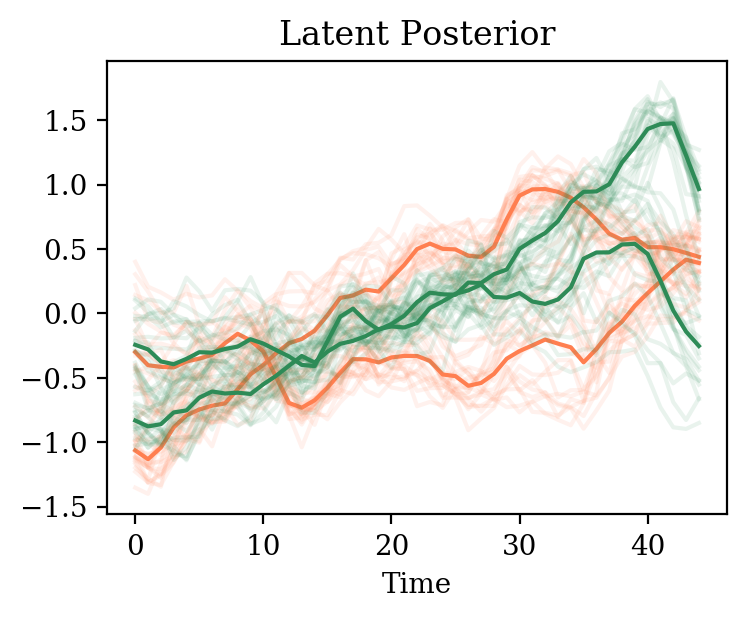

In [313]:
fig, ax = plt.subplots(figsize=(4, 3), dpi=200)

odor_B_factor1_median = np.zeros((200, 45))
odor_B_factor2_median = np.zeros((200, 45))
for i in range(200):
    odor_B_factor1 = F_sample[20 * i + 1000, :(20 * 45), 0].reshape((20, 45))
    odor_B_factor2 = F_sample[20 * i + 1000, :(20 * 45), 1].reshape((20, 45))
    odor_B_factor1_median[i, :] = np.median(odor_B_factor1, axis=0)
    odor_B_factor2_median[i, :] = np.median(odor_B_factor2, axis=0)
    if i % 10 == 0:
        plt.plot(np.median(odor_B_factor1, axis=0), alpha=0.1, color='coral')
        plt.plot(np.median(odor_B_factor2, axis=0), alpha=0.1, color='coral')
plt.plot(np.median(odor_B_factor1_median, axis=0), alpha=1.0, color='coral')
plt.plot(np.median(odor_B_factor2_median, axis=0), alpha=1.0, color='coral')

odor_C_factor1_median = np.zeros((200, 45))
odor_C_factor2_median = np.zeros((200, 45))
for i in range(200):
    odor_C_factor1 = F_sample[20 * i + 1000, (20 * 45):, 0].reshape((20, 45))
    odor_C_factor2 = F_sample[20 * i + 1000, (20 * 45):, 1].reshape((20, 45))
    odor_C_factor1_median[i, :] = np.median(odor_C_factor1, axis=0)
    odor_C_factor2_median[i, :] = np.median(odor_C_factor2, axis=0)
    if i % 10 == 0:
        plt.plot(np.median(odor_C_factor1, axis=0), alpha=0.1, color='seagreen')
        plt.plot(np.median(odor_C_factor2, axis=0), alpha=0.1, color='seagreen')
plt.plot(np.median(odor_C_factor1_median, axis=0), alpha=1.0, color='seagreen')
plt.plot(np.median(odor_C_factor2_median, axis=0), alpha=1.0, color='seagreen')
plt.title('Latent Posterior')
plt.xlabel('Time')
plt.show()

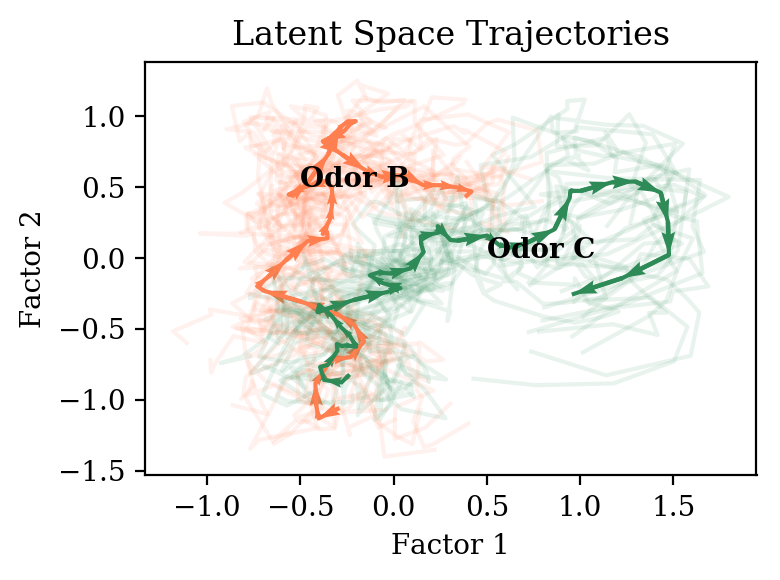

In [309]:
fig, ax = plt.subplots(figsize=(4, 3), dpi=200)
for i in range(20):
    plt.plot(odor_B_factor1_median[i * 10, :], odor_B_factor2_median[i * 10, :], color='coral', alpha=0.1)
    plt.plot(odor_C_factor1_median[i * 10, :], odor_C_factor2_median[i * 10, :], color='seagreen', alpha=0.1)
plt.plot(np.median(odor_B_factor1_median, axis=0), np.median(odor_B_factor2_median, axis=0), alpha=1.0, color='coral')
plt.plot(np.median(odor_C_factor1_median, axis=0), np.median(odor_C_factor2_median, axis=0), alpha=1.0, color='seagreen')

x1 = np.median(odor_B_factor1_median, axis=0)
y1 = np.median(odor_B_factor2_median, axis=0)
plt.quiver(x1[:-1], y1[:-1], x1[1:]-x1[:-1], y1[1:]-y1[:-1], scale_units='xy', angles='xy', scale=1, color='coral')

x1 = np.median(odor_C_factor1_median, axis=0)
y1 = np.median(odor_C_factor2_median, axis=0)
plt.quiver(x1[:-1], y1[:-1], x1[1:]-x1[:-1], y1[1:]-y1[:-1], scale_units='xy', angles='xy', scale=1, color='seagreen')

ax.text(-0.5, 0.5, 'Odor B', fontweight='bold')
ax.text(0.5, 0, 'Odor C', fontweight='bold')

plt.title('Latent Space Trajectories')
plt.xlabel('Factor 1')
plt.ylabel('Factor 2')

fig.tight_layout()

plt.show()

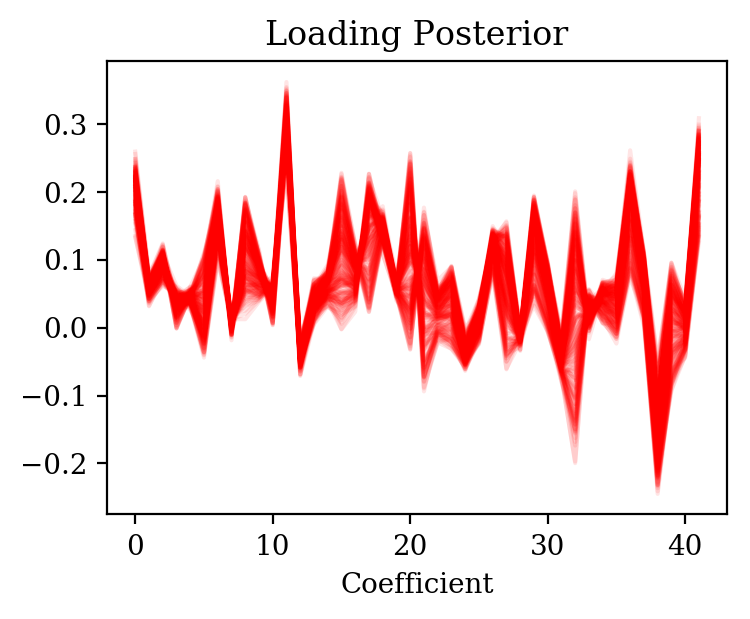

In [312]:
fig = plt.figure(figsize=(4, 3), dpi=200)
for i in range(200):
    plt.plot(loading_sample[i * 20 + 1000, :].flatten(), alpha=0.1, color='red')
plt.title('Loading Posterior')
plt.xlabel('Coefficient')
plt.show()

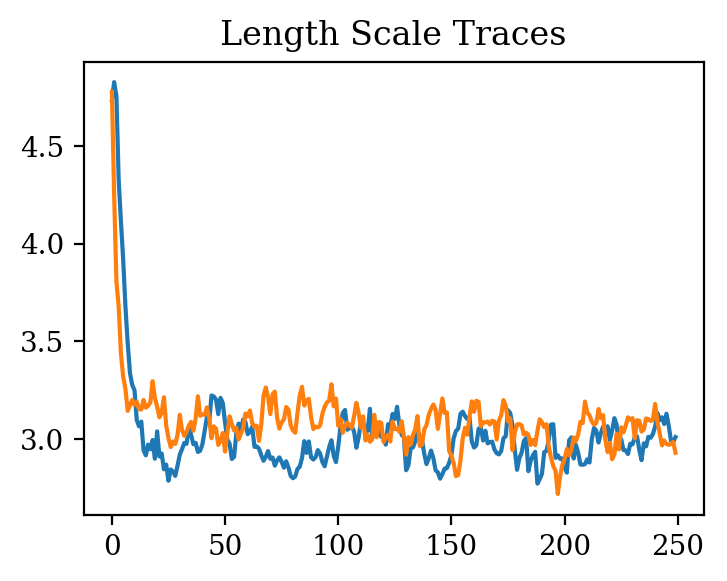

In [311]:
fig = plt.figure(figsize=(4, 3), dpi=200)
plt.plot(theta_sample[::20, 0])
plt.plot(theta_sample[::20, 1])
plt.title('Length Scale Traces')
plt.show()